In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from Social_Dataset_Class import social_dataset,find_segments
import joblib

In [18]:
## Load in data that has been processed up to the point of classification: 
traces = joblib.load('all_data_finetuned_votes')
storagetraces = joblib.load('all_data_finetuned_votes')
## Also load in raw data:
path = '../../Downloads/V118_03182018_cohousing-Camera-1-Animal-1-Segment1cropped_part'
scorer0 = 'DeepCut_resnet50_social_v4Feb10shuffle1_100000.h5'
scorer1 = 'DeepCut_resnet50_social_v4Feb10shuffle1_150000.h5'
scorers = [scorer0,scorer1]
scorerindex = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0]
# scorer = 'DeepCut_resnet50_social_v3Nov2shuffle1_1030000.h5'
raw_traces = [social_dataset(path+str(i)+scorers[scorerindex[i]],vers = 1) for i in range(30)]

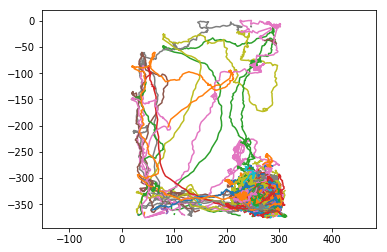

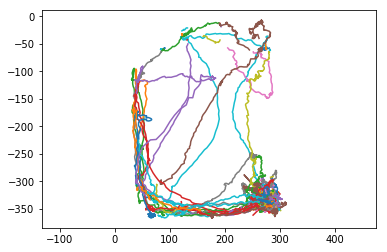

KeyboardInterrupt: 

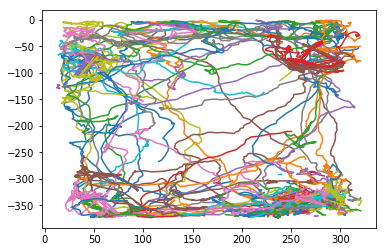

In [3]:
## We want to optimize on the tip and center position. First, let's check that all the segments 
## we find look real: 
################################
## It seems we still have weirdness to consider, although it's not clear to me how much 
## of a problem this really is given how successful most of our tracking looks at its optimal.
################################
for dataset in traces:
    for mouse in [0,1]:
        for part in [0,3]:
            part_ind = mouse*5+part
            segs = find_segments(dataset.allowed_index_full[part_ind][:,0])
            #Segment your data:
            weird = 0
            for seg in segs:
                trace = dataset.render_trajectory_full(part_ind)[seg[0]:seg[1],:]
                plt.plot(trace[:,0],-trace[:,1])
            plt.axis('equal')
            plt.show()

In [4]:
## We define our objective as minimizing the (TV distance plus the number of indices removed)

In [3]:
def cost(dataset,sigma):
    indices = [0,3,5,8]
    cost = 0
    for index in indices:
        traj = dataset.render_trajectory_full(index)
        inds = dataset.allowed_index_full[index]
        loccost = TV(traj)+sigma*lost(inds,index)
        print(TV(traj),lost(inds,index))
        cost += loccost
    return cost
def TV(trajectory):
    diff = np.diff(trajectory,axis = 0)
    normdiff = np.linalg.norm(diff,axis = 1)
    TV = np.sum(normdiff)
    return TV
def lost(indices,index):
    baseline = 36000-np.shape(indices)[0]
    own = len(np.where(indices[:,1] == index)[0])
    return 36000-own
## define a total cost as a function of parameters:
def total_cost(datasets,params,storageindices,sigma):
    totalcost = 0
    for dataind,dataset in enumerate(datasets):
        dataset.filter_classify_replaces_ps([0,3,5,8],params)
        totalcost += cost(dataset,sigma) 
        dataset.allowed_index_full = storageindices[dataind]
        
    print(params,totalcost)
    return totalcost

In [4]:
# How well does our cost do?
testdata1 = joblib.load('all_data_2_28')
testdata2 = joblib.load('all_datasets_2_26_deconv')
testdata3 = joblib.load('all_data_smoothed_2_25')
testdata_baseline = joblib.load('all_data_3_1')

In [5]:
data_index = 0
sigma = 2.5
goodcost = cost(traces[data_index],sigma = sigma)
badcost = cost(raw_traces[data_index],sigma = sigma)
medcost1 = cost(testdata1[data_index],sigma = sigma) ## Processing with current parameters
medcost2 = cost(testdata2[data_index],sigma = sigma) ## Processing with skip = 2, older classify
medcost3 = cost(testdata3[data_index],sigma = sigma) ## Processing without classify

optcost = cost(testdata_baseline[data_index],sigma =sigma) ## Processing without classify

print(goodcost,badcost,medcost1,medcost2,medcost3,optcost)

(71467.40795583495, 2343)
(45464.773311015146, 3258)
(102075.71369766768, 5188)
(67917.55870327046, 3398)
(144283.28365505225, 0)
(108498.48199097285, 0)
(324255.34725423716, 0)
(159358.31937554845, 0)
(69390.74154039672, 2817)
(44031.898969621674, 3677)
(99717.11596597181, 5807)
(66068.50605750861, 4227)
(69760.87332447746, 3231)
(44782.28864243601, 3988)
(94385.86976312744, 6793)
(66066.5422249823, 4251)
(76204.92411640132, 566)
(53072.07622106803, 412)
(104214.97366539414, 4525)
(75239.63682509135, 1065)
(69566.37918710787, 2739)
(44031.898969621674, 3677)
(99717.11596597181, 5807)
(66068.50605750861, 4227)
(322392.95366778824, 736395.4322758107, 320528.2625334988, 320653.0739550232, 325151.61082795484, 320508.90018021)


Text(0.5,1,u'320508.90018021')

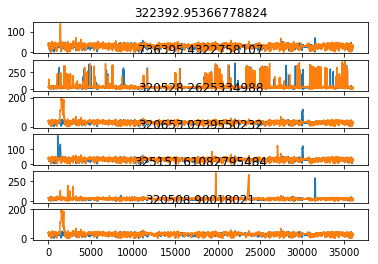

In [6]:
fig,ax = plt.subplots(6,1)
ax[0].plot(traces[data_index].part_dist(0,3))
ax[0].plot(traces[data_index].part_dist(5,8))
ax[0].set_title(goodcost)
ax[1].plot(raw_traces[data_index].part_dist(0,3))
ax[1].plot(raw_traces[data_index].part_dist(5,8))
ax[1].set_title(badcost)
ax[2].plot(testdata1[data_index].part_dist(0,3))
ax[2].plot(testdata1[data_index].part_dist(5,8))
ax[2].set_title(medcost1)
ax[3].plot(testdata2[data_index].part_dist(0,3))
ax[3].plot(testdata2[data_index].part_dist(5,8))
ax[3].set_title(medcost2)
ax[4].plot(testdata3[data_index].part_dist(0,3))
ax[4].plot(testdata3[data_index].part_dist(5,8))
ax[4].set_title(medcost3)
ax[5].plot(testdata_baseline[data_index].part_dist(0,3))
ax[5].plot(testdata_baseline[data_index].part_dist(5,8))
ax[5].set_title(optcost)
# plt.tight_layout()

In [7]:
## Upon inspection, it seems to capture many interesting aspects of the data. 

In [8]:
## Define a test dataset:
test_datainds = [0,1,2,9,10,13,14,21,25,29]
test_data_all = [traces[test_dataind] for test_dataind in test_datainds]
## We need to be careful to store the original index sets for each dataset and not touch them
## during optimization
#######################
good_indexsets = [storagetraces[traceind].allowed_index_full for traceind in test_datainds]
#######################

In [9]:
## Define optimization function and initial value:
params_init = [np.log(50), 3.09,   3.09,  40.9 ,  40.9 ]
sigma = 2.5
to_optimize = lambda parameters: total_cost(test_data_all,parameters,good_indexsets,sigma)

In [10]:
## Optimize:
from scipy.optimize import fmin

In [11]:
all_out = fmin(to_optimize,params_init,maxiter = 1000,disp = True,retall = True,)

 10%|▉         | 3474/36000 [00:00<00:00, 34737.22it/s]

(68663.01738354731, 3079)
(43578.33771882841, 4001)
(98058.33228367835, 6336)
(65382.97855416886, 4597)


 11%|█         | 3949/36000 [00:00<00:00, 39484.86it/s]

(58776.533560779935, 2297)
(33016.5981552892, 3718)
(86381.5097894241, 4032)
(46439.82575565316, 4612)


 10%|█         | 3717/36000 [00:00<00:00, 37168.88it/s]

(66019.51574957898, 520)
(38666.98407475423, 768)
(89630.93281205502, 2775)
(48704.16635922707, 1356)


 12%|█▏        | 4202/36000 [00:00<00:00, 42017.03it/s]

(64550.386592466064, 884)
(40197.24694134709, 706)
(75097.24379861914, 2146)
(43259.60184445353, 858)


 12%|█▏        | 4194/36000 [00:00<00:00, 41939.54it/s]

(56117.732487629975, 1389)
(34232.35349021679, 4701)
(76237.74713204727, 4883)
(39804.48018363222, 6132)


 11%|█         | 3782/36000 [00:00<00:00, 37818.86it/s]

(46709.09737395269, 4290)
(31994.93598049591, 7568)
(59586.23121637475, 7682)
(34046.60639372258, 11790)


  5%|▍         | 1772/36000 [00:00<00:01, 17719.47it/s]

(55812.89195026801, 1588)
(37742.664893692585, 6388)
(79591.52945833594, 7692)
(40016.90772098713, 7921)


 11%|█▏        | 4058/36000 [00:00<00:00, 40575.98it/s]

(49498.13496810378, 5004)
(34650.91792935086, 7921)
(47799.52725929729, 22204)
(30239.331293300813, 16271)


  8%|▊         | 2849/36000 [00:00<00:01, 28486.63it/s]

(45678.6437845573, 1460)
(37161.712702860634, 4425)
(33598.660797540266, 24227)
(19222.62944554069, 22843)


 10%|▉         | 3576/36000 [00:00<00:00, 35754.24it/s]

(59185.95674950706, 2857)
(38348.73363935768, 4060)
(75352.81637196436, 6237)
(42688.92211315371, 5235)
(array([ 3.91202301,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2665374.8767097606)


  9%|▉         | 3352/36000 [00:00<00:00, 33476.13it/s]

(68663.01738354731, 3079)
(43578.33771882841, 4001)
(98058.33228367835, 6336)
(65382.97855416886, 4597)


 11%|█         | 4002/36000 [00:00<00:00, 40018.89it/s]

(58776.533560779935, 2297)
(33016.5981552892, 3718)
(86381.5097894241, 4032)
(46594.108473993256, 4285)


 12%|█▏        | 4288/36000 [00:00<00:00, 42873.09it/s]

(66019.51574957898, 520)
(38666.98407475423, 768)
(89630.93281205502, 2775)
(48704.16635922707, 1356)


 11%|█         | 3915/36000 [00:00<00:00, 39146.49it/s]

(64550.386592466064, 884)
(40197.24694134709, 706)
(75097.24379861914, 2146)
(43259.60184445353, 858)


 11%|█▏        | 4121/36000 [00:00<00:00, 41205.52it/s]

(56117.732487629975, 1389)
(34232.35349021679, 4701)
(76237.74713204727, 4883)
(39804.48018363222, 6132)


 12%|█▏        | 4229/36000 [00:00<00:00, 42285.81it/s]

(46709.09737395269, 4290)
(31994.93598049591, 7568)
(59586.23121637475, 7682)
(34046.60639372258, 11790)


  4%|▍         | 1513/36000 [00:00<00:02, 15117.44it/s]

(55812.89195026801, 1588)
(37742.664893692585, 6388)
(79591.52945833594, 7692)
(40016.90772098713, 7921)


 11%|█         | 3966/36000 [00:00<00:00, 39658.81it/s]

(49498.13496810378, 5004)
(34650.91792935086, 7921)
(47799.52725929729, 22204)
(30239.331293300813, 16271)


 10%|█         | 3697/36000 [00:00<00:00, 36912.13it/s]

(45678.6437845573, 1460)
(37161.712702860634, 4425)
(33598.660797540266, 24227)
(19222.62944554069, 22843)


  8%|▊         | 3003/36000 [00:00<00:01, 30026.09it/s]

(59185.95674950706, 2857)
(38348.73363935768, 4060)
(75352.81637196436, 6237)
(42688.92211315371, 5235)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2664711.6594281006)


  9%|▉         | 3206/36000 [00:00<00:01, 32055.22it/s]

(67289.67559950844, 3730)
(42797.432046317634, 4523)
(95754.78948844988, 7215)
(64539.27374201328, 5188)


 12%|█▏        | 4172/36000 [00:00<00:00, 41716.66it/s]

(57170.44102952273, 2843)
(32440.85033129611, 4145)
(84015.75687097666, 4738)
(45685.45682435748, 5036)


 11%|█         | 3922/36000 [00:00<00:00, 39219.29it/s]

(65771.58461537889, 666)
(38461.29356638664, 913)
(88325.0848279331, 3235)
(48414.10348881496, 1529)


  8%|▊         | 2931/36000 [00:00<00:01, 29297.73it/s]

(64100.63210459626, 1163)
(40067.74442305223, 862)
(74306.13336689715, 2463)
(42856.83874371839, 1015)


 12%|█▏        | 4306/36000 [00:00<00:00, 43019.63it/s]

(55744.45016581852, 1616)
(33822.35221678004, 5100)
(74079.34165811943, 5533)
(39156.027102801505, 6597)


 12%|█▏        | 4435/36000 [00:00<00:00, 44349.20it/s]

(46326.97277431055, 4613)
(31734.175330818063, 7864)
(58118.539065763674, 8300)
(33629.98098327228, 12174)


  5%|▌         | 1801/36000 [00:00<00:01, 17986.26it/s]

(54913.85034132502, 2017)
(36937.770732399, 7017)
(76543.84557177236, 8387)
(38880.07660557822, 8443)


 12%|█▏        | 4159/36000 [00:00<00:00, 41583.30it/s]

(48601.61108569019, 5405)
(33150.052280707605, 8759)
(45112.48890016272, 23091)
(27804.754473111578, 18049)


 10%|█         | 3703/36000 [00:00<00:00, 36900.88it/s]

(45039.66429226148, 1911)
(35662.181980899055, 5694)
(32657.61315687219, 24670)
(18835.011759140143, 23213)


  7%|▋         | 2420/36000 [00:00<00:01, 24093.01it/s]

(58149.35761405793, 3205)
(37571.7264660996, 4576)
(73072.55300440642, 6833)
(42056.54385177855, 5587)
(array([ 3.91202301,  3.2445    ,  3.09      , 40.9       , 40.9       ]), 2674393.032483166)


  6%|▋         | 2339/36000 [00:00<00:01, 23388.35it/s]

(66264.04038984745, 4215)
(42290.65893661818, 4929)
(93594.94423168906, 7972)
(63833.79930550346, 5651)


  0%|          | 0/36000 [00:00<?, ?it/s]

(56055.87275226265, 3287)
(32010.730949146797, 4493)
(82059.28668425004, 5353)
(45117.5875825131, 5381)


  4%|▍         | 1428/36000 [00:00<00:02, 14274.30it/s]

(65456.59615997557, 806)
(38308.014041542614, 1027)
(87002.9872023821, 3636)
(48191.399064878606, 1672)


  6%|▌         | 2195/36000 [00:00<00:01, 21949.34it/s]

(63574.575576920084, 1403)
(39954.84219432792, 997)
(73708.91233882964, 2741)
(42654.11408665494, 1141)


  9%|▉         | 3169/36000 [00:00<00:01, 31688.37it/s]

(55360.25393940799, 1820)
(33483.86125770098, 5414)
(72673.79604554432, 6085)
(38750.38179432075, 6952)


 10%|▉         | 3529/36000 [00:00<00:00, 35289.28it/s]

(45951.710157956964, 4900)
(31529.293630073542, 8108)
(57166.852182370654, 8811)
(33225.716106854394, 12490)


  4%|▍         | 1542/36000 [00:00<00:02, 15409.21it/s]

(54090.56280716009, 2389)
(36358.46354273357, 7477)
(74579.89914912728, 8907)
(38168.752919192135, 8783)


 11%|█▏        | 4078/36000 [00:00<00:00, 40774.69it/s]

(47841.14202398422, 5719)
(32236.228595574692, 9296)
(43452.91630759967, 23624)
(26371.478857326747, 19179)


 10%|█         | 3678/36000 [00:00<00:00, 36760.49it/s]

(44501.91583119217, 2316)
(34255.95827210358, 6748)
(31779.559719980232, 24971)
(18612.051282453445, 23389)


  7%|▋         | 2667/36000 [00:00<00:01, 26665.45it/s]

(57397.04120074065, 3492)
(37081.954833782715, 4942)
(71058.97185474803, 7289)
(41694.30308518483, 5833)
(array([ 3.91202301,  3.09      ,  3.2445    , 40.9       , 40.9       ]), 2681796.426894456)


  3%|▎         | 1144/36000 [00:00<00:03, 11411.90it/s]

(65384.289780256084, 4659)
(41870.4890664487, 5274)
(92055.44466928768, 8630)
(63049.97085229271, 6019)


 10%|█         | 3744/36000 [00:00<00:00, 37438.88it/s]

(55056.76460872666, 3666)
(31612.13783365857, 4794)
(80516.68660814891, 5917)
(44584.33114218324, 5684)


 11%|█         | 3862/36000 [00:00<00:00, 38613.50it/s]

(65119.3381895979, 936)
(38198.93753277934, 1130)
(86016.94417598107, 3985)
(47964.581223346046, 1802)


 11%|█         | 3789/36000 [00:00<00:00, 37886.96it/s]

(63240.763813109756, 1613)
(39840.59173018946, 1117)
(73006.13804367976, 2996)
(42480.825431355515, 1263)


 12%|█▏        | 4227/36000 [00:00<00:00, 42265.30it/s]

(55089.66896253368, 2002)
(33251.59925584327, 5683)
(71487.63336650604, 6564)
(38417.802268455656, 7249)


 12%|█▏        | 4476/36000 [00:00<00:00, 44751.51it/s]

(45691.46253187456, 5148)
(31346.782767541587, 8311)
(56254.65832149689, 9255)
(32961.03921482154, 12760)


  5%|▍         | 1779/36000 [00:00<00:01, 17782.17it/s]

(53360.997441639905, 2711)
(35944.33267298255, 7832)
(73202.79649322035, 9324)
(37744.07665870903, 9034)


 12%|█▏        | 4244/36000 [00:00<00:00, 42432.76it/s]

(47216.55741463521, 5978)
(31638.958534104844, 9669)
(42410.875073027164, 23974)
(25475.781866804213, 19986)


 11%|█         | 3825/36000 [00:00<00:00, 38226.25it/s]

(43950.79383636632, 2680)
(33180.73332454941, 7614)
(31169.86421998372, 25216)
(18462.87229389254, 23506)


  9%|▉         | 3375/36000 [00:00<00:00, 33748.02it/s]

(56816.346522287386, 3742)
(36711.815933324106, 5232)
(69849.70772088175, 7653)
(41358.37647879862, 6019)
(array([ 3.91202301,  3.09      ,  3.09      , 42.945     , 40.9       ]), 2689561.2678753217)


 10%|▉         | 3591/36000 [00:00<00:00, 35906.44it/s]

(64583.61138375591, 5060)
(41536.35148257818, 5559)
(90600.14303880304, 9220)
(62475.4949065327, 6359)


 10%|▉         | 3496/36000 [00:00<00:00, 34954.45it/s]

(54076.702036477785, 4020)
(31286.61975545976, 5050)
(79009.17932397219, 6432)
(44115.809184383, 5953)


 11%|█         | 4032/36000 [00:00<00:00, 40313.98it/s]

(64803.36959686564, 1060)
(38101.79720955901, 1216)
(85088.15730409825, 4309)
(47716.21865986063, 1920)


 11%|█         | 4037/36000 [00:00<00:00, 40367.92it/s]

(62865.280416689566, 1800)
(39736.09403754343, 1227)
(72418.10324869471, 3237)
(42214.08053738013, 1380)


 12%|█▏        | 4345/36000 [00:00<00:00, 43444.34it/s]

(54786.36235597244, 2175)
(33017.39604894675, 5914)
(70390.64376960407, 6993)
(38066.07985498236, 7508)


 12%|█▏        | 4487/36000 [00:00<00:00, 44867.69it/s]

(45369.809462457764, 5377)
(31201.202032012996, 8488)
(55480.00892583259, 9656)
(32572.370773749783, 13008)


  5%|▍         | 1703/36000 [00:00<00:02, 17024.58it/s]

(52809.534109946195, 3006)
(35640.24813261925, 8111)
(72010.57951376487, 9689)
(37433.82175798853, 9234)


 12%|█▏        | 4145/36000 [00:00<00:00, 41447.08it/s]

(46776.08157383038, 6192)
(31228.222873038518, 9944)
(41576.140916312725, 24254)
(24667.8681938891, 20610)


  0%|          | 0/36000 [00:00<?, ?it/s]

(43435.31114503496, 3013)
(32191.008886140695, 8365)
(30614.668585422212, 25421)
(18353.22117183726, 23587)


  7%|▋         | 2491/36000 [00:00<00:01, 24866.21it/s]

(56182.846858946876, 3966)
(36316.08830215671, 5488)
(68870.3794071682, 7972)
(41100.06453049661, 6181)
(array([ 3.91202301,  3.09      ,  3.09      , 40.9       , 42.945     ]), 2695601.9713048055)


 10%|█         | 3613/36000 [00:00<00:00, 36119.53it/s]

(63939.0197574419, 5425)
(41233.459377027735, 5816)
(89304.376403205, 9762)
(62058.640571244774, 6676)


 10%|█         | 3764/36000 [00:00<00:00, 37632.86it/s]

(53273.39738201534, 4340)
(30989.01535731388, 5278)
(77855.8969378044, 6901)
(43670.760018663495, 6193)


 11%|█         | 3991/36000 [00:00<00:00, 39906.42it/s]

(64574.09835337971, 1182)
(38016.810907368796, 1296)
(84186.1505571008, 4607)
(47550.36125203804, 2023)


 11%|█         | 3976/36000 [00:00<00:00, 39756.44it/s]

(62566.43601408827, 1974)
(39634.984800073005, 1328)
(71881.705621022, 3463)
(42062.0298191093, 1489)


 12%|█▏        | 4401/36000 [00:00<00:00, 44003.43it/s]

(54589.6557706764, 2341)
(32836.782566053545, 6116)
(69399.69193278914, 7379)
(37790.47207821826, 7744)


 12%|█▏        | 4417/36000 [00:00<00:00, 44165.09it/s]

(45132.36983370837, 5588)
(31059.30019335601, 8640)
(54607.06931718734, 10022)
(32343.845540560083, 13241)


  5%|▌         | 1840/36000 [00:00<00:01, 18386.73it/s]

(52297.50258069005, 3276)
(35349.54298488677, 8358)
(70943.84575053149, 10010)
(37198.44785442445, 9401)


 12%|█▏        | 4322/36000 [00:00<00:00, 43218.70it/s]

(46337.88793545727, 6375)
(30910.101857652342, 10175)
(41071.25698263007, 24474)
(24096.262990693536, 21066)


 10%|█         | 3690/36000 [00:00<00:00, 36850.22it/s]

(42977.57402020182, 3327)
(31406.622820295735, 8996)
(30245.650980546514, 25598)
(18269.43157779615, 23651)


  9%|▉         | 3386/36000 [00:00<00:00, 33854.62it/s]

(53576.2496088128, 5445)
(36057.08503602066, 5679)
(68158.9892456151, 8257)
(40874.52050970926, 6331)
(array([ 3.99026347,  3.1518    ,  3.1518    , 41.718     , 38.855     ]), 2703434.8030974097)


  6%|▌         | 2119/36000 [00:00<00:01, 21162.47it/s]

(63275.13187358382, 5758)
(40952.05843061397, 6054)
(88230.61230986087, 10257)
(61640.97970005483, 6968)


 12%|█▏        | 4283/36000 [00:00<00:00, 42811.97it/s]

(52665.2745693936, 4627)
(30745.19099374178, 5491)
(76859.13762972194, 7318)
(43261.67202723283, 6415)


  8%|▊         | 3027/36000 [00:00<00:01, 30237.08it/s]

(64347.398200556956, 1299)
(37939.14212659918, 1365)
(83612.87097374583, 4892)
(47412.48684537359, 2116)


 10%|▉         | 3488/36000 [00:00<00:00, 34846.88it/s]

(62303.38816952027, 2141)
(39534.925595607485, 1419)
(71314.02481097063, 3681)
(41844.117305818094, 1590)


 11%|█▏        | 4084/36000 [00:00<00:00, 40838.38it/s]

(54324.43975416282, 2504)
(32667.730735275254, 6302)
(68326.20247055407, 7739)
(37452.38154448845, 7951)


 13%|█▎        | 4505/36000 [00:00<00:00, 45041.88it/s]

(44852.69268304158, 5791)
(30949.365138258614, 8781)
(53940.495672508725, 10358)
(32115.858106735504, 13459)


  5%|▍         | 1657/36000 [00:00<00:02, 16560.22it/s]

(51822.96592775681, 3516)
(35122.64658457222, 8577)
(70060.57407998465, 10305)
(37039.48012288223, 9540)


 11%|█▏        | 4059/36000 [00:00<00:00, 40582.69it/s]

(46038.05666024828, 6546)
(30634.272397277753, 10379)
(40443.31424170764, 24655)
(23695.40073937396, 21409)


 10%|█         | 3696/36000 [00:00<00:00, 36959.95it/s]

(42588.29246028569, 3625)
(30645.22972789725, 9536)
(29719.856322346295, 25757)
(18182.097519832805, 23702)


  6%|▋         | 2278/36000 [00:00<00:01, 22769.98it/s]

(53219.939596237215, 5614)
(35902.22196971078, 5830)
(67296.06534055037, 8524)
(40663.23999251036, 6468)
(array([ 3.93158312,  3.10545   ,  3.10545   , 41.1045    , 41.9225    ]), 2709288.731350595)


  9%|▉         | 3368/36000 [00:00<00:00, 33678.02it/s]

(62591.65492454493, 6068)
(40703.166767239956, 6286)
(87229.53816303198, 10718)
(61244.78993952342, 7249)


 11%|█▏        | 4058/36000 [00:00<00:00, 40574.23it/s]

(52156.579831582756, 4900)
(30505.480826561776, 5688)
(75909.11829057403, 7712)
(42944.29954490011, 6628)


 11%|█         | 4045/36000 [00:00<00:00, 40448.01it/s]

(64093.90206936299, 1412)
(37869.61556987597, 1430)
(82849.81977490317, 5157)
(47308.48404772924, 2202)


 10%|▉         | 3569/36000 [00:00<00:00, 35685.69it/s]

(61902.44134380953, 2305)
(39450.938934899204, 1500)
(70947.80994308586, 3889)
(41709.032494346386, 1679)


 12%|█▏        | 4381/36000 [00:00<00:00, 43781.02it/s]

(53972.2621548541, 2664)
(32508.54975787074, 6480)
(67506.23572079088, 8077)
(37194.09263551385, 8141)


 12%|█▏        | 4458/36000 [00:00<00:00, 44571.97it/s]

(44622.50050026177, 5983)
(30844.94706671568, 8918)
(53307.74690493079, 10673)
(31908.127204858138, 13661)


  5%|▌         | 1831/36000 [00:00<00:01, 18302.29it/s]

(51354.998482759656, 3737)
(34911.33512991031, 8766)
(69080.33602516913, 10574)
(36875.59075125862, 9663)


 10%|█         | 3777/36000 [00:00<00:00, 37769.32it/s]

(45682.65335540466, 6702)
(30358.638208303084, 10556)
(39785.87233920287, 24818)
(23448.59392071624, 21688)


 10%|█         | 3759/36000 [00:00<00:00, 37582.42it/s]

(42193.581777082756, 3912)
(29955.806102909522, 10014)
(29399.593193396224, 25904)
(18107.907634300183, 23749)


  9%|▉         | 3409/36000 [00:00<00:00, 34089.63it/s]

(52928.64228134114, 5767)
(35748.39517420968, 5965)
(66708.45252482004, 8778)
(40385.827729728924, 6587)
(array([ 4.00982358,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2714707.35904228)


  9%|▊         | 3083/36000 [00:00<00:01, 30805.06it/s]

(62022.997829130785, 6365)
(40418.32476615764, 6508)
(86102.73956333908, 11150)
(60881.18260240839, 7514)


 11%|█▏        | 4059/36000 [00:00<00:00, 40587.62it/s]

(51543.55284492206, 5160)
(30287.36852085581, 5866)
(74923.59238350361, 8086)
(42646.32618149833, 6825)


 12%|█▏        | 4379/36000 [00:00<00:00, 43782.94it/s]

(63862.650376052974, 1524)
(37822.74020357907, 1492)
(82131.02423925576, 5415)
(47193.06670942197, 2281)


 10%|█         | 3601/36000 [00:00<00:00, 36006.77it/s]

(61637.40603034146, 2467)
(39348.47728690694, 1575)
(70482.5205750229, 4088)
(41572.76441045147, 1765)


  0%|          | 0/36000 [00:00<?, ?it/s]

(53658.73172113634, 2824)
(32350.987911620126, 6647)
(66641.37092891264, 8398)
(36973.264435003264, 8315)


 12%|█▏        | 4273/36000 [00:00<00:00, 42725.76it/s]

(44418.78346423552, 6162)
(30722.068447470556, 9052)
(52709.48898667007, 10971)
(31721.76577541037, 13847)


  5%|▌         | 1818/36000 [00:00<00:01, 18171.31it/s]

(50950.1456239752, 3943)
(34729.582194158254, 8937)
(68170.07945474566, 10820)
(36729.577238343634, 9772)


 12%|█▏        | 4174/36000 [00:00<00:00, 41739.54it/s]

(45382.924209498124, 6846)
(30176.985446456427, 10712)
(39350.765982508536, 24964)
(23197.2343679248, 21928)


 11%|█         | 4041/36000 [00:00<00:00, 40405.90it/s]

(41866.38131927158, 4189)
(29377.59883748791, 10425)
(29000.733574006346, 26036)
(18042.948785684242, 23792)


 10%|█         | 3730/36000 [00:00<00:00, 37298.17it/s]

(52724.38597346265, 5910)
(35620.15098679686, 6085)
(65925.37286237, 9010)
(40250.522701846225, 6689)
(array([ 4.00982358,  3.16725   ,  3.09      , 40.9       , 40.9       ]), 2719456.0857518436)


 10%|█         | 3751/36000 [00:00<00:00, 37505.48it/s]

(61525.60602326176, 6649)
(40213.72822684337, 6714)
(85204.93022260476, 11578)
(60557.29642860777, 7765)


 11%|█         | 3955/36000 [00:00<00:00, 39545.23it/s]

(51150.29980713969, 5410)
(29793.46224804048, 6120)
(74068.11682112522, 8444)
(42382.72701056922, 7012)


 12%|█▏        | 4403/36000 [00:00<00:00, 44023.43it/s]

(63623.37624595381, 1635)
(37764.103925374526, 1552)
(81496.85039965273, 5664)
(47090.187147621175, 2353)


 11%|█         | 3894/36000 [00:00<00:00, 38938.46it/s]

(61310.54042967596, 2622)
(39298.20571174499, 1643)
(69848.0375552448, 4281)
(41431.5561242081, 1848)


 12%|█▏        | 4404/36000 [00:00<00:00, 44038.26it/s]

(53272.05891294709, 2981)
(32197.70371935209, 6809)
(65868.54675691584, 8696)
(36774.26824344416, 8471)


 12%|█▏        | 4153/36000 [00:00<00:00, 41527.96it/s]

(44249.23087403552, 6333)
(30583.28477224708, 9184)
(52214.60138261267, 11253)
(31513.024512977918, 14026)


  5%|▌         | 1817/36000 [00:00<00:01, 18158.20it/s]

(50479.170124629054, 4139)
(34556.868003375195, 9099)
(67493.94578887496, 11051)
(36608.07127177511, 9874)


 12%|█▏        | 4406/36000 [00:00<00:00, 44001.50it/s]

(45125.50134511622, 6981)
(29967.56022911213, 10853)
(38939.274215009296, 25101)
(23004.07726348199, 22137)


  8%|▊         | 2758/36000 [00:00<00:01, 27526.87it/s]

(41512.89203982735, 4458)
(28934.34402128149, 10790)
(28540.55305291087, 26153)
(17997.640426960756, 23830)


  0%|          | 0/36000 [00:00<?, ?it/s]

(52530.27570455697, 6044)
(35481.059661575004, 6200)
(65417.2858898807, 9228)
(40106.78993222764, 6783)
(array([ 4.00982358,  3.09      ,  3.16725   , 40.9       , 40.9       ]), 2724537.0524727954)


  9%|▉         | 3223/36000 [00:00<00:01, 32229.34it/s]

(60983.297242287976, 6921)
(39471.62980589836, 7342)
(84191.61364649664, 11972)
(60259.73388272218, 8000)


 10%|█         | 3720/36000 [00:00<00:00, 37195.87it/s]

(50733.991555363464, 5646)
(29650.459727682755, 6263)
(71982.00526026957, 9115)
(42132.51279577149, 7188)


 11%|█         | 3799/36000 [00:00<00:00, 37982.43it/s]

(63395.87348377972, 1743)
(37709.816240721964, 1612)
(80932.51793746985, 5907)
(47007.009589444846, 2418)


 11%|█         | 4042/36000 [00:00<00:00, 40413.20it/s]

(61031.19971195493, 2774)
(39226.97201277788, 1709)
(69425.9552605089, 4471)
(41297.396617982675, 1930)


 10%|█         | 3701/36000 [00:00<00:00, 37007.48it/s]

(53038.40016171576, 3133)
(32075.55439012088, 6969)
(65193.77672471919, 8984)
(36567.659771500614, 8621)


 11%|█▏        | 4125/36000 [00:00<00:00, 41245.91it/s]

(44025.838642839415, 6492)
(30498.46813916104, 9314)
(51698.134528200935, 11521)
(31339.923410063144, 14198)


  4%|▍         | 1590/36000 [00:00<00:02, 15898.42it/s]

(50134.37387539206, 4320)
(34382.6614843668, 9257)
(66806.41439726666, 11271)
(36488.780432956104, 9972)


 12%|█▏        | 4279/36000 [00:00<00:00, 42786.57it/s]

(44866.748093564805, 7105)
(29791.51532932271, 10985)
(38497.49261025182, 25225)
(22848.972917111983, 22308)


 11%|█         | 3935/36000 [00:00<00:00, 39349.66it/s]

(41192.81037667134, 4714)
(28496.63218418513, 11112)
(28253.810673484757, 26266)
(17941.151914406433, 23865)


 10%|▉         | 3553/36000 [00:00<00:00, 35524.36it/s]

(52266.890924043575, 6172)
(35334.33220626572, 6309)
(64788.40560298203, 9428)
(39949.83005167165, 6875)
(array([ 4.00982358,  3.09      ,  3.09      , 41.9225    , 40.9       ]), 2729478.063613398)


 11%|█         | 3822/36000 [00:00<00:00, 38219.58it/s]

(60519.736378602625, 7181)
(39236.40706944925, 7536)
(83223.52444677241, 12339)
(60011.088798521036, 8227)


 12%|█▏        | 4154/36000 [00:00<00:00, 41538.36it/s]

(50310.3494272914, 5877)
(29500.40023343733, 6389)
(71214.92833846001, 9425)
(41914.66592130826, 7358)


 12%|█▏        | 4298/36000 [00:00<00:00, 42977.48it/s]

(63125.80458318382, 1847)
(37653.375635384626, 1672)
(80157.18417816343, 6138)
(46920.3553845407, 2482)


 12%|█▏        | 4150/36000 [00:00<00:00, 41499.54it/s]

(60679.4046351393, 2925)
(39170.046532304084, 1775)
(69017.11466248517, 4659)
(41168.05226116958, 2011)


 12%|█▏        | 4415/36000 [00:00<00:00, 44130.58it/s]

(52799.06781436793, 3278)
(31968.88876828454, 7120)
(64520.42420252345, 9260)
(36372.28252365132, 8763)


 12%|█▏        | 4484/36000 [00:00<00:00, 44824.33it/s]

(43855.63680797266, 6645)
(30404.80628819063, 9437)
(51212.92099492308, 11777)
(31172.790690226688, 14358)


  5%|▌         | 1827/36000 [00:00<00:01, 18268.54it/s]

(49807.064833507975, 4492)
(34250.227812662764, 9405)
(66034.21617766147, 11480)
(36363.41074880607, 10067)


 12%|█▏        | 4202/36000 [00:00<00:00, 42012.03it/s]

(44625.878006380364, 7216)
(29627.093720182595, 11106)
(38286.08115622657, 25333)
(22710.012005058285, 22450)


 10%|█         | 3742/36000 [00:00<00:00, 37411.38it/s]

(40921.67178440769, 4964)
(28101.041421359205, 11402)
(27871.377715789222, 26371)
(17890.43377378974, 23899)


 10%|▉         | 3512/36000 [00:00<00:00, 35118.95it/s]

(52089.06440323874, 6290)
(35238.07035256403, 6412)
(64205.407251683384, 9619)
(39796.63301339721, 6966)
(array([ 4.00982358,  3.09      ,  3.09      , 40.9       , 41.9225    ]), 2733824.4407530683)


 10%|▉         | 3513/36000 [00:00<00:00, 35126.52it/s]

(60173.706810254014, 7433)
(39033.654404679975, 7730)
(82549.84791992484, 12681)
(59712.62494635397, 8446)


 11%|█         | 3868/36000 [00:00<00:00, 38679.58it/s]

(49809.760805529135, 6100)
(29362.603742923857, 6507)
(70513.98179285477, 9716)
(41684.71888431064, 7519)


 11%|█▏        | 4098/36000 [00:00<00:00, 40974.28it/s]

(62936.54578201507, 1948)
(37586.484837246215, 1728)
(79551.92264632706, 6363)
(46825.60075301997, 2546)


 11%|█         | 3877/36000 [00:00<00:00, 38766.89it/s]

(60422.01572642653, 3072)
(39109.419569762365, 1838)
(68610.11664124481, 4844)
(41039.93403926388, 2091)


 12%|█▏        | 4208/36000 [00:00<00:00, 42077.03it/s]

(52544.87030746401, 3417)
(31835.860283990365, 7262)
(63839.22502864777, 9529)
(36183.459976984006, 8900)


 12%|█▏        | 4358/36000 [00:00<00:00, 43570.38it/s]

(43696.03422438616, 6792)
(30304.95065785256, 9556)
(50738.255043893405, 12016)
(31027.32417008796, 14514)


  5%|▌         | 1857/36000 [00:00<00:01, 18557.58it/s]

(49545.440770519876, 4660)
(34092.081064377744, 9545)
(65338.57706873588, 11672)
(36259.990374922665, 10156)


 12%|█▏        | 4221/36000 [00:00<00:00, 42207.02it/s]

(44357.32681633728, 7321)
(29511.10208936047, 11218)
(38066.354771018145, 25435)
(22605.402709580158, 22557)


 10%|█         | 3675/36000 [00:00<00:00, 36702.34it/s]

(40603.9462223074, 5206)
(27795.46979285181, 11662)
(27557.842058883904, 26473)
(17842.38271764344, 23933)


  7%|▋         | 2488/36000 [00:00<00:01, 24878.01it/s]

(51860.457904962255, 6403)
(35146.12664616648, 6507)
(63732.33327392296, 9798)
(39680.391863512676, 7056)
(array([ 4.04894381,  3.1209    ,  3.1209    , 41.309     , 39.8775    ]), 2738463.145140547)


  9%|▉         | 3416/36000 [00:00<00:00, 34143.26it/s]

(59865.90499951309, 7672)
(38850.1062585943, 7915)
(81812.47740215893, 13020)
(59390.841311562814, 8662)


 11%|█         | 3963/36000 [00:00<00:00, 39627.58it/s]

(49412.33140746192, 6314)
(29214.969398005887, 6619)
(69779.91087539161, 9991)
(41412.00929758693, 7671)


 11%|█         | 3989/36000 [00:00<00:00, 39888.42it/s]

(62776.65055960903, 2046)
(37532.91327361598, 1781)
(79109.42641660274, 6580)
(46738.36035337702, 2610)


 11%|█         | 3957/36000 [00:00<00:00, 39568.81it/s]

(60228.827413080275, 3211)
(39058.5797033611, 1900)
(68131.7445214559, 5025)
(40947.34727012232, 2170)


 12%|█▏        | 4296/36000 [00:00<00:00, 42747.54it/s]

(52325.07314504175, 3553)
(31730.112192901233, 7399)
(63416.57012388176, 9786)
(36028.58736897685, 9027)


 12%|█▏        | 4285/36000 [00:00<00:00, 42846.57it/s]

(43518.66445649075, 6938)
(30205.764391209796, 9673)
(50388.36472824626, 12245)
(30884.81333921011, 14667)


  5%|▌         | 1810/36000 [00:00<00:01, 18097.99it/s]

(49256.621638480516, 4826)
(33950.85970071036, 9681)
(64620.13614192416, 11858)
(36153.64296374017, 10242)


 11%|█▏        | 4108/36000 [00:00<00:00, 41078.77it/s]

(44182.78224796998, 7422)
(29398.37454030667, 11322)
(37794.014035075386, 25541)
(22513.380638100094, 22642)


 10%|▉         | 3572/36000 [00:00<00:00, 35719.61it/s]

(40273.100551846044, 5445)
(27496.55308217657, 11895)
(27320.006886584957, 26571)
(17811.5452381444, 23964)


 11%|█         | 3866/36000 [00:00<00:00, 38630.29it/s]

(51691.968030742086, 6512)
(35024.426959546145, 6593)
(63228.29173913446, 9970)
(39521.01499289727, 7145)
(array([ 4.01960364,  3.097725  ,  3.097725  , 41.00225   , 41.41125   ]), 2743257.0695948377)


 11%|█         | 3826/36000 [00:00<00:00, 38259.22it/s]

(59569.173547859784, 7909)
(38698.57814427605, 8094)
(81114.96639564422, 13330)
(58828.44325449614, 8915)


 12%|█▏        | 4337/36000 [00:00<00:00, 43368.70it/s]

(49027.5156347107, 6517)
(29080.693151458938, 6724)
(68922.50805416965, 10260)
(41206.75704787897, 7819)


 12%|█▏        | 4145/36000 [00:00<00:00, 41440.46it/s]

(62600.45111596544, 2142)
(37474.89530026981, 1833)
(78637.22227781825, 6785)
(46638.24110294131, 2674)


 11%|█         | 4033/36000 [00:00<00:00, 40328.02it/s]

(60009.02242962109, 3346)
(39012.43770856895, 1962)
(67718.41273034335, 5203)
(40826.397544447405, 2245)


 12%|█▏        | 4232/36000 [00:00<00:00, 42297.15it/s]

(52118.09779186437, 3687)
(31602.562518731575, 7534)
(62920.7481682686, 10030)
(35884.81182668764, 9147)


 12%|█▏        | 4329/36000 [00:00<00:00, 43281.37it/s]

(43335.16823104196, 7081)
(30122.156524340608, 9789)
(49949.48133958678, 12465)
(30758.089912030493, 14815)


  5%|▍         | 1792/36000 [00:00<00:01, 17918.74it/s]

(49021.684458486496, 4986)
(33808.41854806136, 9817)
(63702.307171324224, 12043)
(36072.16480110173, 10327)


 10%|▉         | 3507/36000 [00:00<00:00, 35057.75it/s]

(44019.64918422151, 7518)
(29274.27823123147, 11423)
(37542.14131874192, 25634)
(22455.274173643236, 22718)


 10%|█         | 3780/36000 [00:00<00:00, 37797.78it/s]

(39914.76001072466, 5678)
(27120.214131708628, 12113)
(27015.37126935078, 26669)
(17747.161018122675, 23994)


 10%|▉         | 3594/36000 [00:00<00:00, 35937.55it/s]

(51500.33051924132, 6619)
(34921.1427734841, 6675)
(62871.20065165791, 10139)
(39413.82653481261, 7230)
(array([ 4.05872387,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2747179.2565489365)


  8%|▊         | 2727/36000 [00:00<00:01, 27251.18it/s]

(59248.51485357681, 8137)
(38526.81707104273, 8269)
(80505.35732060959, 13636)
(58542.65267105065, 9114)


 10%|█         | 3738/36000 [00:00<00:00, 37376.20it/s]

(48687.67158137984, 6710)
(28989.711204865373, 6823)
(68105.68555002988, 10526)
(40987.731074998665, 7962)


 12%|█▏        | 4316/36000 [00:00<00:00, 43156.13it/s]

(62447.548549306004, 2238)
(37419.62412812728, 1885)
(78261.82752318148, 6983)
(46565.550154284356, 2737)


 11%|█         | 3889/36000 [00:00<00:00, 38882.99it/s]

(59764.67675659301, 3480)
(38731.79495197777, 2112)
(67385.911745635, 5377)
(40713.828846619, 2315)


 12%|█▏        | 4309/36000 [00:00<00:00, 43089.12it/s]

(51936.0437587489, 3819)
(31486.08592485324, 7666)
(62170.641027910446, 10270)
(31909.196282265417, 12622)


 12%|█▏        | 4464/36000 [00:00<00:00, 44632.91it/s]

(43174.88665303491, 7217)
(30025.18356784252, 9905)
(49405.61697489457, 12677)
(30630.494053717797, 14958)


  5%|▌         | 1873/36000 [00:00<00:01, 18703.08it/s]

(48751.00204699047, 5141)
(33672.919207411265, 9947)
(63261.8467957882, 12224)
(36001.47705067597, 10409)


 12%|█▏        | 4230/36000 [00:00<00:00, 42299.54it/s]

(43851.1906702331, 7611)
(29139.333973760335, 11520)
(37300.49684873488, 25721)
(22405.1383492421, 22784)


 11%|█         | 3817/36000 [00:00<00:00, 38166.49it/s]

(39646.06329451216, 5904)
(26823.029606160566, 12317)
(26762.02786368541, 26765)
(17705.610850958295, 24024)


 11%|█         | 3799/36000 [00:00<00:00, 37982.79it/s]

(51307.63918802664, 6723)
(34840.218503770935, 6755)
(62435.25737784912, 10306)
(39279.876421393215, 7313)
(array([ 4.05872387,  3.128625  ,  3.09      , 40.9       , 40.9       ]), 2756061.180275738)


 10%|█         | 3608/36000 [00:00<00:00, 36074.27it/s]

(58902.46040998215, 8361)
(38303.71852255077, 8432)
(79795.47183668026, 13944)
(58271.67546089495, 9306)


 12%|█▏        | 4227/36000 [00:00<00:00, 42246.27it/s]

(48173.188399074286, 6902)
(28898.63563772531, 6918)
(67460.78963128781, 10779)
(40809.045254054974, 8103)


 12%|█▏        | 4304/36000 [00:00<00:00, 43039.12it/s]

(62323.715171729724, 2332)
(37347.063114699675, 1935)
(77861.16914557015, 7180)
(46503.42093455937, 2798)


 12%|█▏        | 4212/36000 [00:00<00:00, 42114.12it/s]

(59509.7962349224, 3612)
(38686.724843727105, 2169)
(66909.1528014577, 5544)
(40626.95298849116, 2385)


 12%|█▏        | 4337/36000 [00:00<00:00, 43368.70it/s]

(51723.52112525828, 3947)
(31366.771445197155, 7795)
(61612.25442392519, 10505)
(31771.492047335818, 12736)


 12%|█▏        | 4364/36000 [00:00<00:00, 43629.12it/s]

(43001.31342783351, 7351)
(29937.686949164574, 10020)
(48998.6582241809, 12888)
(30490.590074350344, 15098)


  5%|▍         | 1779/36000 [00:00<00:01, 17772.43it/s]

(48467.501819166566, 5290)
(33541.264381693196, 10073)
(62749.04157836786, 12402)
(35942.588919116926, 10491)


 12%|█▏        | 4350/36000 [00:00<00:00, 43499.94it/s]

(43684.202104675285, 7702)
(29000.72868519251, 11613)
(37078.07760245037, 25807)
(22364.872866523667, 22845)


 10%|█         | 3708/36000 [00:00<00:00, 37044.09it/s]

(39312.19645277511, 6122)
(26567.12670130982, 12505)
(26443.599439390706, 26859)
(17659.08044485677, 24053)


 10%|█         | 3753/36000 [00:00<00:00, 37515.37it/s]

(51130.4125558139, 6822)
(34769.59130916992, 6831)
(61788.37787523972, 10471)
(39155.9712651515, 7391)
(array([ 4.05872387,  3.09      ,  3.128625  , 40.9       , 40.9       ]), 2759732.4021055475)


 10%|█         | 3701/36000 [00:00<00:00, 37008.89it/s]

(58593.86532746365, 8581)
(38128.96030585388, 8589)
(79185.73467700757, 14230)
(57781.23723632518, 9595)


  0%|          | 0/36000 [00:00<?, ?it/s]

(47894.44502030068, 7088)
(28818.20059530351, 7009)
(66024.75345920066, 11188)
(40618.06146052561, 8243)


 11%|█         | 4039/36000 [00:00<00:00, 40382.34it/s]

(62164.48089834514, 2426)
(37289.660823984086, 1985)
(77527.54878620688, 7373)
(46427.78289517865, 2858)


 12%|█▏        | 4247/36000 [00:00<00:00, 42464.88it/s]

(59338.558631677275, 3739)
(38634.821777725876, 2224)
(66559.6689990834, 5708)
(40535.841774579305, 2455)


 12%|█▏        | 4199/36000 [00:00<00:00, 41986.24it/s]

(51513.21939653647, 4072)
(31249.35918649999, 7923)
(61158.09895324286, 10733)
(31619.42840629377, 12847)


 13%|█▎        | 4648/36000 [00:00<00:00, 46450.70it/s]

(42739.81204101791, 7483)
(29842.503979959867, 10134)
(48693.73776752761, 13094)
(30364.958178163193, 15234)


  5%|▌         | 1863/36000 [00:00<00:01, 18624.20it/s]

(48240.18342232602, 5432)
(33405.14204502015, 10196)
(62252.617859275604, 12577)
(35844.52437049145, 10570)


 11%|█         | 3937/36000 [00:00<00:00, 39361.40it/s]

(43502.24584503037, 7788)
(28897.22228718024, 11705)
(36929.54474778881, 25888)
(22303.425183330954, 22903)


 11%|█         | 3870/36000 [00:00<00:00, 38695.70it/s]

(38959.1152030005, 6333)
(26319.267384913852, 12684)
(26194.156021750805, 26953)
(17613.358369355756, 24081)


 10%|█         | 3743/36000 [00:00<00:00, 37409.08it/s]

(50998.39769950964, 6916)
(34706.3900491145, 6904)
(61392.627287849995, 10630)
(38988.19946163493, 7469)
(array([ 4.05872387,  3.09      ,  3.09      , 41.41125   , 40.9       ]), 2763851.157815577)


 10%|█         | 3693/36000 [00:00<00:00, 36929.33it/s]

(58265.80813171867, 8795)
(37957.18933575381, 8744)
(78643.55814332479, 14501)
(57518.43154080479, 9767)


 12%|█▏        | 4186/36000 [00:00<00:00, 41853.75it/s]

(47629.42949251966, 7271)
(28748.948473347467, 7098)
(65453.636831971926, 11433)
(40394.99590926288, 8379)


 11%|█         | 3833/36000 [00:00<00:00, 38256.98it/s]

(62014.308203329165, 2520)
(37231.81056944559, 2035)
(77223.21794879157, 7557)
(46357.964329792965, 2918)


 11%|█         | 4046/36000 [00:00<00:00, 40459.17it/s]

(59138.73656955998, 3865)
(38586.65663913695, 2278)
(65961.59320508246, 5962)
(40458.70248335791, 2525)


 12%|█▏        | 4381/36000 [00:00<00:00, 43796.88it/s]

(51353.39521499604, 4194)
(31128.06126786354, 8051)
(60689.82116280519, 10957)
(31467.64482820683, 12954)


 11%|█▏        | 4114/36000 [00:00<00:00, 41137.19it/s]

(42585.89456063913, 7609)
(29752.918644095993, 10245)
(48307.63381133911, 13293)
(30238.382485118767, 15362)


  5%|▌         | 1831/36000 [00:00<00:01, 18297.72it/s]

(47974.31876772477, 5570)
(33270.3630373582, 10315)
(61762.59597907058, 12802)
(35775.657922018356, 10646)


 11%|█         | 3969/36000 [00:00<00:00, 39688.43it/s]

(43351.13543063511, 7872)
(28795.977748813137, 11795)
(36761.44217324318, 25967)
(22254.867565506716, 22952)


 10%|█         | 3638/36000 [00:00<00:00, 36330.92it/s]

(38641.78012381206, 6538)
(26100.923887450543, 12848)
(25980.649791540225, 27045)
(17592.952808343678, 24109)


 10%|█         | 3651/36000 [00:00<00:00, 36472.38it/s]

(49931.9197401963, 7323)
(34650.904930015044, 6973)
(61007.69065875086, 10782)
(38889.781198422315, 7545)
(array([ 4.05872387,  3.09      ,  3.09      , 40.9       , 41.41125   ]), 2768339.201545166)


  8%|▊         | 3017/36000 [00:00<00:01, 30164.92it/s]

(57924.264086446776, 8999)
(37786.40136212892, 8898)
(78201.96631851648, 14762)
(57319.8485202281, 9927)


 11%|█         | 3829/36000 [00:00<00:00, 38209.78it/s]

(47295.76245080851, 7451)
(28671.62953204479, 7185)
(64835.411522753144, 11669)
(39397.04667646524, 8793)


 11%|█▏        | 4117/36000 [00:00<00:00, 41169.94it/s]

(61821.252597470906, 2614)
(37182.55755956379, 2085)
(76920.88931131743, 7736)
(46267.68928333118, 2978)


  9%|▉         | 3310/36000 [00:00<00:00, 33063.30it/s]

(58901.983637771606, 3991)
(38544.679324173696, 2332)
(64962.92468656767, 6444)
(40376.5024826585, 2593)


 11%|█▏        | 4099/36000 [00:00<00:00, 40989.16it/s]

(51173.24434226409, 4312)
(31018.867616822397, 8171)
(60249.2592177696, 11177)
(31332.725033256218, 13055)


 12%|█▏        | 4375/36000 [00:00<00:00, 43742.53it/s]

(42382.26181847392, 7731)
(29664.18780015798, 10355)
(48000.848415947556, 13489)
(30125.840134951883, 15488)


  5%|▌         | 1801/36000 [00:00<00:01, 17993.63it/s]

(47721.643606450416, 5706)
(33157.65769253769, 10430)
(61276.979839367115, 12962)
(35707.55430417925, 10722)


 11%|█         | 4046/36000 [00:00<00:00, 40456.37it/s]

(43208.225615929165, 7955)
(28717.694915579174, 11881)
(36555.670669901534, 26044)
(22220.13662665894, 22996)


 10%|█         | 3744/36000 [00:00<00:00, 37415.68it/s]

(38403.05609944625, 6740)
(25840.72005725542, 13007)
(25723.56912701811, 27136)
(17562.899727837936, 24136)


 10%|█         | 3649/36000 [00:00<00:00, 36435.05it/s]

(49791.46044733535, 7405)
(34591.40905115817, 7040)
(60598.07731542311, 10934)
(38780.51241848623, 7621)
(array([ 4.07828398,  3.10545   ,  3.10545   , 41.1045    , 40.38875   ]), 2772590.3112464543)


 10%|█         | 3765/36000 [00:00<00:00, 37645.10it/s]

(57598.6951501978, 9200)
(37637.46506335307, 9052)
(77673.02514023616, 15021)
(57134.52660628136, 10086)


 10%|▉         | 3595/36000 [00:00<00:00, 35946.35it/s]

(47010.336835495866, 7628)
(28593.641736672595, 7271)
(64204.76262593582, 11903)
(39230.549743290605, 8915)


 10%|█         | 3661/36000 [00:00<00:00, 36608.20it/s]

(61680.327425483505, 2706)
(37118.36119872668, 2135)
(76523.72169575692, 7914)
(46177.633604624054, 3037)


 10%|█         | 3707/36000 [00:00<00:00, 37064.47it/s]

(58704.921166726825, 4114)
(38491.694945575066, 2385)
(64659.85324995469, 6598)
(40315.08499626654, 2659)


 11%|█         | 4036/36000 [00:00<00:00, 40358.02it/s]

(51005.98691052919, 4428)
(30918.19891736251, 8287)
(59820.918691430925, 11392)
(31227.24830391056, 13152)


 13%|█▎        | 4650/36000 [00:00<00:00, 46363.20it/s]

(42152.706985435936, 7849)
(29573.98248821745, 10463)
(47670.48767143069, 13681)
(30022.92986588074, 15610)


  5%|▌         | 1861/36000 [00:00<00:01, 18578.39it/s]

(47400.77762979924, 5840)
(33067.980493727664, 10535)
(60727.938097678634, 13122)
(35601.41362801586, 10798)


 11%|█         | 3999/36000 [00:00<00:00, 39983.56it/s]

(43052.34866150773, 8037)
(28645.8628820635, 11965)
(36305.9332926419, 26119)
(22178.515193407584, 23036)


 11%|█         | 4033/36000 [00:00<00:00, 40327.92it/s]

(38142.1813238947, 6939)
(25593.85843336298, 13155)
(25377.587909287624, 27231)
(17540.909152159733, 24160)


 10%|█         | 3625/36000 [00:00<00:00, 36248.22it/s]

(47757.66363629711, 8901)
(29060.924475723154, 12430)
(60204.48422443275, 11084)
(38694.414990273304, 7697)
(array([ 4.0636139,  3.0938625,  3.0938625, 40.951125 , 41.155625 ]), 2785837.355043049)


 10%|▉         | 3517/36000 [00:00<00:00, 35112.10it/s]

(57265.69406861547, 9399)
(37459.15007320451, 9206)
(77159.62871676257, 15271)
(56943.37387224351, 10237)


 11%|█         | 3996/36000 [00:00<00:00, 39959.56it/s]

(46593.77484745025, 7800)
(28502.177788694826, 7357)
(63502.04994222045, 12129)
(39075.233892729404, 9037)


 12%|█▏        | 4148/36000 [00:00<00:00, 41475.89it/s]

(61492.33302694653, 2798)
(37061.43747803662, 2185)
(76139.77208539762, 8089)
(46118.642677002026, 3093)


 11%|█         | 4012/36000 [00:00<00:00, 40114.40it/s]

(58519.57004366091, 4234)
(37286.10796785055, 3082)
(64168.338013790366, 6748)
(40239.373456569934, 2725)


 10%|▉         | 3497/36000 [00:00<00:00, 34968.95it/s]

(50845.498751138446, 4544)
(30812.798838176433, 8403)
(59302.04544403641, 11596)
(31131.406855335386, 13247)


  9%|▉         | 3319/36000 [00:00<00:00, 33171.76it/s]

(42006.70874321517, 7965)
(29471.907336530472, 10571)
(47381.06360476149, 13867)
(29907.651379690527, 15728)


  5%|▍         | 1797/36000 [00:00<00:01, 17968.90it/s]

(48379.37465863668, 6016)
(32959.48625969074, 10639)
(60292.00671596159, 13324)
(35524.71351047677, 10872)


 10%|▉         | 3439/36000 [00:00<00:00, 34389.38it/s]

(42921.93380826089, 8116)
(28537.23486612947, 12049)
(36116.50176030668, 26195)
(22141.14190829514, 23073)


 12%|█▏        | 4154/36000 [00:00<00:00, 41520.93it/s]

(37919.918520723026, 7133)
(25345.25238413223, 13299)
(25050.44889044401, 27321)
(17520.706028164594, 24184)


 10%|█         | 3608/36000 [00:00<00:00, 36031.41it/s]

(47609.868848048245, 8969)
(28095.987112613922, 13015)
(59907.38944043087, 11231)
(38615.94862151361, 7772)
(array([ 4.08317401,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2791621.1522378884)


 11%|█         | 4001/36000 [00:00<00:00, 40002.89it/s]

(56938.196929594895, 9593)
(37295.5057682693, 9360)
(76548.6650575145, 15518)
(56724.891214761046, 10384)


 12%|█▏        | 4247/36000 [00:00<00:00, 42464.07it/s]

(46085.5043531884, 7992)
(28426.02386563812, 7441)
(62920.033398349064, 12352)
(38908.44679334952, 9155)


 12%|█▏        | 4204/36000 [00:00<00:00, 42039.14it/s]

(61334.32240302598, 2890)
(37025.841868355084, 2233)
(75759.03010125298, 8262)
(46033.455344725575, 3149)


 11%|█         | 4039/36000 [00:00<00:00, 40389.17it/s]

(58351.521538276786, 4354)
(37227.81670185328, 3130)
(63783.02251700758, 6896)
(40169.031816772906, 2791)


 12%|█▏        | 4192/36000 [00:00<00:00, 41912.45it/s]

(50658.34635327655, 4660)
(30709.414297391933, 8515)
(58832.0293361937, 11790)
(31039.4064723787, 13337)


  9%|▉         | 3324/36000 [00:00<00:00, 33239.71it/s]

(41804.29529953441, 8079)
(29359.55210970231, 10674)
(47016.618370652024, 14049)
(29811.677776604436, 15842)


  5%|▍         | 1781/36000 [00:00<00:01, 17788.47it/s]

(41560.33247892121, 10635)
(32853.30122261484, 10743)
(59770.53292445982, 13475)
(35434.86810002406, 10946)


 12%|█▏        | 4146/36000 [00:00<00:00, 41458.75it/s]

(42784.28460035594, 8192)
(28459.88972231304, 12130)
(35985.29260304736, 26267)
(22112.883115588564, 23106)


 11%|█         | 3957/36000 [00:00<00:00, 39568.06it/s]

(37698.8102028164, 7325)
(25133.091901348853, 13434)
(24875.10898189704, 27412)
(17483.79177912835, 24208)


  8%|▊         | 3024/36000 [00:00<00:01, 30234.26it/s]

(47470.44747079106, 9035)
(28042.59119526602, 13071)
(59574.31681288455, 11375)
(38508.354859711624, 7844)
(array([ 4.08317401,  3.1093125 ,  3.09      , 40.9       , 40.9       ]), 2799620.5476588374)


 10%|█         | 3641/36000 [00:00<00:00, 36406.04it/s]

(56636.718409269044, 9778)
(37149.09418126098, 9511)
(75973.69567777977, 15759)
(56509.60130347767, 10528)


 12%|█▏        | 4149/36000 [00:00<00:00, 41487.96it/s]

(45830.012881358125, 8147)
(28363.600264200526, 7521)
(62254.36148487414, 12569)
(38762.3251468976, 9269)


 11%|█▏        | 4125/36000 [00:00<00:00, 41243.35it/s]

(61144.04937855893, 2982)
(36993.16911705049, 2281)
(75467.0878060868, 8429)
(45970.01459031833, 3203)


 10%|▉         | 3488/36000 [00:00<00:00, 34825.73it/s]

(58170.27488866739, 4474)
(37101.23379588214, 3236)
(63471.40852504027, 7040)
(40100.139531363166, 2857)


 11%|█         | 3995/36000 [00:00<00:00, 39945.18it/s]

(50481.807928485214, 4771)
(30622.596519369337, 8625)
(58402.31299674362, 11983)
(30946.810824187625, 13426)


 12%|█▏        | 4345/36000 [00:00<00:00, 43440.41it/s]

(41678.28596537176, 8192)
(29280.01341230479, 10774)
(46743.27737289241, 14229)
(29696.158526373245, 15953)


  5%|▍         | 1737/36000 [00:00<00:01, 17365.50it/s]

(41279.338865264945, 10760)
(32652.78064103409, 10860)
(59401.84909128584, 13625)
(35359.558188372685, 11019)


 12%|█▏        | 4222/36000 [00:00<00:00, 42218.33it/s]

(42667.60831412172, 8263)
(28364.426649021265, 12209)
(35867.466694742514, 26337)
(22068.834597880115, 23136)


 10%|█         | 3745/36000 [00:00<00:00, 37444.41it/s]

(37434.25921539846, 7509)
(24955.25525675286, 13564)
(24601.189329903606, 27499)
(17460.95347020331, 24232)


 10%|█         | 3746/36000 [00:00<00:00, 37454.05it/s]

(47353.81728141294, 9099)
(27984.809165394334, 13124)
(59265.588653864506, 11517)
(38455.60860760657, 7914)
(array([ 4.08317401,  3.09      ,  3.1093125 , 40.9       , 40.9       ]), 2803431.394550073)


 10%|█         | 3639/36000 [00:00<00:00, 36388.13it/s]

(55912.67801430236, 10007)
(36991.60135106699, 9661)
(75455.09469481862, 15989)
(53403.59002399061, 11542)


 11%|█         | 3814/36000 [00:00<00:00, 38139.58it/s]

(45602.47810618785, 8299)
(28282.949993336755, 7601)
(61685.837461789815, 12777)
(38623.8909748611, 9382)


 12%|█▏        | 4309/36000 [00:00<00:00, 43083.47it/s]

(60992.12428049682, 3074)
(36943.82042528324, 2329)
(75159.87156319033, 8593)
(45898.16080183245, 3253)


 12%|█▏        | 4167/36000 [00:00<00:00, 41666.66it/s]

(57994.88092749065, 4594)
(37073.92635992094, 3281)
(63211.250669438596, 7184)
(40048.00772884371, 2923)


 12%|█▏        | 4226/36000 [00:00<00:00, 42247.75it/s]

(50263.7249173094, 4883)
(30500.41371656219, 8735)
(58083.03423752438, 12175)
(30851.85555449245, 13514)


 13%|█▎        | 4542/36000 [00:00<00:00, 45415.93it/s]

(41566.38733077502, 8301)
(29207.64178167942, 10870)
(46434.07912007627, 14406)
(29592.857907488447, 16059)


  5%|▌         | 1818/36000 [00:00<00:01, 18169.66it/s]

(41080.45674660457, 10883)
(32568.69005776164, 10962)
(58891.22429626592, 13774)
(35294.00104328673, 11089)


 12%|█▏        | 4145/36000 [00:00<00:00, 41442.14it/s]

(42545.642261013505, 8330)
(28266.65805199585, 12285)
(35674.06770279055, 26405)
(22035.7411639578, 23166)


 12%|█▏        | 4173/36000 [00:00<00:00, 41680.85it/s]

(37219.63215098288, 7693)
(24803.85875272318, 13686)
(24344.551875316738, 27585)
(17434.174198008583, 24256)


 10%|█         | 3776/36000 [00:00<00:00, 37752.84it/s]

(47221.18717686105, 9161)
(27925.275752069992, 13174)
(59030.7669029131, 11658)
(38366.67990188079, 7984)
(array([ 4.08317401,  3.09      ,  3.09      , 41.155625  , 40.9       ]), 2806290.2659771913)


 10%|█         | 3681/36000 [00:00<00:00, 36808.10it/s]

(55641.27229046805, 10183)
(36815.25519529611, 9807)
(74942.17514822517, 16214)
(53246.51055359033, 11673)


 12%|█▏        | 4332/36000 [00:00<00:00, 43317.46it/s]

(45338.320091339156, 8447)
(28211.048107908624, 7681)
(61123.740277618024, 12982)
(38487.81991337364, 9494)


 11%|█▏        | 4135/36000 [00:00<00:00, 41345.80it/s]

(60827.976429089016, 3166)
(36907.19984649008, 2375)
(74812.13028525269, 8755)
(45853.185501283195, 3301)


 12%|█▏        | 4202/36000 [00:00<00:00, 41933.56it/s]

(57725.84554449335, 4713)
(37028.68124405915, 3325)
(62852.84466497154, 7327)
(39997.32057444391, 2987)


 12%|█▏        | 4294/36000 [00:00<00:00, 42936.15it/s]

(50116.063559425675, 4989)
(30085.90478828043, 8924)
(57628.26100948783, 12366)
(30762.29346091214, 13599)


 13%|█▎        | 4544/36000 [00:00<00:00, 45438.63it/s]

(41312.88592299483, 8407)
(29112.299645921103, 10966)
(46163.12956885814, 14579)
(29500.352942270634, 16165)


  5%|▍         | 1794/36000 [00:00<00:01, 17931.04it/s]

(40861.22838493955, 11004)
(32481.143822305177, 11061)
(58566.34640640605, 13919)
(35212.6892039961, 11157)


 11%|█▏        | 4137/36000 [00:00<00:00, 41365.50it/s]

(42408.93128840295, 8395)
(28192.131010692923, 12361)
(35469.606733122564, 26473)
(22004.594424548788, 23194)


 11%|█         | 3807/36000 [00:00<00:00, 38067.77it/s]

(36987.44352798286, 7874)
(24687.716165169935, 13800)
(23994.11443101949, 27669)
(17391.2416275345, 24279)


 10%|█         | 3753/36000 [00:00<00:00, 37511.61it/s]

(47117.87768758073, 9222)
(27885.434245611148, 13219)
(58632.76900414848, 11797)
(38250.285208909656, 8054)
(array([ 4.08317401,  3.09      ,  3.09      , 40.9       , 41.155625  ]), 2809393.569738424)


 10%|█         | 3710/36000 [00:00<00:00, 37099.59it/s]

(55361.57879025193, 10356)
(36663.9117129714, 9949)
(74063.69728747729, 16442)
(53114.164780691266, 11798)


 12%|█▏        | 4261/36000 [00:00<00:00, 42609.63it/s]

(45024.276212177676, 8595)
(28137.47777570421, 7760)
(60785.73067056387, 13182)
(38352.9649768278, 9606)


 11%|█         | 4039/36000 [00:00<00:00, 40388.79it/s]

(60660.46860236554, 3258)
(36845.931267683234, 2421)
(74384.93855021837, 8917)
(45786.246683496865, 3349)


 12%|█▏        | 4166/36000 [00:00<00:00, 41591.42it/s]

(57500.04284647942, 4830)
(36968.98024428971, 3368)
(62595.11998122596, 7466)
(39941.80414175902, 3051)


 12%|█▏        | 4376/36000 [00:00<00:00, 43711.89it/s]

(49921.487688022535, 5097)
(29999.028977826532, 9028)
(57174.018879525596, 12556)
(30675.341333828284, 13684)


 10%|█         | 3780/36000 [00:00<00:00, 37796.25it/s]

(41177.303072621835, 8509)
(29022.940608195287, 11060)
(45814.40154726578, 14751)
(29411.836777948818, 16271)


  5%|▍         | 1761/36000 [00:00<00:01, 17606.28it/s]

(40681.93869326349, 11122)
(32391.626582915513, 11155)
(58310.1268389205, 14057)
(35151.815140293336, 11222)


 11%|█         | 3974/36000 [00:00<00:00, 39736.44it/s]

(42305.11177704995, 8459)
(28106.856467309088, 12437)
(35198.00875241269, 26538)
(21973.577588296095, 23220)


 10%|█         | 3666/36000 [00:00<00:00, 36629.29it/s]

(36777.31218245025, 8052)
(24528.204537806916, 13912)
(23815.188787000585, 27750)
(17345.023753198166, 24301)


 10%|▉         | 3578/36000 [00:00<00:00, 35758.12it/s]

(47033.934325507325, 9278)
(27846.5687699299, 13261)
(58255.30379059601, 11933)
(38163.35878678377, 8122)
(array([ 4.09295407,  3.097725  ,  3.097725  , 41.00225   , 40.644375  ]), 2812575.1501831515)


 11%|█         | 3813/36000 [00:00<00:00, 38129.58it/s]

(55071.59476945497, 10528)
(36540.7682219602, 10088)
(73513.4928664941, 16657)
(52957.557705541505, 11922)


 11%|█         | 3956/36000 [00:00<00:00, 39554.85it/s]

(44762.99054389996, 8736)
(28084.01074774092, 7838)
(60186.12487850657, 13377)
(38234.19527586474, 9715)


 12%|█▏        | 4159/36000 [00:00<00:00, 41582.90it/s]

(60499.512625129086, 3350)
(36779.32378723445, 2467)
(74021.03903724975, 9079)
(45696.57975122247, 3397)


 12%|█▏        | 4145/36000 [00:00<00:00, 41441.74it/s]

(57320.53193612999, 4946)
(36923.58020439331, 3408)
(62373.023172950576, 7604)
(39887.74656909442, 3115)


 12%|█▏        | 4299/36000 [00:00<00:00, 42984.92it/s]

(49780.45025409733, 5202)
(29916.692497903503, 9132)
(56625.77609546648, 12745)
(30570.457816697442, 13767)


 12%|█▏        | 4417/36000 [00:00<00:00, 44169.52it/s]

(41067.609180061285, 8609)
(28934.404530941134, 11153)
(45459.65806703129, 14918)
(29311.017639510337, 16372)


  5%|▌         | 1808/36000 [00:00<00:01, 18079.28it/s]

(40496.57432459531, 11236)
(32290.049384721155, 11247)
(57981.62793962748, 14192)
(35090.59447948129, 11286)


 12%|█▏        | 4280/36000 [00:00<00:00, 42792.69it/s]

(42203.310321021745, 8521)
(28023.59745796812, 12513)
(35087.37067213169, 26596)
(21949.612059107007, 23244)


 12%|█▏        | 4189/36000 [00:00<00:00, 41882.45it/s]

(36575.54975520303, 8229)
(24436.515994921032, 14023)
(23593.026245819263, 27830)
(17321.259654107165, 24321)


 11%|█         | 3830/36000 [00:00<00:00, 38293.10it/s]

(46972.46271459551, 9336)
(27817.543042681467, 13303)
(57841.660792734925, 12067)
(38064.732080312, 8186)
(array([ 4.08561903,  3.09193125,  3.09193125, 40.9255625 , 41.0278125 ]), 2815901.1250936035)


 11%|█         | 3970/36000 [00:00<00:00, 39686.98it/s]

(54787.345350065676, 10700)
(36405.20703043226, 10226)
(73146.3124335409, 16865)
(52766.5564183214, 12046)


 12%|█▏        | 4237/36000 [00:00<00:00, 42369.64it/s]

(44439.55633006641, 8873)
(28009.485297374893, 7913)
(58620.13342118269, 13733)
(38062.66980763436, 9823)


 12%|█▏        | 4243/36000 [00:00<00:00, 42427.01it/s]

(60342.725094978785, 3443)
(36715.7577441851, 2513)
(73692.01119969282, 9240)
(45623.034528443284, 3445)


 12%|█▏        | 4251/36000 [00:00<00:00, 42505.78it/s]

(57154.197643212225, 5062)
(36881.9416165626, 3448)
(62179.55948984388, 7742)
(39834.25157767482, 3179)


 12%|█▏        | 4336/36000 [00:00<00:00, 43356.94it/s]

(49639.01985235349, 5302)
(29821.416877397092, 9233)
(56296.34479742986, 12929)
(30458.054276882765, 13849)


 13%|█▎        | 4546/36000 [00:00<00:00, 45459.50it/s]

(40885.00947956369, 8707)
(28854.23459797042, 11244)
(45130.93243455852, 15080)
(29219.26211242476, 16468)


  5%|▍         | 1795/36000 [00:00<00:01, 17943.34it/s]

(40332.9789754151, 11345)
(32215.555616235444, 11339)
(57723.551263027846, 14322)
(35028.444768221874, 11350)


 12%|█▏        | 4150/36000 [00:00<00:00, 41491.73it/s]

(42123.13809140603, 8581)
(27958.229395246668, 12587)
(34974.62291991403, 26650)
(21929.640370959045, 23268)


 10%|█         | 3679/36000 [00:00<00:00, 36785.21it/s]

(36391.16194013771, 8403)
(24288.912868569267, 14133)
(23423.60326158009, 27910)
(17121.296340041266, 24346)


  7%|▋         | 2427/36000 [00:00<00:01, 24269.50it/s]

(46893.875108032, 9392)
(27775.992290867463, 13345)
(57430.82082839202, 12200)
(37986.738161256486, 8250)
(array([ 4.09539908,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2818773.581611095)


 10%|█         | 3688/36000 [00:00<00:00, 36875.20it/s]

(54520.41462836969, 10872)
(36270.94058193817, 10364)
(72668.07743713322, 17071)
(52573.15918333149, 12170)


 12%|█▏        | 4232/36000 [00:00<00:00, 42315.80it/s]

(44172.86005958469, 9004)
(27931.97171050484, 7987)
(58156.28815244229, 13913)
(37938.99237341316, 9928)


 10%|█         | 3647/36000 [00:00<00:00, 36463.78it/s]

(60202.782047902365, 3534)
(36681.78161668379, 2557)
(73383.13020352274, 9399)
(45544.01112169471, 3493)


 11%|█         | 3992/36000 [00:00<00:00, 39912.81it/s]

(55611.83794107266, 5861)
(36843.64901048486, 3487)
(61839.47656259244, 7877)
(39759.598326002786, 3243)


 11%|█         | 4020/36000 [00:00<00:00, 40193.14it/s]

(49456.217788840826, 5400)
(29731.767944335566, 9333)
(55990.705254653665, 13110)
(30362.827139356516, 13931)


 11%|█         | 3920/36000 [00:00<00:00, 39197.61it/s]

(40737.74476064583, 8801)
(28765.373490379465, 11334)
(44745.46262312695, 15240)
(29150.694837360865, 16559)


  4%|▍         | 1399/36000 [00:00<00:02, 13984.95it/s]

(40198.13078904253, 11450)
(32115.785920510814, 11431)
(57447.73268083193, 14446)
(34976.59335478815, 11414)


 12%|█▏        | 4236/36000 [00:00<00:00, 42338.74it/s]

(42011.73604131358, 8640)
(27898.23295037351, 12659)
(34845.30584581918, 26704)
(21910.506465907296, 23292)


 10%|█         | 3777/36000 [00:00<00:00, 37765.44it/s]

(36199.30677913724, 8574)
(24165.456533901553, 14242)
(23228.828484527297, 27988)
(17092.88729754034, 24366)


 10%|█         | 3747/36000 [00:00<00:00, 37469.59it/s]

(46790.79318387512, 9448)
(27737.62430751121, 13383)
(57130.912379193986, 12330)
(37900.18983024605, 8314)
(array([ 4.09539908,  3.09965625,  3.09      , 40.9       , 40.9       ]), 2822562.2876398936)


 10%|▉         | 3513/36000 [00:00<00:00, 35084.70it/s]

(54174.07093045759, 11042)
(36132.48895112066, 10501)
(72149.56708066551, 17276)
(52396.59423105364, 12294)


 11%|█         | 3929/36000 [00:00<00:00, 39289.66it/s]

(43909.97151302247, 9131)
(27852.57485638355, 8061)
(56844.540207779195, 14237)
(37808.62859765998, 10031)


  6%|▌         | 2058/36000 [00:00<00:01, 20577.13it/s]

(60058.60346963744, 3624)
(36608.582723698884, 2600)
(73063.78983166309, 9553)
(45489.33700622829, 3541)


 11%|█▏        | 4120/36000 [00:00<00:00, 41198.76it/s]

(55448.59086138732, 5968)
(36750.024129758895, 3528)
(61474.73587231974, 8010)
(39681.12318290643, 3305)


  9%|▊         | 3079/36000 [00:00<00:01, 30771.54it/s]

(49336.009408130776, 5496)
(29617.957155690892, 9433)
(55611.85674329147, 13288)
(30274.28987235431, 14013)


 10%|█         | 3742/36000 [00:00<00:00, 37417.81it/s]

(39179.55574098188, 9343)
(28692.254891195415, 11424)
(44426.60271382518, 15395)
(29076.022206606933, 16647)


  5%|▍         | 1643/36000 [00:00<00:02, 16338.51it/s]

(39986.53940500025, 11554)
(32036.43288536306, 11523)
(57207.730317852525, 14565)
(34917.97575862034, 11478)


 11%|█         | 3976/36000 [00:00<00:00, 39746.11it/s]

(41917.50615456589, 8698)
(27832.54837406987, 12731)
(34615.92535918152, 26758)
(21885.634611094458, 23316)


 11%|█         | 3839/36000 [00:00<00:00, 38386.56it/s]

(35978.810764821304, 8738)
(24053.285189941696, 14346)
(23064.89530006937, 28066)
(17057.611886477313, 24387)


 10%|█         | 3773/36000 [00:00<00:00, 37715.29it/s]

(46697.1956621305, 9502)
(25787.867638521846, 13991)
(56837.16633268852, 12459)
(37826.930019377745, 8377)
(array([ 4.09539908,  3.09      ,  3.09965625, 40.9       , 40.9       ]), 2824336.8278375957)


 11%|█         | 3951/36000 [00:00<00:00, 39507.59it/s]

(53878.64169756966, 11209)
(35499.16975147196, 10841)
(71597.86712323614, 17480)
(52161.32185887443, 12417)


 12%|█▏        | 4246/36000 [00:00<00:00, 42453.26it/s]

(43623.281512938636, 9256)
(27783.97608627881, 8132)
(55976.30246523868, 14526)
(37685.896368933, 10133)


 11%|█▏        | 4134/36000 [00:00<00:00, 41337.48it/s]

(59913.69801246647, 3714)
(36560.91627793535, 2642)
(72668.57244900464, 9706)
(45431.32929478976, 3589)


 11%|█▏        | 4129/36000 [00:00<00:00, 41284.23it/s]

(55276.318151903106, 6072)
(36706.68861295625, 3566)
(61174.208019061196, 8142)
(39629.54639506918, 3366)


 12%|█▏        | 4336/36000 [00:00<00:00, 43354.36it/s]

(49194.69426834611, 5592)
(29509.250388955676, 9533)
(55157.44342975193, 13466)
(30193.197721814257, 14092)


 12%|█▏        | 4412/36000 [00:00<00:00, 44113.84it/s]

(39058.83212324621, 9433)
(28612.54458608963, 11513)
(44092.89012510004, 15549)
(28993.87525158392, 16735)


  5%|▌         | 1817/36000 [00:00<00:01, 18144.80it/s]

(39799.72800730483, 11658)
(31961.662284581853, 11615)
(56972.812745932744, 14681)
(34856.09516075803, 11542)


 12%|█▏        | 4174/36000 [00:00<00:00, 41735.36it/s]

(41802.10725899137, 8756)
(27784.010918075906, 12803)
(34502.00773533655, 26812)
(21864.063658960895, 23340)


 11%|█▏        | 4132/36000 [00:00<00:00, 41314.23it/s]

(35757.34329234557, 8899)
(23897.938416696474, 14448)
(22855.967277136766, 28143)
(17034.441824810103, 24407)


 10%|█         | 3759/36000 [00:00<00:00, 37584.75it/s]

(46630.852810574375, 9556)
(25755.494966025235, 14029)
(56528.79237625957, 12585)
(37196.14435584934, 8617)
(array([ 4.09539908,  3.09      ,  3.09      , 41.0278125 , 40.9       ]), 2827067.4250622545)


 11%|█         | 3983/36000 [00:00<00:00, 39829.18it/s]

(53586.984914141656, 11374)
(35131.32712544493, 11139)
(71040.09582274928, 17680)
(51968.421034096136, 12536)


 12%|█▏        | 4322/36000 [00:00<00:00, 43212.73it/s]

(43406.28290127096, 9377)
(27708.873064634325, 8202)
(55281.28554663845, 14693)
(37579.902676575766, 10234)


 12%|█▏        | 4284/36000 [00:00<00:00, 42838.30it/s]

(59754.66740000442, 3804)
(36502.128755414524, 2684)
(72271.43257350821, 9856)
(45390.21698287257, 3635)


 11%|█▏        | 4114/36000 [00:00<00:00, 41135.82it/s]

(55088.72580283427, 6175)
(36681.519309513016, 3604)
(60834.38123569912, 8277)
(39554.525700715276, 3424)


 12%|█▏        | 4361/36000 [00:00<00:00, 43552.41it/s]

(49050.10530446806, 5688)
(29408.287035903486, 9632)
(54765.75441379622, 13640)
(30113.159316290366, 14169)


 12%|█▏        | 4408/36000 [00:00<00:00, 44073.00it/s]

(38907.803301841544, 9521)
(28540.017501509396, 11601)
(43829.94882496906, 15696)
(28920.028069109383, 16823)


  5%|▍         | 1768/36000 [00:00<00:01, 17675.38it/s]

(39646.64601146421, 11761)
(31862.30014700416, 11705)
(56723.62463988667, 14796)
(34787.81650873287, 11606)


  8%|▊         | 2890/36000 [00:00<00:01, 28715.11it/s]

(41708.527824506666, 8814)
(27724.360516824065, 12873)
(34245.385425929904, 26866)
(21844.570017433485, 23363)


 11%|█         | 3871/36000 [00:00<00:00, 38690.67it/s]

(35571.393703772694, 9057)
(23791.372267896986, 14547)
(22694.152571673378, 28219)
(17009.435600063804, 24425)


 10%|█         | 3624/36000 [00:00<00:00, 36141.72it/s]

(46528.12092348654, 9610)
(25726.91569836689, 14067)
(55179.226711542666, 13015)
(37048.35477880055, 8675)
(array([ 4.09539908,  3.09      ,  3.09      , 40.9       , 41.0278125 ]), 2829565.5779613857)


 10%|█         | 3755/36000 [00:00<00:00, 37549.95it/s]

(53328.10941748331, 11537)
(35006.99565272904, 11269)
(70637.4018884677, 17876)
(51775.29258674748, 12654)


 11%|█         | 4022/36000 [00:00<00:00, 40216.39it/s]

(43210.279034220875, 9496)
(27647.215716338345, 8272)
(54866.77398480727, 14856)
(36371.093730205524, 10989)


 11%|█         | 3797/36000 [00:00<00:00, 37968.14it/s]

(59577.675494034964, 3894)
(36453.976036280816, 2725)
(71823.98836690024, 10004)
(45351.24849856495, 3680)


  9%|▊         | 3115/36000 [00:00<00:01, 31114.50it/s]

(54930.53104456897, 6277)
(36647.7950412181, 3640)
(60475.0272510237, 8406)
(39508.490154596555, 3482)


 13%|█▎        | 4630/36000 [00:00<00:00, 46297.73it/s]

(48907.04826323496, 5779)
(29316.370299326773, 9728)
(54428.3583167566, 13809)
(30003.74843516499, 14245)


 13%|█▎        | 4563/36000 [00:00<00:00, 45625.91it/s]

(38798.79352141305, 9609)
(28457.678423339596, 11689)
(43634.34990096531, 15840)
(28851.010415087323, 16908)


  5%|▍         | 1790/36000 [00:00<00:01, 17897.33it/s]

(38123.54272701271, 11888)
(31775.382309088345, 11793)
(56529.88464975281, 14890)
(34732.80164725582, 11670)


 12%|█▏        | 4151/36000 [00:00<00:00, 41508.36it/s]

(41617.228564449026, 8872)
(27653.941956981693, 12941)
(34163.01362321096, 26919)
(21834.791236793822, 23383)


 11%|█         | 3850/36000 [00:00<00:00, 38497.65it/s]

(35364.732098131484, 9214)
(23704.530003031698, 14641)
(22540.349661884353, 28292)
(16983.880774908754, 24443)


 10%|█         | 3759/36000 [00:00<00:00, 37585.47it/s]

(46458.04417231879, 9664)
(25703.84960239609, 14105)
(54812.25534151075, 13137)
(36985.47495437642, 8731)
(array([ 4.10028911,  3.0938625 ,  3.0938625 , 40.951125  , 40.7721875 ]), 2832110.45479658)


 11%|█         | 3994/36000 [00:00<00:00, 39934.04it/s]

(52949.658248853484, 11697)
(34863.31267424144, 11399)
(70290.28130452597, 18068)
(51573.4747007168, 12771)


 12%|█▏        | 4274/36000 [00:00<00:00, 42737.39it/s]

(42973.23447076128, 9614)
(27568.220712741524, 8342)
(54557.64547775822, 15018)
(36243.9859391409, 11087)


 11%|█         | 4044/36000 [00:00<00:00, 40433.10it/s]

(59266.74648246103, 3992)
(36408.50913159117, 2765)
(71437.60628944838, 10150)
(45276.61810970536, 3729)


 11%|█         | 3909/36000 [00:00<00:00, 39089.66it/s]

(54628.23676987212, 6399)
(36611.90542784665, 3676)
(60174.68350805351, 8532)
(39457.16591815443, 3540)


 12%|█▏        | 4418/36000 [00:00<00:00, 44178.25it/s]

(48775.197322595064, 5869)
(29224.864306441796, 9822)
(54092.050641291346, 13975)
(29909.1805569238, 14319)


 12%|█▏        | 4489/36000 [00:00<00:00, 44883.30it/s]

(38696.001266281375, 9696)
(27903.054826900636, 11925)
(43380.38747645192, 15979)
(28768.684651311967, 16990)


  5%|▌         | 1802/36000 [00:00<00:01, 18019.80it/s]

(33846.804478024635, 14367)
(31689.325260384772, 11881)
(56002.370776078766, 15008)
(34655.07762172769, 11734)


 11%|█▏        | 4113/36000 [00:00<00:00, 41125.82it/s]

(41535.742907316526, 8929)
(27587.824748313084, 13009)
(33985.20391564839, 26971)
(21825.244305270164, 23403)


 11%|█▏        | 4137/36000 [00:00<00:00, 41340.67it/s]

(35194.33484669855, 9370)
(23577.96154425791, 14735)
(22370.432278753924, 28362)
(16942.620102260615, 24461)


 10%|█         | 3757/36000 [00:00<00:00, 37519.32it/s]

(46362.790008757416, 9718)
(25665.93702853526, 14143)
(54490.79921798195, 13253)
(35017.174874430304, 9236)
(array([ 4.09662159,  3.09096562,  3.09096562, 40.91278125, 40.96390625]), 2835615.35012851)


 11%|█         | 3968/36000 [00:00<00:00, 39679.94it/s]

(52707.468239983486, 11850)
(34733.283388333664, 11527)
(69855.04748161261, 18260)
(51376.72545882699, 12886)


 12%|█▏        | 4233/36000 [00:00<00:00, 42323.58it/s]

(42681.47751312158, 9728)
(27512.10819298916, 8412)
(54144.567097163745, 15178)
(36124.91973502734, 11185)


 12%|█▏        | 4373/36000 [00:00<00:00, 43726.08it/s]

(59121.292246461664, 4080)
(36358.43262922077, 2805)
(71062.53196007325, 10296)
(45219.08348617248, 3773)


 11%|█▏        | 4065/36000 [00:00<00:00, 40640.64it/s]

(54056.865515438185, 6577)
(36568.70735274204, 3712)
(59828.61398819521, 8654)
(39410.522327146275, 3598)


 12%|█▏        | 4248/36000 [00:00<00:00, 42413.40it/s]

(48621.08685179477, 5959)
(29139.011524698595, 9916)
(53622.98701739443, 14139)
(29818.035962394846, 14391)


 13%|█▎        | 4593/36000 [00:00<00:00, 45929.06it/s]

(38595.05211668979, 9780)
(27819.117917870066, 12009)
(43141.710557902436, 16115)
(28693.422316516306, 17072)


  5%|▍         | 1794/36000 [00:00<00:01, 17915.46it/s]

(33694.9653421686, 14461)
(31608.522340464642, 11969)
(45210.6511528523, 18433)
(34591.47442052289, 11798)


 10%|█         | 3753/36000 [00:00<00:00, 37523.24it/s]

(41443.90990041776, 8985)
(27536.021302999485, 13073)
(33528.401577799115, 27055)
(21818.77643621052, 23423)


 11%|█         | 3965/36000 [00:00<00:00, 39649.57it/s]

(35024.061188791035, 9523)
(23466.76378407812, 14829)
(22202.580969688937, 28431)
(16914.026808896375, 24479)


 10%|█         | 3692/36000 [00:00<00:00, 36918.10it/s]

(46288.66048928709, 9772)
(25635.40540664249, 14181)
(54078.704219370615, 13384)
(34898.83232307518, 9290)
(array([ 4.10151162,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2835623.828541035)


 10%|█         | 3621/36000 [00:00<00:00, 36205.98it/s]

(52459.42475703473, 12002)
(33873.74024452203, 11860)
(69433.11153851161, 18451)
(51206.32212399251, 13000)


 11%|█         | 3932/36000 [00:00<00:00, 39314.51it/s]

(42462.87619381399, 9841)
(27436.694997148086, 8481)
(53762.640417672286, 15337)
(36004.20588460936, 11296)


 12%|█▏        | 4229/36000 [00:00<00:00, 42289.54it/s]

(58947.261441693285, 4167)
(36300.58831970001, 2845)
(70722.03919916373, 10441)
(45180.3035394471, 3817)


 11%|█▏        | 4071/36000 [00:00<00:00, 40705.09it/s]

(53924.51884375446, 6664)
(36546.330557513575, 3748)
(59532.250404713755, 8775)
(39084.33604996827, 3672)


 10%|█         | 3765/36000 [00:00<00:00, 37621.06it/s]

(46896.817776943964, 6913)
(29058.32647224668, 10008)
(53271.279378488216, 14298)
(29700.182913765522, 14463)


 12%|█▏        | 4268/36000 [00:00<00:00, 42673.53it/s]

(37260.64411469389, 10141)
(27761.0313236713, 12090)
(42917.70262757064, 16245)
(28623.26363720591, 17148)


  5%|▍         | 1773/36000 [00:00<00:01, 17729.47it/s]

(33559.95975078327, 14552)
(31519.786649295143, 12056)
(45054.80535958513, 18523)
(34536.141976706196, 11858)


 12%|█▏        | 4162/36000 [00:00<00:00, 41610.02it/s]

(41329.15030799852, 9043)
(27477.854992302884, 13135)
(33353.342185114394, 27104)
(21801.415948228863, 23443)


 10%|█         | 3602/36000 [00:00<00:00, 35964.64it/s]

(34837.62603351687, 9672)
(23342.12075797506, 14920)
(22059.600814438232, 28499)
(16879.924753308038, 24497)


 10%|█         | 3759/36000 [00:00<00:00, 37584.03it/s]

(46221.84027370405, 9826)
(25608.355765741442, 14219)
(53172.8335017762, 13573)
(34822.46145505554, 9344)
(array([ 4.10151162,  3.09482812,  3.09      , 40.9       , 40.9       ]), 2837860.6132833743)


 11%|█         | 3838/36000 [00:00<00:00, 38375.74it/s]

(52177.5126680187, 12156)
(33770.14674618836, 11982)
(69018.83807826812, 18636)
(50943.5867101152, 13111)


 11%|█▏        | 4110/36000 [00:00<00:00, 41097.98it/s]

(42148.00656098232, 9953)
(27378.900333009165, 8548)
(53458.02021768916, 15494)
(35893.52298048431, 11392)


 11%|█▏        | 4109/36000 [00:00<00:00, 41089.16it/s]

(58766.10482011127, 4253)
(36258.53058187882, 2885)
(70320.39818011937, 10585)
(45123.906312915715, 3859)


 11%|█         | 3991/36000 [00:00<00:00, 39909.56it/s]

(53807.21633675288, 6750)
(36511.45684471699, 3784)
(59334.582942376685, 8894)
(39041.703063976754, 3730)


 12%|█▏        | 4412/36000 [00:00<00:00, 44038.57it/s]

(46781.64680035874, 7001)
(28977.987103250594, 10098)
(52936.97451272082, 14456)
(29637.425496619362, 14531)


 12%|█▏        | 4395/36000 [00:00<00:00, 43949.52it/s]

(37125.675783805935, 10219)
(27691.823165146754, 12168)
(42713.61314607348, 16371)
(28554.559975232914, 17224)


  5%|▌         | 1863/36000 [00:00<00:01, 18624.60it/s]

(33413.13796624328, 14641)
(31428.584643917813, 12142)
(44889.0776257295, 18613)
(34489.55815554516, 11918)


 12%|█▏        | 4288/36000 [00:00<00:00, 42878.30it/s]

(41195.40762946491, 9097)
(27394.56924982318, 13197)
(33257.451264526666, 27148)
(21768.847183045462, 23461)


 11%|█         | 3805/36000 [00:00<00:00, 38003.28it/s]

(34660.82216031063, 9818)
(23214.543787698924, 15008)
(21858.39212365138, 28565)
(16853.653070438228, 24515)


 10%|█         | 3743/36000 [00:00<00:00, 37417.28it/s]

(46096.25600525666, 9884)
(25575.195714022564, 14257)
(50596.69211233584, 13918)
(34749.57498258757, 9399)
(array([ 4.10151162,  3.09      ,  3.09482812, 40.9       , 40.9       ]), 2838966.40303541)


 10%|█         | 3732/36000 [00:00<00:00, 37260.34it/s]

(51816.85999387486, 12308)
(33639.85873360508, 12104)
(68418.15307984524, 18824)
(50783.99454845615, 13221)


 11%|█         | 3908/36000 [00:00<00:00, 39073.80it/s]

(41718.3813409323, 10072)
(27312.1627756701, 8614)
(53102.964066376066, 15650)
(35436.42690279669, 11713)


 12%|█▏        | 4156/36000 [00:00<00:00, 41556.18it/s]

(58572.956006510496, 4339)
(36216.3437328376, 2925)
(69812.76585470635, 10729)
(45076.74363365302, 3900)


 12%|█▏        | 4190/36000 [00:00<00:00, 41834.31it/s]

(53691.010849180995, 6835)
(36482.379409689194, 3820)
(58911.403505644754, 9011)
(39002.81035640795, 3788)


 12%|█▏        | 4404/36000 [00:00<00:00, 44005.63it/s]

(46634.77763481214, 7089)
(28903.4347911384, 10186)
(52671.53548989413, 14614)
(29562.425062347436, 14598)


 12%|█▏        | 4259/36000 [00:00<00:00, 42581.51it/s]

(37027.639665332616, 10297)
(27608.98224192734, 12246)
(42495.90262299822, 16496)
(28480.4111904407, 17300)


  5%|▌         | 1850/36000 [00:00<00:01, 18481.51it/s]

(33293.322789728976, 14727)
(31352.664227562367, 12228)
(44660.3938943599, 18703)
(34432.25560952633, 11977)


 12%|█▏        | 4273/36000 [00:00<00:00, 42728.72it/s]

(41105.28571636038, 9150)
(25588.139271783624, 15553)
(33111.55613197491, 27192)
(21044.482693459282, 23698)


 11%|█         | 3885/36000 [00:00<00:00, 38848.37it/s]

(34492.12868943159, 9960)
(23115.53400262944, 15096)
(21717.068555401132, 28631)
(16821.27444144668, 24533)


 10%|█         | 3735/36000 [00:00<00:00, 37290.65it/s]

(45974.02456228981, 9936)
(25534.48585509656, 14297)
(50149.78422048866, 14038)
(33756.60324316768, 10050)
(array([ 4.10151162,  3.09      ,  3.09      , 40.96390625, 40.9       ]), 2845649.3273937856)


 10%|█         | 3717/36000 [00:00<00:00, 37165.16it/s]

(51510.87300940918, 12460)
(33455.78179228932, 12225)
(67882.17353506581, 19005)
(50644.70323128904, 13331)


 11%|█         | 3988/36000 [00:00<00:00, 39875.28it/s]

(41284.42613136377, 10238)
(27232.052114654885, 8680)
(52692.729976861956, 15804)
(35327.446033766086, 11803)


 12%|█▏        | 4257/36000 [00:00<00:00, 42568.72it/s]

(58392.248834643855, 4425)
(36151.21016787444, 2965)
(69493.75677939544, 10871)
(45043.01142547935, 3939)


 12%|█▏        | 4192/36000 [00:00<00:00, 41889.88it/s]

(53497.50032639345, 6917)
(36449.516837592375, 3856)
(58618.511885139036, 9127)
(38953.364882594535, 3846)


 12%|█▏        | 4279/36000 [00:00<00:00, 42786.16it/s]

(46520.062684047705, 7175)
(28827.36482201711, 10274)
(52373.58206676289, 14769)
(29480.862841973896, 14662)


 12%|█▏        | 4477/36000 [00:00<00:00, 44766.84it/s]

(36923.428917322024, 10375)
(27528.95747948994, 12324)
(42273.27208842938, 16620)
(28405.344149985325, 17376)


  5%|▌         | 1844/36000 [00:00<00:01, 18433.16it/s]

(33164.09841394181, 14813)
(31275.70717847749, 12314)
(44506.54456169541, 18793)
(34379.04059875191, 12035)


 12%|█▏        | 4254/36000 [00:00<00:00, 42532.84it/s]

(40966.91847275172, 9202)
(26182.782526226343, 17083)
(33018.3337045366, 27232)
(20357.283564098565, 25193)


 11%|█         | 3938/36000 [00:00<00:00, 39372.53it/s]

(34324.477566592315, 10101)
(23008.556213370997, 15184)
(21575.824242866085, 28696)
(16799.72104112182, 24551)


 11%|█         | 3813/36000 [00:00<00:00, 38126.95it/s]

(45896.405426396406, 9986)
(25428.766320189996, 14339)
(49887.11631145803, 14150)
(33701.84306300404, 10102)
(array([ 4.10151162,  3.09      ,  3.09      , 40.9       , 40.96390625]), 2855538.1012193207)


 11%|█         | 3850/36000 [00:00<00:00, 38495.45it/s]

(51279.22199919284, 12612)
(33301.12174585243, 12344)
(67482.98789633566, 19181)
(50501.3042839224, 13440)


 12%|█▏        | 4229/36000 [00:00<00:00, 42283.69it/s]

(40972.29511211334, 10342)
(27173.46788119316, 8744)
(51637.643209787966, 16076)
(35231.07616481381, 11893)


 12%|█▏        | 4208/36000 [00:00<00:00, 42075.83it/s]

(58186.52465401187, 4514)
(36090.533892629785, 3005)
(69231.29475456494, 11013)
(45010.47687740964, 3977)


 11%|█         | 3896/36000 [00:00<00:00, 38957.34it/s]

(53320.68089424119, 7000)
(36420.41920508523, 3892)
(58427.714421978504, 9243)
(38894.68411463166, 3904)


 12%|█▏        | 4481/36000 [00:00<00:00, 44808.65it/s]

(46401.74858092738, 7261)
(28744.7787727916, 10362)
(51946.24743766777, 14923)
(29411.851564935507, 14726)


 12%|█▏        | 4347/36000 [00:00<00:00, 43467.76it/s]

(36815.82065407061, 10453)
(27455.78873802186, 12401)
(42079.866221800185, 16743)
(28330.747249432785, 17452)


  5%|▌         | 1809/36000 [00:00<00:01, 18070.29it/s]

(33019.354388757885, 14896)
(31194.40394686026, 12398)
(44335.093411692236, 18884)
(34336.00115792452, 12093)


 12%|█▏        | 4274/36000 [00:00<00:00, 42703.29it/s]

(40580.190981812695, 9382)
(26136.07068193615, 17133)
(32701.092602911296, 27328)
(20349.01770649048, 25209)


 10%|█         | 3708/36000 [00:00<00:00, 37070.31it/s]

(34162.82174985348, 10241)
(22894.698234522395, 15271)
(21402.578138571767, 28760)
(16767.696212174684, 24569)


 11%|█         | 3866/36000 [00:00<00:00, 38626.70it/s]

(45827.49959629154, 10034)
(25397.64897191382, 14377)
(49658.49732365716, 14261)
(33622.98655624131, 10153)
(array([ 4.10395663,  3.09193125,  3.09193125, 40.9255625 , 40.83609375]), 2857958.9479890238)


 11%|█         | 3837/36000 [00:00<00:00, 38369.67it/s]

(50948.761461454036, 12769)
(33174.745257080336, 12462)
(67021.79018383627, 19357)
(50333.12363080282, 13548)


 12%|█▏        | 4225/36000 [00:00<00:00, 42247.12it/s]

(40802.050675117396, 10443)
(27109.462067453285, 8808)
(51381.28557248513, 16222)
(35127.11102410565, 11982)


 12%|█▏        | 4391/36000 [00:00<00:00, 43907.74it/s]

(58035.0808188505, 4598)
(36037.39296229227, 3045)
(68867.54808094513, 11155)
(44981.23389983732, 4015)


 11%|█         | 4022/36000 [00:00<00:00, 40218.02it/s]

(51499.81112584449, 7825)
(36389.14117694059, 3928)
(58184.50776841458, 9359)
(38784.35236399188, 3962)


 12%|█▏        | 4336/36000 [00:00<00:00, 43353.53it/s]

(46253.12514511023, 7347)
(28665.09143013257, 10450)
(51695.97427563368, 15077)
(29343.93128518462, 14790)


 12%|█▏        | 4480/36000 [00:00<00:00, 44795.02it/s]

(36628.14550098145, 10533)
(27391.246585838046, 12477)
(41870.01459795791, 16864)
(28250.420437599205, 17528)


  5%|▌         | 1873/36000 [00:00<00:01, 18718.37it/s]

(32868.85413430925, 14978)
(31095.996493212948, 12482)
(44191.272226796056, 18974)
(34207.38961004654, 12159)


 12%|█▏        | 4387/36000 [00:00<00:00, 43862.62it/s]

(40468.84660469543, 9430)
(26087.168773375724, 17181)
(32575.974230059706, 27366)
(20331.382204540005, 25225)


 10%|█         | 3690/36000 [00:00<00:00, 36839.61it/s]

(34006.24212335456, 10377)
(22766.17044361611, 15355)
(21254.451525017972, 28824)
(16755.232705492785, 24587)


 11%|█         | 3792/36000 [00:00<00:00, 37916.24it/s]

(45750.856370830166, 10081)
(25359.710008827322, 14415)
(49332.06322645849, 14372)
(33566.5496015097, 10203)
(array([ 4.10212287,  3.09048281,  3.09048281, 40.90639063, 40.93195312]), 2860776.0076100323)


 11%|█         | 3910/36000 [00:00<00:00, 39098.45it/s]

(50699.762111125034, 12913)
(33027.74895441962, 12579)
(66640.49827792519, 19531)
(50182.1623828651, 13656)


 11%|█         | 3936/36000 [00:00<00:00, 39355.25it/s]

(40637.19506932768, 10542)
(27032.520517236044, 8872)
(50997.08258140602, 16368)
(35038.243501768935, 12070)


 12%|█▏        | 4168/36000 [00:00<00:00, 41676.16it/s]

(57858.821148735435, 4682)
(35995.2395370576, 3084)
(68488.63028530353, 11296)
(44956.34550942418, 4053)


 11%|█         | 3947/36000 [00:00<00:00, 39464.86it/s]

(51318.38687601352, 7905)
(36308.144331293624, 3971)
(56392.0975862047, 10492)
(38735.60360202653, 4020)


 12%|█▏        | 4399/36000 [00:00<00:00, 43983.33it/s]

(46051.309366058915, 7432)
(28582.13095036978, 10536)
(51135.91175409435, 15231)
(29268.06485013327, 14854)


 12%|█▏        | 4414/36000 [00:00<00:00, 44133.83it/s]

(36516.77509099648, 10607)
(27333.265785800562, 12553)
(41663.16517006785, 16984)
(28184.10274958132, 17602)


  5%|▍         | 1795/36000 [00:00<00:01, 17938.13it/s]

(32506.118271795614, 15068)
(31009.919518824012, 12564)
(43857.07699809213, 19058)
(34164.894944654654, 12217)


 12%|█▏        | 4248/36000 [00:00<00:00, 42479.53it/s]

(40364.22462660611, 9478)
(26041.910282084154, 17228)
(32502.69633838654, 27404)
(20317.146748909498, 25241)


 11%|█         | 3830/36000 [00:00<00:00, 38268.19it/s]

(33861.566112385844, 10511)
(22668.920424463686, 15437)
(21094.68927856792, 28888)
(16735.63317678598, 24605)


 11%|█         | 3829/36000 [00:00<00:00, 38289.21it/s]

(45691.645455008336, 10127)
(23402.400843648913, 16238)
(47080.319407655414, 14709)
(33511.38983753617, 10253)
(array([ 4.10456789,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2865001.26025464)


 10%|█         | 3733/36000 [00:00<00:00, 37300.15it/s]

(50473.79704922158, 13055)
(32904.573213334515, 12693)
(66283.34948975359, 19701)
(50018.935671090505, 13764)


 11%|█▏        | 4128/36000 [00:00<00:00, 41275.91it/s]

(40428.23825997636, 10638)
(26950.706573780968, 8935)
(50780.117497333595, 16514)
(34890.851975988444, 12160)


 12%|█▏        | 4328/36000 [00:00<00:00, 43277.46it/s]

(57684.93476090691, 4766)
(35955.01451531402, 3122)
(68138.47081089953, 11437)
(44920.70021496208, 4089)


 12%|█▏        | 4151/36000 [00:00<00:00, 41509.64it/s]

(51199.48702712951, 7983)
(36280.819549416825, 4007)
(56239.36198304786, 10605)
(38648.34347378563, 4078)


 12%|█▏        | 4321/36000 [00:00<00:00, 43204.79it/s]

(45933.0814927639, 7515)
(28495.931519884507, 10622)
(50733.62181834357, 15385)
(29198.26518042657, 14918)


 12%|█▏        | 4350/36000 [00:00<00:00, 43492.58it/s]

(36421.42322591781, 10681)
(27268.540608914256, 12628)
(41478.99787286311, 17104)
(28100.871013179792, 17676)


  5%|▌         | 1857/36000 [00:00<00:01, 18556.83it/s]

(32386.446529581415, 15146)
(30932.11201677334, 12644)
(43678.09162552932, 19138)
(34109.31080643137, 12275)


 12%|█▏        | 4261/36000 [00:00<00:00, 42605.27it/s]

(40282.929450608666, 9523)
(26004.23127030604, 17274)
(32408.572493458505, 27440)
(20293.687638820753, 25257)


 11%|█         | 3818/36000 [00:00<00:00, 38179.58it/s]

(33708.98097567665, 10644)
(22604.823116159547, 15519)
(21004.547561065254, 28952)
(16717.244517482803, 24623)


 11%|█         | 3789/36000 [00:00<00:00, 37887.78it/s]

(44932.365973460495, 10598)
(23354.05252048728, 16272)
(46609.31283606306, 14823)
(32838.67982764323, 10333)
(array([ 4.10456789,  3.09241406,  3.09      , 40.9       , 40.9       ]), 2867636.323957783)


 11%|█         | 3837/36000 [00:00<00:00, 38367.02it/s]

(50306.42738383891, 13195)
(32761.073771186744, 12807)
(65937.72904318705, 19869)
(49845.21235180696, 13872)


 11%|█         | 3977/36000 [00:00<00:00, 39769.18it/s]

(40277.912333444816, 10734)
(26872.681021203833, 8997)
(50486.92448714609, 16660)
(34257.04429819029, 12455)


 12%|█▏        | 4351/36000 [00:00<00:00, 43503.51it/s]

(57503.14049192896, 4849)
(35904.59517198081, 3160)
(67733.8395568955, 11577)
(44879.81700299723, 4125)


 11%|█         | 3837/36000 [00:00<00:00, 38368.85it/s]

(51056.94656073472, 8061)
(36242.43609913967, 4043)
(55966.96532309237, 10717)
(38577.86779949556, 4136)


 12%|█▏        | 4293/36000 [00:00<00:00, 42922.26it/s]

(45592.444631411134, 7612)
(28380.427146012087, 10707)
(50264.60688215305, 15538)
(29117.566784582013, 14982)


 13%|█▎        | 4653/36000 [00:00<00:00, 46503.99it/s]

(36332.858583260626, 10755)
(27207.181465426173, 12702)
(41249.85934532398, 17223)
(28028.397612756442, 17748)


  5%|▌         | 1851/36000 [00:00<00:01, 18508.34it/s]

(32193.152597058117, 15224)
(30849.700808380767, 12724)
(43448.611334091845, 19219)
(34067.90946168258, 12333)


 12%|█▏        | 4214/36000 [00:00<00:00, 42138.33it/s]

(40206.86052494201, 9565)
(25946.887889098944, 17320)
(32223.79408782136, 27476)
(20279.93753334559, 25273)


 11%|█         | 3858/36000 [00:00<00:00, 38562.66it/s]

(33522.44809701508, 10776)
(22497.73655740569, 15601)
(20788.095336110495, 29016)
(16697.65287721718, 24641)


 10%|█         | 3645/36000 [00:00<00:00, 36446.39it/s]

(40753.986423185066, 11952)
(23310.9443136904, 16306)
(46345.19660496026, 14933)
(32740.902455736374, 10383)
(array([ 4.10456789,  3.09      ,  3.09241406, 40.9       , 40.9       ]), 2868822.7720489367)


 11%|█         | 3941/36000 [00:00<00:00, 39404.87it/s]

(50049.53924894953, 13335)
(32608.796337622975, 12921)
(64869.550045696524, 20050)
(49674.12072769982, 13979)


 11%|█         | 4039/36000 [00:00<00:00, 40388.40it/s]

(40134.074185004865, 10828)
(26793.55632230342, 9059)
(50100.342440986846, 16806)
(34013.73242016689, 12571)


 12%|█▏        | 4233/36000 [00:00<00:00, 42326.61it/s]

(57335.68087794872, 4930)
(35862.691104345635, 3198)
(67409.05497787189, 11712)
(44843.65934360021, 4161)


 12%|█▏        | 4148/36000 [00:00<00:00, 41474.60it/s]

(50260.673663973525, 8787)
(36214.68236763429, 4079)
(57418.40932950067, 11473)
(38495.25414020695, 4194)


 12%|█▏        | 4415/36000 [00:00<00:00, 44076.80it/s]

(45458.23870137159, 7691)
(28297.070219778117, 10789)
(49759.0344042845, 15696)
(29064.188501478937, 15046)


 12%|█▏        | 4483/36000 [00:00<00:00, 44824.16it/s]

(36234.95242952878, 10829)
(27143.591529270394, 12775)
(41036.2683368837, 17340)
(27941.916271261223, 17820)


  5%|▍         | 1794/36000 [00:00<00:01, 17930.14it/s]

(32064.337663538172, 15300)
(30741.17865231439, 12804)
(43148.87539887367, 19300)
(34025.72662267793, 12391)


 12%|█▏        | 4309/36000 [00:00<00:00, 43089.22it/s]

(40137.771619819534, 9607)
(25911.777878924993, 17366)
(32172.320362410395, 27510)
(20265.131350806136, 25289)


 11%|█         | 3789/36000 [00:00<00:00, 37854.12it/s]

(33336.310672662425, 10907)
(22390.54766435774, 15683)
(20630.00991618523, 29080)
(16684.733341293224, 24659)


 11%|█         | 3896/36000 [00:00<00:00, 38957.25it/s]

(40715.779371613884, 11988)
(23246.22996300814, 16338)
(46100.99292260069, 15043)
(32680.339661354177, 10431)
(array([ 4.10456789,  3.09      ,  3.09      , 40.93195312, 40.9       ]), 2874683.6409898107)


 10%|█         | 3763/36000 [00:00<00:00, 37624.74it/s]

(49744.47890707054, 13475)
(32461.577588298034, 13033)
(63897.44921654808, 20421)
(49420.889128674266, 14089)


 11%|█▏        | 4057/36000 [00:00<00:00, 40569.56it/s]

(39915.707543127806, 10921)
(26720.399659117516, 9120)
(49809.370013992215, 16952)
(33950.06730176403, 12647)


 12%|█▏        | 4159/36000 [00:00<00:00, 41582.60it/s]

(57179.22688806765, 5008)
(35822.674484769144, 3236)
(67083.36968441943, 11845)
(44809.41374197317, 4197)


 12%|█▏        | 4190/36000 [00:00<00:00, 41883.26it/s]

(50110.07641214121, 8863)
(36191.550732087686, 4113)
(57195.62022789242, 11583)
(38412.90511250671, 4252)


 12%|█▏        | 4496/36000 [00:00<00:00, 44872.53it/s]

(45332.72918668509, 7767)
(28163.126192624477, 10871)
(49251.665716233314, 15844)
(28996.849861331284, 15110)


 13%|█▎        | 4532/36000 [00:00<00:00, 45316.37it/s]

(36159.37913773038, 10903)
(27077.272057204227, 12847)
(40360.3600741533, 17473)
(27880.41105233673, 17890)


  5%|▌         | 1844/36000 [00:00<00:01, 18439.62it/s]

(31974.955925954248, 15374)
(30670.606740032785, 12882)
(43021.77005539661, 19374)
(33965.41902044902, 12447)


 11%|█▏        | 4124/36000 [00:00<00:00, 41237.48it/s]

(40057.23775667728, 9649)
(25864.33456394033, 17410)
(32098.963472800664, 27544)
(20245.72085118498, 25304)


 10%|█         | 3768/36000 [00:00<00:00, 37678.87it/s]

(33180.39375721875, 11037)
(22295.635952476678, 15765)
(20452.96498528038, 29143)
(16665.13606997922, 24676)


 11%|█         | 3809/36000 [00:00<00:00, 38085.04it/s]

(40657.399871415764, 12024)
(23206.929826453586, 16370)
(45852.09013466708, 15150)
(32610.507363799345, 10479)
(array([ 4.10456789,  3.09      ,  3.09      , 40.9       , 40.93195312]), 2876486.636268476)


 10%|█         | 3780/36000 [00:00<00:00, 37799.95it/s]

(49394.35982702901, 13616)
(32305.652794774258, 13144)
(63500.977387626364, 20579)
(49213.49272759507, 14191)


 11%|█▏        | 4052/36000 [00:00<00:00, 40519.27it/s]

(39757.15000078717, 11012)
(26669.620511812973, 9180)
(49396.24230925472, 17098)
(33882.54247908001, 12723)


 12%|█▏        | 4145/36000 [00:00<00:00, 41443.42it/s]

(57050.85923515733, 5084)
(35785.929813545954, 3274)
(66666.59418324703, 11977)
(44777.44171681922, 4233)


 12%|█▏        | 4206/36000 [00:00<00:00, 41950.52it/s]

(49954.19822715927, 8936)
(36162.55219355269, 4147)
(56970.663422224534, 11693)
(38353.662074265696, 4310)


 12%|█▏        | 4362/36000 [00:00<00:00, 43606.94it/s]

(45207.7180153155, 7841)
(28062.723125588935, 10951)
(48855.62086278521, 15988)
(28942.482949312405, 15174)


 13%|█▎        | 4550/36000 [00:00<00:00, 45494.95it/s]

(36071.86264967115, 10976)
(27024.358222559713, 12919)
(40119.06276189821, 17587)
(27819.177229366163, 17958)


  5%|▌         | 1833/36000 [00:00<00:01, 18326.52it/s]

(31879.696077249966, 15448)
(30605.84965396354, 12957)
(42852.54611943364, 19449)
(33907.37612425964, 12503)


 12%|█▏        | 4187/36000 [00:00<00:00, 41860.36it/s]

(39992.59709712865, 9690)
(25821.59056836892, 17454)
(32043.588266233422, 27576)
(20219.17382503558, 25318)


 11%|█         | 3873/36000 [00:00<00:00, 38723.85it/s]

(33034.87649362777, 11165)
(22194.301949055447, 15845)
(20329.216388352495, 29205)
(16645.330574533746, 24692)


 11%|█         | 3877/36000 [00:00<00:00, 38765.32it/s]

(40622.35720768995, 12060)
(23165.13004416228, 16402)
(45718.067479656194, 15254)
(32523.281408323306, 10527)
(array([ 4.10579039,  3.09096562,  3.09096562, 40.91278125, 40.86804688]), 2878839.923997503)


 11%|█         | 3811/36000 [00:00<00:00, 38106.22it/s]

(49190.14352589979, 13754)
(32164.51773588641, 13251)
(62168.57612360975, 20785)
(49023.14281009333, 14292)


 11%|█▏        | 4116/36000 [00:00<00:00, 41156.31it/s]

(39585.90105431811, 11101)
(26607.483747984516, 9240)
(48961.27857012057, 17244)
(33823.923042173505, 12799)


 12%|█▏        | 4145/36000 [00:00<00:00, 41365.62it/s]

(56908.27196829238, 5158)
(35737.008892819096, 3312)
(66425.21552551207, 12109)
(44742.924881823375, 4268)


 11%|█▏        | 4079/36000 [00:00<00:00, 40789.55it/s]

(49831.853703081506, 9008)
(36127.59478676742, 4181)
(56757.30578106751, 11800)
(38299.44633675103, 4368)


 12%|█▏        | 4423/36000 [00:00<00:00, 44182.22it/s]

(45096.053428046274, 7915)
(27993.20594107589, 11030)
(48559.371266133, 16130)
(28777.93344881705, 15268)


 12%|█▏        | 4399/36000 [00:00<00:00, 43984.38it/s]

(35980.88451436767, 11048)
(26944.64705364743, 12990)
(39935.03841214281, 17699)
(27745.23955509437, 18026)


  5%|▌         | 1863/36000 [00:00<00:01, 18600.97it/s]

(31794.567994175108, 15522)
(30514.715978088792, 13031)
(42708.41063170832, 19523)
(33851.07850379652, 12559)


 11%|█         | 4023/36000 [00:00<00:00, 40228.41it/s]

(39909.05954355883, 9730)
(25779.336546715953, 17498)
(31956.231366832086, 27606)
(20183.404019270914, 25332)


 11%|█         | 3885/36000 [00:00<00:00, 38847.72it/s]

(32877.422614423114, 11293)
(22083.22646511257, 15925)
(20194.823339362167, 29267)
(16620.67557138084, 24708)


 11%|█         | 3870/36000 [00:00<00:00, 38694.59it/s]

(40593.7759801972, 12094)
(23132.124720756467, 16434)
(45501.4017207318, 15357)
(32468.95533935638, 10573)
(array([ 4.10487351,  3.09024141,  3.09024141, 40.90319531, 40.91597656]), 2880626.1724409917)


 11%|█         | 3801/36000 [00:00<00:00, 38002.70it/s]

(48946.06540810956, 13892)
(32042.975380022188, 13357)
(59094.53050076776, 21207)
(48843.259015122334, 14392)


 11%|█▏        | 4086/36000 [00:00<00:00, 40859.55it/s]

(39434.89762263054, 11187)
(26549.78597745207, 9300)
(48681.96724904333, 17390)
(33618.53112950595, 12904)


 11%|█         | 4021/36000 [00:00<00:00, 40203.14it/s]

(56774.67153037229, 5231)
(35705.48136999109, 3350)
(66083.46630330432, 12241)
(44718.16099287956, 4302)


 11%|█         | 3962/36000 [00:00<00:00, 39618.81it/s]

(49728.493517824405, 9080)
(36084.78699267406, 4215)
(56506.57735353128, 11902)
(38220.20320880122, 4426)


 12%|█▏        | 4215/36000 [00:00<00:00, 42139.09it/s]

(44938.72728723002, 7989)
(27913.521985901403, 11108)
(48237.63809900416, 16270)
(28706.90460293315, 15330)


 12%|█▏        | 4378/36000 [00:00<00:00, 43686.92it/s]

(35895.787777958045, 11120)
(26875.05942464182, 13059)
(39726.62412893562, 17811)
(27698.42675666232, 18091)


  5%|▌         | 1863/36000 [00:00<00:01, 18615.11it/s]

(31715.193303556574, 15595)
(30191.60529310794, 13138)
(42429.17087563827, 19599)
(33802.697304820365, 12611)


 11%|█▏        | 4107/36000 [00:00<00:00, 41062.99it/s]

(39869.224108902104, 9766)
(25041.038423718623, 16113)
(31887.65776871416, 27635)
(20819.737225756704, 23911)


 10%|█         | 3688/36000 [00:00<00:00, 36877.49it/s]

(32718.594059596107, 11421)
(21985.98467800684, 16005)
(19999.974464202987, 29329)
(16593.93105155765, 24724)


 11%|█         | 3798/36000 [00:00<00:00, 37976.60it/s]

(40461.32423224333, 12130)
(23071.908301033636, 16471)
(45231.08191395526, 15459)
(32334.172995576588, 10643)
(array([ 4.10609602,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2873439.8396156854)


 10%|█         | 3714/36000 [00:00<00:00, 37133.75it/s]

(48713.477420936215, 14029)
(31927.92887081588, 13463)
(58788.07798605283, 21351)
(48691.033290044244, 14491)


 11%|█         | 4017/36000 [00:00<00:00, 40169.27it/s]

(39285.52302500497, 11273)
(26495.539669936625, 9360)
(48322.56356072855, 17536)
(33026.26052376661, 13155)


 12%|█▏        | 4226/36000 [00:00<00:00, 42259.54it/s]

(56622.74636275922, 5303)
(35657.77720627612, 3388)
(65788.09134136832, 12369)
(44688.27884083573, 4336)


 11%|█         | 3971/36000 [00:00<00:00, 39701.71it/s]

(49588.153938259886, 9152)
(36047.7671417563, 4249)
(56282.78945407869, 12004)
(38147.126495551194, 4484)


 12%|█▏        | 4394/36000 [00:00<00:00, 43938.26it/s]

(44801.96814134303, 8062)
(27843.727587890433, 11186)
(47877.50928946915, 16410)
(28638.20184635503, 15392)


 12%|█▏        | 4482/36000 [00:00<00:00, 44813.74it/s]

(35797.21197004358, 11189)
(26810.980823074708, 13127)
(39440.9763232481, 17923)
(27632.75802711705, 18154)


  5%|▌         | 1857/36000 [00:00<00:01, 18553.12it/s]

(31615.273181005206, 15666)
(30046.51994843846, 13214)
(42312.38476450612, 19669)
(33741.74388001599, 12663)


 11%|█▏        | 4097/36000 [00:00<00:00, 40969.94it/s]

(39819.8787494225, 9802)
(24977.06945628898, 16161)
(31834.336483009556, 27663)
(20799.776754241873, 23929)


 11%|█         | 4040/36000 [00:00<00:00, 40393.97it/s]

(32567.837806257652, 11547)
(21860.956968960803, 16085)
(19844.174242189456, 29391)
(16573.715889294035, 24740)


 10%|█         | 3753/36000 [00:00<00:00, 37455.83it/s]

(40399.47199704893, 12164)
(23021.19801041352, 16503)
(43279.707423427135, 15832)
(31524.580231473625, 11158)
(array([ 4.10609602,  3.09120703,  3.09      , 40.9       , 40.9       ]), 2875067.5949227065)


 11%|█▏        | 4056/36000 [00:00<00:00, 40559.94it/s]

(48463.327417851724, 14165)
(31788.28635781572, 13569)
(58483.36160999432, 21492)
(48554.40311120087, 14589)


 11%|█         | 3816/36000 [00:00<00:00, 38153.94it/s]

(39101.104125567785, 11359)
(26432.61906127967, 9418)
(47999.663679120946, 17677)
(32968.98383680443, 13229)


  8%|▊         | 2876/36000 [00:00<00:01, 28665.37it/s]

(56478.79534948126, 5375)
(35620.97768333308, 3426)
(65504.970224527904, 12496)
(44666.72967623188, 4370)


 11%|█         | 3990/36000 [00:00<00:00, 39889.20it/s]

(49474.928821643814, 9224)
(36002.864263639356, 4283)
(55898.59800376529, 12106)
(38087.83328877469, 4542)


 12%|█▏        | 4274/36000 [00:00<00:00, 42733.21it/s]

(44676.32270325636, 8134)
(27773.082839892275, 11264)
(47629.96371825996, 16550)
(28357.83517044227, 15519)


 13%|█▎        | 4539/36000 [00:00<00:00, 45382.36it/s]

(35702.68107002945, 11257)
(26747.245857539423, 13195)
(39011.46676912007, 18039)
(27576.95763128423, 18216)


  5%|▌         | 1841/36000 [00:00<00:01, 18409.27it/s]

(31501.574862851514, 15735)
(29954.781030757964, 13288)
(41092.90883070691, 19872)
(33688.328325726645, 12715)


 12%|█▏        | 4296/36000 [00:00<00:00, 42957.89it/s]

(39771.110718379045, 9838)
(24928.885645326227, 16209)
(31764.46103142005, 27691)
(20767.851661852757, 23947)


 12%|█▏        | 4463/36000 [00:00<00:00, 44628.23it/s]

(32432.538695363677, 11668)
(21748.33463496311, 16165)
(19661.064543769247, 29453)
(16556.75167680183, 24756)


 10%|█         | 3780/36000 [00:00<00:00, 37799.68it/s]

(40343.21095219283, 12198)
(22981.190383601763, 16535)
(43019.44486967482, 15929)
(31466.660675192375, 11198)
(array([ 4.10609602,  3.09      ,  3.09120703, 40.9       , 40.9       ]), 2876409.600809438)


 11%|█         | 3837/36000 [00:00<00:00, 38365.74it/s]

(48223.059429962654, 14300)
(31684.01231597275, 13674)
(58179.31695528224, 21630)
(48226.7248605201, 14738)


 11%|█         | 4007/36000 [00:00<00:00, 40064.40it/s]

(38935.446627635974, 11445)
(26382.286775054352, 9476)
(47685.40605095312, 17813)
(32895.47293015439, 13302)


 12%|█▏        | 4143/36000 [00:00<00:00, 41423.03it/s]

(56346.044470725385, 5446)
(35590.50514915175, 3464)
(65117.79266200324, 12622)
(44640.718582097994, 4404)


 11%|█         | 3933/36000 [00:00<00:00, 39324.51it/s]

(49324.844050072476, 9294)
(35979.66750836184, 4317)
(55675.01823027336, 12208)
(38032.13292140246, 4600)


 12%|█▏        | 4459/36000 [00:00<00:00, 44587.28it/s]

(44568.32495880258, 8206)
(27695.34536581137, 11342)
(47212.22563109847, 16696)
(28300.22035509948, 15581)


 13%|█▎        | 4612/36000 [00:00<00:00, 46041.23it/s]

(35615.68639282146, 11323)
(26707.41492993012, 13263)
(38767.72056701361, 18151)
(27514.26739641585, 18278)


  5%|▌         | 1809/36000 [00:00<00:01, 18065.60it/s]

(31418.403031439877, 15801)
(29858.850352951333, 13360)
(40882.58271739376, 19938)
(33631.3943786024, 12767)


 12%|█▏        | 4443/36000 [00:00<00:00, 44421.57it/s]

(39732.94970872999, 9873)
(24898.920549314516, 16257)
(31712.663939731014, 27719)
(20734.87897591601, 23965)


 11%|█         | 4041/36000 [00:00<00:00, 40400.31it/s]

(32305.575525071676, 11786)
(21641.473023923743, 16245)
(19482.908265107104, 29515)
(16540.275100922318, 24770)


 10%|█         | 3759/36000 [00:00<00:00, 37585.82it/s]

(40300.13832349173, 12232)
(22948.062721923307, 16567)
(42872.83071368, 16025)
(31423.68339371228, 11238)
(array([ 4.10609602,  3.09      ,  3.09      , 40.91597656, 40.9       ]), 2878762.7458385276)


 11%|█         | 3901/36000 [00:00<00:00, 39006.04it/s]

(46820.703257419555, 14979)
(31534.826713849, 13781)
(57862.04880149096, 21768)
(47988.55088088561, 14838)


 11%|█▏        | 4093/36000 [00:00<00:00, 40924.67it/s]

(38654.57834554482, 11531)
(26326.096207586445, 9534)
(47348.71856987204, 17949)
(32811.08885870164, 13374)


 12%|█▏        | 4151/36000 [00:00<00:00, 41508.36it/s]

(56252.256855559885, 5516)
(35554.89516939779, 3502)
(64787.138000850406, 12748)
(44617.647338433875, 4438)


 11%|█▏        | 4080/36000 [00:00<00:00, 40795.86it/s]

(49187.81575181148, 9364)
(35952.860775266796, 4352)
(55497.89891938569, 12307)
(37974.76375406242, 4658)


 12%|█▏        | 4253/36000 [00:00<00:00, 42527.91it/s]

(44448.829322507845, 8278)
(27623.26410618543, 11420)
(46851.30823732072, 16830)
(28228.02465434906, 15643)


 13%|█▎        | 4758/36000 [00:00<00:00, 47575.28it/s]

(35529.303638834754, 11389)
(26652.07931293749, 13331)
(38522.46750131102, 18259)
(27467.453760088174, 18340)


  5%|▌         | 1859/36000 [00:00<00:01, 18572.93it/s]

(31346.919546003006, 15865)
(29780.27734398447, 13431)
(40677.656624730495, 20005)
(33585.911852428035, 12819)


 12%|█▏        | 4274/36000 [00:00<00:00, 42693.52it/s]

(39679.67472646927, 9907)
(24861.3316022992, 16305)
(31636.916925849146, 27747)
(20708.721768468455, 23983)


 12%|█▏        | 4340/36000 [00:00<00:00, 43399.21it/s]

(32181.57160148469, 11902)
(21534.493597893805, 16325)
(19275.965487089128, 29577)
(16526.279018406556, 24784)


 10%|█         | 3771/36000 [00:00<00:00, 37681.38it/s]

(37978.95935910434, 15116)
(22903.412250313573, 16599)
(41176.91697482159, 20751)
(30824.682102530474, 11635)
(array([ 4.10609602,  3.09      ,  3.09      , 40.9       , 40.91597656]), 2896374.3095155293)


 10%|█         | 3757/36000 [00:00<00:00, 37567.44it/s]

(46583.4497170966, 15109)
(31425.674956657767, 13885)
(55706.67576235329, 22123)
(47087.35040061966, 14993)


 11%|█▏        | 4139/36000 [00:00<00:00, 41385.90it/s]

(38503.86852116641, 11617)
(26269.8815353752, 9592)
(47071.94314698602, 18084)
(32754.203800643903, 13446)


 12%|█▏        | 4227/36000 [00:00<00:00, 42267.02it/s]

(56148.67751870601, 5586)
(35521.6780852309, 3539)
(64491.43339561567, 12874)
(44585.496986594284, 4472)


 11%|█         | 3937/36000 [00:00<00:00, 39364.50it/s]

(49066.29875739134, 9434)
(35929.21400240889, 4385)
(55300.2812104577, 12405)
(37919.291336138616, 4714)


 12%|█▏        | 4386/36000 [00:00<00:00, 43858.16it/s]

(44351.65024471898, 8348)
(27571.397629884883, 11498)
(46507.39923951631, 16964)
(28163.041205386507, 15705)


 13%|█▎        | 4623/36000 [00:00<00:00, 46229.05it/s]

(35455.956881199796, 11453)
(26596.356070064397, 13399)
(38181.36463115286, 18368)
(27414.128936583475, 18402)


  5%|▌         | 1831/36000 [00:00<00:01, 18289.52it/s]

(31260.85360979238, 15930)
(29672.610662932868, 13501)
(40506.802223545325, 20070)
(33527.866272593514, 12869)


 11%|█▏        | 4131/36000 [00:00<00:00, 41305.51it/s]

(39632.91042698145, 9939)
(24820.9263113568, 16351)
(31555.59309031271, 27775)
(20691.716028934312, 24001)


 12%|█▏        | 4172/36000 [00:00<00:00, 41714.97it/s]

(32046.961256254544, 12018)
(21404.50863615104, 16405)
(19097.49011166726, 29639)
(16498.763392517343, 24798)


 10%|█         | 3731/36000 [00:00<00:00, 37302.12it/s]

(37915.90180719934, 15146)
(22661.59151196163, 16639)
(40984.31489419863, 20825)
(30078.196869130574, 11839)
(array([ 4.10670728,  3.09048281,  3.09048281, 40.90639062, 40.88402344]), 2896313.721077479)


 11%|█         | 3917/36000 [00:00<00:00, 39164.53it/s]

(45159.5069225095, 16016)
(31314.49209963448, 13989)
(55234.1770891178, 22383)
(46959.2719278301, 15081)


 12%|█▏        | 4202/36000 [00:00<00:00, 42017.44it/s]

(38337.06137451749, 11703)
(26225.581676932386, 9650)
(46821.80433280252, 18217)
(32686.83366776966, 13518)


 11%|█         | 4018/36000 [00:00<00:00, 40177.55it/s]

(56013.63319101116, 5656)
(35489.2223225974, 3575)
(64248.04147803449, 12996)
(44549.9881333655, 4506)


 11%|█▏        | 4131/36000 [00:00<00:00, 41305.12it/s]

(48953.19350587164, 9504)
(35899.070848444855, 4417)
(55141.7095270189, 12503)
(37863.54911074701, 4770)


 12%|█▏        | 4322/36000 [00:00<00:00, 43211.80it/s]

(44254.52018601702, 8418)
(27502.482955106083, 11576)
(46187.372368009455, 17098)
(28087.32430463391, 15767)


 12%|█▏        | 4344/36000 [00:00<00:00, 43435.17it/s]

(35372.92016466786, 11517)
(26543.21230608703, 13467)
(38001.11648869081, 18475)
(27359.108096311127, 18464)


  5%|▌         | 1857/36000 [00:00<00:01, 18544.59it/s]

(31184.252781709838, 15994)
(29576.3115975409, 13571)
(40356.240981320225, 20134)
(33464.78384308735, 12919)


 11%|█▏        | 4108/36000 [00:00<00:00, 41072.99it/s]

(39558.29762972878, 9971)
(24778.83303358118, 16395)
(31497.63274960224, 27803)
(20666.1609485058, 24019)


 11%|█▏        | 4089/36000 [00:00<00:00, 40887.11it/s]

(31902.40963675896, 12134)
(21293.27106199838, 16485)
(18976.518464741188, 29701)
(16490.668032706224, 24812)


 10%|█         | 3735/36000 [00:00<00:00, 37250.21it/s]

(37848.074679268524, 15176)
(21965.673098764662, 16969)
(40359.62525705206, 20960)
(28988.622206014898, 12281)
(array([ 4.10655446,  3.09036211,  3.09036211, 40.90479297, 40.89201172]), 2899587.57008011)


 11%|█         | 3788/36000 [00:00<00:00, 37879.31it/s]

(44917.80602563672, 16142)
(31215.68115587777, 14093)
(54939.66081076201, 22507)
(46863.52743794788, 15169)


 11%|█▏        | 4055/36000 [00:00<00:00, 40546.37it/s]

(38209.986330735046, 11789)
(26182.221801427077, 9706)
(46520.9060771769, 18348)
(32608.781408868028, 13590)


 12%|█▏        | 4230/36000 [00:00<00:00, 42291.97it/s]

(55875.525251303035, 5726)
(35441.18579896714, 3611)
(63975.64971898741, 13118)
(44506.962482178766, 4540)


 12%|█▏        | 4188/36000 [00:00<00:00, 41875.45it/s]

(48802.710438387396, 9574)
(35868.174776296124, 4449)
(54985.5479548202, 12601)
(37823.68916582819, 4824)


 13%|█▎        | 4582/36000 [00:00<00:00, 45818.62it/s]

(44152.51205440203, 8488)
(27439.26532201643, 11652)
(45886.74608031509, 17231)
(28022.091005722716, 15828)


 12%|█▏        | 4408/36000 [00:00<00:00, 44073.84it/s]

(35287.65016317095, 11581)
(26490.901688780108, 13535)
(37862.707167153356, 18580)
(27291.844249566617, 18526)


  5%|▌         | 1831/36000 [00:00<00:01, 18290.09it/s]

(31093.665255353677, 16057)
(29479.5081252381, 13638)
(40246.64075597961, 20196)
(33416.452006537205, 12969)


 12%|█▏        | 4340/36000 [00:00<00:00, 43394.35it/s]

(39493.61810936429, 10003)
(24737.840602696833, 16439)
(31437.724465256775, 27831)
(20633.332227382794, 24037)


 12%|█▏        | 4263/36000 [00:00<00:00, 42623.23it/s]

(31757.055841076944, 12249)
(21180.958677958075, 16565)
(18654.84061078497, 29761)
(16469.595673022992, 24826)


 11%|█         | 3866/36000 [00:00<00:00, 38598.20it/s]

(35662.10018017509, 15944)
(21941.41423922623, 16997)
(40115.99747348465, 21028)
(28688.014354086066, 12518)
(array([ 4.10686009,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2901845.4929639515)


 11%|█         | 3840/36000 [00:00<00:00, 38391.89it/s]

(44689.01506477931, 16268)
(31129.347787512514, 14197)
(54596.23648367348, 22632)
(46765.7109698554, 15256)


 11%|█▏        | 4054/36000 [00:00<00:00, 40532.31it/s]

(38069.653282099665, 11875)
(26140.44606443109, 9762)
(46265.874368069024, 18477)
(32548.49216247444, 13662)


 12%|█▏        | 4255/36000 [00:00<00:00, 42549.94it/s]

(55764.27128391756, 5796)
(35393.30590593978, 3647)
(63754.16304030506, 13239)
(44465.618468885245, 4574)


 11%|█         | 4001/36000 [00:00<00:00, 40008.42it/s]

(48677.15242079251, 9644)
(35833.80391341021, 4481)
(54548.915417685224, 12784)
(36602.90810524368, 5311)


 12%|█▏        | 4415/36000 [00:00<00:00, 44045.24it/s]

(44014.72508215217, 8558)
(27375.244198779154, 11731)
(45647.295926772706, 17363)
(27960.27193018827, 15888)


 13%|█▎        | 4576/36000 [00:00<00:00, 45749.03it/s]

(35201.3064290738, 11645)
(26435.158226278912, 13603)
(37733.94572301464, 18683)
(27225.45564496578, 18588)


  5%|▌         | 1844/36000 [00:00<00:01, 18429.65it/s]

(31002.400341553624, 16119)
(29411.35750210232, 13704)
(39940.151473599115, 20259)
(33350.98400758856, 13019)


 12%|█▏        | 4274/36000 [00:00<00:00, 42731.48it/s]

(39377.966846905576, 10036)
(24700.78801649085, 16483)
(31349.778653150825, 27859)
(20605.278890037112, 24055)


 11%|█         | 4018/36000 [00:00<00:00, 40174.00it/s]

(31630.31995812765, 12363)
(21060.17886085284, 16643)
(18434.69122680939, 29820)
(16458.927945518633, 24840)


 10%|█         | 3766/36000 [00:00<00:00, 37655.82it/s]

(35612.568007474714, 15970)
(21905.281363954033, 17025)
(37821.55804562427, 21653)
(21328.69178254839, 19139)
(array([ 4.10686009,  3.09060352,  3.09      , 40.9       , 40.9       ]), 2912456.740822638)


 11%|█         | 3889/36000 [00:00<00:00, 38886.51it/s]

(44481.4816387033, 16392)
(31030.004553434665, 14301)
(54331.20437624549, 22756)
(46650.19527346751, 15342)


 11%|█         | 4040/36000 [00:00<00:00, 40393.49it/s]

(37889.695062377315, 11961)
(26101.054794310345, 9818)
(45953.444119904336, 18605)
(32437.255701124588, 13734)


 12%|█▏        | 4230/36000 [00:00<00:00, 42294.90it/s]

(55651.555923767206, 5866)
(35365.69517426423, 3683)
(63479.52991361534, 13358)
(44443.822392894566, 4608)


 11%|█▏        | 4111/36000 [00:00<00:00, 41105.53it/s]

(48500.61199108129, 9714)
(35818.12114511399, 4513)
(54432.885937933985, 12878)
(36562.97415909271, 5361)


 12%|█▏        | 4374/36000 [00:00<00:00, 43738.69it/s]

(43903.41029682862, 8626)
(27314.311255066947, 11807)
(45292.142039463535, 17494)
(27884.8176742851, 15944)


 12%|█▏        | 4355/36000 [00:00<00:00, 43548.28it/s]

(35140.668923046105, 11708)
(26384.805250507994, 13671)
(37601.64840207594, 18785)
(27152.89358573036, 18648)


  5%|▌         | 1830/36000 [00:00<00:01, 18275.36it/s]

(30913.041377527294, 16179)
(29301.278699494578, 13770)
(39715.09925306902, 20321)
(33294.706549112365, 13069)


 12%|█▏        | 4350/36000 [00:00<00:00, 43495.69it/s]

(39307.47773804624, 10068)
(24667.281120868407, 16527)
(31284.43791710411, 27887)
(20576.58273587118, 24073)


 11%|█         | 3970/36000 [00:00<00:00, 39695.21it/s]

(31505.1069629134, 12476)
(20932.177614109092, 16720)
(18304.70531830988, 29878)
(16430.029455668053, 24854)


 10%|█         | 3755/36000 [00:00<00:00, 37528.65it/s]

(35543.721783757486, 16001)
(21879.62149456954, 17053)
(37621.31658024106, 21712)
(21304.375525754964, 19159)
(array([ 4.10686009,  3.09      ,  3.09060352, 40.9       , 40.9       ]), 2914685.189710752)


 11%|█         | 3790/36000 [00:00<00:00, 37898.86it/s]

(44278.11345683668, 16516)
(30932.490455773088, 14405)
(54058.93249400315, 22880)
(46519.564917982214, 15427)


 11%|█         | 4019/36000 [00:00<00:00, 40186.40it/s]

(37732.881981200706, 12046)
(26043.036564337417, 9874)
(45679.16925266657, 18734)
(32336.020285826653, 13806)


 11%|█▏        | 4137/36000 [00:00<00:00, 41362.15it/s]

(55545.208839098515, 5936)
(35313.029043369475, 3719)
(63224.81549206338, 13476)
(44404.7478111829, 4642)


 11%|█▏        | 4114/36000 [00:00<00:00, 41133.76it/s]

(48380.93042622847, 9784)
(35786.61140059013, 4547)
(54142.85533193173, 12971)
(36509.23366016847, 5411)


 12%|█▏        | 4428/36000 [00:00<00:00, 44277.83it/s]

(43367.998343588566, 8975)
(27253.782260185482, 11883)
(45010.37830224253, 17623)
(27824.39033532938, 16000)


 13%|█▎        | 4529/36000 [00:00<00:00, 45287.34it/s]

(35061.86935893129, 11770)
(26287.798430689374, 13740)
(37455.04810837399, 18887)
(27091.05870287931, 18708)


  5%|▌         | 1844/36000 [00:00<00:01, 18412.58it/s]

(30845.2581946472, 16237)
(29203.762449243295, 13833)
(39464.84544144776, 20379)
(33252.19497346125, 13120)


 12%|█▏        | 4375/36000 [00:00<00:00, 43744.72it/s]

(39267.79993226103, 10098)
(24630.96595561143, 16571)
(31236.622783143623, 27915)
(20545.895066787612, 24091)


 11%|█         | 4015/36000 [00:00<00:00, 40146.02it/s]

(31369.968919407995, 12588)
(22659.907087960455, 18909)
(18111.0188140686, 29932)
(13230.2330437463, 27376)


 11%|█         | 3847/36000 [00:00<00:00, 38469.21it/s]

(35392.55515607378, 16030)
(21848.919987414094, 17081)
(37457.05508009137, 21770)
(21257.293259324266, 19179)
(array([ 4.10686009,  3.09      ,  3.09      , 40.90798828, 40.9       ]), 2927186.7614001697)


 10%|█         | 3703/36000 [00:00<00:00, 37028.53it/s]

(44072.19391115416, 16640)
(30824.539385330234, 14511)
(52394.73224411985, 23051)
(46396.04661846225, 15509)


 11%|█         | 4012/36000 [00:00<00:00, 40118.79it/s]

(37482.01444436363, 12130)
(25975.78682569002, 9930)
(45491.92929601062, 18858)
(32240.456635900573, 13878)


 12%|█▏        | 4236/36000 [00:00<00:00, 42351.96it/s]

(55418.25005197535, 6006)
(35276.293089213184, 3755)
(62984.10195861688, 13594)
(44351.21047119661, 4676)


 11%|█         | 3970/36000 [00:00<00:00, 39695.21it/s]

(48275.604199537105, 9853)
(35764.758928340736, 4579)
(53946.955100664636, 13063)
(36446.04858112548, 5461)


 12%|█▏        | 4404/36000 [00:00<00:00, 44007.83it/s]

(43270.40468902272, 9041)
(27174.117324976854, 11958)
(44783.3487037677, 17747)
(27764.00904149667, 16056)


 13%|█▎        | 4555/36000 [00:00<00:00, 45549.50it/s]

(35012.44505967906, 11832)
(26235.97170691919, 13806)
(37306.44073889004, 18985)
(27033.241633305184, 18767)


  5%|▌         | 1839/36000 [00:00<00:01, 18388.00it/s]

(30778.76758534421, 16295)
(29138.2056071518, 13895)
(39350.18518523835, 20437)
(33202.24336095475, 13170)


 12%|█▏        | 4183/36000 [00:00<00:00, 41828.34it/s]

(39209.75303045942, 10128)
(24595.449297939682, 16615)
(31035.586251260524, 27955)
(20497.597112079886, 24109)


 11%|█▏        | 4063/36000 [00:00<00:00, 40621.42it/s]

(31106.07599134536, 12711)
(22515.060850861304, 18979)
(17938.406003318018, 29986)
(13190.640811852472, 27386)


 10%|█         | 3753/36000 [00:00<00:00, 37471.88it/s]

(35347.958024137675, 16056)
(21821.61095863232, 17109)
(37321.538079187245, 21828)
(21226.66407555717, 19198)
(array([ 4.10686009,  3.09      ,  3.09      , 40.9       , 40.90798828]), 2928054.1428650785)


 10%|█         | 3774/36000 [00:00<00:00, 37737.70it/s]

(43835.84216775005, 16764)
(30702.383882344293, 14613)
(52059.31271032397, 23171)
(46258.27635656431, 15590)


 11%|█         | 4046/36000 [00:00<00:00, 40428.90it/s]

(37046.256302719856, 12213)
(25921.467509340662, 9986)
(45305.63030908174, 18982)
(32176.709099950593, 13950)


 11%|█         | 3994/36000 [00:00<00:00, 39934.80it/s]

(55267.39625944245, 6074)
(35232.812654843, 3791)
(62755.89793231357, 13710)
(44305.8374988607, 4710)


 11%|█         | 3864/36000 [00:00<00:00, 38639.30it/s]

(48174.71656705461, 9920)
(35736.23828893063, 4611)
(53790.678702400735, 13155)
(36382.86389096695, 5511)


 12%|█▏        | 4461/36000 [00:00<00:00, 44609.62it/s]

(43179.176461269715, 9107)
(27107.819014429882, 12030)
(44546.18546484515, 17871)
(27701.06178031557, 16112)


 13%|█▎        | 4523/36000 [00:00<00:00, 45228.64it/s]

(34887.99025919274, 11894)
(26176.263384973572, 13872)
(37135.414759853425, 19083)
(26987.004608451894, 18823)


  5%|▌         | 1859/36000 [00:00<00:01, 18568.46it/s]

(30700.633227281425, 16353)
(29069.559228606533, 13957)
(39227.85157527451, 20495)
(33161.95138673963, 13218)


 12%|█▏        | 4365/36000 [00:00<00:00, 43642.13it/s]

(39144.79457609676, 10157)
(24562.219470649336, 16659)
(30978.08933611707, 27983)
(20471.859725849918, 24127)


 11%|█         | 3886/36000 [00:00<00:00, 38853.83it/s]

(30985.03093043447, 12819)
(22398.21451103473, 19049)
(17834.73055685191, 30040)
(13158.013455724915, 27396)


 11%|█         | 3810/36000 [00:00<00:00, 38096.58it/s]

(35293.59143050532, 16082)
(21796.332981572956, 17137)
(37195.68792093232, 21886)
(21198.64821283287, 19216)
(array([ 4.10716572,  3.09024141,  3.09024141, 40.90319531, 40.89201172]), 2930142.944392725)


 10%|█         | 3744/36000 [00:00<00:00, 37437.00it/s]

(43624.541579409175, 16888)
(30588.78489424391, 14715)
(51704.97252808805, 23291)
(46132.91302108678, 15670)


 11%|█         | 3952/36000 [00:00<00:00, 39515.70it/s]

(36894.17937863648, 12293)
(25842.863143011993, 10042)
(45091.98766690736, 19105)
(32092.932584198323, 14022)


 12%|█▏        | 4237/36000 [00:00<00:00, 42369.94it/s]

(55148.95103502348, 6142)
(35190.93594003335, 3827)
(62512.69391036635, 13824)
(44260.77057727082, 4744)


 11%|█         | 4021/36000 [00:00<00:00, 40205.15it/s]

(48044.18628658421, 9986)
(35708.86359487363, 4643)
(53656.308891588844, 13247)
(36322.69476231553, 5561)


 12%|█▏        | 4415/36000 [00:00<00:00, 44101.57it/s]

(43086.72969859891, 9173)
(27018.086534165446, 12101)
(44212.78203724713, 17994)
(27644.382951576983, 16166)


 13%|█▎        | 4524/36000 [00:00<00:00, 45237.24it/s]

(34810.61323375001, 11956)
(26121.84812105714, 13936)
(37011.57772861838, 19181)
(26925.406051239006, 18878)


  4%|▎         | 1275/36000 [00:00<00:02, 12700.87it/s]

(30648.248051252613, 16407)
(29011.77783281651, 14017)
(39027.523387818685, 20553)
(33111.12176093466, 13266)


 11%|█         | 3895/36000 [00:00<00:00, 38947.72it/s]

(39090.71717820702, 10185)
(24528.24291981459, 16703)
(30843.44043008785, 28011)
(20447.303912559237, 24144)


 11%|█▏        | 4129/36000 [00:00<00:00, 41283.84it/s]

(30860.17128094615, 12925)
(22283.865445546886, 19116)
(17739.792380132258, 30094)
(13132.851850728815, 27406)


 10%|█         | 3771/36000 [00:00<00:00, 37677.61it/s]

(35260.06282042005, 16106)
(21768.00672253334, 17165)
(37023.133905184615, 21944)
(21182.742424446365, 19234)
(array([ 4.1069365 ,  3.09006035,  3.09006035, 40.90079883, 40.90399414]), 2932261.5084533202)


 11%|█         | 3822/36000 [00:00<00:00, 38212.75it/s]

(43401.87583206194, 17012)
(30497.940576914007, 14815)
(51252.677770130904, 23410)
(46022.79701791865, 15750)


 11%|█         | 3971/36000 [00:00<00:00, 39707.20it/s]

(36704.082030118574, 12373)
(25777.49134646143, 10098)
(44799.120301921386, 19232)
(32004.113482736935, 14094)


 11%|█         | 3900/36000 [00:00<00:00, 38996.13it/s]

(55048.55042191957, 6209)
(35159.52237596238, 3863)
(62221.913965670334, 13937)
(44212.93918085976, 4778)


 11%|█▏        | 4080/36000 [00:00<00:00, 40791.09it/s]

(47950.078109427326, 10052)
(35688.636965828875, 4675)
(53454.09194250099, 13339)
(36281.91192480258, 5611)


 13%|█▎        | 4551/36000 [00:00<00:00, 45509.61it/s]

(42960.70609328187, 9236)
(26958.358440402426, 12171)
(43968.42814049155, 18113)
(27577.841215425087, 16220)


 12%|█▏        | 4429/36000 [00:00<00:00, 44282.86it/s]

(34732.22146517913, 12018)
(26067.497132203473, 14000)
(36865.45569067888, 19277)
(26866.139192547787, 18930)


  5%|▌         | 1861/36000 [00:00<00:01, 18581.40it/s]

(30585.83020262373, 16461)
(28941.415380916307, 14077)
(38847.03171334713, 20611)
(33054.86396205349, 13315)


 12%|█▏        | 4259/36000 [00:00<00:00, 42586.18it/s]

(39051.337105250925, 10213)
(24486.977941651676, 16747)
(30765.27430319848, 28039)
(20431.653512169705, 24160)


 11%|█         | 3991/36000 [00:00<00:00, 39905.66it/s]

(30730.85230537157, 13031)
(10067.137969360421, 29264)
(17514.00967158212, 30146)
(13093.350402866725, 27416)


 11%|█         | 3947/36000 [00:00<00:00, 39467.59it/s]

(35232.23017875281, 16130)
(21752.86804111262, 17193)
(36875.64986755646, 22002)
(21172.592210293747, 19252)
(array([ 4.10724212,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2947252.465383554)


 10%|█         | 3773/36000 [00:00<00:00, 37727.43it/s]

(43192.21914029676, 17136)
(30411.030910413214, 14912)
(50936.87036997118, 23528)
(45901.75762414249, 15830)


 12%|█▏        | 4235/36000 [00:00<00:00, 42348.73it/s]

(36505.52575885759, 12452)
(25714.742294365555, 10152)
(44606.07185583231, 19347)
(31909.311297026445, 14166)


 11%|█▏        | 4051/36000 [00:00<00:00, 40509.17it/s]

(52073.47039105331, 6932)
(35132.558568219916, 3899)
(61977.93122688753, 14048)
(44184.81206176376, 4812)


 11%|█▏        | 4127/36000 [00:00<00:00, 41268.76it/s]

(47805.93769063874, 10118)
(35665.402670644085, 4707)
(53215.973127285644, 13431)
(36231.60548430126, 5661)


 12%|█▏        | 4389/36000 [00:00<00:00, 43714.74it/s]

(34172.966480311334, 14651)
(26912.742281612227, 12239)
(43554.555587425064, 18231)
(27501.134651051143, 16274)


 12%|█▏        | 4497/36000 [00:00<00:00, 44965.00it/s]

(34656.60254898576, 12080)
(26007.488453328056, 14064)
(36702.42280447542, 19373)
(26824.527868011333, 18982)


  5%|▌         | 1816/36000 [00:00<00:01, 18156.73it/s]

(30515.681621385276, 16515)
(28874.150944185352, 14135)
(38724.43423956936, 20669)
(32999.82178706289, 13363)


 12%|█▏        | 4236/36000 [00:00<00:00, 42359.13it/s]

(39003.34948688782, 10241)
(24452.140166139834, 16789)
(30562.784900344417, 28071)
(20410.191351563903, 24176)


 12%|█▏        | 4485/36000 [00:00<00:00, 44848.23it/s]

(30610.334546787803, 13137)
(10049.361525101953, 29270)
(17384.28221235669, 30196)
(13063.579788925208, 27426)


 10%|█         | 3771/36000 [00:00<00:00, 37702.04it/s]

(35206.04166593699, 16154)
(21730.38373017044, 17220)
(36711.868123723856, 22058)
(21148.83131559575, 19270)
(array([ 4.10724212,  3.09030176,  3.09      , 40.9       , 40.9       ]), 2952532.3985526375)


 11%|█         | 3798/36000 [00:00<00:00, 37977.68it/s]

(42999.74301834378, 17260)
(29822.504965325745, 15092)
(50642.946898867296, 23643)
(45205.953307403666, 15940)


 12%|█▏        | 4309/36000 [00:00<00:00, 43086.14it/s]

(36395.50675236392, 12526)
(25660.498460434726, 10205)
(44451.89432258822, 19459)
(31790.690261083666, 14237)


 12%|█▏        | 4243/36000 [00:00<00:00, 42427.41it/s]

(51962.41859006784, 6992)
(35099.48857670203, 3935)
(61768.74000449337, 14157)
(44138.95238313482, 4846)


 12%|█▏        | 4154/36000 [00:00<00:00, 41539.15it/s]

(47681.041442879694, 10184)
(35639.18233405028, 4739)
(53095.495912281076, 13521)
(36191.526489636664, 5711)


 12%|█▏        | 4446/36000 [00:00<00:00, 44454.64it/s]

(33758.84715953176, 14760)
(26833.16628298284, 12307)
(43292.36198122612, 18349)
(27448.58875921244, 16328)


 12%|█▏        | 4363/36000 [00:00<00:00, 43626.51it/s]

(34529.1073646662, 12144)
(25958.58593344221, 14128)
(36537.06269210327, 19469)
(26764.136550362644, 19034)


  5%|▌         | 1859/36000 [00:00<00:01, 18569.21it/s]

(30384.674884038955, 16576)
(28808.360682569764, 14191)
(38533.84776398539, 20727)
(32964.0139318245, 13411)


 12%|█▏        | 4332/36000 [00:00<00:00, 43312.61it/s]

(38950.494648295775, 10269)
(24408.064199206925, 16831)
(30522.191875664095, 28099)
(20393.595439287492, 24192)


 11%|█▏        | 4064/36000 [00:00<00:00, 40634.71it/s]

(30498.28443192929, 13240)
(10038.595832087281, 29276)
(17286.94291333631, 30244)
(13024.081899879578, 27435)


 11%|█         | 3913/36000 [00:00<00:00, 39112.79it/s]

(35172.394725655766, 16178)
(21707.161028400362, 17246)
(36605.79886491375, 22114)
(21130.873280601343, 19288)
(array([ 4.10724212,  3.09      ,  3.09030176, 40.9       , 40.9       ]), 2953805.316844861)


 10%|▉         | 3556/36000 [00:00<00:00, 35557.15it/s]

(42756.96457002377, 17388)
(29729.51312071347, 15184)
(50224.80352847241, 23762)
(45080.509054514754, 16019)


 11%|█         | 4020/36000 [00:00<00:00, 40197.16it/s]

(36299.47841672431, 12600)
(25607.223848117355, 10257)
(44264.40926532932, 19569)
(31719.134814609366, 14307)


 11%|█▏        | 4114/36000 [00:00<00:00, 41136.70it/s]

(51799.87595946954, 7051)
(35070.8743499101, 3968)
(61572.39883957762, 14265)
(44107.70402531227, 4880)


 12%|█▏        | 4158/36000 [00:00<00:00, 41573.30it/s]

(47567.83114916862, 10250)
(35615.23578420127, 4771)
(52904.95206999199, 13611)
(36138.71294754934, 5761)


 12%|█▏        | 4494/36000 [00:00<00:00, 44936.40it/s]

(33653.9527220839, 14815)
(26771.058299096243, 12375)
(43038.419674307166, 18467)
(27391.10165148536, 16382)


 13%|█▎        | 4532/36000 [00:00<00:00, 45318.21it/s]

(34446.00345267379, 12206)
(25902.406575842437, 14192)
(36393.0839267571, 19563)
(26712.886214445127, 19085)


  5%|▌         | 1838/36000 [00:00<00:01, 18379.05it/s]

(30311.009090753927, 16630)
(28738.54241406566, 14247)
(38361.78921089776, 20785)
(32895.89470975687, 13459)


 12%|█▏        | 4346/36000 [00:00<00:00, 43458.28it/s]

(38895.60206458356, 10297)
(24377.756056560786, 16873)
(30441.115522744876, 28127)
(20362.487639529107, 24208)


 11%|█▏        | 4075/36000 [00:00<00:00, 40748.78it/s]

(29835.750980057594, 13508)
(10014.162311373415, 29282)
(17221.591227093428, 30292)
(13009.53834764605, 27443)


 11%|█         | 3819/36000 [00:00<00:00, 38183.12it/s]

(35122.24325408121, 16202)
(21683.333591900573, 17272)
(36470.06726834096, 22168)
(21096.835576056503, 19306)
(array([ 4.10724212,  3.09      ,  3.09      , 40.90399414, 40.9       ]), 2955673.7535258187)


 11%|█         | 3889/36000 [00:00<00:00, 38879.10it/s]

(42487.30318904499, 17512)
(29648.310455251565, 15276)
(49967.424848061506, 23876)
(44885.20926603941, 16100)


 11%|█         | 4013/36000 [00:00<00:00, 40123.53it/s]

(36180.178030814255, 12674)
(25565.452749608085, 10309)
(44108.58074256738, 19677)
(31628.633192524474, 14377)


 12%|█▏        | 4221/36000 [00:00<00:00, 42208.33it/s]

(51714.277543787684, 7109)
(35043.93988604164, 4000)
(61343.99955548201, 14373)
(44074.611698275665, 4914)


 12%|█▏        | 4206/36000 [00:00<00:00, 41983.97it/s]

(47456.969794898345, 10315)
(35579.74030410795, 4803)
(52603.88230634047, 13699)
(36090.91382938542, 5811)


 12%|█▏        | 4231/36000 [00:00<00:00, 42299.45it/s]

(33569.65190295919, 14867)
(26714.45746171367, 12443)
(42757.79652879619, 18583)
(27334.264110619184, 16436)


 12%|█▏        | 4465/36000 [00:00<00:00, 44643.76it/s]

(34358.14821893767, 12266)
(25861.048887637404, 14253)
(36212.04393095307, 19659)
(26622.89671762899, 19138)


  5%|▌         | 1840/36000 [00:00<00:01, 18372.07it/s]

(30223.14932428264, 16684)
(28667.587791401344, 14302)
(38156.19076209028, 20843)
(32843.4831049363, 13506)


 12%|█▏        | 4284/36000 [00:00<00:00, 42836.57it/s]

(38817.484789824506, 10325)
(24342.555411583613, 16913)
(30370.997150794243, 28155)
(18286.66938952867, 26387)


 11%|█         | 4043/36000 [00:00<00:00, 40427.53it/s]

(29732.500724198828, 13604)
(9994.672591222286, 29288)
(17132.312059171116, 30340)
(12986.834962676468, 27451)


 10%|█         | 3766/36000 [00:00<00:00, 37658.87it/s]

(35082.4622319974, 16226)
(21654.21641267775, 17298)
(36295.958908349676, 22222)
(21065.30816340515, 19324)
(array([ 4.10724212,  3.09      ,  3.09      , 40.9       , 40.90399414]), 2960807.118929616)


 10%|█         | 3729/36000 [00:00<00:00, 37285.15it/s]

(42299.20090284826, 17636)
(29556.506401108603, 15368)
(49708.02272354173, 23988)
(44674.06172805904, 16184)


 11%|█▏        | 4122/36000 [00:00<00:00, 41215.03it/s]

(36030.74153033257, 12748)
(25524.548998198246, 10361)
(43953.02548986654, 19783)
(31553.84805500537, 14447)


 12%|█▏        | 4239/36000 [00:00<00:00, 42382.36it/s]

(51638.41965166359, 7167)
(35020.42705929361, 4032)
(61094.72433539972, 14481)
(44036.983018517116, 4948)


 12%|█▏        | 4165/36000 [00:00<00:00, 41645.77it/s]

(47330.03925963522, 10379)
(35535.90491859247, 4835)
(52477.67052082141, 13786)
(36032.46784087179, 5861)


 12%|█▏        | 4423/36000 [00:00<00:00, 44156.66it/s]

(33482.2103040741, 14919)
(26657.666062474003, 12511)
(42570.33176993017, 18698)
(27270.298996939997, 16490)


 12%|█▏        | 4495/36000 [00:00<00:00, 44949.19it/s]

(34289.094291486916, 12326)
(25804.778540157808, 14313)
(36089.5493479658, 19751)
(26565.44177316029, 19186)


  5%|▌         | 1850/36000 [00:00<00:01, 18494.99it/s]

(30154.486819309128, 16738)
(28598.407422249573, 14356)
(38004.52601876582, 20899)
(32787.38725680704, 13549)


 12%|█▏        | 4236/36000 [00:00<00:00, 42286.85it/s]

(38757.709677315375, 10353)
(24302.611049192503, 16951)
(30344.382286378626, 28183)
(18276.056056414203, 26399)


 11%|█         | 3940/36000 [00:00<00:00, 39391.77it/s]

(29613.296574044252, 13700)
(9978.673656656432, 29294)
(17024.70898024368, 30388)
(12968.877467959675, 27459)


 10%|▉         | 3584/36000 [00:00<00:00, 35836.02it/s]

(35032.643605348705, 16250)
(21616.10225035899, 17324)
(36140.63162580636, 22274)
(21044.975634351875, 19342)
(array([ 4.10739494,  3.0901207 ,  3.0901207 , 40.90159766, 40.89600586]), 2962983.939901147)


 11%|█         | 3802/36000 [00:00<00:00, 38013.15it/s]

(42081.81757735802, 17760)
(29453.870493743234, 15460)
(49290.968682158986, 24103)
(44552.38153583541, 16262)


 11%|█         | 4016/36000 [00:00<00:00, 40140.32it/s]

(35887.77347012114, 12820)
(25464.59488238926, 10413)
(43450.08483271354, 19973)
(30905.950556132488, 14804)


  7%|▋         | 2428/36000 [00:00<00:01, 24278.29it/s]

(51554.51369351933, 7223)
(34989.29997269274, 4064)
(60871.803335696895, 14588)
(43997.39869447246, 4980)


 11%|█▏        | 4133/36000 [00:00<00:00, 41322.95it/s]

(47221.88584074026, 10441)
(35499.12064361982, 4867)
(52261.55998031231, 13872)
(35977.28720376185, 5911)


 12%|█▏        | 4410/36000 [00:00<00:00, 44053.72it/s]

(33391.060368822335, 14969)
(26606.359393666207, 12579)
(42374.94893577894, 18810)
(27206.09631705326, 16544)


 12%|█▏        | 4484/36000 [00:00<00:00, 44791.13it/s]

(34231.18709576934, 12386)
(25756.006466164446, 14372)
(35932.09774248738, 19854)
(26500.087702854384, 19234)


  5%|▌         | 1857/36000 [00:00<00:01, 18553.83it/s]

(30023.29258294976, 16795)
(28507.363988879093, 14410)
(37860.897146935335, 20955)
(32733.09511601444, 13591)


 12%|█▏        | 4300/36000 [00:00<00:00, 42993.17it/s]

(38681.40093956001, 10381)
(24267.56562152073, 16989)
(30210.133581038586, 28211)
(18248.987160281104, 26411)


 11%|█         | 3970/36000 [00:00<00:00, 39698.81it/s]

(29483.154830347714, 13796)
(9963.012422000218, 29300)
(16925.567196002125, 30436)
(12952.980251354524, 27467)


 10%|█         | 3771/36000 [00:00<00:00, 37698.26it/s]

(34992.832437785684, 16274)
(21594.854950832003, 17350)
(35900.46603253627, 22326)
(21012.273637781287, 19360)
(array([ 4.10728033,  3.09003018,  3.09003018, 40.90039941, 40.90199707]), 2964668.5333136832)


 11%|█         | 3842/36000 [00:00<00:00, 38417.38it/s]

(41898.79599094209, 17884)
(29359.510794502316, 15552)
(48657.475974148394, 24234)
(44464.498629450376, 16340)


 11%|█▏        | 4070/36000 [00:00<00:00, 40698.39it/s]

(35773.95796913976, 12892)
(25408.393348851285, 10465)
(43198.905856386154, 20081)
(30827.197707975276, 14872)


 11%|█         | 4029/36000 [00:00<00:00, 40284.76it/s]

(51454.79736365531, 7279)
(34198.60071803113, 4264)
(60654.68360035145, 14694)
(43963.51313084025, 5012)


 11%|█         | 3984/36000 [00:00<00:00, 39831.97it/s]

(46872.510008485755, 10507)
(35466.61087005581, 4899)
(52126.56235940582, 13956)
(35929.28716553144, 5961)


 12%|█▏        | 4404/36000 [00:00<00:00, 43971.37it/s]

(33318.60992099106, 15019)
(26542.715597324473, 12647)
(42135.601523513134, 18920)
(27131.16514927879, 16598)


 13%|█▎        | 4506/36000 [00:00<00:00, 45057.68it/s]

(34174.4202355332, 12446)
(25707.422176706194, 14430)
(35782.37828227946, 19943)
(26447.594356882335, 19282)


  5%|▌         | 1840/36000 [00:00<00:01, 18373.17it/s]

(29929.41039959932, 16847)
(28456.940172127284, 14464)
(37644.522089905535, 21009)
(32663.91297247376, 13633)


  0%|          | 0/36000 [00:00<?, ?it/s]

(38594.31841088606, 10409)
(24227.75640102335, 17027)
(30144.742390901156, 28239)
(18233.189203697904, 26423)


 12%|█▏        | 4181/36000 [00:00<00:00, 41802.07it/s]

(29375.096236478228, 13892)
(9947.959041366346, 29306)
(16803.510493231406, 30484)
(12928.354104625296, 27475)


 11%|█         | 3931/36000 [00:00<00:00, 39300.95it/s]

(36409.56728929244, 16729)
(21537.997804246366, 17377)
(34567.851540529206, 22874)
(20986.202830638184, 19378)
(array([ 4.10743314,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2968304.0401112833)


 10%|█         | 3732/36000 [00:00<00:00, 37254.84it/s]

(41693.84961835551, 18008)
(29265.59875314467, 15644)
(48398.04026682595, 24340)
(44343.378636336194, 16427)


 11%|█▏        | 4069/36000 [00:00<00:00, 40685.87it/s]

(35685.379545924545, 12963)
(25358.988158609936, 10517)
(42860.072553589154, 20193)
(30749.363728706398, 14940)


 12%|█▏        | 4181/36000 [00:00<00:00, 41803.36it/s]

(51324.22076231677, 7335)
(34176.61641447889, 4292)
(60468.05516741291, 14799)
(43913.40491620173, 5044)


 11%|█         | 4024/36000 [00:00<00:00, 40238.02it/s]

(46740.41762916698, 10567)
(35442.667516961745, 4931)
(51916.131347892624, 14039)
(35887.39009674158, 6011)


 13%|█▎        | 4583/36000 [00:00<00:00, 45827.64it/s]

(32796.245215673, 15442)
(26479.780859445924, 12715)
(41802.451670739276, 19030)
(27070.280703835197, 16652)


 12%|█▏        | 4484/36000 [00:00<00:00, 44829.25it/s]

(34089.423990958414, 12506)
(25656.7450780456, 14488)
(35612.18458816489, 20031)
(26412.517833466067, 19330)


  5%|▌         | 1857/36000 [00:00<00:01, 18540.53it/s]

(29854.934903446807, 16898)
(28403.99105627372, 14518)
(37540.92383435309, 21062)
(32620.913331596763, 13673)


 12%|█▏        | 4380/36000 [00:00<00:00, 43795.66it/s]

(38529.48705553165, 10437)
(24185.379458236614, 17062)
(30055.381965487755, 28268)
(18211.736735415205, 26435)


 11%|█▏        | 4127/36000 [00:00<00:00, 41265.12it/s]

(29256.21139344641, 13988)
(9924.46947924401, 29312)
(16719.979835651662, 30529)
(12903.139688971958, 27483)


 11%|█         | 3872/36000 [00:00<00:00, 38713.85it/s]

(36378.72234362251, 16751)
(21512.491909283515, 17403)
(34458.60907957353, 22918)
(20963.628794259203, 19396)
(array([ 4.10743314,  3.09015088,  3.09      , 40.9       , 40.9       ]), 2970605.7059173887)


 10%|█         | 3732/36000 [00:00<00:00, 37251.12it/s]

(41422.181276878044, 18132)
(29115.73409710201, 15742)
(48101.29986063367, 24446)
(44204.46662381278, 16507)


 11%|█▏        | 4050/36000 [00:00<00:00, 40495.11it/s]

(35566.820488846766, 13033)
(25305.08842096029, 10569)
(42693.026877007054, 20289)
(30372.335469028505, 15206)


 11%|█▏        | 4090/36000 [00:00<00:00, 40891.36it/s]

(51242.494536059196, 7391)
(34158.09610966728, 4320)
(60225.61341321333, 14903)
(43880.05057721539, 5074)


 12%|█▏        | 4310/36000 [00:00<00:00, 43098.71it/s]

(46432.81721513672, 10641)
(35415.93419869795, 4963)
(51810.01440738702, 14121)
(35850.4446340826, 6061)


 12%|█▏        | 4415/36000 [00:00<00:00, 44148.25it/s]

(32719.99116652491, 15490)
(26416.223120085953, 12783)
(41580.23371721873, 19140)
(26997.434438035358, 16706)


 13%|█▎        | 4611/36000 [00:00<00:00, 46108.07it/s]

(34025.17334927505, 12566)
(25583.910750376577, 14553)
(35462.69152582268, 20118)
(26383.70478782174, 19378)


  5%|▌         | 1861/36000 [00:00<00:01, 18579.14it/s]

(29779.36193441436, 16948)
(28344.024400825714, 14572)
(37397.78838544105, 21114)
(32575.678085162872, 13713)


 11%|█         | 4008/36000 [00:00<00:00, 40075.55it/s]

(38439.25479520253, 10465)
(24148.95020042651, 17094)
(29989.40206164393, 28294)
(18194.186567547655, 26447)


 11%|█▏        | 4109/36000 [00:00<00:00, 41088.77it/s]

(29163.778787582036, 14083)
(9900.432271150043, 29318)
(16585.297213508267, 30575)
(12887.696072386223, 27489)


 11%|█         | 3926/36000 [00:00<00:00, 39258.07it/s]

(36345.864332651276, 16773)
(21487.01379640693, 17429)
(34373.223840854334, 22961)
(20940.22905776937, 19414)
(array([ 4.10743314,  3.09      ,  3.09015088, 40.9       , 40.9       ]), 2972570.4628638625)


 11%|█         | 3963/36000 [00:00<00:00, 39613.42it/s]

(41221.09798196021, 18256)
(29000.150797558566, 15834)
(47763.45248898319, 24552)
(43997.00795229985, 16590)


 11%|█         | 4003/36000 [00:00<00:00, 40027.56it/s]

(35440.90627534412, 13103)
(25255.71399762745, 10621)
(42532.197312611366, 20385)
(30297.151098042614, 15272)


 12%|█▏        | 4377/36000 [00:00<00:00, 43763.47it/s]

(51168.818159221795, 7447)
(34135.79716694508, 4348)
(60008.920318331264, 15007)
(43836.08644800852, 5104)


 11%|█         | 3995/36000 [00:00<00:00, 39949.18it/s]

(46335.617439983165, 10699)
(35381.084700326224, 4995)
(51689.72369142508, 14202)
(35799.386347062245, 6111)


 13%|█▎        | 4569/36000 [00:00<00:00, 45683.18it/s]

(32633.33854675757, 15538)
(26358.73828210604, 12851)
(41311.482551234185, 19250)
(26935.937519907282, 16760)


 13%|█▎        | 4531/36000 [00:00<00:00, 45309.50it/s]

(33234.90308647367, 12768)
(25537.302527878015, 14609)
(35904.35845014311, 20238)
(26332.476589369864, 19426)


  5%|▌         | 1850/36000 [00:00<00:01, 18497.59it/s]

(29714.744543588524, 16998)
(28294.270856878713, 14625)
(37313.647756894, 21166)
(32519.27479394422, 13753)


 12%|█▏        | 4250/36000 [00:00<00:00, 42499.53it/s]

(38373.688778283766, 10493)
(24120.062385853074, 17124)
(29942.20952839082, 28320)
(18165.501548891178, 26459)


 11%|█         | 3844/36000 [00:00<00:00, 38431.52it/s]

(29051.245600483886, 14177)
(9882.704787465911, 29324)
(16474.272429387245, 30617)
(12868.79184750553, 27495)


 11%|█         | 3820/36000 [00:00<00:00, 38199.22it/s]

(36307.90955500152, 16795)
(21464.581236373197, 17455)
(34287.04991314797, 23003)
(20915.74746543645, 19432)
(array([ 4.10743314,  3.09      ,  3.09      , 40.90199707, 40.9       ]), 2974812.352757126)


 11%|█         | 3912/36000 [00:00<00:00, 39113.79it/s]

(41020.18331768346, 18377)
(28911.172428649093, 15926)
(46758.53010131552, 24678)
(42633.760549628, 17042)


 11%|█▏        | 4097/36000 [00:00<00:00, 40969.65it/s]

(35338.28762599327, 13172)
(25211.655899053643, 10671)
(42199.543136335444, 20487)
(30243.76883049496, 15338)


 12%|█▏        | 4199/36000 [00:00<00:00, 41985.34it/s]

(51060.796251274776, 7503)
(34103.356219128575, 4376)
(59820.3409964456, 15111)
(43802.37520006724, 5134)


 12%|█▏        | 4190/36000 [00:00<00:00, 41894.55it/s]

(46222.34015598224, 10757)
(35323.97535229649, 5034)
(51472.803395846626, 14282)
(35755.30505217805, 6161)


 12%|█▏        | 4412/36000 [00:00<00:00, 44092.29it/s]

(32492.798056404405, 15585)
(26307.15798997671, 12919)
(41047.13691031215, 19358)
(26866.4317998509, 16814)


 12%|█▏        | 4484/36000 [00:00<00:00, 44817.60it/s]

(33144.59434484674, 12826)
(25488.849121368534, 14663)
(35778.3091604035, 20322)
(26290.756931639997, 19474)


  5%|▌         | 1865/36000 [00:00<00:01, 18629.67it/s]

(29636.389484528667, 17048)
(28238.92980203949, 14677)
(37161.20006902786, 21217)
(32466.87479727084, 13793)


 11%|█▏        | 4135/36000 [00:00<00:00, 41344.13it/s]

(38301.99104727144, 10521)
(24085.587200279966, 17154)
(29900.561970722847, 28346)
(18143.259760781624, 26471)


 11%|█▏        | 4061/36000 [00:00<00:00, 40601.52it/s]

(28947.281133677636, 14270)
(9870.916646454307, 29330)
(16293.622863723294, 30663)
(12854.037610286883, 27501)


 11%|█         | 3934/36000 [00:00<00:00, 39334.50it/s]

(36250.44954830538, 16817)
(21439.7559561489, 17481)
(34191.64446934523, 23045)
(20893.30608524812, 19450)
(array([ 4.10743314,  3.09      ,  3.09      , 40.9       , 40.90199707]), 2975455.0372722885)


 10%|█         | 3732/36000 [00:00<00:00, 37311.41it/s]

(40783.00089124491, 18497)
(28790.131013951865, 16018)
(46517.10245450734, 24782)
(42539.79248204793, 17116)


 11%|█         | 3986/36000 [00:00<00:00, 39856.81it/s]

(35229.081630824454, 13240)
(25162.468797865884, 10721)
(41863.923580515286, 20594)
(30197.733482898304, 15404)


 11%|█         | 4039/36000 [00:00<00:00, 40380.31it/s]

(51002.13756702836, 7556)
(34072.46559495227, 4404)
(59600.273095975535, 15213)
(43775.250808830606, 5163)


 11%|█         | 4022/36000 [00:00<00:00, 40214.00it/s]

(46118.91799357204, 10815)
(35281.71385784678, 5066)
(51349.6902274301, 14362)
(35708.0045135039, 6211)


 12%|█▏        | 4472/36000 [00:00<00:00, 44719.08it/s]

(32409.86980992357, 15630)
(26147.29687491627, 12994)
(40763.72144937664, 19482)
(26757.901025159976, 16868)


 13%|█▎        | 4541/36000 [00:00<00:00, 45409.50it/s]

(33066.50684242006, 12884)
(25447.847322896494, 14717)
(35677.83661491936, 20406)
(26252.382341854416, 19522)


  5%|▌         | 1828/36000 [00:00<00:01, 18253.73it/s]

(29572.094636185964, 17098)
(28200.025084182373, 14729)
(37085.72957181987, 21267)
(32421.32122271061, 13833)


 12%|█▏        | 4387/36000 [00:00<00:00, 43863.45it/s]

(38221.29891688437, 10549)
(24045.095960840208, 17184)
(29863.725955492, 28370)
(18119.25879669629, 26483)


 11%|█▏        | 4076/36000 [00:00<00:00, 40751.88it/s]

(28845.381606069237, 14361)
(9857.005701087099, 29336)
(16028.488194073583, 30709)
(12836.145082812673, 27507)


 11%|█         | 3913/36000 [00:00<00:00, 39104.96it/s]

(36219.89221431782, 16839)
(21406.63522662786, 17507)
(34068.15454377707, 23087)
(20880.9463523597, 19468)
(array([ 4.10750955,  3.09006035,  3.09006035, 40.90079883, 40.89800293]), 2977166.249340399)


 10%|█         | 3754/36000 [00:00<00:00, 37538.16it/s]

(40597.72492900828, 18613)
(27746.696061618193, 16345)
(46284.5770321227, 24886)
(42430.60776253864, 17190)


 11%|█▏        | 4108/36000 [00:00<00:00, 41075.93it/s]

(35087.33006825462, 13308)
(25119.387215684503, 10771)
(41654.28655934485, 20693)
(30133.15634601891, 15470)


 12%|█▏        | 4274/36000 [00:00<00:00, 42739.12it/s]

(50864.85068214047, 7610)
(34045.16412664388, 4432)
(59419.78459793928, 15312)
(43735.341869794414, 5191)


 12%|█▏        | 4225/36000 [00:00<00:00, 42247.02it/s]

(46041.90221394437, 10873)
(35255.84577347952, 5098)
(51166.08674312019, 14440)
(35659.26196623582, 6261)


 12%|█▏        | 4340/36000 [00:00<00:00, 43397.35it/s]

(32336.799985431677, 15674)
(26022.84869119154, 13073)
(40550.40194004138, 19586)
(26709.39475206833, 16922)


 12%|█▏        | 4409/36000 [00:00<00:00, 44082.47it/s]

(32979.50125031364, 12942)
(25399.51680911392, 14771)
(35518.01257888025, 20490)
(26201.708624147246, 19570)


  5%|▌         | 1850/36000 [00:00<00:01, 18498.87it/s]

(29503.335928950662, 17148)
(28153.41457090757, 14779)
(37007.10915714989, 21316)
(32391.68001994934, 13873)


 12%|█▏        | 4417/36000 [00:00<00:00, 44168.15it/s]

(38150.6759487843, 10575)
(24013.526179823562, 17214)
(29811.06006521986, 28394)
(18102.80387764258, 26495)


 11%|█▏        | 4076/36000 [00:00<00:00, 40759.94it/s]

(28744.302070123493, 14451)
(9791.642551169054, 29350)
(15923.124937644552, 30750)
(12818.662640712488, 27513)


 10%|█         | 3739/36000 [00:00<00:00, 37385.13it/s]

(36184.06659928979, 16861)
(21392.32082374444, 17533)
(33977.27248546488, 23129)
(20862.80000682543, 19486)
(array([ 4.10745224,  3.09001509,  3.09001509, 40.90019971, 40.90099854]), 2978757.986442479)


 10%|█         | 3724/36000 [00:00<00:00, 37233.73it/s]

(38372.845206533784, 19318)
(27605.859070655308, 16433)
(45974.56307514952, 24991)
(42326.53037331043, 17264)


 11%|█         | 3802/36000 [00:00<00:00, 38013.87it/s]

(34987.82569844112, 13376)
(25056.89848993071, 10821)
(41461.92745631658, 20788)
(30062.238020344324, 15536)


 11%|█         | 4035/36000 [00:00<00:00, 40343.11it/s]

(50789.97867654712, 7662)
(34013.281478537654, 4460)
(59226.10213463146, 15407)
(43712.874817412674, 5219)


 12%|█▏        | 4257/36000 [00:00<00:00, 42568.72it/s]

(45908.69026620978, 10934)
(35233.44608430484, 5130)
(50932.945554298385, 14518)
(35614.26217474384, 6310)


 13%|█▎        | 4517/36000 [00:00<00:00, 45166.81it/s]

(32287.9961657102, 15718)
(25893.991260444018, 13157)
(40350.92933925205, 19690)
(25497.39258564967, 17171)


 12%|█▏        | 4469/36000 [00:00<00:00, 44684.18it/s]

(32894.14212237412, 13000)
(25356.035938454777, 14825)
(35401.47048693183, 20574)
(26150.007918954318, 19618)


  5%|▌         | 1830/36000 [00:00<00:01, 18289.73it/s]

(29418.4124636236, 17198)
(28108.192696070924, 14829)
(36923.98987581708, 21364)
(32348.395998276323, 13913)


 12%|█▏        | 4385/36000 [00:00<00:00, 43846.07it/s]

(38095.42521666597, 10601)
(23979.033566448532, 17242)
(29757.159670470188, 28418)
(18081.753893067093, 26507)


 11%|█         | 4018/36000 [00:00<00:00, 40177.26it/s]

(28634.059093849177, 14540)
(9427.720387668314, 29360)
(15861.36442703475, 30790)
(12803.124320902036, 27519)


 11%|█         | 3899/36000 [00:00<00:00, 38983.81it/s]

(36142.93212503054, 16883)
(21300.22821589762, 17577)
(33879.802256458854, 23171)
(20846.65915490934, 19504)
(array([ 4.10752865,  3.09      ,  3.09      , 40.9       , 40.9       ]), 2979060.487757329)


 10%|█         | 3763/36000 [00:00<00:00, 37623.58it/s]

(38189.57201938411, 19427)
(27504.687488864365, 16519)
(45340.12903748161, 25120)
(41968.27209906846, 17338)


 11%|█▏        | 4051/36000 [00:00<00:00, 40503.47it/s]

(34858.54795318731, 13444)
(25008.888539139232, 10871)
(41289.855412201534, 20882)
(29973.9505863445, 15602)


 11%|█         | 4033/36000 [00:00<00:00, 40328.40it/s]

(50686.11912098936, 7712)
(33993.05930648609, 4488)
(59090.88149510345, 15501)
(43680.557922276246, 5247)


 12%|█▏        | 4206/36000 [00:00<00:00, 42036.49it/s]

(45833.42548196187, 10992)
(35370.98992342565, 5818)
(50812.14016474306, 14595)
(34277.9776042432, 9276)


 13%|█▎        | 4574/36000 [00:00<00:00, 45734.05it/s]

(32116.832459965757, 15768)
(23801.7133380038, 14193)
(40122.55251935961, 19794)
(25407.87477995691, 17223)


 12%|█▏        | 4483/36000 [00:00<00:00, 44823.31it/s]

(32822.98463186919, 13058)
(25300.130490431467, 14879)
(35245.91709886199, 20658)
(26101.11743629383, 19666)


  5%|▌         | 1807/36000 [00:00<00:01, 18062.95it/s]

(29334.703185163016, 17248)
(28065.75422690451, 14877)
(36835.46004038385, 21412)
(32310.273509852585, 13953)


 12%|█▏        | 4193/36000 [00:00<00:00, 41928.34it/s]

(38035.3439355095, 10627)
(23948.71453494495, 17270)
(29722.49212032296, 28440)
(18068.827353280256, 26519)


 13%|█▎        | 4529/36000 [00:00<00:00, 45279.57it/s]

(28537.77289143239, 14628)
(9413.97758497263, 29365)
(15783.01321157981, 30829)
(12786.997853110184, 27525)


 10%|█         | 3747/36000 [00:00<00:00, 37468.16it/s]

(36089.852972395514, 16905)
(21153.526923403337, 17613)
(33793.493791903784, 23213)
(20833.888840147654, 19522)
(array([ 4.10752865,  3.09007544,  3.09      , 40.9       , 40.9       ]), 2988554.7698849496)


 11%|█         | 3786/36000 [00:00<00:00, 37853.54it/s]

(37928.91801695966, 19534)
(27410.76909064753, 16602)
(45047.20819839555, 25225)
(41864.96700934233, 17410)


 12%|█▏        | 4175/36000 [00:00<00:00, 41747.95it/s]

(34728.063490138025, 13512)
(24952.684855539228, 10921)
(39700.564152198334, 21377)
(29891.36358667736, 15668)


 11%|█▏        | 4130/36000 [00:00<00:00, 41299.65it/s]

(50608.81559302776, 7762)
(33962.70104569387, 4516)
(58893.76038749959, 15595)
(43651.09730047455, 5275)


 11%|█         | 3971/36000 [00:00<00:00, 39704.45it/s]

(45735.46210904152, 11051)
(31872.919953687753, 7841)
(50710.7000179116, 14671)
(33453.44563538015, 7661)


 12%|█▏        | 4437/36000 [00:00<00:00, 44362.96it/s]

(32053.960947459753, 15810)
(23740.501761921532, 14255)
(39895.98375497949, 19897)
(25296.998371796704, 17275)


 12%|█▏        | 4428/36000 [00:00<00:00, 44272.02it/s]

(32748.85776036628, 13116)
(25254.379170060172, 14931)
(35095.0559010318, 20742)
(26054.61070118206, 19712)


  5%|▌         | 1806/36000 [00:00<00:01, 18058.38it/s]

(29251.563085178248, 17298)
(28016.412691744354, 14925)
(36737.04819479858, 21460)
(32261.96086574459, 13993)


 12%|█▏        | 4206/36000 [00:00<00:00, 42053.22it/s]

(37992.71289984537, 10653)
(23916.35462321149, 17298)
(29694.235158817104, 28462)
(18045.75637622292, 26531)


 11%|█▏        | 4077/36000 [00:00<00:00, 40765.08it/s]

(10080.308693168454, 29011)
(9397.14471765342, 29369)
(14451.368789572054, 31418)
(12776.26165713752, 27531)


 11%|█         | 3930/36000 [00:00<00:00, 39245.02it/s]

(36049.69634097288, 16927)
(20593.670800883763, 17873)
(33694.65255540962, 23254)
(20804.42140581754, 19540)
(array([ 4.10752865,  3.09      ,  3.09007544, 40.9       , 40.9       ]), 3004072.3576675905)


 11%|█         | 3851/36000 [00:00<00:00, 38504.62it/s]

(37701.68898310053, 19639)
(27322.125381854497, 16684)
(44761.82397240357, 25329)
(41750.62024130583, 17482)


 11%|█▏        | 4135/36000 [00:00<00:00, 41345.11it/s]

(34629.93617271345, 13578)
(24912.261759874666, 10971)
(38460.56836591928, 21573)
(29829.990393878845, 15734)


 12%|█▏        | 4222/36000 [00:00<00:00, 42212.39it/s]

(50520.73747269211, 7812)
(33932.68853919049, 4544)
(58714.41806054932, 15688)
(43619.04388322764, 5303)


 12%|█▏        | 4208/36000 [00:00<00:00, 42071.92it/s]

(43277.33877222574, 12008)
(31845.534494666503, 7871)
(50593.254231446655, 14745)
(33405.97142108734, 7705)


 12%|█▏        | 4376/36000 [00:00<00:00, 43749.92it/s]

(31993.096691737665, 15852)
(23662.616206929, 14317)
(39724.687559492006, 19999)
(25237.936089868082, 17327)


 13%|█▎        | 4689/36000 [00:00<00:00, 46887.70it/s]

(32671.711558554947, 13175)
(25210.21887070823, 14983)
(34927.51677821041, 20826)
(25548.90198642559, 20014)


  5%|▌         | 1850/36000 [00:00<00:01, 18482.48it/s]

(29167.650874165975, 17348)
(27950.952889887587, 14973)
(36639.87484601038, 21508)
(32218.07807008413, 14033)


 12%|█▏        | 4274/36000 [00:00<00:00, 42583.28it/s]

(37957.694825043596, 10679)
(23891.257612260764, 17326)
(29647.113090290342, 28484)
(18020.73222746736, 26543)


 11%|█▏        | 4085/36000 [00:00<00:00, 40844.29it/s]

(10068.981697222422, 29029)
(9380.26360473028, 29373)
(14385.63265821768, 31452)
(12769.372561430473, 27537)


 11%|█         | 3943/36000 [00:00<00:00, 39420.45it/s]

(35993.35401128325, 16949)
(20235.232288235813, 17898)
(33598.70883191777, 23294)
(20777.944428336472, 19558)
(array([ 4.10752865,  3.09      ,  3.09      , 40.90099854, 40.9       ]), 3004815.0324046463)


 10%|█         | 3628/36000 [00:00<00:00, 36277.44it/s]

(37507.75277613138, 19741)
(27212.56497726716, 16764)
(44497.792416142096, 25434)
(41649.759889585875, 17554)


 12%|█▏        | 4154/36000 [00:00<00:00, 41532.12it/s]

(34532.08894669515, 13644)
(24884.679729314033, 11021)
(38297.11240623178, 21657)
(29746.747003476834, 15800)


 12%|█▏        | 4216/36000 [00:00<00:00, 42155.32it/s]

(50428.24173071247, 7862)
(33902.17933817455, 4572)
(58537.22047507222, 15780)
(43585.88124558097, 5331)


 11%|█         | 3949/36000 [00:00<00:00, 39483.26it/s]

(43186.53976693151, 12064)
(31822.608911131705, 7901)
(50485.6950303333, 14817)
(33372.96394352915, 7748)


 12%|█▏        | 4496/36000 [00:00<00:00, 44883.74it/s]

(31929.176605277768, 15893)
(23595.24651293253, 14378)
(39539.43746817635, 20101)
(25171.904948676536, 17377)


 12%|█▏        | 4455/36000 [00:00<00:00, 44546.43it/s]

(32615.84318825784, 13233)
(25167.543476742798, 15035)
(34801.333489999495, 20910)
(25512.602192796538, 20060)


  5%|▌         | 1857/36000 [00:00<00:01, 18546.67it/s]

(29094.115975759792, 17398)
(27904.636494228133, 15021)
(36521.36408879054, 21556)
(32180.739190930602, 14073)


 12%|█▏        | 4256/36000 [00:00<00:00, 42552.74it/s]

(37916.89463898855, 10705)
(23846.574568066593, 17354)
(29603.67149304843, 28506)
(18002.654873340103, 26555)


 12%|█▏        | 4214/36000 [00:00<00:00, 42134.01it/s]

(10050.465534098676, 29047)
(9371.746152975902, 29377)
(14318.787796455932, 31486)
(12759.534705572198, 27543)


 11%|█         | 3792/36000 [00:00<00:00, 37913.53it/s]

(35955.71825944852, 16971)
(20201.381184657756, 17920)
(33464.853775794734, 23334)
(20754.167752850306, 19576)
(array([ 4.10752865,  3.09      ,  3.09      , 40.9       , 40.90099854]), 3006677.7229541764)


 11%|█         | 3878/36000 [00:00<00:00, 38778.10it/s]

(37336.45499322194, 19842)
(27107.631806939135, 16844)
(43776.68285141781, 25630)
(41149.644735220056, 17670)


 11%|█▏        | 4116/36000 [00:00<00:00, 41153.37it/s]

(34417.04538387447, 13709)
(24847.34324924717, 11071)
(38032.392824476956, 21813)
(29677.960009800092, 15866)


 12%|█▏        | 4230/36000 [00:00<00:00, 42293.69it/s]

(50268.08511679192, 7912)
(33874.658387327036, 4600)
(58394.35297916754, 15872)
(43556.70753030828, 5359)


 11%|█         | 3926/36000 [00:00<00:00, 39254.14it/s]

(43094.44479363188, 12120)
(31799.226149856488, 7931)
(50360.74161764005, 14889)
(33307.09005966704, 7790)


 12%|█▏        | 4237/36000 [00:00<00:00, 42363.27it/s]

(31875.59454522607, 15933)
(23537.39051920175, 14438)
(39357.22775715032, 20203)
(25090.54948781022, 17427)


 12%|█▏        | 4314/36000 [00:00<00:00, 43137.88it/s]

(32550.932102678787, 13291)
(25117.517676057974, 15087)
(34667.57581702432, 20994)
(25460.502922978794, 20106)


  5%|▌         | 1859/36000 [00:00<00:01, 18557.54it/s]

(29019.585867349, 17448)
(27840.059039719083, 15069)
(36442.61301226113, 21604)
(32134.88885572331, 14113)


 12%|█▏        | 4194/36000 [00:00<00:00, 41938.74it/s]

(37882.93598597768, 10731)
(23805.00663833776, 17382)
(29580.308662995878, 28528)
(17991.05808528069, 26567)


 11%|█▏        | 4055/36000 [00:00<00:00, 40547.14it/s]

(10033.952438533552, 29065)
(9358.570988384272, 29381)
(14252.620954949578, 31520)
(12748.6931674062, 27549)


 10%|█         | 3757/36000 [00:00<00:00, 37517.89it/s]

(35923.19660302016, 16993)
(20096.485388804424, 17945)
(33388.67177715169, 23374)
(20529.668887606495, 19600)
(array([ 4.10756685,  3.09003018,  3.09003018, 40.90039941, 40.89900146]), 3007851.0696702176)


 11%|█         | 3921/36000 [00:00<00:00, 39203.31it/s]

(36590.24842443671, 19974)
(27004.787691683083, 16924)
(43520.112919528954, 25732)
(40377.97313431933, 17815)


 11%|█         | 4041/36000 [00:00<00:00, 40407.15it/s]

(34303.08345727061, 13771)
(24790.79622476761, 11121)
(37848.92485039159, 21888)
(29610.322761572676, 15932)


 11%|█▏        | 4114/36000 [00:00<00:00, 41136.21it/s]

(50162.93204893971, 7962)
(33845.876970418554, 4628)
(58182.5171915785, 15966)
(43502.37926038874, 5387)


 11%|█         | 4042/36000 [00:00<00:00, 40417.63it/s]

(42974.04944198311, 12174)
(31765.803598299666, 7961)
(50248.789245550135, 14961)
(33242.81322648389, 7835)


 12%|█▏        | 4322/36000 [00:00<00:00, 43168.58it/s]

(31305.416604145517, 16033)
(23302.213609499784, 14653)
(39116.456150410755, 20303)
(25011.40054795159, 17477)


 12%|█▏        | 4416/36000 [00:00<00:00, 44152.04it/s]

(32489.27924209467, 13349)
(25079.05084094678, 15139)
(34461.16258878832, 21081)
(25404.907190957656, 20152)


  5%|▌         | 1837/36000 [00:00<00:01, 18367.83it/s]

(28943.09401256626, 17498)
(27803.17306493123, 15117)
(36318.82726323847, 21650)
(32090.89665176075, 14153)


 12%|█▏        | 4464/36000 [00:00<00:00, 44633.23it/s]

(37852.09953415567, 10757)
(23751.040788033417, 17410)
(29523.129580800553, 28550)
(17979.983192189375, 26579)


 11%|█▏        | 4128/36000 [00:00<00:00, 41275.02it/s]

(10006.692391562003, 29083)
(9352.748533487269, 29385)
(14189.072672893693, 31554)
(12718.312595463707, 27555)


  8%|▊         | 2836/36000 [00:00<00:01, 28355.70it/s]

(35889.648254235806, 17015)
(19202.28149709477, 25028)
(33268.06873305401, 23414)
(15017.079272764888, 29576)
(array([ 4.1075382 ,  3.09000754,  3.09000754, 40.90009985, 40.90049927]), 3044402.44526064)


 10%|█         | 3770/36000 [00:00<00:00, 37692.49it/s]

(36420.98418619052, 20068)
(26915.31026533931, 17003)
(43266.89226411395, 25834)
(39342.40446851231, 17986)


 11%|█         | 3942/36000 [00:00<00:00, 39417.22it/s]

(34186.830078062674, 13832)
(24760.56443745344, 11171)
(37753.87301096172, 21962)
(29529.3830180593, 15998)


 12%|█▏        | 4155/36000 [00:00<00:00, 41543.40it/s]

(50055.73355720526, 8012)
(33819.35199671103, 4656)
(58004.49036342076, 16058)
(43464.391441344414, 5415)


 11%|█         | 3794/36000 [00:00<00:00, 37936.60it/s]

(42798.92323999688, 12228)
(31739.19655837667, 7991)
(49305.88906349632, 15042)
(33190.69294866579, 7877)


 12%|█▏        | 4390/36000 [00:00<00:00, 43899.62it/s]

(31261.62008566619, 16071)
(23227.78898066932, 14711)
(38766.72891180422, 20401)
(24610.042046193514, 17612)


 13%|█▎        | 4721/36000 [00:00<00:00, 47201.94it/s]

(32445.035567066854, 13407)
(25038.599008936777, 15190)
(34374.689786965384, 21165)
(25361.233122119047, 20198)


  5%|▌         | 1853/36000 [00:00<00:01, 18529.44it/s]

(28863.913724193677, 17548)
(27752.197668235123, 15163)
(36201.79265865951, 21696)
(32047.12778833954, 14193)


 12%|█▏        | 4217/36000 [00:00<00:00, 42169.14it/s]

(37817.57111589748, 10783)
(23706.607184158427, 17436)
(29382.886596429806, 28572)
(17965.45117424583, 26591)


 11%|█         | 3889/36000 [00:00<00:00, 38882.53it/s]

(9989.54359575104, 29101)
(9338.51789092049, 29389)
(14112.206312984279, 31588)
(12708.432626423759, 27561)


 11%|█         | 3948/36000 [00:00<00:00, 39450.03it/s]

(35854.92207164021, 17037)
(17951.653079726173, 19619)
(33182.43269206675, 23454)
(16140.255159518012, 24161)
(array([ 4.1075764,  3.09     ,  3.09     , 40.9      , 40.9      ]), 3017106.1597465216)


 11%|█         | 3852/36000 [00:00<00:00, 38519.21it/s]

(36230.23398048385, 20162)
(26831.5093129949, 17079)
(42498.96257637291, 25990)
(39197.75937251815, 18058)


 11%|█         | 3941/36000 [00:00<00:00, 39408.44it/s]

(34102.52885280333, 13892)
(24707.743564929617, 11221)
(37557.15024813164, 22034)
(29463.463797191303, 16064)


 11%|█▏        | 4136/36000 [00:00<00:00, 41355.41it/s]

(49950.32874546557, 8061)
(33793.9608362093, 4684)
(57776.135497226474, 16150)
(43430.3563977003, 5443)


 12%|█▏        | 4202/36000 [00:00<00:00, 41952.52it/s]

(42709.62482227059, 12280)
(31713.189284674678, 8021)
(49192.624734117424, 15112)
(33123.64630898555, 7920)


 12%|█▏        | 4390/36000 [00:00<00:00, 43888.22it/s]

(31212.436742889273, 16109)
(23169.29505983954, 14769)
(38445.257750214296, 20498)
(24539.224595548218, 17658)


 12%|█▏        | 4494/36000 [00:00<00:00, 44932.33it/s]

(32375.6121738626, 13465)
(24984.183590917273, 15240)
(33518.70315105474, 21250)
(25307.09218575995, 20244)


  5%|▍         | 1705/36000 [00:00<00:02, 17047.09it/s]

(28783.649799896888, 17598)
(27706.808380255286, 15209)
(36072.587911105795, 21742)
(32004.355659372817, 14233)


 12%|█▏        | 4275/36000 [00:00<00:00, 42740.56it/s]

(37782.50723554918, 10809)
(23665.10032691602, 17462)
(29331.060843116797, 28594)
(17955.098413843512, 26603)


 12%|█▏        | 4246/36000 [00:00<00:00, 42453.16it/s]

(9977.326927033451, 29119)
(9223.517217304705, 29399)
(13997.603794713386, 31622)
(12700.06162276269, 27567)


 11%|█         | 3800/36000 [00:00<00:00, 37994.33it/s]

(35820.48166795483, 17059)
(19121.877709390086, 25064)
(33070.25147165109, 23494)
(14978.65856294762, 29600)
(array([ 4.1075764 ,  3.09003772,  3.09      , 40.9       , 40.9       ]), 3044466.9711259753)


 11%|█         | 3902/36000 [00:00<00:00, 39018.83it/s]

(36031.068080436075, 20256)
(26740.20439550779, 17154)
(42274.11083390629, 26088)
(39057.63121781569, 18130)


 11%|█         | 3974/36000 [00:00<00:00, 39732.84it/s]

(34015.06866237946, 13952)
(24654.484182519504, 11271)
(37395.19474865438, 22106)
(29373.528365349903, 16130)


 12%|█▏        | 4198/36000 [00:00<00:00, 41973.34it/s]

(49864.437160291294, 8109)
(33770.01474141389, 4712)
(57561.90768082509, 16242)
(43397.7419438918, 5470)


 11%|█▏        | 4098/36000 [00:00<00:00, 40974.67it/s]

(42632.76474125288, 12332)
(31694.056613887995, 8051)
(49129.09392493374, 15182)
(33067.363397247995, 7963)


 12%|█▏        | 4376/36000 [00:00<00:00, 43735.12it/s]

(31172.556286306382, 16147)
(23119.830029970446, 14827)
(38242.31666768398, 20593)
(24470.221967173187, 17704)


 13%|█▎        | 4541/36000 [00:00<00:00, 45407.66it/s]

(32310.827874657432, 13523)
(24947.389208620847, 15290)
(33401.88265200869, 21334)
(25272.490326660147, 20290)


  5%|▌         | 1842/36000 [00:00<00:01, 18418.70it/s]

(28713.920405476852, 17647)
(27661.866680910895, 15255)
(35927.742495973376, 21788)
(31957.003532341732, 14273)


 12%|█▏        | 4246/36000 [00:00<00:00, 42451.13it/s]

(37758.40306352693, 10835)
(23624.65065205837, 17488)
(29276.325798350703, 28616)
(17941.01614807505, 26615)


 12%|█▏        | 4249/36000 [00:00<00:00, 42482.34it/s]

(9964.098106358533, 29135)
(9217.111667239707, 29403)
(13950.667560498505, 31654)
(12689.378417196256, 27573)


 10%|█         | 3763/36000 [00:00<00:00, 37624.74it/s]

(35795.212074086296, 17081)
(17915.13610329508, 19659)
(33004.618727427405, 23532)
(16047.95001965403, 24189)
(array([ 4.1075764 ,  3.09      ,  3.09003772, 40.9       , 40.9       ]), 3019038.7871558648)


 11%|█         | 3821/36000 [00:00<00:00, 38205.03it/s]

(35725.785172321746, 20352)
(26651.0265980714, 17228)
(41727.77952707991, 26197)
(38931.993756947486, 18202)


 12%|█▏        | 4234/36000 [00:00<00:00, 42337.82it/s]

(33908.46142015977, 14012)
(24613.159943423118, 11321)
(37258.5107775318, 22178)
(29299.797569777016, 16196)


 12%|█▏        | 4263/36000 [00:00<00:00, 42622.32it/s]

(49766.45149415665, 8157)
(33735.75233078294, 4740)
(57294.542346139184, 16334)
(43371.46417668348, 5496)


 10%|█         | 3672/36000 [00:00<00:00, 36719.60it/s]

(42540.55489749239, 12384)
(31669.83002390679, 8081)
(48909.15305757726, 15258)
(33019.2995711224, 8003)


 12%|█▏        | 4491/36000 [00:00<00:00, 44908.12it/s]

(31120.894468516948, 16184)
(23075.292150626607, 14883)
(38105.589085130705, 20686)
(24402.354632325532, 17749)


 12%|█▏        | 4484/36000 [00:00<00:00, 44824.23it/s]

(32239.051917864308, 13581)
(24903.134353849793, 15340)
(33260.628867361535, 21416)
(25217.341449405085, 20336)


  4%|▎         | 1315/36000 [00:00<00:02, 13148.70it/s]

(28614.203121866012, 17695)
(27601.18884993498, 15301)
(35836.36750310462, 21832)
(31904.15155011717, 14313)


 11%|█         | 3812/36000 [00:00<00:00, 38119.95it/s]

(37726.234395852, 10861)
(23586.13679801259, 17514)
(29130.129031220866, 28638)
(17915.70074266445, 26627)


 12%|█▏        | 4240/36000 [00:00<00:00, 42397.01it/s]

(9950.86756618457, 29151)
(8806.720843762825, 29418)
(13887.643371579967, 31686)
(12679.222201215192, 27579)


  9%|▉         | 3400/36000 [00:00<00:00, 33993.87it/s]

(35751.42805908749, 17103)
(19036.067041919297, 25100)
(32924.883620692504, 23570)
(14920.42856609069, 29624)
(array([ 4.1075764 ,  3.09      ,  3.09      , 40.90049927, 40.9       ]), 3046834.222851559)


 10%|█         | 3702/36000 [00:00<00:00, 37018.09it/s]

(35543.97552504056, 20444)
(26565.391085238447, 17302)
(40947.04156364272, 26388)
(38789.3174491943, 18274)


 11%|█         | 3909/36000 [00:00<00:00, 39085.01it/s]

(33807.08384732813, 14072)
(24577.553140221076, 11371)
(37147.51338655224, 22248)
(29243.971622674584, 16262)


 12%|█▏        | 4421/36000 [00:00<00:00, 44202.98it/s]

(49632.59791472731, 8206)
(33712.36293330381, 4768)
(57092.04827426517, 16423)
(43347.831408536, 5522)


 11%|█         | 3975/36000 [00:00<00:00, 39743.59it/s]

(42449.12057252161, 12436)
(31650.940070103687, 8111)
(48763.746548539624, 15331)
(32971.90941302471, 8043)


 12%|█▏        | 4397/36000 [00:00<00:00, 43965.22it/s]

(31070.464139337833, 16220)
(23012.995396944254, 14939)
(37996.754578910026, 20778)
(24328.54835074717, 17793)


 12%|█▏        | 4423/36000 [00:00<00:00, 44222.45it/s]

(32160.66782292174, 13639)
(24853.553350325386, 15390)
(33115.242455117965, 21498)
(25174.541587766314, 20382)


  5%|▌         | 1809/36000 [00:00<00:01, 18068.13it/s]

(28511.40662588885, 17743)
(27564.079451093985, 15345)
(35753.572430379165, 21874)
(31855.89667042198, 14353)


 12%|█▏        | 4181/36000 [00:00<00:00, 41802.96it/s]

(37693.98828719198, 10887)
(23548.28489607196, 17540)
(29074.559398919962, 28660)
(17889.52377133114, 26639)


 11%|█         | 3978/36000 [00:00<00:00, 39771.69it/s]

(9939.442531555605, 29167)
(8798.245210261244, 29422)
(13840.715504018524, 31718)
(12667.158496049893, 27585)


 11%|█         | 3930/36000 [00:00<00:00, 39283.46it/s]

(35729.82372866643, 17125)
(17875.857731148048, 19699)
(32877.84044678746, 23608)
(15989.594309340733, 24217)
(array([ 4.1075764 ,  3.09      ,  3.09      , 40.9       , 40.90049927]), 3021120.161926112)


 10%|█         | 3661/36000 [00:00<00:00, 36600.87it/s]

(35394.910999055624, 20534)
(26490.607259687262, 17376)
(40682.77614135257, 26480)
(38660.57151113186, 18346)


 11%|█         | 3797/36000 [00:00<00:00, 37968.50it/s]

(33683.3666702472, 14132)
(24525.541645407997, 11421)
(36959.846675877474, 22318)
(28347.034437790397, 16673)


 12%|█▏        | 4145/36000 [00:00<00:00, 41373.00it/s]

(49534.4453600913, 8254)
(33670.41026097612, 4796)
(56897.08366134805, 16511)
(43314.49643784766, 5548)


 11%|█▏        | 4059/36000 [00:00<00:00, 40589.17it/s]

(42352.96726832636, 12488)
(31624.545663776986, 8141)
(48569.75232905351, 15402)
(32917.795147998164, 8083)


 12%|█▏        | 4397/36000 [00:00<00:00, 43966.06it/s]

(31023.06411110607, 16256)
(22956.329002138045, 14995)
(37862.30923280485, 20868)
(24247.88807684522, 17837)


 13%|█▎        | 4653/36000 [00:00<00:00, 46474.75it/s]

(31515.434769738975, 13986)
(24811.161296328683, 15440)
(32981.0744968909, 21580)
(25132.27065997471, 20428)


  5%|▌         | 1857/36000 [00:00<00:01, 18562.18it/s]

(28420.088489135, 17791)
(27521.05155712631, 15389)
(35689.034278203835, 21916)
(31791.895353100856, 14391)


 12%|█▏        | 4253/36000 [00:00<00:00, 42522.34it/s]

(37654.81263459556, 10913)
(23514.24792129481, 17566)
(29008.30259974674, 28682)
(17866.426464774497, 26651)


 11%|█         | 3788/36000 [00:00<00:00, 37876.24it/s]

(9925.747511782625, 29182)
(8777.291182321449, 29426)
(13797.26409570397, 31748)
(12652.355085899471, 27591)


 11%|█         | 3948/36000 [00:00<00:00, 39450.03it/s]

(35691.65484604968, 17147)
(18969.924297742087, 25136)
(32809.509735161446, 23646)
(14868.464202569816, 29648)
(array([ 4.1075955 ,  3.09001509,  3.09001509, 40.89950073, 40.90019971]), 3049903.753371004)


 11%|█         | 3929/36000 [00:00<00:00, 39281.42it/s]

(35245.39750553187, 20624)
(26399.33087912628, 17450)
(40107.4125400084, 26583)
(38539.027840113464, 18416)


 11%|█▏        | 4112/36000 [00:00<00:00, 41117.88it/s]

(33568.90878791702, 14192)
(24470.654184951498, 11471)
(36855.055520064794, 22388)
(28292.782700575448, 16735)


 11%|█▏        | 4126/36000 [00:00<00:00, 41255.81it/s]

(49423.96790308375, 8302)
(33548.45488562882, 4827)
(56668.535402597365, 16599)
(43284.645121759124, 5574)


 12%|█▏        | 4188/36000 [00:00<00:00, 41877.44it/s]

(42265.474303135714, 12540)
(31598.644308152012, 8171)
(48399.426196229295, 15475)
(32866.63830849232, 8121)


 12%|█▏        | 4412/36000 [00:00<00:00, 44093.97it/s]

(30952.63527906311, 16293)
(22905.87708774789, 15050)
(37747.93377889235, 20957)
(24175.677637348927, 17881)


 13%|█▎        | 4624/36000 [00:00<00:00, 46237.73it/s]

(31462.411148314633, 14038)
(24764.45220181868, 15490)
(32853.923487694876, 21662)
(25101.1556864812, 20474)


  5%|▌         | 1845/36000 [00:00<00:01, 18449.80it/s]

(28328.480990594406, 17838)
(27423.61805314788, 15450)
(35603.62498049912, 21958)
(31739.231121922097, 14429)


 12%|█▏        | 4274/36000 [00:00<00:00, 42591.78it/s]

(37599.154605187, 10939)
(23480.81963732042, 17592)
(28644.569296379865, 28726)
(17850.14865689674, 26663)


 11%|█         | 4026/36000 [00:00<00:00, 40249.48it/s]

(9904.866195195213, 29196)
(8769.138900704227, 29430)
(13702.08777164748, 31776)
(12642.301390973962, 27597)


 11%|█         | 3918/36000 [00:00<00:00, 39160.43it/s]

(35656.58519679834, 17169)
(17840.32317936558, 19739)
(32716.10878466618, 23682)
(15927.256812459622, 24245)
(array([ 4.10758118,  3.09000377,  3.09000377, 40.90024963, 40.90004993]), 3023681.738268487)


 10%|█         | 3682/36000 [00:00<00:00, 36815.21it/s]

(35041.93085768525, 20714)
(26314.69696086398, 17524)
(39884.57034918849, 26671)
(38404.22933818889, 18486)


 11%|█▏        | 4052/36000 [00:00<00:00, 40513.47it/s]

(33471.05314828059, 14250)
(24425.014014848617, 11521)
(36687.763879165635, 22458)
(28225.836035075245, 16797)


 12%|█▏        | 4237/36000 [00:00<00:00, 42368.32it/s]

(48842.97611520738, 8359)
(33526.94454942981, 4855)
(56484.1151804374, 16687)
(43252.740565663145, 5600)


 11%|█▏        | 4078/36000 [00:00<00:00, 40778.29it/s]

(42179.61272525633, 12592)
(31577.56163631648, 8201)
(48255.52980218545, 15546)
(32821.93740209026, 8159)


 12%|█▏        | 4373/36000 [00:00<00:00, 43728.27it/s]

(28357.15400989027, 17946)
(22856.083821589364, 15104)
(37542.90189116182, 21044)
(24122.61330011227, 17924)


 13%|█▎        | 4738/36000 [00:00<00:00, 47371.91it/s]

(31392.301527953954, 14090)
(24719.88478052111, 15540)
(32745.137953273414, 21744)
(25061.706309629455, 20520)


  5%|▌         | 1840/36000 [00:00<00:01, 18394.49it/s]

(28261.709405884354, 17882)
(27364.99730263309, 15494)
(35546.96753318018, 22000)
(31702.831670459775, 14467)


 12%|█▏        | 4223/36000 [00:00<00:00, 42216.45it/s]

(37540.27317613362, 10965)
(23459.307040928776, 17618)
(28597.103041343667, 28746)
(17834.242710060513, 26675)


 12%|█▏        | 4189/36000 [00:00<00:00, 41882.85it/s]

(9886.004106425364, 29210)
(8754.989371601418, 29434)
(13671.053443086807, 31804)
(12626.306172143502, 27603)


 11%|█         | 3961/36000 [00:00<00:00, 39546.68it/s]

(35628.21913892486, 17191)
(18911.90021861211, 25172)
(32628.482886324673, 23718)
(14816.892144986172, 29672)
(array([ 4.10759741,  3.08996379,  3.0900166 , 40.90009985, 40.90021968]), 3053383.0755167427)


 10%|█         | 3685/36000 [00:00<00:00, 36843.71it/s]

(34896.533055019936, 20802)
(26241.430567209765, 17598)
(38806.73215543953, 26819)
(38284.28903778892, 18556)


 11%|█         | 3914/36000 [00:00<00:00, 39134.91it/s]

(33381.55886981433, 14308)
(24370.301159347204, 11571)
(36608.0084294788, 22528)
(28181.180138187352, 16859)


 12%|█▏        | 4227/36000 [00:00<00:00, 42268.73it/s]

(48740.196898098584, 8403)
(33507.460181222516, 4883)
(56316.24874576252, 16772)
(43226.299719536124, 5626)


 11%|█▏        | 4125/36000 [00:00<00:00, 41247.19it/s]

(42101.379012370424, 12644)
(31560.848312075657, 8231)
(48126.91788695761, 15616)
(32789.64127162858, 8197)


 12%|█▏        | 4404/36000 [00:00<00:00, 43963.94it/s]

(27505.161880766074, 18411)
(22802.805107829154, 15158)
(37409.95520925093, 21130)
(24063.52517634872, 17966)


 12%|█▏        | 4358/36000 [00:00<00:00, 43572.98it/s]

(31328.921372795274, 14142)
(24680.171591767572, 15590)
(32630.313116975103, 21825)
(25024.10516600252, 20566)


  5%|▌         | 1859/36000 [00:00<00:01, 18564.74it/s]

(28200.777334362665, 17926)
(27322.83782831837, 15538)
(35487.07570488303, 22042)
(31668.220492768014, 14505)


 12%|█▏        | 4265/36000 [00:00<00:00, 42645.26it/s]

(37507.13958234608, 10991)
(23436.660707357754, 17644)
(28557.816204929866, 28766)
(17816.35164299231, 26687)


 11%|█         | 3922/36000 [00:00<00:00, 39214.15it/s]

(9866.128231378376, 29224)
(8741.79227893158, 29438)
(13611.711084544178, 31832)
(12616.370485154042, 27609)


 11%|█         | 3893/36000 [00:00<00:00, 38924.19it/s]

(35593.148400145925, 17213)
(17781.70253952672, 19779)
(32577.549449560305, 23754)
(15888.466975930722, 24273)
(array([ 4.10758165,  3.09001924,  3.09000415, 40.90002496, 40.90005492]), 3027812.733004803)


 10%|▉         | 3499/36000 [00:00<00:00, 34919.10it/s]

(34109.643537262884, 21091)
(26169.547214433434, 17672)
(38576.14413650949, 26903)
(38136.58918153035, 18626)


 11%|█▏        | 4089/36000 [00:00<00:00, 40880.97it/s]

(33302.05796564542, 14366)
(24323.930028398958, 11621)
(36381.34537348329, 22598)
(28122.23559850198, 16921)


 11%|█▏        | 4122/36000 [00:00<00:00, 41212.96it/s]

(48643.796846103956, 8447)
(33479.61275536586, 4911)
(56157.80031128171, 16856)
(43193.75304387881, 5652)


 11%|█         | 4001/36000 [00:00<00:00, 40005.27it/s]

(42035.605053840416, 12696)
(31530.1948442616, 8261)
(47968.41915809648, 15686)
(32752.59088815776, 8235)


 12%|█▏        | 4411/36000 [00:00<00:00, 44078.20it/s]

(26519.653222232188, 19218)
(22754.706327721724, 15212)
(37277.07898977534, 21216)
(24018.615755738465, 18008)


 12%|█▏        | 4470/36000 [00:00<00:00, 44696.42it/s]

(31274.923116119353, 14194)
(24639.17921275454, 15640)
(32516.28328051063, 21903)
(24976.970424016705, 20612)


  5%|▌         | 1840/36000 [00:00<00:01, 18393.75it/s]

(28143.9184769454, 17970)
(27282.518835407467, 15582)
(35417.287034163215, 22084)
(31630.486516301113, 14543)


 10%|▉         | 3525/36000 [00:00<00:00, 35249.28it/s]

(37473.43092681696, 11017)
(23410.388552907367, 17670)
(28503.003436405503, 28786)
(17801.953392701882, 26699)


 12%|█▏        | 4154/36000 [00:00<00:00, 41537.96it/s]

(9848.473741672835, 29238)
(8727.307099652908, 29442)
(13542.617956258713, 31860)
(12596.324732973451, 27615)


 11%|█         | 3976/36000 [00:00<00:00, 39756.82it/s]

(35560.231312970165, 17235)
(18833.135735283548, 25208)
(32484.841904927853, 23790)
(14751.023528362299, 29696)
(array([ 4.10759216,  3.08998227,  3.09001245, 40.90007489, 40.90016476]), 3057317.6194493724)


 11%|█         | 3890/36000 [00:00<00:00, 38898.09it/s]

(33936.767329795635, 21175)
(26069.957130475435, 17746)
(38342.47637634447, 26987)
(38025.282778889596, 18696)


 11%|█         | 3990/36000 [00:00<00:00, 39898.80it/s]

(33200.429533995404, 14424)
(24263.315547541933, 11671)
(36227.331545458226, 22668)
(28053.38879538129, 16983)


 12%|█▏        | 4168/36000 [00:00<00:00, 41673.78it/s]

(48539.90686080269, 8490)
(33447.409557176434, 4939)
(55455.16791843317, 16958)
(43163.81080499147, 5678)


 11%|█         | 3913/36000 [00:00<00:00, 39124.16it/s]

(41958.178750993204, 12748)
(31513.163781529547, 8291)
(47763.68363661628, 15756)
(32723.16460133266, 8271)


 12%|█▏        | 4209/36000 [00:00<00:00, 42080.71it/s]

(26491.75390642747, 19242)
(22700.259400292274, 15266)
(37101.26926151498, 21301)
(23961.558353085406, 18048)


 12%|█▏        | 4430/36000 [00:00<00:00, 44295.50it/s]

(31209.38746252702, 14246)
(24598.015589568557, 15690)
(32428.35083261031, 21979)
(24934.674883352545, 20657)


  5%|▌         | 1818/36000 [00:00<00:01, 18177.46it/s]

(28089.354801310204, 18014)
(27239.898069372954, 15624)
(35354.57623589806, 22126)
(31596.90746186211, 14581)


 11%|█▏        | 4129/36000 [00:00<00:00, 41287.09it/s]

(37410.34507090946, 11043)
(23390.71630345524, 17696)
(28458.825494370154, 28806)
(17788.83605786473, 26711)


 11%|█         | 3944/36000 [00:00<00:00, 39430.54it/s]

(9830.60702911689, 29251)
(8719.372425014404, 29446)
(13485.389744035132, 31888)
(12582.4631873837, 27621)


  9%|▊         | 3125/36000 [00:00<00:01, 31244.96it/s]

(35534.88449057273, 17257)
(17722.678870024763, 19819)
(32405.611906383732, 23826)
(15819.525553424523, 24301)
(array([ 4.10758428,  3.09001   ,  3.09000622, 40.90003745, 40.90008238]), 3031338.6973401345)


 10%|█         | 3707/36000 [00:00<00:00, 37038.16it/s]

(33814.14595697312, 21257)
(25994.566800318127, 17820)
(37737.961882357704, 27086)
(37945.818465052515, 18765)


 11%|█▏        | 4083/36000 [00:00<00:00, 40823.52it/s]

(33101.08531849815, 14482)
(24214.484045942998, 11721)
(36087.481547682335, 22737)
(27982.57128153813, 17045)


 12%|█▏        | 4276/36000 [00:00<00:00, 42759.63it/s]

(48429.83659168189, 8532)
(33421.22066495738, 4966)
(55283.059811947576, 17042)
(43145.69023295728, 5704)


 11%|█▏        | 4087/36000 [00:00<00:00, 40869.94it/s]

(41856.14343508044, 12800)
(31494.06761076849, 8321)
(47634.295923948455, 15826)
(32691.127537402608, 8307)


 12%|█▏        | 4381/36000 [00:00<00:00, 43774.04it/s]

(26460.219304843227, 19266)
(22642.38096537068, 15320)
(36946.55513666397, 21385)
(23896.269386700485, 18088)


 13%|█▎        | 4530/36000 [00:00<00:00, 45294.64it/s]

(31137.227051251393, 14298)
(24551.713757324913, 15740)
(32317.173645670224, 22053)
(24900.263780212776, 20701)


  5%|▌         | 1857/36000 [00:00<00:01, 18547.91it/s]

(28001.209288985177, 18058)
(26452.829089068196, 15705)
(35281.384576106786, 22166)
(31156.552648729714, 14668)


 11%|█▏        | 4130/36000 [00:00<00:00, 41297.97it/s]

(37367.20629636313, 11068)
(23368.116845260756, 17722)
(28326.41306218045, 28826)
(17769.31434723558, 26723)


 11%|█         | 4041/36000 [00:00<00:00, 40400.70it/s]

(9816.7419569525, 29263)
(8704.215197062596, 29450)
(13398.438980746476, 31916)
(12568.871516254401, 27627)


 11%|█         | 3866/36000 [00:00<00:00, 38659.30it/s]

(35507.40193332288, 17279)
(18734.280580042723, 25244)
(32273.23202646676, 23862)
(14689.596280917855, 29720)
(array([ 4.10760028,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3058498.6647608406)


 11%|█         | 3942/36000 [00:00<00:00, 39410.55it/s]

(33683.64584571379, 21339)
(25921.354821746583, 17893)
(37375.67530949808, 27171)
(37852.119892265, 18833)


 12%|█▏        | 4247/36000 [00:00<00:00, 42465.38it/s]

(32996.732327511294, 14540)
(24164.824448351246, 11771)
(35959.54451611048, 22805)
(27934.09151934657, 17105)


 12%|█▏        | 4186/36000 [00:00<00:00, 41853.75it/s]

(48351.871365480605, 8574)
(33399.97185975099, 4992)
(55103.414143510716, 17121)
(43103.82528817721, 5730)


 12%|█▏        | 4188/36000 [00:00<00:00, 41874.95it/s]

(41753.902817722024, 12852)
(31474.78210277915, 8351)
(47487.33078418588, 15896)
(32645.203344393718, 8343)


 12%|█▏        | 4439/36000 [00:00<00:00, 44382.85it/s]

(26420.28537736215, 19290)
(22194.737376191166, 15701)
(36804.1696955752, 21469)
(23831.526072773748, 18128)


 13%|█▎        | 4598/36000 [00:00<00:00, 45977.63it/s]

(31078.378690333473, 14350)
(24517.074902153905, 15790)
(32214.529359588043, 22127)
(24870.543528381888, 20745)


  5%|▌         | 1817/36000 [00:00<00:01, 18144.41it/s]

(27930.993564521184, 18102)
(26424.273800224168, 15745)
(35203.90584167537, 22206)
(31107.60180044465, 14702)


 12%|█▏        | 4247/36000 [00:00<00:00, 42467.00it/s]

(37307.046788511485, 11092)
(23348.64982054429, 17748)
(28298.06668651173, 28846)
(17745.55720464192, 26735)


 11%|█▏        | 4112/36000 [00:00<00:00, 41111.81it/s]

(9805.23865245868, 29273)
(8692.165915492114, 29454)
(13333.698048442628, 31942)
(12550.84478764009, 27633)


 11%|█         | 3889/36000 [00:00<00:00, 38885.68it/s]

(35475.86552383313, 17301)
(17666.429799295973, 19859)
(32160.538379339974, 23898)
(15774.144236567434, 24329)
(array([ 4.10760028,  3.09      ,  3.09001886, 40.9       , 40.9       ]), 3033417.056239048)


 11%|█         | 3790/36000 [00:00<00:00, 37898.86it/s]

(33461.23170625307, 21421)
(25827.303952216706, 17965)
(37207.2132542117, 27255)
(37473.75663822924, 18936)


 11%|█         | 3984/36000 [00:00<00:00, 39836.43it/s]

(32893.104722274584, 14598)
(24113.617368456173, 11821)
(35836.12350140157, 22873)
(27891.883681519852, 17165)


 12%|█▏        | 4230/36000 [00:00<00:00, 42294.09it/s]

(48268.891028859565, 8616)
(33373.13078785251, 5018)
(54950.63733534803, 17199)
(43053.041417912595, 5756)


 11%|█▏        | 4131/36000 [00:00<00:00, 41305.90it/s]

(41656.84082006025, 12904)
(31454.393229740974, 8381)
(47287.576825134136, 15966)
(32582.449081835573, 8379)


 12%|█▏        | 4376/36000 [00:00<00:00, 43728.14it/s]

(26393.97713967062, 19314)
(22159.521884238387, 15747)
(36494.93514502314, 21551)
(23762.20231475673, 18168)


 12%|█▏        | 4475/36000 [00:00<00:00, 44742.36it/s]

(31010.62630391101, 14402)
(24476.30991256866, 15840)
(32108.2965506283, 22201)
(24814.001155082326, 20789)


  5%|▌         | 1861/36000 [00:00<00:01, 18598.27it/s]

(27874.91033001713, 18146)
(26388.9132211313, 15785)
(35120.18960100505, 22246)
(31062.34941281685, 14736)


 12%|█▏        | 4187/36000 [00:00<00:00, 41867.84it/s]

(37271.510594821666, 11116)
(23330.409139860807, 17774)
(28248.734856699517, 28866)
(17727.29508407877, 26747)


 11%|█▏        | 4077/36000 [00:00<00:00, 40769.16it/s]

(9791.739069153036, 29283)
(8685.257442572347, 29458)
(13292.500459003917, 31968)
(12532.737632964383, 27639)


 11%|█         | 3890/36000 [00:00<00:00, 38892.25it/s]

(35446.28417803586, 17323)
(18664.820219247984, 25280)
(32089.22871080101, 23934)
(14635.808515628512, 29744)
(array([ 4.10760028,  3.09      ,  3.09      , 40.9       , 40.90024963]), 3061488.7542250236)


  0%|          | 0/36000 [00:00<?, ?it/s]

(33342.47002191567, 21502)
(25743.981185009292, 18037)
(36231.29532552816, 27414)
(37372.51762923067, 19002)


 12%|█▏        | 4229/36000 [00:00<00:00, 42285.81it/s]

(32783.71536118514, 14655)
(24059.63345565494, 11871)
(35666.40386230752, 22939)
(27819.638318345704, 17225)


 12%|█▏        | 4150/36000 [00:00<00:00, 41497.07it/s]

(48193.48294355272, 8658)
(33351.73991779561, 5044)
(54772.506416695906, 17277)
(43022.68748506653, 5782)


 11%|█         | 4046/36000 [00:00<00:00, 40455.51it/s]

(41577.21482113494, 12956)
(31426.053288414067, 8411)
(47151.628866938634, 16036)
(32545.439625776806, 8415)


 12%|█▏        | 4447/36000 [00:00<00:00, 44467.29it/s]

(26365.639282207936, 19338)
(22119.239664449145, 15793)
(34324.678521382266, 22141)
(23709.26469513556, 18208)


 12%|█▏        | 4415/36000 [00:00<00:00, 44142.99it/s]

(30942.868941918307, 14454)
(24434.309135263065, 15888)
(32034.522463914225, 22274)
(24788.393537422577, 20833)


  5%|▌         | 1857/36000 [00:00<00:01, 18564.79it/s]

(27792.027638754345, 18190)
(26356.267035370383, 15825)
(35025.41295719072, 22286)
(31019.71713962597, 14770)


 12%|█▏        | 4189/36000 [00:00<00:00, 41886.64it/s]

(37218.541431982434, 11140)
(23304.413897069306, 17800)
(28206.682306689174, 28886)
(17678.5614627659, 26759)


 13%|█▎        | 4609/36000 [00:00<00:00, 46084.00it/s]

(9778.980292393093, 29293)
(8666.605984238504, 29462)
(13239.285561562809, 31994)
(12520.725685536241, 27645)


 11%|█         | 3829/36000 [00:00<00:00, 38284.29it/s]

(35412.74078064325, 17345)
(17598.264929805107, 19899)
(32017.665380306964, 23970)
(15723.151617892614, 24357)
(array([ 4.10760267,  3.09000189,  3.09000189, 40.90012482, 40.90002496]), 3034773.3688680725)


  6%|▋         | 2289/36000 [00:00<00:01, 22888.66it/s]

(33231.186019737535, 21579)
(25657.67640913662, 18109)
(35999.32560811928, 27496)
(37271.40869967479, 19068)


 10%|█         | 3648/36000 [00:00<00:00, 36475.60it/s]

(32678.53288245326, 14711)
(23995.77642822425, 11921)
(35582.93069787721, 23004)
(27756.901878432, 17285)


 11%|█         | 4020/36000 [00:00<00:00, 40195.63it/s]

(48117.92578843508, 8700)
(33323.25773629072, 5070)
(54568.8541918511, 17355)
(42982.506069604875, 5808)


 11%|█         | 3953/36000 [00:00<00:00, 39526.46it/s]

(41469.11853607621, 13008)
(31238.959554153793, 8443)
(47001.80990540375, 16106)
(32492.791323975845, 8451)


 11%|█         | 4023/36000 [00:00<00:00, 40224.76it/s]

(26331.356300869702, 19362)
(22078.056777475776, 15839)
(34042.90669717608, 22217)
(23657.472669378894, 18248)


 12%|█▏        | 4322/36000 [00:00<00:00, 43214.37it/s]

(30878.191973334877, 14506)
(24390.310927132487, 15936)
(31944.04152062693, 22348)
(24709.193584257744, 20875)


  5%|▌         | 1840/36000 [00:00<00:01, 18377.19it/s]

(27714.627812033767, 18234)
(26325.601612466508, 15865)
(34966.75208761569, 22324)
(30984.152282419996, 14804)


 12%|█▏        | 4169/36000 [00:00<00:00, 41684.57it/s]

(37170.81741485455, 11164)
(23291.671374323792, 17826)
(28165.06474274917, 28904)
(17624.16728792394, 26771)


 11%|█         | 3915/36000 [00:00<00:00, 39143.69it/s]

(9766.66606658492, 29303)
(8656.896639662165, 29466)
(13101.995224180791, 32019)
(12495.47393463736, 27651)


 10%|█         | 3733/36000 [00:00<00:00, 37321.05it/s]

(35361.35385109994, 17367)
(18594.366955493097, 25316)
(31965.573820659498, 24006)
(14587.916683483574, 29768)
(array([ 4.10760291,  3.09000962,  3.09000207, 40.90001248, 40.90002746]), 3062756.0899698874)


 10%|█         | 3690/36000 [00:00<00:00, 36898.89it/s]

(33091.30021402705, 21655)
(25562.58324430099, 18181)
(35799.16046031499, 27577)
(37151.26516787129, 19134)


 12%|█▏        | 4158/36000 [00:00<00:00, 41578.75it/s]

(32567.565888500638, 14767)
(23934.780807011717, 11971)
(35447.501920681585, 23068)
(27691.80584770839, 17345)


 12%|█▏        | 4156/36000 [00:00<00:00, 41559.25it/s]

(48073.829030187284, 8742)
(33305.00295868192, 5096)
(54379.63524125118, 17433)
(42957.212067813045, 5834)


  9%|▉         | 3401/36000 [00:00<00:00, 34005.25it/s]

(41382.72683261206, 13060)
(31073.196177709266, 8517)
(46795.72652984982, 16174)
(32465.765865398127, 8487)


 13%|█▎        | 4636/36000 [00:00<00:00, 46357.28it/s]

(26263.944739711704, 19386)
(22045.126231915154, 15885)
(33820.97503463991, 22290)
(23597.292936494334, 18288)


 12%|█▏        | 4321/36000 [00:00<00:00, 43200.57it/s]

(30814.918950406198, 14558)
(24339.825573816768, 15984)
(31844.088136745646, 22420)
(24669.045474541803, 20917)


  5%|▌         | 1844/36000 [00:00<00:01, 18408.15it/s]

(27628.57780406085, 18279)
(26280.790150970322, 15905)
(34906.61271042506, 22361)
(30951.612393125997, 14838)


 12%|█▏        | 4199/36000 [00:00<00:00, 41982.43it/s]

(37125.596204626425, 11188)
(23271.52093012748, 17852)
(26799.61693710408, 28997)
(17594.744678980176, 26783)


 11%|█         | 3924/36000 [00:00<00:00, 39232.55it/s]

(9743.904647895208, 29313)
(8648.948616657544, 29470)
(13045.211423768826, 32042)
(12476.751982478074, 27657)


 11%|█         | 3959/36000 [00:00<00:00, 39584.00it/s]

(35312.229977811134, 17389)
(17551.68061098911, 19939)
(31892.698518325327, 24042)
(15672.533222984539, 24385)
(array([ 4.10760816,  3.08999114,  3.09000622, 40.90003745, 40.90008238]), 3035999.806142521)


 11%|█         | 4018/36000 [00:00<00:00, 40179.56it/s]

(32950.54952249105, 21731)
(25488.50384398889, 18253)
(35101.18046071369, 27721)
(37023.385176290285, 19200)


 12%|█▏        | 4162/36000 [00:00<00:00, 41614.58it/s]

(32472.256658818886, 14823)
(23887.148937909034, 12020)
(35271.21573745411, 23143)
(27618.29611133416, 17405)


 12%|█▏        | 4216/36000 [00:00<00:00, 42154.91it/s]

(48008.395834413706, 8784)
(33274.19688008491, 5122)
(54140.394380035155, 17511)
(42933.26217317822, 5860)


 12%|█▏        | 4178/36000 [00:00<00:00, 41777.05it/s]

(41285.25653332068, 13112)
(31046.805748866427, 8543)
(46640.87922040846, 16242)
(32437.93596719773, 8523)


 12%|█▏        | 4432/36000 [00:00<00:00, 44312.86it/s]

(26204.376304080306, 19410)
(22006.372285029804, 15931)
(33678.939755981606, 22362)
(23552.295814581186, 18327)


 12%|█▏        | 4423/36000 [00:00<00:00, 44222.45it/s]

(30744.054604258265, 14610)
(24294.016359043366, 16032)
(31750.22705604529, 22492)
(24626.007138796296, 20959)


  5%|▌         | 1801/36000 [00:00<00:01, 18009.46it/s]

(27550.940337762455, 18323)
(26242.236207093738, 15945)
(34847.801928055305, 22397)
(30927.90597708758, 14872)


 12%|█▏        | 4287/36000 [00:00<00:00, 42865.75it/s]

(37086.500611025185, 11210)
(23253.916041694018, 17878)
(26760.31978288255, 29015)
(17560.46477022269, 26795)


 11%|█         | 4046/36000 [00:00<00:00, 40453.58it/s]

(9737.026894088385, 29323)
(8632.284464226184, 29474)
(12953.459348044682, 32064)
(12460.00613435413, 27663)


 11%|█         | 3848/36000 [00:00<00:00, 38468.48it/s]

(35273.79686379703, 17411)
(18531.52873631296, 25352)
(31818.998047913297, 24078)
(14536.820641925297, 29792)
(array([ 4.10761394,  3.08999721,  3.09001079, 40.9000649 , 40.8997933 ]), 3063879.9592908067)


 10%|█         | 3695/36000 [00:00<00:00, 36942.99it/s]

(32844.81761061825, 21807)
(25403.18864798155, 18325)
(34945.983659959056, 27795)
(36905.024332132256, 19266)


 10%|█         | 3756/36000 [00:00<00:00, 37552.16it/s]

(32381.51395403444, 14879)
(23842.83423208591, 12068)
(35159.84541958016, 23205)
(27554.996156884554, 17465)


 12%|█▏        | 4212/36000 [00:00<00:00, 42112.01it/s]

(47939.55648508789, 8826)
(33258.36536910627, 5148)
(53974.59178982173, 17588)
(42904.22739483774, 5886)


 10%|▉         | 3493/36000 [00:00<00:00, 34904.24it/s]

(41171.3383831404, 13166)
(27455.661842244273, 10820)
(46301.48167608834, 16326)
(30531.788206574507, 10061)


 13%|█▎        | 4541/36000 [00:00<00:00, 45407.66it/s]

(26156.05038395898, 19434)
(21968.64269767021, 15977)
(33396.81227036639, 22434)
(23516.605514320112, 18365)


 13%|█▎        | 4543/36000 [00:00<00:00, 45425.93it/s]

(30690.206895848758, 14662)
(24245.24647009643, 16080)
(31618.251582631216, 22563)
(24600.09026959635, 21001)


  5%|▌         | 1850/36000 [00:00<00:01, 18492.04it/s]

(27485.042654751465, 18367)
(26186.171281303497, 15985)
(34785.0637673929, 22433)
(30900.690971359403, 14906)


 11%|█▏        | 4088/36000 [00:00<00:00, 40878.77it/s]

(37048.55261543284, 11232)
(23229.876951781906, 17904)
(26733.721811605992, 29033)
(17513.536065396635, 26807)


 11%|█         | 4027/36000 [00:00<00:00, 40267.54it/s]

(9719.046677921318, 29333)
(8624.66324032926, 29478)
(12903.302862396606, 32085)
(12433.041227841271, 27669)


 11%|█         | 3957/36000 [00:00<00:00, 39562.87it/s]

(35241.5140273911, 17433)
(17499.728551620476, 19979)
(31717.285794128235, 24114)
(15637.949881548806, 24413)
(array([ 4.10760369,  3.0899993 ,  3.0900027 , 40.90001623, 40.90013555]), 3042221.3096268675)


 11%|█         | 3785/36000 [00:00<00:00, 37843.63it/s]

(32752.906227620177, 21883)
(25320.058039318086, 18397)
(34790.998313314354, 27869)
(36784.77504646797, 19332)


 12%|█▏        | 4178/36000 [00:00<00:00, 41777.55it/s]

(32293.587741967465, 14935)
(23803.187987584453, 12116)
(35050.04272420186, 23267)
(27482.957089513056, 17525)


 11%|█▏        | 4110/36000 [00:00<00:00, 41093.87it/s]

(47875.79043227189, 8868)
(33242.96986648807, 5174)
(53727.94910591944, 17664)
(42884.26340833884, 5912)


 12%|█▏        | 4217/36000 [00:00<00:00, 42167.53it/s]

(41090.52350990995, 13218)
(27435.340210803584, 10844)
(46181.8432829065, 16392)
(30489.785351788127, 10091)


 13%|█▎        | 4515/36000 [00:00<00:00, 45147.35it/s]

(26107.04580356252, 19458)
(21927.11512515409, 16023)
(33199.25086169094, 22505)
(23477.56236663489, 18403)


 12%|█▏        | 4391/36000 [00:00<00:00, 43902.51it/s]

(30417.273243848278, 18663)
(24204.44229903481, 16126)
(29584.898549544232, 25140)
(24564.86999091499, 21043)


  5%|▌         | 1850/36000 [00:00<00:01, 18471.17it/s]

(27422.562389487673, 18411)
(26126.747266929775, 16025)
(34712.35079552343, 22469)
(30865.86982289189, 14940)


 12%|█▏        | 4248/36000 [00:00<00:00, 42471.94it/s]

(37001.856751759246, 11254)
(23213.628667087847, 17928)
(26692.491810378542, 29051)
(17484.904643921054, 26819)


 11%|█         | 3971/36000 [00:00<00:00, 39708.81it/s]

(9711.352174617901, 29343)
(8610.452643539855, 29482)
(12859.339558408732, 32105)
(12414.165248899217, 27675)


 11%|█▏        | 4064/36000 [00:00<00:00, 40633.94it/s]

(35211.632824128785, 17455)
(18469.527106473502, 25387)
(31609.579605690837, 24151)
(14488.515384935827, 29816)
(array([ 4.1076153 ,  3.08999693,  3.09001187, 40.9000714 , 40.90009716]), 3084481.913273473)


 10%|█         | 3732/36000 [00:00<00:00, 37285.01it/s]

(32652.361126932712, 21959)
(25249.88300666898, 18469)
(34570.0035750822, 27943)
(36655.61916782419, 19398)


 12%|█▏        | 4172/36000 [00:00<00:00, 41719.14it/s]

(32176.39321457733, 14991)
(23752.688380575426, 12164)
(34865.311212828565, 23329)
(27433.579222510187, 17585)


 12%|█▏        | 4293/36000 [00:00<00:00, 42922.78it/s]

(47805.222244271645, 8910)
(33223.12278984708, 5200)
(53544.35000689488, 17740)
(42861.4825409786, 5937)


 11%|█         | 3994/36000 [00:00<00:00, 39935.18it/s]

(41027.577287559376, 13270)
(27420.965329591523, 10868)
(46037.68983382629, 16458)
(30458.52093373582, 10121)


 12%|█▏        | 4420/36000 [00:00<00:00, 44169.92it/s]

(26046.669056263614, 19482)
(21894.38127320669, 16069)
(33039.87735184807, 22572)
(23448.752343637167, 18441)


 12%|█▏        | 4346/36000 [00:00<00:00, 43452.69it/s]

(30346.02761130697, 18709)
(24168.51562553308, 16172)
(29503.101711994655, 25200)
(24520.2304805503, 21085)


  5%|▌         | 1857/36000 [00:00<00:01, 18548.70it/s]

(27333.6085556865, 18456)
(26063.043949710678, 16065)
(34656.20540029699, 22505)
(30823.63665748819, 14972)


 12%|█▏        | 4259/36000 [00:00<00:00, 42588.31it/s]

(36951.626342244745, 11276)
(23199.041675221793, 17952)
(26655.93558103712, 29069)
(17461.601967449948, 26831)


 11%|█▏        | 4111/36000 [00:00<00:00, 41103.08it/s]

(9704.297749636897, 29353)
(8598.603415764526, 29486)
(12828.444186272127, 32125)
(12393.478908821833, 27681)


 10%|█         | 3701/36000 [00:00<00:00, 37006.68it/s]

(35184.03650986607, 17477)
(17463.386563888736, 20016)
(31430.60892459496, 24194)
(15597.837702372619, 24441)
(array([ 4.10760403,  3.08999923,  3.09000297, 40.90001785, 40.90002429]), 3058975.219418399)


 11%|█         | 3831/36000 [00:00<00:00, 38306.11it/s]

(32551.35911889829, 22034)
(25174.533114765673, 18541)
(34383.12291166445, 28015)
(35797.62885087815, 19470)


 11%|█         | 3954/36000 [00:00<00:00, 39535.61it/s]

(32073.41503318147, 15045)
(23721.59724529728, 12212)
(34706.64865352527, 23391)
(27363.903786912404, 17645)


 11%|█         | 4020/36000 [00:00<00:00, 40198.03it/s]

(47735.99517883477, 8952)
(33206.91970069505, 5226)
(53376.72831243064, 17816)
(42835.51058253304, 5961)


 12%|█▏        | 4222/36000 [00:00<00:00, 42218.33it/s]

(40942.15875718634, 13322)
(27406.861888196698, 10892)
(45888.692390736665, 16524)
(30426.955179255252, 10151)


 12%|█▏        | 4423/36000 [00:00<00:00, 44222.03it/s]

(26014.121899952348, 19506)
(21861.567237278145, 16114)
(32937.92323548018, 22638)
(23402.375949615915, 18479)


 12%|█▏        | 4413/36000 [00:00<00:00, 44129.10it/s]

(30273.142221235463, 18755)
(24133.376571984874, 16218)
(29423.127759802137, 25260)
(24483.409174698514, 21125)


  0%|          | 0/36000 [00:00<?, ?it/s]

(27064.348070596767, 18515)
(26027.519666666307, 16105)
(34600.61029145999, 22541)
(30766.427842699366, 15004)


 12%|█▏        | 4224/36000 [00:00<00:00, 42239.54it/s]

(36911.855262018784, 11298)
(23179.02236773413, 17976)
(26623.72946548152, 29087)
(17437.21471249637, 26843)


 11%|█         | 3969/36000 [00:00<00:00, 39684.08it/s]

(9690.472450826508, 29363)
(8588.681814248683, 29490)
(12785.664121035028, 32145)
(12370.017417027222, 27687)


 11%|█▏        | 4064/36000 [00:00<00:00, 40636.74it/s]

(35152.86024553784, 17499)
(18423.299814642996, 25419)
(31104.62290468718, 24241)
(14440.443572560323, 29840)
(array([ 4.10761222,  3.09      ,  3.09000943, 40.9       , 40.9       ]), 3086150.3647747585)


 10%|▉         | 3599/36000 [00:00<00:00, 35989.26it/s]

(32430.224084717895, 22108)
(25070.710751018654, 18613)
(34242.46062706287, 28087)
(35666.90855253262, 19542)


 11%|█         | 3844/36000 [00:00<00:00, 38437.75it/s]

(32005.20452933148, 15099)
(23638.718228715297, 12273)
(34562.01846522719, 23453)
(27287.636440370316, 17705)


 12%|█▏        | 4324/36000 [00:00<00:00, 43231.80it/s]

(47647.76093808578, 8994)
(33186.845055725455, 5252)
(53199.74714194349, 17892)
(42814.11277317366, 5985)


 11%|█▏        | 4058/36000 [00:00<00:00, 40578.78it/s]

(40855.85984981195, 13374)
(27387.416660758165, 10916)
(45683.972836361914, 16589)
(30403.78065848318, 10181)


 12%|█▏        | 4436/36000 [00:00<00:00, 44359.51it/s]

(25988.0062242284, 19530)
(21828.040824257383, 16158)
(32754.219782104385, 22702)
(23355.509767924417, 18517)


 12%|█▏        | 4449/36000 [00:00<00:00, 44483.79it/s]

(30151.22233878459, 18801)
(24089.725509518983, 16263)
(29336.408638981073, 25319)
(24447.653144428, 21165)


  5%|▍         | 1767/36000 [00:00<00:01, 17642.30it/s]

(26915.582386932914, 18557)
(25991.21727915788, 16145)
(34562.63503099577, 22577)
(30701.843372843123, 15036)


 10%|▉         | 3525/36000 [00:00<00:00, 35246.42it/s]

(36861.63003179568, 11320)
(23159.245144663106, 18000)
(26584.743872990643, 29105)
(17417.62675415882, 26855)


 12%|█▏        | 4289/36000 [00:00<00:00, 42886.97it/s]

(9681.877726440352, 29373)
(8579.928026430873, 29494)
(12715.376526096425, 32165)
(12354.5961763239, 27693)


 11%|█         | 4030/36000 [00:00<00:00, 40299.27it/s]

(35129.85661357496, 17521)
(17413.968862500642, 20052)
(31038.62049646639, 24277)
(15547.560691157045, 24469)
(array([ 4.10761341,  3.09000094,  3.09000094, 40.90006241, 40.90001248]), 3060582.9728160757)


 10%|█         | 3705/36000 [00:00<00:00, 37045.62it/s]

(32299.708480302714, 22180)
(24981.74013958439, 18685)
(34084.50080624511, 28159)
(35549.07976431405, 19608)


 12%|█▏        | 4303/36000 [00:00<00:00, 43025.73it/s]

(31879.64642171094, 15153)
(23604.580811540392, 12321)
(34315.87097468292, 23515)
(27217.98431179258, 17765)


 12%|█▏        | 4156/36000 [00:00<00:00, 41552.51it/s]

(47553.86670711235, 9036)
(33158.03600470847, 5279)
(53002.09390193745, 17968)
(42602.40006740781, 6047)


 12%|█▏        | 4379/36000 [00:00<00:00, 43787.43it/s]

(40771.57500616607, 13426)
(27369.2851230162, 10940)
(45558.48094228794, 16652)
(30375.61398872651, 10211)


 12%|█▏        | 4361/36000 [00:00<00:00, 43603.91it/s]

(25945.572174544963, 19554)
(21801.474524296766, 16202)
(32670.428489302038, 22765)
(23171.474580725946, 18561)


 12%|█▏        | 4494/36000 [00:00<00:00, 44934.15it/s]

(30081.918928913037, 18847)
(24039.114719284542, 16307)
(28283.438119406386, 25630)
(24404.174555790152, 21205)


  5%|▌         | 1857/36000 [00:00<00:01, 18538.50it/s]

(26845.504377070403, 18597)
(25959.043677124097, 16185)
(34518.1032488285, 22613)
(30632.85577156088, 15068)


 12%|█▏        | 4149/36000 [00:00<00:00, 41486.68it/s]

(36824.84885278233, 11342)
(23132.311749605436, 18024)
(26548.1748979449, 29123)
(17397.911417856263, 26867)


 11%|█▏        | 4131/36000 [00:00<00:00, 41307.48it/s]

(9671.692237325624, 29383)
(8565.935190155444, 29498)
(12644.109639336577, 32185)
(12333.643210715156, 27699)


 11%|█         | 4037/36000 [00:00<00:00, 40363.88it/s]

(35108.781800921395, 17543)
(18380.824483006625, 25451)
(30982.865774381404, 24313)
(14372.14453112874, 29864)
(array([ 4.10761616,  3.08999557,  3.09000311, 40.90001872, 40.90004119]), 3088068.310403543)


 10%|█         | 3653/36000 [00:00<00:00, 36525.94it/s]

(32178.756080695224, 22252)
(24902.666049421816, 18757)
(33907.70487831789, 28231)
(35435.143660321584, 19674)


 11%|█         | 3967/36000 [00:00<00:00, 39665.21it/s]

(31797.30685500196, 15207)
(23555.74968306256, 12369)
(34152.96426181523, 23577)
(27132.00074485546, 17825)


 12%|█▏        | 4217/36000 [00:00<00:00, 42169.94it/s]

(47450.46243732694, 9078)
(33124.28608714846, 5305)
(52731.21988419204, 18044)
(42583.52594349018, 6071)


 11%|█         | 3967/36000 [00:00<00:00, 39666.82it/s]

(40688.98587594545, 13478)
(27352.86417676485, 10964)
(45303.729200909525, 16714)
(30349.599302219907, 10241)


 13%|█▎        | 4561/36000 [00:00<00:00, 45599.61it/s]

(25912.388599489717, 19578)
(21769.12528940996, 16246)
(32583.283405337042, 22827)
(23121.943709468032, 18599)


 12%|█▏        | 4435/36000 [00:00<00:00, 44349.94it/s]

(30007.823671317175, 18893)
(23997.536674800704, 16351)
(28213.81941631861, 25686)
(24364.699787713846, 21245)


  5%|▍         | 1781/36000 [00:00<00:01, 17802.00it/s]

(26781.11764943507, 18637)
(25934.46688282438, 16225)
(34467.091611853044, 22647)
(30577.762124030884, 15100)


 12%|█▏        | 4274/36000 [00:00<00:00, 42563.37it/s]

(36790.01078702485, 11363)
(23111.078127038338, 18048)
(26512.447046560566, 29141)
(17383.55845480259, 26879)


 12%|█▏        | 4198/36000 [00:00<00:00, 41969.43it/s]

(9663.376715946402, 29393)
(8552.59818419757, 29502)
(12559.759758690672, 32205)
(12321.430300217677, 27705)


 11%|█▏        | 4076/36000 [00:00<00:00, 40753.92it/s]

(35072.15419882646, 17565)
(17378.23429282006, 20088)
(30922.545893707644, 24349)
(15517.602684140187, 24497)
(array([ 4.10761392,  3.08999965,  3.09000135, 40.90000811, 40.90006778]), 3062552.8203874608)


 11%|█         | 3930/36000 [00:00<00:00, 39298.82it/s]

(32071.43705253505, 22324)
(24820.98333473045, 18829)
(33670.502185620506, 28306)
(35317.34988722474, 19740)


 11%|█▏        | 4120/36000 [00:00<00:00, 41196.31it/s]

(31679.286834394334, 15261)
(23494.34599582308, 12417)
(33960.54997428297, 23639)
(27055.395142677386, 17885)


 11%|█▏        | 4096/36000 [00:00<00:00, 40957.11it/s]

(47366.50236800617, 9119)
(33087.34966382334, 5331)
(52469.85474172945, 18120)
(42564.99972331996, 6095)


 11%|█         | 3809/36000 [00:00<00:00, 38083.59it/s]

(40612.548152145384, 13530)
(27327.840069147947, 10988)
(45147.20907797737, 16776)
(30330.768209035916, 10271)


 12%|█▏        | 4341/36000 [00:00<00:00, 43402.59it/s]

(25885.75403078763, 19602)
(21726.027133547876, 16289)
(32493.305244496947, 22889)
(23084.869012308387, 18637)


 13%|█▎        | 4507/36000 [00:00<00:00, 45067.25it/s]

(29957.16976776212, 18939)
(23942.93279547403, 16394)
(28134.629394010728, 25742)
(24306.69406356146, 21285)


  5%|▌         | 1859/36000 [00:00<00:01, 18583.86it/s]

(26721.100552005853, 18677)
(25894.906409513937, 16265)
(34414.5216034076, 22681)
(30531.78517500948, 15132)


 11%|█▏        | 4078/36000 [00:00<00:00, 40779.55it/s]

(36746.60578434041, 11383)
(23084.971223995664, 18072)
(26481.05135715504, 29159)
(17364.149854050476, 26891)


 12%|█▏        | 4258/36000 [00:00<00:00, 42576.08it/s]

(9658.362882162992, 29403)
(8547.414394369513, 29506)
(12511.014562162156, 32225)
(12314.09339960418, 27711)


 11%|█         | 3891/36000 [00:00<00:00, 38909.57it/s]

(24742.870412485936, 23265)
(18339.48615111991, 25483)
(30845.005253539064, 24385)
(14328.393701799401, 29888)
(array([ 4.10761222,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3094369.0365711446)


 11%|█         | 3963/36000 [00:00<00:00, 39627.96it/s]

(32186.496224107024, 22383)
(24742.53205184258, 18901)
(33377.52056197332, 28365)
(35199.32214093646, 19806)


 12%|█▏        | 4269/36000 [00:00<00:00, 42684.85it/s]

(31586.7229908886, 15315)
(23451.11474242212, 12465)
(33801.16470073591, 23701)
(26973.94340626427, 17945)


 12%|█▏        | 4203/36000 [00:00<00:00, 42022.83it/s]

(40611.12614897809, 12449)
(33057.56517696117, 5356)
(52641.5475714613, 18197)
(42462.9540898345, 6130)


 12%|█▏        | 4171/36000 [00:00<00:00, 41709.54it/s]

(40521.04615920417, 13582)
(27308.71399556601, 11012)
(45012.51682445324, 16838)
(30311.111559612855, 10301)


 12%|█▏        | 4473/36000 [00:00<00:00, 44724.60it/s]

(25839.552922196362, 19626)
(21700.73328960698, 16331)
(32407.962498146033, 22951)
(23046.302842271383, 18675)


 12%|█▏        | 4399/36000 [00:00<00:00, 43983.85it/s]

(29882.959449185524, 18985)
(23907.390008891518, 16436)
(28030.211154383098, 25798)
(24250.984319275056, 21325)


  5%|▌         | 1844/36000 [00:00<00:01, 18428.95it/s]

(26643.72397761278, 18717)
(25851.38386656047, 16305)
(34368.90186659366, 22715)
(30480.71914177496, 15164)


 12%|█▏        | 4452/36000 [00:00<00:00, 44513.36it/s]

(36712.64612641796, 11403)
(23060.60911354767, 18094)
(26451.602325285472, 29177)
(17345.99319081854, 26903)


 11%|█▏        | 4129/36000 [00:00<00:00, 41283.35it/s]

(9654.054785562636, 29413)
(8530.850750350408, 29510)
(12461.30658554059, 32245)
(12302.107203227948, 27717)


 11%|█         | 4039/36000 [00:00<00:00, 40384.36it/s]

(24699.468914250763, 23285)
(17328.43656253738, 20124)
(24795.35046675129, 27319)
(15489.811519596225, 24525)
(array([ 4.10761973,  3.08999846,  3.09000593, 40.9000357 , 40.90004858]), 3072210.9612256265)


 11%|█         | 3951/36000 [00:00<00:00, 39506.46it/s]

(32055.296245625796, 22453)
(24648.190541203152, 18973)
(33111.41657552534, 28437)
(35078.25061969363, 19872)


 12%|█▏        | 4202/36000 [00:00<00:00, 42019.54it/s]

(31482.643611841384, 15369)
(23417.701900790475, 12513)
(33530.21347383163, 23767)
(26908.606346497087, 18004)


 11%|█         | 4030/36000 [00:00<00:00, 40293.12it/s]

(40513.37791832826, 12486)
(33019.788851339756, 5380)
(52083.04905763795, 18271)
(42429.88191550276, 6154)


 12%|█▏        | 4143/36000 [00:00<00:00, 41424.21it/s]

(40428.94326233876, 13634)
(27294.421855518474, 11036)
(44871.46507155351, 16900)
(30284.894006762905, 10331)


 12%|█▏        | 4415/36000 [00:00<00:00, 44110.81it/s]

(25798.490821724412, 19650)
(21671.830314872703, 16373)
(32300.812138857265, 23013)
(22986.991931443143, 18713)


 13%|█▎        | 4650/36000 [00:00<00:00, 46441.03it/s]

(29683.692280444924, 19031)
(23874.67602982056, 16478)
(27933.00990523753, 25854)
(24195.90583481492, 21365)


  5%|▌         | 1850/36000 [00:00<00:01, 18482.44it/s]

(26568.561147777436, 18757)
(25806.643301107975, 16345)
(34301.2647364482, 22749)
(30429.550290677034, 15196)


 12%|█▏        | 4218/36000 [00:00<00:00, 42171.09it/s]

(36671.8615733495, 11423)
(23543.456123177806, 19393)
(26403.49498038856, 29195)
(16881.04491662558, 28192)


 13%|█▎        | 4597/36000 [00:00<00:00, 45965.88it/s]

(9644.698263640053, 29423)
(8521.806543886149, 29514)
(12391.075255503049, 32265)
(12287.284856610797, 27723)


 11%|█▏        | 4052/36000 [00:00<00:00, 40519.65it/s]

(24659.085018173362, 23305)
(18285.567513482747, 25515)
(24760.534576550413, 27343)
(14276.689178576044, 29912)
(array([ 4.10761722,  3.09000406,  3.09000395, 40.90002377, 40.90001034]), 3105803.6687871814)


 10%|█         | 3724/36000 [00:00<00:00, 37239.59it/s]

(31918.56973287148, 22521)
(24550.98617503897, 19045)
(32931.23844920054, 28508)
(34932.0479227452, 19939)


 11%|█         | 3911/36000 [00:00<00:00, 39099.88it/s]

(31415.362531069404, 15423)
(23377.531279928044, 12561)
(33306.44853091161, 23827)
(26822.8378300443, 18060)


 12%|█▏        | 4272/36000 [00:00<00:00, 42712.81it/s]

(40408.003848041204, 12525)
(32996.438097463455, 5404)
(52085.209885976794, 18343)
(42407.12139456802, 6178)


 11%|█         | 3966/36000 [00:00<00:00, 39654.84it/s]

(40328.93681618301, 13686)
(27283.20942296338, 11060)
(44568.74199992398, 16962)
(30257.421355534756, 10361)


 12%|█▏        | 4483/36000 [00:00<00:00, 44825.55it/s]

(25753.46954730872, 19674)
(21623.416159658635, 16415)
(32203.11083984428, 23075)
(22932.30766142437, 18751)


 13%|█▎        | 4622/36000 [00:00<00:00, 46216.74it/s]

(29542.11046476744, 19077)
(23840.094389655053, 16520)
(27842.388321027804, 25910)
(24140.68616063471, 21405)


  5%|▌         | 1857/36000 [00:00<00:01, 18539.21it/s]

(26471.273651601965, 18797)
(25746.463539032182, 16385)
(34237.892433764886, 22783)
(30365.568883484913, 15228)


 12%|█▏        | 4259/36000 [00:00<00:00, 42585.78it/s]

(36637.51139067148, 11443)
(23518.890415459227, 19413)
(26372.907583753382, 29213)
(16854.3093684721, 28202)


 11%|█         | 4017/36000 [00:00<00:00, 40161.52it/s]

(9634.847656994365, 29433)
(8510.697209053807, 29518)
(12341.059118365964, 32285)
(12281.107460053272, 27729)


 11%|█         | 3927/36000 [00:00<00:00, 39269.94it/s]

(24624.304244456027, 23325)
(17281.292980934075, 20160)
(24725.135040715264, 27367)
(15447.648800138926, 24553)
(array([ 4.10761642,  3.08999769,  3.09000332, 40.90001998, 40.90003348]), 3080178.598593737)


 11%|█         | 3893/36000 [00:00<00:00, 38928.83it/s]

(31784.718057613896, 22589)
(24472.950736268736, 19116)
(32686.00709985017, 28578)
(34363.13777643469, 20013)


 12%|█▏        | 4188/36000 [00:00<00:00, 41879.64it/s]

(31339.507530684168, 15477)
(23333.629816154855, 12609)
(33181.566532835626, 23887)
(26740.377823593186, 18116)


 11%|█▏        | 4113/36000 [00:00<00:00, 41123.47it/s]

(40333.09267673081, 12562)
(32963.69149580329, 5428)
(51738.37636316084, 18411)
(42384.70799437871, 6202)


 11%|█▏        | 4084/36000 [00:00<00:00, 40834.29it/s]

(40243.1367272094, 13738)
(27269.381774454057, 11084)
(44452.41944546126, 17024)
(30227.37687801849, 10391)


 13%|█▎        | 4516/36000 [00:00<00:00, 45154.55it/s]

(25723.24284256366, 19698)
(21586.06303761057, 16457)
(32118.755997711152, 23137)
(22554.84801530537, 18890)


 13%|█▎        | 4612/36000 [00:00<00:00, 46089.06it/s]

(29464.742164741696, 19123)
(23797.704375846384, 16562)
(27777.642738051734, 25966)
(24053.59390823604, 21446)


  5%|▌         | 1861/36000 [00:00<00:01, 18584.72it/s]

(26391.042151122016, 18837)
(25693.886460085836, 16425)
(34172.8918916923, 22817)
(30304.00987526405, 15260)


 12%|█▏        | 4274/36000 [00:00<00:00, 42567.51it/s]

(36605.27766736603, 11463)
(23496.4629955439, 19431)
(26331.895974132858, 29231)
(16828.04307287356, 28212)


 11%|█▏        | 4120/36000 [00:00<00:00, 41195.91it/s]

(9627.497622204479, 29441)
(8501.012492550602, 29522)
(12289.830875667136, 32303)
(12258.859480131237, 27735)


 11%|█         | 4040/36000 [00:00<00:00, 40399.17it/s]

(24601.975311138318, 23345)
(18225.901555918903, 25547)
(24676.61726078725, 27391)
(14203.268808463314, 29936)
(array([ 4.10762284,  3.0899987 ,  3.08999519, 40.90005048, 40.90006493]), 3107299.145303661)


 10%|█         | 3766/36000 [00:00<00:00, 37654.29it/s]

(31631.85272713312, 22655)
(25482.545298450623, 21103)
(32508.848975348912, 28651)
(30054.96874384556, 23383)


 11%|█▏        | 4056/36000 [00:00<00:00, 40554.24it/s]

(31223.32489227617, 15531)
(23288.937720014328, 12656)
(33088.87743477127, 23947)
(26652.057069557814, 18172)


 11%|█         | 4011/36000 [00:00<00:00, 40108.80it/s]

(40224.41594048311, 12601)
(32944.34350822918, 5452)
(51693.07218560209, 18480)
(42356.0573033071, 6226)


 11%|█         | 4049/36000 [00:00<00:00, 40489.94it/s]

(40132.535598725226, 13790)
(27238.559534476546, 11108)
(44289.59211679029, 17086)
(30200.61744646216, 10421)


 12%|█▏        | 4381/36000 [00:00<00:00, 43765.80it/s]

(25668.64306814666, 19722)
(21551.72578837094, 16499)
(32030.256239214486, 23199)
(22483.003247155197, 18926)


 12%|█▏        | 4491/36000 [00:00<00:00, 44909.94it/s]

(29339.140206707052, 19169)
(23767.411946621374, 16604)
(27681.933739173666, 26022)
(24013.8883791673, 21486)


  5%|▍         | 1767/36000 [00:00<00:01, 17642.80it/s]

(26288.148522032363, 18877)
(25650.192105557333, 16465)
(34119.662779387734, 22854)
(30229.110124531424, 15292)


 12%|█▏        | 4319/36000 [00:00<00:00, 43183.14it/s]

(36559.14500578994, 11483)
(23467.825237675745, 19449)
(26286.469617269995, 29249)
(16803.375066850233, 28222)


 11%|█         | 3945/36000 [00:00<00:00, 39443.27it/s]

(9616.303441702377, 29449)
(8489.368763741653, 29526)
(12257.044303495742, 32321)
(12251.766480784085, 27741)


 11%|█         | 3933/36000 [00:00<00:00, 39329.94it/s]

(24570.805705213766, 23365)
(17221.91549824734, 20196)
(24638.509560084418, 27415)
(15386.567592112868, 24581)
(array([ 4.10761487,  3.08999967,  3.09000587, 40.90001262, 40.90001623]), 3091817.8189145075)


 11%|█         | 3951/36000 [00:00<00:00, 39506.84it/s]

(31509.82522222669, 22721)
(25410.101146801353, 21863)
(32026.008233285957, 28723)
(28661.404689960065, 23682)


 11%|█         | 3962/36000 [00:00<00:00, 39616.83it/s]

(31106.614794180045, 15585)
(23253.84961680643, 12702)
(32956.708350813366, 24007)
(26574.424669503933, 18226)


 11%|█▏        | 4112/36000 [00:00<00:00, 41116.22it/s]

(40153.59051515396, 12638)
(32909.259493214675, 5476)
(51310.53499951561, 18547)
(42330.52319295125, 6250)


 11%|█         | 4019/36000 [00:00<00:00, 40184.77it/s]

(40042.77776579625, 13842)
(27214.041939374234, 11132)
(44175.56936814779, 17148)
(30171.88326171199, 10451)


 12%|█▏        | 4420/36000 [00:00<00:00, 44155.41it/s]

(25623.02442317814, 19746)
(21513.03903177901, 16541)
(31766.491637351835, 23267)
(22425.211565772206, 18962)


 12%|█▏        | 4410/36000 [00:00<00:00, 44092.89it/s]

(29216.97229373996, 19215)
(23722.091290852317, 16646)
(27580.705847673216, 26078)
(23965.521584005222, 21526)


  5%|▌         | 1840/36000 [00:00<00:01, 18391.73it/s]

(26205.245930998128, 18918)
(25592.389630133523, 16505)
(34066.98532639499, 22888)
(30172.448788359365, 15324)


 12%|█▏        | 4489/36000 [00:00<00:00, 44881.48it/s]

(36521.82031957524, 11503)
(23443.366011582497, 19467)
(26254.839971123663, 29267)
(16788.389220416586, 28232)


 12%|█▏        | 4176/36000 [00:00<00:00, 41755.36it/s]

(9609.239351051881, 29457)
(8482.919319230059, 29530)
(12225.780285200446, 32339)
(12236.581326620135, 27747)


 11%|█         | 3832/36000 [00:00<00:00, 38315.01it/s]

(24539.837575289785, 23385)
(18179.429511065042, 25579)
(24603.48472836397, 27439)
(14134.619847542544, 29960)
(array([ 4.10761878,  3.09000047,  3.09000047, 40.9000312 , 40.90000624]), 3119962.5520767435)


 10%|█         | 3776/36000 [00:00<00:00, 37756.53it/s]

(31396.016571870925, 22787)
(25340.86814526139, 21917)
(31685.070638438378, 28797)
(28527.049213163562, 23742)


 11%|█▏        | 4087/36000 [00:00<00:00, 40869.55it/s]

(31000.513495645213, 15639)
(23208.355059228074, 12748)
(32797.28671815124, 24067)
(26502.272438337153, 18279)


 12%|█▏        | 4406/36000 [00:00<00:00, 44054.69it/s]

(40068.17297864335, 12677)
(32873.01020674966, 5500)
(51321.86036633384, 18616)
(42246.5714552001, 6276)


 11%|█         | 4012/36000 [00:00<00:00, 40116.02it/s]

(39932.18385581807, 13892)
(27195.866630193224, 11156)
(44072.01517984593, 17210)
(30149.514758429752, 10481)


 12%|█▏        | 4410/36000 [00:00<00:00, 44096.89it/s]

(25465.627584307742, 19787)
(21479.37971025786, 16581)
(31653.470753729187, 23327)
(22369.414309718995, 18998)


 12%|█▏        | 4304/36000 [00:00<00:00, 43036.55it/s]

(29145.77579334608, 19261)
(23690.694633464285, 16688)
(27460.030901795442, 26134)
(23832.61789525301, 21567)


  5%|▍         | 1779/36000 [00:00<00:01, 17781.79it/s]

(24832.340643212967, 20001)
(25513.007652009925, 16545)
(34011.744757873385, 22922)
(29970.826073776017, 15358)


 12%|█▏        | 4297/36000 [00:00<00:00, 42969.12it/s]

(36474.396968876696, 11523)
(23417.33689469049, 19485)
(26222.631332866942, 29285)
(16757.26941585417, 28242)


 12%|█▏        | 4369/36000 [00:00<00:00, 43680.46it/s]

(9605.313257041516, 29465)
(8477.775780839544, 29534)
(12176.037058263577, 32357)
(12227.023673460599, 27753)


 11%|█         | 3897/36000 [00:00<00:00, 38969.67it/s]

(24497.1204474261, 23405)
(17165.637999001734, 20232)
(24575.328506052607, 27463)
(15332.054072363986, 24609)
(array([ 4.10761904,  3.08999983,  3.09000067, 40.90000406, 40.90003389]), 3095434.483826793)


 10%|█         | 3705/36000 [00:00<00:00, 37048.53it/s]

(31242.03526966522, 22853)
(25251.7988965637, 21971)
(31275.352854870696, 28868)
(28414.16475240086, 23802)


 11%|█         | 3829/36000 [00:00<00:00, 38085.10it/s]

(30899.001019009425, 15693)
(23157.997410843753, 12794)
(32623.639462520914, 24126)
(26434.87392069346, 18331)


 12%|█▏        | 4431/36000 [00:00<00:00, 44305.50it/s]

(40014.26876999468, 12717)
(32837.409089047724, 5524)
(50983.414776682446, 18683)
(42213.51587231125, 6300)


 11%|█         | 3926/36000 [00:00<00:00, 39257.32it/s]

(39831.00691110591, 13942)
(27166.51105528026, 11180)
(43951.071493334646, 17272)
(30116.042400151196, 10511)


 12%|█▏        | 4423/36000 [00:00<00:00, 44214.02it/s]

(25442.123842336394, 19809)
(21445.079921939785, 16621)
(31538.35972922514, 23387)
(22322.13806873681, 19034)


 12%|█▏        | 4269/36000 [00:00<00:00, 42686.58it/s]

(29077.536933224033, 19307)
(23651.183950042512, 16730)
(27330.562378240946, 26190)
(23790.27704493481, 21605)


  5%|▍         | 1789/36000 [00:00<00:01, 17883.02it/s]

(24760.474139677073, 20039)
(25477.33187446162, 16585)
(33956.37668456677, 22956)
(29932.532834179066, 15390)


 12%|█▏        | 4323/36000 [00:00<00:00, 43227.77it/s]

(36446.24953948129, 11543)
(23383.145789213802, 19503)
(26198.712958088454, 29303)
(16732.67032438072, 28252)


 11%|█▏        | 4136/36000 [00:00<00:00, 41359.55it/s]

(9592.782640811853, 29473)
(8463.553983863196, 29538)
(12114.638266283611, 32375)
(12215.436716377062, 27759)


 11%|█▏        | 4056/36000 [00:00<00:00, 40554.72it/s]

(24446.34929682093, 23425)
(18121.75723873792, 25611)
(24533.880853284994, 27487)
(14061.622016947322, 29984)
(array([ 4.10762194,  3.08999923,  3.09000297, 40.90001785, 40.90002429]), 3122629.3809803324)


 10%|█         | 3719/36000 [00:00<00:00, 37184.45it/s]

(31139.816486630123, 22919)
(25174.651565957658, 22025)
(31105.713660815607, 28936)
(28310.201617374023, 23862)


 12%|█▏        | 4250/36000 [00:00<00:00, 42496.60it/s]

(30787.317820520708, 15747)
(23121.506395935714, 12839)
(32500.776731275604, 24182)
(26371.93401982743, 18381)


 12%|█▏        | 4215/36000 [00:00<00:00, 42149.54it/s]

(39879.65120174105, 12758)
(32810.17267013213, 5548)
(51010.60983749846, 18750)
(42195.60107439796, 6324)


 11%|█▏        | 4058/36000 [00:00<00:00, 40570.27it/s]

(39733.26092033697, 13992)
(27131.158538999036, 11204)
(43852.974616017455, 17334)
(30097.123443640532, 10541)


 12%|█▏        | 4335/36000 [00:00<00:00, 43345.60it/s]

(25406.62851257455, 19831)
(21408.428422764617, 16661)
(31448.414990887464, 23447)
(22262.914268259352, 19070)


 13%|█▎        | 4770/36000 [00:00<00:00, 47694.25it/s]

(29012.38110960472, 19353)
(23606.02428348636, 16772)
(27208.792954536875, 26246)
(23744.872571122454, 21642)


  5%|▌         | 1859/36000 [00:00<00:01, 18564.39it/s]

(24691.94455753899, 20076)
(25404.382559881502, 16625)
(33907.61771847104, 22990)
(29899.96870368375, 15422)


 12%|█▏        | 4304/36000 [00:00<00:00, 43038.71it/s]

(36409.22058889427, 11563)
(23340.953229409548, 19521)
(26166.865304291667, 29321)
(16719.69506513631, 28262)


 11%|█         | 4035/36000 [00:00<00:00, 40346.29it/s]

(9587.515468294616, 29481)
(8447.682301143064, 29542)
(12016.940511264385, 32393)
(12200.925255498969, 27765)


 11%|█         | 4006/36000 [00:00<00:00, 40056.31it/s]

(24401.048478600114, 23445)
(17126.494844536333, 20268)
(24499.128979857935, 27511)
(15258.23174733276, 24637)
(array([ 4.10762029,  3.08999884,  3.09000166, 40.90000999, 40.90001674]), 3097364.543028172)


 10%|█         | 3727/36000 [00:00<00:00, 37267.01it/s]

(31035.569711384953, 22985)
(24999.72295933065, 22089)
(30960.9006646632, 29000)
(28197.725128634673, 23922)


 12%|█▏        | 4243/36000 [00:00<00:00, 42428.32it/s]

(30694.56745981212, 15801)
(23073.85756018704, 12883)
(32338.17089991823, 24238)
(26314.77711280546, 18431)


 12%|█▏        | 4222/36000 [00:00<00:00, 42212.79it/s]

(39886.08605590443, 12795)
(32785.25462642388, 5572)
(50669.853996703474, 18815)
(42157.920383705714, 6348)


 11%|█▏        | 4071/36000 [00:00<00:00, 40708.78it/s]

(39617.72595512739, 14040)
(27099.01052927178, 11228)
(43761.10281110979, 17396)
(30066.85388918878, 10571)


 12%|█▏        | 4404/36000 [00:00<00:00, 43977.55it/s]

(25370.58505406078, 19853)
(21381.810740495723, 16701)
(31341.872738206217, 23507)
(22215.559725657906, 19106)


 12%|█▏        | 4457/36000 [00:00<00:00, 44569.62it/s]

(28938.547174769585, 19399)
(23565.976877020355, 16814)
(27123.070622505325, 26300)
(23695.00325558839, 21678)


  5%|▌         | 1839/36000 [00:00<00:01, 18387.08it/s]

(24648.175087989886, 20110)
(25356.697587377173, 16665)
(33844.16193617127, 23024)
(29859.16025283533, 15454)


 12%|█▏        | 4212/36000 [00:00<00:00, 42112.81it/s]

(36367.14694340752, 11583)
(23315.707783019076, 19539)
(26126.64019778715, 29339)
(16705.263125814796, 28272)


 13%|█▎        | 4571/36000 [00:00<00:00, 45699.47it/s]

(9579.10591766265, 29489)
(8435.045778332833, 29546)
(11933.791952805639, 32411)
(12183.62687664481, 27771)


 11%|█         | 3954/36000 [00:00<00:00, 39534.85it/s]

(24364.89524815367, 23465)
(18075.713688916338, 25643)
(24469.08699209364, 27535)
(13997.276732949753, 30008)
(array([ 4.10761819,  3.09      ,  3.09000471, 40.9       , 40.9       ]), 3124868.022034438)


 11%|█         | 3864/36000 [00:00<00:00, 38638.47it/s]

(30953.22507197047, 23051)
(22931.43442136012, 20432)
(30817.672777211916, 29064)
(29687.118748093806, 22474)


 12%|█▏        | 4256/36000 [00:00<00:00, 42556.19it/s]

(30631.801982095716, 15855)
(23019.421903998045, 12927)
(32153.065980616826, 24294)
(26261.554541105783, 18481)


 12%|█▏        | 4148/36000 [00:00<00:00, 41476.28it/s]

(39749.98880034944, 12834)
(32753.42940469342, 5596)
(50664.39247553149, 18882)
(42138.829910093526, 6372)


 12%|█▏        | 4416/36000 [00:00<00:00, 44152.99it/s]

(39525.773870680634, 14088)
(27064.761973957047, 11252)
(43641.392570775526, 17458)
(30041.737897614803, 10601)


 12%|█▏        | 4379/36000 [00:00<00:00, 43782.53it/s]

(25332.57258825416, 19875)
(21342.326865729698, 16741)
(31258.26375031372, 23567)
(22171.527728866713, 19142)


 12%|█▏        | 4317/36000 [00:00<00:00, 43168.29it/s]

(28872.19897453459, 19445)
(23511.857296199687, 16860)
(27052.481137831444, 26354)
(23635.757126880217, 21714)


  5%|▌         | 1818/36000 [00:00<00:01, 18155.82it/s]

(24593.748636682634, 20144)
(25303.6690647825, 16705)
(33789.9985910528, 23058)
(29827.809878404536, 15486)


 12%|█▏        | 4469/36000 [00:00<00:00, 44682.80it/s]

(36333.52755556986, 11601)
(23278.16058610587, 19557)
(26086.538958637804, 29357)
(16697.201976640357, 28282)


 11%|█▏        | 4128/36000 [00:00<00:00, 41277.09it/s]

(9574.032759775968, 29497)
(8429.901927134586, 29550)
(11891.161043873866, 32429)
(12170.697138916445, 27777)


 11%|█         | 4037/36000 [00:00<00:00, 40364.75it/s]

(24325.34907552682, 23485)
(17094.282665817886, 20304)
(24427.563375570913, 27559)
(15186.169224907355, 24665)
(array([ 4.1076235 ,  3.08999935,  3.08999759, 40.90002524, 40.90003246]), 3091259.900258159)


 11%|█         | 3842/36000 [00:00<00:00, 38415.00it/s]

(30867.48454827648, 23117)
(22861.459143211843, 20494)
(30584.061996307384, 29128)
(29547.732010563534, 22542)


 12%|█▏        | 4160/36000 [00:00<00:00, 41599.64it/s]

(30537.657983054356, 15908)
(22962.11772025408, 12971)
(31981.388767450506, 24349)
(26191.73575797776, 18531)


 11%|█▏        | 4088/36000 [00:00<00:00, 40879.55it/s]

(39751.52227616235, 12872)
(32721.785045601937, 5620)
(50258.22708013698, 18947)
(42109.844271362046, 6396)


 12%|█▏        | 4195/36000 [00:00<00:00, 41948.34it/s]

(39448.09856538639, 14136)
(27037.96867315036, 11276)
(43554.58300755346, 17520)
(30005.668402776853, 10631)


 12%|█▏        | 4438/36000 [00:00<00:00, 44379.62it/s]

(25290.652026507225, 19897)
(21308.396663827374, 16781)
(31165.581459526096, 23627)
(22104.959784428713, 19178)


 12%|█▏        | 4459/36000 [00:00<00:00, 44587.81it/s]

(28801.46722907776, 19491)
(23469.904376474395, 16902)
(26967.164577277068, 26407)
(23585.245867401343, 21750)


  5%|▌         | 1857/36000 [00:00<00:01, 18546.80it/s]

(21368.340617508387, 21591)
(25248.721298737077, 16745)
(33709.29567525246, 23092)
(29785.366604807696, 15518)


 12%|█▏        | 4358/36000 [00:00<00:00, 43575.57it/s]

(36300.83816146136, 11619)
(23238.666689033114, 19575)
(26058.402898417175, 29375)
(16678.623138115694, 28292)


 11%|█▏        | 4062/36000 [00:00<00:00, 40611.91it/s]

(9564.375054572505, 29505)
(8414.131382487534, 29554)
(11865.94157695474, 32447)
(12162.474441768418, 27783)


 11%|█▏        | 4062/36000 [00:00<00:00, 40619.94it/s]

(24287.302150971067, 23505)
(18035.912109643235, 25675)
(24396.446578307452, 27583)
(13930.45623509956, 30032)
(array([ 4.10762036,  3.09000016,  3.08999719, 40.90001035, 40.90001144]), 3119065.0018468834)


 10%|█         | 3723/36000 [00:00<00:00, 37228.88it/s]

(30752.44636877198, 23183)
(22758.609810682803, 20561)
(30393.5431684152, 29192)
(29396.447761227428, 22610)


 11%|█▏        | 4078/36000 [00:00<00:00, 40778.39it/s]

(30476.38167492322, 15958)
(22913.045127278587, 13015)
(31656.445555149206, 24413)
(26143.68767251, 18581)


 13%|█▎        | 4585/36000 [00:00<00:00, 45845.45it/s]

(39548.75913390147, 12911)
(32687.506358850773, 5644)
(50259.27643624905, 19013)
(42079.61803496198, 6420)


 13%|█▎        | 4633/36000 [00:00<00:00, 46324.85it/s]

(39376.62307039397, 14184)
(27008.79678196115, 11300)
(43457.05145872, 17582)
(29972.452188865973, 10661)


 13%|█▎        | 4574/36000 [00:00<00:00, 45735.35it/s]

(25244.75410595214, 19919)
(21256.321244773895, 16821)
(31081.057078592898, 23687)
(22059.437293709205, 19214)


 14%|█▎        | 4895/36000 [00:00<00:00, 48942.70it/s]

(28675.278619584024, 19535)
(23412.861275318603, 16942)
(26898.2598666072, 26459)
(23541.588882356984, 21786)


  5%|▌         | 1863/36000 [00:00<00:01, 18608.23it/s]

(21323.719605861424, 21619)
(25205.97001607863, 16785)
(33642.56986979862, 23126)
(29742.150301444122, 15550)


 13%|█▎        | 4584/36000 [00:00<00:00, 45835.45it/s]

(36278.08497655981, 11637)
(23214.90279498155, 19593)
(25999.6720243952, 29393)
(16669.084904000396, 28302)


 14%|█▍        | 5050/36000 [00:00<00:00, 50492.83it/s]

(9548.269851870165, 29513)
(8403.890981148914, 29558)
(11833.091408872508, 32465)
(12141.15238508764, 27789)


 11%|█▏        | 4123/36000 [00:00<00:00, 41228.37it/s]

(24231.37916641898, 23525)
(17065.324142109715, 20340)
(24364.181595904854, 27607)
(15117.752457796867, 24693)
(array([ 4.10762416,  3.0899988 ,  3.08999838, 40.89998865, 40.90003157]), 3093546.445452087)


 10%|█         | 3732/36000 [00:00<00:00, 37295.40it/s]

(30641.809657684695, 23249)
(22688.19555288863, 20623)
(30162.83558334517, 29256)
(29249.591045495814, 22677)


 12%|█▏        | 4237/36000 [00:00<00:00, 42364.89it/s]

(30382.358209244925, 16008)
(22869.541031827175, 13059)
(31484.427183757347, 24465)
(26065.789847117965, 18631)


 12%|█▏        | 4451/36000 [00:00<00:00, 44508.24it/s]

(39594.003316631235, 12948)
(32653.701074627417, 5668)
(49366.949444595724, 19220)
(42048.07812466298, 6444)


 13%|█▎        | 4516/36000 [00:00<00:00, 45158.21it/s]

(39295.52460503493, 14232)
(26975.912632916996, 11324)
(43258.389149702554, 17644)
(29944.895319461848, 10691)


 13%|█▎        | 4764/36000 [00:00<00:00, 47638.11it/s]

(25202.033765147302, 19941)
(21224.490590477773, 16861)
(30972.78840693256, 23746)
(22029.7898599698, 19250)


 14%|█▎        | 4896/36000 [00:00<00:00, 48955.14it/s]

(28542.57423904215, 19577)
(23362.711598951773, 16982)
(26809.33336600571, 26511)
(23499.090943476793, 21825)


  5%|▌         | 1830/36000 [00:00<00:01, 18276.10it/s]

(21287.877492610358, 21647)
(25147.733889840933, 16825)
(33588.47492892411, 23160)
(29698.90631979891, 15582)


 13%|█▎        | 4643/36000 [00:00<00:00, 46422.96it/s]

(36250.11119020872, 11655)
(23180.396716974115, 19611)
(25967.78076114647, 29411)
(16659.27677260847, 28312)


 14%|█▍        | 5049/36000 [00:00<00:00, 50480.90it/s]

(9542.618496419544, 29521)
(8389.410553049347, 29562)
(11804.194388852593, 32483)
(12123.533749828448, 27795)


 11%|█▏        | 4097/36000 [00:00<00:00, 40966.33it/s]

(24184.71196432641, 23545)
(17991.982543082384, 25707)
(24292.963837486295, 27631)
(13849.580787176666, 30056)
(array([ 4.10762409,  3.08999856,  3.09000213, 40.90000083, 40.90003442]), 3120621.868941333)


 11%|█         | 4034/36000 [00:00<00:00, 40333.60it/s]

(30507.128594066096, 23315)
(24583.23445399376, 22354)
(29911.098181326797, 29322)
(27203.878113436644, 24412)


 12%|█▏        | 4417/36000 [00:00<00:00, 44165.51it/s]

(30290.52888327145, 16056)
(22800.091868803436, 13103)
(31332.007858489567, 24517)
(26000.947134445094, 18681)


 13%|█▎        | 4512/36000 [00:00<00:00, 45117.78it/s]

(39532.606377593474, 12986)
(32625.08201052267, 5692)
(49242.74559641156, 19282)
(42031.771042569555, 6468)


 13%|█▎        | 4566/36000 [00:00<00:00, 45658.63it/s]

(39198.95841150902, 14280)
(26956.649740201727, 11346)
(43113.048203452025, 17706)
(29920.801089949848, 10721)


 13%|█▎        | 4798/36000 [00:00<00:00, 47974.78it/s]

(25170.60712193287, 19963)
(21179.190664410635, 16901)
(30876.313434734933, 23804)
(21984.040620079068, 19286)


 13%|█▎        | 4784/36000 [00:00<00:00, 47836.62it/s]

(28431.944191893483, 19619)
(23314.88032486246, 17022)
(26733.889273363788, 26563)
(23464.85068807115, 21861)


  5%|▌         | 1865/36000 [00:00<00:01, 18620.41it/s]

(21240.18418468286, 21675)
(25109.52850093464, 16865)
(33538.776221088156, 23194)
(29658.351924320817, 15614)


 13%|█▎        | 4619/36000 [00:00<00:00, 46182.56it/s]

(36232.69583075809, 11673)
(23139.058810604136, 19629)
(25932.476279288865, 29429)
(16647.7901111833, 28322)


 14%|█▍        | 5112/36000 [00:00<00:00, 51114.44it/s]

(9534.414240117263, 29529)
(8382.457745057985, 29566)
(11783.187644030313, 32501)
(12099.107621426778, 27801)


 12%|█▏        | 4144/36000 [00:00<00:00, 41433.03it/s]

(24125.430448302544, 23565)
(17030.09852544909, 20376)
(24220.29706810812, 27655)
(15039.853703102284, 24721)
(array([ 4.1076213 ,  3.08999976,  3.08999843, 40.90000797, 40.90001719]), 3103557.5027378467)


 11%|█▏        | 4079/36000 [00:00<00:00, 40781.48it/s]

(30393.310409621434, 23380)
(24505.95426753186, 22406)
(29694.265543204587, 29385)
(27048.169671930526, 24468)


 12%|█▏        | 4381/36000 [00:00<00:00, 43803.88it/s]

(30216.55024166374, 16103)
(22750.925424100846, 13146)
(31159.119711710366, 24569)
(25931.84328968333, 18730)


 12%|█▏        | 4352/36000 [00:00<00:00, 43515.68it/s]

(39366.68872322753, 13025)
(32602.801340792514, 5716)
(49121.88339123696, 19344)
(42011.90325574371, 6492)


 12%|█▏        | 4499/36000 [00:00<00:00, 44981.89it/s]

(39117.16169027808, 14328)
(26943.673060191188, 11368)
(42933.06651789393, 17768)
(29898.81327376583, 10751)


 13%|█▎        | 4723/36000 [00:00<00:00, 47229.59it/s]

(25139.16617107316, 19985)
(21141.955649817195, 16941)
(30768.511972328797, 23862)
(21927.5144063689, 19322)


 14%|█▎        | 4912/36000 [00:00<00:00, 49114.19it/s]

(28363.00123336417, 19661)
(23276.437042560825, 17062)
(26645.519165228452, 26612)
(23424.230660687565, 21897)


  5%|▌         | 1865/36000 [00:00<00:01, 18627.86it/s]

(21199.36782989134, 21703)
(25062.00327191183, 16905)
(33462.46072508662, 23228)
(29592.047524849135, 15646)


 13%|█▎        | 4532/36000 [00:00<00:00, 45312.70it/s]

(36212.96302990717, 11690)
(23099.586242820453, 19647)
(25907.53053826336, 29447)
(16623.172614189538, 28332)


 14%|█▍        | 5009/36000 [00:00<00:00, 50085.99it/s]

(9517.181018749807, 29537)
(8368.996867317113, 29570)
(11749.55305122532, 32519)
(12090.082719101081, 27807)


 11%|█▏        | 4087/36000 [00:00<00:00, 40869.26it/s]

(24055.77454667358, 23585)
(17953.72397525256, 25739)
(24176.424405154416, 27679)
(13779.823476867134, 30080)
(array([ 4.10762316,  3.08999896,  3.0900009 , 40.90000321, 40.90002868]), 3130820.6579512656)


 12%|█▏        | 4149/36000 [00:00<00:00, 41489.64it/s]

(30265.47466618602, 23444)
(24430.598575327786, 22459)
(29521.662782523832, 29447)
(26896.585382879624, 24524)


 12%|█▏        | 4259/36000 [00:00<00:00, 42583.64it/s]

(30130.194863937286, 16149)
(22698.21779048637, 13188)
(31070.55922011861, 24619)
(25871.992545341232, 18776)


 12%|█▏        | 4490/36000 [00:00<00:00, 44899.94it/s]

(39309.2908396847, 13063)
(32568.017991647906, 5740)
(48987.8226958771, 19406)
(41983.07667001887, 6516)


 12%|█▏        | 4451/36000 [00:00<00:00, 44509.51it/s]

(39024.77149767963, 14376)
(26929.196772831634, 11390)
(42828.99786963069, 17830)
(29877.111965598473, 10781)


 13%|█▎        | 4701/36000 [00:00<00:00, 47009.04it/s]

(25121.84557984845, 20006)
(21101.136522359793, 16980)
(30653.845585653373, 23920)
(21882.613481676926, 19358)


 13%|█▎        | 4647/36000 [00:00<00:00, 46462.51it/s]

(28295.205469805976, 19703)
(23238.02099937079, 17102)
(26577.93217579482, 26660)
(23390.113885747855, 21933)


  5%|▌         | 1861/36000 [00:00<00:01, 18604.43it/s]

(21156.12088134799, 21731)
(25008.51963339465, 16945)
(33344.178064017906, 23262)
(29546.49809797802, 15678)


 13%|█▎        | 4605/36000 [00:00<00:00, 46042.25it/s]

(36175.47212333025, 11706)
(23071.959441556275, 19665)
(25885.3748104999, 29465)
(16606.80831883772, 28341)


 14%|█▍        | 4990/36000 [00:00<00:00, 49773.07it/s]

(9508.849737154269, 29545)
(8362.518606670252, 29574)
(11712.500934419057, 32537)
(12075.635958437235, 27813)


 11%|█▏        | 4053/36000 [00:00<00:00, 40529.94it/s]

(24015.13238750566, 23605)
(16666.85097023967, 20666)
(24132.407949422297, 27703)
(16038.608722952373, 25003)
(array([ 4.10762176,  3.08999956,  3.08999904, 40.90000678, 40.90002006]), 3107484.222467791)


 11%|█▏        | 4101/36000 [00:00<00:00, 41007.11it/s]

(30173.425720461513, 23508)
(22398.347209295407, 20872)
(29368.108343373307, 29508)
(28659.487167141466, 22941)


 12%|█▏        | 4277/36000 [00:00<00:00, 42764.84it/s]

(30042.01166809525, 16195)
(22645.082718724545, 13230)
(30989.788651485072, 24669)
(25785.52459806602, 18822)


 12%|█▏        | 4463/36000 [00:00<00:00, 44627.28it/s]

(39223.82822102233, 13101)
(32546.109588307958, 5764)
(48828.34662637124, 19468)
(41939.62760501797, 6542)


 13%|█▎        | 4538/36000 [00:00<00:00, 45373.23it/s]

(38946.734069117505, 14424)
(26912.05609518794, 11412)
(42733.43877637296, 17892)
(29856.626159338786, 10811)


 13%|█▎        | 4742/36000 [00:00<00:00, 47416.20it/s]

(25096.94516679056, 20026)
(21021.306986409203, 17021)
(30457.82436353204, 23978)
(21841.356160076866, 19394)


 14%|█▎        | 4936/36000 [00:00<00:00, 49351.58it/s]

(28226.227992948436, 19745)
(23201.08739987924, 17142)
(26491.225815620845, 26708)
(23354.94501636905, 21969)


  5%|▌         | 1857/36000 [00:00<00:01, 18550.34it/s]

(21113.75893491109, 21759)
(24962.429200029594, 16985)
(33277.128133162994, 23296)
(29502.443542928584, 15710)


 13%|█▎        | 4626/36000 [00:00<00:00, 46180.66it/s]

(36155.97184986699, 11722)
(23032.848708728772, 19683)
(25797.9730891635, 29483)
(16595.42373495303, 28349)


 14%|█▍        | 5074/36000 [00:00<00:00, 50736.90it/s]

(9500.330412046069, 29553)
(8346.588050406386, 29578)
(11649.286974152708, 32555)
(12048.237908771744, 27819)


 12%|█▏        | 4168/36000 [00:00<00:00, 41678.35it/s]

(23970.009561506697, 23625)
(17828.63651386932, 26025)
(24096.649635260415, 27727)
(14789.359062754076, 30358)
(array([ 4.10762383,  3.08999967,  3.0899988 , 40.90001262, 40.90001623]), 3126829.037431517)


 11%|█         | 4001/36000 [00:00<00:00, 40007.65it/s]

(30065.601637107608, 23571)
(22345.724568686866, 20934)
(29116.399484978832, 29576)
(28525.263321222483, 23006)


 12%|█▏        | 4347/36000 [00:00<00:00, 43463.10it/s]

(29921.863720394012, 16241)
(22599.925185734348, 13272)
(30898.86129490339, 24719)
(25730.94856938862, 18868)


 13%|█▎        | 4515/36000 [00:00<00:00, 45148.64it/s]

(39180.98584117161, 13139)
(32522.913147425726, 5788)
(48616.81207589632, 19530)
(41913.59759699646, 6566)


 12%|█▏        | 4468/36000 [00:00<00:00, 44678.66it/s]

(38867.669858811474, 14472)
(26899.413135781146, 11434)
(42636.12611821843, 17952)
(29834.90129628074, 10841)


 13%|█▎        | 4708/36000 [00:00<00:00, 47071.96it/s]

(25064.37374562418, 20046)
(20984.03233652789, 17059)
(30351.9867973002, 24036)
(21793.398076732516, 19430)


 13%|█▎        | 4853/36000 [00:00<00:00, 48521.72it/s]

(28162.743637504092, 19787)
(23164.088780510163, 17182)
(26427.700254509622, 26756)
(23319.651220722455, 22005)


  5%|▌         | 1840/36000 [00:00<00:01, 18393.92it/s]

(21066.86242067019, 21787)
(24924.643548213793, 17025)
(33205.421257414884, 23330)
(29444.209610284168, 15742)


 13%|█▎        | 4606/36000 [00:00<00:00, 46057.74it/s]

(36126.01834571467, 11738)
(22991.887236083065, 19701)
(25764.67204390982, 29501)
(16588.755340245363, 28357)


 14%|█▎        | 4869/36000 [00:00<00:00, 48681.81it/s]

(9495.697474103401, 29561)
(8338.837199799094, 29582)
(11625.226234852975, 32573)
(12026.774371722091, 27825)


 12%|█▏        | 4185/36000 [00:00<00:00, 41845.05it/s]

(23938.411643205047, 23645)
(16631.45015858832, 20702)
(24070.51067387629, 27751)
(15963.65152738735, 25031)
(array([ 4.10762416,  3.0899994 ,  3.08999919, 40.89999433, 40.90001579]), 3101300.5107884994)


 11%|█▏        | 4137/36000 [00:00<00:00, 41366.69it/s]

(29909.02213668639, 23633)
(22292.718047350874, 20996)
(28465.83094076052, 29699)
(28399.845457273866, 23069)


 12%|█▏        | 4456/36000 [00:00<00:00, 44555.58it/s]

(29818.943136002705, 16287)
(22538.263445840435, 13314)
(30734.789833284587, 24769)
(25659.846467416082, 18914)


 13%|█▎        | 4537/36000 [00:00<00:00, 45367.66it/s]

(39126.3641378327, 13177)
(32495.12601055288, 5812)
(48511.39932608892, 19591)
(41892.29717652821, 6590)


 12%|█▏        | 4440/36000 [00:00<00:00, 44399.09it/s]

(38794.41107427789, 14520)
(26886.082005129094, 11456)
(42546.12451967132, 18012)
(29809.823061183946, 10871)


 13%|█▎        | 4624/36000 [00:00<00:00, 46234.97it/s]

(25027.26868883894, 20067)
(20940.1345636685, 17097)
(30237.85042900443, 24094)
(21744.47983995587, 19466)


 13%|█▎        | 4831/36000 [00:00<00:00, 48307.63it/s]

(28093.633969397397, 19827)
(23113.741841310923, 17222)
(26364.12436147549, 26802)
(23304.219953718057, 22041)


  5%|▌         | 1863/36000 [00:00<00:01, 18610.45it/s]

(21022.421460989368, 21815)
(24874.55502162812, 17065)
(33134.55199378391, 23364)
(29406.45203741525, 15773)


 12%|█▏        | 4317/36000 [00:00<00:00, 43163.04it/s]

(36100.96671683647, 11754)
(22966.585999116753, 19719)
(25747.191724541906, 29517)
(16579.040595721082, 28365)


 14%|█▍        | 5033/36000 [00:00<00:00, 50324.41it/s]

(9490.792879348897, 29568)
(8331.507324350463, 29586)
(11591.295968295266, 32590)
(12012.725857156885, 27831)


 11%|█▏        | 4137/36000 [00:00<00:00, 41364.62it/s]

(23902.09623198621, 23665)
(17773.094290018456, 26057)
(24020.48894303132, 27775)
(14737.51006099062, 30382)
(array([ 4.1076216 ,  3.08999991,  3.09000034, 40.90000203, 40.90001694]), 3128777.617528461)


 11%|█         | 3984/36000 [00:00<00:00, 39833.20it/s]

(29814.462343780026, 23695)
(22212.477185954973, 21058)
(28268.561724650724, 29757)
(28247.44137450514, 23131)


 12%|█▏        | 4367/36000 [00:00<00:00, 43663.90it/s]

(29750.133363717185, 16331)
(22479.82832074965, 13356)
(30649.004829775484, 24819)
(25603.08346673873, 18960)


 12%|█▏        | 4449/36000 [00:00<00:00, 44489.51it/s]

(39045.81206250403, 13215)
(32472.680000914384, 5836)
(48337.40537880682, 19651)
(41863.54856477176, 6614)


 13%|█▎        | 4506/36000 [00:00<00:00, 45058.22it/s]

(38726.67589824311, 14568)
(26870.743078672247, 11478)
(42436.82532711292, 18072)
(29781.613986689677, 10901)


 13%|█▎        | 4831/36000 [00:00<00:00, 48304.75it/s]

(24999.80479586813, 20087)
(20894.291510935003, 17135)
(30138.768808526293, 24152)
(21693.507860599966, 19502)


 14%|█▎        | 4860/36000 [00:00<00:00, 48599.58it/s]

(28027.914389523274, 19867)
(23061.589734478133, 17262)
(26299.330031034053, 26848)
(23276.853470817838, 22077)


  5%|▌         | 1818/36000 [00:00<00:01, 18154.57it/s]

(20992.304225049193, 21843)
(24833.203752568425, 17105)
(33030.077750319535, 23398)
(29368.086674417904, 15803)


 13%|█▎        | 4624/36000 [00:00<00:00, 46065.96it/s]

(36088.43098291877, 11770)
(22938.093728982385, 19737)
(25728.12021918616, 29533)
(16571.266965719948, 28373)


 14%|█▍        | 5030/36000 [00:00<00:00, 50297.53it/s]

(9483.984550757412, 29574)
(8325.711396845403, 29590)
(11563.652714993872, 32606)
(11995.34552967784, 27837)


 11%|█▏        | 4064/36000 [00:00<00:00, 40621.73it/s]

(23870.959329307574, 23685)
(16599.939835533412, 20738)
(23961.04900020352, 27799)
(15891.81225439303, 25059)
(array([ 4.10762222,  3.08999942,  3.09000083, 40.900005  , 40.90000837]), 3103249.3964202437)


 12%|█▏        | 4143/36000 [00:00<00:00, 41425.00it/s]

(29601.91465111219, 23757)
(22119.445612802527, 21120)
(28113.164653024545, 29815)
(28098.36002861646, 23193)


 12%|█▏        | 4412/36000 [00:00<00:00, 44115.52it/s]

(29672.80772920765, 16375)
(22433.98427495067, 13398)
(30560.74176228436, 24869)
(25530.156891469847, 19006)


 12%|█▏        | 4480/36000 [00:00<00:00, 44796.84it/s]

(38967.30848657662, 13253)
(32440.969008306904, 5860)
(48170.573910774256, 19711)
(41838.87042662718, 6638)


 13%|█▎        | 4544/36000 [00:00<00:00, 45438.63it/s]

(38661.63870146929, 14616)
(26849.062656595303, 11500)
(42300.11711948535, 18132)
(29747.60236843982, 10931)


 13%|█▎        | 4703/36000 [00:00<00:00, 47026.23it/s]

(24971.335528599728, 20107)
(20852.432345703095, 17173)
(29971.116649228312, 24210)
(21648.068854504956, 19538)


 13%|█▎        | 4821/36000 [00:00<00:00, 48202.23it/s]

(27961.903245182097, 19907)
(23016.04794794271, 17302)
(26227.928934591844, 26894)
(23246.50196466917, 22113)


  5%|▌         | 1844/36000 [00:00<00:01, 18425.26it/s]

(20952.404442695297, 21871)
(24767.57969337723, 17145)
(32984.08497733011, 23432)
(29330.0439639641, 15833)


 13%|█▎        | 4621/36000 [00:00<00:00, 46208.61it/s]

(36058.39123572721, 11786)
(22921.698635833905, 19755)
(25706.134969271967, 29549)
(16556.329568754216, 28381)


 14%|█▍        | 5089/36000 [00:00<00:00, 50795.10it/s]

(9481.590618824945, 29580)
(8303.96044758707, 29594)
(11513.854989362122, 32622)
(11979.386985795985, 27843)


 12%|█▏        | 4208/36000 [00:00<00:00, 42078.74it/s]

(23827.81964597273, 23705)
(17721.04880873037, 26089)
(23906.00264305139, 27823)
(13002.825213238746, 31465)
(array([ 4.10762273,  3.08999988,  3.08999921, 40.90000398, 40.90000859]), 3131742.7105916822)


 11%|█▏        | 4107/36000 [00:00<00:00, 41062.99it/s]

(29472.308539403, 23819)
(22054.724844163953, 21182)
(26005.39573839842, 30071)
(27928.054771641, 23255)


 12%|█▏        | 4411/36000 [00:00<00:00, 44104.78it/s]

(29599.111772011594, 16419)
(22393.861446595693, 13440)
(30481.935640692605, 24919)
(25483.603653133217, 19052)


 13%|█▎        | 4541/36000 [00:00<00:00, 45408.64it/s]

(38902.35684478894, 13291)
(32412.43851909116, 5884)
(47952.37037683033, 19771)
(41814.96109913476, 6662)


 12%|█▏        | 4450/36000 [00:00<00:00, 44492.83it/s]

(38572.04492010524, 14664)
(26833.478230552453, 11522)
(42134.3653950206, 18192)
(29715.77414629763, 10961)


 13%|█▎        | 4715/36000 [00:00<00:00, 47143.86it/s]

(24952.46682514691, 20127)
(20821.67226352265, 17211)
(29873.703098269667, 24268)
(21589.405449457416, 19574)


 13%|█▎        | 4837/36000 [00:00<00:00, 48362.78it/s]

(27891.981965437124, 19947)
(22958.721421361322, 17342)
(26171.155975048376, 26940)
(23217.591202043775, 22149)


  5%|▌         | 1840/36000 [00:00<00:01, 18384.72it/s]

(20906.217813218413, 21899)
(24731.438861634593, 17185)
(32914.723204785776, 23466)
(29298.5108867536, 15863)


 13%|█▎        | 4513/36000 [00:00<00:00, 45121.44it/s]

(36036.134996680885, 11802)
(22905.734735400198, 19773)
(25690.695183918277, 29565)
(16548.541543792682, 28389)


 14%|█▍        | 5004/36000 [00:00<00:00, 50033.61it/s]

(9478.307219938144, 29586)
(8293.557880908009, 29598)
(11483.474096925807, 32638)
(11968.26080275811, 27849)


 11%|█         | 3985/36000 [00:00<00:00, 39847.66it/s]

(23798.434996536715, 23725)
(15074.46537474585, 21831)
(23836.353475087384, 27848)
(14156.79479625863, 26144)
(array([ 4.10762366,  3.08999948,  3.09000045, 40.9000016 , 40.90001434]), 3105912.6300074914)


 11%|█         | 4033/36000 [00:00<00:00, 40328.02it/s]

(29330.432401370465, 23881)
(21981.98734803691, 21244)
(25508.911495871795, 30132)
(27814.875980374087, 23316)


 12%|█▏        | 4270/36000 [00:00<00:00, 42696.17it/s]

(29511.38196953496, 16463)
(22346.14168728926, 13482)
(30414.91734581412, 24969)
(25430.8307396247, 19098)


 12%|█▏        | 4477/36000 [00:00<00:00, 44762.89it/s]

(38810.07896495731, 13329)
(32380.253214444117, 5908)
(47690.21645404094, 19831)
(41796.70016517154, 6686)


 13%|█▎        | 4564/36000 [00:00<00:00, 45635.91it/s]

(38476.756661331696, 14712)
(26812.740467789372, 11544)
(42046.73227473081, 18252)
(29687.552853628567, 10991)


 13%|█▎        | 4763/36000 [00:00<00:00, 47627.55it/s]

(24926.911318617786, 20147)
(20688.184404660988, 17337)
(29703.054809319252, 24326)
(21523.05773784796, 19610)


 13%|█▎        | 4842/36000 [00:00<00:00, 48418.08it/s]

(27757.80672341326, 19987)
(22918.94922812597, 17382)
(26118.8158233238, 26986)
(23187.023510012317, 22185)


  5%|▌         | 1863/36000 [00:00<00:01, 18614.00it/s]

(20786.643375552667, 21927)
(24680.136262995184, 17225)
(32830.17566886544, 23500)
(29275.720213961577, 15893)


 12%|█▏        | 4463/36000 [00:00<00:00, 44627.38it/s]

(36015.5647245316, 11818)
(22880.07645834933, 19791)
(25668.534792391336, 29581)
(16537.85427985258, 28397)


 14%|█▎        | 4905/36000 [00:00<00:00, 49047.59it/s]

(9474.564432456107, 29592)
(8287.96856676944, 29602)
(11452.887449958615, 32654)
(11959.3553879547, 27855)


 12%|█▏        | 4159/36000 [00:00<00:00, 41588.35it/s]

(23772.01534312456, 23745)
(16187.284111071838, 27176)
(23792.054852590853, 27872)
(12969.590074715254, 31485)
(array([ 4.10762561,  3.08999928,  3.08999937, 40.90000339, 40.90000495]), 3133212.239574473)


 11%|█▏        | 4101/36000 [00:00<00:00, 41007.50it/s]

(29113.859143661135, 23943)
(21913.58224920182, 21306)
(25340.416087338817, 30186)
(27713.69305427338, 23376)


 12%|█▏        | 4416/36000 [00:00<00:00, 44152.46it/s]

(28509.09251874478, 16757)
(22284.096135310057, 13524)
(30347.229224821127, 25019)
(25370.48290359462, 19144)


 12%|█▏        | 4480/36000 [00:00<00:00, 44799.51it/s]

(38726.31835354342, 13367)
(31454.57562542837, 6600)
(47563.625498541245, 19891)
(41490.04140937258, 6858)


 13%|█▎        | 4543/36000 [00:00<00:00, 45426.36it/s]

(38371.74040713791, 14760)
(26798.130587453204, 11566)
(41931.338014738074, 18312)
(29661.72448599977, 11021)


 13%|█▎        | 4707/36000 [00:00<00:00, 47065.33it/s]

(24895.512645056155, 20167)
(20643.387498302873, 17373)
(29620.604751487783, 24384)
(21460.698160576245, 19646)


 13%|█▎        | 4653/36000 [00:00<00:00, 46440.36it/s]

(27595.402385395228, 20027)
(22879.664472314646, 17422)
(26067.361155921353, 27032)
(23149.157519849192, 22221)


  5%|▌         | 1832/36000 [00:00<00:01, 18318.53it/s]

(20705.90501511604, 21955)
(24651.441441298026, 17265)
(32771.53694322054, 23534)
(29249.297673308196, 15923)


 13%|█▎        | 4626/36000 [00:00<00:00, 46182.42it/s]

(35998.82864443946, 11834)
(22848.61455699795, 19809)
(25636.814212570793, 29597)
(16530.11472625919, 28405)


 14%|█▍        | 5110/36000 [00:00<00:00, 51095.42it/s]

(9467.569173062167, 29598)
(8269.198532197439, 29606)
(11402.991645648162, 32670)
(11950.297495665292, 27861)


 11%|█▏        | 4084/36000 [00:00<00:00, 40839.16it/s]

(23746.04959952602, 23765)
(15040.609942818632, 21863)
(23742.12027663538, 27895)
(14082.696612926142, 26168)
(array([ 4.1076226 ,  3.08999975,  3.09000009, 40.90000237, 40.90001394]), 3108120.8207797534)


 12%|█▏        | 4148/36000 [00:00<00:00, 41478.75it/s]

(29015.389808221433, 24003)
(21826.67933250109, 21368)
(25202.040269487883, 30238)
(27598.85284249326, 23436)


 12%|█▏        | 4342/36000 [00:00<00:00, 43412.59it/s]

(28408.39084277888, 16799)
(22238.155925378924, 13566)
(30276.492099076062, 25069)
(25290.85116201877, 19190)


 12%|█▏        | 4439/36000 [00:00<00:00, 44388.67it/s]

(38647.533343379095, 13405)
(31433.947996910436, 6626)
(47440.27834217975, 19951)
(41798.316768307865, 7902)


 13%|█▎        | 4512/36000 [00:00<00:00, 45114.66it/s]

(38284.78013768461, 14808)
(26780.14848370269, 11588)
(41734.20540549121, 18371)
(29611.959636724852, 11051)


 13%|█▎        | 4746/36000 [00:00<00:00, 47454.84it/s]

(24883.55973204497, 20187)
(20613.66922512948, 17409)
(29501.753178539257, 24442)
(21385.584576272293, 19682)


 13%|█▎        | 4653/36000 [00:00<00:00, 46493.35it/s]

(27451.024958310958, 20067)
(22835.49859292715, 17462)
(26017.085842330132, 27078)
(23114.51363999839, 22257)


  5%|▌         | 1850/36000 [00:00<00:01, 18469.55it/s]

(20577.79621761021, 21983)
(24614.775250770697, 17305)
(32702.688631124987, 23568)
(29219.77308273471, 15953)


 13%|█▎        | 4596/36000 [00:00<00:00, 45958.62it/s]

(35973.99051295301, 11850)
(22812.9434453716, 19827)
(25618.291255822893, 29613)
(16525.281742036863, 28413)


 14%|█▍        | 5042/36000 [00:00<00:00, 50413.44it/s]

(9462.416944331473, 29604)
(8257.468621204094, 29610)
(11367.83577253855, 32685)
(11939.34977169724, 27867)


 11%|█▏        | 4051/36000 [00:00<00:00, 40505.98it/s]

(23720.5592745098, 23785)
(16124.499222067487, 27204)
(23699.87261616008, 27917)
(12929.950348160095, 31505)
(array([ 4.10762289,  3.08999955,  3.09000143, 40.8999887 , 40.90000474]), 3138548.2048509833)


 11%|█         | 3915/36000 [00:00<00:00, 39146.49it/s]

(28870.8962166029, 24063)
(21747.93048003605, 21430)
(25049.78142278244, 30290)
(27473.437967848353, 23496)


 12%|█▏        | 4364/36000 [00:00<00:00, 43638.27it/s]

(28314.421962871565, 16841)
(22191.73694085209, 13608)
(30183.329462401765, 25119)
(25216.472379961047, 19236)


 12%|█▏        | 4453/36000 [00:00<00:00, 44523.78it/s]

(38550.586329560654, 13443)
(29853.530885348013, 7670)
(47278.457912560465, 20011)
(40025.070483750744, 7920)


 12%|█▏        | 4329/36000 [00:00<00:00, 43285.60it/s]

(37676.551887601345, 15094)
(26766.080246050115, 11610)
(41629.21678249657, 18430)
(29572.083082694284, 11081)


 13%|█▎        | 4779/36000 [00:00<00:00, 47784.24it/s]

(24861.242256281206, 20207)
(20577.1357423161, 17444)
(29346.947585195645, 24500)
(21331.79253310291, 19718)


 14%|█▎        | 4901/36000 [00:00<00:00, 49002.22it/s]

(27412.016514605308, 20107)
(22785.82698724722, 17502)
(25955.663033042125, 27124)
(23079.48697182843, 22293)


  5%|▌         | 1844/36000 [00:00<00:01, 18419.38it/s]

(20540.17983432008, 22009)
(24567.056283167436, 17345)
(32649.735510236158, 23602)
(29187.8776116747, 15983)


 13%|█▎        | 4624/36000 [00:00<00:00, 46125.56it/s]

(35951.94586235532, 11866)
(22787.347566159613, 19845)
(25592.823743462155, 29629)
(16506.402850914124, 28421)


 14%|█▍        | 5049/36000 [00:00<00:00, 50488.48it/s]

(9455.876404067061, 29610)
(8235.490493383404, 29614)
(11354.600485508023, 32699)
(11927.772568846709, 27873)


 12%|█▏        | 4146/36000 [00:00<00:00, 41459.55it/s]

(23685.034217289776, 23803)
(15014.434163150776, 21895)
(23664.47820142359, 27939)
(14040.461466074252, 26192)
(array([ 4.10762359,  3.08999964,  3.08999945, 40.90000664, 40.90001336]), 3112316.2133290707)


 11%|█         | 3885/36000 [00:00<00:00, 38847.26it/s]

(28743.295678784147, 24123)
(21678.271730753884, 21491)
(24902.00277297781, 30342)
(27348.7071320079, 23554)


 12%|█▏        | 4403/36000 [00:00<00:00, 44027.00it/s]

(28251.567387510833, 16883)
(22155.060427891898, 13650)
(30105.918868670567, 25169)
(25146.598304943145, 19282)


 12%|█▏        | 4270/36000 [00:00<00:00, 42695.26it/s]

(38462.29670177837, 13480)
(29823.624733387453, 7692)
(47046.84386975251, 20071)
(40012.42407560391, 7938)


 12%|█▏        | 4354/36000 [00:00<00:00, 43535.58it/s]

(37611.30295231555, 15139)
(26750.77448565237, 11632)
(41460.0461698917, 18489)
(29550.30363255237, 11111)


 13%|█▎        | 4743/36000 [00:00<00:00, 47426.31it/s]

(24843.62552666522, 20227)
(20544.541309161305, 17478)
(29208.843742564568, 24558)
(21267.76819908192, 19754)


 14%|█▎        | 4874/36000 [00:00<00:00, 48737.14it/s]

(27295.093714626328, 20147)
(22749.02787542763, 17542)
(25728.72180534957, 27192)
(23055.76722022215, 22329)


  5%|▌         | 1857/36000 [00:00<00:01, 18565.37it/s]

(20489.625623705717, 22035)
(24525.447649499092, 17385)
(32609.236798989175, 23636)
(29145.845690726943, 16013)


 13%|█▎        | 4624/36000 [00:00<00:00, 46159.27it/s]

(35934.042544104566, 11882)
(22764.215167706614, 19863)
(25568.155766320528, 29645)
(16489.845491336167, 28429)


 14%|█▍        | 5089/36000 [00:00<00:00, 50836.11it/s]

(9447.772783437984, 29616)
(8218.278950698175, 29618)
(11290.50876186339, 32713)
(11919.949224218783, 27879)


 11%|█         | 3978/36000 [00:00<00:00, 39774.44it/s]

(23644.967357496804, 23821)
(16090.820885599123, 27232)
(23625.431413611317, 27961)
(12892.363990750082, 31525)
(array([ 4.10762312,  3.08999958,  3.09000077, 40.89999468, 40.90000762]), 3139713.936417638)


 10%|█         | 3729/36000 [00:00<00:00, 37289.24it/s]

(28647.12416652308, 24182)
(21616.296376194765, 21551)
(24790.852670569177, 30392)
(27222.60037951419, 23611)


 12%|█▏        | 4403/36000 [00:00<00:00, 44023.32it/s]

(28161.91843072018, 16925)
(22111.03832572478, 13692)
(30015.814000025093, 25218)
(25092.802215994012, 19328)


 12%|█▏        | 4390/36000 [00:00<00:00, 43894.70it/s]

(38380.54353974336, 13516)
(29792.78447545473, 7714)
(46888.82732186484, 20131)
(39995.44992806041, 7956)


 12%|█▏        | 4486/36000 [00:00<00:00, 44857.80it/s]

(37525.12049830029, 15185)
(26734.625139967102, 11654)
(36360.633487321946, 21870)
(29528.5526933227, 11141)


 13%|█▎        | 4746/36000 [00:00<00:00, 47456.76it/s]

(24810.617575357785, 20247)
(20517.746578336868, 17512)
(29127.303249449964, 24616)
(21207.85543244474, 19790)


 13%|█▎        | 4700/36000 [00:00<00:00, 46997.24it/s]

(27239.786447613053, 20187)
(22714.736224598506, 17582)
(25661.221426677723, 27238)
(23019.78405486608, 22365)


  5%|▍         | 1781/36000 [00:00<00:01, 17808.23it/s]

(20442.60323494202, 22061)
(24462.907461983592, 17425)
(32539.158192469666, 23670)
(29111.233249340294, 16043)


  9%|▉         | 3209/36000 [00:00<00:01, 32085.82it/s]

(35912.26147691919, 11898)
(22739.365248553848, 19881)
(25541.910126460694, 29661)
(16472.34322114131, 28437)


 13%|█▎        | 4853/36000 [00:00<00:00, 48526.58it/s]

(9435.999774740949, 29622)
(8194.865003257531, 29622)
(11239.905119514353, 32727)
(11911.148558234549, 27885)


 11%|█         | 3931/36000 [00:00<00:00, 39307.23it/s]

(23617.57653888637, 23839)
(14977.383829322484, 21927)
(23574.15535805872, 27983)
(13994.17637952133, 26216)
(array([ 4.10762348,  3.08999963,  3.08999978, 40.90000365, 40.90001192]), 3117581.027411992)


 11%|█         | 3830/36000 [00:00<00:00, 38298.85it/s]

(28550.1884918236, 24240)
(21560.47719232016, 21611)
(24676.594367628946, 30442)
(27104.339331253097, 23667)


 12%|█▏        | 4368/36000 [00:00<00:00, 43678.69it/s]

(28075.475042751346, 16967)
(22068.808702641487, 13734)
(29928.159823750102, 25266)
(25013.989910394128, 19374)


 13%|█▎        | 4559/36000 [00:00<00:00, 45584.94it/s]

(38318.92884578849, 13552)
(29760.877634040735, 7736)
(46718.90748174571, 20191)
(39973.931327922575, 7974)


 13%|█▎        | 4521/36000 [00:00<00:00, 45207.35it/s]

(37448.45193915578, 15231)
(26718.22066821892, 11676)
(36170.9886250557, 21926)
(29502.742247292106, 11171)


 13%|█▎        | 4689/36000 [00:00<00:00, 46882.11it/s]

(24792.788976963428, 20267)
(20495.843733950962, 17546)
(28990.07261331923, 24674)
(21132.771019989108, 19826)


 14%|█▎        | 4870/36000 [00:00<00:00, 48697.96it/s]

(27182.697787884208, 20227)
(22682.31857667117, 17622)
(25576.128702438768, 27284)
(22982.308363387245, 22401)


  5%|▌         | 1859/36000 [00:00<00:01, 18581.29it/s]

(20411.46432697289, 22087)
(24422.477789823646, 17465)
(32467.912977281117, 23704)
(29084.178621048795, 16073)


 13%|█▎        | 4577/36000 [00:00<00:00, 45762.19it/s]

(35889.220690799135, 11914)
(22314.43379711531, 18678)
(25518.746207084572, 29677)
(16660.52806825507, 27224)


 14%|█▍        | 5112/36000 [00:00<00:00, 51069.40it/s]

(9430.270488815559, 29628)
(8177.103945549661, 29626)
(11173.52566526065, 32741)
(11898.736488845234, 27891)


 12%|█▏        | 4166/36000 [00:00<00:00, 41653.29it/s]

(23563.75497473541, 23857)
(16058.783011306668, 27260)
(23522.311731518865, 28005)
(12829.201019524295, 31545)
(array([ 4.10762416,  3.0899997 ,  3.08999959, 40.89999716, 40.90000789]), 3138798.6612103237)


 11%|█         | 3974/36000 [00:00<00:00, 39735.59it/s]

(28446.059293652575, 24298)
(21488.825615133184, 21671)
(24536.4701321948, 30492)
(26979.338582240543, 23723)


 12%|█▏        | 4444/36000 [00:00<00:00, 44438.67it/s]

(27967.665070781135, 17009)
(22022.440581728355, 13776)
(29850.89309404281, 25314)
(24940.90793628596, 19419)


 13%|█▎        | 4532/36000 [00:00<00:00, 45317.23it/s]

(38222.620963275695, 13588)
(29732.091655576714, 7758)
(46520.1564337269, 20251)
(39961.598037040065, 7992)


 12%|█▏        | 4436/36000 [00:00<00:00, 44354.23it/s]

(37369.534658338795, 15277)
(26703.489426818065, 11698)
(35990.36641345579, 21982)
(29478.55851740145, 11201)


 13%|█▎        | 4695/36000 [00:00<00:00, 46949.49it/s]

(24771.43665245319, 20287)
(20463.566827936444, 17580)
(28911.522122174327, 24732)
(21062.566683040484, 19862)


 14%|█▎        | 4899/36000 [00:00<00:00, 48989.46it/s]

(27139.679604705012, 20267)
(22650.14381698877, 17660)
(25502.505680135095, 27328)
(22956.09568479335, 22437)


  5%|▌         | 1840/36000 [00:00<00:01, 18381.44it/s]

(20378.60836965426, 22113)
(24361.94265051852, 17505)
(32410.619525144033, 23738)
(29058.601636058916, 16103)


 12%|█▏        | 4446/36000 [00:00<00:00, 44456.44it/s]

(35871.28957718998, 11930)
(22290.842261348436, 18698)
(25500.24829655374, 29693)
(16615.64209484921, 27234)


 14%|█▍        | 5065/36000 [00:00<00:00, 50643.89it/s]

(9427.339537948075, 29634)
(8160.285779690849, 29630)
(11159.926141973383, 32755)
(11886.63227568742, 27897)


 11%|█▏        | 4110/36000 [00:00<00:00, 41098.77it/s]

(23534.66282652676, 23875)
(14931.425094819253, 21959)
(23461.715979007997, 28027)
(13935.588781471666, 26240)
(array([ 4.10762319,  3.08999971,  3.09000042, 40.9000025 , 40.90000418]), 3113236.404312362)


 12%|█▏        | 4191/36000 [00:00<00:00, 41903.65it/s]

(28346.597195181574, 24356)
(21423.609357408484, 21731)
(24426.773782234563, 30541)
(26880.131920470318, 23779)


 12%|█▏        | 4499/36000 [00:00<00:00, 44981.46it/s]

(27871.73306781719, 17051)
(21982.19137399514, 13818)
(29790.60141024375, 25362)
(24892.314017378223, 19461)


 12%|█▏        | 4415/36000 [00:00<00:00, 44145.20it/s]

(38108.98562684779, 13624)
(29691.498999945947, 7780)
(46339.910892319225, 20310)
(39946.47680036532, 8010)


 13%|█▎        | 4609/36000 [00:00<00:00, 46083.12it/s]

(37290.69454534486, 15323)
(26684.8114191431, 11720)
(35669.33896971109, 22038)
(29451.630028392185, 11231)


 13%|█▎        | 4850/36000 [00:00<00:00, 48499.93it/s]

(24750.7787340335, 20307)
(20434.088327583602, 17614)
(28806.307045656005, 24788)
(20984.395927701356, 19896)


 13%|█▎        | 4841/36000 [00:00<00:00, 48405.55it/s]

(27079.03220790565, 20307)
(22611.95079280391, 17698)
(25439.757708044952, 27371)
(22929.546863120282, 22473)


  5%|▌         | 1831/36000 [00:00<00:01, 18278.03it/s]

(20338.119059938344, 22139)
(24310.40764553206, 17545)
(32277.56060231724, 23772)
(29019.22464656721, 16133)


 13%|█▎        | 4545/36000 [00:00<00:00, 45444.52it/s]

(35853.63824518416, 11946)
(22269.749838331023, 18718)
(25483.33986500228, 29709)
(16566.25663474805, 27244)


 14%|█▍        | 5005/36000 [00:00<00:00, 50044.92it/s]

(9423.486863832093, 29640)
(8144.365775278094, 29634)
(11130.712696252942, 32769)
(11879.479328802287, 27903)


 11%|█▏        | 4057/36000 [00:00<00:00, 40550.61it/s]

(23504.071805457934, 23893)
(16008.647969315125, 27288)
(23421.731738007125, 28049)
(12791.542708842147, 31565)
(array([ 4.10762391,  3.08999974,  3.09000022, 40.9000008 , 40.90000717]), 3140595.4924370563)


 11%|█▏        | 4080/36000 [00:00<00:00, 40798.00it/s]

(28250.27089548602, 24414)
(21035.060249661292, 21818)
(24288.77861364038, 30589)
(26295.88183647957, 23949)


 12%|█▏        | 4453/36000 [00:00<00:00, 44525.05it/s]

(27813.785155613245, 17093)
(21933.526749637567, 13860)
(29712.508149676618, 25410)
(24835.30132987064, 19503)


 12%|█▏        | 4445/36000 [00:00<00:00, 44442.84it/s]

(38000.54097836005, 13660)
(29664.220183809197, 7802)
(46143.7362900611, 20368)
(39918.260595829575, 8028)


 12%|█▏        | 4299/36000 [00:00<00:00, 42983.07it/s]

(37199.176260786066, 15368)
(26671.09789662727, 11742)
(35237.943109807, 22163)
(29429.385192564576, 11261)


 13%|█▎        | 4821/36000 [00:00<00:00, 48207.17it/s]

(24718.08883408229, 20327)
(20385.29898835649, 17648)
(28706.772381839903, 24844)
(20913.333589357175, 19930)


 13%|█▎        | 4726/36000 [00:00<00:00, 47257.68it/s]

(27024.362483047804, 20347)
(22574.757731526355, 17736)
(25384.17710840362, 27413)
(22897.23761095653, 22509)


  5%|▌         | 1865/36000 [00:00<00:01, 18628.03it/s]

(20304.290975879136, 22165)
(24264.601633653234, 17585)
(32219.06018161229, 23806)
(28979.346524281973, 16163)


 12%|█▏        | 4487/36000 [00:00<00:00, 44869.08it/s]

(35824.91866535187, 11962)
(22254.507139594334, 18738)
(25456.02803051089, 29725)
(16517.651002083607, 27254)


 14%|█▍        | 5057/36000 [00:00<00:00, 50562.45it/s]

(9419.735276819296, 29646)
(8136.98504321563, 29638)
(11107.660758471919, 32783)
(11865.440125563788, 27909)


 12%|█▏        | 4198/36000 [00:00<00:00, 41977.04it/s]

(23469.415688314664, 23911)
(14902.561226781974, 21991)
(23371.81730788728, 28071)
(13906.62455176477, 26264)
(array([ 4.10762338,  3.08999988,  3.09000005, 40.90000118, 40.90000697]), 3114516.6463472666)


 11%|█▏        | 4117/36000 [00:00<00:00, 41164.64it/s]

(28123.940809285006, 24472)
(20956.844754541085, 21876)
(24115.436281586903, 30637)
(26215.002017310595, 24001)


 12%|█▏        | 4241/36000 [00:00<00:00, 42406.60it/s]

(27737.33031947848, 17135)
(21899.724542377546, 13902)
(29625.12202801762, 25458)
(24776.528827113383, 19545)


 13%|█▎        | 4527/36000 [00:00<00:00, 45265.08it/s]

(37921.4308738641, 13696)
(29644.07072622699, 7824)
(46016.308201915446, 20426)
(39894.39254087422, 8046)


 12%|█▏        | 4437/36000 [00:00<00:00, 44364.22it/s]

(37105.01236448244, 15412)
(26661.019983192673, 11764)
(35146.56804504205, 22215)
(29406.520318558498, 11291)


 13%|█▎        | 4641/36000 [00:00<00:00, 46401.19it/s]

(24695.127597479164, 20347)
(20356.537599433224, 17682)
(28634.19589127831, 24900)
(20861.95940121673, 19964)


 14%|█▎        | 4864/36000 [00:00<00:00, 48631.81it/s]

(26985.549720060448, 20387)
(22524.633651875592, 17774)
(25339.263497069, 27455)
(22870.190979320156, 22545)


  5%|▌         | 1872/36000 [00:00<00:01, 18714.57it/s]

(20268.245937130017, 22191)
(24208.772437330583, 17625)
(32153.747005145207, 23840)
(28956.230347172383, 16193)


 13%|█▎        | 4624/36000 [00:00<00:00, 46222.85it/s]

(35798.87440817776, 11978)
(22238.196925264954, 18758)
(25425.352757145443, 29741)
(16479.98490845459, 27264)


 14%|█▍        | 5109/36000 [00:00<00:00, 51085.91it/s]

(9415.923224664442, 29652)
(8124.986574170629, 29642)
(11075.30142370577, 32797)
(11853.358510736805, 27915)


 11%|█▏        | 4099/36000 [00:00<00:00, 40984.66it/s]

(23430.604934549374, 23929)
(15981.770595084497, 27316)
(23338.238158121894, 28093)
(12760.027483734459, 31585)
(array([ 4.10762387,  3.08999982,  3.08999973, 40.90000332, 40.90000668]), 3142204.8266021884)


 11%|█         | 4022/36000 [00:00<00:00, 40214.38it/s]

(27835.165235647037, 24563)
(20879.36760510259, 21934)
(23976.208498823187, 30682)
(26119.000639928465, 24053)


 12%|█▏        | 4269/36000 [00:00<00:00, 42686.99it/s]

(27677.868790453405, 17177)
(21858.365192632882, 13944)
(29483.89688493764, 25506)
(24698.191849190556, 19587)


 12%|█▏        | 4485/36000 [00:00<00:00, 44843.20it/s]

(37853.25066296318, 13732)
(29620.84730992279, 7846)
(45889.806319704345, 20484)
(39876.396699457706, 8064)


 13%|█▎        | 4601/36000 [00:00<00:00, 46002.15it/s]

(37024.64376364319, 15456)
(26646.71909189383, 11786)
(34975.45853739395, 22267)
(29378.666187222796, 11321)


 13%|█▎        | 4752/36000 [00:00<00:00, 47518.57it/s]

(24678.246509856945, 20367)
(20322.598400993018, 17716)
(28502.266607565743, 24955)
(20801.18506777472, 19998)


 14%|█▎        | 4901/36000 [00:00<00:00, 49001.64it/s]

(26930.901485518138, 20427)
(22492.665695654014, 17812)
(25280.08404701965, 27497)
(22836.70021177485, 22581)


  5%|▌         | 1833/36000 [00:00<00:01, 18326.30it/s]

(20235.58401648223, 22217)
(21908.86973751175, 18815)
(32116.35782223655, 23874)
(28928.784278193256, 16223)


 13%|█▎        | 4619/36000 [00:00<00:00, 46182.12it/s]

(35776.091182715565, 11994)
(22219.738408169458, 18778)
(25386.04428518824, 29757)
(16428.686587084612, 27274)


 14%|█▍        | 4952/36000 [00:00<00:00, 49514.50it/s]

(9410.606331441906, 29658)
(8116.390133494908, 29646)
(11018.818980811153, 32811)
(11845.154091427441, 27921)


 11%|█▏        | 4057/36000 [00:00<00:00, 40544.42it/s]

(23395.89397430086, 23947)
(14871.108935515895, 22023)
(23295.589268348747, 28115)
(13876.991555333003, 26288)
(array([ 4.10762364,  3.08999979,  3.09000038, 40.89999734, 40.90000381]), 3117209.21088333)


 11%|█         | 3991/36000 [00:00<00:00, 39902.81it/s]

(27688.114748134605, 24619)
(20812.47177758273, 21989)
(23510.821098191776, 30744)
(26037.429084305462, 24104)


 12%|█▏        | 4470/36000 [00:00<00:00, 44698.66it/s]

(27601.457158587506, 17219)
(21811.822601045205, 13986)
(29411.004047794584, 25554)
(24628.334290288025, 19629)


 12%|█▏        | 4479/36000 [00:00<00:00, 44783.32it/s]

(37789.105177443125, 13768)
(29591.71089968082, 7868)
(45759.44821320007, 20542)
(39854.15404643971, 8082)


 12%|█▏        | 4376/36000 [00:00<00:00, 43756.91it/s]

(36910.368122578584, 15500)
(26623.04751015886, 11808)
(34774.589733703244, 22319)
(29349.76315997469, 11351)


 13%|█▎        | 4798/36000 [00:00<00:00, 47977.19it/s]

(24657.22451590549, 20387)
(20284.03909647377, 17750)
(28413.772898634517, 25009)
(20736.178866592178, 20032)


 14%|█▎        | 4879/36000 [00:00<00:00, 48781.32it/s]

(26878.641666023137, 20467)
(22446.338679276698, 17850)
(25236.896823069357, 27539)
(22816.18151835073, 22615)


  5%|▌         | 1835/36000 [00:00<00:01, 18347.61it/s]

(20197.121498167468, 22243)
(21872.037924057884, 18853)
(32064.892785764652, 23908)
(28895.866413964297, 16253)


 13%|█▎        | 4561/36000 [00:00<00:00, 45604.61it/s]

(35756.332769472785, 12010)
(22201.808317865536, 18798)
(25355.049379288692, 29773)
(16391.976801353427, 27284)


 14%|█▍        | 5019/36000 [00:00<00:00, 50186.10it/s]

(9406.526855391998, 29664)
(8099.537812916591, 29650)
(10984.72595601709, 32823)
(11825.016764907172, 27927)


 12%|█▏        | 4206/36000 [00:00<00:00, 42056.73it/s]

(23355.793079083098, 23965)
(15949.866691730254, 27344)
(23261.456380007512, 28137)
(12716.512067856853, 31605)
(array([ 4.1076235 ,  3.08999989,  3.08999995, 40.89999847, 40.90000197]), 3144377.4372312804)


 12%|█▏        | 4177/36000 [00:00<00:00, 41768.75it/s]

(27542.466174579415, 24675)
(20736.159971140834, 22043)
(23392.144024117417, 30786)
(25939.73080321032, 24154)


 12%|█▏        | 4323/36000 [00:00<00:00, 43225.61it/s]

(27527.86723203059, 17261)
(21759.899737162334, 14028)
(29310.94707554338, 25724)
(24566.35678599027, 19671)


 13%|█▎        | 4513/36000 [00:00<00:00, 45126.38it/s]

(37718.86963747858, 13804)
(29557.702993056253, 7890)
(45605.90642867608, 20600)
(39829.36156639181, 8100)


 13%|█▎        | 4531/36000 [00:00<00:00, 45305.94it/s]

(36821.379197417555, 15544)
(26608.29454863238, 11830)
(34638.15012924483, 22371)
(29323.48792168959, 11381)


 13%|█▎        | 4789/36000 [00:00<00:00, 47887.08it/s]

(24638.51534284727, 20407)
(20253.425808794324, 17784)
(28298.703772534296, 25063)
(20690.044326676136, 20066)


 14%|█▎        | 4919/36000 [00:00<00:00, 49182.66it/s]

(26826.49720825134, 20507)
(22404.54161650946, 17888)
(25191.37128220346, 27581)
(22784.0828035124, 22649)


  5%|▍         | 1793/36000 [00:00<00:01, 17923.56it/s]

(20173.55753485709, 22269)
(21828.389963257257, 18891)
(32016.455728350356, 23942)
(28872.465615915044, 16283)


 12%|█▏        | 4367/36000 [00:00<00:00, 43663.38it/s]

(35712.636878758174, 12026)
(22181.503451840854, 18818)
(25336.175116815553, 29789)
(16353.316316768869, 27294)


 14%|█▍        | 5041/36000 [00:00<00:00, 50408.00it/s]

(9401.514880231978, 29670)
(8088.218740933831, 29654)
(10959.761876455636, 32835)
(11818.276126113373, 27933)


 12%|█▏        | 4159/36000 [00:00<00:00, 41582.50it/s]

(23332.85503349768, 23983)
(14841.677895264434, 22055)
(23217.00066529562, 28159)
(13832.914433650589, 26312)
(array([ 4.10762381,  3.08999978,  3.09000016, 40.90000022, 40.90000587]), 3119232.6266456963)


 11%|█         | 4044/36000 [00:00<00:00, 40435.51it/s]

(27342.341865586277, 24743)
(20683.141927916295, 22097)
(23291.762209302287, 30828)
(25851.65837695515, 24204)


 11%|█▏        | 4069/36000 [00:00<00:00, 40688.39it/s]

(27443.493706136804, 17303)
(21704.09963394086, 14068)
(29158.546090176525, 25768)
(24525.753854601982, 19713)


 13%|█▎        | 4561/36000 [00:00<00:00, 45608.19it/s]

(37466.54769410966, 13899)
(29528.64577891427, 7912)
(45415.82915265876, 20658)
(39804.372986363625, 8118)


 12%|█▏        | 4371/36000 [00:00<00:00, 43706.50it/s]

(36734.68036570105, 15587)
(26591.25697032857, 11852)
(34563.2217687738, 22423)
(29293.00518254319, 11411)


 13%|█▎        | 4783/36000 [00:00<00:00, 47826.17it/s]

(24617.1009724562, 20427)
(20223.346252633364, 17818)
(28208.507190408436, 25117)
(20651.890112084657, 20100)


 13%|█▎        | 4852/36000 [00:00<00:00, 48515.19it/s]

(26759.84036321174, 20547)
(22359.290802451796, 17926)
(25040.422327917215, 27624)
(22741.17506565095, 22683)


  5%|▌         | 1840/36000 [00:00<00:01, 18394.45it/s]

(20130.372693367437, 22295)
(21789.1034140076, 18929)
(31968.091556012067, 23976)
(28840.85002641863, 16313)


 13%|█▎        | 4624/36000 [00:00<00:00, 46147.29it/s]

(35681.10727934736, 12042)
(22167.858567066007, 18838)
(25309.026136914214, 29805)
(16308.007302186292, 27304)


 14%|█▍        | 5093/36000 [00:00<00:00, 50927.98it/s]

(9396.488981131151, 29676)
(8071.7153876994425, 29658)
(10903.990579940004, 32847)
(11809.064535417745, 27939)


 12%|█▏        | 4148/36000 [00:00<00:00, 41476.28it/s]

(23307.48282588913, 24001)
(15928.693965633036, 27372)
(23185.79843216422, 28180)
(12679.681441925872, 31625)
(array([ 4.10762311,  3.08999996,  3.09000081, 40.90000333, 40.90000044]), 3146542.263775944)


 11%|█         | 3991/36000 [00:00<00:00, 39904.04it/s]

(27207.140534312683, 24798)
(20610.416776817783, 22151)
(23143.190151803108, 30868)
(25233.734119714256, 24252)


 12%|█▏        | 4378/36000 [00:00<00:00, 43773.88it/s]

(27381.897018546453, 17345)
(21659.69777929836, 14108)
(29031.735303058034, 25812)
(24468.954372347107, 19755)


 13%|█▎        | 4534/36000 [00:00<00:00, 45337.67it/s]

(37383.70519073261, 13933)
(29491.215055840657, 7934)
(45293.74291719954, 20716)
(39788.71231077607, 8136)


 13%|█▎        | 4505/36000 [00:00<00:00, 45043.28it/s]

(36665.540111259754, 15628)
(26573.532866970934, 11874)
(34355.410287105115, 22474)
(29260.496395052036, 11441)


 13%|█▎        | 4525/36000 [00:00<00:00, 45247.78it/s]

(24605.742295086406, 20447)
(20168.05100897779, 17852)
(28122.55612269985, 25171)
(20617.428581131935, 20134)


 13%|█▎        | 4846/36000 [00:00<00:00, 48453.69it/s]

(26691.03952066221, 20587)
(22321.471383877313, 17964)
(24979.601085111648, 27666)
(22715.997375910294, 22717)


  5%|▌         | 1805/36000 [00:00<00:01, 18046.02it/s]

(20095.226089541648, 22321)
(21742.225378394258, 18967)
(31887.820795945256, 24010)
(28820.126764351273, 16343)


 13%|█▎        | 4607/36000 [00:00<00:00, 46066.75it/s]

(35664.18274770812, 12058)
(22144.627616951708, 18858)
(25282.856901335515, 29821)
(16275.1185187082, 27314)


 14%|█▍        | 5070/36000 [00:00<00:00, 50697.99it/s]

(9389.601844521485, 29682)
(8062.49740461521, 29662)
(10875.54316589298, 32857)
(11788.2908793647, 27945)


 12%|█▏        | 4141/36000 [00:00<00:00, 41405.79it/s]

(23278.418365526726, 24019)
(14817.770815281589, 22087)
(23133.408559770876, 28200)
(13808.99755718914, 26336)
(array([ 4.10762389,  3.08999977,  3.0899999 , 40.89999871, 40.90000603]), 3120445.2219693908)


 11%|█▏        | 4076/36000 [00:00<00:00, 40756.74it/s]

(27091.543117819332, 24849)
(20544.52882905193, 22205)
(21495.239825953766, 30942)
(25166.528724481985, 24298)


 12%|█▏        | 4362/36000 [00:00<00:00, 43616.09it/s]

(27321.963334911154, 17385)
(21597.911811937083, 14148)
(28901.9973242423, 25855)
(24400.529623574617, 19797)


 13%|█▎        | 4506/36000 [00:00<00:00, 45052.31it/s]

(37322.76879771502, 13967)
(29453.35089615114, 7956)
(45082.599687335176, 20780)
(39775.14147075877, 8154)


 12%|█▏        | 4421/36000 [00:00<00:00, 44209.09it/s]

(36597.30864033562, 15668)
(26545.270537992037, 11896)
(34277.47063002163, 22524)
(29229.17487178373, 11471)


 13%|█▎        | 4515/36000 [00:00<00:00, 45148.21it/s]

(23456.726467401943, 20930)
(20137.910889137205, 17886)
(27445.194207027118, 25258)
(20578.435704001342, 20168)


 12%|█▏        | 4483/36000 [00:00<00:00, 44822.88it/s]

(26627.35133064685, 20627)
(22263.02368146737, 18002)
(24913.407040840328, 27707)
(22694.78951344595, 22751)


  5%|▍         | 1793/36000 [00:00<00:01, 17904.75it/s]

(20056.31443462971, 22347)
(21697.3722161393, 19005)
(31774.390492147995, 24044)
(28791.87363082224, 16373)


 11%|█         | 4008/36000 [00:00<00:00, 39990.89it/s]

(35633.39771624098, 12074)
(22129.864269162827, 18878)
(25261.29631017914, 29837)
(16239.77652605334, 27324)


 11%|█▏        | 4122/36000 [00:00<00:00, 41217.58it/s]

(9384.24235826694, 29688)
(8053.173083506823, 29666)
(10841.413309187501, 32867)
(11772.22158453784, 27951)


 11%|█         | 3838/36000 [00:00<00:00, 38377.29it/s]

(23245.01827400552, 24037)
(15907.804946172884, 27400)
(23100.390255270835, 28220)
(12655.610436250696, 31645)
(array([ 4.10762337,  3.0899999 ,  3.0900005 , 40.90000179, 40.9000023 ]), 3145914.326800608)


 11%|█         | 3980/36000 [00:00<00:00, 39780.88it/s]

(26997.564173814848, 24899)
(20488.948466109414, 22255)
(21340.11175988671, 30982)
(25070.452228669717, 24344)


 11%|█         | 4046/36000 [00:00<00:00, 40439.79it/s]

(27243.322679094454, 17425)
(21558.682997991753, 14188)
(28808.775904935013, 25897)
(24351.618730217815, 19839)


 11%|█▏        | 4099/36000 [00:00<00:00, 40989.55it/s]

(37240.63573559237, 14001)
(29427.46325417476, 7978)
(44967.64352510417, 20836)
(39757.39939208457, 8172)


 12%|█▏        | 4166/36000 [00:00<00:00, 41569.45it/s]

(36520.446633874606, 15708)
(26525.939717407935, 11918)
(34177.29658108828, 22574)
(29188.501459724695, 11501)


 13%|█▎        | 4526/36000 [00:00<00:00, 45258.64it/s]

(23436.839037548016, 20950)
(20096.170835931647, 17920)
(27275.994664538623, 25312)
(20533.323760190306, 20202)


 13%|█▎        | 4539/36000 [00:00<00:00, 45389.07it/s]

(26548.071471053197, 20667)
(22218.26175833024, 18040)
(24847.857841397436, 27747)
(22665.695659304416, 22785)


  0%|          | 0/36000 [00:00<?, ?it/s]

(20026.598952933717, 22373)
(21668.185907291347, 19043)
(31595.2824681888, 24078)
(28756.373509492212, 16403)


 12%|█▏        | 4292/36000 [00:00<00:00, 42918.30it/s]

(35607.04455011432, 12090)
(22118.034298603096, 18898)
(25239.31457599221, 29853)
(16213.903158151406, 27334)


 11%|█         | 4018/36000 [00:00<00:00, 40171.23it/s]

(9377.076629378298, 29694)
(8037.995755993087, 29670)
(10812.741843963851, 32875)
(11764.599850359034, 27957)


 11%|█         | 3972/36000 [00:00<00:00, 39651.78it/s]

(23219.01054803469, 24055)
(14797.292531334802, 22119)
(23061.506404370077, 28240)
(13790.965598555586, 26360)
(array([ 4.10762376,  3.0899998 ,  3.09000005, 40.89999948, 40.9000051 ]), 3120327.944850821)


 10%|█         | 3732/36000 [00:00<00:00, 37284.57it/s]

(26882.941103900303, 24949)
(20429.731926456854, 22305)
(21230.739885271407, 31022)
(25019.29761853643, 24390)


 11%|█▏        | 4088/36000 [00:00<00:00, 40877.99it/s]

(27170.860180746487, 17465)
(21528.111606578925, 14228)
(28725.187845853412, 25939)
(24293.659850135307, 19881)


 11%|█▏        | 4069/36000 [00:00<00:00, 40681.41it/s]

(37185.38994921104, 14035)
(29391.774758573323, 8000)
(44869.21847631884, 20892)
(39738.91376676006, 8190)


 12%|█▏        | 4325/36000 [00:00<00:00, 43245.71it/s]

(36442.16599937766, 15748)
(26288.319860723946, 14594)
(34033.5556255118, 22624)
(30361.33312546692, 14099)


 13%|█▎        | 4536/36000 [00:00<00:00, 45354.10it/s]

(23410.046492065972, 20970)
(20064.592347042315, 17954)
(27187.21767281945, 25366)
(20488.24965712762, 20236)


 12%|█▏        | 4422/36000 [00:00<00:00, 44214.24it/s]

(26483.28497191735, 20707)
(22178.019775182238, 18078)
(24790.10710191435, 27787)
(22618.649445683815, 22819)


  5%|▌         | 1844/36000 [00:00<00:01, 18426.00it/s]

(19993.95798381319, 22399)
(21639.800528533684, 19081)
(31559.16049368664, 24112)
(28729.9806206772, 16433)


 12%|█▏        | 4240/36000 [00:00<00:00, 42395.80it/s]

(35569.130041729295, 12106)
(22097.49789046744, 18918)
(25201.1151881305, 29869)
(16187.058190957465, 27344)


 12%|█▏        | 4198/36000 [00:00<00:00, 41974.54it/s]

(9365.60704422677, 29700)
(8028.196259761796, 29674)
(10787.710176758608, 32883)
(11753.047663743078, 27963)


 11%|█         | 3989/36000 [00:00<00:00, 39888.80it/s]

(23191.58981948261, 24073)
(15887.835885294013, 27428)
(23031.079927894745, 28260)
(12635.284396396763, 31665)
(array([ 4.1076235 ,  3.08999986,  3.09000035, 40.90000102, 40.90000324]), 3161934.4211547296)


 10%|█         | 3776/36000 [00:00<00:00, 37757.70it/s]

(26802.874771776613, 24999)
(20390.331323294016, 22355)
(21150.567665405364, 31062)
(24840.1390623904, 24437)


 11%|█▏        | 4060/36000 [00:00<00:00, 40593.55it/s]

(27082.574825637443, 17505)
(21491.485780198578, 14268)
(28624.616429887577, 25981)
(24253.630577751843, 19923)


 12%|█▏        | 4228/36000 [00:00<00:00, 42269.86it/s]

(37128.611430657686, 14069)
(29373.095616283186, 8022)
(44758.96505677294, 20948)
(39718.64543627197, 8208)


 11%|█▏        | 4051/36000 [00:00<00:00, 40504.73it/s]

(36392.11247146798, 15788)
(26278.266035344626, 14612)
(33860.28950407964, 22674)
(30340.12656143524, 14127)


  7%|▋         | 2531/36000 [00:00<00:01, 25309.78it/s]

(23386.683967051595, 20990)
(20032.328657117494, 17988)
(27067.526315172607, 25420)
(20442.359032694603, 20270)


 13%|█▎        | 4585/36000 [00:00<00:00, 45848.19it/s]

(25125.18459905736, 18667)
(22126.199817155313, 18116)
(25319.58027878493, 25755)
(22556.750134303187, 22853)


  5%|▍         | 1789/36000 [00:00<00:01, 17876.97it/s]

(19960.901151151076, 22425)
(21600.680036892158, 19119)
(31477.220218700906, 24145)
(28701.41225531631, 16463)


 12%|█▏        | 4310/36000 [00:00<00:00, 43093.16it/s]

(35540.01636178738, 12122)
(22084.662622668424, 18938)
(25147.28113674732, 29885)
(16147.43023069742, 27354)


 11%|█▏        | 4119/36000 [00:00<00:00, 41184.64it/s]

(9359.711075238953, 29706)
(8005.066320772515, 29678)
(10768.596481623597, 32891)
(11738.87874444426, 27969)


 11%|█         | 3928/36000 [00:00<00:00, 39275.26it/s]

(23160.73975169124, 24091)
(14779.381276833301, 22151)
(22989.66793827874, 28280)
(13770.71409818043, 26384)
(array([ 4.1076237 ,  3.08999982,  3.09000012, 40.89999986, 40.90000463]), 3125370.3050510157)


 11%|█▏        | 4070/36000 [00:00<00:00, 40694.31it/s]

(26743.5878564472, 25049)
(20339.328046406343, 22405)
(21020.758233062996, 31100)
(24774.700953732223, 24480)


 11%|█▏        | 4120/36000 [00:00<00:00, 41196.31it/s]

(27007.656767771772, 17545)
(21457.892166950813, 14308)
(28560.83569132349, 26023)
(24214.557535835855, 19965)


 12%|█▏        | 4224/36000 [00:00<00:00, 42234.50it/s]

(37072.13166765911, 14103)
(29350.711197885877, 8044)
(44654.40899311414, 21004)
(39692.901073928704, 8226)


 12%|█▏        | 4408/36000 [00:00<00:00, 44073.42it/s]

(36317.00676543293, 15828)
(26263.635415340756, 14630)
(33734.17607874896, 22722)
(30309.204785676608, 14155)


 12%|█▏        | 4426/36000 [00:00<00:00, 44254.66it/s]

(23349.160138523912, 21010)
(19992.14114009142, 18022)
(26967.847802500324, 25474)
(20389.940163904223, 20304)


 13%|█▎        | 4650/36000 [00:00<00:00, 46418.26it/s]

(25061.924091946297, 18713)
(22085.467882531022, 18154)
(25237.07368532433, 25801)
(22516.138617028115, 22887)


  5%|▌         | 1828/36000 [00:00<00:01, 18265.39it/s]

(19826.499257229625, 22451)
(21537.96202398202, 19157)
(31438.02813730304, 24177)
(28669.644389623983, 16493)


 12%|█▏        | 4244/36000 [00:00<00:00, 42439.13it/s]

(35516.47341136995, 12137)
(22070.436599368935, 18958)
(25124.802611789804, 29901)
(16125.333097750396, 27364)


 12%|█▏        | 4148/36000 [00:00<00:00, 41472.52it/s]

(9357.324493077294, 29712)
(7990.787276062464, 29682)
(10752.524099131493, 32899)
(11731.203610868453, 27975)


 11%|█▏        | 4073/36000 [00:00<00:00, 40723.82it/s]

(23137.95747420671, 24109)
(15865.675463255964, 27456)
(22945.979785519317, 28300)
(12605.685932715303, 31685)
(array([ 4.10762367,  3.08999986,  3.09000021, 40.90000125, 40.90000209]), 3152829.504414422)


 11%|█         | 3982/36000 [00:00<00:00, 39763.16it/s]

(26652.19240249631, 25099)
(20288.80340888539, 22455)
(20900.565240832013, 31138)
(24190.562445928852, 24525)


 11%|█         | 3854/36000 [00:00<00:00, 38532.69it/s]

(26960.12510869056, 17585)
(21417.637664105874, 14348)
(28496.680447276136, 26065)
(24167.531783784427, 20007)


 12%|█▏        | 4226/36000 [00:00<00:00, 42251.58it/s]

(37029.118963510715, 14137)
(29328.903312223512, 8066)
(44524.37657065316, 21060)
(39651.36262326072, 8244)


 12%|█▏        | 4152/36000 [00:00<00:00, 41516.28it/s]

(36221.16949221297, 15868)
(26247.526056949737, 14648)
(33551.1160458548, 22770)
(30286.057537739012, 14183)


 12%|█▏        | 4332/36000 [00:00<00:00, 43315.70it/s]

(23321.813486708565, 21030)
(19954.847947958242, 18056)
(26849.090589413856, 25528)
(20351.07764991166, 20338)


 12%|█▏        | 4444/36000 [00:00<00:00, 44438.67it/s]

(25003.888634134935, 18759)
(22031.161127332005, 18192)
(25111.372903192063, 25847)
(22480.28646622055, 22921)


  5%|▌         | 1817/36000 [00:00<00:01, 18139.70it/s]

(19735.43527577612, 22477)
(21502.593380337974, 19195)
(31372.92783865608, 24209)
(28639.309763572666, 16523)


 12%|█▏        | 4290/36000 [00:00<00:00, 42895.23it/s]

(35496.70210680573, 12151)
(22049.49005545521, 18978)
(25092.14696590384, 29916)
(16112.588865601223, 27374)


 12%|█▏        | 4156/36000 [00:00<00:00, 41557.86it/s]

(9354.83645615508, 29718)
(7977.851576423033, 29686)
(10737.900966186971, 32907)
(11721.628736398643, 27981)


 11%|█         | 3899/36000 [00:00<00:00, 38988.46it/s]

(23114.536502400013, 24127)
(14760.947903432741, 22183)
(22913.092973158175, 28320)
(13742.225001436556, 26408)
(array([ 4.10762377,  3.08999994,  3.09000002, 40.90000059, 40.90000349]), 3126896.482276976)


 11%|█         | 3830/36000 [00:00<00:00, 38299.58it/s]

(26528.19041263394, 25149)
(20239.259019161982, 22505)
(20781.30006436484, 31176)
(24111.099881410257, 24567)


 11%|█         | 4012/36000 [00:00<00:00, 40115.16it/s]

(26911.12889232523, 17625)
(21378.519630950068, 14388)
(28434.382306147083, 26107)
(24108.603079746485, 20049)


 12%|█▏        | 4246/36000 [00:00<00:00, 42457.41it/s]

(36949.52690565589, 14171)
(29312.46353617254, 8088)
(44437.304993104546, 21116)
(39621.97639017795, 8262)


 11%|█         | 3918/36000 [00:00<00:00, 39175.74it/s]

(36157.743545854, 15908)
(26227.690668357158, 14666)
(33343.76281697686, 22818)
(30256.31670016133, 14211)


 12%|█▏        | 4460/36000 [00:00<00:00, 44594.73it/s]

(23299.137928102038, 21050)
(19923.481142419365, 18089)
(26760.15977908064, 25582)
(20306.694135558068, 20372)


 13%|█▎        | 4578/36000 [00:00<00:00, 45774.48it/s]

(24937.767179162125, 18805)
(21982.579306320138, 18230)
(24875.013038519428, 25894)
(22450.115651869703, 22955)


  5%|▌         | 1830/36000 [00:00<00:01, 18290.47it/s]

(19711.454804876877, 22503)
(21465.25612017721, 19233)
(31329.27081534161, 24241)
(28616.92808694852, 16553)


 12%|█▏        | 4219/36000 [00:00<00:00, 42186.12it/s]

(35474.03711073517, 12165)
(22036.258413415635, 18998)
(25053.801077155593, 29930)
(16098.403039719438, 27384)


 11%|█         | 3915/36000 [00:00<00:00, 39148.82it/s]

(9349.505570878124, 29724)
(7968.823991123462, 29690)
(10735.512895794449, 32912)
(11708.583722973393, 27987)


 11%|█         | 3918/36000 [00:00<00:00, 39114.29it/s]

(23078.342404731404, 24145)
(15844.708994730538, 27484)
(22874.026053697205, 28340)
(12583.991220786564, 31705)
(array([ 4.1076239 ,  3.0899999 ,  3.09000019, 40.89999867, 40.9000019 ]), 3154205.6213273173)


 10%|█         | 3757/36000 [00:00<00:00, 37565.83it/s]

(26449.12707890743, 25198)
(20185.3208460298, 22555)
(20654.096154003517, 31214)
(24012.613323178077, 24609)


 12%|█▏        | 4182/36000 [00:00<00:00, 41813.26it/s]

(26824.6648625968, 17665)
(21328.118569473903, 14428)
(28363.7151020796, 26149)
(24063.489543369706, 20090)


 12%|█▏        | 4274/36000 [00:00<00:00, 42738.31it/s]

(36864.301125433674, 14205)
(29285.02985858019, 8110)
(44301.46300771733, 21172)
(39588.84856352463, 8280)


 11%|█         | 3868/36000 [00:00<00:00, 38673.77it/s]

(36102.56955442245, 15947)
(26208.626426662275, 14684)
(33181.407964039725, 22866)
(30228.802539754477, 14239)


 12%|█▏        | 4362/36000 [00:00<00:00, 43611.20it/s]

(23270.426559110987, 21070)
(19890.00903159182, 18121)
(26618.367731876693, 25636)
(20259.00817685803, 20406)


 12%|█▏        | 4466/36000 [00:00<00:00, 44654.72it/s]

(24887.46861195243, 18851)
(21942.82729190901, 18268)
(24808.572334177283, 25940)
(22425.323013343335, 22989)


  5%|▌         | 1817/36000 [00:00<00:01, 18161.49it/s]

(19679.583050570636, 22529)
(21422.155888102177, 19271)
(31291.233337143545, 24273)
(28522.791911411565, 16586)


 12%|█▏        | 4159/36000 [00:00<00:00, 41586.67it/s]

(35455.112832078434, 12179)
(22017.49696241114, 19018)
(25024.69260629768, 29944)
(16085.04657977911, 27394)


 12%|█▏        | 4189/36000 [00:00<00:00, 41887.94it/s]

(9345.10084192315, 29730)
(7958.632539679434, 29694)
(10728.182244542679, 32916)
(11696.744693053119, 27993)


 11%|█▏        | 4090/36000 [00:00<00:00, 40892.63it/s]

(23046.007329997352, 24163)
(14738.244134755354, 22215)
(22825.084873415173, 28360)
(13721.893533969793, 26432)
(array([ 4.10762398,  3.08999989,  3.09000008, 40.90000011, 40.90000294]), 3128774.7006297237)


 11%|█         | 3902/36000 [00:00<00:00, 39017.34it/s]

(26377.867374997717, 25246)
(20133.66613091909, 22605)
(20571.10695700713, 31252)
(23898.983152902358, 24652)


 11%|█▏        | 4061/36000 [00:00<00:00, 40606.75it/s]

(26768.7872143473, 17705)
(21299.112715388794, 14466)
(28308.900282656046, 26191)
(24000.06323879352, 20130)


 12%|█▏        | 4260/36000 [00:00<00:00, 42599.94it/s]

(36787.026307385226, 14237)
(29264.311759799606, 8132)
(44189.201179669704, 21228)
(39552.47135179788, 8298)


 12%|█▏        | 4410/36000 [00:00<00:00, 44099.10it/s]

(36047.14767078758, 15985)
(26187.88886804101, 14702)
(33075.204242421554, 22914)
(30214.82365485206, 14267)


 12%|█▏        | 4328/36000 [00:00<00:00, 43272.72it/s]

(23247.36462827316, 21090)
(19870.84017061618, 18151)
(26514.63238015655, 25690)
(20213.659944370593, 20440)


 13%|█▎        | 4607/36000 [00:00<00:00, 46065.43it/s]

(24837.658638806344, 18897)
(21894.498114817292, 18306)
(24587.828724401108, 25987)
(22407.43061706089, 23021)


  5%|▌         | 1830/36000 [00:00<00:01, 18277.92it/s]

(19648.96080382939, 22555)
(21372.788553188984, 19309)
(31234.922880352893, 24305)
(28496.78030086584, 16616)


 12%|█▏        | 4251/36000 [00:00<00:00, 42502.74it/s]

(35433.23363667215, 12193)
(21992.886492106638, 19038)
(24994.675869013627, 29958)
(16074.31026692731, 27404)


 11%|█         | 3876/36000 [00:00<00:00, 38750.34it/s]

(9340.133885064484, 29736)
(7950.6228373717095, 29698)
(10722.863203986268, 32920)
(11682.830104034472, 27999)


 11%|█         | 3851/36000 [00:00<00:00, 38503.15it/s]

(23016.815593779676, 24181)
(15820.59121494489, 27512)
(22773.297561306994, 28380)
(12566.866889772908, 31725)
(array([ 4.10762396,  3.0899999 ,  3.09000002, 40.89999974, 40.90000255]), 3156175.555413487)


 10%|█         | 3661/36000 [00:00<00:00, 36602.97it/s]

(26303.749270817665, 25293)
(20084.625091016755, 22655)
(20479.127062652933, 31290)
(23842.512586633562, 24694)


 11%|█         | 4010/36000 [00:00<00:00, 40097.17it/s]

(26727.308901348933, 17745)
(21264.240696084344, 14504)
(28257.559699614605, 26233)
(23940.68011362977, 20169)


 12%|█▏        | 4180/36000 [00:00<00:00, 41792.47it/s]

(36725.23094638408, 14269)
(29239.456601079826, 8154)
(44101.56345069213, 21284)
(39518.52672314808, 8316)


 12%|█▏        | 4321/36000 [00:00<00:00, 43202.21it/s]

(35404.00387461132, 16092)
(26168.523151122463, 14720)
(32618.216302100478, 22966)
(30190.9631471924, 14295)


 12%|█▏        | 4277/36000 [00:00<00:00, 42768.31it/s]

(23230.430283879607, 21110)
(19844.01403033543, 18181)
(26382.837947814118, 25744)
(20175.154450913582, 20474)


 12%|█▏        | 4457/36000 [00:00<00:00, 44569.94it/s]

(24776.341990278142, 18943)
(21856.656585765955, 18344)
(24529.6001001422, 26033)
(22368.964423212998, 23053)


  5%|▍         | 1795/36000 [00:00<00:01, 17944.46it/s]

(19618.06734528391, 22581)
(21316.68982905733, 19347)
(31188.750752925836, 24337)
(28465.789457525334, 16646)


 11%|█▏        | 4057/36000 [00:00<00:00, 40563.95it/s]

(35402.041205657755, 12207)
(21976.748893226606, 19058)
(24968.81475755547, 29972)
(15819.065246774944, 27440)


 11%|█▏        | 4092/36000 [00:00<00:00, 40916.23it/s]

(9336.871713966555, 29742)
(7936.213228879523, 29702)
(10712.528954053963, 32924)
(11672.70356989308, 28005)


 11%|█         | 3866/36000 [00:00<00:00, 38617.50it/s]

(22979.251863042067, 24199)
(14715.23148621383, 22247)
(22738.403800529464, 28400)
(13697.677600660705, 26456)
(array([ 4.10762383,  3.08999993,  3.09000018, 40.90000051, 40.90000162]), 3130135.1371357176)


 11%|█         | 3838/36000 [00:00<00:00, 38378.39it/s]

(26206.84791877976, 25339)
(19998.133609416145, 22705)
(20411.878318204996, 31328)
(23778.432975129945, 24736)


 11%|█▏        | 4137/36000 [00:00<00:00, 41365.90it/s]

(26679.014106257528, 17785)
(21229.456620512734, 14542)
(28218.152253200366, 26275)
(23863.72048195381, 20207)


 12%|█▏        | 4173/36000 [00:00<00:00, 41728.35it/s]

(36658.06791717166, 14301)
(29204.04544355941, 8176)
(43992.21308773467, 21340)
(39483.16866488042, 8334)


 13%|█▎        | 4592/36000 [00:00<00:00, 45915.45it/s]

(35362.652939453976, 16128)
(26155.94051506345, 14738)
(32522.21976382911, 23012)
(30129.270315100242, 14324)


 12%|█▏        | 4460/36000 [00:00<00:00, 44598.66it/s]

(23206.36946313824, 21130)
(19809.123226732114, 18211)
(26210.921048106793, 25798)
(20141.4359565257, 20508)


 13%|█▎        | 4659/36000 [00:00<00:00, 46582.49it/s]

(24723.36011616647, 18989)
(21812.782215212006, 18380)
(24430.39981347744, 26079)
(22302.01159569391, 23087)


  5%|▌         | 1859/36000 [00:00<00:01, 18588.87it/s]

(19494.91488463789, 22636)
(21284.068448756367, 19385)
(30032.839566512357, 24613)
(28440.107399747973, 16675)


 12%|█▏        | 4195/36000 [00:00<00:00, 41948.74it/s]

(35371.89377739095, 12221)
(21956.869625148276, 19078)
(24942.040368930335, 29986)
(15584.416900342298, 27479)


 13%|█▎        | 4840/36000 [00:00<00:00, 48393.24it/s]

(9329.796049464545, 29748)
(7924.915367646564, 29706)
(10707.545532340433, 32928)
(11661.410562751638, 28011)


 11%|█         | 3993/36000 [00:00<00:00, 39929.94it/s]

(22948.73451728055, 24217)
(15796.085680288676, 27540)
(22709.69727540823, 28420)
(12535.823150111151, 31745)
(array([ 4.10762386,  3.08999995,  3.09      , 40.90000231, 40.90000215]), 3156850.7774720592)


 10%|█         | 3753/36000 [00:00<00:00, 37529.23it/s]

(26121.481542405163, 25385)
(19935.597120418228, 22755)
(20339.42670470603, 31366)
(23704.962571420467, 24778)


 11%|█▏        | 4087/36000 [00:00<00:00, 40867.51it/s]

(26610.74676956913, 17825)
(21200.63881194643, 14580)
(28173.153102368342, 26317)
(23794.98466872774, 20245)


 12%|█▏        | 4177/36000 [00:00<00:00, 41769.64it/s]

(36595.49477079315, 14333)
(29182.555180191983, 8198)
(43885.1024310019, 21396)
(39456.35927303847, 8352)


 13%|█▎        | 4581/36000 [00:00<00:00, 45799.89it/s]

(35303.859936033194, 16164)
(26138.209956243165, 14756)
(32349.72742676991, 23058)
(30112.701498597628, 14352)


 12%|█▏        | 4420/36000 [00:00<00:00, 44144.37it/s]

(23186.57955845144, 21150)
(19780.81156640516, 18241)
(26129.55609903642, 25851)
(20108.22596819794, 20542)


 13%|█▎        | 4585/36000 [00:00<00:00, 45848.19it/s]

(24653.89548521473, 19035)
(21771.784466232253, 18416)
(24363.51255482485, 26125)
(22266.606212500854, 23116)


  5%|▍         | 1748/36000 [00:00<00:01, 17479.97it/s]

(19469.260574721553, 22660)
(21257.219316253428, 19423)
(29991.83405598869, 24643)
(28406.6711888694, 16703)


 12%|█▏        | 4256/36000 [00:00<00:00, 42549.39it/s]

(35342.8999951024, 12235)
(21940.53194054316, 19098)
(24912.49347975036, 30000)
(15572.517274902173, 27489)


 12%|█▏        | 4290/36000 [00:00<00:00, 42892.68it/s]

(9324.542484588674, 29754)
(7904.164947822305, 29710)
(10701.454772437042, 32932)
(11649.898711603004, 28017)


 11%|█         | 4026/36000 [00:00<00:00, 40259.17it/s]

(22916.014191949576, 24235)
(14691.422510051805, 22279)
(22673.05470886798, 28440)
(13661.733582600396, 26480)
(array([ 4.10762389,  3.08999991,  3.09000014, 40.89999958, 40.90000197]), 3131666.6874111467)


 11%|█         | 3955/36000 [00:00<00:00, 39540.14it/s]

(26032.335163864816, 25431)
(19860.7306974489, 22805)
(20258.922221616067, 31403)
(23632.43811151681, 24820)


 11%|█▏        | 4068/36000 [00:00<00:00, 40675.48it/s]

(26555.470712976105, 17863)
(21164.202259267913, 14618)
(28132.81648653871, 26359)
(23710.377579769658, 20283)


 12%|█▏        | 4218/36000 [00:00<00:00, 42173.20it/s]

(36525.25763485308, 14365)
(29146.857648274614, 8220)
(43745.0559121006, 21452)
(39423.07029496601, 8370)


 13%|█▎        | 4621/36000 [00:00<00:00, 46201.67it/s]

(35247.331631244764, 16200)
(26120.581774156337, 14774)
(32278.87089275429, 23104)
(30086.462895065626, 14380)


  9%|▉         | 3200/36000 [00:00<00:01, 31996.83it/s]

(23166.511697721286, 21170)
(19746.950522258296, 18271)
(26052.195003798337, 25903)
(20066.048647768348, 20576)


 13%|█▎        | 4589/36000 [00:00<00:00, 45885.34it/s]

(24592.58502382698, 19081)
(21728.171885122967, 18451)
(24289.73982201613, 26171)
(22235.93641179062, 23142)


  0%|          | 0/36000 [00:00<?, ?it/s]

(19444.755486988855, 22684)
(21210.15260131444, 19461)
(29935.996469562055, 24673)
(28389.62408905014, 16731)


 11%|█         | 4008/36000 [00:00<00:00, 40066.76it/s]

(35327.917403067455, 12249)
(21921.84048917678, 19118)
(24895.224970287556, 30014)
(15549.859695631032, 27499)


 13%|█▎        | 4601/36000 [00:00<00:00, 46001.27it/s]

(9318.341838980448, 29760)
(7895.282420752554, 29714)
(10698.00417756139, 32936)
(11644.144427314046, 28023)


 11%|█         | 4020/36000 [00:00<00:00, 40196.30it/s]

(22886.33255203915, 24253)
(15776.130817619554, 27568)
(22636.04835687358, 28460)
(12501.903928443418, 31765)
(array([ 4.10762418,  3.09000001,  3.08999996, 40.89999907, 40.90000191]), 3159130.4806553796)


  9%|▉         | 3368/36000 [00:00<00:00, 33679.31it/s]

(25957.361157557985, 25477)
(19760.730554196074, 22855)
(20079.296274241653, 31440)
(23555.205640191547, 24860)


 12%|█▏        | 4226/36000 [00:00<00:00, 42254.50it/s]

(26486.576192528082, 17901)
(21105.179172071832, 14656)
(28070.98274927218, 26401)
(23655.105371626887, 20321)


 12%|█▏        | 4184/36000 [00:00<00:00, 41834.55it/s]

(36435.34153881021, 14397)
(29105.31948432748, 8242)
(43594.59419485326, 21508)
(39392.09149856489, 8388)


 12%|█▏        | 4170/36000 [00:00<00:00, 41693.68it/s]

(35199.93418657145, 16236)
(26103.289861937243, 14792)
(32176.003588786793, 23150)
(30069.23707997375, 14408)


 12%|█▏        | 4432/36000 [00:00<00:00, 44314.65it/s]

(23139.451385030843, 21190)
(19711.27652772429, 18301)
(25946.211236728952, 25955)
(20013.21893425085, 20610)


 12%|█▏        | 4294/36000 [00:00<00:00, 42934.82it/s]

(24499.21169748245, 19125)
(21697.900954625427, 18485)
(24210.405408908347, 26217)
(22219.513735252716, 23168)


  5%|▍         | 1795/36000 [00:00<00:01, 17941.59it/s]

(19422.71930153639, 22708)
(21151.894526065014, 19499)
(29904.925930051544, 24703)
(28360.260411682524, 16759)


 12%|█▏        | 4187/36000 [00:00<00:00, 41868.24it/s]

(35310.04151416485, 12263)
(21900.431361800678, 19138)
(24882.359446665843, 30026)
(15532.682544050425, 27509)


 12%|█▏        | 4336/36000 [00:00<00:00, 43353.12it/s]

(9312.325640419553, 29766)
(7879.693584035645, 29718)
(10688.830777061725, 32940)
(11626.871810315313, 28029)


 11%|█         | 3959/36000 [00:00<00:00, 39586.45it/s]

(22859.794697033958, 24271)
(14663.997084748049, 22311)
(22612.706544617697, 28480)
(13630.777459180634, 26504)
(array([ 4.1076238 ,  3.08999989,  3.09000015, 40.9000007 , 40.90000205]), 3133691.251058945)


 11%|█         | 3802/36000 [00:00<00:00, 38014.33it/s]

(25884.55149930253, 25523)
(19694.163329707695, 22905)
(19996.154327381708, 31476)
(23485.075987855806, 24900)


 11%|█         | 4046/36000 [00:00<00:00, 40394.55it/s]

(26437.921134799137, 17939)
(21064.205647100207, 14694)
(28006.395405023166, 26441)
(23599.12921145848, 20359)


 12%|█▏        | 4298/36000 [00:00<00:00, 42978.30it/s]

(36384.86594746975, 14428)
(29058.57651055214, 8264)
(43487.41680215839, 21564)
(39365.970397600075, 8406)


 11%|█         | 3876/36000 [00:00<00:00, 38753.48it/s]

(35114.3668455711, 16272)
(26080.838823150163, 14810)
(31980.30636908222, 23196)
(30038.844584232676, 14436)


 12%|█▏        | 4428/36000 [00:00<00:00, 44279.94it/s]

(23112.31140885197, 21210)
(19659.92874560442, 18331)
(25847.096019107154, 26007)
(19970.76779873139, 20644)


 12%|█▏        | 4253/36000 [00:00<00:00, 42522.34it/s]

(24436.441146434085, 19169)
(21653.940321044127, 18517)
(24066.28049381271, 26263)
(22202.090275828017, 23194)


  5%|▌         | 1819/36000 [00:00<00:01, 18189.06it/s]

(19398.858649379654, 22732)
(21100.42951829401, 19537)
(29855.997872635435, 24733)
(28329.655113113575, 16787)


 12%|█▏        | 4166/36000 [00:00<00:00, 41657.95it/s]

(35289.863644754754, 12277)
(21873.084158599035, 19158)
(24868.432080855833, 30038)
(15520.321111165542, 27519)


 12%|█▏        | 4151/36000 [00:00<00:00, 41503.01it/s]

(9297.254562019994, 29772)
(7866.108499257754, 29722)
(10683.95309093219, 32944)
(11615.919106477011, 28035)


 11%|█         | 3948/36000 [00:00<00:00, 39476.08it/s]

(22838.067444423777, 24289)
(15746.629869084178, 27596)
(22576.46246871427, 28500)
(12477.761598318126, 31785)
(array([ 4.10762405,  3.08999997,  3.09000002, 40.89999961, 40.90000196]), 3160896.4378198846)


 11%|█         | 3980/36000 [00:00<00:00, 39738.45it/s]

(25761.192156925954, 25570)
(19622.760296164222, 22955)
(19925.65777115168, 31512)
(23425.583369823835, 24940)


 11%|█         | 3937/36000 [00:00<00:00, 39364.12it/s]

(26388.656263623165, 17977)
(21010.50920582602, 14732)
(27941.89284840658, 26481)
(23535.8505336588, 20397)


 12%|█▏        | 4176/36000 [00:00<00:00, 41758.75it/s]

(36324.557483917124, 14458)
(29020.05606524559, 8286)
(43386.15788191588, 21620)
(39343.41215555582, 8424)


 12%|█▏        | 4372/36000 [00:00<00:00, 43718.27it/s]

(35035.91647295418, 16307)
(26065.998281731474, 14828)
(31813.923199079618, 23242)
(30014.21570874301, 14464)


 12%|█▏        | 4496/36000 [00:00<00:00, 44888.12it/s]

(23083.76963888633, 21230)
(19617.866722305644, 18361)
(25786.0997879784, 26059)
(19923.093784230445, 20678)


 12%|█▏        | 4406/36000 [00:00<00:00, 43976.06it/s]

(24358.464223742838, 19213)
(21620.27637505219, 18549)
(23891.33507763345, 26309)
(22183.993133515367, 23220)


  5%|▍         | 1621/36000 [00:00<00:02, 16206.92it/s]

(19375.80459457642, 22756)
(21053.9461598872, 19575)
(29797.708182833983, 24763)
(28310.046778770815, 16815)


 12%|█▏        | 4309/36000 [00:00<00:00, 43087.78it/s]

(35266.1196668447, 12291)
(21846.335435860252, 19178)
(24811.755156452244, 30050)
(15505.242797482257, 27529)


 11%|█         | 4013/36000 [00:00<00:00, 40125.64it/s]

(9281.07855353937, 29778)
(7851.488651462306, 29726)
(10679.78724524657, 32948)
(11601.808972090403, 28041)


 11%|█         | 3862/36000 [00:00<00:00, 38618.38it/s]

(22813.23561608028, 24307)
(14641.970344292775, 22342)
(22556.70835664425, 28520)
(13611.04523668039, 26528)
(array([ 4.10762386,  3.08999991,  3.09000012, 40.90000043, 40.90000202]), 3135482.8201868115)


 11%|█         | 3858/36000 [00:00<00:00, 38579.67it/s]

(25628.9359258763, 25620)
(19569.161992166402, 23004)
(19869.378373536645, 31548)
(23369.929188153714, 24979)


 12%|█▏        | 4208/36000 [00:00<00:00, 42070.41it/s]

(26326.65373790577, 18015)
(20955.759194009814, 14770)
(27868.147961550017, 26521)
(23482.064435012864, 20435)


 11%|█         | 3907/36000 [00:00<00:00, 39065.38it/s]

(36261.741972617645, 14488)
(28991.44500238635, 8308)
(43241.927363715746, 21676)
(38778.93249636133, 8470)


 10%|█         | 3683/36000 [00:00<00:00, 36827.75it/s]

(34959.70430161304, 16341)
(26045.554653786847, 14846)
(31706.951469839256, 23287)
(29977.874043102373, 14492)


 12%|█▏        | 4378/36000 [00:00<00:00, 43775.24it/s]

(23052.895754708312, 21250)
(19574.49907109767, 18391)
(25701.84464204062, 26109)
(19878.80536610389, 20712)


 12%|█▏        | 4499/36000 [00:00<00:00, 44988.22it/s]

(24281.124807524917, 19257)
(21595.283008730523, 18578)
(23821.860570243647, 26355)
(22161.610594827187, 23243)


  5%|▌         | 1826/36000 [00:00<00:01, 18257.62it/s]

(19351.32202442752, 22780)
(21009.642263927948, 19613)
(29747.48674709391, 24793)
(28279.0734538965, 16841)


 12%|█▏        | 4292/36000 [00:00<00:00, 42913.08it/s]

(35243.6960641036, 12305)
(21823.57285727345, 19198)
(24782.069464069387, 30062)
(15496.199970383643, 27539)


 11%|█▏        | 4073/36000 [00:00<00:00, 40722.66it/s]

(9275.080972695798, 29784)
(7840.633269095472, 29730)
(10673.197314605197, 32952)
(11590.917860123804, 28047)


 11%|█         | 4016/36000 [00:00<00:00, 40159.94it/s]

(22792.438003260213, 24325)
(15722.771806768445, 27621)
(22527.187654178717, 28540)
(12459.049437851281, 31805)
(array([ 4.10762396,  3.08999997,  3.09000001, 40.9000003 , 40.90000174]), 3162291.425090666)


 11%|█         | 3804/36000 [00:00<00:00, 38033.87it/s]

(25536.70350220759, 25664)
(19505.735121386133, 23052)
(19809.605107062802, 31584)
(23311.567064627165, 25017)


 12%|█▏        | 4188/36000 [00:00<00:00, 41876.65it/s]

(26273.022935738452, 18053)
(20903.303415605806, 14808)
(27797.78518276442, 26561)
(23408.18015260441, 20473)


 12%|█▏        | 4165/36000 [00:00<00:00, 41646.27it/s]

(36204.663647220914, 14516)
(28971.065419704082, 8330)
(43101.98728908943, 21732)
(38735.601587974146, 8486)


 12%|█▏        | 4355/36000 [00:00<00:00, 43544.33it/s]

(34889.22390088568, 16375)
(26034.006736593074, 14864)
(31646.262745983615, 23331)
(29950.259684448014, 14520)


 13%|█▎        | 4532/36000 [00:00<00:00, 45316.48it/s]

(23036.781394531594, 21270)
(19529.03243896341, 18421)
(25590.92046847077, 26159)
(19828.24224483867, 20746)


 12%|█▏        | 4480/36000 [00:00<00:00, 44795.02it/s]

(24214.29610573393, 19301)
(21569.28557043755, 18606)
(23745.75491751199, 26401)
(22142.784260651013, 23265)


  5%|▌         | 1851/36000 [00:00<00:01, 18509.62it/s]

(19328.442590351562, 22804)
(20955.721374049353, 19651)
(29693.015879472794, 24823)
(28251.734009329037, 16867)


 12%|█▏        | 4276/36000 [00:00<00:00, 42757.39it/s]

(35206.86459304684, 12319)
(21793.60119981236, 19218)
(24744.5816205745, 30074)
(15474.854836446862, 27549)


 12%|█▏        | 4165/36000 [00:00<00:00, 41641.60it/s]

(9265.652290496493, 29790)
(7820.581270857866, 29734)
(10669.171366495977, 32956)
(11583.79522522971, 28053)


 11%|█▏        | 4072/36000 [00:00<00:00, 40712.66it/s]

(22742.2729968427, 24343)
(14623.33154657915, 22370)
(22498.552404604474, 28560)
(13587.40794097295, 26552)
(array([ 4.10762407,  3.08999994,  3.09000004, 40.90000005, 40.90000147]), 3136970.652040197)


 10%|█         | 3702/36000 [00:00<00:00, 37018.53it/s]

(25449.819276786493, 25708)
(19454.72068573228, 23100)
(19733.97322374049, 31620)
(23246.563457540324, 25055)


 11%|█▏        | 4072/36000 [00:00<00:00, 40718.78it/s]

(26215.476556626563, 18091)
(20856.030698339382, 14846)
(27729.824981538575, 26601)
(23351.979006926787, 20511)


 11%|█▏        | 4074/36000 [00:00<00:00, 40735.96it/s]

(36116.716898151935, 14545)
(28944.064388437557, 8352)
(43007.25796582916, 21788)
(38700.5674837602, 8502)


 13%|█▎        | 4611/36000 [00:00<00:00, 46104.00it/s]

(34814.16705761125, 16409)
(26009.19470894942, 14882)
(31584.833392345663, 23375)
(29921.092659413956, 14548)


 12%|█▏        | 4410/36000 [00:00<00:00, 44068.73it/s]

(23013.651135825185, 21290)
(19500.15775273633, 18451)
(25494.473013999257, 26209)
(19759.325801367573, 20780)


  9%|▊         | 3109/36000 [00:00<00:01, 31082.47it/s]

(24151.09123163831, 19345)
(21541.71315908069, 18634)
(23659.094935223526, 26447)
(22124.715283130074, 23287)


  5%|▌         | 1857/36000 [00:00<00:01, 18569.97it/s]

(19285.91803982098, 22828)
(20913.548733737225, 19689)
(29635.3300184798, 24853)
(28232.19830856244, 16893)


 11%|█▏        | 4136/36000 [00:00<00:00, 41357.57it/s]

(35177.72390693467, 12333)
(21767.974698761307, 19238)
(24734.292255730463, 30086)
(15465.786610390784, 27559)


 12%|█▏        | 4212/36000 [00:00<00:00, 42114.12it/s]

(9256.517619388871, 29796)
(7812.153120244625, 29738)
(10665.2781426941, 32960)
(11579.540503700322, 28059)


 11%|█▏        | 4115/36000 [00:00<00:00, 41147.98it/s]

(22667.84174285367, 24361)
(15700.963467832858, 27645)
(22442.98749629331, 28580)
(12426.196945779144, 31825)
(array([ 4.10762399,  3.08999997,  3.09000009, 40.90000025, 40.90000081]), 3164192.256365936)


 10%|█         | 3779/36000 [00:00<00:00, 37785.53it/s]

(25369.592854263883, 25752)
(19403.262026251577, 23148)
(19642.64845679489, 31656)
(22931.315040145437, 25094)


 12%|█▏        | 4160/36000 [00:00<00:00, 41598.35it/s]

(26150.336179135647, 18129)
(20810.56100447465, 14884)
(27565.222075967373, 26641)
(23307.397208002083, 20549)


 11%|█▏        | 4126/36000 [00:00<00:00, 41259.15it/s]

(36068.067671596546, 14573)
(28909.1625507763, 8374)
(42911.11362270352, 21844)
(38679.73513202284, 8518)


 11%|█▏        | 4128/36000 [00:00<00:00, 41279.94it/s]

(34759.10641877683, 16443)
(25978.08026984432, 14900)
(31514.166100146787, 23419)
(29906.346925434453, 14576)


 13%|█▎        | 4508/36000 [00:00<00:00, 45071.45it/s]

(22988.022586602692, 21310)
(19466.78501293529, 18481)
(25364.08064208836, 26259)
(19705.572037809405, 20814)


 12%|█▏        | 4484/36000 [00:00<00:00, 44784.41it/s]

(24076.57471189919, 19389)
(21513.28879124448, 18662)
(23206.906277867103, 26512)
(22110.68128657999, 23309)


  5%|▌         | 1805/36000 [00:00<00:01, 18040.08it/s]

(19254.829210589807, 22852)
(20857.527849307593, 19727)
(29599.131409622947, 24883)
(28212.471761177374, 16919)


 12%|█▏        | 4146/36000 [00:00<00:00, 41453.42it/s]

(35136.85795716148, 12347)
(21751.432466962346, 19258)
(24719.04456254257, 30098)
(15454.492384588224, 27569)


 11%|█         | 3931/36000 [00:00<00:00, 39302.92it/s]

(9250.537823837152, 29802)
(7804.395150737609, 29742)
(10661.058524244823, 32964)
(11561.90501098198, 28065)


 11%|█         | 4031/36000 [00:00<00:00, 40306.39it/s]

(22616.200799481285, 24379)
(14603.907744940096, 22398)
(22399.73699446884, 28600)
(13529.8060208789, 26576)
(array([ 4.10762402,  3.08999995,  3.09000007, 40.89999979, 40.90000098]), 3138288.8605548865)


 11%|█         | 3891/36000 [00:00<00:00, 38906.14it/s]

(25272.88792947773, 25796)
(19353.971882792757, 23195)
(19563.64602766865, 31692)
(22862.805534486164, 25132)


 12%|█▏        | 4173/36000 [00:00<00:00, 41724.17it/s]

(26085.183674324624, 18165)
(20767.92754153911, 14922)
(27475.50709477063, 26681)
(23261.91363793887, 20587)


 12%|█▏        | 4227/36000 [00:00<00:00, 42269.23it/s]

(36021.49742289292, 14601)
(28884.546457931498, 8396)
(42643.73317775105, 21918)
(38659.599644351554, 8534)


 12%|█▏        | 4200/36000 [00:00<00:00, 41997.14it/s]

(34709.85687022897, 16477)
(25953.72065651753, 14918)
(31358.38976861722, 23463)
(29876.32917739859, 14604)


 13%|█▎        | 4541/36000 [00:00<00:00, 45407.23it/s]

(22960.227675229195, 21330)
(19444.144092088784, 18511)
(25280.083191499078, 26309)
(19649.446963217866, 20848)


 12%|█▏        | 4357/36000 [00:00<00:00, 43564.33it/s]

(24034.984649326998, 19431)
(21492.006416091655, 18690)
(23111.855690044853, 26558)
(22088.761989653893, 23331)


  5%|▌         | 1844/36000 [00:00<00:01, 18432.81it/s]

(19230.75063002138, 22876)
(20806.554205320368, 19764)
(29559.267161125943, 24913)
(28181.36583638982, 16945)


 12%|█▏        | 4251/36000 [00:00<00:00, 42508.72it/s]

(35119.36220670188, 12361)
(21731.475297753223, 19278)
(24699.81320263792, 30110)
(15444.195807255908, 27579)


 12%|█▏        | 4272/36000 [00:00<00:00, 42714.95it/s]

(9238.420484962624, 29808)
(7798.663751578281, 29746)
(10648.432280918223, 32968)
(11550.52733729275, 28071)


 11%|█         | 3859/36000 [00:00<00:00, 38586.54it/s]

(22582.239576132808, 24397)
(15665.48800860748, 27669)
(22341.439101329357, 28620)
(12376.565726192337, 31845)
(array([ 4.10762398,  3.08999995,  3.09000007, 40.90000035, 40.90000102]), 3165385.0877800602)


 10%|█         | 3746/36000 [00:00<00:00, 37455.48it/s]

(25192.197373281575, 25838)
(19298.629063328768, 23239)
(19462.666909514468, 31728)
(22810.29166414078, 25169)


 11%|█         | 4008/36000 [00:00<00:00, 40079.94it/s]

(26007.014188447007, 18201)
(20723.136569156028, 14960)
(27417.531510194432, 26721)
(23222.28807877606, 20625)


 12%|█▏        | 4140/36000 [00:00<00:00, 41399.64it/s]

(35942.178910967305, 14629)
(28854.067595896344, 8418)
(42539.92281017168, 21972)
(38632.736142031325, 8550)


 12%|█▏        | 4261/36000 [00:00<00:00, 42608.72it/s]

(34607.198551776746, 16511)
(25925.399101505587, 14936)
(30853.06939140013, 23518)
(29850.630305299954, 14632)


 13%|█▎        | 4682/36000 [00:00<00:00, 46813.01it/s]

(22922.92404039982, 21350)
(19397.569646821405, 18541)
(25189.114579042023, 26359)
(19578.9142777078, 20882)


 12%|█▏        | 4461/36000 [00:00<00:00, 44602.39it/s]

(23974.0958767203, 19472)
(21477.30217078906, 18718)
(23040.39053256527, 26604)
(22069.309460253688, 23353)


  5%|▌         | 1859/36000 [00:00<00:01, 18558.82it/s]

(19192.722531463933, 22900)
(20753.86385309933, 19800)
(29526.125616293542, 24943)
(28155.04113344145, 16971)


 12%|█▏        | 4235/36000 [00:00<00:00, 42342.37it/s]

(35107.827306668754, 12375)
(21713.046052925518, 19298)
(24678.406947001215, 30122)
(15434.46556729203, 27589)


 12%|█▏        | 4405/36000 [00:00<00:00, 44046.47it/s]

(9231.691830126509, 29814)
(7781.697999232133, 29750)
(10637.286393984754, 32972)
(11541.854000379704, 28077)


 11%|█         | 3866/36000 [00:00<00:00, 38588.55it/s]

(22526.11147812213, 24415)
(14582.082570854363, 22426)
(22308.509094786346, 28640)
(13485.536770923914, 26600)
(array([ 4.1076241 ,  3.08999999,  3.09000001, 40.89999981, 40.90000098]), 3139689.847896783)


 11%|█         | 3830/36000 [00:00<00:00, 38298.85it/s]

(25098.89266547227, 25880)
(19244.910262117864, 23281)
(18528.225303867013, 31902)
(22750.75236173129, 25205)


 11%|█         | 4008/36000 [00:00<00:00, 40078.03it/s]

(25955.502676983582, 18237)
(20673.321552102636, 14998)
(27357.66899147772, 26761)
(23186.83452284083, 20663)


  6%|▌         | 2096/36000 [00:00<00:01, 20779.05it/s]

(35899.5044761863, 14657)
(28827.532469535956, 8440)
(42412.72596015163, 22026)
(38601.367885647356, 8566)


 11%|█         | 3846/36000 [00:00<00:00, 38448.03it/s]

(34539.6149868533, 16545)
(25899.81774832086, 14954)
(30739.183030185428, 23562)
(29815.64746811882, 14660)


 12%|█▏        | 4460/36000 [00:00<00:00, 44599.94it/s]

(22891.949641251773, 21370)
(19366.22025300756, 18571)
(25054.158842921148, 26409)
(19513.325287692656, 20916)


 13%|█▎        | 4537/36000 [00:00<00:00, 45368.10it/s]

(23906.0004616508, 19512)
(21450.15682266606, 18746)
(22953.313537188773, 26650)
(22051.861807494068, 23375)


  5%|▌         | 1857/36000 [00:00<00:01, 18550.16it/s]

(19171.539969507965, 22924)
(20719.80398225798, 19836)
(29474.609706923726, 24972)
(28122.36589051237, 16997)


  0%|          | 0/36000 [00:00<?, ?it/s]

(35090.005178819694, 12389)
(21695.361273976818, 19318)
(24659.499421682205, 30134)
(15417.445918187103, 27599)


 12%|█▏        | 4210/36000 [00:00<00:00, 42092.41it/s]

(9214.402800450327, 29820)
(7759.616634905765, 29754)
(10630.321240547597, 32976)
(11537.70016498977, 28083)


 11%|█         | 3924/36000 [00:00<00:00, 39237.61it/s]

(22487.74716176145, 24433)
(15625.434654600802, 27693)
(22242.796886398566, 28660)
(12364.768966061221, 31865)
(array([ 4.10762413,  3.08999998,  3.08999997, 40.89999972, 40.90000126]), 3166279.408867049)


 11%|█         | 3792/36000 [00:00<00:00, 37913.17it/s]

(24335.061522567878, 26014)
(19159.536438092277, 23328)
(18156.20344003604, 31937)
(22694.772040215874, 25241)


 12%|█▏        | 4297/36000 [00:00<00:00, 42965.23it/s]

(25900.60107676081, 18273)
(19742.06331169324, 15307)
(27200.032787108146, 26801)
(23142.585533824385, 20701)


 11%|█▏        | 4053/36000 [00:00<00:00, 40526.75it/s]

(35844.581514053614, 14685)
(28810.06732815817, 8462)
(42331.558354427194, 22078)
(38579.87519404122, 8581)


 12%|█▏        | 4455/36000 [00:00<00:00, 44543.78it/s]

(34438.28751154979, 16579)
(25879.101291253457, 14972)
(30592.317383842594, 23606)
(29776.731183805667, 14688)


 12%|█▏        | 4324/36000 [00:00<00:00, 43233.96it/s]

(22873.830184277074, 21390)
(19339.959928832013, 18601)
(24844.619021674414, 26459)
(19473.6452026162, 20950)


 12%|█▏        | 4381/36000 [00:00<00:00, 43808.27it/s]

(23846.776303007784, 19552)
(21427.51759483682, 18774)
(22880.107936195196, 26696)
(22029.145403195052, 23397)


  5%|▌         | 1831/36000 [00:00<00:01, 18307.97it/s]

(19151.617523454923, 22948)
(20687.276129489965, 19872)
(29441.729850541342, 25000)
(28090.102055370375, 17023)


 12%|█▏        | 4347/36000 [00:00<00:00, 43466.52it/s]

(35068.767516842636, 12403)
(21677.570917924677, 19338)
(24645.447050412353, 30146)
(15400.741499793778, 27609)


 12%|█▏        | 4221/36000 [00:00<00:00, 42201.49it/s]

(9201.703877144877, 29826)
(7748.210728333274, 29758)
(10622.556788639635, 32980)
(11518.123250261884, 28089)


 11%|█         | 3819/36000 [00:00<00:00, 38183.12it/s]

(22443.744686121998, 24451)
(14563.725465651802, 22454)
(22196.928613039992, 28680)
(13444.91554895507, 26624)
(array([ 4.10762403,  3.08999997,  3.09000006, 40.90000012, 40.90000092]), 3139884.6389880436)


 11%|█         | 3904/36000 [00:00<00:00, 39030.27it/s]

(24257.47558001068, 26052)
(19121.03161350152, 23368)
(18063.152938946787, 31971)
(22648.338854754562, 25277)


 11%|█▏        | 4121/36000 [00:00<00:00, 41202.97it/s]

(25842.854067090353, 18309)
(19706.969600727643, 15342)
(27137.41677176939, 26841)
(23089.127515876982, 20739)


 11%|█▏        | 4050/36000 [00:00<00:00, 40495.11it/s]

(35798.603173250616, 14713)
(28786.161846560117, 8484)
(42219.84512073714, 22130)
(38554.26938168392, 8595)


 11%|█         | 4004/36000 [00:00<00:00, 40033.55it/s]

(34378.744405869606, 16613)
(25861.53700898496, 14990)
(30406.205682516338, 23650)
(29753.3863083088, 14716)


 13%|█▎        | 4608/36000 [00:00<00:00, 46076.31it/s]

(22844.254948150254, 21410)
(19314.234990379082, 18631)
(24753.461157258185, 26508)
(19420.485891611963, 20984)


  9%|▊         | 3109/36000 [00:00<00:01, 31087.88it/s]

(23785.155917250824, 19592)
(21405.11157474387, 18802)
(22778.81707104709, 26742)
(22014.091645159613, 23419)


  5%|▍         | 1793/36000 [00:00<00:01, 17915.32it/s]

(19121.066320872324, 22972)
(20644.319790199148, 19908)
(29392.088357427125, 25028)
(28060.10337327549, 17049)


 11%|█         | 3953/36000 [00:00<00:00, 39464.08it/s]

(35050.09573791454, 12417)
(21657.51830353445, 19358)
(24633.444229303692, 30158)
(15387.666676552373, 27619)


 11%|█         | 3939/36000 [00:00<00:00, 39380.93it/s]

(9194.577823345335, 29832)
(7731.329860506451, 29762)
(10617.262350873138, 32984)
(11508.31970815664, 28095)


 11%|█         | 3848/36000 [00:00<00:00, 38405.87it/s]

(22392.19897165815, 24469)
(15584.497060990332, 27717)
(22141.81578960234, 28700)
(12343.049208290939, 31885)
(array([ 4.10762419,  3.08999997,  3.09000006, 40.89999961, 40.9       ]), 3166977.586628693)


 10%|█         | 3751/36000 [00:00<00:00, 37507.71it/s]

(24153.858452335422, 26091)
(19076.31157002125, 23408)
(17941.49943466587, 32005)
(22597.020065000084, 25313)


 11%|█▏        | 4126/36000 [00:00<00:00, 41254.63it/s]

(25780.78859775415, 18345)
(19659.600739957867, 15376)
(26991.175457119563, 26881)
(23041.388270038, 20777)


 12%|█▏        | 4149/36000 [00:00<00:00, 41485.49it/s]

(35755.36297171384, 14741)
(28766.118291312003, 8506)
(42120.83253034085, 22182)
(38535.962486312616, 8609)


 11%|█         | 3981/36000 [00:00<00:00, 39804.06it/s]

(34312.82180880122, 16647)
(25831.425264248886, 15008)
(30335.550808017015, 23692)
(29698.918863060735, 14745)


 13%|█▎        | 4507/36000 [00:00<00:00, 45062.31it/s]

(22827.381695352462, 21430)
(19285.817827703035, 18661)
(24628.433616174916, 26556)
(19369.05904228636, 21018)


 12%|█▏        | 4331/36000 [00:00<00:00, 43306.53it/s]

(23711.237050071126, 19628)
(21384.225932390826, 18830)
(22659.94238337875, 26785)
(21997.135798681844, 23441)


  5%|▍         | 1730/36000 [00:00<00:01, 17268.73it/s]

(19094.919024864466, 22996)
(20586.695294098226, 19944)
(29353.21614041036, 25056)
(28038.374358236542, 17075)


 12%|█▏        | 4420/36000 [00:00<00:00, 44195.09it/s]

(35034.47530960709, 12431)
(21636.153482163107, 19378)
(24620.268291321947, 30170)
(15378.059071649093, 27629)


 11%|█         | 3898/36000 [00:00<00:00, 38977.34it/s]

(9184.923845593807, 29838)
(7722.9253460042, 29766)
(10615.832874756274, 32988)
(11499.279710555695, 28101)


  9%|▉         | 3340/36000 [00:00<00:00, 33388.25it/s]

(22325.991373268436, 24486)
(14546.604813973554, 22482)
(22107.470427462387, 28720)
(13402.485134034088, 26648)
(array([ 4.10762402,  3.08999997,  3.09000002, 40.90000013, 40.90000131]), 3141567.043454738)


 10%|█         | 3735/36000 [00:00<00:00, 37347.01it/s]

(24077.386182114155, 26129)
(19042.750161433818, 23448)
(17747.555103820803, 32039)
(22567.27444771759, 25349)


 12%|█▏        | 4245/36000 [00:00<00:00, 42446.60it/s]

(25713.406463301682, 18381)
(19617.739756620897, 15410)
(26937.493515960366, 26921)
(22969.861134128954, 20815)


 11%|█▏        | 4107/36000 [00:00<00:00, 41065.44it/s]

(35706.81601059257, 14769)
(28749.218476471193, 8528)
(42023.49226532495, 22234)
(38528.016834234426, 8623)


 12%|█▏        | 4462/36000 [00:00<00:00, 44619.09it/s]

(34264.96496695322, 16681)
(25810.880776764265, 15026)
(30207.375810406054, 23734)
(29682.53493339487, 14773)


 12%|█▏        | 4389/36000 [00:00<00:00, 43878.64it/s]

(22797.780157009496, 21450)
(19264.341875331138, 18691)
(24569.203258055582, 26603)
(19322.918963336477, 21052)


 12%|█▏        | 4374/36000 [00:00<00:00, 43737.33it/s]

(23667.255596166946, 19664)
(21360.84191273163, 18858)
(22573.463817822052, 26827)
(21982.30065860753, 23463)


  5%|▌         | 1808/36000 [00:00<00:01, 18075.28it/s]

(19056.378856612257, 23020)
(20547.06952689791, 19980)
(29308.29159758567, 25084)
(28019.13751810787, 17101)


 12%|█▏        | 4264/36000 [00:00<00:00, 42636.99it/s]

(35024.685548302084, 12445)
(21616.57392733758, 19398)
(24603.092292996116, 30182)
(15364.01765692683, 27639)


 13%|█▎        | 4833/36000 [00:00<00:00, 48329.01it/s]

(9128.092651502082, 29844)
(7708.434022898393, 29770)
(10611.402608392455, 32992)
(11490.930549560017, 28107)


 10%|█         | 3685/36000 [00:00<00:00, 36848.89it/s]

(22275.184955593657, 24502)
(15556.600888320734, 27741)
(22074.629334606238, 28740)
(12314.427323422402, 31905)
(array([ 4.10762413,  3.08999997,  3.09000005, 40.89999978, 40.90000043]), 3168678.822337363)


 11%|█         | 3891/36000 [00:00<00:00, 38903.45it/s]

(24005.76937505112, 26166)
(18972.94552280321, 23487)
(17639.19672806441, 32074)
(22530.787440804972, 25385)


 11%|█         | 3857/36000 [00:00<00:00, 38568.11it/s]

(25651.684045349, 18417)
(19563.070393146416, 15444)
(26832.9122195468, 26961)
(22918.40320040156, 20853)


 11%|█         | 3899/36000 [00:00<00:00, 38989.57it/s]

(35649.107606264246, 14797)
(28727.11863397781, 8550)
(41911.525266252625, 22286)
(38510.50306940448, 8637)


 12%|█▏        | 4166/36000 [00:00<00:00, 41640.48it/s]

(34202.564315067684, 16715)
(25790.65728544281, 15044)
(30133.877017907416, 23776)
(29656.352304444863, 14801)


 13%|█▎        | 4652/36000 [00:00<00:00, 46517.60it/s]

(22777.811822196254, 21470)
(19237.033275434613, 18721)
(24457.78078667721, 26649)
(19284.87616418962, 21086)


 12%|█▏        | 4274/36000 [00:00<00:00, 42733.52it/s]

(23609.128767504302, 19700)
(21338.691348286207, 18884)
(22501.699376139077, 26869)
(21972.960674395792, 23485)


  5%|▌         | 1826/36000 [00:00<00:01, 18258.93it/s]

(19027.053784801756, 23044)
(20505.672357182622, 20016)
(29272.44270165772, 25112)
(27986.354370968576, 17127)


 11%|█         | 4008/36000 [00:00<00:00, 39918.34it/s]

(35007.39154447379, 12459)
(21594.549377513045, 19418)
(24496.596777085895, 30194)
(15343.095778038893, 27649)


 11%|█▏        | 4102/36000 [00:00<00:00, 41010.95it/s]

(9121.539626528764, 29850)
(7698.139393782841, 29774)
(10609.819440255735, 32996)
(11482.180827882645, 28113)


 11%|█▏        | 4055/36000 [00:00<00:00, 40547.14it/s]

(22249.073885868755, 24518)
(14918.056009861353, 22256)
(22005.855949233643, 28760)
(12282.212146222324, 26418)
(array([ 4.10762405,  3.08999997,  3.09000003, 40.90000004, 40.90000109]), 3141378.9906101115)


 11%|█▏        | 4075/36000 [00:00<00:00, 40746.35it/s]

(23936.724000373637, 26202)
(18932.33299850965, 23525)
(17488.942623489478, 32109)
(22502.499087238415, 25421)


 12%|█▏        | 4140/36000 [00:00<00:00, 41397.18it/s]

(25597.295303727937, 18451)
(19536.974840865587, 15478)
(26711.91787850562, 27001)
(22885.679878141542, 20891)


 13%|█▎        | 4530/36000 [00:00<00:00, 45290.97it/s]

(35584.40845158022, 14825)
(28699.66922111313, 8571)
(41732.68679586787, 22338)
(38500.33746539963, 8651)


 13%|█▎        | 4786/36000 [00:00<00:00, 47854.68it/s]

(34148.30104592994, 16749)
(25763.27055235654, 15062)
(30020.964319282764, 23818)
(29636.426617147277, 14829)


 14%|█▎        | 4890/36000 [00:00<00:00, 48899.00it/s]

(22748.58575997354, 21490)
(19200.1362387826, 18751)
(24326.463986254304, 26695)
(19242.83029874278, 21120)


 14%|█▍        | 4984/36000 [00:00<00:00, 49834.58it/s]

(23563.61404600038, 19736)
(21319.391673666087, 18910)
(22426.25624009063, 26911)
(21957.790797324513, 23507)


  5%|▌         | 1875/36000 [00:00<00:01, 18745.86it/s]

(18990.211365464143, 23068)
(20455.46958332193, 20052)
(29221.502989441247, 25140)
(27964.794829482078, 17153)


 13%|█▎        | 4502/36000 [00:00<00:00, 45016.39it/s]

(34996.7250494301, 12473)
(21572.223088582137, 19438)
(24471.134234574194, 30206)
(15331.591730707412, 27659)


 14%|█▍        | 5022/36000 [00:00<00:00, 50215.98it/s]

(9116.14301750243, 29856)
(7689.884974884257, 29778)
(10607.960350425641, 33000)
(11471.128254084117, 28119)


 12%|█▏        | 4157/36000 [00:00<00:00, 41567.96it/s]

(22218.566519039967, 24534)
(15687.358603570676, 27511)
(21948.87440945171, 28780)
(11217.972548028443, 31671)
(array([ 4.1076241 ,  3.08999997,  3.09000004, 40.89999987, 40.90000065]), 3168122.5416683545)


 11%|█▏        | 4132/36000 [00:00<00:00, 41313.44it/s]

(23369.652196386796, 26259)
(18897.505329549025, 23563)
(16665.364614569044, 32153)
(22463.17571844561, 25457)


 12%|█▏        | 4406/36000 [00:00<00:00, 44051.64it/s]

(25539.402199815413, 18485)
(19492.38337567576, 15510)
(26669.398974983196, 27041)
(22833.024206359893, 20929)


 12%|█▏        | 4331/36000 [00:00<00:00, 43302.71it/s]

(35539.776934842645, 14853)
(28670.359903255037, 8591)
(41614.450379000904, 22390)
(38484.41876178562, 8665)


 13%|█▎        | 4795/36000 [00:00<00:00, 47946.62it/s]

(34084.65558540376, 16783)
(25732.83938215526, 15080)
(29942.43052956114, 23860)
(29620.19548578376, 14857)


 14%|█▍        | 4958/36000 [00:00<00:00, 49576.50it/s]

(22719.369759125206, 21510)
(19167.240880922494, 18781)
(24214.60973994169, 26741)
(19185.356774403303, 21154)


 14%|█▎        | 4863/36000 [00:00<00:00, 48628.54it/s]

(23516.855301285254, 19772)
(21286.90091038285, 18936)
(22329.459687551836, 26953)
(21942.154089085063, 23529)


  5%|▍         | 1744/36000 [00:00<00:01, 17438.44it/s]

(18968.269311258045, 23092)
(20408.29842809112, 20088)
(29174.75235723237, 25168)
(27941.268316700993, 17179)


 13%|█▎        | 4626/36000 [00:00<00:00, 46104.18it/s]

(34977.14405596391, 12487)
(21543.462078997698, 19458)
(24460.02165124334, 30218)
(15319.8853595102, 27669)


 14%|█▍        | 5093/36000 [00:00<00:00, 50920.34it/s]

(9107.399937741673, 29862)
(7678.613130511761, 29782)
(10597.520047011778, 33004)
(11461.928271078046, 28125)


 11%|█         | 3955/36000 [00:00<00:00, 39549.28it/s]

(22172.298030757916, 24550)
(14900.360700601488, 22284)
(21895.68331736487, 28800)
(12222.457055889841, 26442)
(array([ 4.10762406,  3.08999997,  3.09000003, 40.9       , 40.90000098]), 3141960.3427702254)


 11%|█         | 4018/36000 [00:00<00:00, 40174.00it/s]

(23059.454515859954, 26297)
(18845.592403702318, 23601)
(16716.513056212, 32185)
(22106.566107883664, 25549)


 12%|█▏        | 4338/36000 [00:00<00:00, 43372.70it/s]

(25488.96263029023, 18519)
(19456.696172722543, 15542)
(26587.57479824807, 27081)
(22791.33801598998, 20967)


 12%|█▏        | 4384/36000 [00:00<00:00, 43834.82it/s]

(35481.5013905197, 14881)
(28652.418548827034, 8611)
(41518.40117816503, 22442)
(38459.4990258239, 8679)


 13%|█▎        | 4627/36000 [00:00<00:00, 46267.18it/s]

(34022.41546757295, 16817)
(25715.765065132524, 15098)
(29861.385696355497, 23902)
(29598.391043490174, 14885)


 14%|█▍        | 4972/36000 [00:00<00:00, 49713.53it/s]

(22694.217225786262, 21530)
(19128.668838139343, 18811)
(24162.14879257349, 26787)
(19125.026759535536, 21188)


 14%|█▍        | 4957/36000 [00:00<00:00, 49565.08it/s]

(23466.417277918543, 19808)
(21263.137769483288, 18962)
(22257.270940531303, 26995)
(21921.742376992297, 23551)


  5%|▌         | 1805/36000 [00:00<00:01, 18043.69it/s]

(18929.06416513116, 23116)
(20373.73348125282, 20124)
(29130.515318484035, 25196)
(27913.062178665572, 17205)


 13%|█▎        | 4586/36000 [00:00<00:00, 45855.01it/s]

(34956.1763528852, 12501)
(21532.75734404927, 19478)
(24451.174143323864, 30230)
(15294.071592189694, 27679)


 14%|█▍        | 5112/36000 [00:00<00:00, 51096.42it/s]

(9103.190037042177, 29868)
(7667.031811112945, 29786)
(10596.007810648773, 33008)
(11450.891008425297, 28131)


 12%|█▏        | 4186/36000 [00:00<00:00, 41858.74it/s]

(22113.01461935961, 24566)
(15662.697043116503, 27535)
(21848.7187512068, 28818)
(11186.583143985052, 31691)
(array([ 4.10762411,  3.08999997,  3.09000002, 40.90000003, 40.90000073]), 3168639.7938986346)


 11%|█▏        | 4137/36000 [00:00<00:00, 41368.76it/s]

(22927.350785230097, 26337)
(18811.493570295126, 23639)
(16309.037808843885, 32226)
(22058.25780164904, 25583)


 12%|█▏        | 4416/36000 [00:00<00:00, 44158.25it/s]

(25436.102966128637, 18553)
(19413.78674326129, 15574)
(26438.468332682514, 27121)
(22754.43687042835, 21005)


 12%|█▏        | 4468/36000 [00:00<00:00, 44676.42it/s]

(35436.21808316283, 14909)
(28635.15690409816, 8631)
(41385.540262919116, 22494)
(38440.075939437374, 8693)


 13%|█▎        | 4734/36000 [00:00<00:00, 47332.37it/s]

(33975.5532518809, 16851)
(25688.353721795942, 15116)
(29733.823791011167, 23944)
(29572.940780963192, 14913)


 14%|█▎        | 4877/36000 [00:00<00:00, 48763.19it/s]

(22668.322772753243, 21550)
(19091.70630436168, 18841)
(24075.21723438007, 26833)
(19080.52419157389, 21222)


 13%|█▎        | 4729/36000 [00:00<00:00, 47283.84it/s]

(23399.517270079985, 19844)
(21244.090609017618, 18988)
(22193.252135094182, 27035)
(21900.61327465562, 23573)


  4%|▍         | 1498/36000 [00:00<00:02, 14974.16it/s]

(18900.51743194803, 23140)
(20335.953578270688, 20160)
(29087.34599504633, 25224)
(27887.24733212717, 17231)


 13%|█▎        | 4528/36000 [00:00<00:00, 45271.41it/s]

(34931.634976863395, 12515)
(21522.07450133693, 19498)
(24423.999325504694, 30242)
(15279.661774312008, 27689)


 14%|█▍        | 5071/36000 [00:00<00:00, 50708.48it/s]

(9095.651166748805, 29874)
(7651.580043919261, 29790)
(10593.00585267711, 33012)
(11444.140097169227, 28137)


 11%|█▏        | 4075/36000 [00:00<00:00, 40746.83it/s]

(22064.11206493216, 24582)
(14875.84624097001, 22312)
(21737.127466015627, 28836)
(12170.004039917201, 26466)
(array([ 4.10762409,  3.08999998,  3.09000004, 40.8999999 , 40.90000049]), 3143127.2432934623)


 11%|█         | 4033/36000 [00:00<00:00, 40328.40it/s]

(21405.86930719233, 26521)
(18782.55707283622, 23677)
(16228.630901633305, 32254)
(22001.974563426225, 25617)


 12%|█▏        | 4240/36000 [00:00<00:00, 42397.92it/s]

(25390.832525762868, 18587)
(19367.98548915619, 15606)
(26366.155155915534, 27160)
(22713.23645098147, 21043)


 13%|█▎        | 4509/36000 [00:00<00:00, 45083.70it/s]

(35385.227407463026, 14936)
(28607.160747654132, 8651)
(41281.616868432575, 22546)
(38425.83053076503, 8707)


 14%|█▎        | 4915/36000 [00:00<00:00, 49095.03it/s]

(33900.545364811805, 16885)
(25663.545549393933, 15134)
(29502.429327605747, 23986)
(29548.984173882847, 14941)


 14%|█▎        | 4941/36000 [00:00<00:00, 49407.57it/s]

(22642.616320127603, 21570)
(19063.505195738493, 18871)
(23999.877593744357, 26877)
(19038.77494671125, 21256)


 13%|█▎        | 4754/36000 [00:00<00:00, 47532.00it/s]

(23354.352151389838, 19880)
(21225.180881997123, 19014)
(22140.73627960457, 27075)
(21887.942305949775, 23595)


  5%|▌         | 1861/36000 [00:00<00:01, 18604.25it/s]

(18877.335384149814, 23164)
(20282.379290337525, 20196)
(29035.914330267038, 25252)
(27860.800287961265, 17257)


 13%|█▎        | 4623/36000 [00:00<00:00, 46228.61it/s]

(34910.39660582067, 12529)
(21501.46548040862, 19518)
(24415.474269299084, 30254)
(15259.996516542122, 27699)


 14%|█▍        | 5085/36000 [00:00<00:00, 50841.32it/s]

(9088.226806317454, 29880)
(7636.683716528508, 29794)
(10580.537674348643, 33016)
(11433.357625452378, 28143)


 12%|█▏        | 4185/36000 [00:00<00:00, 41846.15it/s]

(21997.115519252682, 24598)
(15646.614527325819, 27559)
(21701.403856887326, 28854)
(11161.560912172625, 31711)
(array([ 4.10762413,  3.08999999,  3.09000001, 40.8999999 , 40.90000049]), 3168847.329915248)


 11%|█▏        | 4111/36000 [00:00<00:00, 41105.04it/s]

(21306.96971265661, 26562)
(18741.762311549654, 23715)
(16132.589486736786, 32282)
(21961.490849310525, 25649)


 12%|█▏        | 4366/36000 [00:00<00:00, 43652.55it/s]

(25337.941476739612, 18621)
(19322.37735215837, 15638)
(26289.577322684778, 27198)
(22670.57216433975, 21081)


 12%|█▏        | 4291/36000 [00:00<00:00, 42909.12it/s]

(35362.547907456945, 14962)
(28592.16881886591, 8671)
(41148.87248846396, 22598)
(38391.27109379226, 8721)


 14%|█▎        | 4868/36000 [00:00<00:00, 48674.24it/s]

(33775.82173664547, 16922)
(25608.625584781475, 15156)
(29362.067952905923, 24028)
(29382.197719186526, 14978)


 14%|█▎        | 4869/36000 [00:00<00:00, 48682.15it/s]

(22617.89745355764, 21590)
(19037.65823153442, 18901)
(23942.38770442667, 26920)
(18991.854515036466, 21290)


 13%|█▎        | 4783/36000 [00:00<00:00, 47828.56it/s]

(23639.73967039172, 22379)
(21203.459604576117, 19040)
(20817.26660881053, 29016)
(21870.09398415427, 23617)


  5%|▌         | 1828/36000 [00:00<00:01, 18270.13it/s]

(18846.396903035617, 23188)
(20231.570532180354, 20232)
(28992.350515797832, 25280)
(27832.94094662241, 17283)


 13%|█▎        | 4517/36000 [00:00<00:00, 45167.78it/s]

(34875.62254982792, 12543)
(21484.846683885906, 19538)
(24398.79223180584, 30266)
(15241.03439303006, 27709)


 12%|█▏        | 4465/36000 [00:00<00:00, 44647.70it/s]

(9045.134370115722, 29886)
(7628.544767386162, 29798)
(10578.756534184246, 33020)
(11422.900838875845, 28149)


 11%|█         | 4046/36000 [00:00<00:00, 40455.51it/s]

(21959.144325450125, 24614)
(14855.263283411443, 22340)
(21671.30613887859, 28872)
(12132.568924458388, 26490)
(array([ 4.10762409,  3.08999998,  3.09000003, 40.90000006, 40.90000046]), 3153561.885689709)


 11%|█         | 4036/36000 [00:00<00:00, 40357.63it/s]

(21210.048740689897, 26598)
(18708.719808885002, 23753)
(16066.695609322933, 32310)
(21935.360895639078, 25681)


 12%|█▏        | 4387/36000 [00:00<00:00, 43865.23it/s]

(25275.775594611823, 18655)
(19272.29264981164, 15670)
(26140.001524200357, 27236)
(22621.20290370701, 21119)


 12%|█▏        | 4480/36000 [00:00<00:00, 44795.56it/s]

(35306.397280604004, 14988)
(28578.449500642306, 8691)
(41053.90977638275, 22650)
(38374.53895919895, 8733)


 13%|█▎        | 4736/36000 [00:00<00:00, 47352.82it/s]

(33688.0052542758, 16956)
(25594.963388540753, 15174)
(29184.751431623226, 24070)
(29359.25391840108, 15006)


 14%|█▎        | 4891/36000 [00:00<00:00, 48902.58it/s]

(22589.657417115377, 21610)
(19011.480599497077, 18931)
(23849.347267831574, 26962)
(18943.614262288655, 21324)


 13%|█▎        | 4845/36000 [00:00<00:00, 48444.62it/s]

(23586.541524963755, 22405)
(21184.329458814515, 19066)
(20758.241857366145, 29048)
(21846.911438655152, 23639)


  5%|▌         | 1844/36000 [00:00<00:01, 18423.59it/s]

(18826.98834254714, 23212)
(20189.395239911202, 20268)
(28958.968835719195, 25308)
(27811.362075153003, 17309)


 13%|█▎        | 4589/36000 [00:00<00:00, 45884.90it/s]

(34847.65979953438, 12557)
(21472.322363410272, 19558)
(24347.76795018244, 30278)
(15220.946100071942, 27719)


 14%|█▍        | 5118/36000 [00:00<00:00, 51110.96it/s]

(9038.768091679873, 29892)
(7609.130315605408, 29802)
(10573.303761108054, 33024)
(11406.403579496653, 28155)


 11%|█▏        | 4090/36000 [00:00<00:00, 40896.33it/s]

(21914.531046123077, 24630)
(15626.617318051743, 27583)
(21632.498116341456, 28890)
(11141.32121378533, 31731)
(array([ 4.1076241 ,  3.08999999,  3.09000002, 40.90000002, 40.90000054]), 3180235.9752117894)


 11%|█▏        | 4086/36000 [00:00<00:00, 40859.65it/s]

(17154.311756908446, 30243)
(18662.813963548397, 23791)
(14660.3524997806, 33977)
(21897.83154084433, 25713)


 12%|█▏        | 4420/36000 [00:00<00:00, 44192.98it/s]

(25229.046384312802, 18689)
(19250.67419395895, 15702)
(26076.44454563096, 27273)
(22574.853558665425, 21157)


 12%|█▏        | 4464/36000 [00:00<00:00, 44634.62it/s]

(35268.353292245345, 15014)
(28558.01738018258, 8711)
(40938.65256596455, 22702)
(38353.984017661554, 8745)


 13%|█▎        | 4801/36000 [00:00<00:00, 48001.35it/s]

(33625.60310236644, 16990)
(25570.63104290798, 15192)
(29039.738727404103, 24112)
(29338.85104181053, 15034)


 14%|█▍        | 4951/36000 [00:00<00:00, 49508.04it/s]

(22562.949149539843, 21630)
(18987.47408399291, 18961)
(23796.72021828446, 27004)
(18895.481681447985, 21358)


 13%|█▎        | 4775/36000 [00:00<00:00, 47748.57it/s]

(23539.149556443546, 22431)
(21157.12973909348, 19092)
(20686.07057580519, 29080)
(21824.579500783337, 23661)


  5%|▌         | 1807/36000 [00:00<00:01, 18058.61it/s]

(18783.45640417614, 23236)
(20149.36441743484, 20304)
(28926.413660605776, 25336)
(27798.314247290284, 17335)


 13%|█▎        | 4555/36000 [00:00<00:00, 45549.93it/s]

(34823.98043192417, 12571)
(21450.886845612065, 19578)
(24287.73790254304, 30290)
(15209.182000584507, 27729)


 14%|█▍        | 5029/36000 [00:00<00:00, 50283.93it/s]

(9034.272222825084, 29898)
(7599.713995341503, 29806)
(10566.934965471752, 33028)
(11393.338866150201, 28161)


 11%|█▏        | 4131/36000 [00:00<00:00, 41303.05it/s]

(21890.99558565052, 24646)
(14825.840737535984, 22368)
(21610.50067720185, 28908)
(12097.867673013941, 26514)
(array([ 4.10762413,  3.08999999,  3.09000002, 40.89999993, 40.90000033]), 3163023.5147529454)


 11%|█▏        | 4063/36000 [00:00<00:00, 40628.30it/s]

(17073.81428068611, 30269)
(18605.488322035562, 23829)
(14602.109972390204, 33997)
(21868.250478921873, 25743)


 12%|█▏        | 4471/36000 [00:00<00:00, 44702.05it/s]

(25164.160628797763, 18723)
(19210.949014698796, 15734)
(26019.404753979852, 27309)
(22531.916548813162, 21195)


 13%|█▎        | 4573/36000 [00:00<00:00, 45722.30it/s]

(35237.57469520686, 15040)
(28534.857411988818, 8731)
(40858.02149438687, 22754)
(38346.49902050609, 8757)


 13%|█▎        | 4808/36000 [00:00<00:00, 48073.28it/s]

(34048.310958543836, 17026)
(25546.545081775213, 15210)
(28823.6313043286, 24225)
(29298.798401812233, 15062)


 14%|█▎        | 4937/36000 [00:00<00:00, 49366.05it/s]

(22534.526957378337, 21650)
(18963.090391998085, 18991)
(23702.095547135403, 27046)
(18837.52046241698, 21392)


 13%|█▎        | 4737/36000 [00:00<00:00, 47362.37it/s]

(23495.032288725102, 22457)
(21135.69036656793, 19118)
(18955.824622675325, 29264)
(21809.868735527412, 23683)


  5%|▌         | 1801/36000 [00:00<00:01, 17988.23it/s]

(18744.609916891943, 23260)
(20117.197279064523, 20340)
(28888.772158039093, 25364)
(27780.70680380158, 17361)


 13%|█▎        | 4522/36000 [00:00<00:00, 45211.85it/s]

(34792.930843484886, 12585)
(21439.639888209313, 19598)
(24236.889496743726, 30302)
(15199.45163525662, 27739)


 14%|█▍        | 5015/36000 [00:00<00:00, 50145.98it/s]

(9028.772038501458, 29904)
(7583.514982614379, 29810)
(10560.141086739928, 33032)
(11377.058609815767, 28167)


 12%|█▏        | 4168/36000 [00:00<00:00, 41672.89it/s]

(21851.89452857848, 24662)
(15610.55497731679, 27607)
(21577.742391664382, 28926)
(11102.370883300722, 31751)
(array([ 4.1076241 ,  3.08999997,  3.09000004, 40.90000006, 40.90000032]), 3189128.72926132)


 11%|█         | 4028/36000 [00:00<00:00, 40274.76it/s]

(16977.863818578167, 30295)
(18554.58497025479, 23867)
(14551.177835245764, 34017)
(21833.715828910095, 25773)


 12%|█▏        | 4358/36000 [00:00<00:00, 43579.63it/s]

(25114.856326875233, 18757)
(19162.646631200783, 15766)
(25901.13021772336, 27345)
(22506.197899586736, 21233)


 13%|█▎        | 4512/36000 [00:00<00:00, 45117.78it/s]

(35196.731346152, 15066)
(28515.950361831692, 8751)
(40770.15928470386, 22806)
(38333.93989688187, 8769)


 13%|█▎        | 4744/36000 [00:00<00:00, 47435.75it/s]

(33975.54475580199, 17060)
(25522.030319204063, 15228)
(28746.80310608722, 24263)
(29280.602753029892, 15090)


 14%|█▎        | 4910/36000 [00:00<00:00, 49092.20it/s]

(22519.603271619875, 21670)
(18940.464745566627, 19020)
(23601.028314357405, 27088)
(18778.609640695, 21426)


 14%|█▎        | 4867/36000 [00:00<00:00, 48666.10it/s]

(23442.891705507634, 22483)
(21116.32581058112, 19144)
(18911.92393504182, 29296)
(21795.76149795288, 23705)


  5%|▍         | 1789/36000 [00:00<00:01, 17873.01it/s]

(18704.70504477752, 23284)
(20083.347740050842, 20376)
(28855.444836306815, 25392)
(27748.22354114195, 17387)


 13%|█▎        | 4590/36000 [00:00<00:00, 45894.46it/s]

(34760.0537612606, 12599)
(21426.39152608417, 19618)
(24197.679313773995, 30314)
(15185.33946509245, 27749)


 14%|█▍        | 5017/36000 [00:00<00:00, 50168.01it/s]

(9026.37372115504, 29910)
(7569.761442241167, 29814)
(10556.768146829545, 33036)
(11370.969274068608, 28173)


 12%|█▏        | 4188/36000 [00:00<00:00, 41876.65it/s]

(21817.525548528174, 24678)
(14798.242143080777, 22396)
(21517.002968346642, 28944)
(12055.320952459764, 26538)
(array([ 4.10762412,  3.08999999,  3.09000001, 40.89999994, 40.90000045]), 3164038.6936985883)


 11%|█         | 3932/36000 [00:00<00:00, 39312.54it/s]

(16893.082153496263, 30321)
(18513.768943795363, 23905)
(14495.063295799502, 34037)
(21594.339345518933, 25803)


 12%|█▏        | 4490/36000 [00:00<00:00, 44897.79it/s]

(25054.80194395611, 18791)
(19125.5717173492, 15798)
(25857.638544999907, 27381)
(22460.94712433649, 21271)


 13%|█▎        | 4511/36000 [00:00<00:00, 45108.21it/s]

(35152.04118020294, 15092)
(28487.51024278507, 8771)
(40665.40026047329, 22858)
(38317.12881882832, 8781)


 13%|█▎        | 4784/36000 [00:00<00:00, 47834.23it/s]

(33879.30663093948, 17094)
(25500.580771676592, 15246)
(28701.177808349927, 24301)
(29256.054081325557, 15118)


 14%|█▍        | 4981/36000 [00:00<00:00, 49806.01it/s]

(22502.0653999238, 21690)
(18906.12966848564, 19048)
(23510.704931793676, 27130)
(18720.315713211407, 21460)


 13%|█▎        | 4669/36000 [00:00<00:00, 46689.60it/s]

(23388.649039425043, 22509)
(21095.84137062492, 19170)
(18853.815689251736, 29328)
(21782.432975763528, 23727)


  5%|▌         | 1831/36000 [00:00<00:01, 18299.94it/s]

(18672.813384847963, 23308)
(20037.958426336296, 20410)
(28816.4887584429, 25420)
(27715.10929120029, 17413)


 13%|█▎        | 4591/36000 [00:00<00:00, 45903.48it/s]

(34740.62756594218, 12613)
(21404.00571045696, 19638)
(24096.114352562356, 30326)
(15150.497743905438, 27759)


 14%|█▍        | 5070/36000 [00:00<00:00, 50694.37it/s]

(8973.179657890621, 29916)
(7545.218305785955, 29818)
(10551.914841885924, 33040)
(11357.205305199037, 28179)


 11%|█▏        | 4118/36000 [00:00<00:00, 41176.21it/s]

(21783.876798541103, 24694)
(15588.045135466786, 27631)
(21500.59538463652, 28962)
(11070.609954288748, 31771)
(array([ 4.10762412,  3.09      ,  3.09000002, 40.89999991, 40.89999996]), 3190538.6282697013)


 11%|█         | 4033/36000 [00:00<00:00, 40324.75it/s]

(16807.864756386458, 30347)
(18466.52802012493, 23942)
(14448.3139356123, 34057)
(21555.277241492233, 25831)


 13%|█▎        | 4528/36000 [00:00<00:00, 45274.65it/s]

(25006.69458202685, 18825)
(19072.005359481976, 15830)
(25798.4828902374, 27417)
(22399.535385898875, 21309)


 12%|█▏        | 4496/36000 [00:00<00:00, 44956.40it/s]

(35122.502085784996, 15118)
(28467.01948884464, 8791)
(40566.38631652813, 22910)
(38305.820915201155, 8793)


 13%|█▎        | 4776/36000 [00:00<00:00, 47755.72it/s]

(33755.66706390339, 17128)
(25472.082406577636, 15264)
(28655.32871220533, 24339)
(29233.614570709455, 15146)


 14%|█▍        | 5009/36000 [00:00<00:00, 50085.03it/s]

(22483.859712591704, 21710)
(18876.604073096598, 19076)
(23456.96230975341, 27172)
(18668.514729292907, 21494)


 14%|█▎        | 4879/36000 [00:00<00:00, 48789.46it/s]

(23336.345359024745, 22535)
(21071.05331523481, 19196)
(18806.25318185533, 29360)
(21756.400356682883, 23749)


  5%|▌         | 1805/36000 [00:00<00:01, 18049.46it/s]

(18641.794267042653, 23332)
(19993.98834611592, 20444)
(28769.921074980466, 25448)
(27691.69908557257, 17439)


 13%|█▎        | 4589/36000 [00:00<00:00, 45884.46it/s]

(34722.1367136987, 12627)
(21384.94108106331, 19658)
(24074.587875359593, 30338)
(15128.120270078987, 27769)


 14%|█▍        | 5089/36000 [00:00<00:00, 50798.49it/s]

(8966.893163218587, 29922)
(7523.518672658328, 29822)
(10550.08128373532, 33044)
(11344.613718858564, 28185)


 11%|█         | 4002/36000 [00:00<00:00, 40018.42it/s]

(21753.10762234674, 24710)
(14771.889063737379, 22424)
(21473.08749635974, 28980)
(12017.491603437627, 26562)
(array([ 4.10762411,  3.08999998,  3.09000002, 40.9       , 40.90000054]), 3165504.4881068124)


 11%|█▏        | 4114/36000 [00:00<00:00, 41122.69it/s]

(16728.818719024093, 30373)
(18425.87449294009, 23978)
(14409.09880692106, 34077)
(21528.889060212685, 25859)


 12%|█▏        | 4312/36000 [00:00<00:00, 43118.29it/s]

(24952.35538823162, 18859)
(19046.08242510143, 15862)
(25685.133922344132, 27453)
(22338.15294190807, 21347)


 12%|█▏        | 4399/36000 [00:00<00:00, 43986.06it/s]

(35085.59159900044, 15144)
(28441.288146758863, 8811)
(40387.475659272844, 22962)
(38291.05619765514, 8805)


 13%|█▎        | 4747/36000 [00:00<00:00, 47465.18it/s]

(33660.529435471406, 17162)
(25439.67802015246, 15282)
(28612.82644156477, 24377)
(29203.64035223636, 15174)


 14%|█▍        | 4954/36000 [00:00<00:00, 49539.46it/s]

(22457.681518165646, 21730)
(18849.674183509225, 19104)
(23390.790510266917, 27214)
(18622.772591167413, 21528)


 13%|█▎        | 4774/36000 [00:00<00:00, 47734.24it/s]

(23199.80584423519, 22561)
(21046.35774359159, 19222)
(18763.43994349383, 29392)
(21736.649858984332, 23771)


  5%|▌         | 1830/36000 [00:00<00:01, 18283.54it/s]

(18612.153486073217, 23356)
(19953.331356683062, 20478)
(28729.056820779602, 25476)
(27673.711811083507, 17465)


 13%|█▎        | 4606/36000 [00:00<00:00, 46054.11it/s]

(34695.10524232427, 12641)
(21371.643880091175, 19678)
(24046.35623560766, 30350)
(15108.209364169485, 27779)


 14%|█▍        | 5039/36000 [00:00<00:00, 50384.40it/s]

(8959.608016972616, 29928)
(7508.6309330249505, 29826)
(10533.441908812394, 33048)
(11337.293114863287, 28191)


 12%|█▏        | 4162/36000 [00:00<00:00, 41614.58it/s]

(21727.606769513437, 24726)
(15559.681571615823, 27655)
(21395.784806102067, 28998)
(11049.027695882836, 31791)
(array([ 4.10762412,  3.08999999,  3.09000002, 40.89999994, 40.90000015]), 3192146.806815809)


 11%|█▏        | 4069/36000 [00:00<00:00, 40683.06it/s]

(16656.137200977115, 30399)
(18401.916749610442, 24014)
(14313.004503796845, 34097)
(21500.108580747583, 25887)


 12%|█▏        | 4421/36000 [00:00<00:00, 44208.25it/s]

(24886.617775072402, 18893)
(19021.695402911566, 15894)
(25633.266537430474, 27489)
(22295.003049375613, 21385)


 12%|█▏        | 4372/36000 [00:00<00:00, 43717.85it/s]

(35054.691198112785, 15170)
(28428.03705204595, 8831)
(40264.9431989823, 23014)
(38280.55526653152, 8817)


 13%|█▎        | 4837/36000 [00:00<00:00, 48364.63it/s]

(33611.456513478704, 17196)
(25409.13758935356, 15300)
(28543.990547628608, 24415)
(29171.562035035644, 15202)


 14%|█▎        | 4943/36000 [00:00<00:00, 49426.51it/s]

(22432.242936332812, 21750)
(18825.407476027573, 19132)
(23338.944426168957, 27256)
(18580.5392504636, 21562)


 13%|█▎        | 4816/36000 [00:00<00:00, 48153.16it/s]

(23155.34422961077, 22586)
(21025.051960051478, 19248)
(18717.307732248326, 29424)
(21717.097876090673, 23793)


  5%|▌         | 1857/36000 [00:00<00:01, 18543.09it/s]

(18583.69767824938, 23378)
(19895.925230941226, 20512)
(28691.91109870318, 25504)
(27644.672810671196, 17491)


 12%|█▏        | 4436/36000 [00:00<00:00, 44354.23it/s]

(34674.880448322896, 12655)
(21356.37445266835, 19698)
(24033.326697114244, 30362)
(15082.185500518428, 27789)


 14%|█▎        | 4860/36000 [00:00<00:00, 48591.24it/s]

(8906.290088819153, 29934)
(7488.75510213506, 29830)
(10530.895222253772, 33052)
(11331.28498964552, 28197)


 11%|█         | 3866/36000 [00:00<00:00, 38622.93it/s]

(21690.807964633095, 24742)
(14749.28751713031, 22452)
(21350.013494428757, 29016)
(11986.332828233199, 26586)
(array([ 4.10762412,  3.08999998,  3.09000002, 40.89999998, 40.90000044]), 3167140.7002125527)


 11%|█         | 3894/36000 [00:00<00:00, 38936.14it/s]

(16578.419703664593, 30425)
(18362.596640756594, 24050)
(14274.179445902386, 34116)
(21473.80322563374, 25915)


 12%|█▏        | 4461/36000 [00:00<00:00, 44609.94it/s]

(24831.95100930217, 18927)
(18988.30124961979, 15926)
(25579.636406749007, 27525)
(22223.023992498158, 21421)


 12%|█▏        | 4363/36000 [00:00<00:00, 43621.72it/s]

(35019.708416233654, 15196)
(28404.175693735873, 8851)
(40106.077576732336, 23066)
(38268.68209307443, 8829)


 13%|█▎        | 4770/36000 [00:00<00:00, 47691.40it/s]

(33496.73871944527, 17230)
(25374.03204643627, 15318)
(28495.03881143612, 24453)
(29139.774001753438, 15230)


 14%|█▍        | 4975/36000 [00:00<00:00, 49748.03it/s]

(22412.396892403172, 21770)
(18021.387110434265, 26468)
(23254.998217412875, 27298)
(16685.81670233397, 27812)


 14%|█▎        | 4900/36000 [00:00<00:00, 48997.01it/s]

(23105.946902854543, 22610)
(21006.85071786467, 19274)
(18670.03863295587, 29456)
(21687.230659972505, 23815)


  5%|▌         | 1840/36000 [00:00<00:01, 18387.87it/s]

(18548.16954493908, 23400)
(19851.483576977345, 20545)
(28645.386361238638, 25532)
(27628.818536200717, 17517)


 13%|█▎        | 4564/36000 [00:00<00:00, 45638.19it/s]

(34648.31468641398, 12669)
(21343.569721360825, 19718)
(24014.68582351438, 30374)
(15055.58228511288, 27799)


 14%|█▍        | 5041/36000 [00:00<00:00, 50409.57it/s]

(8845.131210863607, 29940)
(7476.897721055322, 29834)
(10524.421094593237, 33056)
(11311.413097810479, 28203)


 11%|█▏        | 4111/36000 [00:00<00:00, 41102.59it/s]

(21631.968357126556, 24758)
(15539.457554677496, 27679)
(21325.759154714622, 29034)
(11026.152210296308, 31811)
(array([ 4.10762412,  3.08999999,  3.09000002, 40.89999995, 40.90000025]), 3225003.0158061013)


 11%|█▏        | 4067/36000 [00:00<00:00, 40665.58it/s]

(16506.72873024278, 30451)
(18312.715448513372, 24086)
(14230.318281503321, 34134)
(21444.73990852359, 25943)


 12%|█▏        | 4416/36000 [00:00<00:00, 44152.04it/s]

(24750.42819216817, 18961)
(18957.81165401576, 15958)
(25532.257611700126, 27561)
(22153.65821121081, 21457)


 12%|█▏        | 4494/36000 [00:00<00:00, 44934.15it/s]

(34977.94779367015, 15222)
(28384.433633242974, 8871)
(39978.96732550883, 23118)
(38244.08993748237, 8841)


 13%|█▎        | 4779/36000 [00:00<00:00, 47781.96it/s]

(33443.45432557142, 17264)
(25343.381506774662, 15336)
(28444.996600211878, 24491)
(29110.03191604871, 15258)


 14%|█▎        | 4946/36000 [00:00<00:00, 49456.98it/s]

(22386.56934803882, 21790)
(17997.832874898508, 26484)
(23221.15766634593, 27340)
(16642.803219978625, 27826)


 13%|█▎        | 4854/36000 [00:00<00:00, 48539.47it/s]

(23063.05495901554, 22634)
(20986.873278709827, 19300)
(18596.707773311817, 29488)
(21663.764219787005, 23837)


  5%|▍         | 1781/36000 [00:00<00:01, 17799.15it/s]

(18518.997242417572, 23422)
(19800.408290828997, 20577)
(28612.16768015357, 25560)
(27603.735383593226, 17543)


 12%|█▏        | 4338/36000 [00:00<00:00, 43379.11it/s]

(34623.070868666015, 12683)
(21328.63758211082, 19738)
(23975.857868161853, 30386)
(15048.16320265221, 27809)


 14%|█▍        | 5069/36000 [00:00<00:00, 50689.93it/s]

(8832.118912306994, 29946)
(7470.6358887330225, 29838)
(10522.769100193434, 33060)
(11300.977646046285, 28209)


 11%|█▏        | 4132/36000 [00:00<00:00, 41317.18it/s]

(21586.270605320766, 24774)
(14727.918501028533, 22480)
(21281.809140336343, 29052)
(11965.946809967621, 26610)
(array([ 4.10762412,  3.08999999,  3.09000001, 40.90000003, 40.90000023]), 3199919.2091389922)


 11%|█         | 3913/36000 [00:00<00:00, 39125.28it/s]

(16440.697178439208, 30477)
(18283.33909522333, 24122)
(14172.825063636199, 34152)
(21417.32072144288, 25971)


 11%|█         | 3936/36000 [00:00<00:00, 39355.63it/s]

(24707.015161764448, 18995)
(18913.736266995555, 15990)
(25474.901261199753, 27597)
(22098.477430851817, 21493)


 12%|█▏        | 4225/36000 [00:00<00:00, 42248.33it/s]

(34947.18234240715, 15248)
(28374.450175175607, 8891)
(39877.40838541521, 23168)
(38238.238398465604, 8853)


 13%|█▎        | 4619/36000 [00:00<00:00, 46185.86it/s]

(33327.58717815587, 17298)
(25327.292662930544, 15352)
(28396.782456238947, 24529)
(29086.536096397565, 15286)


 14%|█▎        | 4876/36000 [00:00<00:00, 48758.54it/s]

(22364.223011187183, 21810)
(17970.25735906656, 26500)
(23172.372156774483, 27382)
(16604.387893202646, 27840)


 14%|█▎        | 4921/36000 [00:00<00:00, 49209.11it/s]

(23003.482830450197, 22658)
(20962.255184549336, 19326)
(18551.80858642552, 29520)
(21639.473482887588, 23859)


  5%|▌         | 1861/36000 [00:00<00:01, 18585.29it/s]

(18487.268520633403, 23444)
(19743.773587524804, 20609)
(28565.74916140985, 25588)
(27575.648369234532, 17569)


 13%|█▎        | 4624/36000 [00:00<00:00, 46200.72it/s]

(34595.33776146224, 12697)
(21297.845480453852, 19758)
(23945.71443361615, 30398)
(15031.714523533941, 27819)


 14%|█▍        | 5028/36000 [00:00<00:00, 50272.38it/s]

(8826.543859275818, 29952)
(7460.353641682598, 29842)
(10517.703515699974, 33064)
(11292.428024703031, 28215)


 12%|█▏        | 4185/36000 [00:00<00:00, 41845.85it/s]

(21556.565994503428, 24790)
(15521.756478518158, 27703)
(21248.62544066144, 29070)
(11011.662040833842, 31831)
(array([ 4.10762414,  3.08999999,  3.09000001, 40.89999997, 40.90000016]), 3226695.74121303)


 11%|█         | 4009/36000 [00:00<00:00, 40085.64it/s]

(16035.597516888116, 29245)
(18260.368731291324, 24158)
(14471.895925567738, 32912)
(21388.426776519416, 25999)


 12%|█▏        | 4262/36000 [00:00<00:00, 42613.94it/s]

(24664.92942600931, 19029)
(18881.56386062946, 16022)
(25389.585298489026, 27633)
(22044.85667802859, 21529)


 12%|█▏        | 4391/36000 [00:00<00:00, 43906.90it/s]

(34914.788626827394, 15274)
(28360.816016064524, 8911)
(39784.799666650906, 23218)
(38223.84537001522, 8865)


 13%|█▎        | 4670/36000 [00:00<00:00, 46699.49it/s]

(33191.216539567955, 17332)
(25306.56245632688, 15368)
(28292.18926527566, 24565)
(29065.6143477645, 15314)


 13%|█▎        | 4831/36000 [00:00<00:00, 48307.51it/s]

(22343.594996153788, 21830)
(17944.84569613639, 26515)
(23046.10820654956, 27424)
(16573.757464295344, 27854)


 13%|█▎        | 4808/36000 [00:00<00:00, 48079.01it/s]

(22939.51986145782, 22682)
(20932.556328974882, 19352)
(18489.010183723964, 29552)
(21605.20605023657, 23881)


  5%|▌         | 1854/36000 [00:00<00:01, 18539.80it/s]

(18444.66062855317, 23466)
(19703.53875143904, 20641)
(28524.628064341745, 25616)
(27556.31188013862, 17595)


 13%|█▎        | 4580/36000 [00:00<00:00, 45792.29it/s]

(34580.44796806073, 12711)
(21271.257360110685, 19778)
(23879.300388148033, 30410)
(15010.424159852806, 27829)


 13%|█▎        | 4796/36000 [00:00<00:00, 47954.79it/s]

(8811.964410968387, 29958)
(7455.447736333793, 29846)
(10512.131592742133, 33068)
(11283.087351022792, 28221)


 11%|█         | 3913/36000 [00:00<00:00, 39124.91it/s]

(21531.139369652563, 24806)
(14702.042905929942, 22508)
(21213.233736292677, 29088)
(11945.517804075476, 26634)
(array([ 4.10762414,  3.08999999,  3.09000001, 40.89999997, 40.90000022]), 3195174.2893971065)


 11%|█         | 4042/36000 [00:00<00:00, 40416.38it/s]

(15953.132136235383, 29279)
(18218.929962346527, 24194)
(14381.262315227263, 32938)
(21348.697204728443, 26027)


 12%|█▏        | 4289/36000 [00:00<00:00, 42886.05it/s]

(24616.712463773027, 19063)
(18845.107116881205, 16054)
(25356.98495277347, 27669)
(21989.021210655, 21565)


 12%|█▏        | 4320/36000 [00:00<00:00, 43197.36it/s]

(34891.66978697085, 15300)
(28345.787694535025, 8931)
(39693.86041827073, 23268)
(38208.431360592745, 8877)


 13%|█▎        | 4738/36000 [00:00<00:00, 47373.83it/s]

(33145.04478058206, 17366)
(25288.659833379486, 15384)
(28170.990948507708, 24599)
(29037.940580034294, 15342)


 14%|█▍        | 4972/36000 [00:00<00:00, 49715.54it/s]

(22324.812266492267, 21850)
(17916.315177684617, 26529)
(22990.585844220564, 27466)
(16527.494469780668, 27868)


 13%|█▎        | 4744/36000 [00:00<00:00, 47437.10it/s]

(22894.455092079093, 22706)
(20900.08580731479, 19378)
(18443.803402623267, 29584)
(21575.664047455117, 23903)


  5%|▍         | 1780/36000 [00:00<00:01, 17798.40it/s]

(18420.06905538884, 23488)
(19659.402699739312, 20673)
(28486.656760105023, 25644)
(27529.234367941626, 17621)


 12%|█▏        | 4401/36000 [00:00<00:00, 44006.06it/s]

(34563.64941560686, 12725)
(21253.099931889934, 19798)
(23861.058266895052, 30421)
(14991.2554379723, 27839)


 14%|█▍        | 5013/36000 [00:00<00:00, 50128.97it/s]

(8801.986688273777, 29964)
(7441.295503675557, 29850)
(10505.065447883419, 33072)
(11262.77105728571, 28227)


 11%|█▏        | 4113/36000 [00:00<00:00, 41125.53it/s]

(21494.780913095685, 24822)
(15491.849890447058, 27727)
(21186.649273184827, 29106)
(10990.383377267797, 31851)
(array([ 4.10762414,  3.08999999,  3.09000001, 40.9       , 40.90000027]), 3221924.6569597963)


 11%|█▏        | 4055/36000 [00:00<00:00, 40545.98it/s]

(15906.087841340372, 29313)
(18181.648673983884, 24230)
(14306.8281950459, 32964)
(21313.259626225292, 26055)


 12%|█▏        | 4389/36000 [00:00<00:00, 43880.42it/s]

(24544.00204673634, 19097)
(18812.58925020312, 16086)
(25316.98151135265, 27705)
(21928.435651947108, 21601)


 12%|█▏        | 4433/36000 [00:00<00:00, 44328.25it/s]

(34859.98490346786, 15326)
(28332.765566354396, 8951)
(39599.27199476909, 23317)
(38198.590766332214, 8889)


 13%|█▎        | 4698/36000 [00:00<00:00, 46971.98it/s]

(33087.97444063027, 17400)
(25265.032940106747, 15400)
(28045.532330576618, 24633)
(29019.511665005837, 15370)


 14%|█▍        | 5031/36000 [00:00<00:00, 50303.45it/s]

(22304.09331034344, 21870)
(17896.533060870475, 26543)
(22925.885168512184, 27508)
(16499.35364652036, 27882)


 13%|█▎        | 4822/36000 [00:00<00:00, 48212.80it/s]

(22828.736410402755, 22730)
(20874.048357221767, 19404)
(18391.641095565275, 29616)
(21557.659937321274, 23925)


  5%|▌         | 1859/36000 [00:00<00:01, 18563.46it/s]

(18380.809189061227, 23510)
(19623.023185304446, 20705)
(28460.167865379775, 25672)
(27505.407065097916, 17647)


 13%|█▎        | 4515/36000 [00:00<00:00, 45147.35it/s]

(34547.84741661073, 12739)
(21229.738741645862, 19818)
(23843.84608545515, 30431)
(14973.382566373872, 27849)


 14%|█▎        | 4875/36000 [00:00<00:00, 48748.07it/s]

(8783.87652952495, 29970)
(7421.964753753885, 29854)
(10497.693914566527, 33076)
(11252.917758421065, 28233)


 12%|█▏        | 4187/36000 [00:00<00:00, 41864.15it/s]

(21466.049569359508, 24838)
(14666.499446695949, 22536)
(21156.908761933468, 29124)
(11910.090374722879, 26658)
(array([ 4.10762413,  3.08999999,  3.09000001, 40.90000001, 40.90000022]), 3196904.1716147424)


 11%|█         | 3982/36000 [00:00<00:00, 39818.42it/s]

(15869.407907717068, 29347)
(18148.886263327113, 24266)
(14240.572867375475, 32990)
(21271.35510297386, 26083)


 12%|█▏        | 4323/36000 [00:00<00:00, 43227.36it/s]

(24497.12129721837, 19131)
(18770.860867792326, 16118)
(25250.94215290898, 27741)
(21868.764261372173, 21637)


 12%|█▏        | 4495/36000 [00:00<00:00, 44948.65it/s]

(34817.79731115795, 15352)
(28318.861003817896, 8971)
(39496.80189238828, 23365)
(38181.8017851538, 8901)


 13%|█▎        | 4680/36000 [00:00<00:00, 46794.35it/s]

(33023.471559620244, 17434)
(25246.728898918882, 15416)
(27984.429593947752, 24667)
(28989.5225646467, 15398)


 14%|█▍        | 4993/36000 [00:00<00:00, 49928.50it/s]

(14479.41499394783, 32026)
(17877.91478183743, 26557)
(20286.967552067432, 32328)
(16433.315060300014, 27896)


 14%|█▎        | 4891/36000 [00:00<00:00, 48902.58it/s]

(22802.588178882026, 22754)
(20833.83298244962, 19430)
(18327.9244984739, 29648)
(21418.638142680986, 23966)


  5%|▌         | 1839/36000 [00:00<00:01, 18387.78it/s]

(18346.134038673114, 23532)
(19567.909158718918, 20737)
(28436.410233721577, 25700)
(27482.00771948382, 17673)


 12%|█▏        | 4466/36000 [00:00<00:00, 44655.89it/s]

(34524.770482480824, 12753)
(21210.266155198886, 19838)
(23818.527958057024, 30441)
(14964.479850881078, 27859)


 14%|█▍        | 5070/36000 [00:00<00:00, 50696.42it/s]

(8771.876120718378, 29976)
(7414.0407010996005, 29858)
(10489.230205312992, 33080)
(11236.042854863254, 28239)


 11%|█         | 3848/36000 [00:00<00:00, 38440.81it/s]

(21437.226549847914, 24854)
(15463.522283955177, 27751)
(21125.648884061986, 29142)
(10967.26462192702, 31871)
(array([ 4.10762415,  3.09      ,  3.09      , 40.90000006, 40.90000013]), 3250508.279339978)


 11%|█▏        | 4117/36000 [00:00<00:00, 41169.25it/s]

(15812.764218522461, 29381)
(18118.108252122984, 24302)
(14197.252380596794, 33016)
(21240.195832440288, 26111)


 12%|█▏        | 4429/36000 [00:00<00:00, 44282.44it/s]

(24447.47819566631, 19165)
(18724.654770749505, 16150)
(25198.779203828228, 27777)
(21809.38781499289, 21673)


 12%|█▏        | 4461/36000 [00:00<00:00, 44601.54it/s]

(34784.96781174961, 15378)
(28305.164898117324, 8991)
(39363.37189842293, 23413)
(38167.039345226105, 8913)


 13%|█▎        | 4677/36000 [00:00<00:00, 46762.13it/s]

(32968.048380050524, 17468)
(25231.777869570935, 15432)
(27921.112280783273, 24701)
(28966.386117024133, 15426)


 14%|█▎        | 4900/36000 [00:00<00:00, 48992.22it/s]

(14450.945780121898, 32040)
(17854.06554139629, 26571)
(20212.86270313546, 32358)
(16404.14524025059, 27910)


 13%|█▎        | 4854/36000 [00:00<00:00, 48534.14it/s]

(22756.206801786226, 22778)
(20808.05095971789, 19456)
(18284.009287875222, 29678)
(21393.456069283366, 23988)


  5%|▍         | 1795/36000 [00:00<00:01, 17936.76it/s]

(18326.132223960118, 23554)
(19531.069371042024, 20769)
(28400.937353797093, 25728)
(27460.388670202276, 17699)


 13%|█▎        | 4606/36000 [00:00<00:00, 46058.18it/s]

(34504.68855074068, 12767)
(21186.118491146688, 19858)
(23731.098376837916, 30451)
(14937.376685091276, 27869)


 14%|█▍        | 5060/36000 [00:00<00:00, 50591.85it/s]

(8766.824551388825, 29982)
(7395.397077282699, 29862)
(10486.725708261853, 33084)
(11227.046765321113, 28245)


 11%|█▏        | 4057/36000 [00:00<00:00, 40510.06it/s]

(21415.316539840867, 24870)
(14638.704516853588, 22564)
(21102.3628414667, 29160)
(11876.463654735293, 26682)
(array([ 4.10762413,  3.08999999,  3.09000001, 40.89999998, 40.90000022]), 3225456.8830314004)


 11%|█         | 3925/36000 [00:00<00:00, 39248.45it/s]

(15768.206255251793, 29415)
(18092.048235916143, 24338)
(14157.73227498534, 33041)
(21212.71061596566, 26139)


 12%|█▏        | 4214/36000 [00:00<00:00, 42134.52it/s]

(24392.682592826728, 19199)
(18681.471317597672, 16182)
(25146.586549895397, 27813)
(21748.823260855694, 21709)


 13%|█▎        | 4503/36000 [00:00<00:00, 45027.79it/s]

(34745.681480848885, 15404)
(28292.814925097737, 9011)
(39269.213488422734, 23461)
(38147.712047262496, 8925)


 13%|█▎        | 4827/36000 [00:00<00:00, 48263.72it/s]

(32915.97193653643, 17502)
(25216.669642005683, 15448)
(27845.675120549004, 24735)
(28941.719729925346, 15454)


 14%|█▍        | 5004/36000 [00:00<00:00, 50039.93it/s]

(14418.058763594274, 32054)
(17830.115104713466, 26583)
(20136.685503740802, 32388)
(16370.010495060425, 27924)


 13%|█▎        | 4727/36000 [00:00<00:00, 47261.93it/s]

(22704.98151400618, 22802)
(20779.10309086908, 19482)
(18217.40735161541, 29707)
(21373.750311786986, 24010)


  5%|▌         | 1840/36000 [00:00<00:01, 18372.60it/s]

(18298.093864975555, 23576)
(19464.595545650813, 20801)
(28357.69851315889, 25756)
(27435.101083719204, 17725)


 13%|█▎        | 4532/36000 [00:00<00:00, 45316.80it/s]

(34486.05900364308, 12781)
(21160.601559822484, 19878)
(23717.532826688537, 30461)
(14916.263409256733, 27879)


 14%|█▍        | 4972/36000 [00:00<00:00, 49715.42it/s]

(8748.9407820916, 29987)
(7379.27763909703, 29866)
(10486.046222136221, 33088)
(11221.828114279158, 28251)


 11%|█         | 3935/36000 [00:00<00:00, 39346.47it/s]

(21366.471233271364, 24886)
(15443.505901414286, 27775)
(21068.84624838955, 29178)
(10952.814525369837, 31891)
(array([ 4.10762415,  3.09      ,  3.09      , 40.89999999, 40.90000011]), 3252172.008082294)


 11%|█         | 3902/36000 [00:00<00:00, 39014.92it/s]

(15726.202367191556, 29449)
(18056.103527704443, 24374)
(14132.572163693774, 33065)
(21170.66780800829, 26167)


 12%|█▏        | 4348/36000 [00:00<00:00, 43472.16it/s]

(24349.604303139877, 19233)
(18661.362042291163, 16214)
(24752.078885002447, 27850)
(21700.950108509365, 21745)


 13%|█▎        | 4521/36000 [00:00<00:00, 45209.50it/s]

(34672.08686825729, 15430)
(28257.59918128927, 9031)
(39076.36682477119, 23510)
(38136.5671735198, 8937)


 13%|█▎        | 4574/36000 [00:00<00:00, 45734.48it/s]

(32860.24937414735, 17536)
(25202.53481081329, 15464)
(27762.057948561815, 24769)
(28923.870567297367, 15482)


 14%|█▍        | 4979/36000 [00:00<00:00, 49786.01it/s]

(14396.363548375848, 32068)
(17805.691331906582, 26595)
(20058.38343217019, 32418)
(16326.333103528015, 27938)


 14%|█▎        | 4865/36000 [00:00<00:00, 48644.25it/s]

(22652.23835851879, 22826)
(20745.782263618843, 19508)
(18162.541780481155, 29735)
(21351.95043597461, 24032)


  5%|▌         | 1840/36000 [00:00<00:01, 18373.73it/s]

(18253.592257265816, 23598)
(19414.166778670224, 20833)
(28320.37767870712, 25784)
(27413.414811411458, 17751)


 13%|█▎        | 4578/36000 [00:00<00:00, 45771.75it/s]

(34471.32760075235, 12795)
(21128.81739021029, 19898)
(23696.194505513806, 30471)
(14895.556354299184, 27889)


 14%|█▍        | 5059/36000 [00:00<00:00, 50588.00it/s]

(8739.953498351957, 29991)
(7368.035554221637, 29870)
(10479.812222090884, 33092)
(11208.850405231926, 28257)


 11%|█▏        | 4088/36000 [00:00<00:00, 40873.51it/s]

(21344.934046344846, 24902)
(14611.58000814689, 22592)
(21032.822920391045, 29196)
(11848.58002454665, 26706)
(array([ 4.10762414,  3.09      ,  3.09      , 40.90000001, 40.90000011]), 3226670.6742649283)


 11%|█▏        | 4114/36000 [00:00<00:00, 41139.25it/s]

(15672.235851125684, 29483)
(18019.71877643415, 24410)
(13779.24432186762, 33090)
(21128.054559883632, 26195)


 12%|█▏        | 4390/36000 [00:00<00:00, 43894.29it/s]

(24292.932783442968, 19267)
(18624.668264935706, 16245)
(22664.020885285674, 28140)
(21669.654497904172, 21781)


 13%|█▎        | 4524/36000 [00:00<00:00, 45238.21it/s]

(34610.741906744595, 15456)
(28231.9869673197, 9051)
(38961.64974869692, 23558)
(38118.52426213438, 8949)


 13%|█▎        | 4840/36000 [00:00<00:00, 48398.55it/s]

(32812.372018094975, 17570)
(25189.119491667872, 15480)
(27717.19967624556, 24803)
(28901.777220356347, 15510)


 14%|█▍        | 4999/36000 [00:00<00:00, 49989.57it/s]

(14369.145465702994, 32082)
(17777.137377308143, 26607)
(19995.047902741968, 32448)
(16280.683114442276, 27952)


 14%|█▍        | 4994/36000 [00:00<00:00, 49938.98it/s]

(22585.50299594601, 22850)
(20729.872271215252, 19534)
(18112.754059207065, 29763)
(21327.48550173017, 24054)


  5%|▌         | 1807/36000 [00:00<00:01, 18050.14it/s]

(18200.37253045824, 23620)
(19374.436237897025, 20865)
(28272.45544354703, 25812)
(27396.32485886251, 17777)


 13%|█▎        | 4624/36000 [00:00<00:00, 46136.65it/s]

(34446.004562767, 12809)
(21109.652568075504, 19918)
(23678.999387742948, 30481)
(14877.922031956427, 27899)


 14%|█▍        | 5054/36000 [00:00<00:00, 50536.43it/s]

(8727.867112259097, 29995)
(7354.0954972280115, 29874)
(10468.671178668923, 33096)
(11203.825685247475, 28263)


 11%|█▏        | 4114/36000 [00:00<00:00, 41132.19it/s]

(21291.688372955457, 24918)
(15419.560509913443, 27799)
(20986.07363543915, 29214)
(10930.40465566957, 31911)
(array([ 4.10762414,  3.09      ,  3.09000001, 40.90000002, 40.90000012]), 3251632.384189122)


 11%|█         | 3970/36000 [00:00<00:00, 39684.52it/s]

(15636.729022674906, 29517)
(17987.222611220568, 24445)
(13722.256269191259, 33114)
(21101.250617335387, 26223)


 12%|█▏        | 4336/36000 [00:00<00:00, 43355.18it/s]

(24217.53606704859, 19301)
(18595.62469710892, 16275)
(22603.78460517561, 28174)
(21632.60214195115, 21817)


 12%|█▏        | 4445/36000 [00:00<00:00, 44444.21it/s]

(34580.25874615872, 15482)
(28203.425598859863, 9071)
(38808.92003818179, 23606)
(38106.40264747612, 8961)


 13%|█▎        | 4711/36000 [00:00<00:00, 47104.43it/s]

(32774.21866846027, 17604)
(25162.89470306087, 15496)
(27662.505059142804, 24837)
(28874.481877782917, 15538)


 13%|█▎        | 4777/36000 [00:00<00:00, 47766.74it/s]

(14336.881333835787, 32096)
(17760.425496965014, 26619)
(19898.186210624866, 32478)
(16214.523764783673, 27966)


 13%|█▎        | 4840/36000 [00:00<00:00, 48391.74it/s]

(22532.55698399416, 22874)
(20706.057688749588, 19560)
(18069.274197662933, 29790)
(21297.5745396783, 24076)


  5%|▍         | 1795/36000 [00:00<00:01, 17947.49it/s]

(18158.162588678446, 23642)
(19325.413493527652, 20897)
(28231.24509075927, 25840)
(27377.275126382276, 17803)


 12%|█▏        | 4298/36000 [00:00<00:00, 42943.90it/s]

(34433.284181703064, 12823)
(21086.32133502586, 19938)
(23660.072102841852, 30491)
(14866.042612520923, 27909)


 13%|█▎        | 4521/36000 [00:00<00:00, 45202.82it/s]

(8723.582466501028, 29999)
(7341.123911085672, 29878)
(10464.678575856264, 33100)
(11189.122370012114, 28269)


 11%|█         | 3957/36000 [00:00<00:00, 39566.83it/s]

(21242.95638581662, 24934)
(14579.767828703876, 22620)
(20953.728863238925, 29232)
(11826.289712378126, 26730)
(array([ 4.10762415,  3.08999999,  3.09      , 40.9       , 40.90000013]), 3226507.160232156)


 11%|█▏        | 4053/36000 [00:00<00:00, 40524.34it/s]

(15584.463861781338, 29551)
(17951.56574023001, 24479)
(13677.150704827915, 33138)
(21074.406576744383, 26251)


 12%|█▏        | 4385/36000 [00:00<00:00, 43844.40it/s]

(24159.151308346678, 19335)
(18572.26275504638, 16305)
(22561.242436611232, 28208)
(21595.04845795982, 21853)


 12%|█▏        | 4434/36000 [00:00<00:00, 44336.87it/s]

(34545.52865078739, 15508)
(28176.835613436535, 9091)
(38728.76432412955, 23654)
(38097.93909007542, 8973)


 13%|█▎        | 4853/36000 [00:00<00:00, 48529.00it/s]

(32720.484782968673, 17638)
(25140.079882243932, 15512)
(27620.43452359942, 24869)
(28842.834680726886, 15566)


 14%|█▎        | 4944/36000 [00:00<00:00, 49433.56it/s]

(14306.642409000186, 32110)
(17728.486004504626, 26631)
(19756.307624198344, 32506)
(16188.424472617226, 27979)


 13%|█▎        | 4803/36000 [00:00<00:00, 48027.98it/s]

(22491.618001011757, 22898)
(20690.03605590886, 19586)
(18015.542635613507, 29816)
(21271.899433479477, 24098)


  5%|▌         | 1830/36000 [00:00<00:01, 18291.25it/s]

(18127.198724567374, 23664)
(19249.80425822689, 20929)
(28174.08033151743, 25868)
(27348.11193342298, 17829)


 12%|█▏        | 4350/36000 [00:00<00:00, 43497.86it/s]

(34413.583160719085, 12837)
(21069.220508547976, 19958)
(23638.333697581525, 30501)
(14853.399788981, 27919)


 13%|█▎        | 4524/36000 [00:00<00:00, 45234.97it/s]

(8720.555822276696, 30003)
(7330.595275832854, 29882)
(10456.82517393738, 33104)
(11172.832481438149, 28275)


 11%|█         | 3997/36000 [00:00<00:00, 39966.04it/s]

(21201.35814241672, 24950)
(15388.821986405103, 27823)
(20916.206007055618, 29250)
(10906.478514781005, 31931)
(array([ 4.10762414,  3.08999999,  3.09000001, 40.89999997, 40.90000012]), 3253159.5558335567)


 11%|█         | 4039/36000 [00:00<00:00, 40383.88it/s]

(15533.883338036097, 29585)
(17922.16449408441, 24513)
(13614.463320176046, 33162)
(21036.335005346613, 26279)


 12%|█▏        | 4158/36000 [00:00<00:00, 41574.98it/s]

(24106.60291433314, 19369)
(18548.496255933052, 16335)
(22501.856870709496, 28242)
(21544.244860453084, 21889)


 11%|█▏        | 4133/36000 [00:00<00:00, 41323.83it/s]

(34523.32736412696, 15534)
(28153.072063725012, 9111)
(38630.498472933534, 23702)
(38087.10236388277, 8985)


 11%|█         | 4014/36000 [00:00<00:00, 40139.94it/s]

(32672.330599256322, 17672)
(25126.253839035297, 15528)
(27568.6413544015, 24901)
(28818.34283755714, 15594)


 13%|█▎        | 4575/36000 [00:00<00:00, 45744.48it/s]

(14280.285057194747, 32124)
(17705.028305286352, 26643)
(19691.453275770586, 32534)
(16147.539889859712, 27991)


 12%|█▏        | 4274/36000 [00:00<00:00, 42734.03it/s]

(22445.223103002663, 22922)
(20663.07599287947, 19612)
(17960.405245612008, 29842)
(21252.694536620314, 24120)


  5%|▌         | 1837/36000 [00:00<00:01, 18369.27it/s]

(18103.481055371754, 23686)
(19205.30955066654, 20961)
(28135.81257522498, 25896)
(27326.30584496395, 17855)


 11%|█▏        | 4121/36000 [00:00<00:00, 41205.52it/s]

(34399.96984112255, 12851)
(21045.40963902124, 19978)
(23620.57811857465, 30511)
(14843.692945282848, 27929)


 11%|█▏        | 4058/36000 [00:00<00:00, 40578.39it/s]

(8719.602472893963, 30007)
(7324.106598140845, 29886)
(10454.633571493145, 33108)
(11159.491533308876, 28281)


 10%|█         | 3737/36000 [00:00<00:00, 37368.88it/s]

(21160.47411224556, 24966)
(14546.13551306629, 22648)
(20889.216537017717, 29268)
(11802.494342494436, 26754)
(array([ 4.10762415,  3.09      ,  3.09      , 40.90000003, 40.90000007]), 3228205.0356111056)


 11%|█         | 3816/36000 [00:00<00:00, 38153.12it/s]

(15471.935964591441, 29619)
(17881.870479496327, 24547)
(13569.817272165637, 33186)
(20998.46402911418, 26307)


 11%|█▏        | 4072/36000 [00:00<00:00, 40715.57it/s]

(24055.34466131792, 19403)
(18533.230340761205, 16365)
(22469.94806991671, 28276)
(20987.65072919915, 22191)


 11%|█▏        | 4056/36000 [00:00<00:00, 40559.65it/s]

(34500.31979444973, 15558)
(28137.713925020817, 9130)
(38528.950589958375, 23750)
(38078.49449573197, 8997)


  9%|▉         | 3357/36000 [00:00<00:00, 33567.31it/s]

(32623.046262778884, 17706)
(25109.931453165693, 15544)
(27512.63275075799, 24933)
(28785.66334324124, 15622)


 13%|█▎        | 4521/36000 [00:00<00:00, 45207.78it/s]

(14243.9986541294, 32138)
(17680.910014812376, 26655)
(19608.12219109158, 32562)
(16132.36334281643, 28003)


 12%|█▏        | 4406/36000 [00:00<00:00, 44012.40it/s]

(22410.173803586607, 22946)
(20649.87572894767, 19638)
(17908.22032570285, 29868)
(21225.156061958245, 24142)


  5%|▌         | 1843/36000 [00:00<00:01, 18428.35it/s]

(18059.004911475407, 23708)
(19160.774631466636, 20993)
(28088.97245926935, 25924)
(27301.302031600237, 17881)


 12%|█▏        | 4274/36000 [00:00<00:00, 42679.39it/s]

(34384.553034294084, 12865)
(21024.36846542524, 19997)
(23571.481777994682, 30521)
(14827.541825179858, 27939)


 11%|█         | 3996/36000 [00:00<00:00, 39959.56it/s]

(8718.168411235914, 30011)
(7314.789339354632, 29890)
(10452.064211684155, 33112)
(11151.928879533907, 28287)


 11%|█         | 3996/36000 [00:00<00:00, 39956.80it/s]

(21118.674862528118, 24982)
(15360.406112790393, 27847)
(20838.62483155429, 29286)
(10895.152050979756, 31951)
(array([ 4.10762415,  3.09      ,  3.09      , 40.90000003, 40.90000006]), 3255071.6421210794)


 10%|█         | 3738/36000 [00:00<00:00, 37375.49it/s]

(15396.887195329535, 29653)
(17849.262776941698, 24581)
(13527.94029000509, 33210)
(20969.275375992278, 26335)


 12%|█▏        | 4306/36000 [00:00<00:00, 43054.81it/s]

(24019.865820076906, 19437)
(18490.411328900485, 16395)
(22417.544341711964, 28310)
(20945.06715227392, 22223)


 11%|█▏        | 4071/36000 [00:00<00:00, 40705.09it/s]

(34468.735884143716, 15582)
(28118.862688023666, 9148)
(38419.2240029635, 23798)
(38067.09579187006, 9009)


 11%|█         | 3949/36000 [00:00<00:00, 39482.13it/s]

(32572.294085929814, 17740)
(25089.025525576955, 15560)
(27430.94495000158, 24965)
(28751.295452257356, 15650)


 13%|█▎        | 4645/36000 [00:00<00:00, 46441.19it/s]

(14208.857935162316, 32152)
(17651.325497037855, 26667)
(19553.558741606346, 32590)
(16101.421933314496, 28015)


 13%|█▎        | 4705/36000 [00:00<00:00, 47024.59it/s]

(22363.036719991724, 22970)
(20633.050847036313, 19664)
(17847.932028982377, 29894)
(21205.95163939944, 24164)


  5%|▌         | 1844/36000 [00:00<00:01, 18414.38it/s]

(18026.125211167913, 23730)
(19098.226542218745, 21025)
(28033.00912324083, 25952)
(27282.350233570574, 17907)


 12%|█▏        | 4241/36000 [00:00<00:00, 42405.79it/s]

(34363.726523183985, 12879)
(20998.70207779898, 20015)
(23552.145187138707, 30531)
(14817.241720618602, 27949)


 12%|█▏        | 4370/36000 [00:00<00:00, 43696.50it/s]

(8715.513761365477, 30015)
(7299.060469653077, 29894)
(10445.947084260883, 33116)
(11142.843336276404, 28293)


 11%|█         | 3931/36000 [00:00<00:00, 39303.67it/s]

(21085.852606598844, 24998)
(14518.863910212445, 22676)
(20810.74135385358, 29304)
(11772.621194072095, 26778)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.9000001 ]), 3229996.838339761)


 10%|█         | 3658/36000 [00:00<00:00, 36579.60it/s]

(15348.236700023937, 29687)
(17809.002853231174, 24615)
(13482.316854605882, 33232)
(20905.032973675185, 26367)


 11%|█         | 4046/36000 [00:00<00:00, 40402.63it/s]

(23974.119416534562, 19471)
(18463.508101870575, 16425)
(22374.856501964452, 28343)
(20905.710202106424, 22255)


 12%|█▏        | 4258/36000 [00:00<00:00, 42575.27it/s]

(34422.0710991471, 15606)
(28104.02305222178, 9166)
(38318.00351740763, 23846)
(38058.727747622484, 9021)


 11%|█         | 3998/36000 [00:00<00:00, 39976.42it/s]

(32537.53793276242, 17774)
(25070.541913571604, 15576)
(27374.70056384053, 24997)
(28725.75631703904, 15678)


 13%|█▎        | 4614/36000 [00:00<00:00, 46131.69it/s]

(14172.101117949436, 32166)
(16931.602292328516, 26682)
(19478.42293019712, 32618)
(16062.900061115746, 28027)


 12%|█▏        | 4460/36000 [00:00<00:00, 44599.94it/s]

(22317.026236778154, 22994)
(20610.339691319037, 19690)
(17801.26888239197, 29920)
(21180.27154093202, 24186)


  5%|▌         | 1828/36000 [00:00<00:01, 18258.47it/s]

(17993.97246071891, 23752)
(19051.893147724437, 21057)
(27977.10513278181, 25980)
(27260.494526595478, 17933)


 12%|█▏        | 4213/36000 [00:00<00:00, 42124.92it/s]

(34331.611982859074, 12893)
(20975.35147286607, 20033)
(23522.13701053758, 30541)
(14808.09235288034, 27959)


 11%|█▏        | 4055/36000 [00:00<00:00, 40547.53it/s]

(8706.151118329972, 30019)
(7279.285372733482, 29898)
(10440.219576759117, 33120)
(11133.235966710148, 28299)


 11%|█         | 3942/36000 [00:00<00:00, 39394.77it/s]

(21049.364031135767, 25014)
(15336.714715489712, 27871)
(20780.010093128207, 29322)
(10880.108803570709, 31971)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000005]), 3255963.8262654576)


 10%|█         | 3763/36000 [00:00<00:00, 37626.63it/s]

(15287.675797705602, 29721)
(17760.306107001972, 24649)
(13453.683580823967, 33254)
(20879.033002004428, 26395)


 12%|█▏        | 4212/36000 [00:00<00:00, 42117.03it/s]

(23905.312753190625, 19505)
(18438.736805113345, 16455)
(22266.690753644885, 28375)
(20853.72901579765, 22287)


 11%|█         | 3983/36000 [00:00<00:00, 39829.18it/s]

(34391.20931346855, 15630)
(28083.30124100154, 9184)
(38231.67782159009, 23894)
(38046.5480328244, 9033)


 11%|█         | 3976/36000 [00:00<00:00, 39752.46it/s]

(32501.021695374588, 17808)
(25051.746072085094, 15592)
(27321.812663859055, 25029)
(28690.56999405328, 15706)


 12%|█▏        | 4323/36000 [00:00<00:00, 43229.11it/s]

(14128.176286104706, 32180)
(16907.737214304892, 26694)
(19417.072004015652, 32646)
(16035.149084047207, 28039)


 12%|█▏        | 4347/36000 [00:00<00:00, 43463.93it/s]

(22280.991180776007, 23018)
(20589.785084508727, 19716)
(17755.03792767628, 29946)
(21140.28714085943, 24208)


  5%|▌         | 1846/36000 [00:00<00:01, 18457.25it/s]

(17959.36860896784, 23774)
(18998.267036212852, 21089)
(27892.946418086274, 26008)
(27237.23669871311, 17959)


 12%|█▏        | 4336/36000 [00:00<00:00, 43354.36it/s]

(34307.19783508841, 12907)
(20955.141238351236, 20051)
(23503.85644629822, 30551)
(14797.626152785024, 27969)


 12%|█▏        | 4151/36000 [00:00<00:00, 41502.12it/s]

(8703.92662691154, 30023)
(7270.343894730291, 29902)
(10428.318415857571, 33124)
(11119.672058678161, 28305)


 11%|█         | 3935/36000 [00:00<00:00, 39344.13it/s]

(21007.112816140943, 25030)
(14496.272656377161, 22704)
(20752.15730635743, 29340)
(11739.695026859346, 26802)
(array([ 4.10762414,  3.09      ,  3.09      , 40.90000001, 40.9000001 ]), 3230841.4298082474)


 11%|█         | 3873/36000 [00:00<00:00, 38729.67it/s]

(15222.364691419778, 29755)
(17721.532717034315, 24683)
(13366.824294259879, 33276)
(20840.90607039206, 26423)


 12%|█▏        | 4154/36000 [00:00<00:00, 41534.20it/s]

(23866.02036707807, 19539)
(18410.049043853964, 16485)
(22229.030424050936, 28407)
(20809.70088174023, 22319)


 12%|█▏        | 4341/36000 [00:00<00:00, 43407.35it/s]

(34347.07767524535, 15654)
(28068.948736133385, 9202)
(38130.228737967234, 23942)
(38034.895459329535, 9045)


 12%|█▏        | 4170/36000 [00:00<00:00, 41697.55it/s]

(32437.873145075522, 17842)
(25034.67155558055, 15608)
(27279.494545604404, 25061)
(28664.656852521908, 15734)


 13%|█▎        | 4751/36000 [00:00<00:00, 47504.72it/s]

(14099.89157204375, 32194)
(16874.048081802135, 26706)
(19360.291800724015, 32674)
(16010.763207078528, 28051)


 13%|█▎        | 4523/36000 [00:00<00:00, 45222.39it/s]

(22246.151025741772, 23042)
(20560.73280272353, 19742)
(17708.070955928968, 29972)
(21080.372260530785, 24230)


  5%|▌         | 1828/36000 [00:00<00:01, 18266.30it/s]

(17919.79591116091, 23796)
(18949.410354675452, 21121)
(27848.73472466524, 26036)
(27212.67227912354, 17985)


 12%|█▏        | 4194/36000 [00:00<00:00, 41934.94it/s]

(34288.70844188734, 12921)
(20943.873674851133, 20069)
(23482.794194664322, 30561)
(14791.433828574241, 27979)


 12%|█▏        | 4219/36000 [00:00<00:00, 42184.91it/s]

(8697.15769148763, 30027)
(7243.8908279060915, 29906)
(10420.617361233108, 33128)
(11111.454100202423, 28311)


 11%|█         | 4025/36000 [00:00<00:00, 40246.01it/s]

(20971.51584759618, 25046)
(15299.562341383233, 27895)
(20712.77729262518, 29358)
(10866.64253337475, 31991)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000007]), 3257455.638309271)


 11%|█         | 3895/36000 [00:00<00:00, 38948.09it/s]

(15142.783861528778, 29789)
(17674.524286868334, 24717)
(13316.724988233562, 33298)
(20795.97243296872, 26451)


 11%|█         | 4002/36000 [00:00<00:00, 40017.94it/s]

(23825.31146240569, 19573)
(18386.073350161714, 16515)
(22181.461896840305, 28439)
(20754.934729070563, 22351)


 12%|█▏        | 4255/36000 [00:00<00:00, 42543.65it/s]

(34315.24744412161, 15678)
(28044.42929020884, 9220)
(37959.29644630576, 23990)
(38027.14643578198, 9057)


 11%|█         | 3930/36000 [00:00<00:00, 39299.19it/s]

(32390.16264677433, 17876)
(25022.519801252896, 15624)
(27242.424671623816, 25093)
(28640.364360183674, 15762)


 12%|█▏        | 4292/36000 [00:00<00:00, 42917.89it/s]

(14056.520891206466, 32208)
(16856.328986097604, 26718)
(19297.93875838904, 32702)
(15986.618558862745, 28063)


 10%|█         | 3710/36000 [00:00<00:00, 37095.88it/s]

(22206.137771859536, 23066)
(20541.16928555642, 19768)
(17673.34538087249, 29998)
(21045.93287822132, 24252)


  5%|▌         | 1844/36000 [00:00<00:01, 18436.50it/s]

(17887.395420973, 23818)
(18892.33974180082, 21153)
(27801.314642815345, 26064)
(27190.083775446994, 18011)


 12%|█▏        | 4349/36000 [00:00<00:00, 43483.10it/s]

(34278.19832277723, 12935)
(20926.40202458784, 20087)
(23472.53173970795, 30571)
(14777.643237360611, 27989)


 12%|█▏        | 4429/36000 [00:00<00:00, 44289.51it/s]

(8692.6697590338, 30031)
(7227.315628314495, 29910)
(10413.713598358221, 33132)
(11098.561786565277, 28317)


 11%|█         | 3878/36000 [00:00<00:00, 38774.12it/s]

(20925.787708124462, 25062)
(14449.893587662264, 22732)
(20676.614394291377, 29376)
(11718.683685339125, 26826)
(array([ 4.10762415,  3.09      ,  3.09      , 40.90000001, 40.90000009]), 3232367.519668555)


 10%|▉         | 3541/36000 [00:00<00:00, 35349.86it/s]

(15060.91760431384, 29823)
(17623.39746665465, 24751)
(13069.630519132304, 33333)
(20753.075826526663, 26479)


 11%|█         | 3968/36000 [00:00<00:00, 39678.81it/s]

(23755.50088568713, 19607)
(18361.26792488766, 16545)
(22144.85943705405, 28471)
(20710.77606881794, 22383)


 12%|█▏        | 4175/36000 [00:00<00:00, 41748.35it/s]

(34274.10097513258, 15702)
(28013.59039680099, 9238)
(37830.73658950195, 24036)
(38009.17611173642, 9069)


 12%|█▏        | 4202/36000 [00:00<00:00, 41963.31it/s]

(32329.3843587095, 17910)
(25004.999735104157, 15640)
(27204.690796110353, 25125)
(28610.668429584028, 15790)


 12%|█▏        | 4421/36000 [00:00<00:00, 44207.41it/s]

(14023.630804800818, 32222)
(16828.80845172976, 26730)
(19221.50879056161, 32730)
(15968.188503235871, 28075)


 12%|█▏        | 4400/36000 [00:00<00:00, 43993.01it/s]

(22141.326839783025, 23090)
(20523.46807874709, 19794)
(17629.899253703894, 30024)
(21021.038287152816, 24274)


  5%|▍         | 1793/36000 [00:00<00:01, 17925.36it/s]

(17852.070227488664, 23840)
(18828.57815535758, 21185)
(27760.65147177073, 26092)
(27171.58474619062, 18037)


 12%|█▏        | 4239/36000 [00:00<00:00, 42384.08it/s]

(34259.35232101787, 12949)
(20906.548222210087, 20105)
(23459.1424012863, 30581)
(14771.954425281387, 27999)


 12%|█▏        | 4293/36000 [00:00<00:00, 42922.67it/s]

(8684.178491080407, 30035)
(7222.777083633373, 29914)
(10409.383173474242, 33136)
(11085.729036724753, 28323)


 11%|█         | 4001/36000 [00:00<00:00, 40009.56it/s]

(20888.843047824965, 25078)
(15267.932972289138, 27919)
(20639.856103832957, 29394)
(10850.603940142968, 32011)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000007]), 3258771.327955075)


 11%|█         | 3850/36000 [00:00<00:00, 38497.74it/s]

(15017.274820453234, 29855)
(17577.69955520074, 24785)
(13039.136350621226, 33350)
(20699.655208466018, 26507)


 11%|█         | 3976/36000 [00:00<00:00, 39758.81it/s]

(23692.862378587513, 19641)
(18338.00762459613, 16575)
(22080.490939148953, 28503)
(20675.031298446018, 22415)


 12%|█▏        | 4427/36000 [00:00<00:00, 44263.29it/s]

(34237.8872370028, 15726)
(27966.552034610486, 9256)
(37719.82827417081, 24082)
(37997.54359472348, 9081)


 11%|█▏        | 4082/36000 [00:00<00:00, 40813.03it/s]

(32290.86295208656, 17944)
(24994.51184080967, 15656)
(27163.857165681122, 25156)
(28591.113436685606, 15818)


 12%|█▏        | 4452/36000 [00:00<00:00, 44513.36it/s]

(13998.851598299467, 32236)
(16798.362172777255, 26742)
(19142.455107020185, 32758)
(15943.679799261443, 28087)


 12%|█▏        | 4348/36000 [00:00<00:00, 43479.94it/s]

(22076.460671616907, 23114)
(20501.171360947355, 19820)
(17569.531166735116, 30050)
(20990.279507169398, 24296)


  5%|▌         | 1828/36000 [00:00<00:01, 18273.40it/s]

(17826.91525008128, 23862)
(18785.558877852432, 21217)
(27652.154625002888, 26120)
(27156.540740432567, 18063)


 12%|█▏        | 4402/36000 [00:00<00:00, 44014.69it/s]

(34245.35625289002, 12963)
(20892.399145587413, 20123)
(23449.319328408972, 30590)
(14760.780618826739, 28009)


 11%|█         | 4046/36000 [00:00<00:00, 40452.32it/s]

(8680.418204553109, 30039)
(7210.301958253588, 29918)
(10408.067487343382, 33140)
(11076.895841602456, 28329)


 11%|█▏        | 4063/36000 [00:00<00:00, 40622.68it/s]

(20838.20984948134, 25094)
(14401.539428373208, 22760)
(20601.6072631115, 29412)
(11702.703115068456, 26850)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000006]), 3233646.874081987)


 10%|█         | 3780/36000 [00:00<00:00, 37795.44it/s]

(14973.198957135424, 29887)
(16789.97356793612, 24988)
(13007.27423323148, 33366)
(19951.610127937733, 26567)


 11%|█         | 3829/36000 [00:00<00:00, 38206.69it/s]

(23617.877909129136, 19675)
(18303.08316039732, 16605)
(22044.1137639585, 28535)
(20634.717780323204, 22447)


 12%|█▏        | 4191/36000 [00:00<00:00, 41909.24it/s]

(34199.03937539623, 15750)
(27934.904862073654, 9274)
(37614.71357885709, 24128)
(37985.31792527244, 9093)


 11%|█         | 4040/36000 [00:00<00:00, 40399.65it/s]

(32242.226133409866, 17978)
(24980.900621397912, 15672)
(27107.031885134995, 25186)
(28564.981891168572, 15846)


 13%|█▎        | 4624/36000 [00:00<00:00, 46230.79it/s]

(13953.944096937508, 32250)
(16755.08972852578, 26754)
(19014.361058306837, 32786)
(15908.699321542279, 28099)


 13%|█▎        | 4632/36000 [00:00<00:00, 46317.73it/s]

(22016.8538200627, 23138)
(20474.476722931828, 19846)
(17525.72027944607, 30076)
(20967.003481291576, 24318)


  5%|▌         | 1850/36000 [00:00<00:01, 18478.39it/s]

(17794.763319959864, 23884)
(18737.16380885297, 21249)
(27623.784795051775, 26148)
(27136.589018178205, 18089)


 12%|█▏        | 4310/36000 [00:00<00:00, 43097.78it/s]

(34223.13063972311, 12977)
(20876.45220837591, 20141)
(23438.433393651478, 30598)
(14754.239941676342, 28019)


 10%|█         | 3649/36000 [00:00<00:00, 36484.55it/s]

(8678.019242940762, 30043)
(7199.435082154408, 29922)
(10405.509560766235, 33144)
(11063.481189143085, 28335)


 10%|█         | 3646/36000 [00:00<00:00, 36450.91it/s]

(20795.48443128418, 25110)
(15246.412980571818, 27943)
(20554.414858277687, 29430)
(10834.592759783578, 32031)
(array([ 4.10762415,  3.09      ,  3.09      , 40.90000001, 40.90000003]), 3259246.5215121955)


 10%|█         | 3694/36000 [00:00<00:00, 36938.10it/s]

(14909.257454887527, 29919)
(16729.844024311366, 25020)
(12972.717281880297, 33382)
(19920.246091401306, 26593)


 11%|█▏        | 4139/36000 [00:00<00:00, 41384.61it/s]

(23572.834412312848, 19709)
(18273.94950480682, 16635)
(21989.528561387855, 28567)
(20583.138663797592, 22479)


 11%|█         | 3875/36000 [00:00<00:00, 38746.53it/s]

(34169.01670997534, 15774)
(27918.625936495406, 9292)
(37526.69342581886, 24174)
(37971.52880241006, 9105)


 11%|█▏        | 4062/36000 [00:00<00:00, 40613.45it/s]

(32189.86830166386, 18012)
(24964.02238858478, 15688)
(27036.782822065674, 25216)
(28538.69579031187, 15874)


 13%|█▎        | 4602/36000 [00:00<00:00, 46012.69it/s]

(13918.235486619378, 32264)
(16736.03814096417, 26766)
(18939.32848204778, 32814)
(15881.805947015217, 28111)


 12%|█▏        | 4484/36000 [00:00<00:00, 44759.47it/s]

(21921.69942009262, 23162)
(20457.713199615417, 19872)
(17469.049588383794, 30102)
(20950.37633656855, 24340)


  5%|▌         | 1850/36000 [00:00<00:01, 18469.90it/s]

(17761.386897101947, 23906)
(18695.982630363582, 21281)
(27577.60622354133, 26176)
(27110.247530272925, 18115)


 12%|█▏        | 4417/36000 [00:00<00:00, 44168.25it/s]

(34205.075291470974, 12991)
(20859.00306369376, 20159)
(23424.281251517205, 30606)
(14743.227001590489, 28029)


 12%|█▏        | 4172/36000 [00:00<00:00, 41718.75it/s]

(8675.351252311952, 30047)
(7193.370920232462, 29926)
(10404.962953443519, 33148)
(11058.484948381109, 28341)


 11%|█▏        | 4082/36000 [00:00<00:00, 40813.91it/s]

(20756.617910653993, 25126)
(14376.187785868431, 22788)
(20511.00957802703, 29448)
(11672.319048576106, 26874)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000005]), 3234143.6110604657)


 11%|█         | 3847/36000 [00:00<00:00, 38467.74it/s]

(14859.545410182724, 29951)
(16690.846818410937, 25052)
(12942.032650983183, 33398)
(19882.83343228359, 26619)


 11%|█         | 3943/36000 [00:00<00:00, 39422.14it/s]

(23521.55540050747, 19743)
(18247.824025280435, 16665)
(21915.514539391115, 28599)
(20537.65358463006, 22511)


 11%|█▏        | 4116/36000 [00:00<00:00, 41157.98it/s]

(34116.28819764648, 15798)
(27893.263076667474, 9310)
(37404.89717144963, 24220)
(37959.49286233999, 9117)


 12%|█▏        | 4233/36000 [00:00<00:00, 42327.01it/s]

(32147.772090430975, 18046)
(24942.78453808089, 15704)
(26908.864113716314, 25246)
(28514.068318378067, 15902)


 13%|█▎        | 4585/36000 [00:00<00:00, 45840.43it/s]

(13886.095036037683, 32278)
(16707.609669383055, 26778)
(18870.291410168193, 32841)
(15853.992238929237, 28123)


 12%|█▏        | 4406/36000 [00:00<00:00, 44053.43it/s]

(21882.677429704072, 23186)
(20429.092740528096, 19898)
(17406.068466362, 30128)
(20929.213790338068, 24362)


  5%|▌         | 1840/36000 [00:00<00:01, 18384.72it/s]

(17719.044578511126, 23928)
(18653.01104858511, 21313)
(27548.672648419102, 26204)
(27087.588066190303, 18141)


 12%|█▏        | 4271/36000 [00:00<00:00, 42707.39it/s]

(34178.31776597477, 13004)
(20848.35274877172, 20177)
(23406.47313181685, 30614)
(14731.58146005367, 28039)


 11%|█▏        | 4074/36000 [00:00<00:00, 40735.86it/s]

(8671.180738194278, 30051)
(7178.878285278722, 29930)
(10396.08411441778, 33152)
(11045.512623466944, 28347)


 12%|█▏        | 4158/36000 [00:00<00:00, 41572.90it/s]

(20688.691736639892, 25142)
(15223.681501202867, 27967)
(20466.67573217502, 29466)
(10814.29556322457, 32051)
(array([ 4.10762415,  3.09      ,  3.09      , 40.90000001, 40.90000005]), 3260610.8187547526)


 10%|█         | 3755/36000 [00:00<00:00, 37545.47it/s]

(14804.399549708902, 29983)
(16646.147362591124, 25084)
(12913.22411227969, 33414)
(19845.87011483274, 26645)


 11%|█▏        | 4075/36000 [00:00<00:00, 40742.66it/s]

(23461.548884173997, 19777)
(18227.95623947392, 16695)
(21860.882442228783, 28631)
(20485.897057142298, 22543)


 11%|█         | 4041/36000 [00:00<00:00, 40408.02it/s]

(34089.20933814472, 15822)
(27861.327133059192, 9328)
(37242.3247999726, 24266)
(37929.73904564824, 9129)


 12%|█▏        | 4411/36000 [00:00<00:00, 44100.68it/s]

(32096.22177442586, 18080)
(24911.3270830601, 15720)
(26836.218898187257, 25276)
(28483.320711273314, 15930)


 12%|█▏        | 4422/36000 [00:00<00:00, 44216.46it/s]

(13859.732710115071, 32292)
(16671.63978965694, 26790)
(18804.902379051255, 32867)
(15815.919540235302, 28137)


 13%|█▎        | 4539/36000 [00:00<00:00, 45384.96it/s]

(21847.104311213938, 23210)
(20395.27211964052, 19924)
(17345.333884791227, 30154)
(20903.7031105193, 24384)


  5%|▌         | 1850/36000 [00:00<00:01, 18479.31it/s]

(17699.603239864216, 23950)
(18625.529572187683, 21345)
(27512.26054789578, 26232)
(27063.83143281446, 18167)


 11%|█         | 4004/36000 [00:00<00:00, 40035.17it/s]

(34150.654865365825, 13016)
(20833.294728410223, 20195)
(23396.017585770176, 30622)
(14723.055174319827, 28049)


 12%|█▏        | 4200/36000 [00:00<00:00, 41995.73it/s]

(8665.397369377606, 30055)
(7161.695118532526, 29934)
(10388.772060938682, 33156)
(11037.276520861387, 28353)


 11%|█▏        | 4067/36000 [00:00<00:00, 40665.48it/s]

(20632.33291572894, 25158)
(14353.80369092883, 22816)
(20431.634211493427, 29484)
(11647.601423639988, 26898)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000003]), 3235439.482849556)


 10%|█         | 3752/36000 [00:00<00:00, 37517.71it/s]

(14758.300808176547, 30015)
(16594.20011630916, 25116)
(12820.845263897843, 33430)
(19795.598897454143, 26671)


 12%|█▏        | 4161/36000 [00:00<00:00, 41603.79it/s]

(23399.38945153563, 19811)
(18191.65049017746, 16725)
(21788.01785890651, 28663)
(20438.34958298509, 22575)


 11%|█▏        | 4106/36000 [00:00<00:00, 41057.10it/s]

(34049.783955164065, 15846)
(27839.57295035094, 9346)
(37058.06362152625, 24312)
(37907.59401697757, 9141)


 11%|█         | 3998/36000 [00:00<00:00, 39969.65it/s]

(32049.94959241978, 18114)
(24890.38508052598, 15736)
(26779.965216456487, 25306)
(28444.6497112523, 15959)


 13%|█▎        | 4621/36000 [00:00<00:00, 46207.18it/s]

(13824.981198381165, 32306)
(16645.488951493204, 26802)
(18757.443991157168, 32893)
(15797.877511798262, 28149)


 12%|█▏        | 4440/36000 [00:00<00:00, 44399.51it/s]

(21809.380722094913, 23234)
(20370.68521378747, 19950)
(17284.1817882222, 30180)
(20883.165572917296, 24406)


  5%|▌         | 1859/36000 [00:00<00:01, 18566.60it/s]

(17667.464807761535, 23972)
(18593.430097355173, 21377)
(27469.19403772757, 26260)
(27044.606518571625, 18193)


 12%|█▏        | 4156/36000 [00:00<00:00, 41555.88it/s]

(34134.4296638405, 13028)
(20824.043121547635, 20213)
(23369.755134291485, 30630)
(14716.142001245664, 28059)


 11%|█▏        | 4065/36000 [00:00<00:00, 40644.71it/s]

(8661.93224133426, 30059)
(7147.127925129474, 29938)
(10387.920357863532, 33160)
(11027.645894825382, 28359)


 12%|█▏        | 4146/36000 [00:00<00:00, 41457.07it/s]

(20554.93820661926, 25174)
(15200.38915241569, 27991)
(20395.587429661566, 29502)
(10791.279812412835, 32071)
(array([ 4.10762415,  3.09      ,  3.09      , 40.89999999, 40.90000005]), 3261845.4079665705)


  9%|▉         | 3323/36000 [00:00<00:00, 33137.20it/s]

(14696.90958318249, 30047)
(16544.550781115722, 25148)
(12806.267066076887, 33444)
(19768.12088691266, 26697)


 12%|█▏        | 4228/36000 [00:00<00:00, 42279.54it/s]

(23357.779812555596, 19845)
(18153.94488019798, 16755)
(21698.42695027779, 28695)
(20038.511729661193, 22607)


 12%|█▏        | 4164/36000 [00:00<00:00, 41634.98it/s]

(34020.73437932375, 15870)
(27791.188302815117, 9364)
(35724.48028616546, 24375)
(37895.59271546439, 9153)


 12%|█▏        | 4202/36000 [00:00<00:00, 41959.62it/s]

(32006.498198303336, 18148)
(24855.34657285692, 15752)
(26704.36708667943, 25336)
(27848.16112347199, 16169)


 13%|█▎        | 4567/36000 [00:00<00:00, 45666.34it/s]

(13785.196360525122, 32320)
(16617.079087568778, 26814)
(18697.254499461953, 32919)
(15763.466949543828, 28161)


 13%|█▎        | 4557/36000 [00:00<00:00, 45569.50it/s]

(21767.97793809468, 23258)
(20341.99192766583, 19976)
(17239.91386475752, 30206)
(20859.639082565103, 24428)


  5%|▌         | 1861/36000 [00:00<00:01, 18588.26it/s]

(17636.363822337702, 23994)
(18547.102833331133, 21409)
(27361.339252860675, 26288)
(27011.32630852721, 18219)


 12%|█▏        | 4269/36000 [00:00<00:00, 42685.66it/s]

(34124.62563609485, 13039)
(20810.155691208434, 20231)
(23356.027541490177, 30638)
(14704.418730261674, 28069)


 11%|█▏        | 4076/36000 [00:00<00:00, 40759.55it/s]

(8657.590686509464, 30063)
(7138.0805424698965, 29942)
(10385.910898888404, 33164)
(11018.551099274022, 28365)


 11%|█         | 3960/36000 [00:00<00:00, 39596.45it/s]

(20479.31848572626, 25190)
(14328.687280075193, 22844)
(20347.085043728992, 29520)
(11617.688227031253, 26922)
(array([ 4.10762415,  3.09      ,  3.09      , 40.90000001, 40.90000004]), 3234967.672145058)


 10%|█         | 3637/36000 [00:00<00:00, 36363.10it/s]

(14644.133539500344, 30079)
(16496.061953741348, 25180)
(12791.904503994452, 33458)
(19739.650807870734, 26723)


 12%|█▏        | 4173/36000 [00:00<00:00, 41729.64it/s]

(23301.729587785318, 19879)
(18123.262004951124, 16785)
(21628.822977675198, 28727)
(19982.596223626628, 22636)


 11%|█▏        | 4110/36000 [00:00<00:00, 41096.71it/s]

(33960.32922662033, 15894)
(27755.718609627675, 9382)
(35590.06015882433, 24419)
(37874.33615243231, 9165)


 11%|█         | 3981/36000 [00:00<00:00, 39808.80it/s]

(31965.06815146758, 18182)
(24829.996292177668, 15768)
(26634.469597103558, 25366)
(27810.992557529516, 16195)


 12%|█▏        | 4411/36000 [00:00<00:00, 44072.95it/s]

(13746.314042276574, 32334)
(16552.416841906037, 26827)
(18617.43536370166, 32945)
(14458.149365834997, 28974)


 12%|█▏        | 4445/36000 [00:00<00:00, 44443.79it/s]

(21732.477757200955, 23282)
(20324.139276319856, 20002)
(17197.331889246645, 30232)
(20830.596965274948, 24450)


  5%|▌         | 1844/36000 [00:00<00:01, 18427.45it/s]

(17601.81831142152, 24016)
(18495.56887219717, 21441)
(27272.183802754804, 26314)
(26983.36297058124, 18245)


 12%|█▏        | 4157/36000 [00:00<00:00, 41563.30it/s]

(34115.9472136901, 13049)
(20797.960476287793, 20249)
(23339.42318336663, 30646)
(14691.419670407224, 28079)


 11%|█▏        | 4088/36000 [00:00<00:00, 40878.28it/s]

(8652.742806165408, 30067)
(7127.962631615499, 29946)
(10374.875596291935, 33168)
(11006.835459147327, 28371)


 11%|█         | 4025/36000 [00:00<00:00, 40244.38it/s]

(20439.67009199885, 25206)
(15173.7147911451, 28015)
(20296.358562896923, 29538)
(10766.088455819516, 32091)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3262036.426742477)


 10%|█         | 3654/36000 [00:00<00:00, 36537.77it/s]

(14593.636359084838, 30111)
(16434.83609279808, 25212)
(12774.74944592233, 33472)
(19717.99855397187, 26749)


 12%|█▏        | 4211/36000 [00:00<00:00, 42103.21it/s]

(23271.734119327528, 19913)
(18098.06988766417, 16815)
(21417.32799509634, 28759)
(19915.020670452446, 22664)


 11%|█▏        | 4126/36000 [00:00<00:00, 41257.97it/s]

(33916.11672390987, 15918)
(27725.693396815182, 9400)
(35487.57502874647, 24463)
(37857.82295028587, 9177)


 11%|█▏        | 4089/36000 [00:00<00:00, 40886.72it/s]

(31909.874757061014, 18216)
(24035.502912289478, 15810)
(26530.145041511005, 25396)
(27801.66300251693, 16221)


 13%|█▎        | 4609/36000 [00:00<00:00, 46085.43it/s]

(13705.806212132047, 32348)
(16522.012975072306, 26839)
(18557.979533449823, 32971)
(14427.880090182714, 28986)


 12%|█▏        | 4407/36000 [00:00<00:00, 44061.64it/s]

(21702.448224699918, 23305)
(20302.4845852453, 20028)
(17140.944761895247, 30258)
(20805.94572621995, 24472)


  0%|          | 0/36000 [00:00<?, ?it/s]

(17573.20215215685, 24038)
(18453.283183784857, 21472)
(27233.688082717654, 26340)
(26960.002247557914, 18271)


 12%|█▏        | 4285/36000 [00:00<00:00, 42846.57it/s]

(34107.974024388546, 13059)
(20781.165252647083, 20267)
(23328.310985512122, 30654)
(14679.632985102668, 28089)


 11%|█▏        | 4088/36000 [00:00<00:00, 40879.55it/s]

(8647.707358601956, 30071)
(7120.59483153115, 29950)
(10371.859267355481, 33172)
(10998.48391348449, 28377)


 11%|█         | 3918/36000 [00:00<00:00, 39170.23it/s]

(20401.295613221886, 25222)
(14301.10748934479, 22872)
(20258.270134650615, 29556)
(11589.048744320395, 26946)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000005]), 3236106.395312729)


 11%|█         | 3898/36000 [00:00<00:00, 38974.09it/s]

(14527.233832314356, 30143)
(16405.079305778152, 25244)
(12759.511190518826, 33486)
(19691.520791007726, 26773)


 10%|█         | 3749/36000 [00:00<00:00, 37486.64it/s]

(23208.61898675108, 19947)
(18071.388317637102, 16845)
(21328.16115644362, 28791)
(19861.69597608141, 22692)


 11%|█         | 3837/36000 [00:00<00:00, 38361.62it/s]

(33886.71221051043, 15942)
(27684.992398604798, 9418)
(35382.82185845962, 24507)
(37841.99923741231, 9189)


 11%|█         | 3983/36000 [00:00<00:00, 39826.05it/s]

(31868.6860571446, 18250)
(24020.96480197805, 15824)
(26472.211408710307, 25426)
(27776.127499368748, 16247)


 13%|█▎        | 4503/36000 [00:00<00:00, 45023.28it/s]

(13669.698766522932, 32360)
(16499.583084146263, 26851)
(18512.506497719653, 32995)
(14397.185594294666, 28998)


 12%|█▏        | 4445/36000 [00:00<00:00, 44442.94it/s]

(21663.804630078146, 23327)
(20273.447228223216, 20054)
(17086.261432491858, 30284)
(20783.473124094053, 24494)


  5%|▍         | 1669/36000 [00:00<00:02, 16685.16it/s]

(17546.879587941366, 24060)
(18414.942461150516, 21502)
(27186.05337198938, 26366)
(26944.048147679925, 18297)


 12%|█▏        | 4256/36000 [00:00<00:00, 42554.05it/s]

(34097.030089065156, 13069)
(20769.93405859049, 20285)
(23300.682539973866, 30662)
(14670.542717798182, 28099)


 11%|█         | 3952/36000 [00:00<00:00, 39519.19it/s]

(8643.479630295966, 30075)
(7102.1734658608075, 29954)
(10361.849726204913, 33176)
(10991.091156927861, 28383)


 11%|█         | 3981/36000 [00:00<00:00, 39808.42it/s]

(20345.789279816818, 25238)
(15152.435259288823, 28039)
(20204.549445204277, 29574)
(10736.267919321768, 32111)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000002]), 3262583.9342434024)


 10%|█         | 3742/36000 [00:00<00:00, 37414.33it/s]

(14481.196758189179, 30175)
(16362.327576597627, 25276)
(12747.07305385753, 33500)
(19656.988450466022, 26797)


 11%|█         | 3887/36000 [00:00<00:00, 38868.09it/s]

(23154.338261466222, 19981)
(18055.587214224346, 16875)
(21249.464186227215, 28821)
(19817.568761470953, 22720)


 11%|█         | 3954/36000 [00:00<00:00, 39534.85it/s]

(33859.70765823305, 15966)
(27654.00687166832, 9436)
(35308.684193393754, 24551)
(37821.6716802437, 9201)


 12%|█▏        | 4145/36000 [00:00<00:00, 41442.53it/s]

(31809.176071638947, 18284)
(24005.250485135155, 15838)
(26414.87000807256, 25456)
(27755.92915298496, 16273)


 12%|█▏        | 4450/36000 [00:00<00:00, 44491.98it/s]

(13638.26413878685, 32372)
(16474.319089675406, 26863)
(18470.514268779283, 33017)
(14367.791012787964, 29010)


 12%|█▏        | 4467/36000 [00:00<00:00, 44664.19it/s]

(21625.269194623823, 23349)
(20252.476473223032, 20080)
(17038.764539334537, 30310)
(20757.087661629823, 24516)


  5%|▌         | 1845/36000 [00:00<00:01, 18447.77it/s]

(17502.4471118374, 24082)
(18369.70157991242, 21532)
(27131.90021772081, 26392)
(26919.909271629524, 18323)


 12%|█▏        | 4290/36000 [00:00<00:00, 42894.83it/s]

(34090.83623296594, 13079)
(20761.253499785882, 20303)
(23283.692902298517, 30670)
(14663.568281846225, 28109)


 12%|█▏        | 4374/36000 [00:00<00:00, 43734.31it/s]

(8639.1569034294, 30079)
(7091.213457776003, 29958)
(10357.069626083212, 33180)
(10976.2007722371, 28389)


 11%|█         | 3950/36000 [00:00<00:00, 39493.73it/s]

(20301.16123307991, 25254)
(14266.759787990377, 22900)
(20164.365324771235, 29592)
(11562.74578857707, 26970)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000004]), 3237557.808754651)


 11%|█         | 3813/36000 [00:00<00:00, 38123.95it/s]

(14423.371945321911, 30207)
(16301.427848480957, 25308)
(12731.562789649364, 33514)
(19617.75536908586, 26821)


 11%|█▏        | 4073/36000 [00:00<00:00, 40726.74it/s]

(23096.895089448142, 20015)
(18039.098942176053, 16905)
(21178.69429963481, 28851)
(19775.14705677481, 22748)


 12%|█▏        | 4142/36000 [00:00<00:00, 41418.76it/s]

(33815.972212161854, 15990)
(27631.99604536087, 9454)
(35227.04571037308, 24595)
(37809.88295795067, 9213)


 11%|█▏        | 4108/36000 [00:00<00:00, 41075.44it/s]

(31755.335474788317, 18318)
(23990.292946543592, 15852)
(26372.843402330644, 25486)
(27730.152498052543, 16299)


 12%|█▏        | 4484/36000 [00:00<00:00, 44833.31it/s]

(13606.266531005767, 32384)
(16449.37562264646, 26875)
(18436.836934192685, 33039)
(14350.632709424179, 29022)


 12%|█▏        | 4224/36000 [00:00<00:00, 42238.73it/s]

(21581.623139947005, 23371)
(20217.214143197718, 20106)
(16992.82964752702, 30336)
(20740.47525831742, 24538)


  5%|▌         | 1840/36000 [00:00<00:01, 18399.84it/s]

(17468.19832912297, 24104)
(18324.971876370728, 21562)
(27090.77147519824, 26418)
(26901.499341666193, 18349)


 12%|█▏        | 4141/36000 [00:00<00:00, 41409.15it/s]

(34076.184868683624, 13089)
(20748.271392172075, 20321)
(23268.71846701649, 30678)
(14657.0126179621, 28119)


 11%|█         | 3869/36000 [00:00<00:00, 38686.44it/s]

(8634.023788533405, 30083)
(7076.64243888233, 29962)
(10348.962446668542, 33184)
(10967.449729798342, 28395)


 11%|█         | 3848/36000 [00:00<00:00, 38420.40it/s]

(20246.639953908743, 25270)
(15130.584275804587, 28063)
(20112.68519352004, 29610)
(10716.212390000657, 32131)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000003]), 3264104.0571597004)


 10%|▉         | 3517/36000 [00:00<00:00, 35144.98it/s]

(14368.209416590142, 30239)
(16258.686267177658, 25340)
(12716.578378983575, 33528)
(19575.41616129024, 26845)


 11%|█▏        | 4117/36000 [00:00<00:00, 41166.70it/s]

(23052.156954533646, 20049)
(18022.182132150265, 16935)
(21119.868085559756, 28880)
(19453.706534516077, 22781)


 12%|█▏        | 4145/36000 [00:00<00:00, 41417.26it/s]

(33788.831823094224, 16014)
(27594.739717968023, 9472)
(35151.13701392758, 24639)
(37796.061222591656, 9225)


 11%|█▏        | 4093/36000 [00:00<00:00, 40925.94it/s]

(31017.17745174709, 18394)
(23975.710894493295, 15866)
(28295.32337345274, 25522)
(27700.87804708357, 16325)


 12%|█▏        | 4497/36000 [00:00<00:00, 44963.18it/s]

(13578.66417776281, 32396)
(16425.38013240725, 26887)
(18397.392398526667, 33061)
(14326.282661685666, 29034)


 13%|█▎        | 4549/36000 [00:00<00:00, 45483.21it/s]

(21525.142212610997, 23393)
(20187.091636223788, 20132)
(16955.724829254395, 30362)
(20720.66143662164, 24560)


  5%|▌         | 1831/36000 [00:00<00:01, 18302.12it/s]

(17441.521052006083, 24126)
(18280.19919757204, 21592)
(27056.666063886118, 26444)
(26878.765275440033, 18375)


 12%|█▏        | 4282/36000 [00:00<00:00, 42812.28it/s]

(34068.43358616329, 13099)
(20735.092796909044, 20339)
(23256.99077008264, 30686)
(14651.645080696997, 28129)


 12%|█▏        | 4351/36000 [00:00<00:00, 43506.93it/s]

(8627.993225041015, 30087)
(7065.778048462788, 29966)
(10345.004217015181, 33188)
(10957.858513824134, 28401)


 12%|█▏        | 4141/36000 [00:00<00:00, 41407.18it/s]

(20171.331259561382, 25286)
(14248.337976346682, 22928)
(20056.105091079553, 29628)
(11539.454959548893, 26994)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000002]), 3240251.680073889)


 10%|█         | 3733/36000 [00:00<00:00, 37308.42it/s]

(14311.029214893597, 30271)
(16216.079689577662, 25372)
(12565.987888111013, 33544)
(19538.347669601564, 26869)


 11%|█         | 4010/36000 [00:00<00:00, 40097.17it/s]

(23003.70368564581, 20083)
(18010.139410305128, 16963)
(21060.275066018054, 28906)
(19388.76451411948, 22809)


 11%|█▏        | 4074/36000 [00:00<00:00, 40735.96it/s]

(33758.0246834363, 16038)
(27561.821445184647, 9490)
(35018.72181376856, 24683)
(37770.27366907366, 9237)


 11%|█         | 3925/36000 [00:00<00:00, 39242.18it/s]

(30807.362887578616, 18431)
(23946.811151837464, 15880)
(26344.061329853314, 25549)
(27671.525071142103, 16351)


 12%|█▏        | 4420/36000 [00:00<00:00, 44158.98it/s]

(13547.884506871007, 32408)
(16404.67127871116, 26899)
(18364.523471011762, 33083)
(14283.887936522939, 29046)


 12%|█▏        | 4208/36000 [00:00<00:00, 42075.73it/s]

(21476.16366614668, 23415)
(20148.656411190226, 20158)
(16925.808954538254, 30387)
(20704.652364897378, 24582)


  5%|▌         | 1814/36000 [00:00<00:01, 18138.20it/s]

(17402.805110771755, 24148)
(18249.664872119305, 21622)
(27015.307973183084, 26470)
(26852.90061113214, 18401)


 12%|█▏        | 4245/36000 [00:00<00:00, 42440.73it/s]

(34055.296962193956, 13109)
(20722.8707763933, 20357)
(23243.92594149125, 30694)
(14641.68626272598, 28139)


 11%|█         | 3874/36000 [00:00<00:00, 38732.19it/s]

(8621.694275402973, 30091)
(7054.308063763069, 29970)
(10333.20590069262, 33192)
(10947.564511340532, 28407)


 11%|█         | 3825/36000 [00:00<00:00, 38242.74it/s]

(20112.47667839634, 25302)
(15118.079688438733, 28087)
(19890.255504587727, 29645)
(10699.04063241277, 32151)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000002]), 3264387.7615450816)


 11%|█         | 3911/36000 [00:00<00:00, 39102.95it/s]

(14556.436356934002, 30302)
(16182.217232756191, 25404)
(12322.072558222326, 33557)
(19506.620676441722, 26893)


 11%|█         | 4024/36000 [00:00<00:00, 40234.76it/s]

(22972.283678476193, 20117)
(17984.285964927592, 16991)
(21003.604792523416, 28932)
(19339.725744928062, 22837)


 11%|█         | 3964/36000 [00:00<00:00, 39639.66it/s]

(33720.66707571751, 16062)
(27534.214277724048, 9508)
(34921.70902276369, 24727)
(37751.54812284304, 9249)


 11%|█         | 3846/36000 [00:00<00:00, 38454.63it/s]

(30765.87772841641, 18463)
(23929.70401218334, 15894)
(26258.168743235463, 25579)
(27644.6415904066, 16377)


 13%|█▎        | 4555/36000 [00:00<00:00, 45547.22it/s]

(13514.735019004613, 32420)
(16385.343960768365, 26911)
(18322.65271083957, 33105)
(14261.078370094416, 29058)


 12%|█▏        | 4378/36000 [00:00<00:00, 43742.39it/s]

(21431.628838296554, 23437)
(20112.48578992667, 20184)
(16882.114314234186, 30411)
(20682.444826276544, 24604)


  5%|▌         | 1863/36000 [00:00<00:01, 18608.41it/s]

(17368.19722242148, 24170)
(18205.51727479588, 21652)
(26978.918429510497, 26496)
(26833.779973500063, 18427)


 11%|█         | 4016/36000 [00:00<00:00, 40157.55it/s]

(34043.69827448015, 13119)
(20712.60467578788, 20375)
(23207.570847555726, 30702)
(14631.795899782255, 28149)


 11%|█         | 3893/36000 [00:00<00:00, 38921.87it/s]

(8618.194023895612, 30095)
(7042.453758263648, 29974)
(10330.941279348257, 33196)
(10936.147293546468, 28413)


 11%|█         | 3866/36000 [00:00<00:00, 38631.02it/s]

(20062.20295380322, 25318)
(14216.811369689061, 22956)
(19842.160133962287, 29661)
(11521.921270225941, 27018)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000002]), 3239396.6760885096)


 11%|█         | 3836/36000 [00:00<00:00, 38357.66it/s]

(14514.935406945011, 30334)
(16155.00534232368, 25436)
(12291.131784924573, 33571)
(19473.980696242983, 26917)


 11%|█         | 3973/36000 [00:00<00:00, 39724.07it/s]

(22934.223064308986, 20151)
(17946.619317444347, 17019)
(20270.53866101343, 29008)
(19285.805753508655, 22865)


 12%|█▏        | 4213/36000 [00:00<00:00, 42129.54it/s]

(33674.07231825, 16086)
(27506.532132353783, 9526)
(34740.89982660291, 24771)
(37728.7731166794, 9261)


 11%|█         | 3951/36000 [00:00<00:00, 39508.81it/s]

(30711.607787375877, 18495)
(23910.555273932638, 15908)
(26206.11352114323, 25608)
(27621.08316110832, 16403)


 12%|█▏        | 4412/36000 [00:00<00:00, 44108.58it/s]

(13482.978262326293, 32432)
(16353.46387895699, 26923)
(18272.718876465624, 33127)
(14228.2936692021, 29070)


 12%|█▏        | 4375/36000 [00:00<00:00, 43747.33it/s]

(21383.94165273128, 23459)
(19954.335565101595, 20326)
(16832.28515880414, 30435)
(20633.397424178733, 24639)


  5%|▌         | 1805/36000 [00:00<00:01, 18045.28it/s]

(17329.01379119658, 24192)
(18158.865881386548, 21682)
(26935.64895131242, 26522)
(26811.836263871977, 18453)


 11%|█▏        | 4121/36000 [00:00<00:00, 41203.85it/s]

(34036.26740662432, 13129)
(20700.720630285497, 20393)
(23195.709790657413, 30710)
(14624.370180002348, 28159)


 12%|█▏        | 4162/36000 [00:00<00:00, 41610.02it/s]

(8615.378752319484, 30099)
(7032.163353364308, 29978)
(10316.085109775606, 33200)
(10923.33154604373, 28419)


 11%|█         | 3871/36000 [00:00<00:00, 38708.10it/s]

(20017.462217094107, 25334)
(15099.305874168365, 28111)
(19755.38207733626, 29677)
(10677.17357843084, 32171)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000003]), 3265339.5070557944)


 10%|█         | 3702/36000 [00:00<00:00, 37013.33it/s]

(14463.259459265906, 30365)
(16124.837370394642, 25468)
(12277.895749780175, 33585)
(19446.192634467985, 26941)


 11%|█         | 3812/36000 [00:00<00:00, 38118.85it/s]

(22879.547654298352, 20185)
(17870.451268799927, 17047)
(20234.384239153096, 29032)
(19227.4141170141, 22893)


 12%|█▏        | 4292/36000 [00:00<00:00, 42915.64it/s]

(33652.81217214902, 16110)
(27483.006896577794, 9544)
(34660.20346078053, 24815)
(37701.52892688548, 9273)


 12%|█▏        | 4413/36000 [00:00<00:00, 44127.31it/s]

(30675.192781612466, 18527)
(23900.639017736794, 15922)
(26172.038478191607, 25636)
(27594.06921727637, 16429)


 13%|█▎        | 4586/36000 [00:00<00:00, 45855.45it/s]

(13443.880704069134, 32444)
(16328.682143001814, 26935)
(18160.935661803756, 33149)
(14207.63462114531, 29082)


 13%|█▎        | 4610/36000 [00:00<00:00, 46009.33it/s]

(21357.24913651377, 23481)
(19925.037718605145, 20352)
(16779.93188428204, 30459)
(20570.727566344383, 24661)


  5%|▌         | 1801/36000 [00:00<00:01, 18006.41it/s]

(17292.151147122528, 24214)
(18095.83698803682, 21712)
(26905.111760708074, 26548)
(26791.17907102413, 18479)


 12%|█▏        | 4421/36000 [00:00<00:00, 44208.25it/s]

(34020.70068530026, 13139)
(20684.79421663318, 20411)
(23180.067472680807, 30718)
(14615.229552543648, 28169)


 11%|█▏        | 4126/36000 [00:00<00:00, 41253.35it/s]

(8611.391205494816, 30103)
(7018.249854028893, 29982)
(10314.52212074794, 33204)
(10913.917927225726, 28425)


 11%|█         | 3904/36000 [00:00<00:00, 39038.83it/s]

(19981.642299599906, 25350)
(14179.564842558679, 22984)
(19715.21415950224, 29693)
(11497.173337994858, 27042)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3240224.2995213517)


 10%|█         | 3762/36000 [00:00<00:00, 37615.10it/s]

(14415.474604943596, 30395)
(16087.6305969796, 25500)
(12245.969542694107, 33599)
(19416.516310753235, 26965)


 11%|█         | 3936/36000 [00:00<00:00, 39352.91it/s]

(22837.626533183662, 20218)
(17846.729690029264, 17075)
(20137.936410269645, 29061)
(19168.280628612534, 22921)


 12%|█▏        | 4200/36000 [00:00<00:00, 41997.04it/s]

(33615.036676504584, 16134)
(27472.35036189591, 9562)
(34544.81743375915, 24859)
(37676.612050117204, 9285)


 11%|█         | 3816/36000 [00:00<00:00, 38154.21it/s]

(30627.072252482034, 18559)
(23885.72468334926, 15936)
(26127.644327479782, 25664)
(27566.93968091688, 16455)


 12%|█▏        | 4402/36000 [00:00<00:00, 44012.17it/s]

(13400.069918650797, 32456)
(16306.742259693572, 26947)
(18107.692698973406, 33171)
(14185.488566457714, 29094)


 12%|█▏        | 4378/36000 [00:00<00:00, 43624.65it/s]

(21307.690475187745, 23503)
(19890.335133773056, 20378)
(16731.82727405706, 30483)
(20534.730027282323, 24683)


  5%|▌         | 1859/36000 [00:00<00:01, 18577.75it/s]

(17242.61814626992, 24236)
(18028.263836152433, 21742)
(26861.435274725274, 26574)
(26771.497778212793, 18505)


 12%|█▏        | 4291/36000 [00:00<00:00, 42907.48it/s]

(34007.98482022064, 13149)
(20670.926031844396, 20429)
(23148.300990880278, 30726)
(14603.870526812629, 28179)


 12%|█▏        | 4202/36000 [00:00<00:00, 42017.03it/s]

(8607.369011236186, 30107)
(7010.444743734138, 29986)
(10311.998537514157, 33208)
(10906.668429859581, 28431)


 11%|█▏        | 4115/36000 [00:00<00:00, 41143.37it/s]

(19936.24728415093, 25366)
(15072.75238775479, 28135)
(19681.4189687064, 29709)
(10657.823764269859, 32191)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3266596.55867039)


 10%|█         | 3753/36000 [00:00<00:00, 37529.23it/s]

(14359.313557798634, 30425)
(16047.638823848787, 25532)
(12219.515469805316, 33613)
(19391.638614345775, 26989)


 11%|█         | 3826/36000 [00:00<00:00, 38259.22it/s]

(22792.64141303739, 20250)
(17828.033838377298, 17103)
(20025.196511563547, 29085)
(19132.291507041235, 22949)


 12%|█▏        | 4197/36000 [00:00<00:00, 41964.54it/s]

(33563.0804657893, 16158)
(27452.232155653324, 9580)
(34421.21933064101, 24903)
(37663.066325749955, 9297)


 11%|█         | 3996/36000 [00:00<00:00, 39957.66it/s]

(30587.382385083736, 18591)
(23872.10246698501, 15950)
(26087.241004117823, 25691)
(27538.503697788165, 16481)


 13%|█▎        | 4502/36000 [00:00<00:00, 45018.65it/s]

(13374.473671297552, 32468)
(16285.196177617088, 26959)
(18076.59252887549, 33193)
(14156.607570383854, 29106)


 13%|█▎        | 4692/36000 [00:00<00:00, 46918.59it/s]

(21274.79664267736, 23525)
(19847.148686240507, 20404)
(16699.537817737575, 30507)
(20502.18688363959, 24706)


  5%|▌         | 1847/36000 [00:00<00:01, 18468.52it/s]

(17197.3888922072, 24258)
(17964.743567018315, 21772)
(26768.104760209575, 26600)
(26746.211661271755, 18531)


 12%|█▏        | 4352/36000 [00:00<00:00, 43515.27it/s]

(33994.32237853499, 13159)
(20653.70073157723, 20447)
(23138.0333778845, 30734)
(14595.718745775277, 28189)


 11%|█▏        | 4134/36000 [00:00<00:00, 41339.65it/s]

(8603.674094880835, 30111)
(6998.2307709137785, 29990)
(10300.667882938864, 33212)
(10897.53042653495, 28437)


 11%|█         | 4048/36000 [00:00<00:00, 40474.73it/s]

(19904.432568654232, 25382)
(14142.325956498908, 23012)
(19632.270571325236, 29725)
(11469.061415039987, 27066)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000002]), 3241429.0553473616)


 10%|█         | 3703/36000 [00:00<00:00, 37028.45it/s]

(14303.93083184187, 30455)
(16001.725927137028, 25564)
(12192.866253029018, 33627)
(18888.044819019244, 27017)


 11%|█         | 3829/36000 [00:00<00:00, 38265.13it/s]

(22752.28442757719, 20282)
(17808.334509604916, 17131)
(19947.79828976204, 29109)
(19056.685914190202, 22976)


 11%|█▏        | 4097/36000 [00:00<00:00, 40966.72it/s]

(33523.9056854312, 16182)
(27432.10407536977, 9598)
(34292.20539313028, 24947)
(37644.4235408291, 9309)


 11%|█▏        | 4060/36000 [00:00<00:00, 40594.72it/s]

(30493.97524566666, 18623)
(23861.15604548207, 15964)
(26050.909352462768, 25717)
(27484.090465151206, 16507)


 13%|█▎        | 4608/36000 [00:00<00:00, 46077.19it/s]

(13345.691704956851, 32480)
(16264.442694130552, 26971)
(18038.974757267133, 33213)
(14138.675491290795, 29116)


 11%|█▏        | 4062/36000 [00:00<00:00, 40618.78it/s]

(21238.88597446181, 23547)
(19802.68502501995, 20430)
(16675.62497852177, 30531)
(20467.810907453626, 24729)


  5%|▍         | 1773/36000 [00:00<00:01, 17703.97it/s]

(17166.967371641367, 24280)
(17915.76815756403, 21802)
(26728.737435422398, 26626)
(26725.77218445837, 18557)


 12%|█▏        | 4274/36000 [00:00<00:00, 42666.19it/s]

(33981.89522957153, 13169)
(20635.9936349061, 20465)
(23128.015077495387, 30742)
(14585.415983289593, 28199)


 11%|█         | 4029/36000 [00:00<00:00, 40283.51it/s]

(8602.305372686656, 30115)
(6990.04367411642, 29994)
(10288.309536234816, 33216)
(10887.267881127718, 28443)


 11%|█▏        | 4120/36000 [00:00<00:00, 41193.36it/s]

(19870.533857858547, 25398)
(15037.281121229, 28159)
(19602.08869003821, 29741)
(10643.510352045794, 32211)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3267352.1378684733)


 11%|█         | 3980/36000 [00:00<00:00, 39795.67it/s]

(14257.878332022507, 30485)
(15970.775489770902, 25596)
(12169.193074974955, 33641)
(18856.46864650214, 27041)


 12%|█▏        | 4230/36000 [00:00<00:00, 42297.02it/s]

(22699.762687504826, 20314)
(17788.861611028085, 17159)
(19903.589688294982, 29133)
(18993.02387919187, 23002)


 12%|█▏        | 4214/36000 [00:00<00:00, 42132.91it/s]

(33483.81710957595, 16206)
(27410.325938045553, 9616)
(34155.2032251364, 24991)
(37631.91011188722, 9321)


 13%|█▎        | 4505/36000 [00:00<00:00, 45047.68it/s]

(30393.35615693793, 18655)
(23835.897304347036, 15978)
(26013.00298632134, 25743)
(27434.50303601795, 16533)


 12%|█▏        | 4408/36000 [00:00<00:00, 44078.68it/s]

(13323.994194860985, 32492)
(16240.063531405624, 26983)
(18006.48676157222, 33233)
(14109.015118359084, 29126)


 12%|█▏        | 4465/36000 [00:00<00:00, 44642.38it/s]

(21201.202957400037, 23569)
(19762.580685933783, 20456)
(16640.60012614853, 30555)
(20448.77397895648, 24751)


  5%|▌         | 1855/36000 [00:00<00:01, 18547.41it/s]

(17136.070946211286, 24302)
(17874.066653329406, 21832)
(26685.446561580065, 26652)
(26702.066644528844, 18583)


 12%|█▏        | 4235/36000 [00:00<00:00, 42341.46it/s]

(33969.97552842531, 13179)
(20622.137727484922, 20483)
(23119.33910783504, 30750)
(14576.306809179445, 28209)


 13%|█▎        | 4659/36000 [00:00<00:00, 46579.27it/s]

(8595.453560465912, 30119)
(6971.769924394057, 29998)
(10280.934114641055, 33220)
(10878.227332607597, 28449)


 11%|█▏        | 4077/36000 [00:00<00:00, 40767.12it/s]

(19828.882176797706, 25414)
(14098.014139440878, 23040)
(19558.348250973246, 29757)
(11447.70686775114, 27090)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000002]), 3242215.0329778423)


 11%|█         | 3930/36000 [00:00<00:00, 39297.32it/s]

(14209.50088514927, 30515)
(15926.897509241131, 25628)
(12142.821886254344, 33655)
(18819.53604433536, 27065)


 11%|█         | 3930/36000 [00:00<00:00, 39289.73it/s]

(22665.53906410828, 20346)
(17770.64089570979, 17187)
(19856.01637521363, 29157)
(18943.43794532286, 23028)


 12%|█▏        | 4495/36000 [00:00<00:00, 44945.54it/s]

(33421.68196195306, 16230)
(27382.570797206183, 9634)
(34067.55375907617, 25035)
(37621.23697854644, 9333)


 14%|█▎        | 4907/36000 [00:00<00:00, 49064.20it/s]

(30345.875028557974, 18687)
(23815.1458764041, 15992)
(25972.0107482282, 25769)
(27394.236933894474, 16559)


 12%|█▏        | 4483/36000 [00:00<00:00, 44829.51it/s]

(13300.827915698597, 32504)
(16220.34581406384, 26995)
(17880.360190827076, 33253)
(14092.416400140446, 29136)


 13%|█▎        | 4856/36000 [00:00<00:00, 48559.00it/s]

(21162.076356111, 23591)
(19730.68474493611, 20482)
(16614.127881418874, 30579)
(20430.14305188805, 24773)


  0%|          | 0/36000 [00:00<?, ?it/s]

(17087.58110357087, 24324)
(17845.125176213445, 21862)
(26645.06961237666, 26678)
(26684.39043519005, 18609)


 12%|█▏        | 4481/36000 [00:00<00:00, 44807.27it/s]

(33959.948954194486, 13189)
(20602.895668960464, 20501)
(23110.8833756007, 30758)
(14568.2909463096, 28219)


 14%|█▍        | 4990/36000 [00:00<00:00, 49724.47it/s]

(8588.78490964747, 30123)
(6961.310694000985, 30002)
(10278.509110203631, 33224)
(10870.04010190445, 28455)


 11%|█▏        | 4052/36000 [00:00<00:00, 40514.34it/s]

(19792.39624203552, 25430)
(15012.409737930107, 28183)
(19519.74665405354, 29773)
(10627.299420655077, 32231)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3268675.3671871326)


 12%|█▏        | 4141/36000 [00:00<00:00, 41409.55it/s]

(13398.520797795773, 30739)
(15893.124695695427, 25660)
(12114.759203432823, 33669)
(18778.920523978428, 27089)


 12%|█▏        | 4335/36000 [00:00<00:00, 43347.35it/s]

(22619.96172734596, 20378)
(17745.380645025718, 17215)
(19816.371991182405, 29181)
(18902.338091288922, 23054)


 12%|█▏        | 4375/36000 [00:00<00:00, 43746.50it/s]

(33392.24337075806, 16254)
(27357.50458214506, 9652)
(33917.99498890979, 25079)
(37614.514507974854, 9345)


 13%|█▎        | 4855/36000 [00:00<00:00, 48544.14it/s]

(30302.810305864696, 18719)
(23788.90788474009, 16006)
(25925.91576987506, 25795)
(27353.3133612645, 16585)


 13%|█▎        | 4765/36000 [00:00<00:00, 47648.11it/s]

(13277.230069334295, 32516)
(16200.42535584084, 27007)
(17833.82305516939, 33273)
(14064.112455318145, 29146)


 14%|█▎        | 4940/36000 [00:00<00:00, 49394.04it/s]

(21140.20863883265, 23613)
(19683.785666325253, 20508)
(16588.212065921867, 30603)
(20402.672100543932, 24795)


  5%|▌         | 1852/36000 [00:00<00:01, 18517.19it/s]

(17059.481196137393, 24346)
(17801.86748087509, 21892)
(26591.591405121853, 26702)
(26660.98886505282, 18635)


 13%|█▎        | 4556/36000 [00:00<00:00, 45556.35it/s]

(33941.47882402224, 13199)
(20587.302556144703, 20519)
(23077.615022401205, 30766)
(14557.418610831253, 28229)


 14%|█▍        | 5089/36000 [00:00<00:00, 50889.08it/s]

(8581.941237046014, 30127)
(6945.874574184498, 30006)
(10274.430680766076, 33228)
(10863.903284641856, 28461)


 11%|█▏        | 4092/36000 [00:00<00:00, 40918.77it/s]

(19760.688408732734, 25446)
(14043.586948105949, 23068)
(19485.260872518258, 29789)
(11412.366384257988, 27114)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000002]), 3243278.8482054034)


 11%|█▏        | 4074/36000 [00:00<00:00, 40736.25it/s]

(13363.333100683549, 30767)
(15834.361174600068, 25692)
(12099.838392192078, 33683)
(18753.50684247519, 27113)


 12%|█▏        | 4429/36000 [00:00<00:00, 44286.03it/s]

(22569.741250236766, 20410)
(17724.01313879565, 17243)
(19659.803991382403, 29211)
(18859.093132896465, 23080)


 12%|█▏        | 4272/36000 [00:00<00:00, 42719.53it/s]

(33342.263359444245, 16278)
(27323.750582076125, 9670)
(33768.53489533929, 25123)
(37605.41979971356, 9357)


 14%|█▎        | 4900/36000 [00:00<00:00, 48991.29it/s]

(30252.94567774581, 18751)
(23772.869821291766, 16020)
(25874.42766907194, 25821)
(27334.854415799997, 16611)


 13%|█▎        | 4835/36000 [00:00<00:00, 48348.55it/s]

(13256.180042051057, 32528)
(16172.882745024326, 27019)
(17781.939044678304, 33293)
(14044.916154089135, 29156)


 14%|█▎        | 4863/36000 [00:00<00:00, 48621.24it/s]

(21100.746519871605, 23635)
(19645.021052071428, 20534)
(16543.82946559532, 30627)
(20380.682713352526, 24817)


  5%|▌         | 1848/36000 [00:00<00:01, 18477.07it/s]

(17029.366680643147, 24368)
(17748.029772539223, 21922)
(26553.120151943356, 26726)
(26640.17124839842, 18661)


 13%|█▎        | 4515/36000 [00:00<00:00, 45145.95it/s]

(33923.4133238861, 13209)
(20567.38022871218, 20537)
(23060.49906778679, 30774)
(14552.738496974353, 28239)


 14%|█▍        | 5063/36000 [00:00<00:00, 50621.36it/s]

(8577.924176461689, 30131)
(6933.325365158235, 30010)
(10270.395626877806, 33232)
(10855.335404326148, 28467)


 12%|█▏        | 4176/36000 [00:00<00:00, 41755.36it/s]

(19722.566541454493, 25462)
(14976.093052388198, 28207)
(19425.5123555096, 29805)
(10607.66300564891, 32251)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3269608.4894791874)


 11%|█▏        | 4069/36000 [00:00<00:00, 40682.67it/s]

(13331.350652940317, 30795)
(15794.914581123754, 25724)
(12073.929270349208, 33697)
(18729.6904778961, 27137)


 12%|█▏        | 4425/36000 [00:00<00:00, 44244.66it/s]

(22534.317820133165, 20442)
(17702.41080703058, 17271)
(19476.603996398528, 29243)
(18811.606670780493, 23106)


 12%|█▏        | 4353/36000 [00:00<00:00, 43529.11it/s]

(33302.907634709954, 16302)
(27294.00951372262, 9688)
(33668.67748876068, 25167)
(37586.73367209652, 9369)


 13%|█▎        | 4776/36000 [00:00<00:00, 47754.69it/s]

(30221.565743161893, 18783)
(23756.863361469223, 16034)
(25807.62337041473, 25847)
(27289.83157721139, 16637)


 14%|█▍        | 4962/36000 [00:00<00:00, 49616.97it/s]

(13225.514220684587, 32540)
(16148.230072537377, 27031)
(17731.403917211897, 33313)
(14018.801354093448, 29166)


 13%|█▎        | 4739/36000 [00:00<00:00, 47389.93it/s]

(21056.5153195355, 23657)
(19605.613412027073, 20560)
(16508.947579914264, 30651)
(20352.97681673926, 24839)


  5%|▌         | 1850/36000 [00:00<00:01, 18468.23it/s]

(16999.068190390186, 24390)
(17685.455823803604, 21952)
(26517.119645057817, 26750)
(26610.998740388954, 18687)


 12%|█▏        | 4397/36000 [00:00<00:00, 43966.90it/s]

(33904.58958173504, 13219)
(20552.22220418797, 20555)
(23046.143007414546, 30782)
(14545.483176664802, 28249)


 14%|█▎        | 4948/36000 [00:00<00:00, 49477.92it/s]

(8572.989645673326, 30135)
(6928.897885475192, 30014)
(10257.059635076981, 33236)
(10849.4541415254, 28473)


 11%|█▏        | 4112/36000 [00:00<00:00, 41114.26it/s]

(19674.03388821815, 25478)
(14000.869844266794, 23096)
(19392.137187714437, 29821)
(11374.172593972433, 27138)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3244376.7345225085)


 11%|█         | 4004/36000 [00:00<00:00, 40039.56it/s]

(13281.39810982768, 30823)
(15770.861809843835, 25756)
(12028.265048313951, 33711)
(18707.132172211437, 27161)


 12%|█▏        | 4394/36000 [00:00<00:00, 43938.26it/s]

(22492.945903428845, 20474)
(17684.749316428875, 17299)
(19443.35334498485, 29267)
(18760.441667156796, 23132)


 12%|█▏        | 4425/36000 [00:00<00:00, 44243.82it/s]

(33252.95020785995, 16326)
(27272.928426724353, 9706)
(33606.16676120802, 25211)
(37575.117875485186, 9381)


 13%|█▎        | 4840/36000 [00:00<00:00, 48391.28it/s]

(35525.0281991479, 18849)
(23747.398447735286, 16048)
(25673.964105946612, 25892)
(27272.06078382929, 16663)


 14%|█▎        | 4943/36000 [00:00<00:00, 49421.56it/s]

(13194.29225816383, 32552)
(16126.772940885283, 27043)
(17685.83650583146, 33333)
(13991.644573640668, 29176)


 13%|█▎        | 4723/36000 [00:00<00:00, 47225.77it/s]

(21028.30656425606, 23679)
(19556.845405936063, 20586)
(16475.45258602685, 30675)
(20330.295417656966, 24861)


  5%|▌         | 1830/36000 [00:00<00:01, 18279.88it/s]

(16968.13586594024, 24412)
(17650.16037617401, 21982)
(26476.229322523315, 26774)
(26589.140332196042, 18713)


 13%|█▎        | 4606/36000 [00:00<00:00, 46055.43it/s]

(33887.90038346468, 13229)
(20536.996872564516, 20573)
(23032.53395320171, 30790)
(14531.444258196487, 28259)


 14%|█▍        | 4990/36000 [00:00<00:00, 49831.73it/s]

(8569.178990202512, 30139)
(6909.712468479927, 30018)
(10255.810125349846, 33240)
(10841.029154987262, 28479)


 11%|█         | 3975/36000 [00:00<00:00, 39749.18it/s]

(19595.056414588595, 25494)
(14949.09528584786, 28231)
(19338.925473582316, 29837)
(10582.73109255431, 32271)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3276310.788802384)


 11%|█         | 3980/36000 [00:00<00:00, 39760.60it/s]

(13211.273285393925, 30851)
(15707.371990605956, 25788)
(11989.866817541539, 33725)
(18678.36262643276, 27185)


 12%|█▏        | 4362/36000 [00:00<00:00, 43615.15it/s]

(22448.543678965205, 20506)
(17663.410853615394, 17327)
(19413.464334678378, 29291)
(18698.455459262987, 23158)


 12%|█▏        | 4484/36000 [00:00<00:00, 44832.35it/s]

(33216.60529214555, 16350)
(27231.82888681447, 9724)
(33515.508413806296, 25255)
(37559.88256077224, 9393)


 13%|█▎        | 4742/36000 [00:00<00:00, 47411.91it/s]

(35492.72792931102, 18879)
(23730.559574857234, 16062)
(25219.03622570554, 26028)
(27234.456176384567, 16689)


 14%|█▎        | 4907/36000 [00:00<00:00, 49068.99it/s]

(13166.983842886353, 32564)
(16109.273703262534, 27055)
(17650.87658816108, 33353)
(13972.478306878438, 29186)


 14%|█▎        | 4948/36000 [00:00<00:00, 49476.63it/s]

(20986.963931765775, 23701)
(19525.78213342472, 20612)
(16451.880610951004, 30699)
(20292.01409575335, 24884)


  5%|▍         | 1779/36000 [00:00<00:01, 17776.84it/s]

(16938.34702182036, 24434)
(17606.524908477117, 22012)
(26425.55828896526, 26797)
(26567.63788053361, 18739)


 12%|█▏        | 4406/36000 [00:00<00:00, 44052.16it/s]

(33870.97248024666, 13239)
(20525.919334991613, 20591)
(23026.435951944513, 30798)
(14526.409534172866, 28269)


 13%|█▎        | 4543/36000 [00:00<00:00, 45427.23it/s]

(8567.536942445313, 30143)
(6901.130064355439, 30022)
(10246.867957943421, 33244)
(10831.923876057868, 28485)


 11%|█▏        | 4124/36000 [00:00<00:00, 41237.88it/s]

(19558.86307242613, 25510)
(13960.575732940502, 23124)
(19304.03187489694, 29853)
(11342.25095128119, 27162)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3251086.0931928754)


 11%|█         | 4013/36000 [00:00<00:00, 40119.99it/s]

(13148.860061821959, 30879)
(15661.230028246906, 25820)
(11955.004581260102, 33739)
(18645.195505909887, 27209)


 12%|█▏        | 4311/36000 [00:00<00:00, 43103.46it/s]

(22428.887944175734, 20538)
(17645.775495200123, 17355)
(19377.613318475105, 29315)
(18630.275160644742, 23184)


 12%|█▏        | 4431/36000 [00:00<00:00, 44307.82it/s]

(33119.57015654929, 16375)
(27210.150751908677, 9742)
(33362.45831544236, 25299)
(37542.38737298995, 9405)


 13%|█▎        | 4698/36000 [00:00<00:00, 46974.33it/s]

(35447.57804737179, 18909)
(23711.174626104254, 16076)
(25174.8962308807, 26052)
(27210.900444005274, 16715)


 13%|█▎        | 4792/36000 [00:00<00:00, 47915.70it/s]

(13131.50238566346, 32576)
(16090.477848328424, 27067)
(17605.271141601082, 33373)
(13946.543723815777, 29196)


 14%|█▎        | 4873/36000 [00:00<00:00, 48725.17it/s]

(20942.16050921764, 23723)
(19488.642378439217, 20638)
(16420.609889329062, 30723)
(20264.270557002, 24906)


  5%|▍         | 1739/36000 [00:00<00:01, 17377.30it/s]

(16906.45150928202, 24456)
(17553.210128349747, 22042)
(26377.73527802299, 26819)
(26547.132859189594, 18765)


 13%|█▎        | 4543/36000 [00:00<00:00, 45420.95it/s]

(33849.8082806127, 13249)
(20509.70813217722, 20609)
(22970.624942097005, 30806)
(14515.718229327194, 28279)


 14%|█▍        | 4984/36000 [00:00<00:00, 49831.49it/s]

(8562.327426549147, 30147)
(6890.968765620949, 30026)
(10241.427167973718, 33248)
(10818.626820826692, 28491)


 12%|█▏        | 4192/36000 [00:00<00:00, 41912.85it/s]

(19514.535427693983, 25526)
(14924.983290609836, 28255)
(19246.76251188772, 29869)
(10564.49029047708, 32291)
(array([ 4.10762415,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3277385.947535081)


 11%|█▏        | 4051/36000 [00:00<00:00, 40508.40it/s]

(13104.259538286566, 30907)
(15613.381430816687, 25852)
(11911.645667415285, 33753)
(18620.868559111237, 27233)


 12%|█▏        | 4225/36000 [00:00<00:00, 42241.58it/s]

(22386.103850983283, 20570)
(17632.40711307858, 17383)
(19340.410518340934, 29339)
(18560.39077908241, 23210)


 13%|█▎        | 4585/36000 [00:00<00:00, 45843.16it/s]

(33129.490323279344, 16398)
(27171.748595935267, 9760)
(33185.378964180505, 25340)
(37530.49841104167, 9417)


 13%|█▎        | 4708/36000 [00:00<00:00, 47077.24it/s]

(35382.67655011265, 18939)
(23695.02933150572, 16090)
(25148.79979393858, 26076)
(27173.267698824584, 16741)


 13%|█▎        | 4668/36000 [00:00<00:00, 46677.71it/s]

(13109.449227225932, 32588)
(16071.46216158475, 27079)
(17556.33725738069, 33393)
(13916.683034010415, 29206)


 13%|█▎        | 4761/36000 [00:00<00:00, 47609.48it/s]

(20916.968540458394, 23745)
(19464.74136935442, 20664)
(16379.843424005388, 30747)
(20244.034645799693, 24928)


  5%|▌         | 1871/36000 [00:00<00:01, 18706.23it/s]

(16862.292562299466, 24478)
(17504.44445499912, 22072)
(26339.989687660724, 26841)
(26529.899851835587, 18791)


 13%|█▎        | 4625/36000 [00:00<00:00, 46243.54it/s]

(33832.05236905123, 13259)
(20499.397148285054, 20627)
(22946.6045266081, 30814)
(14499.740714029344, 28289)


 14%|█▍        | 4965/36000 [00:00<00:00, 49644.60it/s]

(8555.541345142876, 30151)
(6881.210575894875, 30030)
(10228.632125998047, 33252)
(10813.743717595513, 28497)


 12%|█▏        | 4186/36000 [00:00<00:00, 41852.46it/s]

(19465.01111392713, 25542)
(13909.388006195612, 23152)
(19206.811046213625, 29885)
(11312.329581836295, 27186)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3252192.9656133256)


 11%|█▏        | 4088/36000 [00:00<00:00, 40878.38it/s]

(13068.515011455096, 30935)
(15582.247205509091, 25884)
(11866.966680349731, 33767)
(18595.98739872924, 27257)


  9%|▉         | 3331/36000 [00:00<00:00, 33306.30it/s]

(22350.12277076116, 20602)
(17609.937538117752, 17411)
(19306.377816449152, 29363)
(18513.569807990905, 23236)


 12%|█▏        | 4493/36000 [00:00<00:00, 44928.65it/s]

(33083.60217673503, 16422)
(27128.887179125184, 9778)
(33054.33310744431, 25381)
(37515.532435235036, 9429)


 14%|█▎        | 4864/36000 [00:00<00:00, 48633.67it/s]

(35333.2751874492, 18969)
(23678.170591586546, 16104)
(25130.15381316954, 26100)
(27135.288868065185, 16767)


 14%|█▎        | 4898/36000 [00:00<00:00, 48973.62it/s]

(13091.06979357103, 32600)
(16044.184093637363, 27091)
(17515.628470558262, 33413)
(13891.255215268122, 29216)


 14%|█▎        | 4893/36000 [00:00<00:00, 48928.53it/s]

(20874.978428555245, 23767)
(19433.78050135736, 20690)
(16295.276348730005, 30771)
(20215.796573348205, 24950)


  5%|▌         | 1818/36000 [00:00<00:01, 18160.92it/s]

(16822.51156816618, 24500)
(17441.515856945556, 22102)
(26315.786906683465, 26863)
(26513.9475767702, 18817)


 13%|█▎        | 4605/36000 [00:00<00:00, 46046.75it/s]

(33817.2337574752, 13269)
(20486.21179580749, 20645)
(22936.54119841261, 30822)
(14484.440214404845, 28299)


 14%|█▍        | 4990/36000 [00:00<00:00, 49745.74it/s]

(8552.105422299486, 30155)
(6864.780468805848, 30034)
(10218.02719464183, 33256)
(10801.671565530889, 28503)


 11%|█▏        | 4114/36000 [00:00<00:00, 41138.76it/s]

(19410.817620647213, 25558)
(14898.291322964058, 28279)
(19165.439876771674, 29901)
(10552.337381125502, 32311)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3278639.0967406495)


 11%|█▏        | 4116/36000 [00:00<00:00, 41155.92it/s]

(13024.387226874907, 30963)
(15549.131310895513, 25916)
(11836.186492215453, 33781)
(18549.707536962527, 27281)


 12%|█▏        | 4204/36000 [00:00<00:00, 42033.23it/s]

(22302.38729204501, 20634)
(17594.05614310399, 17437)
(19268.10524229241, 29387)
(18475.586740151484, 23262)


 12%|█▏        | 4438/36000 [00:00<00:00, 44375.07it/s]

(33026.33349241174, 16446)
(27081.470187467956, 9796)
(32929.02885789033, 25421)
(37501.9631665926, 9441)


 13%|█▎        | 4841/36000 [00:00<00:00, 48408.08it/s]

(35289.29402040804, 18999)
(23663.061769813197, 16118)
(25060.766158763978, 26124)
(27099.1617758223, 16793)


 14%|█▎        | 4948/36000 [00:00<00:00, 49474.50it/s]

(13054.943200647667, 32612)
(16017.898360182655, 27103)
(17471.345340320393, 33433)
(13856.02265581352, 29226)


 13%|█▎        | 4821/36000 [00:00<00:00, 48209.13it/s]

(20833.371949110227, 23789)
(19406.44844308504, 20716)
(16252.862533762494, 30795)
(20179.576756418806, 24972)


  5%|▌         | 1804/36000 [00:00<00:01, 18037.31it/s]

(16770.313159141653, 24522)
(17392.04798092492, 22132)
(26289.164622887885, 26884)
(26498.855867685343, 18843)


 13%|█▎        | 4624/36000 [00:00<00:00, 46187.30it/s]

(33800.83640157558, 13279)
(20474.05465807615, 20663)
(22917.659307275317, 30830)
(14472.027409531154, 28309)


 14%|█▍        | 5089/36000 [00:00<00:00, 50877.19it/s]

(8547.808392448429, 30159)
(6853.6536557418185, 30038)
(10214.699276081945, 33260)
(10791.27770652153, 28509)


 12%|█▏        | 4224/36000 [00:00<00:00, 42236.62it/s]

(19354.61864819518, 25574)
(13853.865967401334, 23180)
(19125.08537909256, 29917)
(11278.910367125723, 27210)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3253342.9754527584)


 11%|█▏        | 4084/36000 [00:00<00:00, 40838.38it/s]

(12995.691163760463, 30991)
(15521.511738762903, 25948)
(11800.416081362742, 33795)
(18530.770187727514, 27305)


 12%|█▏        | 4401/36000 [00:00<00:00, 44009.94it/s]

(22273.01600356102, 20666)
(17568.256150035355, 17463)
(19216.486186931394, 29411)
(18429.57322438619, 23288)


 12%|█▏        | 4358/36000 [00:00<00:00, 43575.26it/s]

(32971.55582565434, 16470)
(27049.56278230924, 9814)
(32768.55800108507, 25461)
(37482.538071414805, 9453)


 13%|█▎        | 4778/36000 [00:00<00:00, 47775.26it/s]

(35092.89049113792, 19032)
(23651.701747802752, 16132)
(25029.80561724359, 26148)
(27063.26595716449, 16819)


 14%|█▍        | 4960/36000 [00:00<00:00, 49592.60it/s]

(13026.179858108979, 32624)
(15988.576458559695, 27115)
(17432.961625089563, 33452)
(13815.34164211742, 29236)


 14%|█▎        | 4905/36000 [00:00<00:00, 49047.59it/s]

(20791.102187018325, 23811)
(19379.902029271183, 20742)
(16222.134833457174, 30819)
(20135.847677285234, 24994)


  5%|▌         | 1822/36000 [00:00<00:01, 18217.63it/s]

(16666.18340708888, 24544)
(17341.81148028416, 22162)
(26260.209306012384, 26904)
(26480.035055945642, 18869)


 13%|█▎        | 4649/36000 [00:00<00:00, 46485.83it/s]

(33789.82558032899, 13289)
(20465.453136369415, 20681)
(22904.99406372461, 30838)
(14463.822332929063, 28319)


 14%|█▍        | 5080/36000 [00:00<00:00, 50796.42it/s]

(8544.179492368676, 30163)
(6844.794668732976, 30042)
(10209.006435750927, 33264)
(10782.14096952029, 28515)


 11%|█         | 3974/36000 [00:00<00:00, 39735.30it/s]

(19321.871681196615, 25590)
(14879.925186682909, 28303)
(19085.679694174352, 29933)
(10527.938789508757, 32331)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3279645.516821866)


 11%|█▏        | 4114/36000 [00:00<00:00, 41118.18it/s]

(12966.88945417349, 31019)
(15487.957230035026, 25979)
(11656.717658536156, 33810)
(18500.232824767972, 27329)


 12%|█▏        | 4294/36000 [00:00<00:00, 42936.15it/s]

(22236.858773183532, 20698)
(17543.35130252793, 17489)
(19168.676509173692, 29435)
(18398.677034702378, 23314)


 13%|█▎        | 4536/36000 [00:00<00:00, 45358.10it/s]

(32917.061597277454, 16494)
(27007.228221587084, 9832)
(32651.915046507376, 25501)
(37457.431674537336, 9465)


 13%|█▎        | 4745/36000 [00:00<00:00, 47449.93it/s]

(35052.59038171884, 19062)
(23642.098801943757, 16146)
(25008.78559839671, 26172)
(27033.601438357815, 16845)


 14%|█▎        | 4933/36000 [00:00<00:00, 49327.58it/s]

(12988.54448025977, 32636)
(15970.135098317549, 27127)
(17385.430176706494, 33470)
(13784.157485153642, 29246)


 14%|█▎        | 4900/36000 [00:00<00:00, 48988.13it/s]

(20752.70302597298, 23833)
(19348.91573718481, 20768)
(16193.09503305459, 30843)
(20112.910046653546, 25016)


  5%|▍         | 1728/36000 [00:00<00:01, 17277.75it/s]

(16625.352935211635, 24566)
(17294.56965083672, 22192)
(26230.53847318866, 26924)
(26457.50955449456, 18895)


 13%|█▎        | 4569/36000 [00:00<00:00, 45682.64it/s]

(33778.951424796716, 13299)
(20456.39108457163, 20699)
(22898.207062187743, 30846)
(14448.89062013368, 28329)


 14%|█▍        | 5066/36000 [00:00<00:00, 50656.91it/s]

(8541.00627720753, 30167)
(6829.351495535488, 30046)
(10199.87208380937, 33268)
(10777.799720217801, 28521)


  8%|▊         | 3032/36000 [00:00<00:01, 30318.22it/s]

(19286.35646829153, 25606)
(13811.189028465926, 23208)
(19054.35164642742, 29949)
(11234.129793378894, 27234)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3254385.431949485)


 10%|█         | 3670/36000 [00:00<00:00, 36694.87it/s]

(12919.801908005706, 31047)
(15458.07856425004, 26009)
(11639.08847065848, 33824)
(18473.099851767493, 27353)


 12%|█▏        | 4282/36000 [00:00<00:00, 42816.16it/s]

(22204.941706242575, 20730)
(17531.396373814176, 17515)
(19127.797850870273, 29459)
(18353.17086773936, 23338)


 12%|█▏        | 4488/36000 [00:00<00:00, 44877.26it/s]

(32881.743182876555, 16518)
(26979.746912972496, 9850)
(32551.42769912102, 25541)
(37435.530418825336, 9477)


 13%|█▎        | 4687/36000 [00:00<00:00, 46863.01it/s]

(35004.69649103612, 19092)
(23629.5010295124, 16160)
(24970.074269513392, 26196)
(27011.492282117317, 16871)


 14%|█▎        | 4936/36000 [00:00<00:00, 49353.58it/s]

(12955.223783283078, 32648)
(15950.02767280105, 27139)
(17339.923935184805, 33488)
(13753.671295224693, 29256)


 13%|█▎        | 4856/36000 [00:00<00:00, 48554.14it/s]

(20724.274686433622, 23855)
(19322.438749144618, 20794)
(16168.449406853872, 30867)
(20098.33867796362, 25038)


  5%|▌         | 1840/36000 [00:00<00:01, 18370.80it/s]

(16595.882322860132, 24588)
(17224.93588413782, 22222)
(26190.118778018776, 26944)
(26438.149715035626, 18921)


 13%|█▎        | 4594/36000 [00:00<00:00, 45939.06it/s]

(33770.12798456865, 13309)
(20445.673366359508, 20717)
(22888.91566779021, 30854)
(14434.850558108716, 28339)


 14%|█▍        | 5049/36000 [00:00<00:00, 50485.96it/s]

(8535.381186259207, 30171)
(6816.031514834043, 30050)
(10194.881432611432, 33272)
(10767.015751899417, 28527)


 11%|█▏        | 4064/36000 [00:00<00:00, 40638.39it/s]

(19251.2252467314, 25622)
(14863.38335591911, 28327)
(19003.216712467613, 29965)
(10513.227999662853, 32351)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3281026.953563476)


 11%|█▏        | 4077/36000 [00:00<00:00, 40768.78it/s]

(12887.509313658367, 31075)
(15428.307370631599, 26039)
(11618.66286693035, 33838)
(18448.943735932047, 27377)


 12%|█▏        | 4414/36000 [00:00<00:00, 44134.78it/s]

(22170.35532563569, 20762)
(17514.448076660916, 17541)
(19081.40204363464, 29483)
(18305.90252234052, 23362)


 12%|█▏        | 4431/36000 [00:00<00:00, 44302.97it/s]

(32841.72512691918, 16542)
(26940.885024904743, 9868)
(32449.05926014752, 25581)
(37426.11142567311, 9489)


 14%|█▎        | 4869/36000 [00:00<00:00, 48684.59it/s]

(34957.205745654086, 19122)
(23615.618108717645, 16174)
(24924.464222464256, 26220)
(26986.70802472436, 16897)


 13%|█▎        | 4833/36000 [00:00<00:00, 48321.87it/s]

(12924.46294325577, 32660)
(15931.87986123996, 27151)
(17301.923196827105, 33506)
(13711.345703852687, 29266)


 10%|█         | 3718/36000 [00:00<00:00, 37175.52it/s]

(20683.053977525527, 23877)
(19303.14291371579, 20820)
(16126.264284745457, 30891)
(20078.639743749332, 25060)


  4%|▍         | 1425/36000 [00:00<00:02, 14225.83it/s]

(16567.569717680944, 24610)
(17181.076889152522, 22252)
(26160.12934328215, 26964)
(26420.603284336383, 18947)


 13%|█▎        | 4609/36000 [00:00<00:00, 46089.49it/s]

(33757.69509279965, 13319)
(20417.957062326444, 20735)
(22880.165811303094, 30862)
(14419.51316168049, 28349)


 14%|█▍        | 5020/36000 [00:00<00:00, 50199.57it/s]

(8533.265949882023, 30175)
(6806.675718959616, 30054)
(10187.674424598321, 33276)
(10757.187399114056, 28533)


 11%|█         | 4022/36000 [00:00<00:00, 40212.37it/s]

(19227.41079386803, 25638)
(13765.27681318987, 23236)
(18960.68187723473, 29981)
(11220.885545447722, 27258)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.90000001]), 3255896.789704397)


 11%|█         | 3906/36000 [00:00<00:00, 39057.24it/s]

(12848.883225945845, 31103)
(15405.078590134235, 26069)
(11607.752391899154, 33852)
(18412.530093297155, 27401)


 12%|█▏        | 4245/36000 [00:00<00:00, 42448.72it/s]

(22136.345563454037, 20794)
(17496.966932621464, 17567)
(19036.324136961804, 29507)
(18265.537592395794, 23386)


 12%|█▏        | 4466/36000 [00:00<00:00, 44654.72it/s]

(32805.1699823848, 16566)
(26907.29857883391, 9886)
(32383.535480703493, 25621)
(37410.75426069513, 9501)


 13%|█▎        | 4796/36000 [00:00<00:00, 47957.64it/s]

(34647.834370652745, 19153)
(23601.44579334783, 16188)
(24882.367576399334, 26244)
(26957.878835514843, 16923)


 14%|█▎        | 4908/36000 [00:00<00:00, 49073.14it/s]

(12889.455905548732, 32672)
(15912.439298656995, 27163)
(17266.319459115555, 33524)
(13694.068416324391, 29276)


 13%|█▎        | 4691/36000 [00:00<00:00, 46903.00it/s]

(20637.46954512787, 23899)
(19270.55407625879, 20846)
(16089.260768728598, 30915)
(20050.62554419592, 25082)


  5%|▌         | 1853/36000 [00:00<00:01, 18527.23it/s]

(16550.059256307115, 24632)
(17115.043290269936, 22282)
(26132.645066799563, 26984)
(26400.23880493416, 18973)


 13%|█▎        | 4660/36000 [00:00<00:00, 46599.93it/s]

(33752.1788459729, 13329)
(20406.14005413301, 20753)
(22872.97195985061, 30870)
(14411.816449844498, 28359)


 14%|█▍        | 5027/36000 [00:00<00:00, 50267.53it/s]

(8531.992731326705, 30179)
(6792.95895855843, 30058)
(10180.231549547292, 33280)
(10746.499388390679, 28539)


 11%|█▏        | 4112/36000 [00:00<00:00, 41114.26it/s]

(19202.160730248128, 25654)
(13746.40625356079, 23250)
(18884.088812238984, 29997)
(11212.97555258264, 27270)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3256421.804123764)


 11%|█▏        | 4114/36000 [00:00<00:00, 41099.67it/s]

(12809.562425357675, 31131)
(15367.8421705185, 26099)
(11592.380793343156, 33864)
(18369.83280018863, 27425)


 12%|█▏        | 4355/36000 [00:00<00:00, 43541.74it/s]

(22105.54706472371, 20826)
(17472.926692182067, 17593)
(18998.77521828052, 29531)
(18230.5065917791, 23410)


 12%|█▏        | 4395/36000 [00:00<00:00, 43945.22it/s]

(32716.847965195804, 16590)
(26871.866074243906, 9904)
(32302.118065916926, 25661)
(37400.87009969886, 9513)


  9%|▉         | 3380/36000 [00:00<00:00, 33793.26it/s]

(34610.71979271729, 19183)
(23589.849581264134, 16202)
(24833.841636605677, 26268)
(26908.61903771089, 16949)


 13%|█▎        | 4645/36000 [00:00<00:00, 46442.18it/s]

(12863.060420301823, 32684)
(15895.181586421615, 27175)
(17225.854266462084, 33542)
(13657.124627523572, 29286)


 13%|█▎        | 4548/36000 [00:00<00:00, 45474.51it/s]

(20599.648901979635, 23921)
(19237.682982539725, 20872)
(16048.075490258978, 30939)
(20028.18953266209, 25104)


  5%|▌         | 1828/36000 [00:00<00:01, 18262.64it/s]

(16522.58637212538, 24654)
(17061.079523191234, 22312)
(26090.824570253604, 27004)
(26379.50093808328, 18999)


 13%|█▎        | 4609/36000 [00:00<00:00, 46089.93it/s]

(33740.6626616164, 13339)
(20393.068567221497, 20771)
(22869.11035692424, 30878)
(14392.543896117217, 28369)


 14%|█▍        | 4954/36000 [00:00<00:00, 49534.61it/s]

(8527.209678441146, 30183)
(6787.840586770959, 30062)
(10175.075335963258, 33284)
(10739.917053270547, 28545)


 11%|█         | 3923/36000 [00:00<00:00, 39227.33it/s]

(19186.109255799136, 25670)
(13729.59563334539, 23264)
(18854.15544012365, 30013)
(11196.961087801054, 27282)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3257135.664774924)


 11%|█         | 3960/36000 [00:00<00:00, 39598.06it/s]

(12770.934552850507, 31159)
(15341.634400547175, 26129)
(11580.716593114264, 33876)
(18338.462437537615, 27449)


 10%|█         | 3691/36000 [00:00<00:00, 36903.70it/s]

(22072.23581832273, 20858)
(17448.33890330959, 17619)
(18961.980169647766, 29555)
(18194.646709549, 23434)


 12%|█▏        | 4382/36000 [00:00<00:00, 43815.65it/s]

(32675.176201741015, 16614)
(26840.931868420364, 9922)
(32220.85896029204, 25701)
(37388.82273065456, 9525)


 13%|█▎        | 4743/36000 [00:00<00:00, 47424.39it/s]

(34550.701797398455, 19213)
(23579.893050528743, 16216)
(24794.231285184018, 26292)
(26864.519278144635, 16975)


 14%|█▎        | 4887/36000 [00:00<00:00, 48869.00it/s]

(12839.745880789113, 32696)
(15870.345296488955, 27187)
(17185.757762258803, 33560)
(13638.308986947588, 29296)


 13%|█▎        | 4805/36000 [00:00<00:00, 48049.01it/s]

(20564.295375835623, 23943)
(19208.539465503756, 20898)
(16018.16111850493, 30963)
(20004.4792811549, 25126)


  5%|▍         | 1793/36000 [00:00<00:01, 17915.15it/s]

(16485.371331847724, 24676)
(17014.864649267918, 22342)
(26056.90169277033, 27024)
(26360.710934446255, 19025)


 11%|█▏        | 4094/36000 [00:00<00:00, 40936.72it/s]

(33734.297648342064, 13349)
(20378.72953163331, 20789)
(22857.51376103668, 30886)
(14367.333023961166, 28379)


 14%|█▍        | 5098/36000 [00:00<00:00, 50970.33it/s]

(8522.652977932581, 30187)
(6777.972414214606, 30066)
(10172.352301723258, 33288)
(10731.943148425522, 28551)


 11%|█▏        | 4124/36000 [00:00<00:00, 41238.37it/s]

(19168.74195037247, 25686)
(13708.47165752377, 23278)
(18779.824986574724, 30029)
(11162.257212199858, 27294)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3257871.1571469987)


 11%|█         | 4012/36000 [00:00<00:00, 40119.27it/s]

(12727.973462401436, 31187)
(15300.622744293945, 26159)
(11567.047966862496, 33888)
(18310.26721118236, 27473)


 12%|█▏        | 4306/36000 [00:00<00:00, 43051.83it/s]

(22026.094241344446, 20890)
(17430.192977088584, 17645)
(18912.953378266422, 29579)
(18156.35030792106, 23458)


 13%|█▎        | 4528/36000 [00:00<00:00, 45279.50it/s]

(32647.443145015175, 16638)
(26810.00899394693, 9940)
(32136.563362197434, 25741)
(37375.154446092565, 9537)


 13%|█▎        | 4667/36000 [00:00<00:00, 46668.60it/s]

(34502.58398742106, 19243)
(23567.23293725725, 16230)
(24760.398655309233, 26316)
(26828.391161657284, 17001)


 14%|█▍        | 5003/36000 [00:00<00:00, 50026.95it/s]

(12805.725764449973, 32708)
(15842.130458902757, 27199)
(17151.90049418166, 33578)
(13616.842320615882, 29306)


 13%|█▎        | 4831/36000 [00:00<00:00, 48306.59it/s]

(20530.049616885477, 23965)
(19184.580578152043, 20924)
(15963.02902079196, 30987)
(19985.07657493913, 25148)


  5%|▌         | 1830/36000 [00:00<00:01, 18298.93it/s]

(16462.705878901914, 24698)
(16977.776825602043, 22372)
(26018.96047180457, 27044)
(26339.42160709967, 19051)


 13%|█▎        | 4616/36000 [00:00<00:00, 46155.86it/s]

(33723.339781032904, 13359)
(20364.4733702664, 20807)
(22837.66900276544, 30894)
(14360.046293959345, 28389)


 14%|█▍        | 5005/36000 [00:00<00:00, 50049.45it/s]

(8514.74602877143, 30191)
(6763.219921555325, 30070)
(10164.336934681816, 33292)
(10724.48977187515, 28557)


 11%|█▏        | 4102/36000 [00:00<00:00, 41014.66it/s]

(19132.099345035847, 25702)
(13690.085346546577, 23292)
(18742.29929248429, 30045)
(11142.443968640348, 27306)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3258619.2276481986)


 11%|█         | 3937/36000 [00:00<00:00, 39364.12it/s]

(12686.055972730715, 31215)
(15262.05820831751, 26187)
(11554.144933697495, 33898)
(18279.150654828536, 27497)


 12%|█▏        | 4313/36000 [00:00<00:00, 43129.63it/s]

(21985.207864968717, 20922)
(17407.346325352235, 17671)
(18855.79255760204, 29603)
(18105.622800965044, 23482)


 12%|█▏        | 4481/36000 [00:00<00:00, 44803.74it/s]

(32610.69570501586, 16662)
(26787.90841232952, 9958)
(32065.94509328044, 25781)
(37361.164840743324, 9549)


 13%|█▎        | 4570/36000 [00:00<00:00, 45694.05it/s]

(34463.157377725925, 19273)
(23550.157489357127, 16244)
(24693.486811077186, 26340)
(26795.36582312006, 17027)


 13%|█▎        | 4719/36000 [00:00<00:00, 47183.86it/s]

(12778.87650244336, 32720)
(15822.791833301044, 27211)
(17108.791939530493, 33596)
(13591.099446863975, 29316)


 13%|█▎        | 4815/36000 [00:00<00:00, 48147.18it/s]

(20497.09524652591, 23987)
(19156.045900141507, 20950)
(15930.838526222804, 31011)
(19957.582270815015, 25170)


  5%|▌         | 1828/36000 [00:00<00:01, 18264.86it/s]

(16426.585243299858, 24720)
(16936.740157302054, 22402)
(26000.555313585453, 27064)
(26318.82264478089, 19077)


 12%|█▏        | 4443/36000 [00:00<00:00, 44427.82it/s]

(33715.85621270841, 13369)
(20348.747319285027, 20825)
(22805.92833763956, 30902)
(14350.876000528333, 28399)


 14%|█▍        | 5089/36000 [00:00<00:00, 50824.01it/s]

(8508.268441771012, 30195)
(6750.918506662647, 30074)
(10161.683859279401, 33296)
(10710.22198777235, 28563)


 11%|█▏        | 4064/36000 [00:00<00:00, 40635.19it/s]

(19051.043077830087, 25719)
(13670.119508226102, 23306)
(18702.171180026595, 30061)
(11132.22230333459, 27318)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3259297.1426309883)


 11%|█▏        | 4098/36000 [00:00<00:00, 40975.45it/s]

(12622.987046491377, 31243)
(15232.716068093707, 26214)
(10489.759576016375, 33935)
(18251.80626330422, 27521)


 12%|█▏        | 4255/36000 [00:00<00:00, 42547.10it/s]

(21941.544198639236, 20954)
(17396.59306956613, 17697)
(18806.72651121252, 29627)
(18044.161163575576, 23506)


 12%|█▏        | 4490/36000 [00:00<00:00, 44892.34it/s]

(32564.358548594908, 16686)
(26770.815765606694, 9976)
(31941.22835433475, 25821)
(37349.1750425312, 9561)


 13%|█▎        | 4518/36000 [00:00<00:00, 45175.09it/s]

(34405.37802436026, 19303)
(23530.584850171887, 16258)
(24650.04492355302, 26364)
(26770.184624501595, 17053)


 14%|█▎        | 4878/36000 [00:00<00:00, 48773.65it/s]

(12761.29113180454, 32732)
(15795.398600273842, 27223)
(17061.40176169905, 33614)
(13550.149667800943, 29326)


 14%|█▎        | 4909/36000 [00:00<00:00, 49088.53it/s]

(20464.921536162656, 24009)
(19122.912828613284, 20976)
(15879.751140990358, 31035)
(19924.142499022462, 25192)


  5%|▌         | 1840/36000 [00:00<00:01, 18393.57it/s]

(16392.817290448846, 24742)
(16889.232819283414, 22432)
(25956.815636837564, 27084)
(26297.00656793944, 19103)


 13%|█▎        | 4589/36000 [00:00<00:00, 45889.06it/s]

(33706.937133534746, 13379)
(20329.213165335, 20843)
(22798.080056299077, 30910)
(14338.159128514879, 28409)


 14%|█▎        | 4921/36000 [00:00<00:00, 49204.06it/s]

(8501.759613473583, 30199)
(6742.302911779484, 30078)
(10157.359295259359, 33300)
(10707.859312050805, 28569)


 11%|█▏        | 4105/36000 [00:00<00:00, 41049.16it/s]

(19022.739823043747, 25735)
(13653.071262530919, 23320)
(18642.281941641682, 30077)
(11114.642842955132, 27330)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3258918.3119978476)


 11%|█         | 4046/36000 [00:00<00:00, 40458.01it/s]

(12562.14950749298, 31271)
(15211.444401787741, 26240)
(10477.622028242777, 33945)
(18223.015985597456, 27545)


  7%|▋         | 2568/36000 [00:00<00:01, 25675.37it/s]

(21861.991822725493, 20986)
(17377.515685626233, 17723)
(18772.866469123364, 29651)
(17977.995936614774, 23530)


 13%|█▎        | 4511/36000 [00:00<00:00, 45106.82it/s]

(32534.869055898398, 16710)
(26728.44190105209, 9994)
(31848.29912134009, 25861)
(37339.08565831331, 9573)


 13%|█▎        | 4801/36000 [00:00<00:00, 48003.75it/s]

(34338.69886745248, 19333)
(23514.4277722519, 16272)
(24616.932524513784, 26388)
(26740.58992422039, 17078)


 13%|█▎        | 4759/36000 [00:00<00:00, 47582.90it/s]

(12740.458278011713, 32744)
(15773.523700899645, 27235)
(17034.387023477466, 33632)
(13523.97345277523, 29336)


 13%|█▎        | 4847/36000 [00:00<00:00, 48465.19it/s]

(20433.773729409313, 24031)
(19090.024030818226, 21002)
(15836.745894458421, 31059)
(19897.97921907002, 25214)


  5%|▌         | 1844/36000 [00:00<00:01, 18420.30it/s]

(16352.351697579426, 24764)
(16848.936083290573, 22462)
(25925.597198620377, 27104)
(26281.165995466068, 19129)


 13%|█▎        | 4540/36000 [00:00<00:00, 45391.82it/s]

(33700.271933236356, 13389)
(20315.78923791024, 20861)
(22783.187970521183, 30918)
(14332.785408481233, 28419)


 14%|█▍        | 5001/36000 [00:00<00:00, 50006.59it/s]

(8499.498214451018, 30203)
(6724.301825548276, 30082)
(10153.142240730616, 33304)
(10697.11404164354, 28575)


 11%|█▏        | 4081/36000 [00:00<00:00, 40807.90it/s]

(18998.31253160126, 25749)
(13636.92895727391, 23334)
(18595.517710973112, 30093)
(10554.77768017718, 27514)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3259488.9907186776)


 11%|█         | 4029/36000 [00:00<00:00, 40286.77it/s]

(12523.67645337628, 31299)
(15193.69787701998, 26266)
(10462.810234702356, 33955)
(18192.431909632796, 27569)


 12%|█▏        | 4386/36000 [00:00<00:00, 43859.10it/s]

(21811.67969356504, 21018)
(17361.0998169443, 17749)
(18741.566835620863, 29675)
(17915.81023653332, 23554)


 12%|█▏        | 4456/36000 [00:00<00:00, 44555.47it/s]

(32492.358202697083, 16734)
(26697.858307333092, 10012)
(31774.822003726193, 25901)
(37325.14246066571, 9585)


 13%|█▎        | 4709/36000 [00:00<00:00, 47082.97it/s]

(34311.7568706506, 19363)
(23490.633437695033, 16286)
(24573.625158150535, 26412)
(26714.737107187808, 17102)


 13%|█▎        | 4759/36000 [00:00<00:00, 47589.02it/s]

(12719.25761398388, 32756)
(15758.241276588571, 27247)
(17000.085726620728, 33650)
(13503.516391817553, 29346)


 13%|█▎        | 4568/36000 [00:00<00:00, 45679.06it/s]

(20400.02087005802, 24053)
(19052.49071413318, 21028)
(15798.814844807497, 31083)
(19870.3103692131, 25236)


  5%|▌         | 1809/36000 [00:00<00:01, 18069.25it/s]

(16333.764162555457, 24786)
(16813.7305509534, 22492)
(25894.772631848962, 27124)
(26258.648741138008, 19155)


 13%|█▎        | 4549/36000 [00:00<00:00, 45489.93it/s]

(33688.85012304079, 13399)
(20300.39419399537, 20879)
(22762.904542003544, 30926)
(14319.012088822754, 28429)


 14%|█▍        | 5065/36000 [00:00<00:00, 50647.51it/s]

(8496.743403194101, 30207)
(6706.5769247719345, 30086)
(10150.679921619998, 33308)
(10684.083718890393, 28581)


 11%|█▏        | 4088/36000 [00:00<00:00, 40878.77it/s]

(18983.09460671046, 25763)
(13629.192190248335, 23348)
(18548.325069337872, 30109)
(10543.186475899045, 27524)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3260287.9037577542)


 11%|█         | 3933/36000 [00:00<00:00, 39323.66it/s]

(12458.543240217532, 31327)
(15153.63871339245, 26292)
(10448.953845946204, 33965)
(18163.841074338245, 27593)


 12%|█▏        | 4356/36000 [00:00<00:00, 43553.91it/s]

(21773.55144739309, 21050)
(17342.317317612687, 17775)
(18698.69235458581, 29699)
(17852.988294098184, 23578)


 13%|█▎        | 4507/36000 [00:00<00:00, 45067.25it/s]

(32457.833851019073, 16758)
(26658.544091724438, 10030)
(31697.02566698286, 25941)
(37314.57343011773, 9597)


 13%|█▎        | 4733/36000 [00:00<00:00, 47323.84it/s]

(34284.080358484156, 19393)
(23479.769072387295, 16300)
(24530.196156747126, 26436)
(26688.903998036967, 17126)


 14%|█▎        | 4861/36000 [00:00<00:00, 48606.57it/s]

(12681.284987227302, 32768)
(15718.778316142085, 27258)
(16976.930063299984, 33668)
(13490.822779773764, 29356)


 14%|█▎        | 4861/36000 [00:00<00:00, 48604.14it/s]

(20374.92636472323, 24075)
(19021.740241321066, 21054)
(15755.601734390897, 31107)
(19855.336042441708, 25258)


  5%|▌         | 1857/36000 [00:00<00:01, 18557.01it/s]

(16303.523118909046, 24808)
(16767.29115388949, 22522)
(25861.04228850393, 27144)
(26235.976616307325, 19181)


 13%|█▎        | 4619/36000 [00:00<00:00, 46185.86it/s]

(33683.264146135225, 13409)
(20289.921462330032, 20897)
(22756.88662043286, 30934)
(14301.907563908298, 28439)


 14%|█▍        | 5067/36000 [00:00<00:00, 50665.34it/s]

(8494.225311694858, 30211)
(6699.523729641351, 30090)
(10148.211648399538, 33312)
(10670.53447929549, 28587)


 11%|█▏        | 4088/36000 [00:00<00:00, 40877.60it/s]

(18958.995446907345, 25777)
(13618.86944273064, 23361)
(18508.846025968305, 30125)
(10529.84880997429, 27534)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3261045.241307432)


 11%|█         | 3923/36000 [00:00<00:00, 39226.48it/s]

(12407.803948062201, 31355)
(15125.98616511803, 26318)
(10438.101566503365, 33975)
(18137.782693628134, 27617)


 12%|█▏        | 4434/36000 [00:00<00:00, 44336.03it/s]

(21727.108298870517, 21082)
(17328.94089617914, 17801)
(18617.252533756044, 29839)
(17796.728393697467, 23602)


 12%|█▏        | 4431/36000 [00:00<00:00, 44302.01it/s]

(32411.858769817758, 16782)
(26628.635542372165, 10048)
(31639.989631019722, 25981)
(37307.17705818538, 9609)


 13%|█▎        | 4704/36000 [00:00<00:00, 47034.77it/s]

(32876.776259928665, 21400)
(23462.708150897746, 16314)
(24124.485936057765, 28137)
(26659.164313038422, 17150)


 13%|█▎        | 4703/36000 [00:00<00:00, 47029.15it/s]

(12661.96398158084, 32780)
(15692.865257780562, 27268)
(16938.412557609616, 33686)
(13469.270715732766, 29366)


 13%|█▎        | 4744/36000 [00:00<00:00, 47438.12it/s]

(20336.964133699108, 24097)
(18988.41774697556, 21080)
(15717.20793953794, 31131)
(19830.133788235114, 25280)


  5%|▌         | 1858/36000 [00:00<00:01, 18579.80it/s]

(16263.347667168735, 24830)
(16719.605847894825, 22552)
(25831.35796457702, 27164)
(26215.537472269218, 19207)


 13%|█▎        | 4622/36000 [00:00<00:00, 46218.61it/s]

(33677.65534277797, 13419)
(20276.3659127541, 20915)
(22750.058264168867, 30942)
(14293.399013864, 28449)


 14%|█▍        | 4983/36000 [00:00<00:00, 49823.51it/s]

(8493.467063421427, 30215)
(6689.63529021549, 30094)
(10145.41484149695, 33316)
(10664.897162778787, 28593)


 12%|█▏        | 4173/36000 [00:00<00:00, 41726.66it/s]

(18930.691014547352, 25791)
(13606.082300484426, 23373)
(18474.095682522166, 30141)
(10516.48550895769, 27544)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3269481.332628183)


 11%|█▏        | 4104/36000 [00:00<00:00, 41034.27it/s]

(12345.131409539534, 31383)
(15100.499545791141, 26344)
(10418.55830031255, 33985)
(18118.565545459438, 27641)


 10%|▉         | 3430/36000 [00:00<00:00, 34298.64it/s]

(21693.53644101169, 21114)
(17309.37488563323, 17827)
(18525.42287843277, 29861)
(17738.109211890587, 23626)


 12%|█▏        | 4425/36000 [00:00<00:00, 44247.83it/s]

(32370.930128828055, 16806)
(26598.350635823186, 10066)
(31582.999416150487, 26021)
(37289.20050714766, 9621)


 13%|█▎        | 4638/36000 [00:00<00:00, 46372.08it/s]

(32520.91892471751, 21430)
(23448.324135805946, 16328)
(24071.175610079357, 28155)
(26632.22102426537, 17174)


 14%|█▍        | 5001/36000 [00:00<00:00, 50003.97it/s]

(12643.344866143061, 32792)
(15666.330056597866, 27278)
(16899.43784326913, 33704)
(13447.00369065256, 29376)


 13%|█▎        | 4752/36000 [00:00<00:00, 47510.98it/s]

(20305.865642660952, 24119)
(18962.524698092693, 21106)
(15665.083210049901, 31155)
(19806.334976694827, 25302)


  5%|▌         | 1807/36000 [00:00<00:01, 18050.52it/s]

(16209.35538020122, 24852)
(16680.06056793194, 22582)
(25783.90218850224, 27184)
(26187.278783412108, 19233)


 13%|█▎        | 4567/36000 [00:00<00:00, 45664.06it/s]

(33663.58716449208, 13429)
(20265.92199095682, 20933)
(22741.08027076089, 30950)
(14279.902447682542, 28459)


 14%|█▍        | 4974/36000 [00:00<00:00, 49734.95it/s]

(8489.498664194114, 30219)
(6682.858030629838, 30098)
(10140.825911249718, 33320)
(10657.01977428292, 28599)


 11%|█▏        | 4093/36000 [00:00<00:00, 40925.45it/s]

(18905.145044591416, 25805)
(13589.692048790039, 23385)
(18429.55027779338, 30157)
(10509.12021761983, 27554)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3269806.54234814)


 11%|█▏        | 4070/36000 [00:00<00:00, 40695.09it/s]

(12292.989664976674, 31411)
(15076.801700471678, 26370)
(10406.936897944848, 33995)
(18094.0032454525, 27665)


 12%|█▏        | 4250/36000 [00:00<00:00, 42494.47it/s]

(21650.7839419512, 21146)
(17290.835527961528, 17853)
(18493.345157747863, 29883)
(17697.144087819754, 23650)


 12%|█▏        | 4449/36000 [00:00<00:00, 44483.79it/s]

(32337.72347385766, 16830)
(26574.089721328073, 10084)
(31482.881452884136, 26061)
(37273.263164959615, 9633)


 13%|█▎        | 4653/36000 [00:00<00:00, 46524.83it/s]

(32479.48688142215, 21458)
(23421.281892642313, 16342)
(24017.667952911048, 28173)
(26608.879217617443, 17198)


 14%|█▎        | 4894/36000 [00:00<00:00, 48931.18it/s]

(12612.650726376454, 32804)
(15643.015294632849, 27288)
(16799.975258389757, 33722)
(13427.681122947928, 29386)


 13%|█▎        | 4735/36000 [00:00<00:00, 47348.58it/s]

(20262.250164728495, 24141)
(18924.52037726603, 21132)
(15627.07383595197, 31179)
(19774.152544504235, 25324)


  5%|▌         | 1824/36000 [00:00<00:01, 18237.63it/s]

(16162.060294030338, 24874)
(16627.38254168816, 22612)
(25747.25572942459, 27204)
(26158.426095450934, 19259)


 13%|█▎        | 4535/36000 [00:00<00:00, 45341.40it/s]

(33657.16723433325, 13439)
(20255.84836995208, 20951)
(22728.619690214902, 30958)
(14272.498938931567, 28469)


 14%|█▍        | 5003/36000 [00:00<00:00, 50021.94it/s]

(8487.181762511666, 30223)
(6663.94161795463, 30102)
(10139.014001656653, 33324)
(10646.661267813566, 28605)


 11%|█▏        | 4121/36000 [00:00<00:00, 41208.27it/s]

(18877.411797509067, 25819)
(13577.899719823083, 23397)
(18381.574159166208, 30173)
(10501.287573533147, 27564)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3270406.16410074)


 11%|█▏        | 4101/36000 [00:00<00:00, 41005.15it/s]

(12234.84372200935, 31439)
(15057.146590533148, 26396)
(10391.687867474415, 34005)
(18074.341919352446, 27689)


 12%|█▏        | 4198/36000 [00:00<00:00, 41974.54it/s]

(21623.39018850235, 21178)
(17276.311349264044, 17879)
(18462.60608451431, 29905)
(17648.648751019595, 23674)


 12%|█▏        | 4294/36000 [00:00<00:00, 42938.71it/s]

(32290.984279623844, 16854)
(26551.11797474573, 10102)
(31409.51736466748, 26101)
(37256.24358862077, 9645)


 12%|█▏        | 4154/36000 [00:00<00:00, 41537.17it/s]

(32418.772151500823, 21486)
(23401.574152193287, 16356)
(23974.466300449552, 28191)
(26587.797871336865, 17222)


 13%|█▎        | 4664/36000 [00:00<00:00, 46634.37it/s]

(12593.656770420317, 32816)
(15625.175188722798, 27298)
(16775.364715686435, 33740)
(13409.595730312412, 29396)


 13%|█▎        | 4611/36000 [00:00<00:00, 46097.51it/s]

(19508.05061793604, 24466)
(18899.530959197826, 21158)
(15417.331748035242, 31204)
(19751.113456247163, 25346)


  5%|▌         | 1834/36000 [00:00<00:01, 18337.96it/s]

(16109.90954191275, 24896)
(16562.213305708683, 22642)
(25723.331265209774, 27224)
(26138.314372526354, 19285)


 12%|█▏        | 4197/36000 [00:00<00:00, 41969.24it/s]

(33646.42510110943, 13449)
(20238.970800813186, 20969)
(22722.252490449348, 30966)
(14256.03341460138, 28479)


 12%|█▏        | 4206/36000 [00:00<00:00, 42058.34it/s]

(8484.90233479792, 30227)
(6653.96371866852, 30106)
(10134.735124593491, 33328)
(10633.983341066503, 28611)


 10%|█         | 3759/36000 [00:00<00:00, 37587.71it/s]

(18843.694452037103, 25833)
(13561.357924938633, 23409)
(18366.715108090502, 30189)
(10490.21171998888, 27574)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3271038.783358879)


 11%|█         | 3848/36000 [00:00<00:00, 38474.17it/s]

(12178.375720685981, 31467)
(15033.483655967186, 26422)
(10372.814766809282, 34015)
(18049.390079619665, 27713)


 10%|█         | 3732/36000 [00:00<00:00, 37318.88it/s]

(21588.565196925694, 21210)
(17259.76824360013, 17905)
(18439.422047896216, 29927)
(17596.322462709464, 23698)


 12%|█▏        | 4278/36000 [00:00<00:00, 42774.43it/s]

(32238.484262881004, 16878)
(26526.066437781603, 10120)
(31331.117269896138, 26141)
(37243.0363165343, 9657)


 12%|█▏        | 4368/36000 [00:00<00:00, 43676.08it/s]

(32370.985439669086, 21514)
(23381.820143488974, 16370)
(23927.23954197474, 28208)
(26554.65687013308, 17246)


 12%|█▏        | 4385/36000 [00:00<00:00, 43842.93it/s]

(12560.119873054471, 32828)
(15607.467315676387, 27308)
(16733.60707578858, 33758)
(13372.916731302164, 29406)


 12%|█▏        | 4379/36000 [00:00<00:00, 43779.08it/s]

(19474.09723497871, 24486)
(18869.97136978474, 21184)
(15396.177732768174, 31226)
(19718.462548171654, 25368)


  5%|▌         | 1831/36000 [00:00<00:01, 18301.42it/s]

(16083.600760039808, 24918)
(16507.821395430405, 22672)
(25698.68503202162, 27244)
(26124.13014273215, 19311)


 12%|█▏        | 4149/36000 [00:00<00:00, 41485.00it/s]

(33632.61375221844, 13459)
(20226.752526580327, 20987)
(22708.965846553147, 30974)
(14239.397701558517, 28489)


 11%|█         | 3795/36000 [00:00<00:00, 37942.08it/s]

(8482.960259204125, 30231)
(6647.7216248529385, 30110)
(10130.851464930785, 33332)
(10627.929063701233, 28617)


 11%|█         | 3918/36000 [00:00<00:00, 39165.94it/s]

(18791.20691884835, 25847)
(13552.225680696645, 23421)
(18330.1037691186, 30205)
(10475.542658572773, 27584)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3271724.876935157)


 10%|▉         | 3503/36000 [00:00<00:00, 35025.44it/s]

(12110.077012602698, 31495)
(15006.488463864222, 26448)
(10351.773555418888, 34025)
(18023.05161333235, 27737)


 11%|█         | 3958/36000 [00:00<00:00, 39571.74it/s]

(21541.78667629635, 21242)
(17231.853253344063, 17931)
(18383.440157263587, 29949)
(17544.96924620451, 23722)


 12%|█▏        | 4222/36000 [00:00<00:00, 42212.79it/s]

(32216.35096197186, 16902)
(26503.23674029765, 10138)
(31272.144667338434, 26181)
(37233.14497902295, 9669)


 11%|█▏        | 4085/36000 [00:00<00:00, 40841.86it/s]

(32328.43408730673, 21542)
(23363.658311537005, 16384)
(23877.119904514246, 28224)
(26523.50510005451, 17270)


 12%|█▏        | 4320/36000 [00:00<00:00, 43192.21it/s]

(12542.139412371736, 32840)
(15589.341265914136, 27318)
(16692.365452080678, 33776)
(13343.286594732666, 29416)


 12%|█▏        | 4394/36000 [00:00<00:00, 43932.08it/s]

(19437.532117460272, 24506)
(18810.96208333608, 21210)
(15356.593269815068, 31248)
(19675.975962819633, 25390)


  5%|▌         | 1850/36000 [00:00<00:01, 18498.52it/s]

(16047.15727169711, 24940)
(16467.722248665646, 22702)
(25673.360388238027, 27264)
(26096.99730900874, 19337)


 12%|█▏        | 4156/36000 [00:00<00:00, 41558.36it/s]

(33622.82068957985, 13469)
(20217.44248467732, 21005)
(22697.257179888897, 30982)
(14218.928512392344, 28499)


 12%|█▏        | 4300/36000 [00:00<00:00, 42993.99it/s]

(8476.732524830779, 30235)
(6639.306304525381, 30114)
(10123.019442828296, 33336)
(10618.990537493692, 28623)


 11%|█         | 4038/36000 [00:00<00:00, 40374.74it/s]

(18770.93318997144, 25861)
(13539.005381066627, 23433)
(18280.194565781392, 30221)
(10469.913824684883, 27594)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3272364.012744231)


 11%|█         | 4032/36000 [00:00<00:00, 40315.62it/s]

(12037.067619573472, 31523)
(14981.967336859358, 26474)
(10336.34383828151, 34035)
(17994.401667031263, 27761)


 11%|█▏        | 4081/36000 [00:00<00:00, 40805.56it/s]

(21493.956305285752, 21274)
(17213.99805502443, 17956)
(18308.007896605195, 29971)
(17461.41403366716, 23746)


 12%|█▏        | 4223/36000 [00:00<00:00, 42225.31it/s]

(32184.45658965186, 16926)
(26481.390832045105, 10156)
(31184.875606058413, 26221)
(37216.24482767236, 9681)


 11%|█▏        | 4091/36000 [00:00<00:00, 40904.68it/s]

(32286.182874600257, 21570)
(23344.36045999544, 16398)
(23831.929126279345, 28240)
(26497.11787709356, 17294)


 12%|█▏        | 4194/36000 [00:00<00:00, 41936.64it/s]

(12520.820277952465, 32852)
(15560.885730255091, 27328)
(16636.327972999923, 33794)
(13311.166510049145, 29426)


 12%|█▏        | 4412/36000 [00:00<00:00, 44115.10it/s]

(19401.776458577195, 24526)
(18776.851656547347, 21236)
(15311.48483735936, 31270)
(19644.369242796613, 25412)


  5%|▌         | 1861/36000 [00:00<00:01, 18584.72it/s]

(16015.051074656352, 24962)
(16419.732174246285, 22732)
(25637.72980515761, 27284)
(26073.731885255253, 19363)


 12%|█▏        | 4459/36000 [00:00<00:00, 44587.28it/s]

(33612.65742419401, 13479)
(20207.275229512143, 21023)
(22694.12275564615, 30990)
(14200.559986314704, 28509)


 12%|█▏        | 4172/36000 [00:00<00:00, 41712.08it/s]

(8473.775113892247, 30239)
(6630.644083489993, 30118)
(10118.649270885755, 33340)
(10607.38145481848, 28629)


 11%|█         | 4045/36000 [00:00<00:00, 40445.89it/s]

(18734.80215781483, 25875)
(13524.86390749463, 23445)
(18235.144141827037, 30237)
(10461.439672819402, 27604)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3272912.4577702866)


 10%|▉         | 3541/36000 [00:00<00:00, 35392.99it/s]

(11968.121739844499, 31551)
(14955.366349795697, 26500)
(10326.749267060733, 34045)
(17964.287544886258, 27785)


 11%|█▏        | 4064/36000 [00:00<00:00, 40638.78it/s]

(21449.682974287716, 21306)
(17197.182716957897, 17980)
(18221.63781959656, 29993)
(17393.58231994538, 23770)


 12%|█▏        | 4293/36000 [00:00<00:00, 42926.05it/s]

(32133.596824971875, 16950)
(26462.910996747934, 10174)
(31102.33734559371, 26261)
(37201.60568270753, 9693)


 11%|█         | 3885/36000 [00:00<00:00, 38843.00it/s]

(32243.883805673162, 21596)
(23327.166793338223, 16412)
(23795.04558890877, 28256)
(26466.503859794087, 17318)


 13%|█▎        | 4703/36000 [00:00<00:00, 47018.72it/s]

(12489.524694263437, 32864)
(15530.543341563989, 27338)
(16579.548480771038, 33812)
(13296.708884976228, 29436)


 12%|█▏        | 4406/36000 [00:00<00:00, 44027.40it/s]

(19375.540028800624, 24546)
(18732.959967906194, 21262)
(15276.891603511727, 31292)
(19617.275809261762, 25434)


  5%|▍         | 1781/36000 [00:00<00:01, 17782.97it/s]

(15979.55636672569, 24984)
(16379.286338405685, 22762)
(25605.11492514106, 27304)
(26052.731722166554, 19389)


 13%|█▎        | 4519/36000 [00:00<00:00, 45189.07it/s]

(33596.19927873626, 13489)
(20197.28532925609, 21041)
(22677.480742177675, 30998)
(14178.198466281357, 28519)


 12%|█▏        | 4372/36000 [00:00<00:00, 43717.85it/s]

(8471.891748504291, 30243)
(6609.683321650204, 30122)
(10116.127024247899, 33344)
(10600.523360268116, 28635)


 11%|█         | 3816/36000 [00:00<00:00, 38159.31it/s]

(18699.934119179583, 25889)
(13516.826471694623, 23457)
(18196.91687242838, 30253)
(10455.626063476968, 27614)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3273484.5365915056)


 10%|█         | 3734/36000 [00:00<00:00, 37332.56it/s]

(11919.308406005714, 31579)
(14930.621057382272, 26526)
(10320.443205399932, 34055)
(17945.9981791431, 27809)


 12%|█▏        | 4202/36000 [00:00<00:00, 42017.84it/s]

(21402.543973811476, 21338)
(17171.932285390318, 18004)
(18179.832842255924, 30015)
(17326.589792356397, 23794)


 12%|█▏        | 4274/36000 [00:00<00:00, 42738.72it/s]

(32103.28598123206, 16974)
(26439.76280681018, 10192)
(31026.176718075432, 26301)
(37183.40275537304, 9705)


 10%|█         | 3771/36000 [00:00<00:00, 37708.87it/s]

(32207.49722943811, 21622)
(23298.2255174035, 16426)
(23743.581338632248, 28272)
(26425.63454545049, 17342)


 13%|█▎        | 4560/36000 [00:00<00:00, 45591.89it/s]

(12466.016236754107, 32876)
(15503.032108384064, 27348)
(16515.331837078054, 33830)
(13276.220143760329, 29446)


 12%|█▏        | 4435/36000 [00:00<00:00, 44345.07it/s]

(19349.6033122505, 24566)
(18696.707140805775, 21288)
(15227.694955746696, 31314)
(19578.71771121143, 25456)


  5%|▌         | 1810/36000 [00:00<00:01, 18097.69it/s]

(15930.322875901185, 25006)
(16311.980270575794, 22792)
(25579.88543646067, 27324)
(26026.699456256483, 19415)


 11%|█▏        | 4065/36000 [00:00<00:00, 40643.06it/s]

(33583.711988317074, 13499)
(20190.735710217272, 21059)
(22672.845455708084, 31006)
(14162.732129811364, 28529)


 10%|▉         | 3485/36000 [00:00<00:00, 34847.54it/s]

(8469.482428356188, 30247)
(6605.196276307627, 30126)
(10114.722090708638, 33348)
(10595.512223731477, 28641)


 11%|█         | 4040/36000 [00:00<00:00, 40399.65it/s]

(18667.997819714263, 25903)
(13501.121043461399, 23469)
(18152.448044500085, 30267)
(10449.541347899725, 27624)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3274085.5946780783)


 11%|█         | 3873/36000 [00:00<00:00, 38726.90it/s]

(11866.463022509217, 31607)
(14900.008584994077, 26552)
(10310.16605256827, 34065)
(17924.668442336893, 27833)


 11%|█         | 4046/36000 [00:00<00:00, 40369.56it/s]

(21368.36518942011, 21370)
(17156.39790383802, 18028)
(18162.382154226125, 30037)
(17242.628619522115, 23828)


 12%|█▏        | 4185/36000 [00:00<00:00, 41846.65it/s]

(32066.747732305634, 16998)
(26422.778908857643, 10210)
(30852.47895851638, 26341)
(37171.92308238179, 9717)


 11%|█▏        | 4070/36000 [00:00<00:00, 40696.74it/s]

(32156.711081940866, 21648)
(23271.87088843846, 16440)
(23695.912750239782, 28288)
(26399.458908714478, 17366)


 12%|█▏        | 4296/36000 [00:00<00:00, 42906.34it/s]

(12448.923553011204, 32888)
(15486.437164475668, 27358)
(16462.316246956183, 33848)
(13258.599088124483, 29456)


 12%|█▏        | 4342/36000 [00:00<00:00, 43416.11it/s]

(19322.570925061664, 24586)
(18663.034719771364, 21314)
(15190.095524349163, 31336)
(19540.433395261607, 25477)


  5%|▌         | 1840/36000 [00:00<00:01, 18378.50it/s]

(15901.850948127714, 25028)
(16265.06750417394, 22822)
(25545.950425987023, 27344)
(25995.59518599229, 19441)


 12%|█▏        | 4198/36000 [00:00<00:00, 41973.24it/s]

(33571.79870168897, 13509)
(20176.4645937826, 21077)
(22664.0179986858, 31014)
(14148.86216717479, 28539)


 12%|█▏        | 4163/36000 [00:00<00:00, 41623.29it/s]

(8465.086883902937, 30251)
(6592.05027110644, 30130)
(10110.213884938054, 33352)
(10584.98967891456, 28647)


 11%|█         | 3942/36000 [00:00<00:00, 39380.60it/s]

(18628.799575491656, 25917)
(13484.933231021148, 23481)
(18109.351831593376, 30281)
(10439.450762291986, 27634)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3274670.8565426944)


 10%|▉         | 3541/36000 [00:00<00:00, 35394.08it/s]

(11804.657421214053, 31635)
(14871.904344824447, 26578)
(10303.319577681354, 34075)
(17907.952274622963, 27857)


 11%|█         | 3868/36000 [00:00<00:00, 38678.10it/s]

(21314.77003451224, 21402)
(17137.66286827172, 18052)
(18123.7194338138, 30059)
(17171.52233731244, 23854)


 11%|█         | 4040/36000 [00:00<00:00, 40399.94it/s]

(32024.037687841115, 17022)
(26410.336325322827, 10228)
(30738.47444753481, 26381)
(37156.74593759094, 9729)


 11%|█         | 4041/36000 [00:00<00:00, 40403.87it/s]

(32114.394640883398, 21674)
(23258.083419897972, 16454)
(23635.504057003196, 28304)
(26360.817188977766, 17390)


 13%|█▎        | 4636/36000 [00:00<00:00, 46357.72it/s]

(12428.802616724844, 32900)
(15461.719983484985, 27368)
(16407.571187015586, 33866)
(13237.299265040938, 29466)


 13%|█▎        | 4595/36000 [00:00<00:00, 45945.88it/s]

(19301.32649686388, 24606)
(18636.247830205917, 21340)
(15146.534389858556, 31358)
(19503.446507657627, 25497)


  5%|▌         | 1831/36000 [00:00<00:01, 18308.71it/s]

(15866.204499451349, 25050)
(16232.121349365094, 22852)
(25516.31516530838, 27364)
(25967.059733922477, 19467)


 12%|█▏        | 4350/36000 [00:00<00:00, 43498.69it/s]

(33561.521100109414, 13519)
(20158.29743978336, 21095)
(22659.553133589394, 31022)
(14134.979235939796, 28549)


 11%|█         | 4010/36000 [00:00<00:00, 40099.94it/s]

(8460.902415423683, 30255)
(6579.827332384784, 30134)
(10109.127128216809, 33356)
(10577.864753150847, 28653)


 11%|█▏        | 4060/36000 [00:00<00:00, 40597.13it/s]

(18584.802021381955, 25931)
(13474.563843912856, 23493)
(18055.49745100906, 30295)
(10424.293052672976, 27644)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3275254.77992978)


 11%|█         | 3793/36000 [00:00<00:00, 37928.86it/s]

(11744.564983101467, 31663)
(14840.935533827405, 26604)
(10294.324134716597, 34085)
(17869.534788234418, 27881)


 11%|█         | 3793/36000 [00:00<00:00, 37927.78it/s]

(21249.03156549304, 21434)
(17124.78301762786, 18076)
(18075.26186584162, 30081)
(17098.56792081023, 23881)


 12%|█▏        | 4146/36000 [00:00<00:00, 41453.32it/s]

(31976.80758963895, 17046)
(26389.76587349953, 10246)
(30612.418040084965, 26421)
(37136.93497108562, 9741)


 11%|█         | 3942/36000 [00:00<00:00, 39411.67it/s]

(32056.355101646877, 21700)
(23236.24961067119, 16468)
(23542.503119911693, 28320)
(26329.419410941413, 17414)


 12%|█▏        | 4381/36000 [00:00<00:00, 43780.61it/s]

(12403.918298917852, 32912)
(15442.439837983893, 27378)
(16382.687770859258, 33884)
(13220.735218178403, 29476)


 12%|█▏        | 4218/36000 [00:00<00:00, 42175.31it/s]

(19279.756343446752, 24626)
(18608.67594641126, 21366)
(15098.624808772267, 31380)
(19478.239195094156, 25517)


  5%|▌         | 1810/36000 [00:00<00:01, 18097.64it/s]

(15829.721505598227, 25072)
(16177.5935498275, 22882)
(25490.596589634562, 27384)
(25934.48411802349, 19493)


 12%|█▏        | 4360/36000 [00:00<00:00, 43593.91it/s]

(33552.17600418506, 13529)
(20146.6738619022, 21113)
(22648.170827500857, 31030)
(14126.90110924462, 28559)


 12%|█▏        | 4171/36000 [00:00<00:00, 41703.78it/s]

(8458.025190476552, 30259)
(6572.109047530879, 30138)
(10103.994053718394, 33360)
(10566.761462545386, 28659)


 11%|█         | 3974/36000 [00:00<00:00, 39735.21it/s]

(18553.838632247767, 25945)
(13466.174787070526, 23505)
(18004.53680821747, 30309)
(10413.981868488823, 27654)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3275765.7743630093)


 11%|█         | 3808/36000 [00:00<00:00, 38073.50it/s]

(11693.677515751217, 31691)
(14821.68031569008, 26630)
(10287.730294893305, 34095)
(17830.966501751594, 27905)


 11%|█         | 4046/36000 [00:00<00:00, 40328.89it/s]

(21183.05669611443, 21466)
(17108.10385032885, 18100)
(18057.723599384248, 30103)
(16955.192909357596, 23915)


 11%|█         | 3896/36000 [00:00<00:00, 38959.20it/s]

(31925.256678297992, 17070)
(26379.51543772777, 10264)
(30455.086042896073, 26461)
(37121.28756482336, 9753)


 11%|█         | 3927/36000 [00:00<00:00, 39266.85it/s]

(32004.547592548322, 21726)
(23215.708563158467, 16482)
(23475.99610971756, 28336)
(26296.14995405947, 17438)


 12%|█▏        | 4381/36000 [00:00<00:00, 43754.02it/s]

(12375.989789603684, 32924)
(15424.452128976214, 27388)
(16336.693151057532, 33902)
(13202.597990920214, 29486)


 12%|█▏        | 4446/36000 [00:00<00:00, 44456.44it/s]

(19251.31379196036, 24646)
(18577.967598124458, 21392)
(15054.934124611118, 31402)
(19443.03691143001, 25537)


  5%|▌         | 1873/36000 [00:00<00:01, 18709.01it/s]

(15799.347691169605, 25094)
(16127.426841809012, 22912)
(25457.528263202366, 27404)
(25887.888791534173, 19516)


 12%|█▏        | 4371/36000 [00:00<00:00, 43709.94it/s]

(33541.84971928361, 13539)
(20137.048527947616, 21131)
(22643.674146682297, 31038)
(14112.628562988055, 28569)


 11%|█         | 3904/36000 [00:00<00:00, 39034.17it/s]

(8455.14024971635, 30263)
(6564.206176250903, 30142)
(10100.008711968989, 33364)
(10558.306888687104, 28665)


 11%|█         | 3932/36000 [00:00<00:00, 39283.79it/s]

(18522.111231650273, 25959)
(13457.31847109088, 23517)
(17953.086493485207, 30323)
(10406.885976309597, 27664)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3276233.12185696)


 11%|█         | 3900/36000 [00:00<00:00, 38998.83it/s]

(11635.422844190083, 31719)
(14799.41529644209, 26656)
(10281.190662745374, 34105)
(17794.205777312083, 27929)


 12%|█▏        | 4142/36000 [00:00<00:00, 41419.15it/s]

(21143.1549943533, 21498)
(17095.604498624547, 18124)
(18034.238050530887, 30125)
(16625.947882662887, 24020)


 12%|█▏        | 4219/36000 [00:00<00:00, 42184.51it/s]

(31870.992305506916, 17094)
(26369.307549898254, 10282)
(30367.058440006163, 26499)
(37103.47052695496, 9765)


 12%|█▏        | 4322/36000 [00:00<00:00, 43216.54it/s]

(31957.167373147615, 21752)
(23193.74182734151, 16496)
(23437.34555772219, 28352)
(26274.055137693555, 17462)


 12%|█▏        | 4166/36000 [00:00<00:00, 41655.47it/s]

(12359.150275174174, 32936)
(15407.922173530127, 27398)
(16304.46827154748, 33920)
(13181.626985891307, 29496)


 12%|█▏        | 4378/36000 [00:00<00:00, 43685.68it/s]

(19233.324158750485, 24666)
(18549.96038173512, 21418)
(15026.788799542197, 31424)
(19412.59993441841, 25557)


  5%|▌         | 1818/36000 [00:00<00:01, 18163.09it/s]

(15749.916975772849, 25116)
(16070.733640511637, 22940)
(25425.809776657807, 27424)
(25848.408807987948, 19538)


 11%|█         | 3991/36000 [00:00<00:00, 39901.67it/s]

(33529.27027099655, 13549)
(20125.964294565103, 21149)
(22633.499507600438, 31046)
(14103.309044535043, 28579)


 11%|█         | 3896/36000 [00:00<00:00, 38955.67it/s]

(8448.919624539181, 30267)
(6556.569475377191, 30146)
(10096.975339021777, 33368)
(10544.32812705596, 28671)


 11%|█         | 3884/36000 [00:00<00:00, 38836.89it/s]

(18481.265807204207, 25973)
(13451.236728561516, 23529)
(17889.362251257644, 30337)
(10399.512883649655, 27674)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3276810.7422610163)


 10%|█         | 3652/36000 [00:00<00:00, 36515.94it/s]

(11583.98927410879, 31747)
(14779.5683943324, 26682)
(10272.473860009282, 34115)
(17731.28603594848, 27953)


 11%|█         | 3856/36000 [00:00<00:00, 38556.91it/s]

(21109.140452887474, 21530)
(17075.04268640634, 18148)
(18011.85471628191, 30147)
(16607.477824913072, 24042)


 12%|█▏        | 4153/36000 [00:00<00:00, 41523.41it/s]

(31827.12176974026, 17118)
(26356.810106445595, 10300)
(30273.733689209963, 26537)
(37089.49540589865, 9777)


 12%|█▏        | 4159/36000 [00:00<00:00, 41586.27it/s]

(31918.523897139756, 21778)
(23174.346962272684, 16510)
(23359.193829859207, 28368)
(26229.996077315398, 17486)


 13%|█▎        | 4576/36000 [00:00<00:00, 45755.90it/s]

(12337.643689204224, 32948)
(15384.438405308818, 27408)
(16267.898052276963, 33938)
(13162.622514739016, 29506)


 12%|█▏        | 4475/36000 [00:00<00:00, 44748.66it/s]

(19203.380968415135, 24686)
(18521.58847567683, 21444)
(14992.10032833429, 31446)
(19388.431364240296, 25577)


  5%|▌         | 1838/36000 [00:00<00:01, 18376.86it/s]

(15688.15601908619, 25138)
(16034.690367220475, 22968)
(25396.476428264574, 27444)
(25815.956641576206, 19560)


 12%|█▏        | 4189/36000 [00:00<00:00, 41884.95it/s]

(33521.17186466923, 13559)
(20114.83498156189, 21167)
(22604.165587999174, 31054)
(14094.919776984294, 28589)


 11%|█         | 3855/36000 [00:00<00:00, 38544.98it/s]

(8444.813342434207, 30271)
(6546.707132374034, 30150)
(10092.146066555859, 33372)
(10535.848285340417, 28677)


 11%|█         | 3960/36000 [00:00<00:00, 39595.22it/s]

(18450.430301106768, 25987)
(13437.612125321586, 23541)
(17847.906793530718, 30351)
(10394.071512740817, 27684)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3277435.5660077315)


 10%|█         | 3707/36000 [00:00<00:00, 37044.86it/s]

(11538.125407872936, 31775)
(14761.54355976328, 26708)
(10267.829711083406, 34125)
(17676.173076349358, 27977)


 11%|█         | 4027/36000 [00:00<00:00, 40264.85it/s]

(21063.563045709503, 21562)
(17053.11241849561, 18172)
(17980.563352637568, 30169)
(16581.556157837447, 24064)


 11%|█▏        | 4139/36000 [00:00<00:00, 41383.33it/s]

(31769.814191604673, 17142)
(26345.85026050577, 10318)
(30172.66955223209, 26575)
(37062.415402422244, 9789)


 12%|█▏        | 4346/36000 [00:00<00:00, 43450.93it/s]

(31880.0407902976, 21804)
(23160.707821312604, 16524)
(23319.91772258145, 28384)
(26200.11006324005, 17510)


 12%|█▏        | 4411/36000 [00:00<00:00, 44106.05it/s]

(12312.449036799082, 32960)
(15364.347855114494, 27418)
(16235.7688868597, 33956)
(13144.250693630578, 29516)


 12%|█▏        | 4339/36000 [00:00<00:00, 43387.87it/s]

(19173.72961464116, 24706)
(18494.137307657977, 21470)
(14958.070120614091, 31468)
(19360.21206653559, 25597)


  5%|▌         | 1809/36000 [00:00<00:01, 18071.02it/s]

(15649.334847589253, 25160)
(15995.193002193444, 22994)
(25357.423054273022, 27464)
(25781.94106536483, 19582)


 12%|█▏        | 4401/36000 [00:00<00:00, 44007.42it/s]

(33503.61493987962, 13569)
(20106.751995496303, 21185)
(22598.259357371287, 31062)
(14088.960004270522, 28599)


 12%|█▏        | 4187/36000 [00:00<00:00, 41863.65it/s]

(8438.67642233127, 30275)
(6526.850874945512, 30154)
(10086.499547842515, 33376)
(10527.208801411887, 28683)


 11%|█         | 4013/36000 [00:00<00:00, 40129.27it/s]

(18392.50701437211, 26001)
(13429.029654832048, 23553)
(17735.281182608942, 30365)
(10385.425487543454, 27694)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3277992.4153681244)


 10%|█         | 3619/36000 [00:00<00:00, 36189.34it/s]

(11485.911055692372, 31803)
(14736.178086378315, 26734)
(10258.472612908774, 34135)
(17618.16420231861, 28001)


 11%|█         | 3808/36000 [00:00<00:00, 38075.41it/s]

(21011.873426070815, 21594)
(17037.192018405964, 18196)
(17922.513570241288, 30191)
(16558.84193489569, 24086)


 12%|█▏        | 4257/36000 [00:00<00:00, 42562.84it/s]

(31718.044647048606, 17166)
(26334.2269936474, 10336)
(30106.20309398336, 26613)
(37052.40335280384, 9801)


 12%|█▏        | 4228/36000 [00:00<00:00, 42279.23it/s]

(31832.70772743538, 21830)
(23143.57321209896, 16538)
(23256.626332695698, 28400)
(26149.154345929743, 17534)


 11%|█▏        | 4058/36000 [00:00<00:00, 40579.55it/s]

(12296.1182455047, 32972)
(15347.184615409396, 27428)
(16206.040885668986, 33974)
(13118.52870709076, 29526)


 12%|█▏        | 4484/36000 [00:00<00:00, 44755.43it/s]

(19149.071843233363, 24726)
(18468.660915407814, 21496)
(14922.39343016237, 31490)
(19341.324937872538, 25617)


  5%|▌         | 1831/36000 [00:00<00:01, 18296.10it/s]

(15614.220967114312, 25182)
(15953.191925423154, 23020)
(25326.594195277572, 27484)
(25748.844011377863, 19604)


 12%|█▏        | 4482/36000 [00:00<00:00, 44815.13it/s]

(33493.97155681916, 13579)
(20096.024260723447, 21203)
(22586.643211081733, 31070)
(14078.043175202813, 28609)


 11%|█         | 3829/36000 [00:00<00:00, 38282.37it/s]

(8436.378339348314, 30279)
(6521.232847798965, 30158)
(10081.157701841501, 33380)
(10515.948864676602, 28689)


 11%|█         | 3866/36000 [00:00<00:00, 38623.66it/s]

(18360.889563894394, 26015)
(13414.842025920812, 23565)
(17707.994025921245, 30379)
(10381.375957097458, 27704)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3278656.262822424)


 10%|█         | 3752/36000 [00:00<00:00, 37516.64it/s]

(11441.90041764321, 31831)
(14713.342472405579, 26760)
(10241.576760482858, 34145)
(17554.18826200153, 28025)


 11%|█▏        | 4064/36000 [00:00<00:00, 40632.68it/s]

(20976.07517165209, 21626)
(17019.16781198448, 18220)
(17892.040693680694, 30213)
(16523.322401372643, 24108)


 12%|█▏        | 4145/36000 [00:00<00:00, 41336.70it/s]

(31684.061165530748, 17190)
(26319.415616963026, 10354)
(30032.625109573426, 26651)
(37030.87601283222, 9813)


 12%|█▏        | 4329/36000 [00:00<00:00, 43288.29it/s]

(31785.18344987229, 21856)
(23117.241681195606, 16552)
(23226.18782090764, 28416)
(26127.622181768507, 17558)


 13%|█▎        | 4517/36000 [00:00<00:00, 45166.81it/s]

(12274.628550658825, 32984)
(15324.756588254228, 27438)
(16166.852492634549, 33992)
(13104.2742638895, 29536)


 11%|█         | 3992/36000 [00:00<00:00, 39917.94it/s]

(19121.95468568955, 24746)
(18432.73791879375, 21522)
(14885.484705952511, 31512)
(19311.89737517866, 25637)


  5%|▌         | 1818/36000 [00:00<00:01, 18167.46it/s]

(15547.6232445128, 25204)
(15915.250273335068, 23046)
(25302.310332196837, 27503)
(25459.621852668828, 19627)


 12%|█▏        | 4274/36000 [00:00<00:00, 42657.25it/s]

(33482.4318552214, 13589)
(20078.609219318354, 21221)
(22572.57909577236, 31078)
(14068.148952429321, 28619)


 10%|█         | 3734/36000 [00:00<00:00, 37337.37it/s]

(8433.909697328634, 30283)
(6511.329790062648, 30162)
(10076.271037397615, 33384)
(10504.014484495363, 28695)


 11%|█         | 3925/36000 [00:00<00:00, 39244.14it/s]

(18315.576022201116, 26029)
(14192.51512951867, 28880)
(17669.141711533175, 30393)
(9076.511387386297, 33387)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3305975.7576962966)


 10%|█         | 3681/36000 [00:00<00:00, 36807.75it/s]

(11415.350471086906, 31859)
(14690.617382450006, 26786)
(10225.026596465945, 34155)
(17500.35037148034, 28049)


 11%|█         | 4027/36000 [00:00<00:00, 40267.64it/s]

(20932.19648031458, 21658)
(17002.056138952896, 18244)
(17873.08575140666, 30235)
(16499.72613903316, 24130)


 12%|█▏        | 4142/36000 [00:00<00:00, 41418.36it/s]

(31655.223770328994, 17214)
(26304.99101325712, 10372)
(29961.180959669997, 26689)
(37012.00657664734, 9825)


 13%|█▎        | 4505/36000 [00:00<00:00, 45049.08it/s]

(31736.164155148686, 21882)
(23101.493509624604, 16566)
(23192.87165545529, 28432)
(26100.27158626381, 17582)


 13%|█▎        | 4633/36000 [00:00<00:00, 46327.28it/s]

(12255.614145615844, 32995)
(15294.005101782874, 27448)
(16130.753344422512, 34010)
(13075.148114486949, 29546)


 12%|█▏        | 4313/36000 [00:00<00:00, 43129.12it/s]

(19101.425525891722, 24766)
(18400.121083101392, 21548)
(14859.43240019431, 31534)
(19286.52287757545, 25657)


  5%|▌         | 1801/36000 [00:00<00:01, 18002.08it/s]

(15502.434670614204, 25226)
(15878.324659889287, 23072)
(25267.566124196255, 27521)
(25398.91423780094, 19649)


 12%|█▏        | 4234/36000 [00:00<00:00, 42331.16it/s]

(33474.9981565843, 13599)
(20061.170400937623, 21239)
(22562.766535440573, 31086)
(14053.53252350178, 28629)


 11%|█▏        | 4052/36000 [00:00<00:00, 40519.65it/s]

(8430.614479234946, 30287)
(6499.858211089928, 30166)
(10067.863884486922, 33388)
(10498.43836703111, 28701)


 11%|█         | 3940/36000 [00:00<00:00, 39396.00it/s]

(18265.77106796724, 26043)
(13383.831457585382, 23589)
(17625.263385107384, 30407)
(9873.46912229731, 28094)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3280145.4524344224)


 10%|█         | 3733/36000 [00:00<00:00, 37326.56it/s]

(11373.693649394674, 31887)
(14667.621897616553, 26812)
(10216.102450139439, 34165)
(17448.779705258094, 28073)


 11%|█         | 4016/36000 [00:00<00:00, 40152.00it/s]

(20884.363279979807, 21690)
(16982.24627112664, 18268)
(17849.378749051608, 30257)
(16475.148772893022, 24152)


 11%|█         | 3849/36000 [00:00<00:00, 38487.28it/s]

(31619.634934166937, 17238)
(26281.15702515007, 10390)
(29857.136421008374, 26727)
(36988.99209973609, 9837)


 13%|█▎        | 4502/36000 [00:00<00:00, 45013.71it/s]

(31699.538118951896, 21908)
(23074.288496546447, 16580)
(23124.26701361313, 28448)
(26080.64886330622, 17606)


 13%|█▎        | 4575/36000 [00:00<00:00, 45747.32it/s]

(12237.020551737778, 33005)
(15271.73153422635, 27457)
(16094.635807735649, 34028)
(13046.175325353412, 29555)


 12%|█▏        | 4420/36000 [00:00<00:00, 44196.46it/s]

(19067.37287333181, 24786)
(18373.699108011577, 21574)
(14826.979204463285, 31556)
(19261.32354559948, 25677)


  5%|▌         | 1860/36000 [00:00<00:01, 18594.79it/s]

(15464.728548368936, 25248)
(15849.69473372028, 23098)
(25238.312158112964, 27539)
(25339.06737495813, 19671)


 12%|█▏        | 4312/36000 [00:00<00:00, 43113.46it/s]

(33455.89282334693, 13609)
(20048.35441167714, 21257)
(22556.221517518574, 31094)
(14043.860181754695, 28639)


 12%|█▏        | 4171/36000 [00:00<00:00, 41707.45it/s]

(8425.74729711288, 30291)
(6492.896016073413, 30170)
(10063.895755244936, 33392)
(10493.46949430902, 28707)


 11%|█         | 3997/36000 [00:00<00:00, 39964.42it/s]

(18220.44557615624, 26057)
(14163.929774783724, 28900)
(17554.308999381443, 30421)
(9052.606128576752, 33403)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3307195.3664894947)


 11%|█         | 3859/36000 [00:00<00:00, 38583.41it/s]

(11330.388092053867, 31915)
(14637.04252059517, 26838)
(10203.971332765053, 34175)
(17407.162040794305, 28097)


 12%|█▏        | 4289/36000 [00:00<00:00, 42888.71it/s]

(20828.573141914403, 21722)
(16954.169312404345, 18292)
(17817.75412378446, 30279)
(16443.34567291195, 24174)


 12%|█▏        | 4168/36000 [00:00<00:00, 41674.97it/s]

(31575.531267332946, 17262)
(26267.03352013726, 10408)
(29784.342939544007, 26765)
(36967.21120264592, 9849)


 12%|█▏        | 4390/36000 [00:00<00:00, 43897.74it/s]

(31652.527781257457, 21934)
(23051.860427646483, 16594)
(23082.882132628027, 28464)
(26048.134421411047, 17630)


 13%|█▎        | 4553/36000 [00:00<00:00, 45528.20it/s]

(12211.767290400354, 33015)
(15247.036931772087, 27465)
(16053.932212112806, 34046)
(13022.317384872717, 29563)


 12%|█▏        | 4416/36000 [00:00<00:00, 44152.15it/s]

(19031.63982715396, 24806)
(18351.644503361556, 21600)
(14791.16385552758, 31578)
(19241.481360049638, 25697)


  5%|▌         | 1857/36000 [00:00<00:01, 18542.56it/s]

(15418.502356292694, 25270)
(15812.594619441115, 23124)
(25210.811026003128, 27557)
(25296.004635419446, 19693)


 12%|█▏        | 4261/36000 [00:00<00:00, 42607.50it/s]

(33443.6668214863, 13619)
(20037.831454095693, 21275)
(22552.10854623007, 31102)
(14037.011875742734, 28649)


 12%|█▏        | 4188/36000 [00:00<00:00, 41877.94it/s]

(8420.900556961935, 30295)
(6484.17927788517, 30174)
(10057.939121321311, 33396)
(10484.485198896697, 28713)


 11%|█         | 3975/36000 [00:00<00:00, 39718.22it/s]

(18177.117937925555, 26071)
(13359.281176312654, 23613)
(17494.217058517643, 30435)
(9850.212066747135, 28114)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3281309.777024356)


 10%|█         | 3727/36000 [00:00<00:00, 37267.37it/s]

(11286.909346624821, 31943)
(14616.782273258486, 26864)
(10191.705623985126, 34185)
(17371.40928976959, 28121)


 11%|█▏        | 4054/36000 [00:00<00:00, 40533.47it/s]

(20792.80551409149, 21754)
(16928.320628014, 18316)
(17753.17711668175, 30301)
(16415.186403065978, 24196)


 12%|█▏        | 4145/36000 [00:00<00:00, 41419.33it/s]

(31546.470690128754, 17286)
(26254.437770240056, 10426)
(29698.858414398685, 26803)
(36949.9655479804, 9861)


 11%|█▏        | 4065/36000 [00:00<00:00, 40646.36it/s]

(31601.684560053574, 21960)
(23034.412636833542, 16608)
(23019.510876996523, 28480)
(26032.062876125754, 17654)


 12%|█▏        | 4435/36000 [00:00<00:00, 44348.67it/s]

(12193.423696585765, 33025)
(15228.332151785222, 27473)
(16014.567246455821, 34064)
(13002.391901193547, 29571)


 13%|█▎        | 4629/36000 [00:00<00:00, 46289.49it/s]

(18994.568807547483, 24826)
(18327.448978252505, 21626)
(14742.293640729162, 31600)
(19221.780082954057, 25717)


  5%|▌         | 1830/36000 [00:00<00:01, 18288.64it/s]

(15373.027447366596, 25292)
(15767.133960246729, 23150)
(25181.56210756153, 27575)
(25251.86443462819, 19715)


 12%|█▏        | 4344/36000 [00:00<00:00, 43433.83it/s]

(33435.408474811346, 13629)
(20027.68392659268, 21293)
(22531.888095674854, 31110)
(14027.528345230356, 28659)


 11%|█         | 3985/36000 [00:00<00:00, 39846.43it/s]

(8418.835401415205, 30299)
(6478.03846515573, 30178)
(10044.7175277021, 33400)
(10474.885580578388, 28719)


 11%|█         | 3856/36000 [00:00<00:00, 38553.79it/s]

(18137.955553417054, 26085)
(14140.929549314103, 28920)
(17463.803659655387, 30449)
(9024.514046842645, 33419)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3308378.282649945)


 10%|█         | 3729/36000 [00:00<00:00, 37284.79it/s]

(11240.533937621842, 31971)
(14589.792524872895, 26890)
(10179.99919929264, 34195)
(17325.28984955962, 28145)


 12%|█▏        | 4153/36000 [00:00<00:00, 41520.44it/s]

(20732.809768167117, 21786)
(16911.252192559485, 18340)
(17725.54103834406, 30323)
(16379.745028525578, 24218)


 12%|█▏        | 4211/36000 [00:00<00:00, 42107.93it/s]

(31502.750076565004, 17310)
(26243.60107924449, 10444)
(29630.573714871975, 26841)
(36938.6202419712, 9873)


 11%|█         | 4017/36000 [00:00<00:00, 40166.02it/s]

(31568.399543380267, 21986)
(23012.983959625788, 16622)
(22982.157125382644, 28496)
(26013.064425324792, 17678)


 12%|█▏        | 4482/36000 [00:00<00:00, 44818.23it/s]

(16603.497263549012, 33189)
(15214.068730814652, 27481)
(15799.836265695949, 34236)
(12968.641210285137, 29579)


 12%|█▏        | 4449/36000 [00:00<00:00, 44483.79it/s]

(18955.621320024726, 24846)
(18299.36308842878, 21652)
(14700.952714093042, 31622)
(19204.520087931895, 25737)


  5%|▍         | 1789/36000 [00:00<00:01, 17883.02it/s]

(15313.637589416605, 25314)
(15732.87255647223, 23174)
(25156.76581125682, 27593)
(25203.494796956365, 19737)


 11%|█▏        | 4103/36000 [00:00<00:00, 41028.38it/s]

(33425.88438197438, 13639)
(20016.00432486673, 21311)
(22523.08721681233, 31118)
(14015.357753400041, 28669)


 12%|█▏        | 4210/36000 [00:00<00:00, 42098.74it/s]

(8415.542690682332, 30303)
(6467.285057280669, 30182)
(10042.199210060222, 33404)
(10461.917816346177, 28725)


 11%|█         | 3866/36000 [00:00<00:00, 38606.74it/s]

(18086.719843659674, 26099)
(13339.35209058352, 23637)
(17429.57944611704, 30463)
(9828.935775554053, 28134)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3287587.2507475717)


 10%|█         | 3732/36000 [00:00<00:00, 37285.37it/s]

(11193.402065929811, 31999)
(14557.130386267978, 26916)
(10165.711187193332, 34205)
(17299.57368380728, 28169)


 11%|█         | 3842/36000 [00:00<00:00, 38417.01it/s]

(20686.720210676056, 21818)
(16888.939268245664, 18364)
(17661.064824614325, 30345)
(16358.803593194549, 24240)


 11%|█▏        | 4129/36000 [00:00<00:00, 41283.44it/s]

(31463.042155021212, 17334)
(26219.1169988516, 10462)
(29562.68089054519, 26879)
(36932.19870735922, 9885)


 11%|█         | 3891/36000 [00:00<00:00, 38908.83it/s]

(31530.05068770727, 22012)
(23004.63132523452, 16636)
(22951.657410437165, 28512)
(25985.685781037944, 17702)


 13%|█▎        | 4626/36000 [00:00<00:00, 46256.74it/s]

(16566.914661332692, 33197)
(15188.791486943359, 27489)
(15759.728241202596, 34252)
(12944.10046199009, 29587)


 12%|█▏        | 4391/36000 [00:00<00:00, 43905.23it/s]

(18924.18911661549, 24866)
(18269.07448243268, 21678)
(14642.76560155748, 31644)
(19178.444734809385, 25757)


  5%|▌         | 1845/36000 [00:00<00:01, 18445.75it/s]

(15276.219443501443, 25336)
(15705.08902562087, 23198)
(25137.651335381826, 27611)
(25164.988407424713, 19759)


 12%|█▏        | 4205/36000 [00:00<00:00, 42049.54it/s]

(29863.279990036535, 16621)
(19408.2619159123, 23585)
(22821.977637247328, 31239)
(15330.785599293282, 30918)


 11%|█▏        | 4087/36000 [00:00<00:00, 40869.16it/s]

(8411.94185752974, 30307)
(6458.81057517337, 30186)
(10040.696893046217, 33408)
(10457.357332589436, 28731)


 11%|█         | 3860/36000 [00:00<00:00, 38598.47it/s]

(18045.678681922433, 26113)
(13426.1700403445, 23903)
(17399.044541928866, 30477)
(10260.199505346734, 28398)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3306487.5707453066)


 11%|█         | 3842/36000 [00:00<00:00, 38413.81it/s]

(11161.159859826173, 32026)
(14523.686566223194, 26942)
(10142.024673152182, 34214)
(17263.25543005863, 28193)


 11%|█▏        | 4139/36000 [00:00<00:00, 41387.08it/s]

(20630.437471868547, 21850)
(16868.122209169473, 18388)
(17637.764892892068, 30367)
(16346.284958953092, 24262)


 12%|█▏        | 4237/36000 [00:00<00:00, 42369.13it/s]

(31420.329621918427, 17358)
(26204.38417263274, 10480)
(29460.403186208685, 26916)
(36916.1338252182, 9897)


 11%|█         | 4035/36000 [00:00<00:00, 40346.00it/s]

(31467.102468454497, 22038)
(22982.037041789674, 16650)
(22903.31602957918, 28528)
(25959.68129018011, 17726)


 13%|█▎        | 4547/36000 [00:00<00:00, 45469.07it/s]

(16549.6623206097, 33205)
(15172.592310652293, 27497)
(15713.655317643954, 34268)
(12928.130665817527, 29595)


 11%|█         | 3946/36000 [00:00<00:00, 39458.44it/s]

(18894.104048963636, 24886)
(18248.151574602456, 21704)
(14600.594430220674, 31666)
(19152.273658086055, 25777)


  5%|▌         | 1859/36000 [00:00<00:01, 18559.18it/s]

(15241.423890847374, 25358)
(15673.589383953115, 23222)
(25112.460646661653, 27629)
(25123.80164723999, 19781)


 12%|█▏        | 4238/36000 [00:00<00:00, 42378.73it/s]

(29845.993919109795, 16629)
(19643.879832647253, 23418)
(22168.038966090986, 31255)
(15058.078749217424, 30743)


 11%|█         | 3968/36000 [00:00<00:00, 39675.97it/s]

(8409.066823340654, 30311)
(6448.677398251682, 30190)
(10029.45803268718, 33412)
(10450.279363053558, 28737)


 11%|█         | 3888/36000 [00:00<00:00, 38875.68it/s]

(18002.761068437983, 26127)
(14545.252997205236, 28696)
(17360.225147122386, 30491)
(9096.480182743615, 33189)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3329407.2560733315)


 10%|█         | 3650/36000 [00:00<00:00, 36495.60it/s]

(11125.733551124868, 32052)
(14496.656565929285, 26968)
(10134.801204636855, 34222)
(17227.233788903737, 28217)


 11%|█▏        | 4114/36000 [00:00<00:00, 41132.19it/s]

(20575.7397496664, 21882)
(16851.712532941045, 18412)
(17606.28462237892, 30389)
(16327.347212977022, 24284)


 12%|█▏        | 4232/36000 [00:00<00:00, 42317.42it/s]

(31378.241140993443, 17382)
(26186.708911132784, 10498)
(29394.67660209788, 26952)
(36891.58560824931, 9909)


 11%|█         | 3942/36000 [00:00<00:00, 39415.24it/s]

(31417.567807192, 22064)
(22963.31318161736, 16664)
(22861.610101374477, 28544)
(25936.544750652298, 17750)


 12%|█▏        | 4322/36000 [00:00<00:00, 43191.52it/s]

(16526.648892734338, 33213)
(15151.949343335258, 27505)
(15631.55902315649, 34284)
(12905.430530319758, 29603)


 13%|█▎        | 4620/36000 [00:00<00:00, 46198.61it/s]

(18859.83345972887, 24906)
(18224.36746828859, 21730)
(14566.42867730034, 31688)
(19131.34657343281, 25797)


  5%|▌         | 1871/36000 [00:00<00:01, 18690.94it/s]

(15199.64421492647, 25380)
(15636.534549533357, 23246)
(25086.079339208285, 27647)
(25070.348527070873, 19803)


 11%|█▏        | 4065/36000 [00:00<00:00, 40645.10it/s]

(29837.02191505625, 16637)
(19617.017472012358, 23432)
(21755.898790457944, 31264)
(15041.902196840914, 30749)


 12%|█▏        | 4154/36000 [00:00<00:00, 41538.75it/s]

(8402.05320295823, 30315)
(6440.699070309486, 30194)
(10020.331828297172, 33416)
(10440.980027711857, 28743)


 11%|█         | 3877/36000 [00:00<00:00, 38764.21it/s]

(17980.263525628736, 26141)
(13407.563037754962, 23927)
(17206.005479436397, 30507)
(10244.46262215299, 28418)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3305595.12709952)


 11%|█         | 4010/36000 [00:00<00:00, 40099.27it/s]

(11101.666938240167, 32078)
(14478.395339647926, 26994)
(10125.248863825807, 34230)
(17183.51303281523, 28241)


 11%|█         | 3918/36000 [00:00<00:00, 39179.20it/s]

(20513.91636550116, 21914)
(16832.524396085282, 18436)
(17579.93942498029, 30410)
(16308.370285060693, 24306)


 12%|█▏        | 4143/36000 [00:00<00:00, 41427.47it/s]

(31344.771209270377, 17406)
(26159.201138766, 10516)
(29340.936820330222, 26988)
(36877.22978793019, 9921)


 11%|█         | 3904/36000 [00:00<00:00, 39032.59it/s]

(31378.31668397078, 22090)
(22954.74028692107, 16678)
(22841.218093400483, 28560)
(25918.486590120232, 17774)


 12%|█▏        | 4259/36000 [00:00<00:00, 42583.24it/s]

(16502.369743639694, 33221)
(15138.432793904718, 27513)
(15600.127820017788, 34300)
(12880.6620318142, 29611)


 12%|█▏        | 4390/36000 [00:00<00:00, 43896.48it/s]

(18836.453405184584, 24926)
(18206.62407091701, 21756)
(14531.160142255345, 31710)
(19110.8954541372, 25817)


  5%|▌         | 1844/36000 [00:00<00:01, 18409.60it/s]

(15160.493090622378, 25402)
(15609.024090499159, 23270)
(25058.398532733838, 27665)
(25046.138544940008, 19825)


 12%|█▏        | 4338/36000 [00:00<00:00, 43375.18it/s]

(29819.93585848493, 16645)
(19596.532488601773, 23446)
(21743.491757336116, 31270)
(15030.662209375798, 30755)


 13%|█▎        | 4693/36000 [00:00<00:00, 46926.69it/s]

(8396.189610389703, 30319)
(6430.603631243199, 30198)
(10017.263290910008, 33420)
(10432.498710221935, 28749)


 11%|█▏        | 4057/36000 [00:00<00:00, 40508.81it/s]

(17940.24556088801, 26155)
(14521.241321293779, 28716)
(17143.123455836903, 30521)
(9065.68444839707, 33205)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3330149.227320511)


 11%|█▏        | 4135/36000 [00:00<00:00, 41349.55it/s]

(11054.035565537835, 32104)
(14451.846245344614, 27020)
(10115.39571967386, 34238)
(17147.14687476692, 28265)


 12%|█▏        | 4193/36000 [00:00<00:00, 41924.14it/s]

(20453.599199303666, 21946)
(16805.80558154345, 18460)
(17543.325263635696, 30430)
(16295.715842513064, 24328)


 12%|█▏        | 4276/36000 [00:00<00:00, 42751.89it/s]

(31311.58580972247, 17430)
(26136.618927588457, 10534)
(29296.73299588313, 27024)
(36862.96954792505, 9933)


 13%|█▎        | 4789/36000 [00:00<00:00, 47885.71it/s]

(31332.8359014261, 22116)
(22939.45697466656, 16692)
(22812.336317303434, 28576)
(25901.870570373714, 17798)


 14%|█▍        | 5013/36000 [00:00<00:00, 50121.56it/s]

(16477.539540033755, 33229)
(15121.412442161702, 27521)
(15563.951709461173, 34316)
(12859.37113678612, 29617)


 14%|█▎        | 4895/36000 [00:00<00:00, 48948.53it/s]

(18809.991722021226, 24946)
(18177.530113659664, 21782)
(14487.812351839304, 31732)
(19095.413654862332, 25837)


  5%|▌         | 1828/36000 [00:00<00:01, 18260.82it/s]

(15126.346733589107, 25424)
(15590.128014082438, 23294)
(25038.12612447652, 27683)
(25032.395646620298, 19847)


 12%|█▏        | 4178/36000 [00:00<00:00, 41772.47it/s]

(29805.9281757196, 16653)
(19576.868217425108, 23460)
(21732.604240493623, 31276)
(15014.964055838596, 30761)


 14%|█▍        | 5056/36000 [00:00<00:00, 50553.90it/s]

(8389.13666480215, 30323)
(6419.812892716179, 30202)
(10011.373116321927, 33424)
(10422.625848899937, 28755)


 12%|█▏        | 4146/36000 [00:00<00:00, 41452.92it/s]

(17897.175985133457, 26169)
(13386.350810020962, 23951)
(17094.684113820098, 30535)
(10218.503484982311, 28438)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3306983.824132975)


 11%|█         | 3993/36000 [00:00<00:00, 39928.80it/s]

(11002.714698460417, 32130)
(14423.813431257475, 27046)
(10104.430941722796, 34246)
(17103.44760121518, 28289)


 11%|█▏        | 4096/36000 [00:00<00:00, 40957.11it/s]

(20371.017811145277, 21978)
(16779.84322314416, 18484)
(17493.54188497942, 30450)
(16285.642047154619, 24350)


 12%|█▏        | 4420/36000 [00:00<00:00, 44187.61it/s]

(31281.556158645468, 17454)
(26124.42505633928, 10552)
(29247.81311428303, 27060)
(36852.56551875456, 9945)


 13%|█▎        | 4739/36000 [00:00<00:00, 47385.19it/s]

(31299.40447884071, 22142)
(22925.655925042985, 16706)
(22782.292250101254, 28592)
(25886.12351116458, 17822)


 14%|█▎        | 4871/36000 [00:00<00:00, 48702.73it/s]

(16454.28902482778, 33237)
(15104.253226403715, 27529)
(15518.65717705766, 34332)
(12818.260998632182, 29623)


 13%|█▎        | 4799/36000 [00:00<00:00, 47988.56it/s]

(18770.7909077753, 24966)
(18139.553778386286, 21808)
(14441.03836150321, 31753)
(19081.187954557645, 25857)


  5%|▌         | 1823/36000 [00:00<00:01, 18228.15it/s]

(15092.078530581257, 25446)
(15565.17880825476, 23318)
(25016.11391214695, 27701)
(25015.42175819422, 19869)


 13%|█▎        | 4523/36000 [00:00<00:00, 45222.82it/s]

(29788.121181809933, 16661)
(19556.496424294786, 23474)
(21715.215425817, 31282)
(14993.477481374752, 30767)


 14%|█▍        | 5026/36000 [00:00<00:00, 50251.90it/s]

(8384.223375356622, 30327)
(6413.056711561469, 30206)
(10006.791705224845, 33428)
(10415.223598972834, 28761)


 12%|█▏        | 4142/36000 [00:00<00:00, 41418.76it/s]

(17875.47127424233, 26183)
(13281.80441497049, 23709)
(17056.080159442332, 30549)
(9784.451478742776, 28194)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3305816.5253223823)


 11%|█         | 3970/36000 [00:00<00:00, 39642.10it/s]

(10958.923435444069, 32156)
(14397.019907007832, 27072)
(10072.762742465362, 34254)
(17061.280617232274, 28313)


 12%|█▏        | 4309/36000 [00:00<00:00, 43081.41it/s]

(20322.13554589793, 22010)
(16758.258355195532, 18508)
(17466.7111913309, 30470)
(16267.436442965514, 24372)


 12%|█▏        | 4290/36000 [00:00<00:00, 42898.71it/s]

(31243.00837862765, 17478)
(26110.39626189077, 10570)
(29141.166912338525, 27096)
(36841.57795506265, 9957)


 12%|█▏        | 4494/36000 [00:00<00:00, 44936.40it/s]

(31267.65172764326, 22168)
(22910.34988519689, 16720)
(22735.378773590503, 28608)
(25866.36047818617, 17846)


 14%|█▍        | 4964/36000 [00:00<00:00, 49630.58it/s]

(16427.996727601265, 33245)
(15085.280239047108, 27537)
(15464.045473287331, 34348)
(12804.706777937938, 29629)


 13%|█▎        | 4781/36000 [00:00<00:00, 47809.13it/s]

(18747.65318437802, 24986)
(18115.655418415856, 21834)
(14394.771802619716, 31773)
(19063.15976280097, 25877)


  5%|▍         | 1789/36000 [00:00<00:01, 17867.31it/s]

(15058.566378903217, 25468)
(15541.073239716314, 23342)
(24988.27208732577, 27719)
(24993.044416508423, 19891)


 12%|█▏        | 4441/36000 [00:00<00:00, 44409.94it/s]

(29774.49158269001, 16669)
(19534.76975828088, 23488)
(21667.801130519336, 31288)
(14980.832263126516, 30773)


 14%|█▍        | 5077/36000 [00:00<00:00, 50760.85it/s]

(8381.44104499419, 30331)
(6404.597825102748, 30210)
(9996.75874127039, 33432)
(10405.252347505073, 28767)


 11%|█▏        | 4083/36000 [00:00<00:00, 40823.52it/s]

(17390.84916317993, 26198)
(13358.807907636377, 23975)
(16993.969463059344, 30563)
(10205.376623761143, 28458)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3307697.091969744)


 11%|█         | 3849/36000 [00:00<00:00, 38484.26it/s]

(10912.693187555133, 32182)
(14359.27217067169, 27098)
(10057.064053523245, 34262)
(16866.02618430082, 28343)


 12%|█▏        | 4253/36000 [00:00<00:00, 42524.46it/s]

(20292.596771838515, 22042)
(16725.197775303335, 18532)
(17405.441290376115, 30490)
(16246.369103600133, 24394)


 13%|█▎        | 4554/36000 [00:00<00:00, 45533.20it/s]

(31197.173616507396, 17502)
(26097.59339078431, 10588)
(29079.453473788904, 27132)
(36826.14463167684, 9969)


 13%|█▎        | 4740/36000 [00:00<00:00, 47394.73it/s]

(31235.181524901287, 22194)
(22900.94569635833, 16734)
(22705.92958287862, 28624)
(25847.121612826573, 17870)


 13%|█▎        | 4757/36000 [00:00<00:00, 47562.45it/s]

(16401.59942831428, 33253)
(15071.156722744445, 27545)
(15430.155005818364, 34364)
(12791.796782319843, 29635)


 13%|█▎        | 4825/36000 [00:00<00:00, 48244.75it/s]

(18720.77387288437, 25006)
(18095.217492039163, 21860)
(14357.830615133571, 31793)
(19042.4287785209, 25897)


  5%|▌         | 1873/36000 [00:00<00:01, 18727.38it/s]

(15027.24537961531, 25490)
(15510.385370359243, 23366)
(24956.543139798505, 27737)
(24970.689639201177, 19913)


 13%|█▎        | 4635/36000 [00:00<00:00, 46347.17it/s]

(29761.559344395704, 16677)
(19511.76460766252, 23502)
(21664.838525377992, 31294)
(14957.857385850299, 30779)


 14%|█▍        | 5027/36000 [00:00<00:00, 50263.46it/s]

(8378.791070477379, 30335)
(6392.372721841041, 30214)
(9991.879832160637, 33436)
(10393.292290248515, 28773)


 11%|█▏        | 4082/36000 [00:00<00:00, 40818.00it/s]

(17323.31217844164, 26213)
(13254.88423734686, 23733)
(16940.997402200723, 30577)
(9772.568445213303, 28214)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3306379.1443348574)


 11%|█         | 4032/36000 [00:00<00:00, 40312.73it/s]

(10876.787467512673, 32208)
(14323.323179049143, 27124)
(10046.603310913466, 34270)
(16817.14660189906, 28367)


 11%|█▏        | 4058/36000 [00:00<00:00, 40578.78it/s]

(20233.64433819852, 22074)
(16697.322552902242, 18556)
(17361.452741627447, 30510)
(16224.60710998061, 24416)


 12%|█▏        | 4296/36000 [00:00<00:00, 42953.59it/s]

(31140.100813058776, 17526)
(26075.908327962, 10606)
(29022.54347673771, 27168)
(36816.894092567396, 9981)


 13%|█▎        | 4857/36000 [00:00<00:00, 48564.72it/s]

(31189.325852306596, 22220)
(22890.39921270448, 16748)
(22657.465843688464, 28640)
(25563.516786270637, 17916)


 13%|█▎        | 4797/36000 [00:00<00:00, 47962.27it/s]

(16383.433815296125, 33261)
(15054.74945261866, 27553)
(15393.898505448526, 34380)
(12776.00060954387, 29641)


 13%|█▎        | 4760/36000 [00:00<00:00, 47594.83it/s]

(18677.50957659405, 25026)
(18081.26141388097, 21886)
(14316.10718859726, 31813)
(19027.031335227162, 25917)


  5%|▍         | 1767/36000 [00:00<00:01, 17651.29it/s]

(14984.224166530017, 25512)
(15487.981690322884, 23390)
(24935.16500847491, 27755)
(24949.45177957531, 19935)


 13%|█▎        | 4626/36000 [00:00<00:00, 46221.14it/s]

(29745.388072283444, 16685)
(19483.387266301663, 23516)
(21627.60799443045, 31300)
(14938.993399772366, 30785)


 14%|█▍        | 4990/36000 [00:00<00:00, 49662.17it/s]

(8378.550061460475, 30339)
(6385.3677941274545, 30218)
(9986.402820216508, 33440)
(10384.539357920885, 28779)


 11%|█▏        | 4099/36000 [00:00<00:00, 40984.66it/s]

(17292.35258914509, 26229)
(13339.85213145164, 23999)
(16917.37710790703, 30591)
(10188.95225109863, 28478)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3308567.627095605)


 11%|█         | 3982/36000 [00:00<00:00, 39755.96it/s]

(10813.405478204244, 32234)
(14295.398069290522, 27150)
(10030.818717247814, 34278)
(16751.642497537607, 28391)


 11%|█▏        | 4084/36000 [00:00<00:00, 40835.46it/s]

(20177.922172117338, 22106)
(16672.808856387557, 18580)
(17278.803675771724, 30530)
(16209.249466569396, 24438)


 12%|█▏        | 4262/36000 [00:00<00:00, 42616.59it/s]

(31081.90933484704, 17550)
(26053.04432896194, 10624)
(28924.391151358064, 27204)
(36802.72771375737, 9993)


 13%|█▎        | 4745/36000 [00:00<00:00, 47441.45it/s]

(31157.387296040295, 22246)
(22875.31655513518, 16762)
(22620.247474840377, 28656)
(25538.06410570164, 17940)


 14%|█▍        | 4952/36000 [00:00<00:00, 49515.56it/s]

(16365.044838409232, 33269)
(15034.921659528, 27561)
(15361.031197931985, 34396)
(12756.972574938001, 29647)


 13%|█▎        | 4797/36000 [00:00<00:00, 47963.76it/s]

(18626.141142908815, 25046)
(18063.48890086343, 21912)
(14286.941236962437, 31833)
(19012.552167548303, 25937)


  5%|▌         | 1817/36000 [00:00<00:01, 18139.70it/s]

(14949.889171082483, 25534)
(15472.15554960673, 23414)
(24907.68268999097, 27773)
(24917.814263153814, 19957)


 12%|█▏        | 4438/36000 [00:00<00:00, 44375.07it/s]

(29732.124526411317, 16693)
(19463.207196509633, 23530)
(21606.060086424142, 31306)
(14932.192633948962, 30791)


 14%|█▍        | 5082/36000 [00:00<00:00, 50814.96it/s]

(8374.66519502003, 30343)
(6379.348545918288, 30222)
(9979.987450222514, 33444)
(10372.155019037404, 28785)


 11%|█         | 4034/36000 [00:00<00:00, 40338.79it/s]

(17258.712364706993, 26245)
(13236.622504752942, 23757)
(16892.897959793198, 30605)
(9753.355147936118, 28234)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3307309.1009173733)


 11%|█         | 4049/36000 [00:00<00:00, 40485.60it/s]

(10739.351846406915, 32260)
(14266.842644617303, 27176)
(9597.877460983178, 34290)
(16697.563952193155, 28415)


 12%|█▏        | 4347/36000 [00:00<00:00, 43467.87it/s]

(20130.945532144648, 22137)
(16654.141739804167, 18604)
(17209.56889305143, 30550)
(16191.104618577116, 24460)


 12%|█▏        | 4235/36000 [00:00<00:00, 42345.30it/s]

(31015.443736773108, 17574)
(26041.13434575011, 10642)
(28761.5538393042, 27240)
(36783.824410357774, 10005)


 13%|█▎        | 4567/36000 [00:00<00:00, 45661.33it/s]

(31120.707284313947, 22272)
(22864.81835396494, 16776)
(22563.929485529654, 28672)
(25512.86333908734, 17964)


 13%|█▎        | 4734/36000 [00:00<00:00, 47338.58it/s]

(16340.199379766902, 33277)
(15008.284361879567, 27569)
(15306.392706659202, 34412)
(12743.387364596949, 29653)


 13%|█▎        | 4852/36000 [00:00<00:00, 48517.50it/s]

(18580.84997927343, 25066)
(18030.468823820345, 21938)
(14259.469998154198, 31853)
(18994.9269950082, 25957)


  5%|▌         | 1850/36000 [00:00<00:01, 18470.60it/s]

(14918.93247561303, 25556)
(15445.193269371906, 23438)
(24879.541772697416, 27791)
(24890.851380949844, 19979)


 13%|█▎        | 4518/36000 [00:00<00:00, 45174.98it/s]

(29714.59598613573, 16701)
(19436.455401333922, 23544)
(21594.166848162302, 31312)
(14921.368743702122, 30797)


 14%|█▍        | 5043/36000 [00:00<00:00, 50421.51it/s]

(8368.559819086335, 30347)
(6372.424792390035, 30226)
(9973.532669333104, 33448)
(10363.870914809962, 28791)


 12%|█▏        | 4166/36000 [00:00<00:00, 41652.99it/s]

(17240.415060716598, 26261)
(13315.77378828044, 24023)
(16787.658836618248, 30619)
(10177.84099775329, 28498)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3309049.333848973)


 11%|█▏        | 4093/36000 [00:00<00:00, 40929.94it/s]

(10678.936684072325, 32286)
(14235.75807450344, 27202)
(9572.468702275652, 34298)
(16657.369973847366, 28439)


 12%|█▏        | 4419/36000 [00:00<00:00, 44182.56it/s]

(20076.358322005526, 22166)
(16640.545444561867, 18628)
(17176.258549634178, 30570)
(16174.971593278357, 24482)


 12%|█▏        | 4480/36000 [00:00<00:00, 44795.45it/s]

(30981.760534697256, 17598)
(26024.001900446947, 10660)
(28672.441587068402, 27276)
(36755.8813773195, 10017)


 13%|█▎        | 4532/36000 [00:00<00:00, 45313.24it/s]

(31091.553119057553, 22298)
(22857.000009253265, 16790)
(22541.667214414018, 28688)
(25491.743068027714, 17988)


 14%|█▍        | 4977/36000 [00:00<00:00, 49769.93it/s]

(16324.059235478968, 33285)
(14993.081631461697, 27577)
(15193.830345825796, 34428)
(12719.601974056495, 29659)


 13%|█▎        | 4835/36000 [00:00<00:00, 48343.71it/s]

(18537.422183493745, 25086)
(18006.236364703636, 21964)
(14225.17026017452, 31873)
(18969.78651063711, 25977)


  5%|▌         | 1850/36000 [00:00<00:01, 18472.84it/s]

(14886.564115449215, 25578)
(15429.736110724461, 23462)
(24841.695776449695, 27809)
(24861.818201241997, 20001)


 13%|█▎        | 4613/36000 [00:00<00:00, 46128.61it/s]

(29693.97613024883, 16709)
(19419.94658644811, 23558)
(21560.219866890744, 31318)
(14907.449159001459, 30803)


 14%|█▍        | 5100/36000 [00:00<00:00, 50989.23it/s]

(8366.813882804148, 30351)
(6364.511114146445, 30230)
(9969.502502428553, 33452)
(10354.634641645158, 28797)


 11%|█▏        | 4081/36000 [00:00<00:00, 40804.69it/s]

(17202.81981943709, 26277)
(13216.029405113095, 23781)
(16734.502407941385, 30633)
(9735.28409376644, 28254)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3307763.4084740328)


 11%|█         | 4043/36000 [00:00<00:00, 40428.79it/s]

(10638.507009731597, 32312)
(14211.529499933918, 27228)
(9564.455356888337, 34306)
(16611.95708713515, 28463)


 12%|█▏        | 4391/36000 [00:00<00:00, 43902.51it/s]

(20036.68073458027, 22194)
(16616.21301720749, 18650)
(17136.940286600966, 30590)
(16157.138976533448, 24504)


 12%|█▏        | 4396/36000 [00:00<00:00, 43954.28it/s]

(30957.221182406487, 17622)
(26006.221685601155, 10678)
(28583.738037032934, 27312)
(36732.56660785766, 10029)


 13%|█▎        | 4601/36000 [00:00<00:00, 46006.31it/s]

(31047.012005163415, 22324)
(22845.60511393212, 16804)
(22497.416190874173, 28704)
(25466.922931663874, 18012)


 13%|█▎        | 4824/36000 [00:00<00:00, 48236.14it/s]

(16297.76310592299, 33293)
(14971.562811719032, 27585)
(15154.887848843038, 34444)
(12704.837360265561, 29665)


 13%|█▎        | 4795/36000 [00:00<00:00, 47941.82it/s]

(18504.225190268302, 25106)
(17980.928008026545, 21990)
(14201.111426886828, 31893)
(18953.771153377595, 25997)


  5%|▍         | 1733/36000 [00:00<00:01, 17317.71it/s]

(14849.775364393608, 25600)
(15394.335700233798, 23486)
(24819.98027786417, 27827)
(24839.842100939848, 20023)


 13%|█▎        | 4619/36000 [00:00<00:00, 46185.86it/s]

(29678.696332937445, 16717)
(19410.285170508934, 23572)
(21536.203289242934, 31324)
(14908.15409126801, 30809)


 13%|█▎        | 4750/36000 [00:00<00:00, 47490.53it/s]

(8365.781043399022, 30355)
(6353.0284318502, 30234)
(9965.612685407004, 33456)
(10348.107975939613, 28803)


 12%|█▏        | 4150/36000 [00:00<00:00, 41497.47it/s]

(17171.522488653703, 26293)
(13300.271298103075, 24047)
(16699.767976744544, 30647)
(10161.156025103626, 28518)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3310221.7328810426)


 11%|█         | 3980/36000 [00:00<00:00, 39777.75it/s]

(10609.008503360832, 32338)
(14183.496291117295, 27254)
(9541.498550888607, 34314)
(16559.96281914488, 28487)


 12%|█▏        | 4236/36000 [00:00<00:00, 42352.77it/s]

(19992.51703778534, 22222)
(16599.138187186996, 18670)
(17100.950247948505, 30610)
(16138.111328263065, 24526)


 12%|█▏        | 4458/36000 [00:00<00:00, 44579.62it/s]

(30930.964618966074, 17646)
(25993.456892999206, 10696)
(28500.46888673123, 27348)
(36721.41007773755, 10041)


 13%|█▎        | 4700/36000 [00:00<00:00, 46998.59it/s]

(31006.093431797457, 22350)
(22839.559670711504, 16818)
(22407.895257162705, 28720)
(25450.608809482685, 18036)


 13%|█▎        | 4852/36000 [00:00<00:00, 48515.65it/s]

(16273.964619494705, 33301)
(14945.748986366536, 27593)
(15110.434487652734, 34460)
(12684.542093089156, 29671)


 13%|█▎        | 4773/36000 [00:00<00:00, 47727.09it/s]

(18479.534241632817, 25126)
(17957.006122194383, 22016)
(14161.536466428635, 31913)
(18930.62368570091, 26017)


  5%|▌         | 1817/36000 [00:00<00:01, 18148.04it/s]

(14818.524029749931, 25622)
(15362.199526531254, 23510)
(24799.64304476201, 27845)
(24809.572876536102, 20045)


 13%|█▎        | 4588/36000 [00:00<00:00, 45878.62it/s]

(29663.05012801353, 16725)
(19389.30711590366, 23586)
(21510.27317310366, 31330)
(14890.032493064457, 30815)


 13%|█▎        | 4816/36000 [00:00<00:00, 48154.19it/s]

(8361.35799630855, 30359)
(6346.340287696179, 30238)
(9956.987496683176, 33460)
(10335.600854492803, 28809)


 11%|█         | 3978/36000 [00:00<00:00, 39776.34it/s]

(17142.18648517588, 26309)
(13199.276087746584, 23805)
(16670.848922340323, 30661)
(9715.984663907799, 28274)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3309004.7164958594)


 11%|█         | 3884/36000 [00:00<00:00, 38838.83it/s]

(10571.222857226381, 32364)
(14155.262789776816, 27280)
(9518.585096014025, 34322)
(16511.035485523975, 28511)


 12%|█▏        | 4357/36000 [00:00<00:00, 43568.28it/s]

(19963.18326369157, 22250)
(16584.201755888622, 18688)
(17070.213027789057, 30630)
(16109.96904626738, 24548)


 12%|█▏        | 4453/36000 [00:00<00:00, 44526.01it/s]

(30896.72969332888, 17670)
(25975.40699969306, 10714)
(28410.39084782354, 27384)
(36697.64166734244, 10053)


 13%|█▎        | 4822/36000 [00:00<00:00, 48214.30it/s]

(30966.139771643033, 22376)
(22830.0393221314, 16832)
(22376.042045936927, 28736)
(25420.908669433527, 18060)


 14%|█▍        | 5005/36000 [00:00<00:00, 50045.04it/s]

(16252.577412702545, 33309)
(14922.496872275198, 27601)
(15034.803605793115, 34476)
(12672.577813516897, 29677)


 14%|█▎        | 4898/36000 [00:00<00:00, 48972.11it/s]

(18454.296837159753, 25146)
(17932.3791405087, 22042)
(14123.941807054467, 31933)
(18907.623740437943, 26037)


  5%|▌         | 1833/36000 [00:00<00:01, 18326.52it/s]

(14776.663259526458, 25644)
(15342.994168102894, 23534)
(24771.32862225723, 27863)
(24785.30869531342, 20067)


 13%|█▎        | 4545/36000 [00:00<00:00, 45445.49it/s]

(29646.548881580864, 16733)
(19375.405282904194, 23600)
(21501.145323662728, 31336)
(14879.425115935988, 30821)


 14%|█▍        | 5027/36000 [00:00<00:00, 50265.49it/s]

(8360.315919442039, 30363)
(6335.455448348865, 30242)
(9953.445085538197, 33464)
(10326.166453467215, 28815)


 11%|█▏        | 4062/36000 [00:00<00:00, 40617.91it/s]

(17113.81912599605, 26325)
(13282.849312696746, 24071)
(16650.948738470295, 30675)
(10146.57800078141, 28538)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3311431.0670029838)


 11%|█         | 3977/36000 [00:00<00:00, 39767.95it/s]

(10528.04761544958, 32390)
(14118.628096524144, 27306)
(9512.69609281487, 34330)
(16474.509332152407, 28535)


 12%|█▏        | 4415/36000 [00:00<00:00, 44143.31it/s]

(19934.70523823259, 22278)
(16567.315823650435, 18706)
(16994.70521195646, 30650)
(16097.94914419861, 24570)


 12%|█▏        | 4376/36000 [00:00<00:00, 43754.72it/s]

(30856.70747182276, 17694)
(25951.184301779762, 10732)
(28342.85553337147, 27420)
(36671.978668486525, 10065)


 13%|█▎        | 4769/36000 [00:00<00:00, 47689.93it/s]

(30891.056652712276, 22402)
(22815.702280410107, 16846)
(22339.239255321594, 28752)
(25395.038708350516, 18084)


 13%|█▎        | 4784/36000 [00:00<00:00, 47838.11it/s]

(16221.702029406124, 33317)
(14903.09759326281, 27609)
(14999.298993342281, 34492)
(12656.454210420427, 29683)


 13%|█▎        | 4750/36000 [00:00<00:00, 47495.74it/s]

(18426.6700788685, 25166)
(17913.526849388607, 22068)
(14089.058583937485, 31953)
(18879.91029780532, 26057)


  5%|▍         | 1737/36000 [00:00<00:01, 17367.37it/s]

(14748.537791612329, 25666)
(15318.028147973146, 23558)
(24753.754785144625, 27881)
(24397.43280875594, 20183)


 12%|█▏        | 4399/36000 [00:00<00:00, 43984.27it/s]

(29624.217770084237, 16741)
(19346.41652201463, 23614)
(21483.908432748674, 31342)
(14868.59625446844, 30827)


 13%|█▎        | 4773/36000 [00:00<00:00, 47727.54it/s]

(8354.993936739793, 30367)
(6327.92089310011, 30246)
(9944.83634962263, 33468)
(10313.118199528284, 28821)


 11%|█         | 3999/36000 [00:00<00:00, 39986.42it/s]

(17086.160435846814, 26341)
(13180.676682781668, 23829)
(16625.190168546542, 30689)
(9697.374770903401, 28294)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3310083.2020135373)


 11%|█         | 4007/36000 [00:00<00:00, 40067.55it/s]

(10471.916510553207, 32416)
(14094.661793554147, 27332)
(9500.49056377454, 34338)
(16430.153540308398, 28559)


 11%|█         | 4046/36000 [00:00<00:00, 40426.11it/s]

(19898.76588691618, 22306)
(16558.37270565502, 18724)
(16946.683366082972, 30670)
(16083.453213246816, 24592)


 12%|█▏        | 4362/36000 [00:00<00:00, 43613.80it/s]

(30824.507368079783, 17718)
(25931.389245979244, 10750)
(28265.16913631455, 27456)
(36659.189042474216, 10077)


 13%|█▎        | 4731/36000 [00:00<00:00, 47309.59it/s]

(30839.102931570163, 22428)
(22800.098044268714, 16860)
(22315.72582560827, 28768)
(25378.287451410935, 18108)


 13%|█▎        | 4722/36000 [00:00<00:00, 47214.87it/s]

(16192.739799363, 33325)
(14880.919306144135, 27617)
(14957.895300775199, 34508)
(12644.538452886258, 29689)


 13%|█▎        | 4800/36000 [00:00<00:00, 47996.61it/s]

(18398.29925984944, 25186)
(17900.83060631193, 22094)
(14060.84825561498, 31973)
(18859.678412317502, 26077)


  5%|▌         | 1850/36000 [00:00<00:01, 18496.89it/s]

(14722.147916366084, 25688)
(15054.66675549992, 23599)
(24723.065592502502, 27899)
(24372.764697340164, 20203)


 13%|█▎        | 4626/36000 [00:00<00:00, 46063.35it/s]

(29616.25564088974, 16749)
(19331.60641627689, 23628)
(21463.628932372325, 31348)
(14861.104326401257, 30833)


  8%|▊         | 2791/36000 [00:00<00:01, 27907.50it/s]

(8350.232114464334, 30371)
(6323.03791249646, 30250)
(9943.413051916348, 33472)
(10304.8646787969, 28827)


 11%|█         | 3987/36000 [00:00<00:00, 39866.43it/s]

(17049.304537613807, 26357)
(13264.532438313418, 24095)
(16590.531913884755, 30703)
(10125.953757468693, 28558)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3312368.326701663)


 11%|█         | 4022/36000 [00:00<00:00, 40219.18it/s]

(10431.250340537536, 32442)
(14064.937367102097, 27358)
(9490.680681087237, 34346)
(16375.838771351177, 28583)


 12%|█▏        | 4269/36000 [00:00<00:00, 42682.71it/s]

(19866.616485365106, 22334)
(16543.84004685893, 18742)
(16872.478266788974, 30690)
(16069.910738561292, 24614)


 12%|█▏        | 4303/36000 [00:00<00:00, 43025.63it/s]

(30791.236508937927, 17742)
(25915.85878340377, 10768)
(28191.11313439756, 27492)
(36651.1806082336, 10089)


 13%|█▎        | 4714/36000 [00:00<00:00, 47132.97it/s]

(30793.32417648097, 22454)
(22789.01822741249, 16874)
(22269.416093648164, 28784)
(25361.696289709434, 18132)


 14%|█▎        | 4949/36000 [00:00<00:00, 49484.62it/s]

(16168.912292529465, 33333)
(14855.854940162635, 27625)
(14848.69378848944, 34524)
(12625.157308813697, 29695)


 14%|█▎        | 4884/36000 [00:00<00:00, 48831.20it/s]

(18371.495091926485, 25206)
(17886.68973503427, 22120)
(14020.563954350131, 31993)
(18841.022363545762, 26097)


  5%|▌         | 1858/36000 [00:00<00:01, 18575.54it/s]

(14691.89957279212, 25710)
(15029.753163456051, 23621)
(24698.789194961104, 27917)
(24349.421553501314, 20223)


 13%|█▎        | 4531/36000 [00:00<00:00, 45304.64it/s]

(29604.394160993008, 16757)
(19313.350386024948, 23642)
(21407.830237239235, 31355)
(14850.334742985951, 30839)


 14%|█▍        | 5065/36000 [00:00<00:00, 50642.92it/s]

(8348.940714963808, 30375)
(6314.996004895075, 30254)
(9942.198969591533, 33476)
(10300.347231233698, 28833)


 11%|█▏        | 4069/36000 [00:00<00:00, 40684.80it/s]

(17029.28130277301, 26373)
(13163.398986913653, 23853)
(16567.54288592941, 30717)
(9678.729164992212, 28314)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3311127.994267975)


 11%|█         | 3987/36000 [00:00<00:00, 39865.19it/s]

(10379.627663301771, 32468)
(14030.131833628404, 27384)
(9481.726918647533, 34354)
(16328.577099748747, 28607)


 12%|█▏        | 4394/36000 [00:00<00:00, 43933.86it/s]

(19825.19028527902, 22362)
(16530.529432372503, 18760)
(16837.169892674447, 30710)
(16056.711940140936, 24636)


 13%|█▎        | 4523/36000 [00:00<00:00, 45229.18it/s]

(30741.078550220504, 17766)
(25896.19206799023, 10786)
(28112.561288900048, 27528)
(36631.20571634312, 10101)


 13%|█▎        | 4776/36000 [00:00<00:00, 47756.63it/s]

(30740.04977021838, 22480)
(22776.86799028279, 16888)
(22233.06817348968, 28800)
(25334.204972057716, 18156)


 13%|█▎        | 4675/36000 [00:00<00:00, 46745.81it/s]

(16136.330938464136, 33341)
(14830.92626081037, 27633)
(14803.29629795505, 34540)
(12605.647402062756, 29701)


 14%|█▎        | 4871/36000 [00:00<00:00, 48709.47it/s]

(18345.007885813095, 25226)
(17866.442858063583, 22146)
(13947.832136037348, 32013)
(18823.058299233267, 26117)


  5%|▍         | 1793/36000 [00:00<00:01, 17918.87it/s]

(14653.345948073877, 25732)
(15010.57975804502, 23643)
(24681.649314261547, 27935)
(24323.41244872721, 20243)


 12%|█▏        | 4490/36000 [00:00<00:00, 44893.73it/s]

(29590.95088628047, 16765)
(19298.447423786718, 23656)
(21228.916817979545, 31362)
(14840.000036242081, 30845)


 14%|█▎        | 4920/36000 [00:00<00:00, 49194.53it/s]

(8346.749074858099, 30379)
(6308.895049952461, 30258)
(9937.764283700953, 33480)
(10296.430089527912, 28839)


 11%|█         | 3924/36000 [00:00<00:00, 39234.89it/s]

(17010.213278800846, 26389)
(13247.776249564038, 24119)
(16528.77415341525, 30731)
(10105.07848062054, 28578)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3313344.918967572)


 11%|█         | 3988/36000 [00:00<00:00, 39879.18it/s]

(10333.21452024308, 32494)
(13993.946207928797, 27410)
(9476.11456153631, 34362)
(16284.712643165209, 28631)


 12%|█▏        | 4367/36000 [00:00<00:00, 43666.09it/s]

(19788.785097523258, 22389)
(16516.02574293568, 18778)
(16798.125325413974, 30729)
(16037.242662940545, 24658)


 12%|█▏        | 4448/36000 [00:00<00:00, 44477.82it/s]

(30699.692854878696, 17790)
(25882.448206887308, 10804)
(28035.707060047716, 27564)
(36607.942706233385, 10113)


 13%|█▎        | 4729/36000 [00:00<00:00, 47282.49it/s]

(30689.00147258117, 22506)
(22762.183432023056, 16902)
(22207.011987731337, 28816)
(25313.668969743325, 18180)


 12%|█▏        | 4399/36000 [00:00<00:00, 43988.26it/s]

(16126.918767491941, 33349)
(14814.304534368126, 27641)
(14693.775262673458, 34556)
(12592.35735157912, 29707)


 13%|█▎        | 4648/36000 [00:00<00:00, 46390.01it/s]

(18327.509672265394, 25246)
(17838.81592802867, 22172)
(13913.018381416747, 32033)
(17608.290683579155, 26632)


  5%|▌         | 1846/36000 [00:00<00:01, 18457.25it/s]

(14620.132197951098, 25754)
(14991.49973831702, 23665)
(24657.517547667037, 27953)
(24297.73507091935, 20263)


  5%|▌         | 1962/36000 [00:00<00:01, 19615.30it/s]

(29575.54635308106, 16773)
(19271.28534012489, 23670)
(21212.59948969683, 31368)
(14823.655134432996, 30851)


 14%|█▍        | 4990/36000 [00:00<00:00, 49808.84it/s]

(8340.912925061857, 30383)
(6301.596109724026, 30262)
(9929.015037093632, 33484)
(10284.964811091493, 28845)


 11%|█         | 3956/36000 [00:00<00:00, 39553.34it/s]

(16974.057465112604, 26405)
(13145.89119906723, 23877)
(16486.65240733439, 30745)
(9654.739140653626, 28334)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3312143.6140005444)


 10%|█         | 3707/36000 [00:00<00:00, 37008.54it/s]

(10300.16631855957, 32520)
(13955.986658446074, 27436)
(9465.58278184839, 34370)
(16234.619386423528, 28655)


 11%|█         | 4039/36000 [00:00<00:00, 40387.15it/s]

(19737.10535123974, 22415)
(16507.002705535495, 18796)
(16763.92904601943, 30747)
(16020.177491693232, 24680)


 12%|█▏        | 4168/36000 [00:00<00:00, 41673.68it/s]

(30643.979210104386, 17814)
(25858.736617682527, 10822)
(27962.4937871984, 27600)
(36590.176982014, 10125)


 13%|█▎        | 4801/36000 [00:00<00:00, 48003.29it/s]

(30655.372453306558, 22532)
(22696.173874782537, 16917)
(22157.39173300415, 28832)
(25292.1277244083, 18204)


 10%|█         | 3651/36000 [00:00<00:00, 36467.34it/s]

(16107.12278562129, 33357)
(14796.105509228351, 27649)
(14632.278717379706, 34572)
(12578.015351919727, 29713)


 11%|█         | 3972/36000 [00:00<00:00, 39714.83it/s]

(18302.928806038064, 25266)
(17809.66380345288, 22198)
(13886.086792218552, 32053)
(17587.3356855298, 26650)


  5%|▍         | 1661/36000 [00:00<00:02, 16569.88it/s]

(14597.849199275166, 25776)
(14971.92418666455, 23687)
(24640.186682338655, 27971)
(24262.834870857227, 20283)


 12%|█▏        | 4377/36000 [00:00<00:00, 43764.72it/s]

(29566.57709366001, 16781)
(19250.844385742115, 23684)
(21065.460975803755, 31383)
(14818.633694316215, 30857)


  7%|▋         | 2560/36000 [00:00<00:01, 25599.23it/s]

(8333.561878675602, 30387)
(6287.129751493455, 30266)
(9924.936405950473, 33488)
(10272.704905045995, 28851)


  7%|▋         | 2502/36000 [00:00<00:01, 25016.21it/s]

(16944.757712648738, 26421)
(13133.049991215097, 23889)
(16444.630442185582, 30759)
(4197.245193340256, 33341)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3319620.386942868)


  7%|▋         | 2493/36000 [00:00<00:01, 24913.33it/s]

(10276.142038858728, 32546)
(13921.95784149267, 27462)
(9460.279068201038, 34378)
(16186.996253082623, 28679)


 11%|█         | 4044/36000 [00:00<00:00, 40433.19it/s]

(19695.40210069367, 22441)
(16493.853080683075, 18814)
(16737.976501625104, 30765)
(16004.365405693688, 24702)


  9%|▊         | 3143/36000 [00:00<00:01, 31428.46it/s]

(30606.094873079965, 17838)
(25834.80574161994, 10840)
(27902.063488366784, 27636)
(36581.59978008818, 10137)


 13%|█▎        | 4762/36000 [00:00<00:00, 47619.02it/s]

(30617.018740523174, 22558)
(22684.937672145566, 16931)
(22117.158513372233, 28848)
(25272.0216494904, 18228)


  7%|▋         | 2698/36000 [00:00<00:01, 26978.67it/s]

(16081.481627659685, 33365)
(14767.129522068073, 27657)
(14543.18361133264, 34588)
(12567.012713939526, 29719)


  8%|▊         | 2836/36000 [00:00<00:01, 27681.50it/s]

(18273.130445380113, 25286)
(17776.49728822719, 22224)
(13852.84009535552, 32073)
(17564.77646956417, 26668)


  5%|▍         | 1665/36000 [00:00<00:02, 16624.41it/s]

(14572.27772371731, 25798)
(14955.506953802993, 23709)
(24616.234183007702, 27989)
(24232.763155872733, 20303)


 13%|█▎        | 4544/36000 [00:00<00:00, 45437.34it/s]

(29552.018508697744, 16789)
(19235.23792611634, 23698)
(21057.408082810318, 31389)
(14813.51120094481, 30863)


 14%|█▍        | 4982/36000 [00:00<00:00, 49814.58it/s]

(8325.887384945496, 30391)
(6278.135439970164, 30270)
(9916.240187908454, 33492)
(10260.39707196912, 28857)


 11%|█         | 3781/36000 [00:00<00:00, 37807.78it/s]

(16925.429113574766, 26437)
(8733.257174351998, 28896)
(16395.62952050578, 30773)
(4178.14121965667, 33349)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3328331.799370396)


 10%|▉         | 3460/36000 [00:00<00:00, 34597.89it/s]

(10245.708321709812, 32572)
(13891.942045472751, 27488)
(9448.736938519494, 34386)
(16126.099104844918, 28703)


  4%|▍         | 1477/36000 [00:00<00:02, 14738.32it/s]

(19660.298852495303, 22467)
(16485.458151045554, 18832)
(16706.66672995866, 30783)
(15777.283305186913, 24784)


  6%|▋         | 2290/36000 [00:00<00:01, 22899.09it/s]

(30570.11920273424, 17862)
(25816.621159322433, 10858)
(27834.540995170755, 27672)
(36569.040806779856, 10149)


  8%|▊         | 3059/36000 [00:00<00:01, 30588.21it/s]

(30582.653908046064, 22584)
(22671.033839438314, 16945)
(22068.532890287002, 28864)
(25246.360641187624, 18252)


 11%|█▏        | 4057/36000 [00:00<00:00, 40566.75it/s]

(16044.714478673575, 33373)
(14742.939524198651, 27665)
(14513.624650990414, 34604)
(12550.61145448386, 29725)


 13%|█▎        | 4653/36000 [00:00<00:00, 46475.08it/s]

(18242.034822281836, 25306)
(17702.90819716497, 22250)
(13819.576077755491, 32093)
(17549.957712086605, 26686)


  4%|▍         | 1575/36000 [00:00<00:02, 15706.50it/s]

(14545.087262819086, 25820)
(14924.958338710905, 23731)
(24593.490704777156, 28007)
(24196.106905396526, 20323)


 12%|█▏        | 4410/36000 [00:00<00:00, 44096.89it/s]

(29533.82717256846, 16797)
(19220.20089414416, 23710)
(21043.852140670446, 31395)
(14802.879068110411, 30869)


 10%|▉         | 3449/36000 [00:00<00:00, 34488.31it/s]

(8325.372151994736, 30395)
(6267.483115269579, 30274)
(9911.64152113239, 33496)
(10251.846352645081, 28863)


 11%|█         | 3918/36000 [00:00<00:00, 39155.02it/s]

(16901.27850261306, 26453)
(8728.064767408565, 28906)
(16330.089513341918, 30787)
(4171.092725813252, 33357)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3328829.73494725)


  7%|▋         | 2687/36000 [00:00<00:01, 26865.16it/s]

(10211.779563532544, 32598)
(13859.418814251636, 27514)
(9427.540057901322, 34394)
(16085.612557489416, 28727)


 12%|█▏        | 4166/36000 [00:00<00:00, 41658.35it/s]

(19632.371418452873, 22493)
(16457.851448556117, 18850)
(16681.815778842003, 30801)
(15752.4064570654, 24804)


 11%|█         | 3836/36000 [00:00<00:00, 38354.64it/s]

(30529.136339951372, 17886)
(25805.20078596639, 10876)
(27775.05375214272, 27708)
(36550.901029038345, 10161)


 12%|█▏        | 4202/36000 [00:00<00:00, 41994.41it/s]

(30549.1114245009, 22610)
(22660.726068499578, 16959)
(22034.000509767022, 28880)
(25206.620723273794, 18276)


 13%|█▎        | 4565/36000 [00:00<00:00, 45647.65it/s]

(16029.168096466974, 33381)
(14720.78286282626, 27673)
(14468.017260470544, 34620)
(12537.829243902965, 29731)


 12%|█▏        | 4225/36000 [00:00<00:00, 42248.33it/s]

(18214.11470960036, 25326)
(17642.508332279787, 22276)
(13775.938094486037, 32113)
(17528.553518422435, 26704)


  5%|▍         | 1765/36000 [00:00<00:01, 17624.47it/s]

(14504.926740030842, 25842)
(14890.216013734142, 23753)
(24556.777685557387, 28025)
(24175.27276546649, 20343)


 11%|█         | 3937/36000 [00:00<00:00, 39098.31it/s]

(29499.356282604153, 16817)
(19205.01341059702, 23722)
(20047.18188991712, 31631)
(14793.33571156412, 30875)


  8%|▊         | 3006/36000 [00:00<00:01, 30055.80it/s]

(8320.652488685571, 30399)
(6254.801160389965, 30278)
(9909.771685546608, 33500)
(10243.747911381814, 28869)


  7%|▋         | 2659/36000 [00:00<00:01, 26584.95it/s]

(16877.69193135701, 26469)
(8722.417695440898, 28916)
(16289.354629582149, 30801)
(4156.1393537069425, 33365)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3328998.1162032494)


  6%|▌         | 2057/36000 [00:00<00:01, 20563.65it/s]

(10166.854104414579, 32624)
(13827.91527184958, 27540)
(9391.099907627662, 34402)
(16031.258735699621, 28751)


  6%|▌         | 2014/36000 [00:00<00:01, 20139.64it/s]

(19593.038876642306, 22519)
(16443.50744724957, 18868)
(16672.90974573495, 30819)
(15714.37414074979, 24824)


  8%|▊         | 2840/36000 [00:00<00:01, 28336.52it/s]

(30500.68868078466, 17910)
(25777.162373841707, 10894)
(27709.375051219955, 27744)
(36535.255818152276, 10173)


  5%|▌         | 1926/36000 [00:00<00:01, 19255.57it/s]

(30505.656827473693, 22636)
(22646.486137675107, 16973)
(22003.792906941653, 28896)
(25145.68835127859, 18300)


  8%|▊         | 2746/36000 [00:00<00:01, 27367.76it/s]

(16004.006040636916, 33389)
(14696.895263005867, 27681)
(14424.546603494337, 34636)
(12517.64026160552, 29737)


  9%|▉         | 3264/36000 [00:00<00:01, 32632.80it/s]

(18181.595611589182, 25346)
(17625.44682294755, 22302)
(13746.293089392073, 32133)
(17503.85820503066, 26722)


  5%|▍         | 1693/36000 [00:00<00:02, 16928.00it/s]

(14480.822646242439, 25862)
(14862.98740263249, 23775)
(24513.124438992458, 28043)
(24150.114985799002, 20362)


 11%|█▏        | 4058/36000 [00:00<00:00, 40577.14it/s]

(29485.45220714289, 16825)
(19191.65096832239, 23734)
(20036.43024312523, 31635)
(14786.470315530536, 30881)


 12%|█▏        | 4229/36000 [00:00<00:00, 42285.71it/s]

(8314.52690505624, 30403)
(6239.1530078383585, 30282)
(9903.477095523906, 33504)
(10230.368346264544, 28875)


 10%|▉         | 3542/36000 [00:00<00:00, 35419.70it/s]

(16622.69678973258, 26505)
(8713.382372828417, 28926)
(16219.511715223605, 30815)
(4149.637967259115, 33373)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3329312.653682552)


  9%|▉         | 3270/36000 [00:00<00:01, 32570.04it/s]

(10124.987183597179, 32648)
(13800.908726359256, 27566)
(9378.075521011866, 34410)
(15969.287072511504, 28775)


 11%|█         | 3820/36000 [00:00<00:00, 38193.48it/s]

(19567.278504358183, 22545)
(16431.530100820695, 18886)
(16654.112466697356, 30837)
(15693.570974680235, 24844)


 10%|▉         | 3489/36000 [00:00<00:00, 34889.28it/s]

(30479.08196373697, 17934)
(25760.10394397582, 10912)
(27662.269725904618, 27780)
(36509.344286421634, 10185)


  9%|▉         | 3325/36000 [00:00<00:00, 33244.72it/s]

(30481.16833543075, 22662)
(22620.792393053227, 16988)
(21969.607351871837, 28912)
(25095.36604815751, 18324)


 10%|█         | 3746/36000 [00:00<00:00, 37451.73it/s]

(15981.231391980964, 33397)
(14674.338372360866, 27689)
(14379.549048329356, 34652)
(12504.630101144392, 29743)


 13%|█▎        | 4532/36000 [00:00<00:00, 45311.83it/s]

(18153.342499555096, 25366)
(17598.73993643194, 22328)
(13705.617042656246, 32153)
(17483.273760333883, 26740)


  5%|▍         | 1659/36000 [00:00<00:02, 16584.20it/s]

(14455.032802187052, 25882)
(14844.805423444228, 23797)
(24491.481633906355, 28061)
(24124.807519415062, 20380)


  8%|▊         | 2846/36000 [00:00<00:01, 28457.18it/s]

(29465.851420387953, 16833)
(19174.8414166939, 23746)
(20017.074608159874, 31639)
(14777.821525315203, 30887)


 11%|█         | 3990/36000 [00:00<00:00, 39897.18it/s]

(8311.263031650395, 30407)
(6225.3804239076, 30286)
(9896.782375916795, 33508)
(10222.315885752307, 28881)


 10%|█         | 3602/36000 [00:00<00:00, 36013.94it/s]

(16586.712286836115, 26519)
(8707.198026597456, 28936)
(16157.340006501709, 30829)
(4142.906613979396, 33381)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3329899.8217520323)


  7%|▋         | 2416/36000 [00:00<00:01, 24154.72it/s]

(10078.60369972688, 32672)
(13772.80499432856, 27592)
(9372.5412667677, 34418)
(15913.224343138565, 28799)


 10%|▉         | 3584/36000 [00:00<00:00, 35836.10it/s]

(19546.135473718932, 22571)
(16420.64101481293, 18904)
(16627.779567324636, 30855)
(15674.53560311217, 24864)


  8%|▊         | 2894/36000 [00:00<00:01, 28930.72it/s]

(30443.459164147458, 17958)
(25745.442626896383, 10930)
(27586.746857092512, 27816)
(36483.46922543233, 10197)


  5%|▍         | 1791/36000 [00:00<00:01, 17904.08it/s]

(30443.24620057986, 22688)
(22606.681972101687, 17002)
(21940.686441532915, 28928)
(25068.404061274225, 18348)


 12%|█▏        | 4376/36000 [00:00<00:00, 43752.95it/s]

(15959.87013041366, 33405)
(14648.79144343351, 27697)
(14340.320003130604, 34668)
(12482.433385307924, 29749)


  6%|▋         | 2336/36000 [00:00<00:01, 23352.73it/s]

(18114.715246240597, 25386)
(17570.437428221987, 22354)
(13672.92497574474, 32173)
(17466.246876734727, 26758)


  5%|▍         | 1793/36000 [00:00<00:01, 17924.80it/s]

(14421.68461360636, 25902)
(14817.490571869275, 23819)
(24450.375240372276, 28079)
(24095.88151577416, 20398)


 12%|█▏        | 4273/36000 [00:00<00:00, 42724.44it/s]

(29451.044570350146, 16841)
(19149.67167455329, 23758)
(20003.56107386434, 31643)
(14764.875708050153, 30893)


 12%|█▏        | 4195/36000 [00:00<00:00, 41945.84it/s]

(8307.90491757238, 30411)
(6214.9188291252885, 30290)
(9891.408523169037, 33512)
(10206.43421132278, 28887)


 11%|█         | 3982/36000 [00:00<00:00, 39814.06it/s]

(16565.253608738545, 26533)
(8698.08026820793, 28946)
(16110.155348475764, 30843)
(4135.815998585674, 33389)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3330454.698674853)


  9%|▉         | 3270/36000 [00:00<00:01, 32625.59it/s]

(10044.664157962374, 32696)
(13726.592515059649, 27618)
(9359.61312389961, 34426)
(15865.450119307563, 28823)


 11%|█         | 3957/36000 [00:00<00:00, 39567.58it/s]

(19515.319655462477, 22597)
(16401.54245113387, 18922)
(16604.945766204357, 30873)
(15647.22332631488, 24884)


 11%|█         | 4013/36000 [00:00<00:00, 40124.39it/s]

(30395.684674496133, 17982)
(25730.288171542295, 10948)
(27515.69362078518, 27852)
(36458.57018585073, 10209)


 12%|█▏        | 4493/36000 [00:00<00:00, 44925.01it/s]

(30413.897321395485, 22714)
(22577.431535527016, 17018)
(21906.342505450775, 28944)
(25048.073654453623, 18372)


 13%|█▎        | 4691/36000 [00:00<00:00, 46903.89it/s]

(15926.090936500645, 33413)
(14616.259080207456, 27705)
(14296.31760578747, 34684)
(12460.488612074012, 29755)


 13%|█▎        | 4643/36000 [00:00<00:00, 46426.28it/s]

(18085.276512883363, 25406)
(17544.61338099762, 22380)
(13646.226175871101, 32193)
(17449.285699725064, 26776)


  5%|▍         | 1683/36000 [00:00<00:02, 16827.33it/s]

(14398.33300478007, 25922)
(14786.925885306402, 23841)
(24423.28890751339, 28097)
(24067.97633284228, 20416)


 11%|█         | 3851/36000 [00:00<00:00, 38504.99it/s]

(29437.02647499278, 16849)
(19134.27162405826, 23770)
(19990.70509174815, 31647)
(14749.656249612373, 30899)


  5%|▍         | 1714/36000 [00:00<00:02, 17136.91it/s]

(8304.502123365439, 30415)
(6209.963607212062, 30294)
(9887.879516226592, 33516)
(10194.489856195289, 28893)


 11%|█         | 3854/36000 [00:00<00:00, 38533.05it/s]

(16531.33525497301, 26547)
(8690.60490019564, 28956)
(16045.75020538163, 30857)
(4115.9206509945425, 33397)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3330969.520474291)


 11%|█         | 3855/36000 [00:00<00:00, 38544.61it/s]

(10021.23026897564, 32720)
(13704.736840535372, 27644)
(9341.933809559685, 34434)
(15831.460643834536, 28847)


  9%|▉         | 3329/36000 [00:00<00:00, 33286.30it/s]

(19478.810169112607, 22623)
(16388.421176118543, 18940)
(16578.34498081571, 30891)
(15631.667777487994, 24904)


 11%|█         | 3876/36000 [00:00<00:00, 38757.63it/s]

(30363.95853808379, 18006)
(25712.999862569945, 10966)
(27412.206065916023, 27886)
(36441.14984912157, 10221)


 13%|█▎        | 4560/36000 [00:00<00:00, 45594.61it/s]

(30365.716566840714, 22740)
(22565.720412155308, 17032)
(21882.508548323283, 28960)
(25028.6796978557, 18396)


 13%|█▎        | 4563/36000 [00:00<00:00, 45622.65it/s]

(15913.412003604983, 33421)
(14599.291977547999, 27713)
(14248.77822825813, 34700)
(12442.316437036792, 29761)


 13%|█▎        | 4529/36000 [00:00<00:00, 45287.24it/s]

(18053.206407657293, 25426)
(17512.871228741868, 22406)
(13611.6832512613, 32213)
(17433.177623570387, 26794)


  5%|▍         | 1673/36000 [00:00<00:02, 16727.66it/s]

(14380.099006521912, 25942)
(14744.908947148086, 23863)
(24402.06465456384, 28115)
(24043.549335302672, 20434)


 10%|█         | 3743/36000 [00:00<00:00, 37258.59it/s]

(29420.857175587196, 16857)
(19120.79991381966, 23782)
(19969.696841909088, 31651)
(14729.39914109237, 30905)


  8%|▊         | 2996/36000 [00:00<00:01, 29951.60it/s]

(8301.076232861842, 30419)
(6201.388757392612, 30298)
(9881.492430182267, 33520)
(10183.987360679954, 28899)


 10%|▉         | 3535/36000 [00:00<00:00, 35344.72it/s]

(16511.780388706316, 26561)
(8681.264773091936, 28966)
(15989.506799890276, 30871)
(4104.1676255462135, 33405)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3331560.3217492816)


  6%|▌         | 2035/36000 [00:00<00:01, 20345.12it/s]

(10002.088617815709, 32744)
(13686.610888566971, 27670)
(9330.567361673327, 34442)
(15781.607178111568, 28871)


  5%|▍         | 1776/36000 [00:00<00:01, 17753.63it/s]

(19445.866131888444, 22649)
(16376.694732162234, 18958)
(16543.36270098776, 30909)
(15600.185857939585, 24924)


  8%|▊         | 2831/36000 [00:00<00:01, 28306.59it/s]

(30315.692609621536, 18030)
(25694.727031326493, 10984)
(27313.661851615932, 27920)
(36426.51899155587, 10233)


 11%|█         | 3915/36000 [00:00<00:00, 39143.32it/s]

(30319.92070488206, 22766)
(22538.240015639967, 17047)
(21855.08943372705, 28976)
(25002.602197306016, 18420)


 13%|█▎        | 4690/36000 [00:00<00:00, 46893.90it/s]

(15892.29269925466, 33429)
(14581.292307341386, 27721)
(14211.058648084612, 34716)
(12423.449420829571, 29767)


 12%|█▏        | 4453/36000 [00:00<00:00, 44529.62it/s]

(18018.485988611646, 25446)
(17473.72030176477, 22432)
(13576.27522548091, 32233)
(17414.06600826194, 26812)


  3%|▎         | 1247/36000 [00:00<00:02, 12467.25it/s]

(14343.277127409703, 25962)
(14706.377523925084, 23885)
(24374.645310249703, 28133)
(24026.569041447347, 20452)


 10%|█         | 3686/36000 [00:00<00:00, 36857.40it/s]

(29394.234780073948, 16865)
(19105.87258615821, 23794)
(19950.964179853792, 31655)
(14716.001290564069, 30911)


 11%|█▏        | 4075/36000 [00:00<00:00, 40747.61it/s]

(8298.91238063937, 30423)
(6191.273222964659, 30302)
(9877.00660106065, 33524)
(10175.308081113648, 28905)


  5%|▌         | 1931/36000 [00:00<00:01, 19305.97it/s]

(16482.902611673657, 26575)
(8674.10789597447, 28976)
(15917.538694132607, 30885)
(4098.499495445062, 33413)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3332055.067727136)


 11%|█         | 3804/36000 [00:00<00:00, 38034.32it/s]

(9977.742531226131, 32768)
(13665.599756984257, 27696)
(9319.826580002473, 34450)
(15737.513802596926, 28895)


  5%|▌         | 1822/36000 [00:00<00:01, 18105.20it/s]

(19408.714806341617, 22674)
(16367.914516384377, 18976)
(16504.807702365728, 30927)
(15578.337559279018, 24944)


 10%|▉         | 3432/36000 [00:00<00:00, 34319.95it/s]

(30285.372115182632, 18054)
(25681.412317315644, 11002)
(27245.35966121157, 27954)
(36418.407895885815, 10245)


  7%|▋         | 2347/36000 [00:00<00:01, 23462.97it/s]

(30291.12673817546, 22792)
(22527.74632193146, 17061)
(21835.002544465475, 28992)
(24977.595129757156, 18444)


 10%|▉         | 3546/36000 [00:00<00:00, 35453.61it/s]

(15867.071729743297, 33437)
(14570.029670060216, 27729)
(14176.768879320749, 34732)
(12414.6265429593, 29773)


 12%|█▏        | 4484/36000 [00:00<00:00, 44791.24it/s]

(17985.565967610983, 25466)
(17437.938901947615, 22458)
(13545.403522425555, 32253)
(17389.822326195084, 26830)


  3%|▎         | 949/36000 [00:00<00:03, 9467.55it/s]

(14304.212526949772, 25982)
(14666.448997810889, 23907)
(24358.292420859063, 28151)
(23992.410680795063, 20470)


  9%|▉         | 3363/36000 [00:00<00:00, 33517.36it/s]

(29360.155392112916, 16873)
(19092.541884845454, 23806)
(19942.994762345403, 31659)
(14703.031260093705, 30917)


 11%|█         | 3931/36000 [00:00<00:00, 39305.73it/s]

(8291.981220821315, 30427)
(6179.160378208504, 30306)
(9875.096632907862, 33528)
(10164.659154201609, 28911)


  7%|▋         | 2358/36000 [00:00<00:01, 23575.75it/s]

(16456.56451277872, 26589)
(8666.867387895065, 28986)
(15871.797069613589, 30899)
(4090.045961380875, 33421)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3332685.9677629885)


  8%|▊         | 2743/36000 [00:00<00:01, 27400.17it/s]

(9961.288083817039, 32792)
(13646.244724015343, 27722)
(9306.625830832365, 34458)
(15709.268854361446, 28919)


 12%|█▏        | 4317/36000 [00:00<00:00, 43164.38it/s]

(19373.521193930388, 22698)
(16353.491460018786, 18994)
(16458.856839443135, 30945)
(15553.762464084313, 24964)


  9%|▊         | 3126/36000 [00:00<00:01, 31257.20it/s]

(30253.430436862243, 18078)
(25659.43105732508, 11020)
(27195.21056983984, 27988)
(36392.794937309925, 10257)


  9%|▉         | 3191/36000 [00:00<00:01, 31907.44it/s]

(30245.38042807414, 22818)
(22431.781792320107, 17076)
(21802.26004878528, 29008)
(24957.86102026734, 18466)


 12%|█▏        | 4353/36000 [00:00<00:00, 43524.75it/s]

(15851.019026245485, 33445)
(14555.9386689307, 27737)
(14143.846933337907, 34748)
(12395.294551220046, 29779)


 10%|█         | 3778/36000 [00:00<00:00, 37773.55it/s]

(17954.45091684764, 25486)
(17398.63506129498, 22484)
(13503.158726519152, 32273)
(17368.58093642917, 26848)


  5%|▍         | 1707/36000 [00:00<00:02, 17068.80it/s]

(14282.774991022772, 26002)
(14629.804154852263, 23929)
(24330.190509630822, 28169)
(23976.0794755057, 20488)


 10%|▉         | 3474/36000 [00:00<00:00, 34739.95it/s]

(29332.37547797306, 16881)
(19084.918710514194, 23818)
(19934.229421874952, 31663)
(14691.98945390765, 30923)


 11%|█         | 4002/36000 [00:00<00:00, 40013.65it/s]

(8288.855613579406, 30431)
(6171.795384647057, 30310)
(9874.275300134064, 33532)
(10160.665466797976, 28917)


 11%|█         | 3866/36000 [00:00<00:00, 38616.40it/s]

(16439.10923874162, 26603)
(8660.812788587458, 28996)
(15815.078661922646, 30913)
(4081.8802290706303, 33429)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3333244.4694408737)


 10%|▉         | 3521/36000 [00:00<00:00, 35179.75it/s]

(9929.443022846794, 32816)
(13618.206407607064, 27748)
(9294.28242995104, 34466)
(15679.78693425273, 28943)


 11%|█         | 3978/36000 [00:00<00:00, 39773.21it/s]

(19352.608413954167, 22722)
(16337.991475163011, 19012)
(16432.856695559167, 30963)
(15532.850609128076, 24984)


 11%|█         | 4033/36000 [00:00<00:00, 40323.98it/s]

(30173.152839503433, 18102)
(25643.865608392825, 11038)
(27074.246795146762, 28022)
(36374.80209767658, 10269)


  7%|▋         | 2555/36000 [00:00<00:01, 25548.75it/s]

(30226.991473642378, 22844)
(22412.30190372056, 17090)
(21751.625016058977, 29025)
(24922.392218195622, 18488)


 10%|█         | 3638/36000 [00:00<00:00, 36375.26it/s]

(15836.215313724988, 33452)
(14545.21811969356, 27745)
(14110.678042837024, 34764)
(12383.313329338234, 29785)


 12%|█▏        | 4339/36000 [00:00<00:00, 43386.94it/s]

(17919.633239288865, 25506)
(17355.537987033113, 22510)
(13467.018486784675, 32293)
(17351.60062839928, 26866)


  4%|▍         | 1511/36000 [00:00<00:02, 15103.64it/s]

(14249.57165878982, 26022)
(14605.657057091961, 23951)
(24306.6877583009, 28187)
(23947.74579023605, 20506)


 11%|█         | 3876/36000 [00:00<00:00, 38753.01it/s]

(29312.33802658951, 16889)
(19068.86634153026, 23830)
(19927.576649864786, 31667)
(14683.587853893245, 30929)


 12%|█▏        | 4246/36000 [00:00<00:00, 42459.13it/s]

(8285.557765562287, 30435)
(6161.049804992832, 30314)
(9871.553796057637, 33536)
(10151.034672719088, 28923)


  7%|▋         | 2670/36000 [00:00<00:01, 26699.45it/s]

(16412.886772226877, 26617)
(8653.130275929001, 29006)
(15750.099413353999, 30927)
(4076.1559512465183, 33437)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3333762.6186762834)


  7%|▋         | 2530/36000 [00:00<00:01, 25295.68it/s]

(9891.650167127504, 32840)
(13595.413835064242, 27774)
(9285.244146715071, 34474)
(15645.218184144614, 28967)


  8%|▊         | 2785/36000 [00:00<00:01, 27841.40it/s]

(19321.691722341548, 22745)
(16322.08977941457, 19030)
(16381.536816376616, 30981)
(15514.878092465762, 25004)


  5%|▍         | 1753/36000 [00:00<00:01, 17522.83it/s]

(30079.7974810941, 18126)
(25629.22952767178, 11056)
(27022.402959120693, 28056)
(36358.30511651784, 10281)


 12%|█▏        | 4230/36000 [00:00<00:00, 42297.02it/s]

(30184.2102107942, 22870)
(22400.33808549052, 17104)
(21732.509090148647, 29041)
(24892.172486065283, 18510)


 12%|█▏        | 4371/36000 [00:00<00:00, 43709.10it/s]

(15825.64422585697, 33458)
(14529.5747106936, 27753)
(14073.86726494446, 34780)
(12364.680764514396, 29791)


 11%|█         | 3885/36000 [00:00<00:00, 38846.89it/s]

(17889.82591281143, 25526)
(17314.34400043107, 22536)
(13416.3821548434, 32313)
(17335.569626162047, 26884)


  4%|▍         | 1554/36000 [00:00<00:02, 15536.90it/s]

(14222.644374123984, 26042)
(14563.041213291915, 23973)
(24270.039164279686, 28205)
(23924.117426584482, 20524)


 11%|█         | 3953/36000 [00:00<00:00, 39517.79it/s]

(29292.53248606853, 16897)
(19050.619230063458, 23842)
(19920.274604780763, 31671)
(14675.492028384127, 30935)


  4%|▍         | 1441/36000 [00:00<00:02, 14407.99it/s]

(8281.462463443542, 30439)
(6153.85304241628, 30318)
(9866.213579795147, 33540)
(10148.17457536288, 28929)


  3%|▎         | 940/36000 [00:00<00:03, 9213.96it/s]

(16402.980991504464, 26631)
(8644.077028732221, 29016)
(15671.699388568693, 30941)
(4052.8906873047795, 33445)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3334266.688645515)


  8%|▊         | 2885/36000 [00:00<00:01, 28820.62it/s]

(9851.570694547763, 32864)
(13570.824985523419, 27800)
(9278.624188010699, 34482)
(15613.319869802706, 28991)


  8%|▊         | 2812/36000 [00:00<00:01, 28119.42it/s]

(19287.391092812057, 22767)
(16311.22620089456, 19048)
(16354.197432141795, 30997)
(15491.343544113843, 25024)


 12%|█▏        | 4148/36000 [00:00<00:00, 41472.13it/s]

(30028.429507280838, 18150)
(25615.567208535485, 11074)
(26977.687613640162, 28090)
(36347.45407842224, 10293)


  6%|▌         | 2215/36000 [00:00<00:01, 21168.82it/s]

(29459.356858708976, 22896)
(22377.67315593436, 17118)
(21712.095551989267, 29057)
(24874.061022985417, 18532)


 11%|█▏        | 4052/36000 [00:00<00:00, 40512.70it/s]

(15804.732517394981, 33464)
(14513.867595632906, 27761)
(14042.181028513263, 34796)
(12350.631050977867, 29797)


 12%|█▏        | 4189/36000 [00:00<00:00, 41889.64it/s]

(17850.052506956883, 25546)
(17286.20725814485, 22562)
(13361.189251679254, 32333)
(17320.75939189939, 26902)


  4%|▎         | 1261/36000 [00:00<00:02, 12542.28it/s]

(14191.368929017817, 26062)
(14515.503663977095, 23995)
(24239.749034434506, 28223)
(23894.18185357423, 20542)


  8%|▊         | 2910/36000 [00:00<00:01, 29088.93it/s]

(29262.70828754045, 16905)
(19035.840931457198, 23854)
(19907.22525822385, 31675)
(14670.11585741564, 30941)


  9%|▊         | 3114/36000 [00:00<00:01, 31135.95it/s]

(8278.687231030919, 30443)
(6148.787761069827, 30322)
(9862.469222247732, 33544)
(10141.128555245172, 28935)


  8%|▊         | 2719/36000 [00:00<00:01, 27185.10it/s]

(16387.145467419665, 26645)
(8636.887583478452, 29026)
(15629.535194358443, 30954)
(4002.852883728104, 33453)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3334142.1313207615)


  4%|▍         | 1357/36000 [00:00<00:02, 13566.33it/s]

(9821.973865128568, 32888)
(13550.068539695281, 27826)
(9270.045982207435, 34490)
(15575.284771515418, 29015)


  9%|▉         | 3167/36000 [00:00<00:01, 31668.44it/s]

(19268.20637097083, 22789)
(16298.755278045915, 19066)
(16293.626965937141, 31013)
(15474.741105396373, 25044)


  9%|▉         | 3343/36000 [00:00<00:00, 33426.29it/s]

(29996.612707194057, 18174)
(25594.648323645186, 11092)
(26916.265158933504, 28124)
(36333.73268254397, 10305)


 12%|█▏        | 4285/36000 [00:00<00:00, 42846.57it/s]

(29423.950545749052, 22921)
(22361.81070519156, 17132)
(21629.725612594204, 29076)
(24855.017705817303, 18554)


 13%|█▎        | 4637/36000 [00:00<00:00, 46363.52it/s]

(15783.822263447768, 33470)
(14497.05553199763, 27769)
(13986.376339150904, 34812)
(12335.892304112876, 29803)


 12%|█▏        | 4388/36000 [00:00<00:00, 43871.26it/s]

(17811.185701483224, 25566)
(17253.799522262714, 22588)
(13313.979665238372, 32353)
(17303.699416343123, 26920)


  5%|▌         | 1858/36000 [00:00<00:01, 18578.91it/s]

(14157.05452103304, 26082)
(14462.38983289223, 24017)
(24206.803277199393, 28241)
(23864.34503968054, 20560)


 11%|█▏        | 4116/36000 [00:00<00:00, 41156.31it/s]

(29243.576225297034, 16913)
(19017.014306267498, 23866)
(19892.392949364308, 31679)
(14666.334447075074, 30947)


 11%|█▏        | 4089/36000 [00:00<00:00, 40885.46it/s]

(8275.346565158177, 30447)
(6144.2444819388, 30326)
(9859.067821365545, 33548)
(10125.263685592705, 28941)


 11%|█         | 3970/36000 [00:00<00:00, 39696.06it/s]

(16366.037002438248, 26659)
(8627.83297080161, 29036)
(15601.101418065313, 30966)
(3989.0916518923505, 33461)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3334645.6732606646)


  8%|▊         | 2886/36000 [00:00<00:01, 28843.59it/s]

(9793.970888847134, 32912)
(13521.65639957865, 27850)
(9263.954090308129, 34498)
(15532.537620971389, 29039)


 11%|█         | 3823/36000 [00:00<00:00, 38223.47it/s]

(19247.930521992108, 22811)
(16284.852454890193, 19084)
(16251.960573884058, 31029)
(15453.969392690537, 25064)


 11%|█▏        | 4087/36000 [00:00<00:00, 40867.12it/s]

(29940.69927719892, 18198)
(25577.535310346993, 11110)
(26861.102967114046, 28158)
(36324.721149286015, 10317)


 12%|█▏        | 4206/36000 [00:00<00:00, 42059.54it/s]

(28691.129301041667, 22945)
(22344.64738474005, 17146)
(21610.300782498674, 29092)
(24828.75517854683, 18576)


 12%|█▏        | 4415/36000 [00:00<00:00, 44127.11it/s]

(15757.453253172456, 33476)
(14474.216651451665, 27777)
(13934.995899489326, 34827)
(12316.561710008093, 29809)


 12%|█▏        | 4340/36000 [00:00<00:00, 43392.59it/s]

(17782.9137851141, 25586)
(17224.2615993309, 22614)
(13265.574089295416, 32373)
(17280.61641870924, 26938)


  4%|▍         | 1611/36000 [00:00<00:02, 16106.60it/s]

(14116.367356983908, 26102)
(14428.614459537273, 24037)
(24183.876544886527, 28259)
(23831.152193827784, 20578)


  8%|▊         | 3049/36000 [00:00<00:01, 30485.45it/s]

(29232.566517546587, 16921)
(18997.94673359199, 23878)
(19878.882642962744, 31683)
(14659.776661964908, 30953)


  8%|▊         | 2751/36000 [00:00<00:01, 27500.39it/s]

(8271.35107826862, 30451)
(6136.808888025682, 30330)
(9852.302782155139, 33552)
(10120.996614854412, 28947)


  7%|▋         | 2444/36000 [00:00<00:01, 24414.64it/s]

(16341.782384900605, 26673)
(8621.943253925136, 29046)
(15541.642161198113, 30978)
(3987.2262456474496, 33469)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3334484.553220784)


  8%|▊         | 2886/36000 [00:00<00:01, 28853.35it/s]

(9753.334522155368, 32936)
(13496.635729802616, 27874)
(9253.484524465941, 34506)
(15497.446339856166, 29063)


  9%|▊         | 3084/36000 [00:00<00:01, 30834.44it/s]

(19216.89608910878, 22833)
(16268.22781702077, 19102)
(16216.949535719656, 31045)
(15435.984346424313, 25084)


  4%|▍         | 1369/36000 [00:00<00:02, 13677.56it/s]

(29917.457676780243, 18222)
(25565.517170950952, 11128)
(26802.464082138285, 28190)
(36304.252012892786, 10329)


  7%|▋         | 2389/36000 [00:00<00:01, 23881.65it/s]

(28644.17350359182, 22968)
(22332.18772540219, 17160)
(21560.652585906755, 29108)
(24799.15646005208, 18598)


 12%|█▏        | 4489/36000 [00:00<00:00, 44884.16it/s]

(15738.071386076721, 33482)
(14452.108340514815, 27785)
(13887.703024627057, 34841)
(12294.566686215214, 29815)


  6%|▌         | 2183/36000 [00:00<00:01, 21826.69it/s]

(17749.917236516554, 25606)
(17197.409656961834, 22638)
(13205.354794312338, 32393)
(17261.015190591294, 26956)


  4%|▍         | 1599/36000 [00:00<00:02, 15989.18it/s]

(14088.678976720506, 26122)
(14406.946347346966, 24057)
(24153.568654420968, 28277)
(23808.015236648916, 20596)


 10%|▉         | 3598/36000 [00:00<00:00, 35977.55it/s]

(29220.149309134948, 16929)
(18987.43435758826, 23890)
(19858.717499438055, 31687)
(14645.214877665414, 30959)


  8%|▊         | 3023/36000 [00:00<00:01, 30226.64it/s]

(8264.53283287771, 30455)
(6109.567570787634, 30334)
(9845.8578273466, 33556)
(10113.375104412125, 28953)


  7%|▋         | 2504/36000 [00:00<00:01, 25033.70it/s]

(16304.743487974807, 26687)
(8617.744116912183, 29056)
(15516.231093925298, 30990)
(3980.646438770587, 33477)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3334989.8901700554)


  9%|▊         | 3073/36000 [00:00<00:01, 30728.12it/s]

(9719.886375988326, 32960)
(13476.530852628746, 27898)
(9250.109474272136, 34514)
(15463.277404982913, 29087)


  8%|▊         | 2774/36000 [00:00<00:01, 27736.65it/s]

(19198.558248059224, 22855)
(16259.652709251543, 19120)
(16148.482292993962, 31061)
(15409.857945589805, 25104)


 11%|█         | 3799/36000 [00:00<00:00, 37989.58it/s]

(29824.126357270943, 18247)
(25546.811309254557, 11146)
(26698.991001685, 28223)
(36278.53400042147, 10341)


 12%|█▏        | 4399/36000 [00:00<00:00, 43988.26it/s]

(28574.861663432668, 22992)
(22317.315066365056, 17174)
(21543.762546025708, 29124)
(24776.582167794535, 18620)


 12%|█▏        | 4140/36000 [00:00<00:00, 41392.54it/s]

(15718.443289472567, 33488)
(14436.154213856955, 27793)
(13845.297816130846, 34855)
(12274.478731209743, 29821)


 12%|█▏        | 4158/36000 [00:00<00:00, 41573.30it/s]

(17718.479279105435, 25626)
(17165.041136265405, 22662)
(13173.806001087669, 32413)
(17244.19979300361, 26974)


  4%|▍         | 1480/36000 [00:00<00:02, 14797.79it/s]

(14056.884347333438, 26142)
(14384.7505944163, 24077)
(24126.366324530012, 28295)
(23786.646886903276, 20614)


 11%|█         | 3940/36000 [00:00<00:00, 39263.37it/s]

(29210.185827747482, 16937)
(18972.53024858916, 23900)
(19839.980929423415, 31691)
(14634.494370399178, 30965)


 13%|█▎        | 4638/36000 [00:00<00:00, 46374.41it/s]

(8260.616525166619, 30459)
(6093.135309346046, 30338)
(9833.985938588237, 33560)
(10105.798574574304, 28959)


 10%|█         | 3636/36000 [00:00<00:00, 36358.91it/s]

(16276.691872011328, 26701)
(8608.105227191143, 29066)
(15491.662348290825, 31002)
(3970.2847038903624, 33485)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3335437.8597045494)


 10%|█         | 3609/36000 [00:00<00:00, 36087.88it/s]

(9694.041219002052, 32984)
(13456.77697073862, 27922)
(9243.728158046546, 34522)
(15421.6183799235, 29111)


 10%|█         | 3604/36000 [00:00<00:00, 36039.26it/s]

(19169.72303537566, 22877)
(16243.195489723885, 19138)
(16126.441281520647, 31077)
(15395.511999354832, 25124)


 11%|█▏        | 4089/36000 [00:00<00:00, 40887.11it/s]

(29787.997258443967, 18269)
(25532.02252166496, 11164)
(26644.656834967023, 28255)
(36269.04739430907, 10353)


 12%|█▏        | 4323/36000 [00:00<00:00, 43225.71it/s]

(28532.448739834585, 23016)
(22303.55463709767, 17188)
(21521.000178760798, 29140)
(24742.38113266668, 18642)


 12%|█▏        | 4372/36000 [00:00<00:00, 43718.69it/s]

(15698.020544587698, 33494)
(14411.896241204453, 27801)
(13736.103632915914, 34869)
(12260.734510896415, 29827)


 11%|█         | 4045/36000 [00:00<00:00, 40449.65it/s]

(17683.263895470493, 25646)
(17128.082395355756, 22686)
(13134.54241175447, 32433)
(17219.077336704184, 26992)


  4%|▍         | 1427/36000 [00:00<00:02, 14248.20it/s]

(14006.011254207771, 26162)
(14360.871595012193, 24097)
(24100.86205919023, 28313)
(23762.939700950094, 20632)


 11%|█         | 3953/36000 [00:00<00:00, 39418.01it/s]

(29195.333226855215, 16945)
(18959.299829936455, 23910)
(19829.54251577092, 31693)
(14626.554134685633, 30971)


 11%|█         | 4032/36000 [00:00<00:00, 40310.33it/s]

(8256.709537299123, 30463)
(6079.996837936135, 30342)
(9826.985153325511, 33564)
(10099.733643267717, 28965)


 11%|█         | 3864/36000 [00:00<00:00, 38636.54it/s]

(16257.327308688487, 26715)
(8600.958890309425, 29076)
(15444.140525721708, 31014)
(3957.1146942356745, 33493)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3335932.7471077126)


 10%|▉         | 3507/36000 [00:00<00:00, 35068.53it/s]

(9656.417445538824, 33007)
(13438.984698924925, 27946)
(9233.074374428907, 34530)
(15381.702125660493, 29135)


 11%|█         | 3834/36000 [00:00<00:00, 38335.38it/s]

(19140.071503052473, 22899)
(16230.884454060433, 19156)
(16078.463172293887, 31093)
(15378.599356003671, 25144)


 10%|█         | 3611/36000 [00:00<00:00, 36092.65it/s]

(29757.243320250203, 18291)
(25511.453724164963, 11182)
(26574.481061076345, 28287)
(36257.31218910672, 10365)


 12%|█▏        | 4284/36000 [00:00<00:00, 42835.75it/s]

(28468.309735011695, 23040)
(22286.36426976083, 17202)
(21500.733818564433, 29156)
(24716.956457384757, 18664)


 12%|█▏        | 4300/36000 [00:00<00:00, 42999.12it/s]

(15667.275531400684, 33500)
(14392.18156966965, 27809)
(13697.53687351521, 34882)
(12235.880609594178, 29833)


 11%|█         | 3956/36000 [00:00<00:00, 39554.47it/s]

(17654.679884493038, 25666)
(17092.753605404254, 22710)
(13092.67685319548, 32453)
(17192.40929263237, 27010)


  5%|▌         | 1834/36000 [00:00<00:01, 18337.79it/s]

(13976.544316646354, 26182)
(14323.675113683576, 24117)
(24057.70469535955, 28331)
(23732.275162012647, 20650)


 10%|█         | 3731/36000 [00:00<00:00, 37303.28it/s]

(29185.810118058267, 16953)
(18941.850766326083, 23920)
(19817.6418202349, 31695)
(14612.16017012728, 30977)


 12%|█▏        | 4194/36000 [00:00<00:00, 41936.24it/s]

(8253.856130771745, 30467)
(6057.193848122826, 30346)
(9817.34398997643, 33568)
(10093.842839386683, 28971)


 11%|█         | 3909/36000 [00:00<00:00, 39084.91it/s]

(15749.670017648277, 26728)
(8594.167074607978, 29086)
(15354.294900402241, 31026)
(3947.4463309820944, 33501)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3335846.9232195346)


 10%|█         | 3732/36000 [00:00<00:00, 37281.19it/s]

(9622.405740690632, 33029)
(13419.63030289326, 27970)
(9225.290655255612, 34538)
(15354.650802320477, 29159)


 11%|█         | 3829/36000 [00:00<00:00, 38263.95it/s]

(19118.937345656508, 22921)
(16217.84572879071, 19174)
(16011.264030958271, 31109)
(15357.975276490426, 25164)


 12%|█▏        | 4149/36000 [00:00<00:00, 41483.31it/s]

(29716.961897991274, 18313)
(25494.472861795435, 11200)
(26516.354740359035, 28319)
(36248.988747797885, 10377)


 12%|█▏        | 4435/36000 [00:00<00:00, 44347.82it/s]

(28408.332937118717, 23064)
(22269.992182054168, 17216)
(21441.57058643333, 29173)
(24699.7755111082, 18686)


 13%|█▎        | 4779/36000 [00:00<00:00, 47784.80it/s]

(15638.829127268655, 33506)
(14370.935101692805, 27817)
(13659.589580684999, 34894)
(12216.225273515198, 29839)


 12%|█▏        | 4461/36000 [00:00<00:00, 44602.81it/s]

(17613.55452296935, 25686)
(17061.507776883667, 22734)
(13042.558187354334, 32473)
(17171.08174884301, 27028)


  5%|▍         | 1706/36000 [00:00<00:02, 17055.91it/s]

(13932.088399625773, 26202)
(14285.1075377419, 24137)
(24031.82631377879, 28349)
(23721.08393755345, 20668)


 12%|█▏        | 4176/36000 [00:00<00:00, 41757.05it/s]

(29168.18602247053, 16961)
(18926.587174008255, 23930)
(19804.64399929811, 31697)
(14613.096252084506, 30983)


 11%|█▏        | 4075/36000 [00:00<00:00, 40749.55it/s]

(8249.945479668062, 30471)
(6054.322354020763, 30350)
(9808.436878354718, 33572)
(10086.05343199312, 28977)


 10%|█         | 3720/36000 [00:00<00:00, 37195.96it/s]

(15719.263790493089, 26742)
(8590.935474834761, 29096)
(15311.63992525949, 31038)
(3931.9396154675755, 33509)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3336311.3872535797)


 10%|▉         | 3499/36000 [00:00<00:00, 34932.73it/s]

(9596.370486519778, 33051)
(13401.667427781626, 27994)
(9213.514507675873, 34546)
(15311.479318353062, 29183)


 10%|█         | 3709/36000 [00:00<00:00, 37081.46it/s]

(19099.355098516426, 22943)
(16205.196387018035, 19192)
(15939.926754296917, 31125)
(15346.036254677012, 25184)


 11%|█         | 3965/36000 [00:00<00:00, 39639.74it/s]

(29733.609615845355, 18334)
(25472.461377458672, 11218)
(26511.67843052793, 28350)
(36240.17778569722, 10389)


 11%|█▏        | 4056/36000 [00:00<00:00, 40554.33it/s]

(28364.68840324124, 23088)
(22253.679142667374, 17230)
(21405.286348890455, 29189)
(24676.504224282457, 18708)


  0%|          | 0/36000 [00:00<?, ?it/s]

(15606.476475306696, 33512)
(14349.99239086847, 27825)
(13642.493370336531, 34906)
(12194.16698342104, 29845)


 12%|█▏        | 4438/36000 [00:00<00:00, 44376.45it/s]

(17586.898894437385, 25706)
(17026.067709382703, 22758)
(12996.687839390373, 32493)
(17142.70645331708, 27046)


  5%|▌         | 1820/36000 [00:00<00:01, 18198.93it/s]

(13887.707047860136, 26222)
(14253.51983099644, 24157)
(24008.049538272364, 28367)
(23699.72826303433, 20686)


 11%|█▏        | 4097/36000 [00:00<00:00, 40965.94it/s]

(29155.789595622762, 16969)
(18909.92725621292, 23940)
(19795.269673546067, 31699)
(14605.493585499915, 30989)


 11%|█         | 3998/36000 [00:00<00:00, 39975.18it/s]

(8246.916931954975, 30475)
(6043.303248677571, 30354)
(9802.380683745523, 33576)
(10080.14130686134, 28983)


 10%|█         | 3666/36000 [00:00<00:00, 36659.69it/s]

(15693.802279036136, 26756)
(8583.4776798277, 29106)
(15274.47127191446, 31050)
(3917.8122539471847, 33517)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3336927.4121269197)


 11%|█         | 3980/36000 [00:00<00:00, 39765.81it/s]

(9552.79385354154, 33073)
(13381.410618392109, 28018)
(9208.406714453595, 34554)
(15279.727005967528, 29207)


 11%|█▏        | 4062/36000 [00:00<00:00, 40616.75it/s]

(19073.35806177569, 22965)
(16193.171723198711, 19210)
(15927.966368419056, 31141)
(15326.084082994194, 25204)


 11%|█         | 4047/36000 [00:00<00:00, 40466.28it/s]

(29711.614486338745, 18356)
(25452.740298221626, 11236)
(26458.07245590322, 28382)
(36221.78105882237, 10401)


 12%|█▏        | 4353/36000 [00:00<00:00, 43529.11it/s]

(28338.05060635374, 23112)
(22240.134672423686, 17244)
(21364.862203196513, 29205)
(24651.39242204377, 18730)


 12%|█▏        | 4468/36000 [00:00<00:00, 44675.57it/s]

(15570.95258228077, 33518)
(14326.4698897028, 27833)
(13602.67815326889, 34918)
(12169.869273285316, 29851)


 11%|█         | 3920/36000 [00:00<00:00, 39198.45it/s]

(17565.59792239585, 25726)
(16994.545208099546, 22782)
(12968.21525754591, 32513)
(17119.80949667005, 27064)


  4%|▍         | 1617/36000 [00:00<00:02, 16144.19it/s]

(13847.979022923866, 26242)
(14228.321511711532, 24177)
(23976.005288747492, 28385)
(23671.653012158018, 20704)


 12%|█▏        | 4170/36000 [00:00<00:00, 41692.98it/s]

(29133.647659338225, 16977)
(18894.750079533795, 23950)
(19792.34062458521, 31701)
(14589.51498062493, 30995)


 11%|█▏        | 4112/36000 [00:00<00:00, 41117.49it/s]

(8244.504880508599, 30479)
(6025.550967712637, 30358)
(9798.479616720451, 33580)
(10075.629131245785, 28989)


 10%|▉         | 3596/36000 [00:00<00:00, 35953.86it/s]

(15672.013108970696, 26770)
(8569.98879180883, 29116)
(15241.748427232465, 31062)
(3910.19811218971, 33525)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3337504.5296313073)


  8%|▊         | 2824/36000 [00:00<00:01, 28239.69it/s]

(9516.217889016745, 33095)
(13360.04594765132, 28042)
(9197.99505734657, 34562)
(15259.325266750875, 29231)


 10%|▉         | 3499/36000 [00:00<00:00, 34988.62it/s]

(19055.117632521848, 22987)
(16180.327922754113, 19228)
(15899.0541946755, 31157)
(15312.555737034309, 25224)


 12%|█▏        | 4249/36000 [00:00<00:00, 42482.34it/s]

(29685.20331271914, 18378)
(25440.039242900064, 11254)
(26392.58925966527, 28414)
(36204.35993840326, 10413)


 11%|█▏        | 4075/36000 [00:00<00:00, 40747.12it/s]

(27619.450456439055, 23135)
(22223.504097560715, 17258)
(21332.001657953857, 29221)
(24623.207818134913, 18752)


 12%|█▏        | 4411/36000 [00:00<00:00, 44078.72it/s]

(15547.737123484942, 33524)
(14307.694580620579, 27841)
(13575.654288177253, 34930)
(12151.509400693725, 29857)


 12%|█▏        | 4393/36000 [00:00<00:00, 43924.70it/s]

(17542.536751102096, 25746)
(16976.6650210402, 22806)
(12922.808822788826, 32533)
(17084.478829365722, 27082)


  4%|▍         | 1575/36000 [00:00<00:02, 15715.73it/s]

(13809.19246402347, 26262)
(14190.138531035984, 24197)
(23941.015515346622, 28403)
(23645.599906035462, 20722)


 12%|█▏        | 4324/36000 [00:00<00:00, 43234.78it/s]

(29116.30046331038, 16985)
(18884.342756005935, 23960)
(19789.90393262401, 31703)
(14572.982497103516, 31001)


 11%|█         | 3922/36000 [00:00<00:00, 39216.39it/s]

(8238.674085031835, 30483)
(6017.993343131148, 30362)
(9787.415990198533, 33584)
(10069.369550531064, 28995)


 11%|█         | 3973/36000 [00:00<00:00, 39729.56it/s]

(15653.15686253578, 26784)
(8566.459049721787, 29126)
(15194.894786474317, 31074)
(3901.1301251470595, 33533)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3337398.6501070578)


 11%|█         | 3943/36000 [00:00<00:00, 39424.49it/s]

(9489.72653054405, 33117)
(13340.407201992968, 28066)
(9192.344415843101, 34570)
(13894.348020836927, 29298)


 12%|█▏        | 4212/36000 [00:00<00:00, 42117.43it/s]

(19032.012186434717, 23009)
(16171.633164626563, 19246)
(15884.21859804645, 31173)
(15296.595552446888, 25244)


 12%|█▏        | 4145/36000 [00:00<00:00, 41423.87it/s]

(29658.42602668024, 18400)
(25418.41714516522, 11272)
(26322.895209205555, 28446)
(36189.70455973985, 10425)


 11%|█         | 3951/36000 [00:00<00:00, 39508.81it/s]

(26909.734454580135, 23159)
(22213.18782434999, 17272)
(21303.110493755317, 29237)
(24598.573299991393, 18774)


 13%|█▎        | 4647/36000 [00:00<00:00, 46463.07it/s]

(11145.179811676859, 33468)
(14275.865160507858, 27849)
(13641.485423661565, 34880)
(12133.387644430726, 29863)


 11%|█         | 3823/36000 [00:00<00:00, 38223.47it/s]

(17508.458811429828, 25766)
(16958.006860806952, 22830)
(12864.942581289015, 32553)
(17055.878659183814, 27100)


  5%|▍         | 1752/36000 [00:00<00:01, 17517.01it/s]

(13764.361726166831, 26282)
(14172.72481395095, 24217)
(23904.305140998717, 28421)
(23616.399558526955, 20739)


 12%|█▏        | 4322/36000 [00:00<00:00, 43217.36it/s]

(29099.877836482156, 16993)
(18872.633270660073, 23970)
(19784.69673821582, 31705)
(14562.051136270744, 31007)


 11%|█         | 3908/36000 [00:00<00:00, 39078.08it/s]

(8236.439005985803, 30487)
(6007.200391846505, 30366)
(9781.388229510088, 33588)
(10059.865217657827, 29001)


 11%|█         | 3944/36000 [00:00<00:00, 39436.84it/s]

(15633.919593643353, 26798)
(8560.795531746016, 29136)
(15118.07471291285, 31086)
(3881.564679710941, 33541)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3331439.8372215116)


 10%|▉         | 3593/36000 [00:00<00:00, 35926.78it/s]

(9463.261226814679, 33139)
(13315.38835093555, 28090)
(9182.930511552979, 34578)
(13529.15217602998, 29323)


  8%|▊         | 3001/36000 [00:00<00:01, 29966.23it/s]

(19013.590341111976, 23031)
(16161.890271091486, 19264)
(15861.924238808337, 31189)
(15208.61111713781, 25267)


 11%|█▏        | 4130/36000 [00:00<00:00, 41293.34it/s]

(29638.048784913633, 18422)
(25405.73514014414, 11290)
(26252.908157736314, 28478)
(36175.72021575953, 10437)


 11%|█▏        | 4111/36000 [00:00<00:00, 41100.93it/s]

(26865.74217533563, 23182)
(22200.21801896664, 17286)
(21144.15026269701, 29253)
(24579.486209254042, 18796)


 12%|█▏        | 4453/36000 [00:00<00:00, 44523.78it/s]

(11111.983467216414, 33476)
(14247.660094000346, 27857)
(13601.048009961163, 34894)
(12109.816300097358, 29869)


 13%|█▎        | 4510/36000 [00:00<00:00, 45094.13it/s]

(17481.021941548126, 25786)
(16940.60117812804, 22854)
(12834.021039783232, 32573)
(17037.26695516484, 27118)


  5%|▌         | 1808/36000 [00:00<00:01, 18079.80it/s]

(13729.426271687507, 26302)
(14143.736998969222, 24237)
(23878.915067379618, 28439)
(23595.12670739015, 20755)


  9%|▉         | 3410/36000 [00:00<00:00, 34090.44it/s]

(29087.449894794117, 17001)
(18861.681218862774, 23980)
(19624.959644571198, 31710)
(14555.651108189759, 31013)


  5%|▍         | 1783/36000 [00:00<00:02, 16873.29it/s]

(8231.05303302371, 30491)
(6000.395208320962, 30370)
(9776.675794429306, 33592)
(10053.119821491435, 29007)


 10%|█         | 3773/36000 [00:00<00:00, 37725.45it/s]

(15614.455975716317, 26812)
(8550.841190300463, 29146)
(15093.424662359004, 31098)
(3875.0116583213485, 33547)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3331414.100439996)


 10%|█         | 3739/36000 [00:00<00:00, 37383.26it/s]

(9434.419937865356, 33161)
(13293.219495491152, 28114)
(8909.312996321, 34587)
(13480.957089230922, 29347)


 11%|█         | 3959/36000 [00:00<00:00, 39589.94it/s]

(18997.191260284122, 23053)
(16143.335976064625, 19282)
(15844.89095876566, 31205)
(15191.090621662745, 25287)


 11%|█         | 3861/36000 [00:00<00:00, 38606.45it/s]

(29594.165217880276, 18444)
(25394.18833006608, 11308)
(26184.432729377346, 28510)
(36165.44826902456, 10449)


 12%|█▏        | 4248/36000 [00:00<00:00, 42473.96it/s]

(26821.805642350813, 23206)
(22188.26890183038, 17300)
(21108.42379716695, 29269)
(24558.10722900057, 18818)


 12%|█▏        | 4344/36000 [00:00<00:00, 43437.04it/s]

(11081.893599942598, 33484)
(14208.834992265092, 27865)
(13543.515743739516, 34908)
(12095.521590660876, 29875)


 12%|█▏        | 4442/36000 [00:00<00:00, 44417.39it/s]

(17453.865251087096, 25806)
(16918.344611895318, 22878)
(12793.791746864601, 32593)
(17027.151966009318, 27136)


  5%|▍         | 1742/36000 [00:00<00:01, 17416.03it/s]

(13698.544626182382, 26322)
(14121.405819291525, 24257)
(23847.364274286494, 28457)
(23566.24044308267, 20771)


 11%|█         | 4040/36000 [00:00<00:00, 40395.61it/s]

(29072.471643253873, 17009)
(18854.06298455293, 23990)
(19619.394683594197, 31712)
(14547.688247911654, 31019)


 11%|█▏        | 4053/36000 [00:00<00:00, 40526.75it/s]

(8226.6451552775, 30495)
(5998.535876696331, 30374)
(9761.63469760846, 33596)
(10044.756531559924, 29013)


 10%|█         | 3753/36000 [00:00<00:00, 37523.33it/s]

(15598.194658519951, 26826)
(8543.330914637478, 29156)
(15060.531899155907, 31110)
(3868.7590527474786, 33553)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3331724.239463206)


 10%|█         | 3731/36000 [00:00<00:00, 37304.43it/s]

(9412.898930822572, 33183)
(13271.502606961518, 28138)
(8901.805205200493, 34595)
(13424.309862363945, 29371)


 12%|█▏        | 4330/36000 [00:00<00:00, 43298.70it/s]

(18976.76392034952, 23075)
(16133.979821148183, 19300)
(15833.671905949392, 31221)
(15172.804211623468, 25307)


 11%|█         | 4026/36000 [00:00<00:00, 40257.54it/s]

(29549.855330347164, 18466)
(25379.71192965603, 11326)
(26123.802965074647, 28542)
(36155.10969214107, 10461)


 12%|█▏        | 4202/36000 [00:00<00:00, 41991.91it/s]

(26754.586661322868, 23230)
(22176.618937582454, 17314)
(21075.116001501538, 29285)
(24521.291022696158, 18840)


 12%|█▏        | 4261/36000 [00:00<00:00, 42599.78it/s]

(11053.21039640874, 33492)
(14185.680432576795, 27873)
(13503.371495803081, 34922)
(12074.851257546758, 29881)


 12%|█▏        | 4199/36000 [00:00<00:00, 41988.74it/s]

(17415.53880334403, 25826)
(16901.094055172623, 22902)
(12756.9902239047, 32613)
(17012.28662408919, 27154)


  5%|▍         | 1779/36000 [00:00<00:01, 17774.72it/s]

(13664.195208705665, 26342)
(14102.557454458052, 24277)
(23822.980704984482, 28475)
(23555.792414201173, 20787)


 11%|█▏        | 4135/36000 [00:00<00:00, 41345.01it/s]

(29045.5574748699, 17017)
(18844.583667090425, 24000)
(19613.715352565825, 31714)
(14528.609866170906, 31025)


 11%|█         | 3935/36000 [00:00<00:00, 39346.10it/s]

(8224.524451178471, 30499)
(5989.766196962455, 30378)
(9750.233042645912, 33600)
(10038.077029719603, 29019)


  6%|▋         | 2285/36000 [00:00<00:01, 22847.03it/s]

(15576.698868787995, 26840)
(8536.066281281883, 29166)
(15033.25812265343, 31121)
(3857.94182617795, 33559)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3332291.410256041)


 11%|█         | 3891/36000 [00:00<00:00, 38907.63it/s]

(9397.017458524586, 33205)
(13250.200379415328, 28162)
(8892.838431504126, 34603)
(13381.426960710194, 29395)


 10%|▉         | 3547/36000 [00:00<00:00, 35469.95it/s]

(18951.653648639465, 23097)
(16127.257688939239, 19317)
(15817.003123028524, 31235)
(15151.712332014136, 25327)


 11%|█▏        | 4121/36000 [00:00<00:00, 41207.09it/s]

(29517.222822006654, 18488)
(25359.605947410582, 11344)
(26063.845085142275, 28574)
(36141.17697769372, 10473)


 12%|█▏        | 4202/36000 [00:00<00:00, 41958.72it/s]

(26711.99484740887, 23254)
(22161.785827418214, 17328)
(21040.217042380697, 29301)
(24498.16756035329, 18862)


 13%|█▎        | 4552/36000 [00:00<00:00, 45505.51it/s]

(11028.951306065852, 33500)
(14160.842886971057, 27881)
(13458.834270172933, 34936)
(12056.561870188678, 29887)


 12%|█▏        | 4496/36000 [00:00<00:00, 44957.36it/s]

(17380.04164313509, 25846)
(16879.46335655254, 22926)
(12720.186024385275, 32633)
(16992.12996580208, 27172)


  5%|▍         | 1755/36000 [00:00<00:01, 17524.57it/s]

(13629.90189934273, 26362)
(14081.179468775012, 24297)
(23793.029441816292, 28493)
(23538.50313516152, 20803)


 12%|█▏        | 4377/36000 [00:00<00:00, 43766.91it/s]

(29028.18325186981, 17025)
(18830.458087549192, 24010)
(19610.893645318574, 31716)
(14507.262742582752, 31031)


 11%|█▏        | 4123/36000 [00:00<00:00, 41224.24it/s]

(8220.781287570902, 30503)
(5982.9144551055615, 30382)
(9742.959023190007, 33604)
(10026.201279861722, 29025)


 11%|█         | 3975/36000 [00:00<00:00, 39717.84it/s]

(15555.850687868231, 26854)
(8527.703527583639, 29176)
(15004.066932699536, 31131)
(3850.0564880287307, 33565)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3332877.5828101872)


 11%|█         | 3869/36000 [00:00<00:00, 38688.84it/s]

(9369.357236763626, 33227)
(13205.438254452105, 28186)
(8884.19646897327, 34611)
(13334.398931283482, 29419)


 11%|█         | 3886/36000 [00:00<00:00, 38853.00it/s]

(18927.067621313665, 23119)
(16120.027638146146, 19333)
(15803.180039433139, 31249)
(15134.803028262662, 25347)


 11%|█         | 3956/36000 [00:00<00:00, 39554.85it/s]

(29470.581888320972, 18510)
(25343.496746172797, 11362)
(26001.088830097335, 28606)
(36128.24232664832, 10485)


 12%|█▏        | 4202/36000 [00:00<00:00, 41983.00it/s]

(26683.63261006996, 23278)
(22143.86891993467, 17342)
(20700.054192108928, 29332)
(24481.208618566416, 18884)


 12%|█▏        | 4204/36000 [00:00<00:00, 42032.02it/s]

(11011.797361601442, 33508)
(14135.314631018096, 27889)
(13414.677060860155, 34950)
(12044.969018742915, 29893)


 13%|█▎        | 4611/36000 [00:00<00:00, 46099.93it/s]

(17348.025437741144, 25866)
(16867.21769104926, 22950)
(12688.601408421284, 32653)
(16970.417097758593, 27190)


  5%|▌         | 1844/36000 [00:00<00:01, 18432.99it/s]

(13599.120991360713, 26382)
(14059.304112543303, 24317)
(23754.34922780003, 28511)
(23524.509089607975, 20819)


 12%|█▏        | 4325/36000 [00:00<00:00, 43243.96it/s]

(29013.53442767146, 17033)
(18804.884298928126, 24020)
(19610.230291945147, 31718)
(14482.739530590756, 31037)


 11%|█         | 3978/36000 [00:00<00:00, 39776.05it/s]

(8217.321380425306, 30507)
(5965.31161364702, 30386)
(9734.103799695991, 33608)
(10019.989445205949, 29031)


 11%|█         | 3975/36000 [00:00<00:00, 39527.07it/s]

(15536.656204572184, 26868)
(8522.707333320252, 29186)
(14985.485170278667, 31141)
(3845.087686342792, 33571)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3333196.9976616763)


 10%|█         | 3726/36000 [00:00<00:00, 37257.73it/s]

(9347.816573253675, 33249)
(13174.388573683898, 28210)
(8865.1007450486, 34619)
(13283.149113770725, 29443)


 12%|█▏        | 4229/36000 [00:00<00:00, 42287.02it/s]

(18902.86761332031, 23141)
(16102.430340677625, 19349)
(15787.75012570895, 31263)
(15123.08298067957, 25367)


 11%|█▏        | 4081/36000 [00:00<00:00, 40804.69it/s]

(29382.858399077235, 18532)
(25332.74661781752, 11380)
(25948.681378327492, 28638)
(36117.5652418277, 10497)


 12%|█▏        | 4434/36000 [00:00<00:00, 44333.38it/s]

(26630.370320113358, 23302)
(22121.250051218653, 17356)
(20655.492153691874, 29348)
(24459.514788871027, 18906)


 13%|█▎        | 4578/36000 [00:00<00:00, 45779.93it/s]

(10988.80804503212, 33516)
(14110.715719902293, 27897)
(13351.624541719737, 34964)
(12033.770438298345, 29899)


 13%|█▎        | 4529/36000 [00:00<00:00, 45287.34it/s]

(17316.60482156308, 25886)
(16848.166149786433, 22974)
(12655.669324663855, 32673)
(16945.966168440304, 27208)


  5%|▌         | 1844/36000 [00:00<00:01, 18415.12it/s]

(13565.476803743184, 26402)
(14040.365011895687, 24337)
(23730.066703030865, 28529)
(23505.84584589412, 20835)


 11%|█▏        | 4091/36000 [00:00<00:00, 40907.21it/s]

(28977.164745912254, 17041)
(18792.69964018581, 24030)
(19599.969236056717, 31720)
(14462.478978876636, 31043)


 12%|█▏        | 4310/36000 [00:00<00:00, 43098.19it/s]

(8213.332919392007, 30511)
(5962.745331157804, 30390)
(9725.283451699044, 33612)
(10003.415684702552, 29037)


 11%|█▏        | 4055/36000 [00:00<00:00, 40545.50it/s]

(15522.4474485516, 26882)
(8514.714338612432, 29196)
(14964.120873419952, 31151)
(3837.1765108745485, 33577)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3333678.6937504997)


 11%|█         | 3970/36000 [00:00<00:00, 39638.51it/s]

(9315.033938696684, 33271)
(13158.906035716414, 28234)
(8855.00861306974, 34627)
(13227.297997331498, 29467)


 11%|█▏        | 4089/36000 [00:00<00:00, 40886.72it/s]

(18870.693934874154, 23163)
(16094.558213008762, 19365)
(15768.811407233718, 31277)
(15097.33012517359, 25387)


 11%|█         | 3961/36000 [00:00<00:00, 39608.81it/s]

(29354.277860694616, 18554)
(25323.30355397853, 11398)
(25899.074965729473, 28670)
(36104.71589061542, 10509)


 12%|█▏        | 4385/36000 [00:00<00:00, 43843.46it/s]

(26600.436895907256, 23326)
(22108.809682323317, 17370)
(20628.849076925686, 29364)
(24445.54258125844, 18928)


 12%|█▏        | 4404/36000 [00:00<00:00, 43980.59it/s]

(10973.829785725946, 33524)
(14090.834275876929, 27905)
(13318.796338748145, 34978)
(12015.1423878769, 29905)


 13%|█▎        | 4549/36000 [00:00<00:00, 45482.34it/s]

(17290.397060672956, 25906)
(16828.695297171038, 22998)
(12624.225073238242, 32693)
(16923.0744794618, 27226)


  5%|▌         | 1840/36000 [00:00<00:01, 18391.20it/s]

(13523.099848094915, 26422)
(14012.044404740644, 24357)
(23694.38686167746, 28547)
(23489.69684801588, 20851)


 12%|█▏        | 4153/36000 [00:00<00:00, 41523.01it/s]

(28968.719611055058, 17049)
(18780.596806867055, 24040)
(19596.324223901127, 31722)
(14447.083453048203, 31049)


 11%|█▏        | 4093/36000 [00:00<00:00, 40921.45it/s]

(8211.329301435053, 30515)
(5948.250000644674, 30394)
(9720.503959123143, 33616)
(9997.434575719659, 29043)


 11%|█▏        | 4104/36000 [00:00<00:00, 41036.32it/s]

(15498.9070404052, 26896)
(8505.513601473029, 29206)
(14949.451631525702, 31161)
(3828.6532209911925, 33583)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3334329.640860027)


 10%|▉         | 3542/36000 [00:00<00:00, 35415.05it/s]

(9288.126745094653, 33293)
(13131.192383516367, 28258)
(8846.354811700612, 34635)
(13163.05231093099, 29491)


 11%|█         | 3886/36000 [00:00<00:00, 38855.68it/s]

(18852.8886287411, 23185)
(16078.448499869299, 19381)
(15759.331773428747, 31291)
(15008.322929608414, 25408)


  8%|▊         | 2837/36000 [00:00<00:01, 28257.25it/s]

(29308.67957745285, 18576)
(25310.59103034977, 11416)
(25844.04247269327, 28702)
(36095.51968595373, 10521)


  0%|          | 0/36000 [00:00<?, ?it/s]

(26551.84786860575, 23350)
(22104.647073963686, 17384)
(20578.942184425916, 29380)
(24426.094856542386, 18950)


 13%|█▎        | 4532/36000 [00:00<00:00, 45317.23it/s]

(15285.169625154489, 33578)
(14061.630329718657, 27912)
(13213.940563663476, 35044)
(11994.374521511894, 29911)


 12%|█▏        | 4378/36000 [00:00<00:00, 43775.66it/s]

(17266.149054474216, 25926)
(16813.825759838597, 23022)
(12589.263145695368, 32713)
(16899.964959153927, 27244)


  4%|▍         | 1480/36000 [00:00<00:02, 14798.07it/s]

(13494.783254128462, 26442)
(13979.468027260977, 24377)
(23656.83994917785, 28565)
(23471.243217566112, 20867)


 11%|█▏        | 4068/36000 [00:00<00:00, 40678.00it/s]

(28956.697894317673, 17057)
(18765.734895459398, 24050)
(19591.14959710099, 31724)
(14437.287078723939, 31055)


 11%|█         | 4039/36000 [00:00<00:00, 40385.51it/s]

(8207.599048940463, 30519)
(5942.116710861509, 30398)
(9709.139463350593, 33620)
(9995.517241799944, 29049)


 11%|█         | 3978/36000 [00:00<00:00, 39774.82it/s]

(15483.666416869757, 26910)
(8497.749062465457, 29216)
(14914.728702932762, 31171)
(3819.890656082559, 33589)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3339346.0120091266)


 10%|█         | 3622/36000 [00:00<00:00, 36217.88it/s]

(9249.731856783294, 33315)
(13103.351360486471, 28282)
(8841.736196456368, 34643)
(13106.10107220721, 29515)


 10%|█         | 3673/36000 [00:00<00:00, 36726.36it/s]

(18808.291496714253, 23207)
(16065.074346477684, 19397)
(15751.304034225326, 31302)
(14987.354838072382, 25428)


 11%|█         | 3947/36000 [00:00<00:00, 39462.51it/s]

(29269.30233109971, 18598)
(25291.181761043812, 11434)
(25727.951617394323, 28734)
(36082.8226861597, 10533)


 12%|█▏        | 4213/36000 [00:00<00:00, 42122.01it/s]

(26516.227066106607, 23374)
(22091.179714349615, 17398)
(20548.683631817476, 29396)
(24384.97104011795, 18972)


 12%|█▏        | 4318/36000 [00:00<00:00, 43178.70it/s]

(15259.637866484543, 33584)
(14032.778976665824, 27918)
(13197.65603624218, 35054)
(11974.147768950432, 29917)


 12%|█▏        | 4460/36000 [00:00<00:00, 44597.70it/s]

(17229.14441944892, 25946)
(16800.125760851988, 23046)
(12566.369432965363, 32733)
(16882.85429826552, 27262)


  5%|▌         | 1844/36000 [00:00<00:01, 18436.68it/s]

(13462.505798444803, 26462)
(13956.392936525914, 24397)
(23608.75210643289, 28583)
(23453.498585204612, 20883)


 12%|█▏        | 4270/36000 [00:00<00:00, 42698.72it/s]

(28949.025459497578, 17065)
(18753.413024322927, 24060)
(19590.055478738508, 31726)
(14420.315783486887, 31061)


 12%|█▏        | 4473/36000 [00:00<00:00, 44722.90it/s]

(8204.375110267554, 30523)
(5937.485228717475, 30402)
(9703.762690385287, 33624)
(9985.619340017796, 29055)


 11%|█         | 3918/36000 [00:00<00:00, 39176.86it/s]

(15464.15778305472, 26924)
(8490.240750026516, 29226)
(14881.090817789314, 31181)
(3814.421422036956, 33595)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3339830.591924337)


 10%|▉         | 3566/36000 [00:00<00:00, 35656.12it/s]

(9214.258871752372, 33337)
(13064.403634737988, 28305)
(8835.090955585823, 34651)
(13048.82133605509, 29538)


 12%|█▏        | 4272/36000 [00:00<00:00, 42717.39it/s]

(18772.96405641095, 23229)
(16048.875091818265, 19413)
(15735.790033785275, 31312)
(14966.998101184909, 25448)


 12%|█▏        | 4145/36000 [00:00<00:00, 41424.76it/s]

(29233.536637174515, 18620)
(25272.35677499961, 11452)
(25682.068137225906, 28765)
(36074.11712643758, 10545)


 11%|█         | 4048/36000 [00:00<00:00, 40475.50it/s]

(26456.54872941452, 23398)
(22078.545374321413, 17412)
(20511.38324530649, 29412)
(24344.15150703973, 18994)


 12%|█▏        | 4377/36000 [00:00<00:00, 43768.27it/s]

(15241.498900899658, 33590)
(14010.733639324442, 27924)
(13163.74788895769, 35064)
(11961.523035868691, 29923)


 12%|█▏        | 4156/36000 [00:00<00:00, 41549.64it/s]

(17195.458955799986, 25966)
(16781.596290058893, 23070)
(12532.347270304983, 32753)
(16840.837164803077, 27281)


  5%|▌         | 1809/36000 [00:00<00:01, 18062.03it/s]

(13419.338442933607, 26482)
(13926.490766512308, 24417)
(23561.678420203305, 28601)
(23442.113137707765, 20899)


 12%|█▏        | 4231/36000 [00:00<00:00, 42306.61it/s]

(28936.124704383976, 17073)
(18735.06009677174, 24070)
(19587.985036376747, 31728)
(14401.435137784456, 31067)


 12%|█▏        | 4355/36000 [00:00<00:00, 43545.16it/s]

(8201.929835530562, 30527)
(5928.254681039132, 30406)
(9699.340551317371, 33628)
(9979.180675041653, 29061)


 11%|█         | 4007/36000 [00:00<00:00, 40066.41it/s]

(15448.704433508738, 26938)
(8474.430068036025, 29236)
(14812.332993658998, 31191)
(3811.8033890957904, 33601)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3340251.3551291698)


 10%|█         | 3661/36000 [00:00<00:00, 36601.22it/s]

(9184.430140199642, 33359)
(13033.646751088196, 28327)
(8829.198531182466, 34659)
(12994.045915312241, 29560)


 12%|█▏        | 4300/36000 [00:00<00:00, 42998.71it/s]

(18731.562198925967, 23251)
(16038.870572645888, 19429)
(15731.072999488808, 31322)
(14947.506250651357, 25468)


 12%|█▏        | 4140/36000 [00:00<00:00, 41393.43it/s]

(29190.307826788794, 18642)
(25262.71651483209, 11470)
(25620.48193959638, 28796)
(36061.6059056488, 10557)


 11%|█         | 4038/36000 [00:00<00:00, 40370.70it/s]

(26409.835180141108, 23422)
(19442.99581420785, 19779)
(20489.516567252558, 29428)
(24310.55397645346, 19016)


 13%|█▎        | 4607/36000 [00:00<00:00, 46068.18it/s]

(15182.699670153701, 33596)
(13989.949429748624, 27930)
(13132.368786694147, 35074)
(11941.895515324624, 29929)


 12%|█▏        | 4483/36000 [00:00<00:00, 44826.41it/s]

(17160.060986602228, 25986)
(16757.30260903297, 23094)
(12508.78918776243, 32773)
(16827.56569790731, 27299)


  5%|▍         | 1710/36000 [00:00<00:02, 17091.30it/s]

(13386.10925394898, 26502)
(13909.04796819123, 24437)
(23532.629876822208, 28619)
(23433.4187936408, 20915)


 12%|█▏        | 4272/36000 [00:00<00:00, 42714.44it/s]

(28919.539736578554, 17081)
(18721.080056189017, 24080)
(19584.457000323848, 31730)
(14385.122293616372, 31073)


 12%|█▏        | 4325/36000 [00:00<00:00, 43247.88it/s]

(8197.632493038922, 30531)
(5919.218062853513, 30410)
(9696.876041079628, 33632)
(9970.293118010599, 29067)


 11%|█         | 3879/36000 [00:00<00:00, 38785.32it/s]

(9194.721749071356, 32325)
(8461.436291606427, 29246)
(9450.518552910477, 33531)
(3803.2241771801, 33607)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3351724.3044327036)


 10%|█         | 3692/36000 [00:00<00:00, 36912.55it/s]

(9147.90962549564, 33381)
(12999.162436910092, 28349)
(8821.397152515809, 34667)
(12948.672456558821, 29582)


 12%|█▏        | 4142/36000 [00:00<00:00, 41416.29it/s]

(18700.82248226132, 23273)
(16030.859390438118, 19445)
(15725.098041959, 31332)
(14925.124469051316, 25488)


 11%|█▏        | 4098/36000 [00:00<00:00, 40977.11it/s]

(29164.90045009844, 18664)
(25247.42565272033, 11488)
(25548.571390952067, 28827)
(36054.10050177143, 10569)


 11%|█         | 3857/36000 [00:00<00:00, 38549.54it/s]

(26318.458478058303, 23446)
(19420.316162590814, 19791)
(20468.316839996038, 29444)
(24288.166564142903, 19038)


 12%|█▏        | 4259/36000 [00:00<00:00, 42582.32it/s]

(15163.842200767234, 33602)
(13973.811961439993, 27936)
(13102.4824683014, 35084)
(11916.51782750406, 29935)


 12%|█▏        | 4488/36000 [00:00<00:00, 44873.30it/s]

(17120.30585648483, 26006)
(16737.235312913297, 23118)
(12486.483471983076, 32793)
(16805.35347456397, 27317)


  5%|▍         | 1773/36000 [00:00<00:01, 17702.20it/s]

(13348.704659533392, 26522)
(13880.656721895512, 24457)
(23500.18708103742, 28637)
(23415.140492963696, 20931)


 11%|█▏        | 4067/36000 [00:00<00:00, 40662.67it/s]

(28902.29391521471, 17089)
(18708.944084585964, 24090)
(19579.999638487916, 31732)
(14372.654607706614, 31079)


 12%|█▏        | 4401/36000 [00:00<00:00, 44003.75it/s]

(8191.5932583091835, 30535)
(5912.420840980498, 30414)
(9682.045230559406, 33636)
(9952.88063915777, 29073)


 11%|█         | 3884/36000 [00:00<00:00, 38836.52it/s]

(9177.368722810164, 32337)
(8447.736773758723, 29256)
(9437.751455836147, 33539)
(3796.6759527701747, 33613)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3352209.888745086)


 10%|█         | 3618/36000 [00:00<00:00, 36177.10it/s]

(9107.503328626355, 33403)
(12965.223215309501, 28371)
(8813.256005028168, 34675)
(12910.915396986868, 29604)


 11%|█         | 4020/36000 [00:00<00:00, 40194.00it/s]

(18670.229099196913, 23293)
(16022.93801297001, 19461)
(15710.574342842248, 31342)
(14905.052060779508, 25508)


 11%|█         | 3917/36000 [00:00<00:00, 39163.31it/s]

(29118.292779571108, 18686)
(25227.359553031645, 11506)
(25495.88050788161, 28858)
(36043.10819981088, 10581)


 12%|█▏        | 4187/36000 [00:00<00:00, 41868.34it/s]

(26292.124767665264, 22568)
(19401.00960852371, 19803)
(17995.465619737497, 28312)
(24265.25972270263, 19060)


 12%|█▏        | 4306/36000 [00:00<00:00, 42992.59it/s]

(15121.598945827884, 33608)
(13957.532849601008, 27942)
(13069.28669718441, 35094)
(11904.631916460643, 29941)


 12%|█▏        | 4432/36000 [00:00<00:00, 44314.23it/s]

(17096.999630443715, 26026)
(16723.20952605207, 23142)
(12452.989950823667, 32813)
(16790.421859366714, 27335)


  5%|▌         | 1861/36000 [00:00<00:01, 18591.62it/s]

(13314.02681239688, 26542)
(13602.471389974819, 24486)
(23468.18474942009, 28655)
(23403.039799334405, 20947)


 12%|█▏        | 4282/36000 [00:00<00:00, 42819.63it/s]

(28883.93291052228, 17097)
(18692.664311440083, 24100)
(19574.283293766006, 31734)
(14358.333784621136, 31085)


 11%|█▏        | 4067/36000 [00:00<00:00, 40660.25it/s]

(8188.000645481863, 30539)
(5895.790423539982, 30418)
(9674.884954209745, 33640)
(9945.950821945144, 29079)


 11%|█         | 4020/36000 [00:00<00:00, 40199.94it/s]

(9158.279221032997, 32349)
(8441.45642575448, 29266)
(9421.015817109019, 33547)
(3792.2727335109357, 33619)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3344962.951690484)


 10%|█         | 3689/36000 [00:00<00:00, 36886.61it/s]

(9070.473440722208, 33425)
(12936.247752225196, 28393)
(8804.56631581004, 34683)
(12868.388832665962, 29626)


 12%|█▏        | 4160/36000 [00:00<00:00, 41597.16it/s]

(18650.629991201753, 23313)
(16010.204615147262, 19477)
(15698.752426105157, 31352)
(14887.46606066029, 25528)


 11%|█▏        | 4107/36000 [00:00<00:00, 41067.49it/s]

(29080.146838908357, 18708)
(25214.998556525188, 11524)
(25431.589890271403, 28888)
(36031.4060898049, 10593)


 11%|█         | 3956/36000 [00:00<00:00, 39553.72it/s]

(25857.122759026053, 22605)
(19377.838787732915, 19815)
(17676.52438800687, 28335)
(24240.25392353259, 19082)


 12%|█▏        | 4474/36000 [00:00<00:00, 44739.08it/s]

(15111.775049392047, 33614)
(13938.594485970862, 27948)
(13031.657191289434, 35104)
(11888.198546786502, 29947)


 12%|█▏        | 4214/36000 [00:00<00:00, 42137.43it/s]

(17068.01838909494, 26046)
(16704.261835976562, 23166)
(12429.407239043248, 32832)
(16777.680662519153, 27353)


  5%|▌         | 1818/36000 [00:00<00:01, 18157.68it/s]

(13278.128985258987, 26562)
(13584.503731445895, 24504)
(23443.57965213623, 28673)
(23392.289341504114, 20963)


 11%|█▏        | 4138/36000 [00:00<00:00, 41378.76it/s]

(28863.194416761173, 17105)
(18677.33973925422, 24110)
(19573.554731777935, 31736)
(14341.998891427731, 31091)


 12%|█▏        | 4447/36000 [00:00<00:00, 44463.79it/s]

(8181.39093446297, 30543)
(5885.897458523694, 30422)
(9666.078128087998, 33644)
(9933.622231248637, 29085)


 11%|█         | 3853/36000 [00:00<00:00, 38528.84it/s]

(9140.954638635492, 32361)
(8432.691479435285, 29276)
(9396.714283963887, 33555)
(3787.1341457275194, 33625)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3344895.276858071)


  8%|▊         | 2917/36000 [00:00<00:01, 29163.01it/s]

(9035.997845000826, 33445)
(12905.953631624277, 28415)
(8793.064258059989, 34691)
(12811.442467029628, 29648)


  7%|▋         | 2567/36000 [00:00<00:01, 25659.75it/s]

(18634.620560047057, 23333)
(16000.185983325233, 19493)
(15687.697200663777, 31362)
(14875.267151401833, 25548)


 10%|█         | 3761/36000 [00:00<00:00, 37598.74it/s]

(29047.35468736977, 18730)
(25195.27312459622, 11542)
(25366.815500797857, 28918)
(36020.681708719436, 10605)


 12%|█▏        | 4240/36000 [00:00<00:00, 42397.51it/s]

(25821.09667122789, 22633)
(19363.796699586142, 19827)
(17654.21009851494, 28355)
(24204.89819899107, 19104)


 12%|█▏        | 4427/36000 [00:00<00:00, 44268.67it/s]

(15076.891212842107, 33620)
(13919.081985419205, 27954)
(13003.663340373578, 35114)
(11867.76593613988, 29953)


 13%|█▎        | 4530/36000 [00:00<00:00, 45298.21it/s]

(17035.55979685693, 26066)
(16686.323785673405, 23190)
(12406.326029459771, 32850)
(16760.52754468859, 27371)


  5%|▌         | 1864/36000 [00:00<00:01, 18636.86it/s]

(13234.613532945321, 26582)
(13559.408792149457, 24522)
(23415.110717317137, 28691)
(23383.09655124445, 20979)


 11%|█▏        | 4071/36000 [00:00<00:00, 40706.74it/s]

(28848.495894181455, 17113)
(18666.893462403183, 24120)
(19565.316733259857, 31738)
(14328.557166212555, 31097)


 11%|█         | 4016/36000 [00:00<00:00, 40151.90it/s]

(8180.201888817106, 30547)
(5879.460824324224, 30426)
(9659.768458708433, 33648)
(9920.177921397806, 29091)


 11%|█▏        | 4054/36000 [00:00<00:00, 40539.17it/s]

(9117.60913827946, 32373)
(8427.05645273392, 29286)
(9370.90220283775, 33563)
(3782.584343495047, 33631)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3345448.7494987166)


 10%|█         | 3740/36000 [00:00<00:00, 37398.16it/s]

(8992.328940058593, 33465)
(12870.116683301832, 28437)
(8787.143736981656, 34699)
(12775.187986468769, 29670)


 12%|█▏        | 4211/36000 [00:00<00:00, 42104.52it/s]

(18616.38171925364, 23353)
(15988.542170265284, 19509)
(15667.10918473791, 31372)
(14847.440027604662, 25568)


 11%|█         | 3895/36000 [00:00<00:00, 38943.35it/s]

(29017.861792257085, 18752)
(25176.791523903816, 11560)
(25301.84488648531, 28948)
(36009.448067928366, 10617)


 12%|█▏        | 4222/36000 [00:00<00:00, 42211.99it/s]

(25793.167420405745, 22661)
(19351.25593172567, 19839)
(17625.88042763695, 28375)
(24167.889582207514, 19126)


 12%|█▏        | 4411/36000 [00:00<00:00, 44098.06it/s]

(15053.358031595018, 33626)
(13900.866375107094, 27960)
(12914.432949822476, 35124)
(11854.278230681857, 29959)


 12%|█▏        | 4420/36000 [00:00<00:00, 44196.46it/s]

(16996.202475943574, 26086)
(16481.772505337005, 23215)
(12388.738994351314, 32868)
(16740.110144483584, 27389)


  5%|▌         | 1807/36000 [00:00<00:01, 18057.02it/s]

(13195.780364841092, 26602)
(13526.611224167427, 24540)
(23366.960684288384, 28709)
(23364.494115969417, 20995)


 12%|█▏        | 4191/36000 [00:00<00:00, 41903.75it/s]

(28839.4039746325, 17121)
(18654.978962433117, 24130)
(19556.410056674416, 31740)
(14315.211384807579, 31103)


 11%|█▏        | 4106/36000 [00:00<00:00, 41053.87it/s]

(8178.083261424483, 30551)
(5870.8662386614415, 30430)
(9656.469455196477, 33652)
(9905.049775232745, 29097)


 11%|█         | 3932/36000 [00:00<00:00, 39319.94it/s]

(9102.134119656306, 32385)
(8419.742793073507, 29296)
(9354.445586332477, 33571)
(3778.3284731244003, 33637)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3345745.62025906)


 10%|█         | 3673/36000 [00:00<00:00, 36721.19it/s]

(8959.515120587448, 33485)
(12840.36995789054, 28459)
(8776.120893282603, 34707)
(12748.16926902377, 29692)


 12%|█▏        | 4308/36000 [00:00<00:00, 43074.39it/s]

(18582.933063580003, 23373)
(15979.121696230075, 19525)
(15657.143910927925, 31382)
(14830.041570796046, 25588)


 12%|█▏        | 4232/36000 [00:00<00:00, 42316.71it/s]

(28983.227431368112, 18774)
(25153.31986224627, 11578)
(25218.079755574236, 28978)
(35997.53581334052, 10629)


 12%|█▏        | 4419/36000 [00:00<00:00, 44188.25it/s]

(25768.540773090943, 22689)
(19338.917778032046, 19851)
(17584.223383237197, 28395)
(24150.892369649882, 19148)


 12%|█▏        | 4458/36000 [00:00<00:00, 44577.28it/s]

(15036.325415904641, 33632)
(13885.142856935694, 27966)
(12884.00616650824, 35134)
(11832.844082894177, 29965)


 12%|█▏        | 4368/36000 [00:00<00:00, 43668.69it/s]

(16959.349168170065, 26106)
(16453.50396348093, 23239)
(12350.499470380082, 32886)
(16710.416189014657, 27407)


  5%|▌         | 1840/36000 [00:00<00:01, 18382.53it/s]

(13158.706405661886, 26622)
(13486.644950541742, 24558)
(23323.432413991108, 28727)
(23342.310490183412, 21011)


 11%|█▏        | 4133/36000 [00:00<00:00, 41327.48it/s]

(28825.925812345587, 17129)
(18635.629556407726, 24140)
(19555.34935188545, 31742)
(14295.883429295784, 31109)


 12%|█▏        | 4294/36000 [00:00<00:00, 42935.74it/s]

(8172.255016098448, 30555)
(5863.2902681687765, 30434)
(9648.587601415707, 33656)
(9896.743721525443, 29103)


 11%|█         | 3918/36000 [00:00<00:00, 39133.01it/s]

(9083.900547947833, 32397)
(8413.729844100626, 29306)
(9334.902966240501, 33579)
(3771.0262111546563, 33643)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3346236.058549111)


 11%|█         | 3889/36000 [00:00<00:00, 38888.83it/s]

(8925.124728505825, 33505)
(12809.589963582663, 28481)
(8771.46288523963, 34715)
(12709.585028736454, 29714)


 11%|█         | 3936/36000 [00:00<00:00, 39352.91it/s]

(18559.02676529171, 23393)
(15965.05310999206, 19541)
(15652.004100013666, 31392)
(14817.065974869083, 25608)


 11%|█         | 4029/36000 [00:00<00:00, 40286.77it/s]

(28957.933714210703, 18796)
(25127.527369399508, 11596)
(25148.574958856385, 29008)
(35983.282178161746, 10641)


 12%|█▏        | 4455/36000 [00:00<00:00, 44539.74it/s]

(25736.56631893859, 22717)
(19327.85202188033, 19863)
(17559.35656686622, 28415)
(24126.302277521336, 19170)


 12%|█▏        | 4415/36000 [00:00<00:00, 44072.50it/s]

(14960.160644344804, 33638)
(13868.147454858616, 27972)
(12851.134323695665, 35144)
(11813.546881291428, 29971)


 14%|█▎        | 4863/36000 [00:00<00:00, 48628.54it/s]

(16935.44960691845, 26126)
(16438.83548109813, 23263)
(12319.261197102547, 32904)
(16690.535893761164, 27425)


  5%|▌         | 1844/36000 [00:00<00:01, 18429.69it/s]

(13116.756514581819, 26642)
(13438.16399142819, 24576)
(23283.522168158106, 28745)
(23322.36332758361, 21027)


 13%|█▎        | 4624/36000 [00:00<00:00, 46077.35it/s]

(28808.4860471762, 17137)
(18619.12302962741, 24150)
(19554.891941883743, 31744)
(14272.933195274036, 31115)


 14%|█▍        | 5135/36000 [00:00<00:00, 51349.07it/s]

(8165.006704619729, 30559)
(5853.503163224051, 30438)
(9644.89344816843, 33660)
(9886.144113871766, 29109)


 10%|█         | 3675/36000 [00:00<00:00, 36748.20it/s]

(9062.423450818083, 32409)
(8409.083233263464, 29316)
(9328.119260608188, 33587)
(3767.188869779959, 33649)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3346738.4819052033)


  9%|▉         | 3226/36000 [00:00<00:01, 32254.19it/s]

(8889.733925726438, 33525)
(12779.690603298306, 28503)
(8762.374035738592, 34723)
(12667.059418872908, 29736)


 12%|█▏        | 4298/36000 [00:00<00:00, 42975.74it/s]

(18536.036897093378, 23413)
(15955.192013348615, 19557)
(15644.212622835472, 31402)
(14801.20397013804, 25628)


 11%|█         | 3981/36000 [00:00<00:00, 39806.34it/s]

(28938.65399592607, 18818)
(25109.135379803407, 11613)
(25089.191144497658, 29037)
(35970.34186514148, 10653)


 13%|█▎        | 4694/36000 [00:00<00:00, 46934.90it/s]

(25694.475038601813, 22745)
(19316.52224207512, 19875)
(17524.048074556755, 28435)
(24078.57032927885, 19192)


  7%|▋         | 2467/36000 [00:00<00:01, 24667.26it/s]

(14941.775964336162, 33644)
(13850.635445467695, 27978)
(12828.278269820972, 35154)
(11798.985180430169, 29977)


 13%|█▎        | 4546/36000 [00:00<00:00, 45459.50it/s]

(16908.448724534166, 26146)
(16415.934485515045, 23287)
(12276.954419272724, 32922)
(16664.980711497275, 27443)


  5%|▍         | 1661/36000 [00:00<00:02, 16577.17it/s]

(13075.210200587175, 26662)
(13395.94184981861, 24594)
(23247.33796484065, 28763)
(23308.835332793675, 21043)


 12%|█▏        | 4174/36000 [00:00<00:00, 41739.24it/s]

(28800.360128041117, 17145)
(19231.5951281488, 22539)
(19554.24153327881, 31746)
(13328.980694041524, 29500)


 14%|█▍        | 4990/36000 [00:00<00:00, 49713.49it/s]

(8158.85920874763, 30563)
(5840.767227049584, 30442)
(9633.364933636774, 33664)
(9879.240699112106, 29115)


 11%|█         | 3871/36000 [00:00<00:00, 38706.53it/s]

(9033.647654476747, 32421)
(8399.59419030544, 29326)
(9313.647673304562, 33595)
(3757.398194325626, 33655)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3338848.957370316)


 10%|▉         | 3500/36000 [00:00<00:00, 34994.69it/s]

(8843.060300391106, 33545)
(12753.021389016098, 28525)
(8748.909735105919, 34731)
(12620.310520560342, 29758)


 11%|█         | 3968/36000 [00:00<00:00, 39676.82it/s]

(18513.965114648603, 23431)
(15938.643683917113, 19573)
(15633.46207140024, 31412)
(14785.662527751436, 25648)


  8%|▊         | 2916/36000 [00:00<00:01, 29154.47it/s]

(28908.51787739678, 18840)
(25090.938305223735, 11629)
(25035.71036411758, 29063)
(35959.39592760362, 10665)


 13%|█▎        | 4550/36000 [00:00<00:00, 45495.81it/s]

(25652.619447163546, 22773)
(19304.09182541551, 19887)
(17498.94425540847, 28455)
(24057.112037706796, 19214)


 13%|█▎        | 4790/36000 [00:00<00:00, 47891.82it/s]

(14899.521279972556, 33650)
(13830.509496647857, 27984)
(12807.884776580115, 35164)
(11782.641436613247, 29983)


 13%|█▎        | 4820/36000 [00:00<00:00, 48195.11it/s]

(16879.83486252612, 26166)
(16395.247936273656, 23309)
(12239.504127977754, 32940)
(16634.387489828692, 27461)


  5%|▌         | 1809/36000 [00:00<00:01, 18060.39it/s]

(13037.107428856252, 26682)
(13372.090530453766, 24612)
(23211.26032086839, 28781)
(23287.5031894998, 21059)


 13%|█▎        | 4526/36000 [00:00<00:00, 45259.07it/s]

(28790.766140315194, 17153)
(19221.972042037178, 22553)
(19548.83900061368, 31748)
(12984.532297058404, 29671)


 14%|█▍        | 4990/36000 [00:00<00:00, 49869.49it/s]

(8154.949922476417, 30567)
(5825.6064579918475, 30446)
(9629.336192386161, 33668)
(9860.170311094067, 29121)


 11%|█         | 4000/36000 [00:00<00:00, 39997.18it/s]

(9014.693970742395, 32433)
(8392.523633004039, 29336)
(9299.76194611723, 33603)
(3749.845098780859, 33661)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3339444.8552715424)


 11%|█         | 3958/36000 [00:00<00:00, 39573.24it/s]

(8778.80664730886, 33565)
(12728.1397743214, 28547)
(8742.835966813136, 34739)
(12576.365043766895, 29780)


 12%|█▏        | 4290/36000 [00:00<00:00, 42893.50it/s]

(18499.6688425715, 23449)
(15927.657815635024, 19589)
(15625.304305407732, 31422)
(14768.07327848982, 25668)


 12%|█▏        | 4259/36000 [00:00<00:00, 42588.31it/s]

(28865.197165607955, 18862)
(25083.43216972078, 11645)
(24993.272847634064, 29089)
(35946.55937387672, 10677)


 13%|█▎        | 4545/36000 [00:00<00:00, 45446.90it/s]

(25604.48928670962, 22801)
(19293.135015372165, 19899)
(17479.691762059476, 28475)
(24029.985314076297, 19236)


 13%|█▎        | 4854/36000 [00:00<00:00, 48533.22it/s]

(14795.376557623098, 33656)
(13815.457752838907, 27990)
(12763.863064562036, 35174)
(11763.730561260702, 29989)


 13%|█▎        | 4662/36000 [00:00<00:00, 46613.49it/s]

(16848.289357987094, 26186)
(16366.317733781802, 23331)
(12194.096602742226, 32958)
(16601.237360979816, 27479)


  5%|▍         | 1765/36000 [00:00<00:01, 17621.62it/s]

(12995.86746219924, 26702)
(13323.750932924524, 24630)
(23173.902758462526, 28799)
(23271.482474085537, 21075)


 12%|█▏        | 4468/36000 [00:00<00:00, 44677.70it/s]

(28779.0526127463, 17161)
(19212.023550325717, 22567)
(19545.34825924827, 31750)
(12967.624216387769, 29681)


 14%|█▍        | 4956/36000 [00:00<00:00, 49558.04it/s]

(8153.988090323101, 30571)
(5819.69747183143, 30450)
(9624.51938753548, 33672)
(9849.90357145931, 29127)


 11%|█▏        | 4071/36000 [00:00<00:00, 40707.13it/s]

(8995.155303932219, 32445)
(8382.060083935832, 29346)
(9285.283502765777, 33611)
(3744.7254516633216, 33667)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3339865.368730973)


 11%|█         | 3924/36000 [00:00<00:00, 39238.07it/s]

(8737.875017918324, 33585)
(12691.124119333834, 28569)
(8733.80882674835, 34747)
(12533.887507122507, 29802)


 12%|█▏        | 4363/36000 [00:00<00:00, 43623.91it/s]

(18481.089112616195, 23467)
(15919.853228928865, 19605)
(15618.824406791482, 31432)
(14751.683847945964, 25688)


 11%|█▏        | 4135/36000 [00:00<00:00, 41346.29it/s]

(28830.71065511158, 18884)
(25074.061738348795, 11661)
(24922.198624396857, 29115)
(35935.29659538485, 10689)


 13%|█▎        | 4786/36000 [00:00<00:00, 47859.48it/s]

(25552.05086974906, 22829)
(19283.895924921162, 19911)
(17461.550312051266, 28495)
(24006.126925224744, 19258)


 14%|█▎        | 4929/36000 [00:00<00:00, 49284.99it/s]

(14775.671538282337, 33662)
(13801.83111490311, 27996)
(12743.951527018515, 35184)
(11742.715232440829, 29995)


 13%|█▎        | 4645/36000 [00:00<00:00, 46445.39it/s]

(16814.694811230158, 26206)
(16342.241704586397, 23353)
(12155.95268062867, 32976)
(16565.85638934153, 27497)


  4%|▎         | 1346/36000 [00:00<00:02, 13445.36it/s]

(12964.655303273139, 26722)
(13294.680354237604, 24648)
(23134.774195537055, 28817)
(23253.884194880957, 21091)


  7%|▋         | 2492/36000 [00:00<00:01, 24906.54it/s]

(28770.148275790176, 17169)
(19200.091705874238, 22581)
(19544.069854266152, 31752)
(12956.783179170936, 29691)


 14%|█▎        | 4941/36000 [00:00<00:00, 49408.99it/s]

(8152.68399030625, 30575)
(5813.062538552341, 30454)
(9619.746806070143, 33676)
(9841.065889490019, 29133)


 10%|█         | 3686/36000 [00:00<00:00, 36855.99it/s]

(8979.243088348585, 32457)
(8375.243888332761, 29356)
(9272.901854333131, 33619)
(3739.652780483599, 33673)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3340439.6406099726)


 11%|█         | 3980/36000 [00:00<00:00, 39736.00it/s]

(8690.798986042983, 33605)
(12665.075815727883, 28591)
(8720.834181113021, 34755)
(12477.292420370946, 29824)


 12%|█▏        | 4223/36000 [00:00<00:00, 42225.81it/s]

(18464.70671747419, 23485)
(15893.777008619227, 19621)
(15610.056949494061, 31442)
(14735.601720440869, 25708)


 12%|█▏        | 4257/36000 [00:00<00:00, 42566.18it/s]

(28794.86191953168, 18906)
(25058.660753062475, 11677)
(24890.353728503247, 29141)
(35923.482636930086, 10701)


 13%|█▎        | 4504/36000 [00:00<00:00, 45031.88it/s]

(25510.459301298277, 22857)
(19269.199125326704, 19923)
(17430.669910373657, 28515)
(23972.334165994576, 19280)


 14%|█▎        | 4878/36000 [00:00<00:00, 48774.12it/s]

(14736.099060872735, 33668)
(13778.499714233989, 28002)
(12675.854827815765, 35195)
(11733.808928000668, 30001)


 13%|█▎        | 4618/36000 [00:00<00:00, 46171.68it/s]

(16788.918888088414, 26226)
(16310.21129387633, 23375)
(12119.674548032823, 32994)
(16527.452174696205, 27515)


  5%|▌         | 1865/36000 [00:00<00:01, 18624.88it/s]

(12939.057589082224, 26742)
(13275.907339640833, 24666)
(23106.789127528133, 28835)
(23238.693197753553, 21107)


 12%|█▏        | 4410/36000 [00:00<00:00, 44099.10it/s]

(28759.904668974166, 17177)
(19188.982540043144, 22595)
(19541.078022949976, 31754)
(12945.94480477217, 29701)


 14%|█▍        | 5080/36000 [00:00<00:00, 50791.33it/s]

(8143.728070560741, 30579)
(5807.818887948848, 30458)
(9609.514150280103, 33680)
(9834.843736740451, 29139)


 10%|▉         | 3519/36000 [00:00<00:00, 35189.28it/s]

(8952.734527005323, 32469)
(8368.662143936106, 29366)
(9256.96092802227, 33627)
(3731.8544441710824, 33679)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3340933.65895533)


 10%|█         | 3645/36000 [00:00<00:00, 36447.43it/s]

(8646.578734034463, 33625)
(12640.954929781792, 28613)
(8709.255712166258, 34763)
(12426.565824334833, 29846)


  9%|▉         | 3297/36000 [00:00<00:00, 32966.65it/s]

(18444.71143758089, 23503)
(15882.714546547164, 19637)
(15602.48310991659, 31452)
(14715.96636641258, 25728)


 12%|█▏        | 4322/36000 [00:00<00:00, 43213.04it/s]

(28770.361808237467, 18928)
(25044.67433742341, 11693)
(24859.426328178495, 29167)
(35899.89620393781, 10713)


 13%|█▎        | 4723/36000 [00:00<00:00, 47226.67it/s]

(25467.475371265573, 22885)
(19254.619220725537, 19935)
(17404.298944302904, 28535)
(23952.989467817955, 19302)


 13%|█▎        | 4837/36000 [00:00<00:00, 48364.28it/s]

(14720.456257484248, 33674)
(13755.707036167347, 28008)
(12658.084904746684, 35205)
(11722.243111868647, 30007)


 13%|█▎        | 4730/36000 [00:00<00:00, 47294.75it/s]

(16754.393960473306, 26246)
(16291.259187188823, 23397)
(12080.533823744818, 33012)
(16494.80625514117, 27533)


  5%|▌         | 1857/36000 [00:00<00:01, 18549.23it/s]

(12909.006661352341, 26762)
(13254.143645646958, 24684)
(23059.521287063577, 28853)
(23224.81465889238, 21123)


 13%|█▎        | 4510/36000 [00:00<00:00, 45093.70it/s]

(28740.684728009233, 17185)
(19180.323326446363, 22609)
(19537.841701378504, 31756)
(12940.650646694594, 29711)


 14%|█▎        | 4937/36000 [00:00<00:00, 49368.52it/s]

(8140.79703359865, 30583)
(5798.949351623, 30462)
(9605.416070428375, 33684)
(9831.28561238925, 29145)


 12%|█▏        | 4177/36000 [00:00<00:00, 41768.75it/s]

(8925.784345918415, 32481)
(8363.825229711118, 29376)
(9218.20977808127, 33635)
(3722.5320277708224, 33685)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3341506.742984484)


 11%|█         | 3970/36000 [00:00<00:00, 39660.32it/s]

(8602.348741835176, 33645)
(12605.875572551386, 28635)
(8695.114923518799, 34771)
(12393.796885405063, 29868)


 12%|█▏        | 4446/36000 [00:00<00:00, 44449.76it/s]

(18432.903903577353, 23521)
(15876.674665456487, 19651)
(15596.669469419287, 31462)
(14693.017846558774, 25748)


 10%|█         | 3731/36000 [00:00<00:00, 37288.43it/s]

(28750.263961279263, 18950)
(25035.698599521485, 11709)
(24831.106514565516, 29193)
(35886.05475936303, 10725)


 12%|█▏        | 4231/36000 [00:00<00:00, 42305.40it/s]

(25382.413651449482, 22913)
(19242.889123986937, 19947)
(17369.970473323847, 28555)
(23919.55654709724, 19324)


 12%|█▏        | 4322/36000 [00:00<00:00, 43151.01it/s]

(14690.847774654536, 33680)
(13737.994500058843, 28014)
(12635.499665042105, 35215)
(11710.865544697273, 30013)


 13%|█▎        | 4729/36000 [00:00<00:00, 47287.11it/s]

(16719.723871958435, 26266)
(16266.593525486467, 23419)
(12053.092630736153, 33030)
(16455.660974136517, 27551)


  5%|▍         | 1776/36000 [00:00<00:01, 17757.52it/s]

(12883.259709028292, 26782)
(13222.262209010909, 24702)
(23040.526022129063, 28871)
(23216.451007365176, 21139)


 13%|█▎        | 4615/36000 [00:00<00:00, 46143.00it/s]

(28722.375751353713, 17193)
(19171.124787235778, 22623)
(19533.243543307297, 31758)
(12932.809549920692, 29721)


 14%|█▍        | 4968/36000 [00:00<00:00, 49677.56it/s]

(8135.939549928065, 30587)
(5791.474272925452, 30466)
(9601.695951503092, 33688)
(9825.72128978381, 29151)


 11%|█         | 3992/36000 [00:00<00:00, 39913.57it/s]

(8905.61950529228, 32493)
(8359.056999911041, 29386)
(9193.900656300551, 33643)
(3713.4462654531117, 33691)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3342081.041196128)


 11%|█         | 3910/36000 [00:00<00:00, 39094.54it/s]

(8546.560295635789, 33665)
(12590.282155736286, 28656)
(8686.987558288154, 34779)
(12337.67303104662, 29890)


 12%|█▏        | 4175/36000 [00:00<00:00, 41745.36it/s]

(18410.545128453978, 23539)
(15871.76471392094, 19665)
(15587.355344203554, 31472)
(14669.543856022425, 25768)


 12%|█▏        | 4314/36000 [00:00<00:00, 43138.70it/s]

(28729.740322720125, 18972)
(25020.772749691645, 11725)
(24798.27376819052, 29219)
(35878.18333448365, 10737)


 13%|█▎        | 4815/36000 [00:00<00:00, 48141.32it/s]

(25321.4380658455, 22941)
(19235.004785606954, 19959)
(17347.06374157128, 28575)
(23879.94548219117, 19346)


 13%|█▎        | 4859/36000 [00:00<00:00, 48589.12it/s]

(14656.274778663515, 33686)
(13721.567897875186, 28020)
(12592.344134308116, 35225)
(11695.137582218684, 30019)


 14%|█▎        | 4876/36000 [00:00<00:00, 48753.07it/s]

(16699.591602328805, 26286)
(16247.124254385102, 23441)
(12020.28615335768, 33048)
(16411.897557194392, 27569)


  5%|▍         | 1794/36000 [00:00<00:01, 17936.98it/s]

(12845.905369245225, 26802)
(13189.763955646968, 24720)
(23015.981304766283, 28889)
(23202.820540302688, 21155)


 12%|█▏        | 4498/36000 [00:00<00:00, 44975.54it/s]

(28692.562720515183, 17201)
(19154.493884529926, 22637)
(19530.02199208966, 31760)
(12921.509414831753, 29731)


 14%|█▍        | 4966/36000 [00:00<00:00, 49653.06it/s]

(8134.657905594431, 30591)
(5787.6425903690015, 30470)
(9595.22978947238, 33692)
(9820.56495150974, 29157)


 11%|█         | 3942/36000 [00:00<00:00, 39399.47it/s]

(8874.973910215544, 32505)
(8352.230542833, 29396)
(9170.795301311797, 33651)
(3708.319149125224, 33697)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3342592.8316162983)


 11%|█▏        | 4068/36000 [00:00<00:00, 40678.00it/s]

(8487.759664187044, 33685)
(12556.915979085765, 28676)
(8681.610551295747, 34787)
(12288.045124708557, 29912)


 12%|█▏        | 4340/36000 [00:00<00:00, 43393.94it/s]

(18387.483936504894, 23557)
(15865.709092483177, 19679)
(15578.598101946956, 31482)
(14637.635814925814, 25788)


 12%|█▏        | 4296/36000 [00:00<00:00, 42954.82it/s]

(28697.64501369926, 18994)
(24997.11243927765, 11741)
(24740.97969849051, 29244)
(35869.2076544374, 10749)


 13%|█▎        | 4743/36000 [00:00<00:00, 47429.59it/s]

(25243.29175590547, 22967)
(19217.906865298384, 19971)
(17320.153698798546, 28595)
(23859.559004388706, 19368)


 14%|█▎        | 4934/36000 [00:00<00:00, 49331.58it/s]

(14626.834325572541, 33692)
(13705.885668297431, 28026)
(12562.428588191393, 35235)
(11681.883207888468, 30025)


 12%|█▏        | 4293/36000 [00:00<00:00, 42927.07it/s]

(16674.16608903936, 26306)
(16226.114398784388, 23463)
(11987.324428322807, 33066)
(16368.539445282353, 27587)


  5%|▍         | 1631/36000 [00:00<00:02, 16308.69it/s]

(12814.053262315561, 26822)
(13169.984591144721, 24738)
(22981.246900348448, 28907)
(23188.505463482248, 21169)


 10%|█         | 3667/36000 [00:00<00:00, 36628.55it/s]

(28681.416389842467, 17209)
(19143.00803930466, 22651)
(19526.540233359196, 31762)
(12911.428904205111, 29741)


 14%|█▍        | 4990/36000 [00:00<00:00, 49660.05it/s]

(8130.849931123485, 30595)
(5775.754650496117, 30474)
(9589.45464195848, 33696)
(9813.655641148429, 29163)


  9%|▊         | 3114/36000 [00:00<00:01, 31135.65it/s]

(8857.819250414235, 32517)
(8341.206197361977, 29406)
(9153.659282981944, 33659)
(3706.026478390214, 33703)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3343064.90040469)


 10%|█         | 3750/36000 [00:00<00:00, 37499.23it/s]

(8434.433351013782, 33705)
(12521.360611056365, 28696)
(8671.0654413812, 34795)
(12244.537819687666, 29934)


 12%|█▏        | 4245/36000 [00:00<00:00, 42446.19it/s]

(18368.530368492313, 23575)
(15860.732256888507, 19693)
(15570.503922648018, 31492)
(14606.500991196586, 25808)


 11%|█▏        | 4060/36000 [00:00<00:00, 40597.13it/s]

(28666.38196364649, 19016)
(24981.222644103702, 11757)
(24699.371541205943, 29268)
(35863.07339528789, 10761)


 12%|█▏        | 4493/36000 [00:00<00:00, 44925.97it/s]

(25191.649817660527, 22993)
(19209.15087526905, 19983)
(17310.780049472258, 28615)
(23834.405389529624, 19390)


 13%|█▎        | 4673/36000 [00:00<00:00, 46727.15it/s]

(14619.903550917885, 33699)
(13678.526708662623, 28032)
(12511.316904799125, 35245)
(11670.291968069929, 30031)


  4%|▎         | 1267/36000 [00:00<00:02, 12668.35it/s]

(16643.51576332467, 26326)
(16207.729922452929, 23485)
(11953.046906424517, 33084)
(16322.533448204005, 27605)


  4%|▍         | 1615/36000 [00:00<00:02, 16145.01it/s]

(12791.013114847981, 26842)
(13138.233436216975, 24756)
(22861.116309003704, 28925)
(23169.38411619532, 21183)


  0%|          | 0/36000 [00:00<?, ?it/s]

(28663.783160515784, 17217)
(19128.528802752877, 22665)
(19522.613479898304, 31764)
(12901.13956986873, 29751)


 14%|█▎        | 4940/36000 [00:00<00:00, 49395.10it/s]

(8128.1131256791905, 30599)
(5765.223809642293, 30478)
(9585.322229856394, 33700)
(9807.44464416499, 29169)


 10%|▉         | 3507/36000 [00:00<00:00, 35067.94it/s]

(8832.795129955517, 32529)
(8333.735066618656, 29416)
(9143.113993455716, 33667)
(3698.7962805616826, 33709)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3343505.9218806294)


 10%|▉         | 3517/36000 [00:00<00:00, 35150.59it/s]

(8387.991669073195, 33725)
(12504.247021449537, 28716)
(8659.839309671488, 34803)
(12179.197424591324, 29956)


 11%|█         | 3987/36000 [00:00<00:00, 39867.19it/s]

(18344.67585894755, 23593)
(15854.35676470755, 19707)
(15563.271624966714, 31502)
(14573.876100428093, 25828)


 10%|█         | 3765/36000 [00:00<00:00, 37648.06it/s]

(28625.358744880206, 19038)
(24965.88905193428, 11773)
(24656.061315448336, 29292)
(35850.67164482602, 10773)


 13%|█▎        | 4527/36000 [00:00<00:00, 45268.21it/s]

(25153.267172101183, 23019)
(19194.037519922374, 19995)
(17279.289270725883, 28635)
(23813.193573058925, 19412)


 12%|█▏        | 4472/36000 [00:00<00:00, 44714.61it/s]

(14596.339461078995, 33707)
(13659.474462802302, 28038)
(12461.445120914914, 35255)
(11658.605755773393, 30037)


 10%|▉         | 3501/36000 [00:00<00:00, 34973.59it/s]

(16605.56885270246, 26346)
(16188.78876182966, 23507)
(11923.633765622253, 33102)
(16281.258536701615, 27623)


  4%|▍         | 1604/36000 [00:00<00:02, 16019.66it/s]

(12765.17574269348, 26860)
(13120.898072892633, 24774)
(22829.414626389243, 28943)
(23149.759454141018, 21197)


  9%|▉         | 3363/36000 [00:00<00:00, 33609.52it/s]

(28653.595279421716, 17225)
(19117.887420700048, 22679)
(19521.570774618478, 31766)
(12890.43868692703, 29761)


 13%|█▎        | 4802/36000 [00:00<00:00, 48017.64it/s]

(8122.022723690241, 30603)
(5758.914233961252, 30482)
(9577.974552324686, 33704)
(9799.107842629803, 29175)


  7%|▋         | 2504/36000 [00:00<00:01, 25035.96it/s]

(8807.638406641863, 32541)
(8322.20643133688, 29426)
(9111.692058714545, 33675)
(3688.504786955802, 33715)
(array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ]), 3343987.1398781976)


  9%|▉         | 3184/36000 [00:00<00:01, 31835.86it/s]

(8364.249486711682, 33745)
(12483.598107106052, 28736)
(8648.984432078722, 34811)
(12112.057657718115, 29978)


  7%|▋         | 2607/36000 [00:00<00:01, 26065.86it/s]

(18325.140024896118, 23611)
(15841.887042004759, 19721)
(15554.544640979257, 31512)
(14548.658136480575, 25848)


 12%|█▏        | 4423/36000 [00:00<00:00, 44229.09it/s]

(28590.37297541165, 19060)
(24952.88201907501, 11789)
(24607.348344784252, 29316)
(35839.94331762665, 10785)


 11%|█         | 3796/36000 [00:00<00:00, 37958.14it/s]

(25116.497729886218, 23045)
(19186.426829893127, 20007)
(17252.874396601797, 28655)
(23796.931899153347, 19434)


 14%|█▎        | 4866/36000 [00:00<00:00, 48652.74it/s]

(14577.192650209054, 33715)
(13642.90239926192, 28044)
(12415.620752616218, 35265)
(11651.260943159605, 30043)


 13%|█▎        | 4807/36000 [00:00<00:00, 48064.66it/s]

(16576.21247680535, 26366)
(16161.443873525965, 23529)
(11888.509198867865, 33120)
(16239.219465091614, 27641)


 78%|███████▊  | 27970/36000 [00:00<00:00, 37517.85it/s]


KeyboardInterrupt: 

In [ ]:
%debug

> <ipython-input-22-726084692484>(24)total_cost()
     21     for dataind,dataset in enumerate(datasets):
     22         dataset.filter_classify_replaces_ps([0,3,5,8],params)
     23         totalcost += cost(dataset)
---> 24         dataset.allowed_index_full = storageindices[dataind]
     25     return totalcost

ipdb> dataind
10
ipdb> len(storageindices
*** SyntaxError: unexpected EOF while parsing (<stdin>, line 1)
ipdb> len(storageindices)
10


In [20]:
params = np.array([150.  ,   3.09,   3.09,  40.9 ,  40.9 ]) # [150.  ,   3.09,   3.09,  20.6 ,  30.9 ]
new_params = np.array([ 4.10762416,  3.09      ,  3.09      , 40.9       , 40.9       ])
# [traces[j].reset_filters([i for i in range(10)]) for j in range(1)]
[traces[j].filter_classify_replaces_ps([i for i in range(5)],new_params) for j in range(30)]

100%|██████████| 36000/36000 [00:01<00:00, 29526.52it/s]


100%|██████████| 36000/36000 [00:01<00:00, 31570.64it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

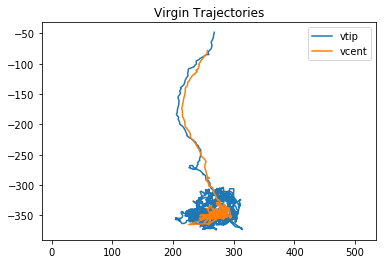

In [21]:
## Dont look at traces[0] without resetting again.
traces[0].plot_trajectory([i for i in [0,3]],end = 3000)

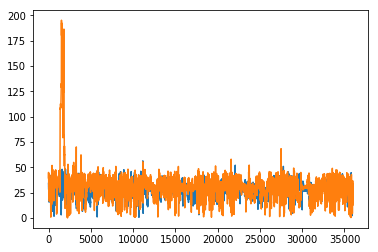

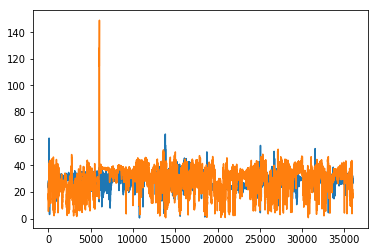

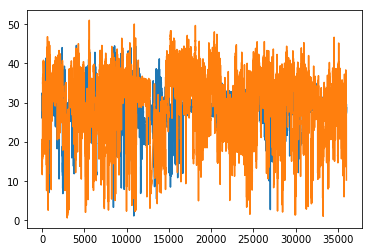

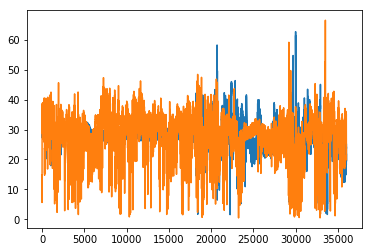

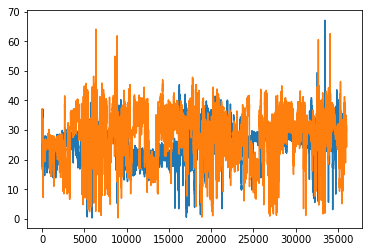

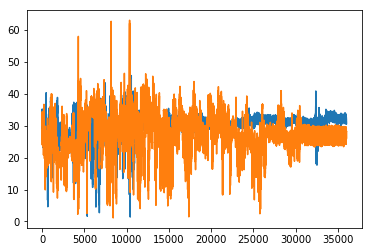

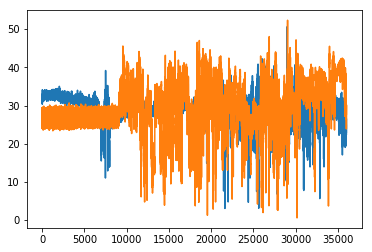

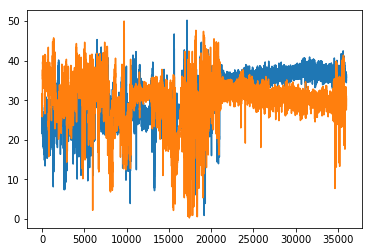

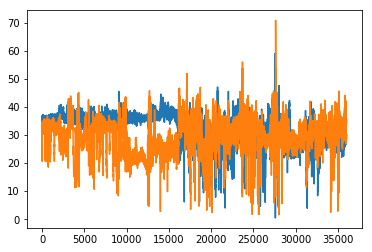

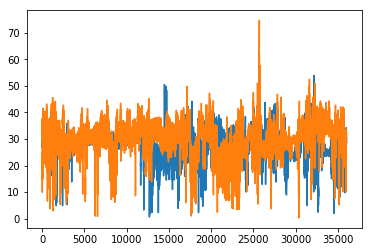

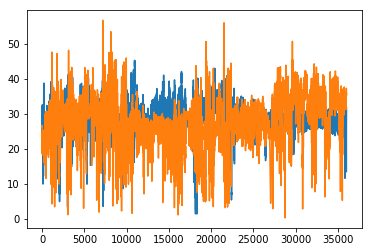

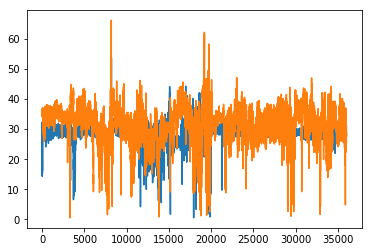

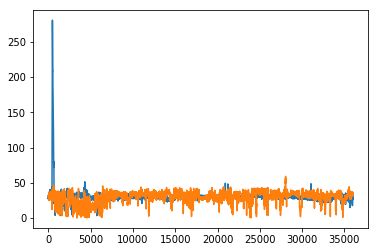

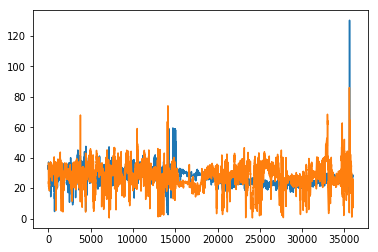

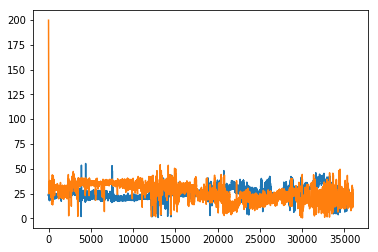

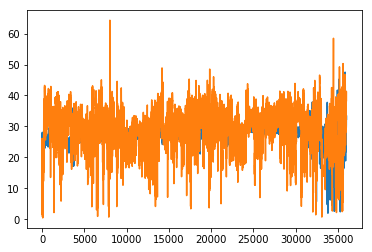

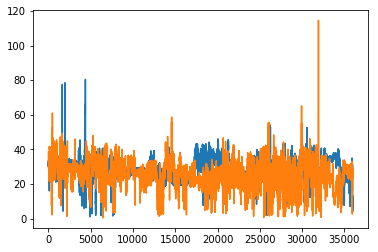

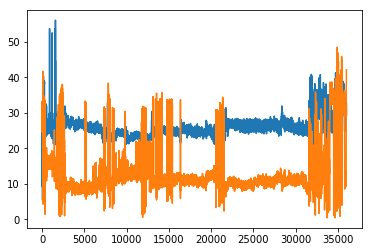

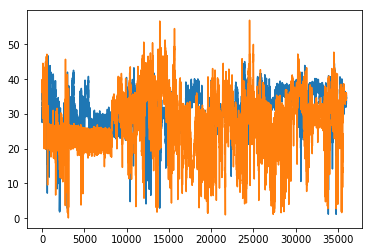

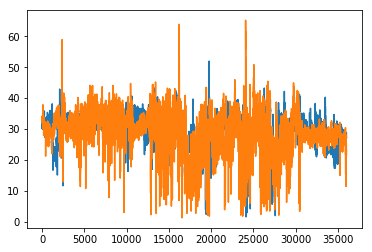

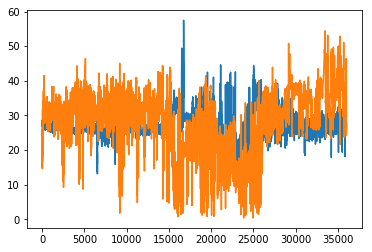

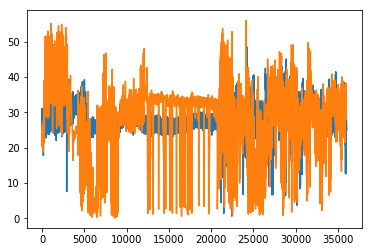

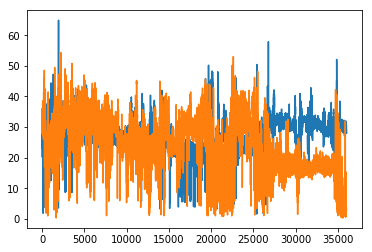

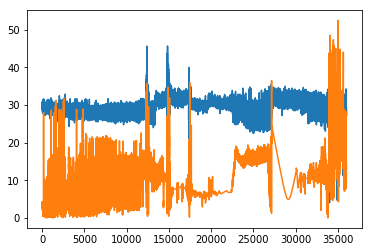

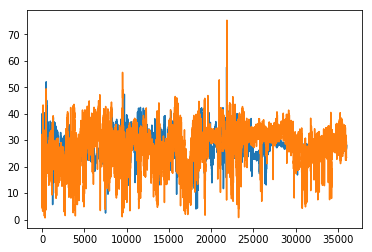

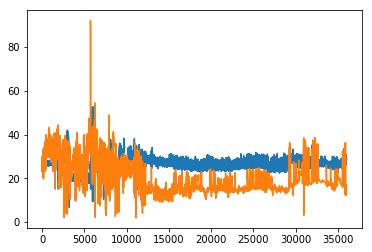

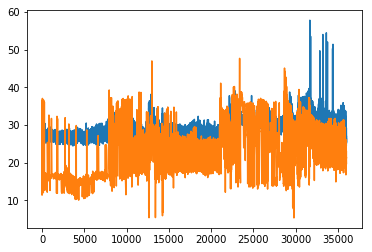

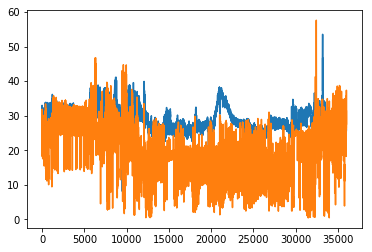

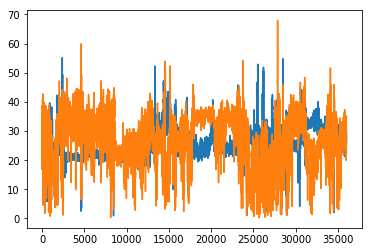

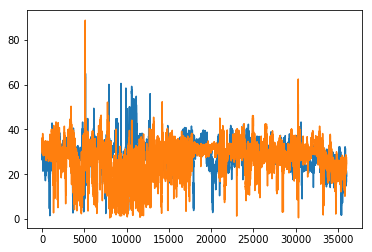

In [22]:
i = 0
for i in range(30):
    plt.plot(traces[i].part_dist(0,3))
    plt.plot(traces[i].part_dist(5,8))
    plt.show()